# Bitcoin Price Prediction Project

This notebook contains sections as below:

1. Abstract
2. Data description
3. Gathering data
4. Data preprocessing
5. ARIMA Model
   - 5.1. ARIMA Model  =>  complete data + ln(data)
   - 5.2. ARIMA Model  =>  complete data + without ln(data)
   - 5.3. ARIMA Model  =>  data start from 2018-01-01 + ln(data)
   - 5.4. ARIMA Model  =>  data start from 2021-01-01 + ln(data)
   - 5.5. ARIMA Model  =>  summary
6. XGBoost
   - 6.1. XGBRegressor  =>  data start from 2018-01-01
   - 6.2. XGBRegressor  =>  data start from 2021-01-01
   - 6.3. XGBRegressor  =>  summary

## 1. Abstract

Bitcoin is a cryptocurrency, created in 2009. Bitcoin system is a set of decentralized nodes with the bitcoin code that contains collection of transactions. A blockchain is a distributed database that is shared among the nodes of a computer network. As a database, a blockchain stores information in digital format. All the computers running the blockchain has the same list of blocks and transactions and can see all these new blocks being filled with new bitcoin transactions.

The original purpose of Bitcoin (BTC in short) is to allow two people to exchange value directly (using peer-to-peer technology), without centralbanks or goverments, regardless where they are. What this means is that Bitcoin blockchain is decentralized -  there is no centralized controll on this network.

Responsibility for processing transactions on the blockchain is done by - so called - Miners. "Mining" is performed using sophisticated hardware that solves an extremely complex math problem. The first computer to find the solution to the problem receives the next block of bitcoins and the process begins again. A newly mined block of bitcoins now can be used to store a value or be sold.

The amount of bitcoins is predetermined. Each and every Bitcoin had to be mined previously. For every four years the amount of bitcoins that can be mined, decreeses by half. That is so called halving of Bitcoin. The next halving will be in 2024 and means that miners will receive half of current revard for processing transactions.

Decentralization, predetermined amount and current dificulty of gaining new Bitcoins by miners is the reason why Bitcoin is so popular. Some people even calls it a digital gold. Popularity of Bitcoin makes the bitcoin market very volatile that is much higher compared to traditional currencies. Volatile marcet, may be an opportunity for speculation and other advantages of bitcoin may lead to long term, store of value strategy.

Popilarity of bitcoin has led invest founds to gain digitall assets in their wallets. This may disturb Bitcoin four years halving cycles.

Predicting Bitcoin price based on historical data should be accounted for, by the prism of marcet sentiment, current bitcoin phase and movement of large capital from invest founds and currend big holders.

## 2. Data description

Historical data price has been taken from Coinpaprika API Python Client.
- Web Site - https://coinpaprika.com/waluta/btc-bitcoin/
- Github   - https://github.com/s0h3ck/coinpaprika-api-python-client

Coinpaprika is a popular data source for various cryptocurrencies, with Polish origins based in city of Poznań.
Free Coinpaprika API provides data in JSON and has limitation for amount of data per request. For example maximum of 50 tweets or historical data for at most 365 days at one request.
Examples of use can be found in their Github site.

To gain the access it is necessary to instal coinpaprica package:

In [1]:
# pip install coinpaprika

And import a data client from the installed pacage.

In [2]:
from coinpaprika import client as Coinpaprika

The rest used in this notebook packages:

In [3]:
import pandas as pd
import numpy as np

from datetime import datetime, date

import matplotlib.pyplot as plt

Load the Coinpaprica client and get random data sample.

In [4]:
client = Coinpaprika.Client()

## 3. Gathering data

In [5]:
# Get historical OHLCV information for a specific coin (USD,BTC)

client.candles("btc-bitcoin", quotes="USD", start="2014-01-11T00:00:00Z")

[{'time_open': '2014-01-11T00:00:00Z',
  'time_close': '2014-01-11T23:59:59Z',
  'open': 867.32,
  'high': 921.48,
  'low': 861.72,
  'close': 913.95,
  'volume': 44754200,
  'market_cap': 11195636163}]

Limitation of historical data per request is 365 days. That is why it is necesarry to collect the data from Coinpaprica in parts and gather those parts in one dataset.

In [6]:
# client.candles("btc-bitcoin", quotes="USD", start="2020-01-01T00:00:00Z", end="2020-12-31T00:00:00Z")

Above request will be missing of one day (2020-12-31) and will end in 365 day of the year (2020-12-30). This is the reason to split one year reguest of data into two requests.

In [7]:
btc_array = []
days = 0

for year in range(2009, 2022+1, 1):
    
    first_half_start = str(year) + "-01-01T00:00:00Z"
    first_half_end = str(year) + "-06-30T00:00:00Z"
    second_half_start = str(year) + "-07-01T00:00:00Z"
    second_half_end = str(year) + "-12-31T00:00:00Z"
    
    first_half = client.candles("btc-bitcoin", quotes="USD", start=first_half_start, end=first_half_end)
    second_half = client.candles("btc-bitcoin", quotes="USD", start=second_half_start, end=second_half_end)
    
    btc_array = btc_array + first_half + second_half
    days_year = len(first_half + second_half)
    days = days + days_year
    print("Year:",year, "; Number of days in count:", days_year)

print("Days in total:", days)

Year: 2009 ; Number of days in count: 0
Year: 2010 ; Number of days in count: 168
Year: 2011 ; Number of days in count: 365
Year: 2012 ; Number of days in count: 366
Year: 2013 ; Number of days in count: 365
Year: 2014 ; Number of days in count: 365
Year: 2015 ; Number of days in count: 365
Year: 2016 ; Number of days in count: 366
Year: 2017 ; Number of days in count: 365
Year: 2018 ; Number of days in count: 365
Year: 2019 ; Number of days in count: 365
Year: 2020 ; Number of days in count: 366
Year: 2021 ; Number of days in count: 365
Year: 2022 ; Number of days in count: 74
Days in total: 4260


As it is shown above, Coinpaprika has no historical data from 2009 year and incomplite data from year 2010.

Check the length of gathered data.

In [8]:
len(btc_array)

4260

Check the last request.

In [9]:
btc_array[-1]

{'time_open': '2022-03-15T00:00:00Z',
 'time_close': '2022-03-15T22:19:00Z',
 'open': 39688.13907914419,
 'high': 39766.29233583467,
 'low': 38342.65735805978,
 'close': 39742.67982856222,
 'volume': 29620514263,
 'market_cap': 754489182259}

Convert gathered data to Pandas Data Frame.

In [10]:
btc_df_gathered = pd.DataFrame(btc_array)

Display df head with 100 rows.

In [11]:
btc_df_gathered.head(100)

time_open            time_close     open     high      low  \
0   2010-07-17T00:00:00Z  2010-07-17T23:59:59Z  0.04951  0.04951  0.04951   
1   2010-07-18T00:00:00Z  2010-07-18T23:59:59Z  0.04951  0.04951  0.04951   
2   2010-07-19T00:00:00Z  2010-07-19T23:59:59Z  0.08584  0.08584  0.08584   
3   2010-07-20T00:00:00Z  2010-07-20T23:59:59Z  0.08080  0.08080  0.08080   
4   2010-07-21T00:00:00Z  2010-07-21T23:59:59Z  0.07474  0.07474  0.07474   
..                   ...                   ...      ...      ...      ...   
95  2010-10-20T00:00:00Z  2010-10-20T23:59:59Z  0.09700  0.09700  0.09700   
96  2010-10-21T00:00:00Z  2010-10-21T23:59:59Z  0.09900  0.09900  0.09900   
97  2010-10-22T00:00:00Z  2010-10-22T23:59:59Z  0.10700  0.10700  0.10700   
98  2010-10-23T00:00:00Z  2010-10-23T23:59:59Z  0.10250  0.10250  0.10250   
99  2010-10-24T00:00:00Z  2010-10-24T23:59:59Z  0.10550  0.10550  0.10550   

      close  market_cap  volume  
0   0.04951         NaN     NaN  
1   0.04951         NaN     NaN  
2   0.08584         NaN     NaN  
3   0.08080         NaN     NaN  
4   0.07474         NaN     NaN  
..      ...         ...     ...  
95  0.09700         NaN     NaN  
96  0.09900         NaN     NaN  
97  0.10700         NaN     NaN  
98  0.10250         NaN     NaN  
99  0.10550         NaN     NaN  

[100 rows x 8 columns]

Display tail of the df.

In [12]:
btc_df_gathered.tail()

time_open            time_close          open          high  \
4255  2022-03-11T00:00:00Z  2022-03-11T23:59:59Z  39443.197138  40139.740182   
4256  2022-03-12T00:00:00Z  2022-03-12T23:59:59Z  38869.052186  39338.967238   
4257  2022-03-13T00:00:00Z  2022-03-13T23:59:59Z  38946.510932  39234.466001   
4258  2022-03-14T00:00:00Z  2022-03-14T23:59:59Z  38027.563327  39662.755277   
4259  2022-03-15T00:00:00Z  2022-03-15T22:19:00Z  39688.139079  39766.292336   

               low         close    market_cap        volume  
4255  38346.593364  38895.209106  7.382566e+11  3.100819e+10  
4256  38813.927397  38993.560483  7.401621e+11  1.639725e+10  
4257  37962.675832  38025.922149  7.218304e+11  2.119422e+10  
4258  37808.180320  39647.962596  7.526593e+11  2.821226e+10  
4259  38342.657358  39742.679829  7.544892e+11  2.962051e+10

Save gathered data in to .csv file as a backup.

In [13]:
btc_df_gathered.to_csv("BTC_Preprocess_Backup.csv", sep = ",", index = False)

Restore data backup

In [14]:
# btc_df_gathered = pd.read_csv("BTC_Preprocess_Backup.csv", sep = ",", skipinitialspace=True)
# btc_df_gathered.head()

## 4. Data preprocessing

In [15]:
# copy data to new df
btc_df_1 = btc_df_gathered

In [16]:
# check datatypes
btc_df_1.dtypes

time_open      object
time_close     object
open          float64
high          float64
low           float64
close         float64
market_cap    float64
volume        float64
dtype: object

In [17]:
# change df index to date
btc_df_1.index = pd.to_datetime(btc_df_1["time_close"]).dt.date
# drop "time_open", "time_close" columns
btc_df_1.drop(["time_open", "time_close"], axis=1, inplace=True)
btc_df_1.head()

open     high      low    close  market_cap  volume
time_close                                                        
2010-07-17  0.04951  0.04951  0.04951  0.04951         NaN     NaN
2010-07-18  0.04951  0.04951  0.04951  0.04951         NaN     NaN
2010-07-19  0.08584  0.08584  0.08584  0.08584         NaN     NaN
2010-07-20  0.08080  0.08080  0.08080  0.08080         NaN     NaN
2010-07-21  0.07474  0.07474  0.07474  0.07474         NaN     NaN

In [18]:
# show df shape
btc_df_1.shape

(4260, 6)

In [19]:
btc_df_1.describe()

open          high           low         close    market_cap  \
count   4260.000000   4260.000000   4260.000000   4260.000000  3.244000e+03   
mean    7486.399686   7681.673445   7277.229086   7496.049423  1.803599e+11   
std    14143.651871  14506.539709  13748.027219  14153.212833  2.918899e+11   
min        0.049510      0.049510      0.049510      0.049510  7.784112e+08   
25%      109.541250    113.394250    106.710500    109.377500  6.497312e+09   
50%      633.524000    648.231500    622.495500    633.911500  6.407707e+10   
75%     8130.208932   8274.300000   7895.285188   8131.199618  1.737404e+11   
max    67589.872823  68692.137037  66457.970074  67589.768671  1.275266e+12   

             volume  
count  3.001000e+03  
mean   1.195784e+10  
std    1.708218e+10  
min    2.857830e+06  
25%    5.534460e+07  
50%    3.649922e+09  
75%    1.861541e+10  
max    1.363702e+11

## 5. ARIMA Model

For the Autoregressive Integrated Moving Average (ARIMA) Model data should be stationary.
ARIMA Model is popular for predicting linear time series data.
- AR stands for autoregressive (p)
- I stand for Integrated (d), 
- MA stands for moving average (q)

Auto ARIMA - automatically discover the optimal order (p, d, q) for an ARIMA model.

For price prediction it will be used columns "close" and "time_close" as idex.

For evaluating model performance the Root Mean Square Error (RMSE) will be used - should be as low as possible.

In [20]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

### 5.1. ARIMA Model  =>  complete data + ln(data)

In [21]:
# copy full dataset
df_close = btc_df_1['close']

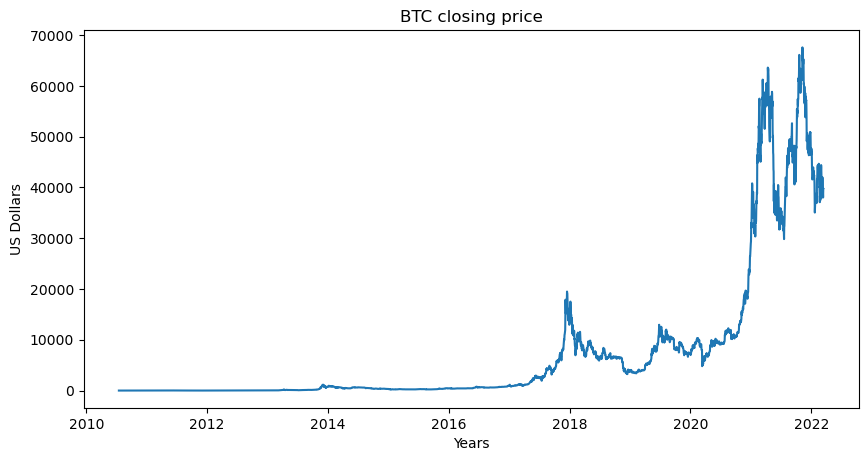

In [22]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

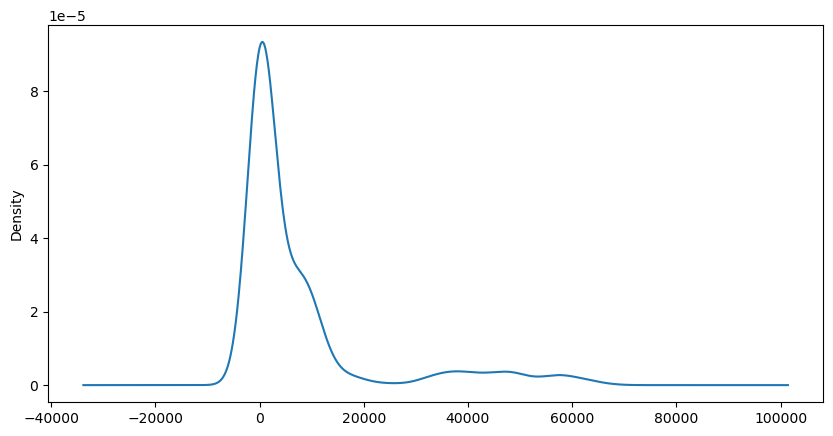

In [23]:
# data distribution
plt.figure(figsize=(10,5), dpi=100)
_ = df_close.plot(kind='kde')

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [24]:
# test for staionarity
adf_test = adfuller(df_close)

# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test                -1.084409
p-value                  0.721249
used lags               31.000000
used observations     4228.000000
critical value 1%       -3.431898
critical value 5%       -2.862224
critical value 10%      -2.567134
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

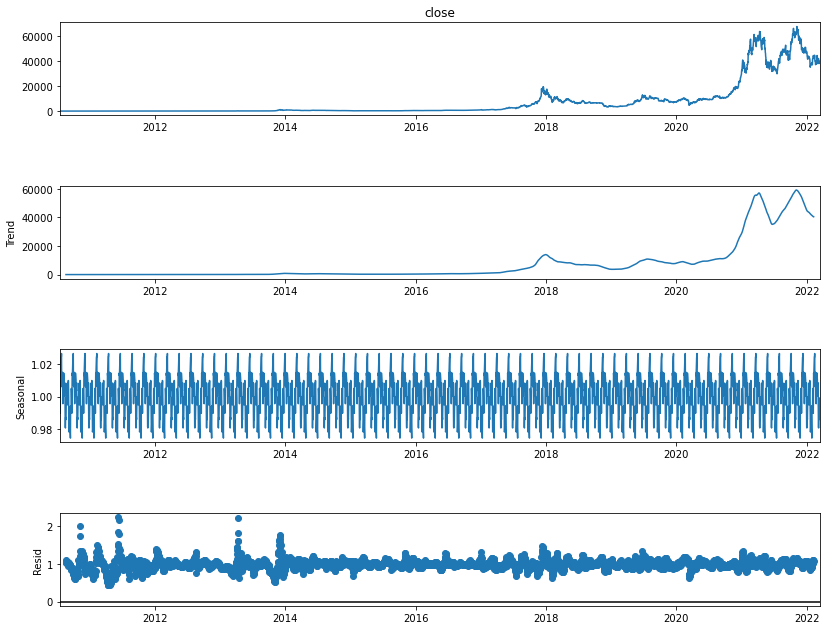

In [25]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

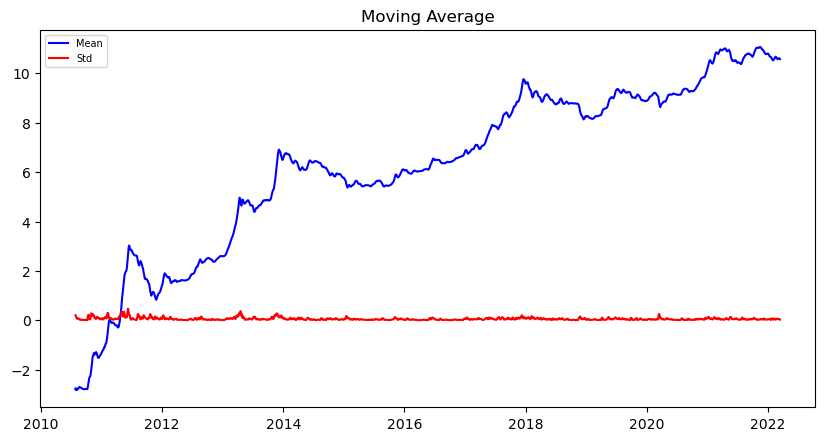

In [26]:
# if not stationary then eliminate trend
# eliminate trend

df_log = np.log(df_close)

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

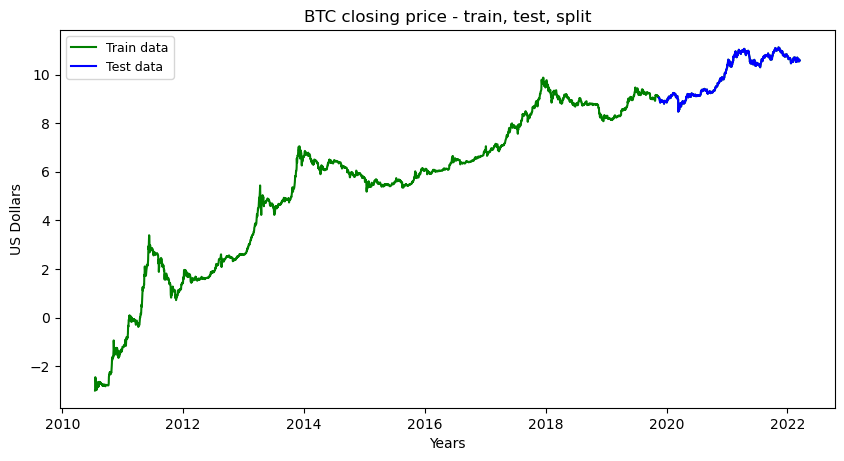

In [27]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [28]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10006.348, Time=0.53 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10008.687, Time=0.98 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10008.971, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9994.567, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10011.841, Time=1.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10010.194, Time=1.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10010.613, Time=4.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-10010.492, Time=1.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10010.048, Time=3.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10008.259, Time=6.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-10000.993, Time=0.83 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 20.566 seconds


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3408
Model:               SARIMAX(1, 1, 1)   Log Likelihood                5009.921
Date:                Tue, 15 Mar 2022   AIC                         -10011.841
Time:                        23:20:07   BIC                          -9987.307
Sample:                             0   HQIC                        -10003.073
                               - 3408                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0058      0.002      3.416      0.001       0.002       0.009
ar.L1         -0.6269      0.107     -5.832      0.000      -0.838      -0.416
ma.L1          0.6688      0.104      6.410      0.0

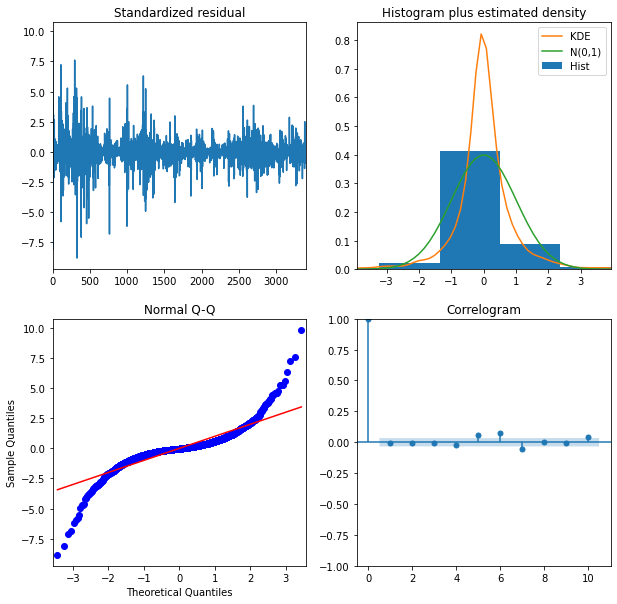

In [29]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [30]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [31]:
# ignore ARIMA warnings
import warnings
warnings.filterwarnings('ignore')

In [32]:
model = ARIMA(train_data, order=(1,1,1))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 3407
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5010.019
Method:                       css-mle   S.D. of innovations              0.056
Date:                Tue, 15 Mar 2022   AIC                         -10012.037
Time:                        23:20:09   BIC                          -9987.503
Sample:                    07-18-2010   HQIC                        -10003.269
                         - 11-14-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0035      0.001      3.618      0.000       0.002       0.005
ar.L1.D.close    -0.5721      0.132     -4.335      0.000      -0.831      -0.313
ma.L1.D.close     0.6161      0.126     

In [33]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_1, stderr_1, conf_1 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

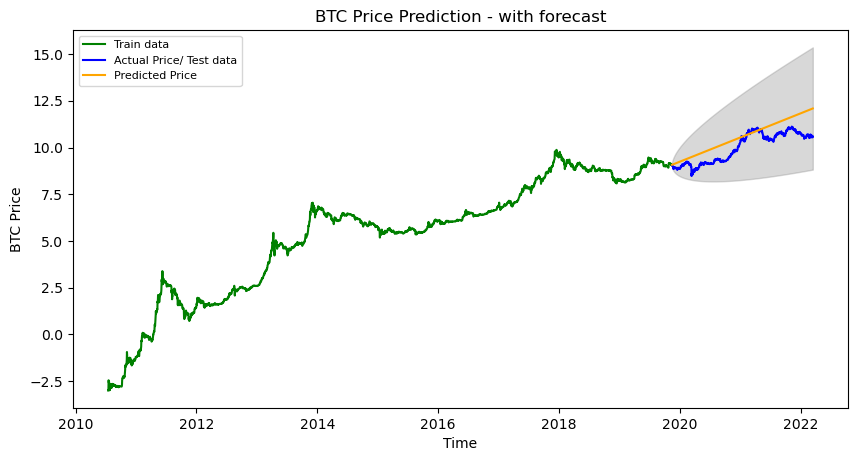

In [34]:
# convert to pandas series
fore_series = pd.Series(fore_1, index=test_data.index)
lower_conf = pd.Series(conf_1[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_1[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
# print performance
rmse_1 = mean_squared_error(test_data, fore_1, squared=False)
print('RMSE: %.3f' % rmse_1)

RMSE: 0.703


### 5.2. ARIMA Model  =>  complete data + without ln(data)

In [36]:
# copy full dataset
df_close = btc_df_1['close']

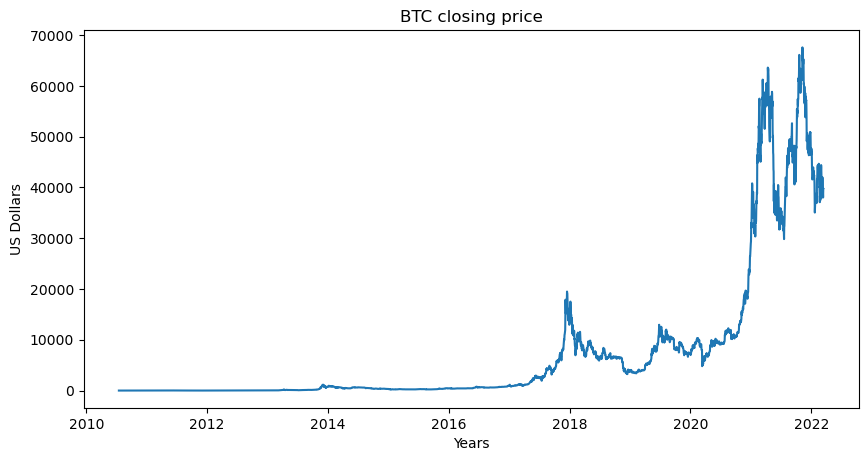

In [37]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [38]:
# test for staionarity
adf_test = adfuller(df_close)

In [39]:
# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

In [40]:
# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test                -1.084409
p-value                  0.721249
used lags               31.000000
used observations     4228.000000
critical value 1%       -3.431898
critical value 5%       -2.862224
critical value 10%      -2.567134
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

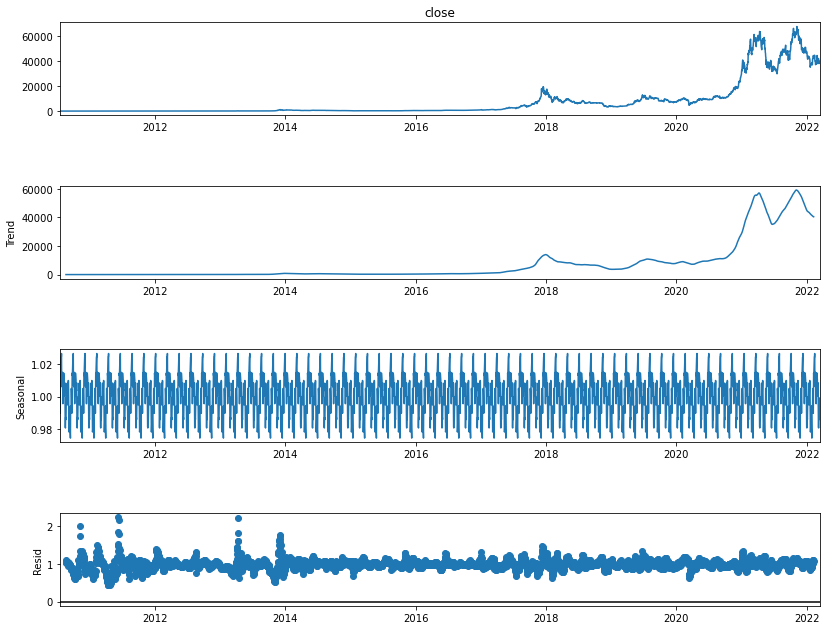

In [41]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

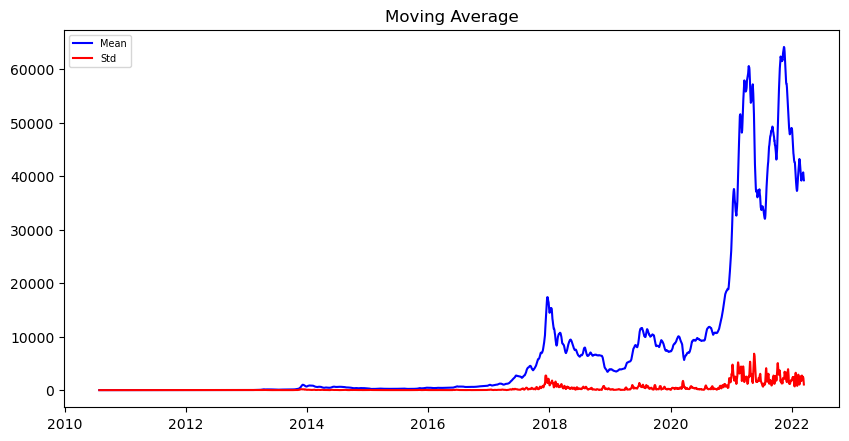

In [42]:
# if not stationary then eliminate trend
# eliminate trend

#df_log = np.log(df_close)
df_log = df_close

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

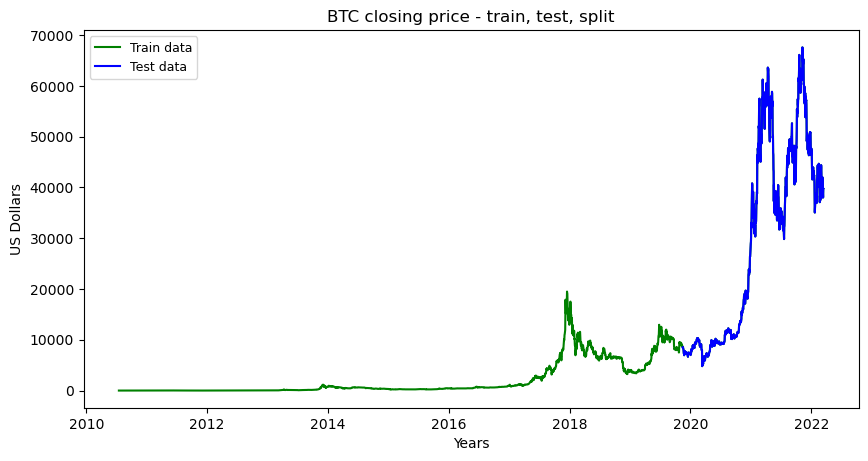

In [43]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [44]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46088.341, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46085.147, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46084.792, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46086.849, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46069.076, Time=1.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=46069.970, Time=1.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46070.021, Time=1.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=46082.817, Time=0.44 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=46083.506, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=46072.280, Time=2.71 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=46067.494, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=46083.260, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=46083.617, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=46068.378, Time=0.68 sec
 ARIMA(1,1,2)(0,0,0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3408
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -23000.476
Date:                Tue, 15 Mar 2022   AIC                          46010.953
Time:                        23:20:37   BIC                          46041.621
Sample:                             0   HQIC                         46021.913
                               - 3408                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7633      0.006   -275.410      0.000      -1.776      -1.751
ar.L2         -0.9165      0.006   -151.188      0.000      -0.928      -0.905
ma.L1          1.8200      0.006    316.710      0.0

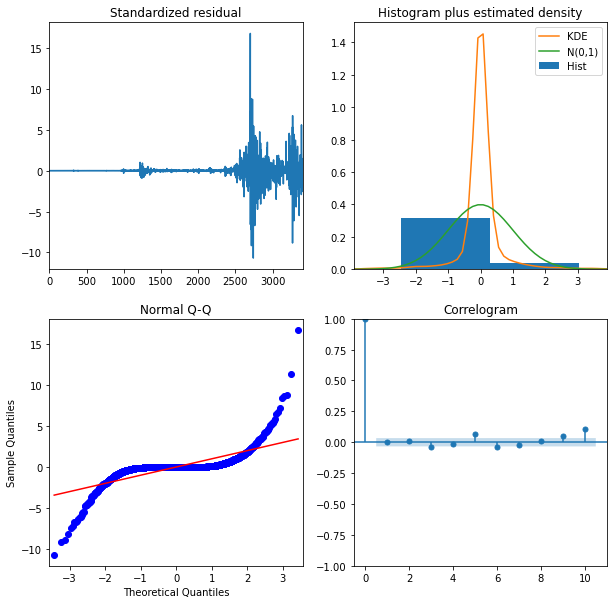

In [45]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [46]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [47]:
# ignore ARIMA warnings
warnings.filterwarnings('ignore')

In [48]:
model = ARIMA(train_data, order=(2,1,2))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 3407
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -23000.227
Method:                       css-mle   S.D. of innovations            206.823
Date:                Tue, 15 Mar 2022   AIC                          46012.454
Time:                        23:20:41   BIC                          46049.255
Sample:                    07-18-2010   HQIC                         46025.606
                         - 11-14-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5698      3.637      0.707      0.480      -4.559       9.699
ar.L1.D.close    -1.7634      0.020    -90.266      0.000      -1.802      -1.725
ar.L2.D.close    -0.9165      0.017    -

In [49]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_2, stderr_2, conf_2 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

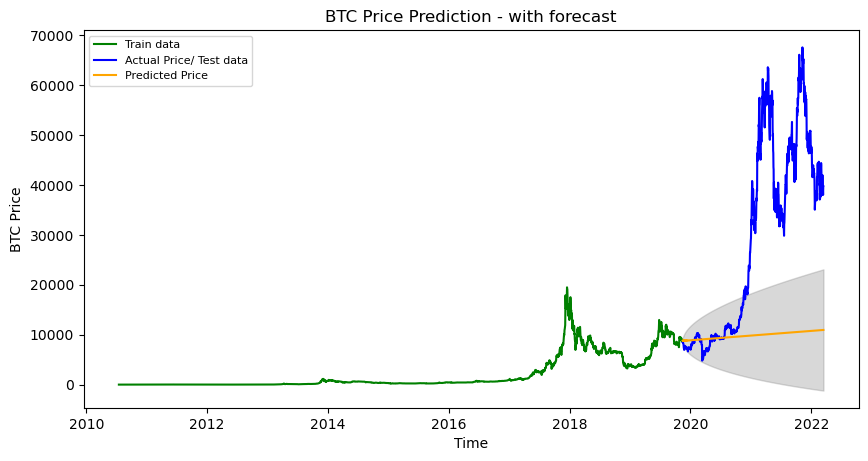

In [50]:
# convert to pandas series
fore_series = pd.Series(fore_2, index=test_data.index)
lower_conf = pd.Series(conf_2[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_2[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [51]:
# print performance
rmse_2 = mean_squared_error(test_data, fore_2, squared=False)
print('RMSE: %.3f' % rmse_2)

RMSE: 26850.768


### 5.3. ARIMA Model  =>  data start from 2018-01-01 + ln(data)

In [52]:
# copy data starting from 2018-01-01
df_close = btc_df_1['close'].iloc[2725:]

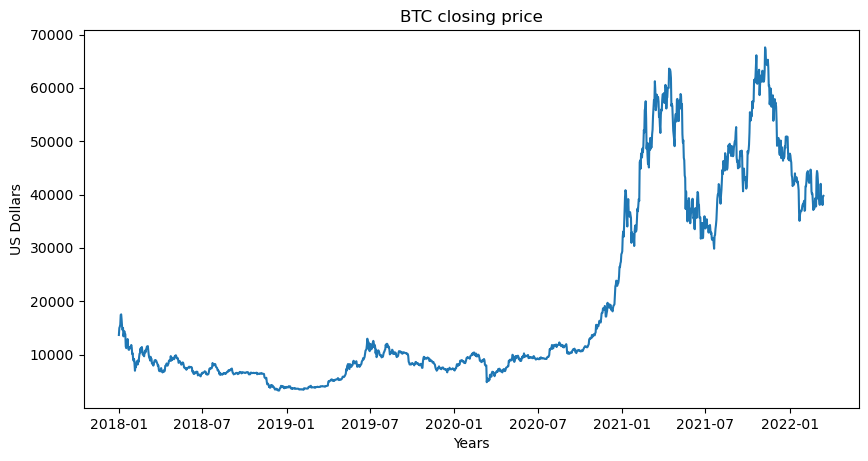

In [53]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [54]:
# test for staionarity
adf_test = adfuller(df_close)

In [55]:
# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

In [56]:
# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test                -0.946421
p-value                  0.772301
used lags               24.000000
used observations     1510.000000
critical value 1%       -3.434688
critical value 5%       -2.863456
critical value 10%      -2.567790
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

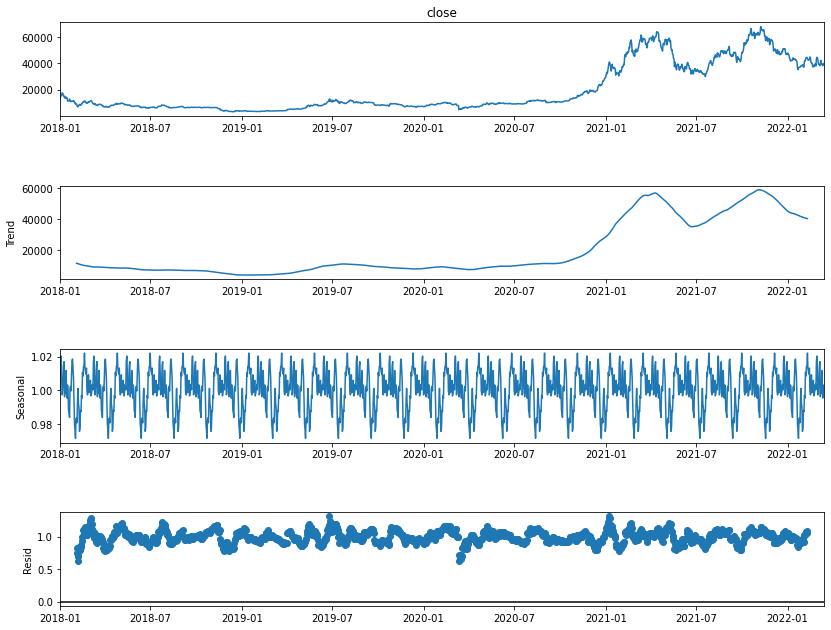

In [57]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

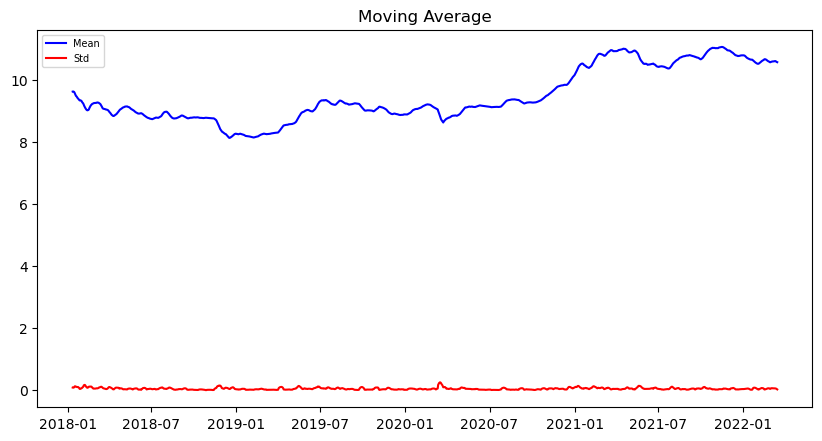

In [58]:
# if not stationary then eliminate trend
# eliminate trend

df_log = np.log(df_close)

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

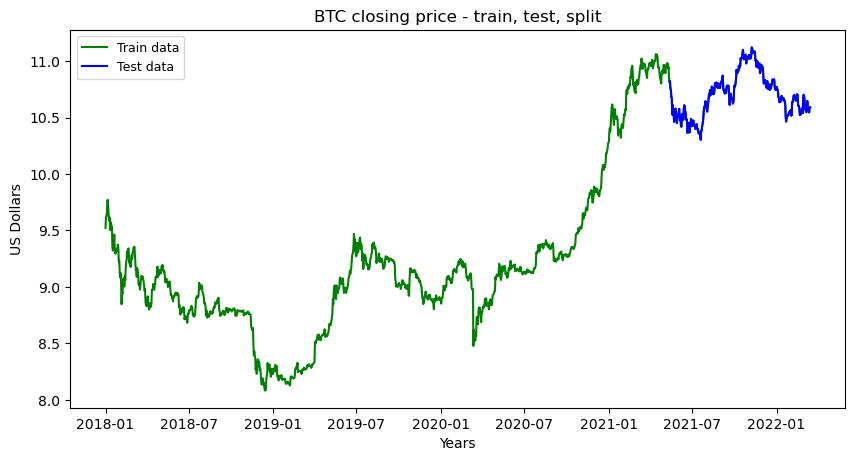

In [59]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [60]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4353.680, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4358.057, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4357.413, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4354.830, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4359.425, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4357.788, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4358.293, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4358.374, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4355.836, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4360.539, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4359.074, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4358.931, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4360.187, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4360.523, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1228
Model:               SARIMAX(2, 1, 0)   Log Likelihood                2183.269
Date:                Tue, 15 Mar 2022   AIC                          -4360.539
Time:                        23:20:51   BIC                          -4345.202
Sample:                             0   HQIC                         -4354.768
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0685      0.020     -3.412      0.001      -0.108      -0.029
ar.L2          0.0532      0.027      1.939      0.052      -0.001       0.107
sigma2         0.0017   2.01e-05     82.822      0.0

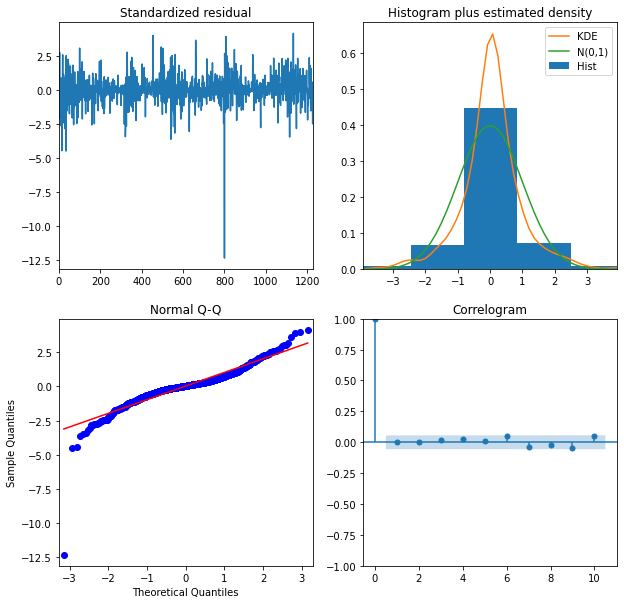

In [61]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [62]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [63]:
# ignore ARIMA warnings
warnings.filterwarnings('ignore')

In [64]:
model = ARIMA(train_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 1227
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2183.712
Method:                       css-mle   S.D. of innovations              0.041
Date:                Tue, 15 Mar 2022   AIC                          -4359.425
Time:                        23:20:52   BIC                          -4338.975
Sample:                    01-02-2018   HQIC                         -4351.730
                         - 05-12-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      0.942      0.346      -0.001       0.003
ar.L1.D.close    -0.0685      0.029     -2.393      0.017      -0.125      -0.012
ar.L2.D.close     0.0526      0.029     

In [65]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_3, stderr_3, conf_3 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

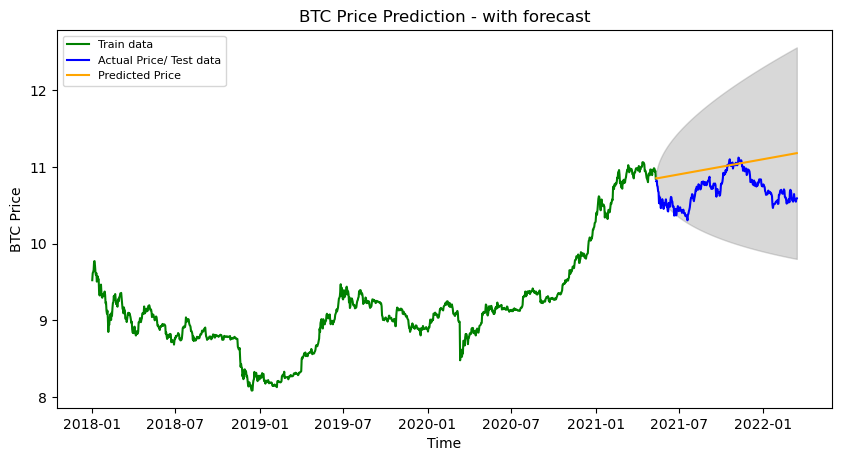

In [66]:
# convert to pandas series
fore_series = pd.Series(fore_3, index=test_data.index)
lower_conf = pd.Series(conf_3[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_3[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [67]:
# print performance
rmse_3 = mean_squared_error(test_data, fore_3, squared=False)
print('RMSE: %.3f' % rmse_3)

RMSE: 0.367


### 5.4. ARIMA Model  =>  data start from 2021-01-01 + ln(data)

In [68]:
# copy data starting from 2021-01-01
df_close = btc_df_1['close'].iloc[3821:]

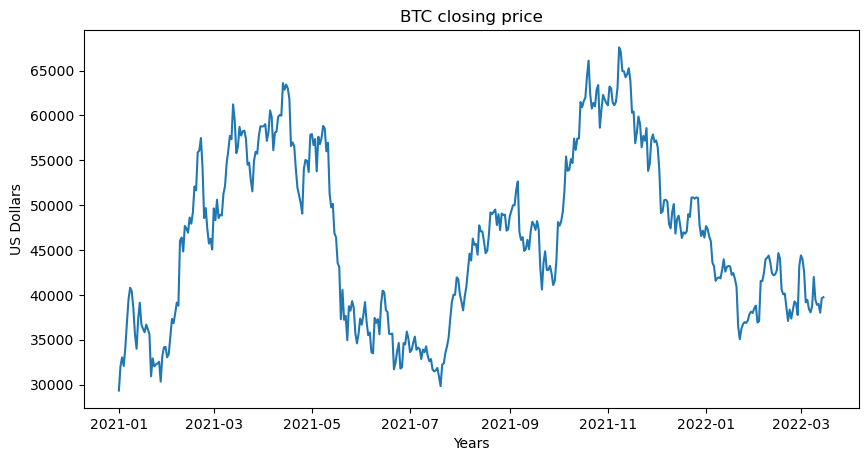

In [69]:
# plot BTC close price
plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_close)
plt.title('BTC closing price')
plt.show()

ADF (Augmented Dickey-Fuller) test is used to check if series is stationary or not.

In [70]:
# test for staionarity
adf_test = adfuller(df_close)

In [71]:
# translation for the adf_test output
output = pd.Series(adf_test[0:4],index=['adf test','p-value','used lags','used observations'])

In [72]:
# unpack the last output object (dict)
for key, val in adf_test[4].items():
    output[f'critical value {key}'] =  val
print(output)

adf test               -2.405558
p-value                 0.140174
used lags               0.000000
used observations     438.000000
critical value 1%      -3.445368
critical value 5%      -2.868161
critical value 10%     -2.570297
dtype: float64


p-value > 0.05

<Figure size 432x288 with 0 Axes>

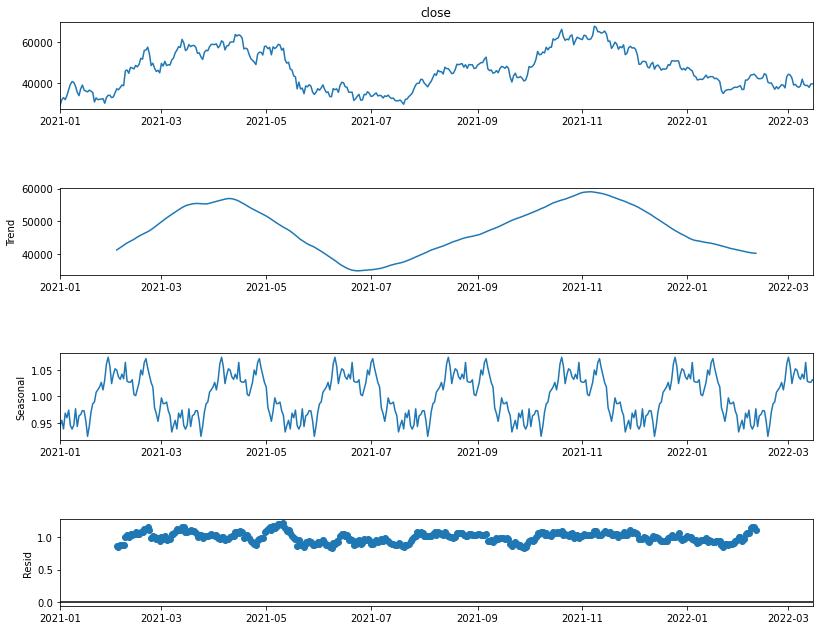

In [73]:
# checking for trend and seasonality of the data
result = seasonal_decompose(df_close, model='multiplicative', period = 66)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(13, 10)

Values magnitude and the growing trend might be reduced by using logatythm on the data.
Next rolling average is calculated from data from the past year and a mean consumption value at each point of the data.

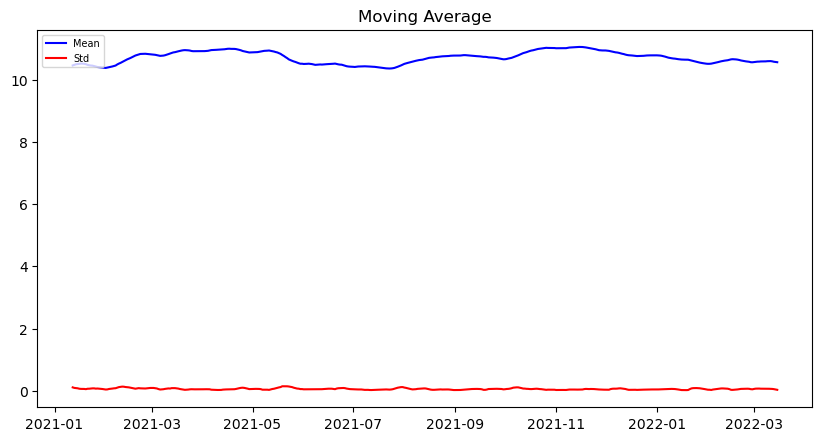

In [74]:
# if not stationary then eliminate trend
# eliminate trend

df_log = np.log(df_close)

roll_mean = df_log.rolling(12).mean()
roll_std = df_log.rolling(12).std()

plt.figure(figsize=(10,5), dpi=100)
plt.title('Moving Average')
plt.plot(roll_mean, "blue", label = "Mean")
plt.plot(roll_std, "red", label = "Std")
plt.legend(loc='upper left', fontsize=7)
plt.show()

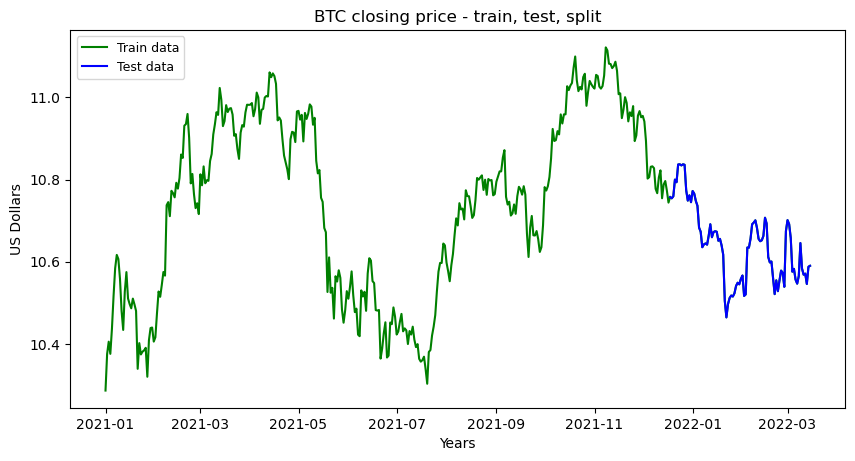

In [75]:
# train, test, split the data
# train = 0.8*data
# test  = 0.8*data

size = int(len(df_log)*0.8)

train_data, test_data = df_log[:size], df_log[size:]

plt.figure(figsize=(10,5), dpi=100)
plt.xlabel('Years')
plt.ylabel('US Dollars')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.title('BTC closing price - train, test, split')
plt.legend(loc='upper left', fontsize=9)
plt.show()

In [76]:
# performing auto ARIMA model for getting optimal (p, d, q)
auto_ARIMA_model = auto_arima(train_data, start_p=0, start_q=0, 
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=5, max_q=5, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1218.213, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1216.910, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1216.926, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1219.878, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1214.943, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.692 seconds


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  351
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 610.939
Date:                Tue, 15 Mar 2022   AIC                          -1219.878
Time:                        23:20:56   BIC                          -1216.021
Sample:                             0   HQIC                         -1218.343
                                - 351                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0018      0.000     16.705      0.000       0.002       0.002
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                21.71
Prob(Q):                              0.40   Pr

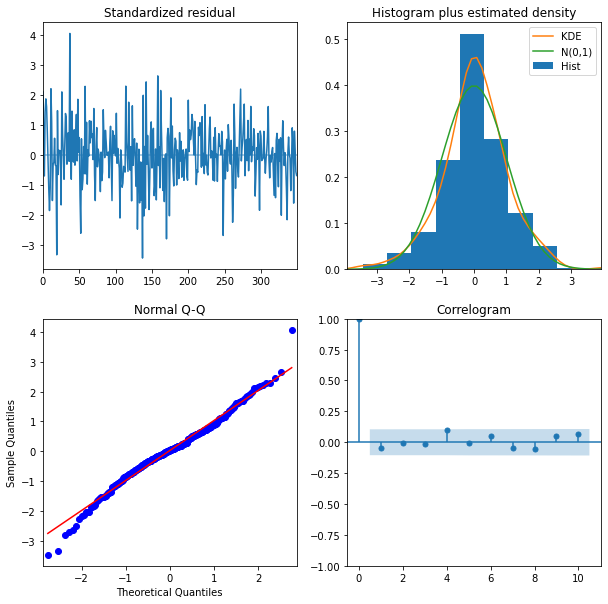

In [77]:
print(auto_ARIMA_model.summary())

auto_ARIMA_model.plot_diagnostics(figsize=(10,10))
plt.show()

In [78]:
# Top left:     The residual errors fluctuate around a zero mean
# Top Right:    Plot suggests a normal distribution with a zero mean.
# Bottom left:  Red line should be perfectly aligned with all of the dots.
# Bottom Right: Residual errors are not autocorrelated. Correlogram, also known as the ACF plot.

Build ARIMA Model based on (p,d,q) from auto_arima

In [79]:
# ignore ARIMA warnings
warnings.filterwarnings('ignore')

In [80]:
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  350
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 611.107
Method:                           css   S.D. of innovations              0.042
Date:                Tue, 15 Mar 2022   AIC                          -1218.213
Time:                        23:20:57   BIC                          -1210.497
Sample:                    01-02-2021   HQIC                         -1215.142
                         - 12-17-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.579      0.563      -0.003       0.006


In [81]:
# Forecast, the standard error of the forecasts, 2d array of the confidence interval for the forecast
fore_4, stderr_4, conf_4 = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

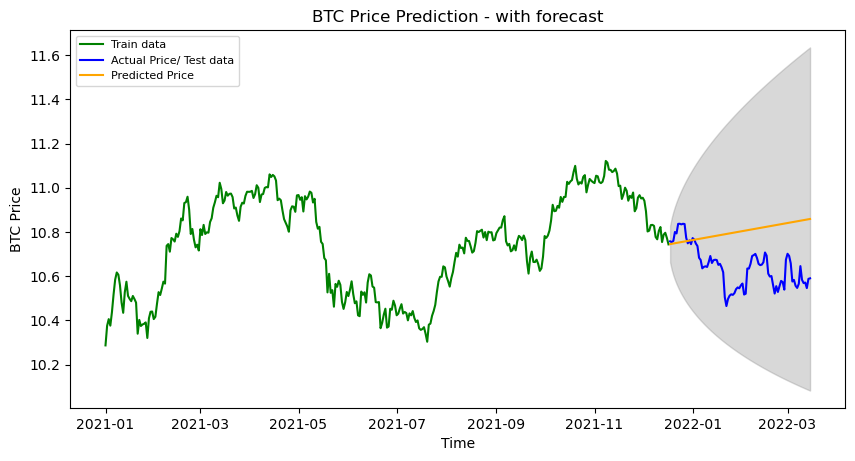

In [82]:
# convert to pandas series
fore_series = pd.Series(fore_4, index=test_data.index)
lower_conf = pd.Series(conf_4[:, 0], index=test_data.index)
upper_conf = pd.Series(conf_4[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

# add confidence area
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='grey', alpha=0.3)

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [83]:
# print performance
rmse_4 = mean_squared_error(test_data, fore_4, squared=False)
print('RMSE: %.3f' % rmse_4)

RMSE: 0.197


### 5.5. ARIMA Model  =>  summary

Prediction of Bitcoin Price based on historical data was performed with ARIMA model in addition to auto_arima for getting optimal (p, d, q).

- In first try complete dataset has been used and stationarity of the time series has been achaived by using natural logarythm on the data set.

- Second try was also on comlete data set but without natural logarythm on the data. In this case prediction of BTC price was with very high Root Mean Square Error (RMSE).

- Third try was with sliced data started from 2018-01-01 and with using natural logarythm on the data set.

- Fourth try was with sliced data started from 2021-01-01 and with using natural logarythm on the data set. This case gave the lowest RMSE.

In concluzion - by using ARIMA model on Bitcoin historical data, the series data shoud be stacjonary and the most recend data gives the best predictions.

Build algorythm is not walk-forward validation. 
It is predicting - in specified by test data length time period - rising trend or downward trend of BTC price.

Taking natural logarythm of the data caused a RMSE to be shown in different scale than RMSE without ln on the data.

Too high RMSE_2 for the plot: 26850.768


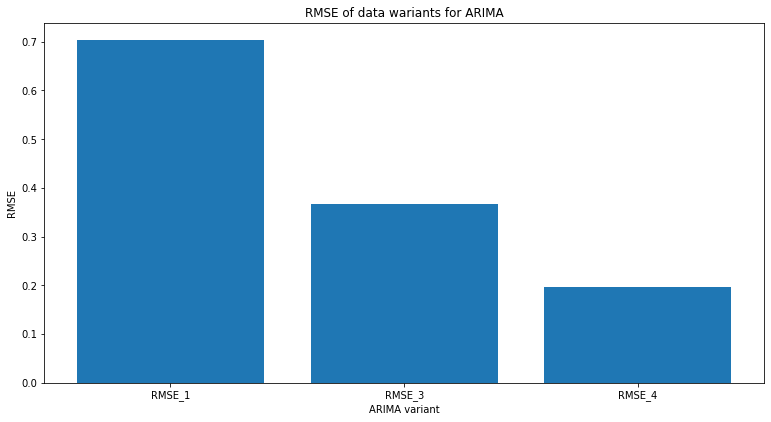

In [84]:
# plot for the RMSE's of data wariants for ARIMA

print('Too high RMSE_2 for the plot: %.3f' % rmse_2)


ARIMA_variant = ['RMSE_1', 'RMSE_3', 'RMSE_4']
variables = [rmse_1, rmse_3, rmse_4]

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(ARIMA_variant, variables)

plt.xlabel('ARIMA variant')
plt.ylabel('RMSE')
plt.title('RMSE of data wariants for ARIMA')
plt.show()

## 6. XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

GridSearchCV - automatically estimate the optimal parameters by cross-validated grid-search over a parameter grid

For price prediction it will be used columns all df columns and "time_close" as idex.
Additionaly there was produced more features by spliting "date" to separate columns.

For evaluating model performance the Root Mean Square Error (RMSE) will be used - should be as low as possible.
GridSearchCV - by convention - always tries to maximize its score so loss function was determined by "make_scorer" with "greater_is_better" parameter set to False.

In [85]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

from xgboost.sklearn import XGBRegressor

### 6.1. XGBRegressor  =>  data start from 2018-01-01

In [86]:
# copy data starting from 2018-01-01 and replace NaN values to 0

df_boost = btc_df_1.fillna(0).iloc[2725:]
df_boost.head()

open     high      low    close    market_cap        volume
time_close                                                                
2018-01-01  14112.2  14112.2  13154.7  13657.2  2.291192e+11  1.029120e+10
2018-01-02  13625.0  15444.6  13163.6  14982.1  2.513779e+11  1.684660e+10
2018-01-03  14978.2  15572.8  14844.5  15201.0  2.550806e+11  1.687190e+10
2018-01-04  15270.7  15739.7  14522.2  15599.2  2.617953e+11  2.178320e+10
2018-01-05  15477.2  17705.2  15202.8  17429.5  2.925441e+11  2.384090e+10

In [87]:
# create additional features from the date
# make index to datetime again

df_boost["date"] = pd.to_datetime(df_boost.index)

df_boost["hour"] = df_boost["date"].dt.hour
df_boost["day_of_week"] = df_boost["date"].dt.dayofweek
df_boost["quarter"] = df_boost["date"].dt.quarter
df_boost["month"] = df_boost["date"].dt.month
df_boost["year"] = df_boost["date"].dt.year
df_boost["day_of_year"] = df_boost["date"].dt.dayofyear
df_boost["day_of_month"] = df_boost["date"].dt.day
df_boost["week_of_year"] = df_boost["date"].dt.weekofyear

In [88]:
# define X and y

X = df_boost[["open" ,"high", "low", "market_cap", "volume", 
              "hour", "day_of_week", "quarter", "month", "year", "day_of_year", "day_of_month", "week_of_year"]]
y = df_boost["close"]

In [89]:
len(X), (len(y))

(1535, 1535)

In [90]:
# train, test, split the data
# train = 0.8*data
# test  = 0.2*data

size = int(len(X)*0.8)

X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]

In [91]:
X_train

open          high           low    market_cap  \
time_close                                                           
2018-01-01  14112.200000  14112.200000  13154.700000  2.291192e+11   
2018-01-02  13625.000000  15444.600000  13163.600000  2.513779e+11   
2018-01-03  14978.200000  15572.800000  14844.500000  2.550806e+11   
2018-01-04  15270.700000  15739.700000  14522.200000  2.617953e+11   
2018-01-05  15477.200000  17705.200000  15202.800000  2.925441e+11   
...                  ...           ...           ...           ...   
2021-05-08  57521.383996  59558.490605  57436.774647  1.100585e+12   
2021-05-09  58953.721034  59276.019174  56853.554019  1.094758e+12   
2021-05-10  58562.404234  59687.499024  55046.713627  1.047673e+12   
2021-05-11  55986.512608  57054.177699  54780.996569  1.065418e+12   
2021-05-12  56939.410695  58049.887382  51300.622147  9.597551e+11   

                  volume  hour  day_of_week  quarter  month  year  \
time_close                                                          
2018-01-01  1.029120e+10     0            0        1      1  2018   
2018-01-02  1.684660e+10     0            1        1      1  2018   
2018-01-03  1.687190e+10     0            2        1      1  2018   
2018-01-04  2.178320e+10     0            3        1      1  2018   
2018-01-05  2.384090e+10     0            4        1      1  2018   
...                  ...   ...          ...      ...    ...   ...   
2021-05-08  6.421483e+10     0            5        2      5  2021   
2021-05-09  6.406084e+10     0            6        2      5  2021   
2021-05-10  7.622346e+10     0            0        2      5  2021   
2021-05-11  6.064625e+10     0            1        2      5  2021   
2021-05-12  7.880280e+10     0            2        2      5  2021   

            day_of_year  day_of_month  week_of_year  
time_close                                           
2018-01-01            1             1             1  
2018-01-02            2             2             1  
2018-01-03            3             3             1  
2018-01-04            4             4             1  
2018-01-05            5             5             1  
...                 ...           ...           ...  
2021-05-08          128             8            18  
2021-05-09          129             9            18  
2021-05-10          130            10            19  
2021-05-11          131            11            19  
2021-05-12          132            12            19  

[1228 rows x 13 columns]

In [92]:
# GridSearchCV - by convention - always tries to maximize its score so loss function was determined by 
# "make_scorer" with "greater_is_better" parameter set to False.

scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [93]:
%%time

# fisrt try of evauating best params for XGBRegressor     

model = XGBRegressor(objective ='reg:squarederror',
                     booster='gbtree',             # Specify which booster to use: gbtree, gblinear or dart.
                     subsample=0.9,                # Subsample ratio of the training instance.
                     colsample_bytree=0.5)         # Subsample ratio of columns when constructing each tree.

param_grid = {
    'n_estimators':  [200, 300, 500],              # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'learning_rate': [0.01, 0.06, 0.1]             # Boosting learning rate (xgb's "eta")
}

gscv = GridSearchCV(model, 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring=scorer)

gscv.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)], 
         early_stopping_rounds=20)


y_pred = gscv.best_estimator_.predict(X_test)

# print performance
rmse_XGB_1 = mean_squared_error(y_test, y_pred, squared=False)
print(model.__class__.__name__, rmse_XGB_1)

[0]	validation_0-rmse:18492.74023	validation_1-rmse:45622.27734
[1]	validation_0-rmse:18311.91992	validation_1-rmse:45174.85156
[2]	validation_0-rmse:18132.54492	validation_1-rmse:44731.11719
[3]	validation_0-rmse:17954.69727	validation_1-rmse:44293.41016
[4]	validation_0-rmse:17779.01367	validation_1-rmse:43853.48438
[5]	validation_0-rmse:17605.04297	validation_1-rmse:43423.63281
[6]	validation_0-rmse:17433.39258	validation_1-rmse:42986.89062
[7]	validation_0-rmse:17262.76367	validation_1-rmse:42559.23828
[8]	validation_0-rmse:17094.06250	validation_1-rmse:42137.80469
[9]	validation_0-rmse:16930.66797	validation_1-rmse:41674.83594
[10]	validation_0-rmse:16765.39844	validation_1-rmse:41276.21484
[11]	validation_0-rmse:16600.66016	validation_1-rmse:40877.58203
[12]	validation_0-rmse:16445.09961	validation_1-rmse:40748.59375
[13]	validation_0-rmse:16285.15625	validation_1-rmse:40361.67969
[14]	validation_0-rmse:16126.28418	validation_1-rmse:39977.81250
[15]	validation_0-rmse:15968.22461	

[127]	validation_0-rmse:5378.77100	validation_1-rmse:13677.06543
[128]	validation_0-rmse:5326.99463	validation_1-rmse:13545.49512
[129]	validation_0-rmse:5275.52295	validation_1-rmse:13418.77344
[130]	validation_0-rmse:5224.59375	validation_1-rmse:13293.61914
[131]	validation_0-rmse:5174.79199	validation_1-rmse:13171.65137
[132]	validation_0-rmse:5125.11475	validation_1-rmse:13053.65039
[133]	validation_0-rmse:5076.06152	validation_1-rmse:12933.84863
[134]	validation_0-rmse:5027.04150	validation_1-rmse:12814.82910
[135]	validation_0-rmse:4978.49512	validation_1-rmse:12696.79297
[136]	validation_0-rmse:4930.42529	validation_1-rmse:12576.82910
[137]	validation_0-rmse:4882.81152	validation_1-rmse:12458.51953
[138]	validation_0-rmse:4835.91162	validation_1-rmse:12343.56250
[139]	validation_0-rmse:4789.22217	validation_1-rmse:12226.94531
[140]	validation_0-rmse:4742.97803	validation_1-rmse:12114.25195
[141]	validation_0-rmse:4697.14941	validation_1-rmse:11999.79199
[142]	validation_0-rmse:4

[54]	validation_0-rmse:10893.44531	validation_1-rmse:27199.41797
[55]	validation_0-rmse:10787.28418	validation_1-rmse:26938.29883
[56]	validation_0-rmse:10681.62207	validation_1-rmse:26682.55078
[57]	validation_0-rmse:10577.53906	validation_1-rmse:26428.38672
[58]	validation_0-rmse:10474.78418	validation_1-rmse:26173.22070
[59]	validation_0-rmse:10373.00195	validation_1-rmse:25930.08594
[60]	validation_0-rmse:10272.02051	validation_1-rmse:25683.86133
[61]	validation_0-rmse:10172.27441	validation_1-rmse:25441.52930
[62]	validation_0-rmse:10072.94824	validation_1-rmse:25200.82227
[63]	validation_0-rmse:9974.66309	validation_1-rmse:24961.55859
[64]	validation_0-rmse:9877.95312	validation_1-rmse:24692.83984
[65]	validation_0-rmse:9781.94043	validation_1-rmse:24463.32812
[66]	validation_0-rmse:9686.82617	validation_1-rmse:24230.95898
[67]	validation_0-rmse:9592.37109	validation_1-rmse:24006.11328
[68]	validation_0-rmse:9499.13477	validation_1-rmse:23789.44531
[69]	validation_0-rmse:9406.670

[181]	validation_0-rmse:3181.84644	validation_1-rmse:8264.38965
[182]	validation_0-rmse:3151.25171	validation_1-rmse:8190.42676
[183]	validation_0-rmse:3121.22437	validation_1-rmse:8115.44629
[184]	validation_0-rmse:3091.28101	validation_1-rmse:8041.26367
[185]	validation_0-rmse:3061.65039	validation_1-rmse:7967.79785
[186]	validation_0-rmse:3032.21997	validation_1-rmse:7894.10938
[187]	validation_0-rmse:3003.05762	validation_1-rmse:7822.49609
[188]	validation_0-rmse:2974.54053	validation_1-rmse:7751.11328
[189]	validation_0-rmse:2946.19922	validation_1-rmse:7680.81836
[190]	validation_0-rmse:2917.88965	validation_1-rmse:7608.39209
[191]	validation_0-rmse:2890.08838	validation_1-rmse:7540.78711
[192]	validation_0-rmse:2862.36133	validation_1-rmse:7472.16602
[193]	validation_0-rmse:2835.11011	validation_1-rmse:7405.60010
[194]	validation_0-rmse:2807.90576	validation_1-rmse:7339.34082
[195]	validation_0-rmse:2781.28101	validation_1-rmse:7265.58984
[196]	validation_0-rmse:2754.91162	valid

[109]	validation_0-rmse:6363.43652	validation_1-rmse:16141.39160
[110]	validation_0-rmse:6327.29492	validation_1-rmse:16102.35449
[111]	validation_0-rmse:6265.60791	validation_1-rmse:15949.54199
[112]	validation_0-rmse:6204.60010	validation_1-rmse:15797.36133
[113]	validation_0-rmse:6144.35791	validation_1-rmse:15648.78027
[114]	validation_0-rmse:6084.81836	validation_1-rmse:15501.57812
[115]	validation_0-rmse:6026.04150	validation_1-rmse:15355.17773
[116]	validation_0-rmse:5967.56982	validation_1-rmse:15208.88769
[117]	validation_0-rmse:5909.61035	validation_1-rmse:15066.76367
[118]	validation_0-rmse:5852.75684	validation_1-rmse:14925.25879
[119]	validation_0-rmse:5795.89697	validation_1-rmse:14784.96289
[120]	validation_0-rmse:5739.84424	validation_1-rmse:14630.28613
[121]	validation_0-rmse:5684.22607	validation_1-rmse:14493.86719
[122]	validation_0-rmse:5629.10059	validation_1-rmse:14357.90918
[123]	validation_0-rmse:5574.80518	validation_1-rmse:14227.05371
[124]	validation_0-rmse:5

[36]	validation_0-rmse:12989.27051	validation_1-rmse:32286.74414
[37]	validation_0-rmse:12862.72461	validation_1-rmse:31984.52344
[38]	validation_0-rmse:12736.98535	validation_1-rmse:31682.85938
[39]	validation_0-rmse:12612.41016	validation_1-rmse:31384.08398
[40]	validation_0-rmse:12489.99316	validation_1-rmse:31081.34961
[41]	validation_0-rmse:12368.05176	validation_1-rmse:30794.31445
[42]	validation_0-rmse:12247.29492	validation_1-rmse:30507.24805
[43]	validation_0-rmse:12127.93945	validation_1-rmse:30223.10938
[44]	validation_0-rmse:12009.90039	validation_1-rmse:29941.67773
[45]	validation_0-rmse:11892.79199	validation_1-rmse:29660.56250
[46]	validation_0-rmse:11776.69043	validation_1-rmse:29376.77539
[47]	validation_0-rmse:11662.29297	validation_1-rmse:29082.23438
[48]	validation_0-rmse:11548.45996	validation_1-rmse:28803.30078
[49]	validation_0-rmse:11435.90332	validation_1-rmse:28533.83789
[50]	validation_0-rmse:11324.33301	validation_1-rmse:28262.64258
[51]	validation_0-rmse:11

[163]	validation_0-rmse:3776.46216	validation_1-rmse:9775.50977
[164]	validation_0-rmse:3739.94995	validation_1-rmse:9683.98926
[165]	validation_0-rmse:3703.88940	validation_1-rmse:9593.38965
[166]	validation_0-rmse:3668.23291	validation_1-rmse:9505.38574
[167]	validation_0-rmse:3632.58667	validation_1-rmse:9417.78906
[168]	validation_0-rmse:3597.65308	validation_1-rmse:9338.32129
[169]	validation_0-rmse:3563.12646	validation_1-rmse:9244.63477
[170]	validation_0-rmse:3528.79785	validation_1-rmse:9161.10156
[171]	validation_0-rmse:3494.97046	validation_1-rmse:9076.59082
[172]	validation_0-rmse:3461.37305	validation_1-rmse:8993.98047
[173]	validation_0-rmse:3427.74048	validation_1-rmse:8908.83203
[174]	validation_0-rmse:3394.75024	validation_1-rmse:8830.12207
[175]	validation_0-rmse:3361.97730	validation_1-rmse:8748.46875
[176]	validation_0-rmse:3329.46924	validation_1-rmse:8666.33301
[177]	validation_0-rmse:3297.86108	validation_1-rmse:8591.26660
[178]	validation_0-rmse:3266.20654	valid

[91]	validation_0-rmse:7589.89697	validation_1-rmse:19086.92578
[92]	validation_0-rmse:7515.97803	validation_1-rmse:18908.81055
[93]	validation_0-rmse:7443.00244	validation_1-rmse:18733.12695
[94]	validation_0-rmse:7371.11182	validation_1-rmse:18558.97656
[95]	validation_0-rmse:7299.70264	validation_1-rmse:18386.98242
[96]	validation_0-rmse:7228.74121	validation_1-rmse:18211.90820
[97]	validation_0-rmse:7158.79883	validation_1-rmse:18030.84375
[98]	validation_0-rmse:7089.24756	validation_1-rmse:17861.79492
[99]	validation_0-rmse:7020.63184	validation_1-rmse:17694.25586
[100]	validation_0-rmse:6952.73779	validation_1-rmse:17525.97461
[101]	validation_0-rmse:6885.39941	validation_1-rmse:17360.06055
[102]	validation_0-rmse:6818.73926	validation_1-rmse:17194.59766
[103]	validation_0-rmse:6752.60352	validation_1-rmse:17031.89258
[104]	validation_0-rmse:6687.11035	validation_1-rmse:16872.73828
[105]	validation_0-rmse:6622.64160	validation_1-rmse:16714.39648
[106]	validation_0-rmse:6558.40918

[18]	validation_0-rmse:15495.60742	validation_1-rmse:38407.83984
[19]	validation_0-rmse:15344.27832	validation_1-rmse:38041.46094
[20]	validation_0-rmse:15194.27344	validation_1-rmse:37678.09766
[21]	validation_0-rmse:15045.95898	validation_1-rmse:37312.66016
[22]	validation_0-rmse:14898.72363	validation_1-rmse:36960.80078
[23]	validation_0-rmse:14753.13379	validation_1-rmse:36607.13672
[24]	validation_0-rmse:14608.71680	validation_1-rmse:36265.90234
[25]	validation_0-rmse:14466.49805	validation_1-rmse:35921.11719
[26]	validation_0-rmse:14325.41504	validation_1-rmse:35572.44531
[27]	validation_0-rmse:14185.23242	validation_1-rmse:35239.33203
[28]	validation_0-rmse:14046.56055	validation_1-rmse:34907.04297
[29]	validation_0-rmse:13909.61816	validation_1-rmse:34561.01953
[30]	validation_0-rmse:13774.11328	validation_1-rmse:34233.82812
[31]	validation_0-rmse:13639.60840	validation_1-rmse:33897.84766
[32]	validation_0-rmse:13506.59766	validation_1-rmse:33583.51953
[33]	validation_0-rmse:13

[145]	validation_0-rmse:4499.01123	validation_1-rmse:11555.76856
[146]	validation_0-rmse:4455.32080	validation_1-rmse:11445.75684
[147]	validation_0-rmse:4412.12256	validation_1-rmse:11337.35644
[148]	validation_0-rmse:4369.75342	validation_1-rmse:11233.69727
[149]	validation_0-rmse:4327.59082	validation_1-rmse:11125.08301
[150]	validation_0-rmse:4285.77148	validation_1-rmse:11020.90332
[151]	validation_0-rmse:4244.16602	validation_1-rmse:10916.09570
[152]	validation_0-rmse:4202.90674	validation_1-rmse:10812.28711
[153]	validation_0-rmse:4162.39014	validation_1-rmse:10713.02539
[154]	validation_0-rmse:4121.98682	validation_1-rmse:10611.16113
[155]	validation_0-rmse:4082.10547	validation_1-rmse:10512.00781
[156]	validation_0-rmse:4042.43115	validation_1-rmse:10415.86231
[157]	validation_0-rmse:4003.62476	validation_1-rmse:10320.95703
[158]	validation_0-rmse:3965.23022	validation_1-rmse:10227.03320
[159]	validation_0-rmse:3927.22632	validation_1-rmse:10133.13965
[160]	validation_0-rmse:3

[71]	validation_0-rmse:9215.88184	validation_1-rmse:23101.18164
[72]	validation_0-rmse:9126.39160	validation_1-rmse:22881.41602
[73]	validation_0-rmse:9037.16016	validation_1-rmse:22661.88477
[74]	validation_0-rmse:8948.93750	validation_1-rmse:22454.08594
[75]	validation_0-rmse:8861.35156	validation_1-rmse:22239.45898
[76]	validation_0-rmse:8775.18652	validation_1-rmse:22029.96094
[77]	validation_0-rmse:8689.97559	validation_1-rmse:21806.38086
[78]	validation_0-rmse:8605.81934	validation_1-rmse:21606.24219
[79]	validation_0-rmse:8521.92090	validation_1-rmse:21401.87891
[80]	validation_0-rmse:8439.22168	validation_1-rmse:21206.49414
[81]	validation_0-rmse:8357.06250	validation_1-rmse:21007.89258
[82]	validation_0-rmse:8275.85059	validation_1-rmse:20783.01172
[83]	validation_0-rmse:8195.46875	validation_1-rmse:20589.89453
[84]	validation_0-rmse:8115.87012	validation_1-rmse:20396.09375
[85]	validation_0-rmse:8036.82373	validation_1-rmse:20204.35742
[86]	validation_0-rmse:7958.51221	valida

[199]	validation_0-rmse:2663.55493	validation_1-rmse:7015.14111
[0]	validation_0-rmse:18492.69922	validation_1-rmse:45622.27734
[1]	validation_0-rmse:18311.79492	validation_1-rmse:45174.85156
[2]	validation_0-rmse:18132.21875	validation_1-rmse:44731.11719
[3]	validation_0-rmse:17954.54492	validation_1-rmse:44293.41016
[4]	validation_0-rmse:17779.03906	validation_1-rmse:43853.48438
[5]	validation_0-rmse:17605.44141	validation_1-rmse:43423.63281
[6]	validation_0-rmse:17433.45117	validation_1-rmse:42987.40234
[7]	validation_0-rmse:17263.07227	validation_1-rmse:42560.26562
[8]	validation_0-rmse:17094.90039	validation_1-rmse:42138.84375
[9]	validation_0-rmse:16928.05078	validation_1-rmse:41675.87500
[10]	validation_0-rmse:16762.62891	validation_1-rmse:41277.25781
[11]	validation_0-rmse:16598.21289	validation_1-rmse:40878.60938
[12]	validation_0-rmse:16442.94531	validation_1-rmse:40738.13281
[13]	validation_0-rmse:16282.50586	validation_1-rmse:40351.17578
[14]	validation_0-rmse:16123.33398	v

[126]	validation_0-rmse:5416.23193	validation_1-rmse:13821.26465
[127]	validation_0-rmse:5363.63037	validation_1-rmse:13689.54102
[128]	validation_0-rmse:5311.59228	validation_1-rmse:13560.95312
[129]	validation_0-rmse:5259.90869	validation_1-rmse:13432.97363
[130]	validation_0-rmse:5208.85352	validation_1-rmse:13307.41797
[131]	validation_0-rmse:5158.88770	validation_1-rmse:13191.34277
[132]	validation_0-rmse:5108.89551	validation_1-rmse:13066.93262
[133]	validation_0-rmse:5059.68408	validation_1-rmse:12946.98828
[134]	validation_0-rmse:5010.63818	validation_1-rmse:12827.86816
[135]	validation_0-rmse:4962.11279	validation_1-rmse:12710.05078
[136]	validation_0-rmse:4913.88379	validation_1-rmse:12590.03711
[137]	validation_0-rmse:4866.20459	validation_1-rmse:12471.41992
[138]	validation_0-rmse:4819.23877	validation_1-rmse:12356.80371
[139]	validation_0-rmse:4772.61133	validation_1-rmse:12241.75488
[140]	validation_0-rmse:4726.29883	validation_1-rmse:12128.99707
[141]	validation_0-rmse:4

[53]	validation_0-rmse:11131.88965	validation_1-rmse:27203.75000
[54]	validation_0-rmse:11029.16211	validation_1-rmse:26906.34375
[55]	validation_0-rmse:10924.82812	validation_1-rmse:26657.28516
[56]	validation_0-rmse:10822.02148	validation_1-rmse:26394.80469
[57]	validation_0-rmse:10719.05176	validation_1-rmse:26141.79102
[58]	validation_0-rmse:10616.05664	validation_1-rmse:25889.05664
[59]	validation_0-rmse:10561.42871	validation_1-rmse:25836.48242
[60]	validation_0-rmse:10460.28711	validation_1-rmse:25584.78906
[61]	validation_0-rmse:10360.07910	validation_1-rmse:25343.43164
[62]	validation_0-rmse:10261.44629	validation_1-rmse:25099.00586
[63]	validation_0-rmse:10163.81152	validation_1-rmse:24864.82031
[64]	validation_0-rmse:10067.64160	validation_1-rmse:24633.91016
[65]	validation_0-rmse:9972.10840	validation_1-rmse:24401.98438
[66]	validation_0-rmse:9880.90723	validation_1-rmse:24136.68164
[67]	validation_0-rmse:9786.65625	validation_1-rmse:23895.35547
[68]	validation_0-rmse:9693.

[180]	validation_0-rmse:3430.29004	validation_1-rmse:8617.72461
[181]	validation_0-rmse:3399.33496	validation_1-rmse:8545.12402
[182]	validation_0-rmse:3370.31445	validation_1-rmse:8466.59082
[183]	validation_0-rmse:3341.22437	validation_1-rmse:8394.92383
[184]	validation_0-rmse:3312.13892	validation_1-rmse:8322.22754
[185]	validation_0-rmse:3282.48144	validation_1-rmse:8252.79981
[186]	validation_0-rmse:3253.00928	validation_1-rmse:8179.32568
[187]	validation_0-rmse:3223.50464	validation_1-rmse:8104.62549
[188]	validation_0-rmse:3194.59204	validation_1-rmse:8034.20410
[189]	validation_0-rmse:3166.13769	validation_1-rmse:7962.65918
[190]	validation_0-rmse:3137.67212	validation_1-rmse:7892.62207
[191]	validation_0-rmse:3111.38916	validation_1-rmse:7821.90478
[192]	validation_0-rmse:3085.43799	validation_1-rmse:7753.77100
[193]	validation_0-rmse:3057.74634	validation_1-rmse:7683.97510
[194]	validation_0-rmse:3030.55786	validation_1-rmse:7616.26172
[195]	validation_0-rmse:3004.84766	valid

[107]	validation_0-rmse:10245.03906	validation_1-rmse:25841.34961
[108]	validation_0-rmse:10196.37305	validation_1-rmse:25714.99414
[109]	validation_0-rmse:10148.62793	validation_1-rmse:25591.20312
[110]	validation_0-rmse:10100.44531	validation_1-rmse:25464.96289
[111]	validation_0-rmse:10083.69043	validation_1-rmse:25429.61133
[112]	validation_0-rmse:10037.52051	validation_1-rmse:25309.81836
[113]	validation_0-rmse:9988.54297	validation_1-rmse:25180.26562
[114]	validation_0-rmse:9942.91797	validation_1-rmse:25061.64258
[115]	validation_0-rmse:9903.54981	validation_1-rmse:24962.84375
[116]	validation_0-rmse:9855.59375	validation_1-rmse:24835.76953
[117]	validation_0-rmse:9808.32129	validation_1-rmse:24711.15039
[118]	validation_0-rmse:9764.18359	validation_1-rmse:24595.91211
[119]	validation_0-rmse:9729.43945	validation_1-rmse:24510.64062
[120]	validation_0-rmse:9686.32031	validation_1-rmse:24398.13281
[121]	validation_0-rmse:9647.08203	validation_1-rmse:24297.58984
[122]	validation_0-

[34]	validation_0-rmse:13254.76953	validation_1-rmse:32961.03516
[35]	validation_0-rmse:13125.49805	validation_1-rmse:32652.63477
[36]	validation_0-rmse:13000.34082	validation_1-rmse:32297.44727
[37]	validation_0-rmse:12873.97754	validation_1-rmse:31995.24023
[38]	validation_0-rmse:12748.09375	validation_1-rmse:31693.47852
[39]	validation_0-rmse:12623.44238	validation_1-rmse:31394.59375
[40]	validation_0-rmse:12500.88086	validation_1-rmse:31091.90625
[41]	validation_0-rmse:12379.19238	validation_1-rmse:30805.23047
[42]	validation_0-rmse:12258.34863	validation_1-rmse:30518.07617
[43]	validation_0-rmse:12139.19727	validation_1-rmse:30233.83594
[44]	validation_0-rmse:12020.95801	validation_1-rmse:29952.25977
[45]	validation_0-rmse:11903.71484	validation_1-rmse:29671.02734
[46]	validation_0-rmse:11787.74023	validation_1-rmse:29385.92578
[47]	validation_0-rmse:11673.53223	validation_1-rmse:29091.42773
[48]	validation_0-rmse:11559.74805	validation_1-rmse:28812.35742
[49]	validation_0-rmse:11

[161]	validation_0-rmse:3873.13647	validation_1-rmse:9960.72363
[162]	validation_0-rmse:3835.90991	validation_1-rmse:9867.24512
[163]	validation_0-rmse:3799.04761	validation_1-rmse:9774.55664
[164]	validation_0-rmse:3762.57178	validation_1-rmse:9681.89648
[165]	validation_0-rmse:3726.47656	validation_1-rmse:9590.94922
[166]	validation_0-rmse:3690.86157	validation_1-rmse:9507.97070
[167]	validation_0-rmse:3655.24536	validation_1-rmse:9417.86621
[168]	validation_0-rmse:3620.30713	validation_1-rmse:9338.43457
[169]	validation_0-rmse:3586.40527	validation_1-rmse:9244.74902
[170]	validation_0-rmse:3552.15112	validation_1-rmse:9158.19238
[171]	validation_0-rmse:3518.33325	validation_1-rmse:9073.43945
[172]	validation_0-rmse:3484.85962	validation_1-rmse:8991.96582
[173]	validation_0-rmse:3451.24072	validation_1-rmse:8906.11914
[174]	validation_0-rmse:3418.26050	validation_1-rmse:8824.13672
[175]	validation_0-rmse:3385.56885	validation_1-rmse:8742.27832
[176]	validation_0-rmse:3353.16016	valid

[290]	validation_0-rmse:1157.58106	validation_1-rmse:3307.35034
[291]	validation_0-rmse:1147.00586	validation_1-rmse:3285.13672
[292]	validation_0-rmse:1136.63562	validation_1-rmse:3274.06030
[293]	validation_0-rmse:1126.28809	validation_1-rmse:3248.38037
[294]	validation_0-rmse:1116.18530	validation_1-rmse:3227.11597
[295]	validation_0-rmse:1106.18591	validation_1-rmse:3200.82544
[296]	validation_0-rmse:1096.25586	validation_1-rmse:3174.54028
[297]	validation_0-rmse:1086.34595	validation_1-rmse:3148.49658
[298]	validation_0-rmse:1076.71765	validation_1-rmse:3128.50195
[299]	validation_0-rmse:1067.16724	validation_1-rmse:3104.09668
[0]	validation_0-rmse:18492.54297	validation_1-rmse:45622.27734
[1]	validation_0-rmse:18311.71875	validation_1-rmse:45174.85156
[2]	validation_0-rmse:18132.24219	validation_1-rmse:44731.11719
[3]	validation_0-rmse:17954.39648	validation_1-rmse:44293.41016
[4]	validation_0-rmse:17778.62109	validation_1-rmse:43852.96094
[5]	validation_0-rmse:17604.69531	valida

[117]	validation_0-rmse:5915.01904	validation_1-rmse:15037.87598
[118]	validation_0-rmse:5858.16162	validation_1-rmse:14896.44434
[119]	validation_0-rmse:5801.30127	validation_1-rmse:14756.20019
[120]	validation_0-rmse:5745.34961	validation_1-rmse:14601.67090
[121]	validation_0-rmse:5689.77002	validation_1-rmse:14467.63769
[122]	validation_0-rmse:5634.63281	validation_1-rmse:14331.75391
[123]	validation_0-rmse:5580.32324	validation_1-rmse:14200.95410
[124]	validation_0-rmse:5526.19727	validation_1-rmse:14066.19434
[125]	validation_0-rmse:5473.06348	validation_1-rmse:13934.34766
[126]	validation_0-rmse:5420.40772	validation_1-rmse:13805.05957
[127]	validation_0-rmse:5367.89600	validation_1-rmse:13673.83984
[128]	validation_0-rmse:5315.97998	validation_1-rmse:13542.14551
[129]	validation_0-rmse:5264.36230	validation_1-rmse:13414.97266
[130]	validation_0-rmse:5213.40332	validation_1-rmse:13290.56348
[131]	validation_0-rmse:5163.52734	validation_1-rmse:13168.50391
[132]	validation_0-rmse:5

[245]	validation_0-rmse:1733.88623	validation_1-rmse:4682.24316
[246]	validation_0-rmse:1717.48743	validation_1-rmse:4642.31103
[247]	validation_0-rmse:1701.20727	validation_1-rmse:4600.41699
[248]	validation_0-rmse:1685.29907	validation_1-rmse:4562.77441
[249]	validation_0-rmse:1669.51697	validation_1-rmse:4522.72461
[250]	validation_0-rmse:1653.89710	validation_1-rmse:4483.75781
[251]	validation_0-rmse:1638.22937	validation_1-rmse:4445.70557
[252]	validation_0-rmse:1622.86304	validation_1-rmse:4407.92676
[253]	validation_0-rmse:1607.63977	validation_1-rmse:4370.46728
[254]	validation_0-rmse:1592.49475	validation_1-rmse:4332.46582
[255]	validation_0-rmse:1577.59607	validation_1-rmse:4295.92480
[256]	validation_0-rmse:1562.79834	validation_1-rmse:4259.06689
[257]	validation_0-rmse:1548.13464	validation_1-rmse:4222.84863
[258]	validation_0-rmse:1533.56409	validation_1-rmse:4186.70752
[259]	validation_0-rmse:1519.16577	validation_1-rmse:4149.32959
[260]	validation_0-rmse:1504.81848	valid

[73]	validation_0-rmse:9042.46777	validation_1-rmse:22689.01172
[74]	validation_0-rmse:8954.19824	validation_1-rmse:22481.17773
[75]	validation_0-rmse:8867.05859	validation_1-rmse:22274.06641
[76]	validation_0-rmse:8780.86035	validation_1-rmse:22064.35156
[77]	validation_0-rmse:8695.60352	validation_1-rmse:21840.43555
[78]	validation_0-rmse:8611.54981	validation_1-rmse:21635.33398
[79]	validation_0-rmse:8527.71680	validation_1-rmse:21440.55273
[80]	validation_0-rmse:8444.83887	validation_1-rmse:21235.09961
[81]	validation_0-rmse:8362.61035	validation_1-rmse:21036.17383
[82]	validation_0-rmse:8281.37402	validation_1-rmse:20811.20703
[83]	validation_0-rmse:8201.05762	validation_1-rmse:20618.47852
[84]	validation_0-rmse:8121.48730	validation_1-rmse:20426.07422
[85]	validation_0-rmse:8042.25293	validation_1-rmse:20233.30859
[86]	validation_0-rmse:7963.95312	validation_1-rmse:20040.55469
[87]	validation_0-rmse:7886.62305	validation_1-rmse:19851.77148
[88]	validation_0-rmse:7810.27490	valida

[201]	validation_0-rmse:2631.06616	validation_1-rmse:6964.62744
[202]	validation_0-rmse:2605.83569	validation_1-rmse:6905.72510
[203]	validation_0-rmse:2580.80688	validation_1-rmse:6841.71728
[204]	validation_0-rmse:2556.10230	validation_1-rmse:6781.40234
[205]	validation_0-rmse:2531.61572	validation_1-rmse:6717.76904
[206]	validation_0-rmse:2507.53223	validation_1-rmse:6657.04492
[207]	validation_0-rmse:2483.46655	validation_1-rmse:6595.71875
[208]	validation_0-rmse:2459.65820	validation_1-rmse:6535.08252
[209]	validation_0-rmse:2436.19629	validation_1-rmse:6477.93652
[210]	validation_0-rmse:2412.82495	validation_1-rmse:6418.22363
[211]	validation_0-rmse:2389.69458	validation_1-rmse:6361.25781
[212]	validation_0-rmse:2366.88696	validation_1-rmse:6305.16455
[213]	validation_0-rmse:2344.26416	validation_1-rmse:6248.53564
[214]	validation_0-rmse:2322.17236	validation_1-rmse:6194.44727
[215]	validation_0-rmse:2300.01221	validation_1-rmse:6138.25977
[216]	validation_0-rmse:2278.20337	valid

[29]	validation_0-rmse:13911.92676	validation_1-rmse:34586.13281
[30]	validation_0-rmse:13776.31738	validation_1-rmse:34247.68359
[31]	validation_0-rmse:13641.69629	validation_1-rmse:33911.29688
[32]	validation_0-rmse:13508.64551	validation_1-rmse:33596.67969
[33]	validation_0-rmse:13376.51172	validation_1-rmse:33279.24219
[34]	validation_0-rmse:13246.33008	validation_1-rmse:32958.65625
[35]	validation_0-rmse:13117.06934	validation_1-rmse:32641.25977
[36]	validation_0-rmse:12989.27051	validation_1-rmse:32286.74414
[37]	validation_0-rmse:12862.72461	validation_1-rmse:31984.52344
[38]	validation_0-rmse:12736.98535	validation_1-rmse:31682.85938
[39]	validation_0-rmse:12612.41016	validation_1-rmse:31384.08398
[40]	validation_0-rmse:12489.99316	validation_1-rmse:31081.34961
[41]	validation_0-rmse:12368.05176	validation_1-rmse:30794.31445
[42]	validation_0-rmse:12247.29492	validation_1-rmse:30507.24805
[43]	validation_0-rmse:12127.93945	validation_1-rmse:30223.10938
[44]	validation_0-rmse:12

[156]	validation_0-rmse:4041.13159	validation_1-rmse:10427.33203
[157]	validation_0-rmse:4002.34082	validation_1-rmse:10331.90918
[158]	validation_0-rmse:3963.93311	validation_1-rmse:10238.07812
[159]	validation_0-rmse:3925.95557	validation_1-rmse:10144.27246
[160]	validation_0-rmse:3888.19214	validation_1-rmse:10054.44727
[161]	validation_0-rmse:3850.61231	validation_1-rmse:9961.33203
[162]	validation_0-rmse:3813.38721	validation_1-rmse:9868.02344
[163]	validation_0-rmse:3776.46216	validation_1-rmse:9775.50977
[164]	validation_0-rmse:3739.94995	validation_1-rmse:9683.98926
[165]	validation_0-rmse:3703.88940	validation_1-rmse:9593.38965
[166]	validation_0-rmse:3668.23291	validation_1-rmse:9505.38574
[167]	validation_0-rmse:3632.58667	validation_1-rmse:9417.78906
[168]	validation_0-rmse:3597.65308	validation_1-rmse:9338.32129
[169]	validation_0-rmse:3563.12646	validation_1-rmse:9244.63477
[170]	validation_0-rmse:3528.79785	validation_1-rmse:9161.10156
[171]	validation_0-rmse:3494.97046	

[284]	validation_0-rmse:1194.38306	validation_1-rmse:3470.26733
[285]	validation_0-rmse:1183.26062	validation_1-rmse:3441.56006
[286]	validation_0-rmse:1172.31201	validation_1-rmse:3415.25464
[287]	validation_0-rmse:1161.47192	validation_1-rmse:3395.24097
[288]	validation_0-rmse:1150.69604	validation_1-rmse:3367.32007
[289]	validation_0-rmse:1139.94617	validation_1-rmse:3340.89917
[290]	validation_0-rmse:1129.32190	validation_1-rmse:3314.88355
[291]	validation_0-rmse:1118.70117	validation_1-rmse:3292.76685
[292]	validation_0-rmse:1108.27454	validation_1-rmse:3270.62280
[293]	validation_0-rmse:1097.84900	validation_1-rmse:3244.94287
[294]	validation_0-rmse:1087.71350	validation_1-rmse:3223.69067
[295]	validation_0-rmse:1077.68420	validation_1-rmse:3197.41040
[296]	validation_0-rmse:1067.66540	validation_1-rmse:3171.12988
[297]	validation_0-rmse:1057.70544	validation_1-rmse:3145.11231
[298]	validation_0-rmse:1047.97290	validation_1-rmse:3125.11597
[299]	validation_0-rmse:1038.34522	valid

[112]	validation_0-rmse:6211.44873	validation_1-rmse:15765.10742
[113]	validation_0-rmse:6151.00977	validation_1-rmse:15616.63672
[114]	validation_0-rmse:6091.49561	validation_1-rmse:15469.51562
[115]	validation_0-rmse:6032.69727	validation_1-rmse:15323.20215
[116]	validation_0-rmse:5974.21338	validation_1-rmse:15177.50977
[117]	validation_0-rmse:5916.29932	validation_1-rmse:15035.41406
[118]	validation_0-rmse:5859.41211	validation_1-rmse:14893.99707
[119]	validation_0-rmse:5802.55371	validation_1-rmse:14753.80762
[120]	validation_0-rmse:5746.98047	validation_1-rmse:14599.29785
[121]	validation_0-rmse:5691.39600	validation_1-rmse:14465.68652
[122]	validation_0-rmse:5636.28320	validation_1-rmse:14329.84668
[123]	validation_0-rmse:5581.97119	validation_1-rmse:14199.07519
[124]	validation_0-rmse:5527.78027	validation_1-rmse:14064.26758
[125]	validation_0-rmse:5474.49756	validation_1-rmse:13932.68652
[126]	validation_0-rmse:5421.81348	validation_1-rmse:13803.52539
[127]	validation_0-rmse:5

[240]	validation_0-rmse:1820.07202	validation_1-rmse:4910.48145
[241]	validation_0-rmse:1802.92310	validation_1-rmse:4870.04932
[242]	validation_0-rmse:1786.28308	validation_1-rmse:4825.84082
[243]	validation_0-rmse:1769.42639	validation_1-rmse:4784.47412
[244]	validation_0-rmse:1752.76807	validation_1-rmse:4742.77344
[245]	validation_0-rmse:1736.22937	validation_1-rmse:4701.73584
[246]	validation_0-rmse:1719.75952	validation_1-rmse:4659.75537
[247]	validation_0-rmse:1703.47852	validation_1-rmse:4617.92334
[248]	validation_0-rmse:1687.57568	validation_1-rmse:4580.24951
[249]	validation_0-rmse:1671.81201	validation_1-rmse:4539.70020
[250]	validation_0-rmse:1656.16687	validation_1-rmse:4501.66895
[251]	validation_0-rmse:1640.49744	validation_1-rmse:4463.57715
[252]	validation_0-rmse:1625.14209	validation_1-rmse:4425.82910
[253]	validation_0-rmse:1609.92102	validation_1-rmse:4388.36426
[254]	validation_0-rmse:1594.80115	validation_1-rmse:4350.43994
[255]	validation_0-rmse:1579.87329	valid

[67]	validation_0-rmse:9587.32129	validation_1-rmse:24001.77930
[68]	validation_0-rmse:9493.96973	validation_1-rmse:23775.74414
[69]	validation_0-rmse:9401.54883	validation_1-rmse:23554.16406
[70]	validation_0-rmse:9310.62012	validation_1-rmse:23339.36914
[71]	validation_0-rmse:9219.98340	validation_1-rmse:23115.73242
[72]	validation_0-rmse:9130.45215	validation_1-rmse:22895.97070
[73]	validation_0-rmse:9041.24609	validation_1-rmse:22675.36328
[74]	validation_0-rmse:8953.10449	validation_1-rmse:22466.71484
[75]	validation_0-rmse:8865.44336	validation_1-rmse:22252.17773
[76]	validation_0-rmse:8779.23047	validation_1-rmse:22042.72852
[77]	validation_0-rmse:8694.22656	validation_1-rmse:21832.26758
[78]	validation_0-rmse:8610.05273	validation_1-rmse:21627.04492
[79]	validation_0-rmse:8525.95410	validation_1-rmse:21423.14648
[80]	validation_0-rmse:8443.22266	validation_1-rmse:21223.11523
[81]	validation_0-rmse:8361.05566	validation_1-rmse:21024.38086
[82]	validation_0-rmse:8279.78125	valida

[195]	validation_0-rmse:2771.95923	validation_1-rmse:7273.12793
[196]	validation_0-rmse:2745.59106	validation_1-rmse:7209.31982
[197]	validation_0-rmse:2719.22192	validation_1-rmse:7145.08887
[198]	validation_0-rmse:2693.04102	validation_1-rmse:7080.10498
[199]	validation_0-rmse:2667.05469	validation_1-rmse:7014.69873
[200]	validation_0-rmse:2641.72339	validation_1-rmse:6951.53613
[201]	validation_0-rmse:2627.60815	validation_1-rmse:6937.96484
[202]	validation_0-rmse:2602.36084	validation_1-rmse:6878.98193
[203]	validation_0-rmse:2577.33179	validation_1-rmse:6815.00879
[204]	validation_0-rmse:2552.63501	validation_1-rmse:6754.75049
[205]	validation_0-rmse:2528.17383	validation_1-rmse:6691.22119
[206]	validation_0-rmse:2504.09521	validation_1-rmse:6630.54492
[207]	validation_0-rmse:2480.09692	validation_1-rmse:6569.78711
[208]	validation_0-rmse:2456.36157	validation_1-rmse:6511.71484
[209]	validation_0-rmse:2432.85644	validation_1-rmse:6454.51855
[210]	validation_0-rmse:2409.45557	valid

[23]	validation_0-rmse:14749.62695	validation_1-rmse:36590.59375
[24]	validation_0-rmse:14605.29883	validation_1-rmse:36249.42578
[25]	validation_0-rmse:14463.02441	validation_1-rmse:35904.71484
[26]	validation_0-rmse:14321.93164	validation_1-rmse:35556.12109
[27]	validation_0-rmse:14181.75977	validation_1-rmse:35223.07422
[28]	validation_0-rmse:14043.11035	validation_1-rmse:34890.84766
[29]	validation_0-rmse:13906.09863	validation_1-rmse:34544.90625
[30]	validation_0-rmse:13770.47266	validation_1-rmse:34217.75781
[31]	validation_0-rmse:13635.86328	validation_1-rmse:33882.61719
[32]	validation_0-rmse:13502.90820	validation_1-rmse:33568.32031
[33]	validation_0-rmse:13370.85449	validation_1-rmse:33251.46094
[34]	validation_0-rmse:13240.69336	validation_1-rmse:32930.96094
[35]	validation_0-rmse:13111.40039	validation_1-rmse:32622.66016
[36]	validation_0-rmse:12983.56934	validation_1-rmse:32268.21875
[37]	validation_0-rmse:12857.02637	validation_1-rmse:31966.09961
[38]	validation_0-rmse:12

[150]	validation_0-rmse:4280.16406	validation_1-rmse:11005.37207
[151]	validation_0-rmse:4238.55713	validation_1-rmse:10903.16894
[152]	validation_0-rmse:4197.29980	validation_1-rmse:10799.49805
[153]	validation_0-rmse:4156.79297	validation_1-rmse:10700.40137
[154]	validation_0-rmse:4116.49707	validation_1-rmse:10599.54199
[155]	validation_0-rmse:4076.56470	validation_1-rmse:10499.00000
[156]	validation_0-rmse:4036.94556	validation_1-rmse:10402.95703
[157]	validation_0-rmse:3998.12549	validation_1-rmse:10307.64844
[158]	validation_0-rmse:3959.84033	validation_1-rmse:10216.92481
[159]	validation_0-rmse:3921.86621	validation_1-rmse:10123.13867
[160]	validation_0-rmse:3884.09302	validation_1-rmse:10033.20215
[161]	validation_0-rmse:3846.50537	validation_1-rmse:9939.97852
[162]	validation_0-rmse:3809.28833	validation_1-rmse:9846.60156
[163]	validation_0-rmse:3772.34790	validation_1-rmse:9753.78613
[164]	validation_0-rmse:3735.77466	validation_1-rmse:9661.22168
[165]	validation_0-rmse:3699.

[278]	validation_0-rmse:1259.91504	validation_1-rmse:3579.27979
[279]	validation_0-rmse:1248.24927	validation_1-rmse:3550.22046
[280]	validation_0-rmse:1236.51672	validation_1-rmse:3537.43628
[281]	validation_0-rmse:1225.22070	validation_1-rmse:3527.76709
[282]	validation_0-rmse:1213.84253	validation_1-rmse:3500.85986
[283]	validation_0-rmse:1202.44397	validation_1-rmse:3473.76978
[284]	validation_0-rmse:1191.12415	validation_1-rmse:3443.77930
[285]	validation_0-rmse:1180.02686	validation_1-rmse:3416.95679
[286]	validation_0-rmse:1169.07532	validation_1-rmse:3390.58228
[287]	validation_0-rmse:1158.27478	validation_1-rmse:3370.58813
[288]	validation_0-rmse:1147.54321	validation_1-rmse:3343.42334
[289]	validation_0-rmse:1136.82898	validation_1-rmse:3317.05103
[290]	validation_0-rmse:1126.24268	validation_1-rmse:3291.08545
[291]	validation_0-rmse:1115.69861	validation_1-rmse:3268.77954
[292]	validation_0-rmse:1105.31531	validation_1-rmse:3257.89624
[293]	validation_0-rmse:1094.90955	valid

[106]	validation_0-rmse:6553.44336	validation_1-rmse:16577.16797
[107]	validation_0-rmse:6489.76953	validation_1-rmse:16423.02148
[108]	validation_0-rmse:6426.69287	validation_1-rmse:16268.87598
[109]	validation_0-rmse:6364.41650	validation_1-rmse:16118.90527
[110]	validation_0-rmse:6329.67236	validation_1-rmse:16084.02051
[111]	validation_0-rmse:6267.91943	validation_1-rmse:15930.90820
[112]	validation_0-rmse:6206.68750	validation_1-rmse:15780.90723
[113]	validation_0-rmse:6146.35449	validation_1-rmse:15631.34473
[114]	validation_0-rmse:6086.81201	validation_1-rmse:15484.23633
[115]	validation_0-rmse:6027.85742	validation_1-rmse:15338.75488
[116]	validation_0-rmse:5969.33691	validation_1-rmse:15193.10938
[117]	validation_0-rmse:5911.39014	validation_1-rmse:15051.01758
[118]	validation_0-rmse:5854.32910	validation_1-rmse:14911.83398
[119]	validation_0-rmse:5797.37988	validation_1-rmse:14771.66309
[120]	validation_0-rmse:5741.49219	validation_1-rmse:14617.05762
[121]	validation_0-rmse:5

[234]	validation_0-rmse:1916.22375	validation_1-rmse:5192.77148
[235]	validation_0-rmse:1897.90942	validation_1-rmse:5146.79492
[236]	validation_0-rmse:1879.98682	validation_1-rmse:5101.60498
[237]	validation_0-rmse:1861.96936	validation_1-rmse:5055.21631
[238]	validation_0-rmse:1844.19177	validation_1-rmse:5011.93555
[239]	validation_0-rmse:1826.78955	validation_1-rmse:4970.44824
[240]	validation_0-rmse:1809.32019	validation_1-rmse:4926.32178
[241]	validation_0-rmse:1792.25073	validation_1-rmse:4881.51758
[242]	validation_0-rmse:1775.50000	validation_1-rmse:4836.85742
[243]	validation_0-rmse:1758.63159	validation_1-rmse:4794.88623
[244]	validation_0-rmse:1741.98962	validation_1-rmse:4755.05078
[245]	validation_0-rmse:1725.35950	validation_1-rmse:4714.61377
[246]	validation_0-rmse:1708.88464	validation_1-rmse:4674.58398
[247]	validation_0-rmse:1692.56702	validation_1-rmse:4632.56103
[248]	validation_0-rmse:1676.63489	validation_1-rmse:4594.72461
[249]	validation_0-rmse:1660.80493	valid

[62]	validation_0-rmse:10261.44629	validation_1-rmse:25099.00586
[63]	validation_0-rmse:10163.81152	validation_1-rmse:24864.82031
[64]	validation_0-rmse:10067.64160	validation_1-rmse:24633.91016
[65]	validation_0-rmse:9972.10840	validation_1-rmse:24401.98438
[66]	validation_0-rmse:9880.90723	validation_1-rmse:24136.68164
[67]	validation_0-rmse:9786.65625	validation_1-rmse:23895.35547
[68]	validation_0-rmse:9693.33203	validation_1-rmse:23668.13672
[69]	validation_0-rmse:9603.28418	validation_1-rmse:23435.55664
[70]	validation_0-rmse:9512.58301	validation_1-rmse:23213.17773
[71]	validation_0-rmse:9422.52539	validation_1-rmse:22990.41406
[72]	validation_0-rmse:9340.34375	validation_1-rmse:22940.72070
[73]	validation_0-rmse:9252.31348	validation_1-rmse:22725.34180
[74]	validation_0-rmse:9164.47949	validation_1-rmse:22508.33203
[75]	validation_0-rmse:9077.67188	validation_1-rmse:22291.60352
[76]	validation_0-rmse:8998.73144	validation_1-rmse:22242.89258
[77]	validation_0-rmse:8911.97656	val

[189]	validation_0-rmse:3166.13769	validation_1-rmse:7962.65918
[190]	validation_0-rmse:3137.67212	validation_1-rmse:7892.62207
[191]	validation_0-rmse:3111.38916	validation_1-rmse:7821.90478
[192]	validation_0-rmse:3085.43799	validation_1-rmse:7753.77100
[193]	validation_0-rmse:3057.74634	validation_1-rmse:7683.97510
[194]	validation_0-rmse:3030.55786	validation_1-rmse:7616.26172
[195]	validation_0-rmse:3004.84766	validation_1-rmse:7552.05225
[196]	validation_0-rmse:2978.13086	validation_1-rmse:7487.79199
[197]	validation_0-rmse:2953.15112	validation_1-rmse:7425.93408
[198]	validation_0-rmse:2926.89380	validation_1-rmse:7361.21436
[199]	validation_0-rmse:2902.17358	validation_1-rmse:7299.39062
[200]	validation_0-rmse:2876.31152	validation_1-rmse:7234.99707
[201]	validation_0-rmse:2852.30615	validation_1-rmse:7174.57031
[202]	validation_0-rmse:2827.10278	validation_1-rmse:7111.61621
[203]	validation_0-rmse:2802.42065	validation_1-rmse:7050.55566
[204]	validation_0-rmse:2777.56030	valid

[17]	validation_0-rmse:16603.19727	validation_1-rmse:41294.36328
[18]	validation_0-rmse:16495.67383	validation_1-rmse:41040.34766
[19]	validation_0-rmse:16384.64844	validation_1-rmse:40770.75000
[20]	validation_0-rmse:16278.78418	validation_1-rmse:40520.09375
[21]	validation_0-rmse:16171.47949	validation_1-rmse:40260.61328
[22]	validation_0-rmse:16067.38574	validation_1-rmse:40013.46875
[23]	validation_0-rmse:15972.08789	validation_1-rmse:39795.72656
[24]	validation_0-rmse:15926.90918	validation_1-rmse:39725.79297
[25]	validation_0-rmse:15835.38281	validation_1-rmse:39517.79688
[26]	validation_0-rmse:15736.72559	validation_1-rmse:39284.23047
[27]	validation_0-rmse:15638.44043	validation_1-rmse:39050.58203
[28]	validation_0-rmse:15540.77344	validation_1-rmse:38818.08203
[29]	validation_0-rmse:15444.27051	validation_1-rmse:38588.36328
[30]	validation_0-rmse:15348.98340	validation_1-rmse:38361.46484
[31]	validation_0-rmse:15259.54199	validation_1-rmse:38154.15625
[32]	validation_0-rmse:15

[143]	validation_0-rmse:8801.17481	validation_1-rmse:22069.91016
[144]	validation_0-rmse:8768.43457	validation_1-rmse:21983.87695
[145]	validation_0-rmse:8731.83691	validation_1-rmse:21885.31250
[146]	validation_0-rmse:8696.47852	validation_1-rmse:21790.46094
[147]	validation_0-rmse:8670.52930	validation_1-rmse:21725.42773
[148]	validation_0-rmse:8643.55957	validation_1-rmse:21656.99219
[149]	validation_0-rmse:8607.09473	validation_1-rmse:21557.99414
[150]	validation_0-rmse:8572.83887	validation_1-rmse:21465.75000
[151]	validation_0-rmse:8544.92090	validation_1-rmse:21393.67969
[152]	validation_0-rmse:8509.50977	validation_1-rmse:21297.58789
[153]	validation_0-rmse:8476.79297	validation_1-rmse:21209.70117
[154]	validation_0-rmse:8449.24414	validation_1-rmse:21138.19727
[155]	validation_0-rmse:8423.02148	validation_1-rmse:21070.56250
[156]	validation_0-rmse:8388.64746	validation_1-rmse:20976.98438
[157]	validation_0-rmse:8354.62891	validation_1-rmse:20885.29297
[158]	validation_0-rmse:8

[270]	validation_0-rmse:6090.89404	validation_1-rmse:14750.63867
[271]	validation_0-rmse:6077.78613	validation_1-rmse:14714.75293
[272]	validation_0-rmse:6064.86230	validation_1-rmse:14679.40430
[273]	validation_0-rmse:6053.13965	validation_1-rmse:14647.40625
[274]	validation_0-rmse:6040.90234	validation_1-rmse:14613.91016
[275]	validation_0-rmse:6033.38867	validation_1-rmse:14593.96191
[276]	validation_0-rmse:6020.77686	validation_1-rmse:14559.37500
[277]	validation_0-rmse:6010.48877	validation_1-rmse:14531.34668
[278]	validation_0-rmse:5998.07666	validation_1-rmse:14497.30762
[279]	validation_0-rmse:5985.78711	validation_1-rmse:14463.66309
[280]	validation_0-rmse:5973.58838	validation_1-rmse:14430.22949
[281]	validation_0-rmse:5961.56299	validation_1-rmse:14397.36328
[282]	validation_0-rmse:5949.64551	validation_1-rmse:14364.80859
[283]	validation_0-rmse:5938.86377	validation_1-rmse:14335.30664
[284]	validation_0-rmse:5928.18359	validation_1-rmse:14306.16602
[285]	validation_0-rmse:5

[97]	validation_0-rmse:7168.95312	validation_1-rmse:18029.27539
[98]	validation_0-rmse:7099.52100	validation_1-rmse:17860.20898
[99]	validation_0-rmse:7030.96240	validation_1-rmse:17692.68750
[100]	validation_0-rmse:6963.20117	validation_1-rmse:17524.29297
[101]	validation_0-rmse:6895.94336	validation_1-rmse:17358.33008
[102]	validation_0-rmse:6829.42041	validation_1-rmse:17193.94727
[103]	validation_0-rmse:6763.48438	validation_1-rmse:17031.23633
[104]	validation_0-rmse:6697.92285	validation_1-rmse:16872.05273
[105]	validation_0-rmse:6633.43848	validation_1-rmse:16713.68164
[106]	validation_0-rmse:6569.22852	validation_1-rmse:16560.39062
[107]	validation_0-rmse:6505.46582	validation_1-rmse:16406.16211
[108]	validation_0-rmse:6442.39209	validation_1-rmse:16254.97559
[109]	validation_0-rmse:6380.18603	validation_1-rmse:16104.97461
[110]	validation_0-rmse:6341.40186	validation_1-rmse:16067.98633
[111]	validation_0-rmse:6279.90088	validation_1-rmse:15914.97656
[112]	validation_0-rmse:6218

[225]	validation_0-rmse:2112.00024	validation_1-rmse:5598.32080
[226]	validation_0-rmse:2092.11572	validation_1-rmse:5549.35889
[227]	validation_0-rmse:2073.06543	validation_1-rmse:5496.56592
[228]	validation_0-rmse:2053.50732	validation_1-rmse:5446.67090
[229]	validation_0-rmse:2034.23108	validation_1-rmse:5398.20654
[230]	validation_0-rmse:2015.12915	validation_1-rmse:5349.97119
[231]	validation_0-rmse:1996.34619	validation_1-rmse:5304.01611
[232]	validation_0-rmse:1977.59485	validation_1-rmse:5258.96582
[233]	validation_0-rmse:1959.27966	validation_1-rmse:5215.35547
[234]	validation_0-rmse:1940.83972	validation_1-rmse:5168.39209
[235]	validation_0-rmse:1922.64746	validation_1-rmse:5122.76660
[236]	validation_0-rmse:1904.77808	validation_1-rmse:5077.79639
[237]	validation_0-rmse:1886.80811	validation_1-rmse:5031.60986
[238]	validation_0-rmse:1869.12524	validation_1-rmse:4988.46240
[239]	validation_0-rmse:1851.77686	validation_1-rmse:4947.02930
[240]	validation_0-rmse:1834.40613	valid

[354]	validation_0-rmse:661.52112	validation_1-rmse:2198.99390
[355]	validation_0-rmse:656.00543	validation_1-rmse:2185.30762
[356]	validation_0-rmse:650.53351	validation_1-rmse:2171.65625
[357]	validation_0-rmse:645.69141	validation_1-rmse:2160.46606
[358]	validation_0-rmse:640.37213	validation_1-rmse:2147.01221
[359]	validation_0-rmse:635.15558	validation_1-rmse:2134.98169
[360]	validation_0-rmse:629.86469	validation_1-rmse:2121.79639
[361]	validation_0-rmse:624.69110	validation_1-rmse:2109.94824
[362]	validation_0-rmse:619.68445	validation_1-rmse:2101.56372
[363]	validation_0-rmse:614.63940	validation_1-rmse:2091.20679
[364]	validation_0-rmse:609.53461	validation_1-rmse:2080.99854
[365]	validation_0-rmse:604.50287	validation_1-rmse:2068.66113
[366]	validation_0-rmse:599.54315	validation_1-rmse:2056.62085
[367]	validation_0-rmse:594.63940	validation_1-rmse:2044.73218
[368]	validation_0-rmse:589.80707	validation_1-rmse:2033.33899
[369]	validation_0-rmse:584.99359	validation_1-rmse:202

[485]	validation_0-rmse:269.49954	validation_1-rmse:1391.45471
[486]	validation_0-rmse:268.16351	validation_1-rmse:1389.47266
[487]	validation_0-rmse:266.85168	validation_1-rmse:1388.09717
[488]	validation_0-rmse:265.46466	validation_1-rmse:1385.22290
[489]	validation_0-rmse:264.15765	validation_1-rmse:1382.60010
[490]	validation_0-rmse:262.83215	validation_1-rmse:1379.57044
[491]	validation_0-rmse:261.56412	validation_1-rmse:1377.70618
[492]	validation_0-rmse:260.33697	validation_1-rmse:1375.22778
[493]	validation_0-rmse:259.13571	validation_1-rmse:1372.64062
[494]	validation_0-rmse:258.01431	validation_1-rmse:1371.37732
[495]	validation_0-rmse:256.91910	validation_1-rmse:1369.13000
[496]	validation_0-rmse:255.81157	validation_1-rmse:1366.73633
[497]	validation_0-rmse:254.55949	validation_1-rmse:1365.53491
[498]	validation_0-rmse:253.28697	validation_1-rmse:1364.16858
[499]	validation_0-rmse:252.18378	validation_1-rmse:1362.46240
[0]	validation_0-rmse:18492.54297	validation_1-rmse:456

[113]	validation_0-rmse:6149.80518	validation_1-rmse:15616.80469
[114]	validation_0-rmse:6090.27100	validation_1-rmse:15469.65234
[115]	validation_0-rmse:6031.51709	validation_1-rmse:15323.86719
[116]	validation_0-rmse:5972.94482	validation_1-rmse:15179.99219
[117]	validation_0-rmse:5915.01904	validation_1-rmse:15037.87598
[118]	validation_0-rmse:5858.16162	validation_1-rmse:14896.44434
[119]	validation_0-rmse:5801.30127	validation_1-rmse:14756.20019
[120]	validation_0-rmse:5745.34961	validation_1-rmse:14601.67090
[121]	validation_0-rmse:5689.77002	validation_1-rmse:14467.63769
[122]	validation_0-rmse:5634.63281	validation_1-rmse:14331.75391
[123]	validation_0-rmse:5580.32324	validation_1-rmse:14200.95410
[124]	validation_0-rmse:5526.19727	validation_1-rmse:14066.19434
[125]	validation_0-rmse:5473.06348	validation_1-rmse:13934.34766
[126]	validation_0-rmse:5420.40772	validation_1-rmse:13805.05957
[127]	validation_0-rmse:5367.89600	validation_1-rmse:13673.83984
[128]	validation_0-rmse:5

[241]	validation_0-rmse:1800.61706	validation_1-rmse:4850.40674
[242]	validation_0-rmse:1783.90271	validation_1-rmse:4806.09277
[243]	validation_0-rmse:1767.06592	validation_1-rmse:4764.40967
[244]	validation_0-rmse:1750.46118	validation_1-rmse:4724.88330
[245]	validation_0-rmse:1733.88623	validation_1-rmse:4682.24316
[246]	validation_0-rmse:1717.48743	validation_1-rmse:4642.31103
[247]	validation_0-rmse:1701.20727	validation_1-rmse:4600.41699
[248]	validation_0-rmse:1685.29907	validation_1-rmse:4562.77441
[249]	validation_0-rmse:1669.51697	validation_1-rmse:4522.72461
[250]	validation_0-rmse:1653.89710	validation_1-rmse:4483.75781
[251]	validation_0-rmse:1638.22937	validation_1-rmse:4445.70557
[252]	validation_0-rmse:1622.86304	validation_1-rmse:4407.92676
[253]	validation_0-rmse:1607.63977	validation_1-rmse:4370.46728
[254]	validation_0-rmse:1592.49475	validation_1-rmse:4332.46582
[255]	validation_0-rmse:1577.59607	validation_1-rmse:4295.92480
[256]	validation_0-rmse:1562.79834	valid

[371]	validation_0-rmse:547.46741	validation_1-rmse:1968.98901
[372]	validation_0-rmse:542.92267	validation_1-rmse:1961.08716
[373]	validation_0-rmse:538.24878	validation_1-rmse:1949.76880
[374]	validation_0-rmse:533.63251	validation_1-rmse:1938.40735
[375]	validation_0-rmse:529.07495	validation_1-rmse:1927.56335
[376]	validation_0-rmse:524.43738	validation_1-rmse:1916.80481
[377]	validation_0-rmse:520.00195	validation_1-rmse:1907.13330
[378]	validation_0-rmse:515.51056	validation_1-rmse:1896.38220
[379]	validation_0-rmse:511.14456	validation_1-rmse:1888.02100
[380]	validation_0-rmse:506.73227	validation_1-rmse:1879.39270
[381]	validation_0-rmse:502.47675	validation_1-rmse:1870.09363
[382]	validation_0-rmse:498.22501	validation_1-rmse:1861.00586
[383]	validation_0-rmse:493.95535	validation_1-rmse:1850.88184
[384]	validation_0-rmse:489.78870	validation_1-rmse:1842.73059
[385]	validation_0-rmse:485.65973	validation_1-rmse:1835.18726
[386]	validation_0-rmse:481.57089	validation_1-rmse:182

[2]	validation_0-rmse:18131.81250	validation_1-rmse:44731.11719
[3]	validation_0-rmse:17953.89453	validation_1-rmse:44292.86719
[4]	validation_0-rmse:17778.09375	validation_1-rmse:43851.88281
[5]	validation_0-rmse:17604.20508	validation_1-rmse:43422.01953
[6]	validation_0-rmse:17432.16602	validation_1-rmse:43003.02344
[7]	validation_0-rmse:17261.53711	validation_1-rmse:42574.84375
[8]	validation_0-rmse:17093.04102	validation_1-rmse:42153.36719
[9]	validation_0-rmse:16926.35938	validation_1-rmse:41690.40234
[10]	validation_0-rmse:16761.04688	validation_1-rmse:41291.77344
[11]	validation_0-rmse:16596.34570	validation_1-rmse:40893.18359
[12]	validation_0-rmse:16438.73047	validation_1-rmse:40761.07031
[13]	validation_0-rmse:16278.52930	validation_1-rmse:40373.58203
[14]	validation_0-rmse:16119.30664	validation_1-rmse:39989.69531
[15]	validation_0-rmse:15961.47754	validation_1-rmse:39551.20703
[16]	validation_0-rmse:15805.72656	validation_1-rmse:39166.75000
[17]	validation_0-rmse:15651.3750

[129]	validation_0-rmse:5258.77148	validation_1-rmse:13442.00781
[130]	validation_0-rmse:5207.78174	validation_1-rmse:13315.34473
[131]	validation_0-rmse:5157.78125	validation_1-rmse:13197.41309
[132]	validation_0-rmse:5108.06006	validation_1-rmse:13079.22461
[133]	validation_0-rmse:5058.88867	validation_1-rmse:12962.05469
[134]	validation_0-rmse:5009.88184	validation_1-rmse:12842.91211
[135]	validation_0-rmse:4961.31738	validation_1-rmse:12724.78613
[136]	validation_0-rmse:4913.16162	validation_1-rmse:12604.60352
[137]	validation_0-rmse:4865.42529	validation_1-rmse:12485.98731
[138]	validation_0-rmse:4818.54932	validation_1-rmse:12371.62012
[139]	validation_0-rmse:4771.73389	validation_1-rmse:12254.93262
[140]	validation_0-rmse:4725.46533	validation_1-rmse:12141.92969
[141]	validation_0-rmse:4679.48291	validation_1-rmse:12027.58106
[142]	validation_0-rmse:4634.19971	validation_1-rmse:11915.66992
[143]	validation_0-rmse:4589.25342	validation_1-rmse:11802.37695
[144]	validation_0-rmse:4

[257]	validation_0-rmse:1541.90259	validation_1-rmse:4250.13623
[258]	validation_0-rmse:1527.41479	validation_1-rmse:4214.16064
[259]	validation_0-rmse:1513.03272	validation_1-rmse:4175.56299
[260]	validation_0-rmse:1498.68579	validation_1-rmse:4141.01709
[261]	validation_0-rmse:1484.53735	validation_1-rmse:4106.78125
[262]	validation_0-rmse:1470.59753	validation_1-rmse:4075.67993
[263]	validation_0-rmse:1456.74438	validation_1-rmse:4038.71509
[264]	validation_0-rmse:1443.07129	validation_1-rmse:4002.81714
[265]	validation_0-rmse:1429.46594	validation_1-rmse:3966.72241
[266]	validation_0-rmse:1416.19299	validation_1-rmse:3954.18408
[267]	validation_0-rmse:1402.98682	validation_1-rmse:3925.08374
[268]	validation_0-rmse:1389.85742	validation_1-rmse:3894.56104
[269]	validation_0-rmse:1376.76038	validation_1-rmse:3861.87061
[270]	validation_0-rmse:1363.85584	validation_1-rmse:3833.68896
[271]	validation_0-rmse:1351.01953	validation_1-rmse:3802.99780
[272]	validation_0-rmse:1338.34912	valid

[387]	validation_0-rmse:472.92557	validation_1-rmse:1820.19373
[388]	validation_0-rmse:468.93719	validation_1-rmse:1813.17358
[389]	validation_0-rmse:464.95541	validation_1-rmse:1803.86694
[390]	validation_0-rmse:461.03644	validation_1-rmse:1796.15772
[391]	validation_0-rmse:457.14752	validation_1-rmse:1793.74268
[392]	validation_0-rmse:453.35092	validation_1-rmse:1785.20386
[393]	validation_0-rmse:449.53052	validation_1-rmse:1778.00696
[394]	validation_0-rmse:445.77768	validation_1-rmse:1770.83777
[395]	validation_0-rmse:442.04730	validation_1-rmse:1762.39966
[396]	validation_0-rmse:438.25366	validation_1-rmse:1753.32507
[397]	validation_0-rmse:434.65817	validation_1-rmse:1745.69043
[398]	validation_0-rmse:431.10013	validation_1-rmse:1738.20264
[399]	validation_0-rmse:427.51642	validation_1-rmse:1729.68970
[400]	validation_0-rmse:423.99246	validation_1-rmse:1721.36096
[401]	validation_0-rmse:420.43662	validation_1-rmse:1714.49866
[402]	validation_0-rmse:416.89966	validation_1-rmse:170

[17]	validation_0-rmse:15651.59180	validation_1-rmse:38794.51172
[18]	validation_0-rmse:15498.05371	validation_1-rmse:38430.07031
[19]	validation_0-rmse:15346.77148	validation_1-rmse:38065.77734
[20]	validation_0-rmse:15196.75977	validation_1-rmse:37702.47656
[21]	validation_0-rmse:15048.37012	validation_1-rmse:37336.98047
[22]	validation_0-rmse:14900.96387	validation_1-rmse:36985.85938
[23]	validation_0-rmse:14755.32519	validation_1-rmse:36632.24219
[24]	validation_0-rmse:14611.01074	validation_1-rmse:36291.03516
[25]	validation_0-rmse:14468.78418	validation_1-rmse:35946.29297
[26]	validation_0-rmse:14327.54492	validation_1-rmse:35597.57031
[27]	validation_0-rmse:14187.50488	validation_1-rmse:35264.50391
[28]	validation_0-rmse:14048.90430	validation_1-rmse:34932.26953
[29]	validation_0-rmse:13911.92676	validation_1-rmse:34586.13281
[30]	validation_0-rmse:13776.31738	validation_1-rmse:34247.68359
[31]	validation_0-rmse:13641.69629	validation_1-rmse:33911.29688
[32]	validation_0-rmse:13

[144]	validation_0-rmse:4540.90967	validation_1-rmse:11665.89844
[145]	validation_0-rmse:4497.28369	validation_1-rmse:11557.98828
[146]	validation_0-rmse:4453.63818	validation_1-rmse:11448.28906
[147]	validation_0-rmse:4410.45459	validation_1-rmse:11343.07422
[148]	validation_0-rmse:4368.10938	validation_1-rmse:11239.56934
[149]	validation_0-rmse:4325.96875	validation_1-rmse:11131.02051
[150]	validation_0-rmse:4284.16504	validation_1-rmse:11027.23242
[151]	validation_0-rmse:4242.63281	validation_1-rmse:10924.91211
[152]	validation_0-rmse:4201.41162	validation_1-rmse:10821.31738
[153]	validation_0-rmse:4160.80322	validation_1-rmse:10722.40527
[154]	validation_0-rmse:4120.49170	validation_1-rmse:10621.05176
[155]	validation_0-rmse:4080.76318	validation_1-rmse:10523.26074
[156]	validation_0-rmse:4041.13159	validation_1-rmse:10427.33203
[157]	validation_0-rmse:4002.34082	validation_1-rmse:10331.90918
[158]	validation_0-rmse:3963.93311	validation_1-rmse:10238.07812
[159]	validation_0-rmse:3

[272]	validation_0-rmse:1336.43555	validation_1-rmse:3775.65698
[273]	validation_0-rmse:1323.95606	validation_1-rmse:3756.02466
[274]	validation_0-rmse:1311.45825	validation_1-rmse:3726.20337
[275]	validation_0-rmse:1299.30920	validation_1-rmse:3696.57788
[276]	validation_0-rmse:1287.09717	validation_1-rmse:3667.50855
[277]	validation_0-rmse:1275.14001	validation_1-rmse:3637.21216
[278]	validation_0-rmse:1263.30469	validation_1-rmse:3608.12598
[279]	validation_0-rmse:1251.63330	validation_1-rmse:3579.00952
[280]	validation_0-rmse:1239.87134	validation_1-rmse:3565.99390
[281]	validation_0-rmse:1228.49377	validation_1-rmse:3556.28052
[282]	validation_0-rmse:1217.07959	validation_1-rmse:3529.36353
[283]	validation_0-rmse:1205.70996	validation_1-rmse:3500.32031
[284]	validation_0-rmse:1194.38306	validation_1-rmse:3470.26733
[285]	validation_0-rmse:1183.26062	validation_1-rmse:3441.56006
[286]	validation_0-rmse:1172.31201	validation_1-rmse:3415.25464
[287]	validation_0-rmse:1161.47192	valid

[402]	validation_0-rmse:415.46509	validation_1-rmse:1738.15295
[403]	validation_0-rmse:411.99680	validation_1-rmse:1731.35449
[404]	validation_0-rmse:408.54880	validation_1-rmse:1723.30322
[405]	validation_0-rmse:405.30133	validation_1-rmse:1716.34131
[406]	validation_0-rmse:402.02740	validation_1-rmse:1710.69128
[407]	validation_0-rmse:398.71881	validation_1-rmse:1704.06531
[408]	validation_0-rmse:395.36172	validation_1-rmse:1697.80896
[409]	validation_0-rmse:392.10568	validation_1-rmse:1691.70105
[410]	validation_0-rmse:389.22186	validation_1-rmse:1689.00220
[411]	validation_0-rmse:385.99979	validation_1-rmse:1683.11658
[412]	validation_0-rmse:382.79883	validation_1-rmse:1676.42395
[413]	validation_0-rmse:379.68784	validation_1-rmse:1669.33423
[414]	validation_0-rmse:376.54373	validation_1-rmse:1663.38696
[415]	validation_0-rmse:373.55478	validation_1-rmse:1658.99976
[416]	validation_0-rmse:370.57352	validation_1-rmse:1654.25269
[417]	validation_0-rmse:367.54324	validation_1-rmse:164

[32]	validation_0-rmse:13511.94238	validation_1-rmse:33585.57812
[33]	validation_0-rmse:13380.12012	validation_1-rmse:33276.71094
[34]	validation_0-rmse:13249.94141	validation_1-rmse:32956.11719
[35]	validation_0-rmse:13120.72754	validation_1-rmse:32647.72656
[36]	validation_0-rmse:12994.32031	validation_1-rmse:32292.52930
[37]	validation_0-rmse:12867.89844	validation_1-rmse:31990.31641
[38]	validation_0-rmse:12742.15527	validation_1-rmse:31688.54883
[39]	validation_0-rmse:12617.50000	validation_1-rmse:31389.65625
[40]	validation_0-rmse:12495.15723	validation_1-rmse:31086.99609
[41]	validation_0-rmse:12373.15039	validation_1-rmse:30800.32617
[42]	validation_0-rmse:12252.41406	validation_1-rmse:30513.46289
[43]	validation_0-rmse:12133.04688	validation_1-rmse:30229.21094
[44]	validation_0-rmse:12015.09180	validation_1-rmse:29947.68359
[45]	validation_0-rmse:11897.99707	validation_1-rmse:29666.43164
[46]	validation_0-rmse:11781.80664	validation_1-rmse:29381.31836
[47]	validation_0-rmse:11

[159]	validation_0-rmse:3936.67285	validation_1-rmse:10131.94629
[160]	validation_0-rmse:3898.88403	validation_1-rmse:10040.50391
[161]	validation_0-rmse:3861.27930	validation_1-rmse:9947.23633
[162]	validation_0-rmse:3824.18677	validation_1-rmse:9855.83789
[163]	validation_0-rmse:3787.31177	validation_1-rmse:9765.55566
[164]	validation_0-rmse:3750.77344	validation_1-rmse:9673.33106
[165]	validation_0-rmse:3714.72559	validation_1-rmse:9585.96387
[166]	validation_0-rmse:3678.97290	validation_1-rmse:9497.68848
[167]	validation_0-rmse:3643.29394	validation_1-rmse:9407.54394
[168]	validation_0-rmse:3608.33569	validation_1-rmse:9328.04785
[169]	validation_0-rmse:3574.04102	validation_1-rmse:9234.37695
[170]	validation_0-rmse:3539.76367	validation_1-rmse:9148.05371
[171]	validation_0-rmse:3505.84570	validation_1-rmse:9063.25781
[172]	validation_0-rmse:3472.35620	validation_1-rmse:8981.74902
[173]	validation_0-rmse:3438.74780	validation_1-rmse:8896.54102
[174]	validation_0-rmse:3405.55835	val

[287]	validation_0-rmse:1172.05945	validation_1-rmse:3367.32227
[288]	validation_0-rmse:1161.28369	validation_1-rmse:3339.60254
[289]	validation_0-rmse:1150.53015	validation_1-rmse:3313.25708
[290]	validation_0-rmse:1139.91235	validation_1-rmse:3287.31885
[291]	validation_0-rmse:1129.32568	validation_1-rmse:3259.51465
[292]	validation_0-rmse:1118.90125	validation_1-rmse:3248.53125
[293]	validation_0-rmse:1108.51977	validation_1-rmse:3224.15503
[294]	validation_0-rmse:1098.38733	validation_1-rmse:3202.99121
[295]	validation_0-rmse:1088.34119	validation_1-rmse:3176.77930
[296]	validation_0-rmse:1078.31653	validation_1-rmse:3150.58838
[297]	validation_0-rmse:1068.36084	validation_1-rmse:3124.64893
[298]	validation_0-rmse:1058.62927	validation_1-rmse:3104.55713
[299]	validation_0-rmse:1049.00220	validation_1-rmse:3080.36426
[300]	validation_0-rmse:1039.28650	validation_1-rmse:3055.38965
[301]	validation_0-rmse:1029.85169	validation_1-rmse:3035.57886
[302]	validation_0-rmse:1020.47815	valid

[417]	validation_0-rmse:380.36054	validation_1-rmse:1635.09753
[418]	validation_0-rmse:377.44968	validation_1-rmse:1630.84644
[419]	validation_0-rmse:374.58572	validation_1-rmse:1626.40967
[420]	validation_0-rmse:371.74625	validation_1-rmse:1621.18140
[421]	validation_0-rmse:368.86743	validation_1-rmse:1615.85010
[422]	validation_0-rmse:366.03796	validation_1-rmse:1609.47632
[423]	validation_0-rmse:363.30090	validation_1-rmse:1608.31616
[424]	validation_0-rmse:360.58285	validation_1-rmse:1601.96863
[425]	validation_0-rmse:357.87622	validation_1-rmse:1596.23572
[426]	validation_0-rmse:355.13840	validation_1-rmse:1590.60181
[427]	validation_0-rmse:352.42261	validation_1-rmse:1584.61670
[428]	validation_0-rmse:349.76358	validation_1-rmse:1579.65662
[429]	validation_0-rmse:347.09592	validation_1-rmse:1573.71045
[430]	validation_0-rmse:344.49793	validation_1-rmse:1568.94226
[431]	validation_0-rmse:341.93475	validation_1-rmse:1563.45996
[432]	validation_0-rmse:339.34784	validation_1-rmse:155

[46]	validation_0-rmse:11775.90527	validation_1-rmse:29362.56055
[47]	validation_0-rmse:11661.61133	validation_1-rmse:29068.11133
[48]	validation_0-rmse:11547.74707	validation_1-rmse:28789.19922
[49]	validation_0-rmse:11435.26856	validation_1-rmse:28519.73047
[50]	validation_0-rmse:11323.66211	validation_1-rmse:28248.54297
[51]	validation_0-rmse:11213.41602	validation_1-rmse:27981.74609
[52]	validation_0-rmse:11103.89356	validation_1-rmse:27715.76562
[53]	validation_0-rmse:10995.60644	validation_1-rmse:27453.99023
[54]	validation_0-rmse:10888.99414	validation_1-rmse:27188.46484
[55]	validation_0-rmse:10782.77344	validation_1-rmse:26927.58984
[56]	validation_0-rmse:10677.02637	validation_1-rmse:26672.00000
[57]	validation_0-rmse:10572.87402	validation_1-rmse:26418.03711
[58]	validation_0-rmse:10470.12207	validation_1-rmse:26162.91016
[59]	validation_0-rmse:10368.24609	validation_1-rmse:25919.79297
[60]	validation_0-rmse:10267.26758	validation_1-rmse:25673.69727
[61]	validation_0-rmse:10

[173]	validation_0-rmse:3427.82153	validation_1-rmse:8889.00195
[174]	validation_0-rmse:3394.71143	validation_1-rmse:8809.75586
[175]	validation_0-rmse:3361.90210	validation_1-rmse:8727.99512
[176]	validation_0-rmse:3329.42407	validation_1-rmse:8645.67090
[177]	validation_0-rmse:3297.75244	validation_1-rmse:8570.53223
[178]	validation_0-rmse:3266.07983	validation_1-rmse:8492.37012
[179]	validation_0-rmse:3234.68457	validation_1-rmse:8415.38574
[180]	validation_0-rmse:3203.67895	validation_1-rmse:8341.23633
[181]	validation_0-rmse:3172.66870	validation_1-rmse:8262.78613
[182]	validation_0-rmse:3142.08569	validation_1-rmse:8188.80859
[183]	validation_0-rmse:3112.03027	validation_1-rmse:8113.87158
[184]	validation_0-rmse:3082.09521	validation_1-rmse:8039.74512
[185]	validation_0-rmse:3052.46509	validation_1-rmse:7966.28955
[186]	validation_0-rmse:3022.99023	validation_1-rmse:7892.59180
[187]	validation_0-rmse:2993.83594	validation_1-rmse:7821.21826
[188]	validation_0-rmse:2965.33130	valid

[301]	validation_0-rmse:1016.87592	validation_1-rmse:3044.24023
[302]	validation_0-rmse:1007.48047	validation_1-rmse:3020.14478
[303]	validation_0-rmse:998.44202	validation_1-rmse:3013.05957
[304]	validation_0-rmse:989.12384	validation_1-rmse:2989.65845
[305]	validation_0-rmse:979.97998	validation_1-rmse:2969.76221
[306]	validation_0-rmse:970.98163	validation_1-rmse:2951.47632
[307]	validation_0-rmse:962.09387	validation_1-rmse:2940.99121
[308]	validation_0-rmse:953.43243	validation_1-rmse:2919.90210
[309]	validation_0-rmse:944.49060	validation_1-rmse:2898.54492
[310]	validation_0-rmse:935.67835	validation_1-rmse:2876.53149
[311]	validation_0-rmse:927.07318	validation_1-rmse:2858.69238
[312]	validation_0-rmse:918.57300	validation_1-rmse:2836.67676
[313]	validation_0-rmse:910.18073	validation_1-rmse:2818.68677
[314]	validation_0-rmse:901.82507	validation_1-rmse:2797.68091
[315]	validation_0-rmse:893.51996	validation_1-rmse:2776.57983
[316]	validation_0-rmse:885.18927	validation_1-rmse:2

[432]	validation_0-rmse:324.47208	validation_1-rmse:1547.02148
[433]	validation_0-rmse:321.95142	validation_1-rmse:1542.33106
[434]	validation_0-rmse:319.50961	validation_1-rmse:1536.80029
[435]	validation_0-rmse:317.09497	validation_1-rmse:1531.96460
[436]	validation_0-rmse:314.66562	validation_1-rmse:1527.30859
[437]	validation_0-rmse:312.20200	validation_1-rmse:1522.02380
[438]	validation_0-rmse:309.80637	validation_1-rmse:1517.49475
[439]	validation_0-rmse:307.37994	validation_1-rmse:1512.31946
[440]	validation_0-rmse:305.01303	validation_1-rmse:1507.06873
[441]	validation_0-rmse:302.65405	validation_1-rmse:1502.44861
[442]	validation_0-rmse:300.43042	validation_1-rmse:1497.51733
[443]	validation_0-rmse:298.11795	validation_1-rmse:1493.09338
[444]	validation_0-rmse:295.90787	validation_1-rmse:1488.13965
[445]	validation_0-rmse:293.70666	validation_1-rmse:1483.47888
[446]	validation_0-rmse:291.68866	validation_1-rmse:1479.56311
[447]	validation_0-rmse:289.49777	validation_1-rmse:147

[61]	validation_0-rmse:10163.27539	validation_1-rmse:25432.95703
[62]	validation_0-rmse:10063.88184	validation_1-rmse:25192.32812
[63]	validation_0-rmse:9965.61328	validation_1-rmse:24953.18945
[64]	validation_0-rmse:9868.62109	validation_1-rmse:24684.53711
[65]	validation_0-rmse:9772.58984	validation_1-rmse:24455.10742
[66]	validation_0-rmse:9677.54590	validation_1-rmse:24224.61914
[67]	validation_0-rmse:9583.10059	validation_1-rmse:23999.81836
[68]	validation_0-rmse:9489.79102	validation_1-rmse:23783.24414
[69]	validation_0-rmse:9397.35352	validation_1-rmse:23561.57227
[70]	validation_0-rmse:9306.43555	validation_1-rmse:23324.84180
[71]	validation_0-rmse:9215.88184	validation_1-rmse:23101.18164
[72]	validation_0-rmse:9126.39160	validation_1-rmse:22881.41602
[73]	validation_0-rmse:9037.16016	validation_1-rmse:22661.88477
[74]	validation_0-rmse:8948.93750	validation_1-rmse:22454.08594
[75]	validation_0-rmse:8861.35156	validation_1-rmse:22239.45898
[76]	validation_0-rmse:8775.18652	vali

[189]	validation_0-rmse:2932.80347	validation_1-rmse:7684.02246
[190]	validation_0-rmse:2904.47021	validation_1-rmse:7612.46338
[191]	validation_0-rmse:2876.67749	validation_1-rmse:7544.72559
[192]	validation_0-rmse:2849.15918	validation_1-rmse:7479.39990
[193]	validation_0-rmse:2821.95483	validation_1-rmse:7413.43750
[194]	validation_0-rmse:2794.80933	validation_1-rmse:7347.22217
[195]	validation_0-rmse:2768.31519	validation_1-rmse:7273.52100
[196]	validation_0-rmse:2741.96460	validation_1-rmse:7209.75000
[197]	validation_0-rmse:2715.61011	validation_1-rmse:7145.58105
[198]	validation_0-rmse:2689.48291	validation_1-rmse:7080.60889
[199]	validation_0-rmse:2663.55493	validation_1-rmse:7015.14111
[200]	validation_0-rmse:2638.22485	validation_1-rmse:6952.33643
[201]	validation_0-rmse:2622.96436	validation_1-rmse:6938.84668
[202]	validation_0-rmse:2597.73438	validation_1-rmse:6879.96436
[203]	validation_0-rmse:2572.75000	validation_1-rmse:6816.12305
[204]	validation_0-rmse:2548.07495	valid

[318]	validation_0-rmse:869.60107	validation_1-rmse:2725.64795
[319]	validation_0-rmse:861.74408	validation_1-rmse:2709.21240
[320]	validation_0-rmse:853.87573	validation_1-rmse:2689.41650
[321]	validation_0-rmse:846.07654	validation_1-rmse:2669.68604
[322]	validation_0-rmse:838.63452	validation_1-rmse:2655.62354
[323]	validation_0-rmse:830.95734	validation_1-rmse:2636.50586
[324]	validation_0-rmse:823.28815	validation_1-rmse:2616.82495
[325]	validation_0-rmse:815.72199	validation_1-rmse:2601.63086
[326]	validation_0-rmse:808.38208	validation_1-rmse:2582.75293
[327]	validation_0-rmse:800.94037	validation_1-rmse:2564.13794
[328]	validation_0-rmse:793.65350	validation_1-rmse:2546.23633
[329]	validation_0-rmse:786.42993	validation_1-rmse:2531.82056
[330]	validation_0-rmse:779.28912	validation_1-rmse:2514.63330
[331]	validation_0-rmse:772.23554	validation_1-rmse:2497.27881
[332]	validation_0-rmse:765.27118	validation_1-rmse:2482.88330
[333]	validation_0-rmse:758.33637	validation_1-rmse:246

[449]	validation_0-rmse:291.95441	validation_1-rmse:1499.28833
[450]	validation_0-rmse:289.93854	validation_1-rmse:1497.22900
[451]	validation_0-rmse:287.97909	validation_1-rmse:1493.64783
[452]	validation_0-rmse:285.93228	validation_1-rmse:1489.65430
[453]	validation_0-rmse:283.95691	validation_1-rmse:1485.17456
[454]	validation_0-rmse:282.06128	validation_1-rmse:1484.44495
[455]	validation_0-rmse:280.16592	validation_1-rmse:1481.94226
[456]	validation_0-rmse:278.25458	validation_1-rmse:1478.05554
[457]	validation_0-rmse:276.34482	validation_1-rmse:1474.06824
[458]	validation_0-rmse:274.44864	validation_1-rmse:1471.83838
[459]	validation_0-rmse:272.65015	validation_1-rmse:1470.63232
[460]	validation_0-rmse:270.84656	validation_1-rmse:1466.98206
[461]	validation_0-rmse:269.06638	validation_1-rmse:1463.14331
[462]	validation_0-rmse:267.27270	validation_1-rmse:1459.22790
[463]	validation_0-rmse:265.45093	validation_1-rmse:1455.85327
[464]	validation_0-rmse:263.74896	validation_1-rmse:145

[76]	validation_0-rmse:8784.04785	validation_1-rmse:22035.25000
[77]	validation_0-rmse:8698.79394	validation_1-rmse:21811.50586
[78]	validation_0-rmse:8614.55664	validation_1-rmse:21606.38281
[79]	validation_0-rmse:8530.52930	validation_1-rmse:21402.55664
[80]	validation_0-rmse:8447.72266	validation_1-rmse:21207.13086
[81]	validation_0-rmse:8365.56152	validation_1-rmse:21008.49805
[82]	validation_0-rmse:8284.46191	validation_1-rmse:20817.40234
[83]	validation_0-rmse:8203.82422	validation_1-rmse:20620.26172
[84]	validation_0-rmse:8124.11621	validation_1-rmse:20428.64258
[85]	validation_0-rmse:8044.87695	validation_1-rmse:20237.09375
[86]	validation_0-rmse:7966.49219	validation_1-rmse:20043.30664
[87]	validation_0-rmse:7888.91064	validation_1-rmse:19851.23633
[88]	validation_0-rmse:7812.03564	validation_1-rmse:19662.37500
[89]	validation_0-rmse:7735.88184	validation_1-rmse:19475.33984
[90]	validation_0-rmse:7660.31299	validation_1-rmse:19289.10156
[91]	validation_0-rmse:7585.84619	valida

[204]	validation_0-rmse:2554.65649	validation_1-rmse:6783.64893
[205]	validation_0-rmse:2530.17944	validation_1-rmse:6720.01318
[206]	validation_0-rmse:2506.03980	validation_1-rmse:6658.42676
[207]	validation_0-rmse:2481.92798	validation_1-rmse:6597.03516
[208]	validation_0-rmse:2458.16455	validation_1-rmse:6538.79150
[209]	validation_0-rmse:2434.64136	validation_1-rmse:6482.43945
[210]	validation_0-rmse:2411.23267	validation_1-rmse:6424.52246
[211]	validation_0-rmse:2388.07739	validation_1-rmse:6367.57324
[212]	validation_0-rmse:2365.26367	validation_1-rmse:6310.82617
[213]	validation_0-rmse:2342.62842	validation_1-rmse:6255.27930
[214]	validation_0-rmse:2320.48242	validation_1-rmse:6201.20215
[215]	validation_0-rmse:2298.28687	validation_1-rmse:6144.94580
[216]	validation_0-rmse:2276.47681	validation_1-rmse:6091.10742
[217]	validation_0-rmse:2254.92920	validation_1-rmse:6039.31982
[218]	validation_0-rmse:2233.28320	validation_1-rmse:5984.59814
[219]	validation_0-rmse:2212.00317	valid

[333]	validation_0-rmse:757.67456	validation_1-rmse:2466.23486
[334]	validation_0-rmse:750.82129	validation_1-rmse:2448.63135
[335]	validation_0-rmse:743.97113	validation_1-rmse:2430.90088
[336]	validation_0-rmse:737.23029	validation_1-rmse:2417.22144
[337]	validation_0-rmse:730.43713	validation_1-rmse:2403.48828
[338]	validation_0-rmse:723.75293	validation_1-rmse:2390.16724
[339]	validation_0-rmse:717.11987	validation_1-rmse:2377.10132
[340]	validation_0-rmse:710.61859	validation_1-rmse:2363.10718
[341]	validation_0-rmse:704.23633	validation_1-rmse:2351.12939
[342]	validation_0-rmse:697.78387	validation_1-rmse:2334.85522
[343]	validation_0-rmse:691.40100	validation_1-rmse:2318.74170
[344]	validation_0-rmse:685.09564	validation_1-rmse:2302.11499
[345]	validation_0-rmse:678.92737	validation_1-rmse:2288.99487
[346]	validation_0-rmse:672.84351	validation_1-rmse:2273.69580
[347]	validation_0-rmse:666.72223	validation_1-rmse:2261.61865
[348]	validation_0-rmse:660.74817	validation_1-rmse:225

[464]	validation_0-rmse:254.95944	validation_1-rmse:1422.13415
[465]	validation_0-rmse:253.12530	validation_1-rmse:1418.17602
[466]	validation_0-rmse:251.45572	validation_1-rmse:1415.75220
[467]	validation_0-rmse:249.66202	validation_1-rmse:1411.92175
[468]	validation_0-rmse:247.94150	validation_1-rmse:1409.14563
[469]	validation_0-rmse:246.33479	validation_1-rmse:1405.93555
[470]	validation_0-rmse:244.65312	validation_1-rmse:1402.61011
[471]	validation_0-rmse:243.06528	validation_1-rmse:1398.80066
[472]	validation_0-rmse:241.37872	validation_1-rmse:1396.25830
[473]	validation_0-rmse:239.73970	validation_1-rmse:1393.09021
[474]	validation_0-rmse:238.11510	validation_1-rmse:1389.96277
[475]	validation_0-rmse:236.40393	validation_1-rmse:1386.22485
[476]	validation_0-rmse:234.72810	validation_1-rmse:1382.62353
[477]	validation_0-rmse:233.13786	validation_1-rmse:1379.50720
[478]	validation_0-rmse:231.46953	validation_1-rmse:1375.70349
[479]	validation_0-rmse:229.90816	validation_1-rmse:137

[92]	validation_0-rmse:7731.77734	validation_1-rmse:19087.03320
[93]	validation_0-rmse:7659.91895	validation_1-rmse:18907.71875
[94]	validation_0-rmse:7587.01221	validation_1-rmse:18730.50586
[95]	validation_0-rmse:7516.14014	validation_1-rmse:18554.69922
[96]	validation_0-rmse:7445.53125	validation_1-rmse:18388.32227
[97]	validation_0-rmse:7375.34375	validation_1-rmse:18219.27344
[98]	validation_0-rmse:7306.55566	validation_1-rmse:18053.86523
[99]	validation_0-rmse:7237.55811	validation_1-rmse:17881.32031
[100]	validation_0-rmse:7169.58789	validation_1-rmse:17713.68359
[101]	validation_0-rmse:7102.00098	validation_1-rmse:17545.78125
[102]	validation_0-rmse:7036.06494	validation_1-rmse:17381.83203
[103]	validation_0-rmse:6970.70752	validation_1-rmse:17216.60742
[104]	validation_0-rmse:6905.29834	validation_1-rmse:17055.25195
[105]	validation_0-rmse:6841.08301	validation_1-rmse:16901.95703
[106]	validation_0-rmse:6776.17578	validation_1-rmse:16740.81250
[107]	validation_0-rmse:6711.6567

[220]	validation_0-rmse:2424.81836	validation_1-rmse:6127.42822
[221]	validation_0-rmse:2404.95728	validation_1-rmse:6078.95605
[222]	validation_0-rmse:2384.48901	validation_1-rmse:6028.70410
[223]	validation_0-rmse:2365.84888	validation_1-rmse:5981.17969
[224]	validation_0-rmse:2345.82202	validation_1-rmse:5933.24121
[225]	validation_0-rmse:2325.96167	validation_1-rmse:5884.36426
[226]	validation_0-rmse:2308.55811	validation_1-rmse:5833.00537
[227]	validation_0-rmse:2289.20801	validation_1-rmse:5784.97949
[228]	validation_0-rmse:2270.81079	validation_1-rmse:5737.26172
[229]	validation_0-rmse:2252.69507	validation_1-rmse:5690.91113
[230]	validation_0-rmse:2233.62598	validation_1-rmse:5644.51465
[231]	validation_0-rmse:2214.74976	validation_1-rmse:5598.15039
[232]	validation_0-rmse:2196.07397	validation_1-rmse:5552.41895
[233]	validation_0-rmse:2177.97583	validation_1-rmse:5507.64062
[234]	validation_0-rmse:2160.09619	validation_1-rmse:5463.26318
[235]	validation_0-rmse:2142.27270	valid

[349]	validation_0-rmse:990.80335	validation_1-rmse:2646.79175
[350]	validation_0-rmse:985.86462	validation_1-rmse:2635.40015
[351]	validation_0-rmse:981.02380	validation_1-rmse:2626.12402
[352]	validation_0-rmse:976.14484	validation_1-rmse:2614.69141
[353]	validation_0-rmse:971.59003	validation_1-rmse:2603.87573
[354]	validation_0-rmse:966.81000	validation_1-rmse:2589.86011
[355]	validation_0-rmse:962.21405	validation_1-rmse:2576.60693
[356]	validation_0-rmse:958.93182	validation_1-rmse:2564.41846
[357]	validation_0-rmse:954.34637	validation_1-rmse:2551.13916
[358]	validation_0-rmse:949.89502	validation_1-rmse:2538.54663
[359]	validation_0-rmse:945.45239	validation_1-rmse:2528.21265
[360]	validation_0-rmse:941.11176	validation_1-rmse:2518.74341
[361]	validation_0-rmse:936.80542	validation_1-rmse:2514.80664
[362]	validation_0-rmse:932.51190	validation_1-rmse:2502.39746
[363]	validation_0-rmse:928.25787	validation_1-rmse:2489.65869
[364]	validation_0-rmse:924.18713	validation_1-rmse:247

[480]	validation_0-rmse:688.06891	validation_1-rmse:1834.17554
[481]	validation_0-rmse:687.34540	validation_1-rmse:1830.42188
[482]	validation_0-rmse:686.68817	validation_1-rmse:1829.28699
[483]	validation_0-rmse:686.02435	validation_1-rmse:1825.97498
[484]	validation_0-rmse:685.13782	validation_1-rmse:1822.53613
[485]	validation_0-rmse:684.26739	validation_1-rmse:1819.79309
[486]	validation_0-rmse:683.58502	validation_1-rmse:1818.33801
[487]	validation_0-rmse:682.94031	validation_1-rmse:1815.73474
[488]	validation_0-rmse:682.15949	validation_1-rmse:1815.04663
[489]	validation_0-rmse:681.59418	validation_1-rmse:1814.31360
[490]	validation_0-rmse:680.95667	validation_1-rmse:1812.80957
[491]	validation_0-rmse:680.20074	validation_1-rmse:1811.84839
[492]	validation_0-rmse:679.72650	validation_1-rmse:1810.04065
[493]	validation_0-rmse:679.25104	validation_1-rmse:1807.81018
[494]	validation_0-rmse:678.65674	validation_1-rmse:1805.30335
[495]	validation_0-rmse:678.15784	validation_1-rmse:180

[107]	validation_0-rmse:10245.03906	validation_1-rmse:25841.34961
[108]	validation_0-rmse:10196.37305	validation_1-rmse:25714.99414
[109]	validation_0-rmse:10148.62793	validation_1-rmse:25591.20312
[110]	validation_0-rmse:10100.44531	validation_1-rmse:25464.96289
[111]	validation_0-rmse:10083.69043	validation_1-rmse:25429.61133
[112]	validation_0-rmse:10037.52051	validation_1-rmse:25309.81836
[113]	validation_0-rmse:9988.54297	validation_1-rmse:25180.26562
[114]	validation_0-rmse:9942.91797	validation_1-rmse:25061.64258
[115]	validation_0-rmse:9903.54981	validation_1-rmse:24962.84375
[116]	validation_0-rmse:9855.59375	validation_1-rmse:24835.76953
[117]	validation_0-rmse:9808.32129	validation_1-rmse:24711.15039
[118]	validation_0-rmse:9764.18359	validation_1-rmse:24595.91211
[119]	validation_0-rmse:9729.43945	validation_1-rmse:24510.64062
[120]	validation_0-rmse:9686.32031	validation_1-rmse:24398.13281
[121]	validation_0-rmse:9647.08203	validation_1-rmse:24297.58984
[122]	validation_0-

[233]	validation_0-rmse:6619.75342	validation_1-rmse:16200.04981
[234]	validation_0-rmse:6602.41113	validation_1-rmse:16152.20898
[235]	validation_0-rmse:6586.07666	validation_1-rmse:16107.56152
[236]	validation_0-rmse:6573.24414	validation_1-rmse:16073.08398
[237]	validation_0-rmse:6556.35938	validation_1-rmse:16026.48535
[238]	validation_0-rmse:6539.63428	validation_1-rmse:15980.33984
[239]	validation_0-rmse:6527.07910	validation_1-rmse:15946.56348
[240]	validation_0-rmse:6510.62939	validation_1-rmse:15901.17969
[241]	validation_0-rmse:6495.53857	validation_1-rmse:15860.03027
[242]	validation_0-rmse:6479.41064	validation_1-rmse:15815.56738
[243]	validation_0-rmse:6463.41992	validation_1-rmse:15771.50293
[244]	validation_0-rmse:6451.43555	validation_1-rmse:15739.25586
[245]	validation_0-rmse:6435.68603	validation_1-rmse:15695.79394
[246]	validation_0-rmse:6421.85449	validation_1-rmse:15657.96484
[247]	validation_0-rmse:6406.36328	validation_1-rmse:15615.46777
[248]	validation_0-rmse:6

[360]	validation_0-rmse:5303.93652	validation_1-rmse:12622.69434
[361]	validation_0-rmse:5298.59766	validation_1-rmse:12608.36719
[362]	validation_0-rmse:5291.91846	validation_1-rmse:12590.39356
[363]	validation_0-rmse:5285.29053	validation_1-rmse:12572.63672
[364]	validation_0-rmse:5280.11865	validation_1-rmse:12558.79883
[365]	validation_0-rmse:5273.97266	validation_1-rmse:12542.41211
[366]	validation_0-rmse:5267.49658	validation_1-rmse:12525.11035
[367]	validation_0-rmse:5262.83252	validation_1-rmse:12512.63965
[368]	validation_0-rmse:5256.44629	validation_1-rmse:12495.57910
[369]	validation_0-rmse:5250.11035	validation_1-rmse:12478.65625
[370]	validation_0-rmse:5246.31103	validation_1-rmse:12468.55859
[371]	validation_0-rmse:5240.05273	validation_1-rmse:12451.84863
[372]	validation_0-rmse:5233.84619	validation_1-rmse:12435.19141
[373]	validation_0-rmse:5228.67383	validation_1-rmse:12421.34961
[374]	validation_0-rmse:5222.96777	validation_1-rmse:12406.05859
[375]	validation_0-rmse:5

[486]	validation_0-rmse:4809.05908	validation_1-rmse:11321.67676
[487]	validation_0-rmse:4806.12695	validation_1-rmse:11314.05566
[488]	validation_0-rmse:4805.46338	validation_1-rmse:11312.24512
[489]	validation_0-rmse:4803.11230	validation_1-rmse:11306.20215
[490]	validation_0-rmse:4800.23535	validation_1-rmse:11298.72754
[491]	validation_0-rmse:4799.58838	validation_1-rmse:11296.94727
[492]	validation_0-rmse:4798.63721	validation_1-rmse:11294.57519
[493]	validation_0-rmse:4795.82129	validation_1-rmse:11287.26074
[494]	validation_0-rmse:4793.02588	validation_1-rmse:11280.01172
[495]	validation_0-rmse:4791.41602	validation_1-rmse:11275.84375
[496]	validation_0-rmse:4788.64697	validation_1-rmse:11268.65430
[497]	validation_0-rmse:4785.89746	validation_1-rmse:11261.51758
[498]	validation_0-rmse:4783.70264	validation_1-rmse:11255.82519
[499]	validation_0-rmse:4782.14453	validation_1-rmse:11251.79492
[0]	validation_0-rmse:17579.33203	validation_1-rmse:43304.26562
[1]	validation_0-rmse:1654

[116]	validation_0-rmse:210.52390	validation_1-rmse:1400.35144
[117]	validation_0-rmse:209.87973	validation_1-rmse:1395.87537
[118]	validation_0-rmse:208.79448	validation_1-rmse:1392.95056
[119]	validation_0-rmse:207.99933	validation_1-rmse:1389.68518
[120]	validation_0-rmse:207.39975	validation_1-rmse:1389.66870
[121]	validation_0-rmse:206.94073	validation_1-rmse:1387.28088
[122]	validation_0-rmse:206.25925	validation_1-rmse:1384.37878
[123]	validation_0-rmse:205.85863	validation_1-rmse:1383.38782
[124]	validation_0-rmse:205.24620	validation_1-rmse:1381.11047
[125]	validation_0-rmse:204.93137	validation_1-rmse:1378.94397
[126]	validation_0-rmse:204.61903	validation_1-rmse:1376.80701
[127]	validation_0-rmse:204.34644	validation_1-rmse:1374.99402
[128]	validation_0-rmse:203.83075	validation_1-rmse:1372.85303
[129]	validation_0-rmse:203.64299	validation_1-rmse:1370.95349
[130]	validation_0-rmse:203.46916	validation_1-rmse:1370.59753
[131]	validation_0-rmse:203.20738	validation_1-rmse:136

[46]	validation_0-rmse:1161.08521	validation_1-rmse:3909.38086
[47]	validation_0-rmse:1097.94995	validation_1-rmse:3744.98584
[48]	validation_0-rmse:1038.32788	validation_1-rmse:3583.21558
[49]	validation_0-rmse:982.15668	validation_1-rmse:3440.77393
[50]	validation_0-rmse:928.73749	validation_1-rmse:3306.94434
[51]	validation_0-rmse:878.75971	validation_1-rmse:3206.81030
[52]	validation_0-rmse:831.28827	validation_1-rmse:3083.75122
[53]	validation_0-rmse:786.49982	validation_1-rmse:2991.30395
[54]	validation_0-rmse:745.06927	validation_1-rmse:2876.73218
[55]	validation_0-rmse:706.05896	validation_1-rmse:2792.99048
[56]	validation_0-rmse:668.72455	validation_1-rmse:2695.92041
[57]	validation_0-rmse:634.46124	validation_1-rmse:2609.22290
[58]	validation_0-rmse:603.20001	validation_1-rmse:2528.29761
[59]	validation_0-rmse:572.57080	validation_1-rmse:2447.55518
[60]	validation_0-rmse:544.25702	validation_1-rmse:2379.27930
[61]	validation_0-rmse:516.99249	validation_1-rmse:2319.25439
[62]	

[178]	validation_0-rmse:77.73754	validation_1-rmse:1350.27820
[179]	validation_0-rmse:77.34714	validation_1-rmse:1350.12280
[180]	validation_0-rmse:77.07494	validation_1-rmse:1348.59692
[181]	validation_0-rmse:76.45813	validation_1-rmse:1348.49963
[182]	validation_0-rmse:76.33061	validation_1-rmse:1348.50488
[183]	validation_0-rmse:76.05501	validation_1-rmse:1348.24658
[184]	validation_0-rmse:75.60905	validation_1-rmse:1348.11267
[185]	validation_0-rmse:75.34822	validation_1-rmse:1347.87207
[186]	validation_0-rmse:75.00271	validation_1-rmse:1347.78625
[187]	validation_0-rmse:74.74057	validation_1-rmse:1346.58594
[188]	validation_0-rmse:74.45066	validation_1-rmse:1346.54394
[189]	validation_0-rmse:74.29733	validation_1-rmse:1344.89905
[190]	validation_0-rmse:73.85517	validation_1-rmse:1344.90930
[191]	validation_0-rmse:73.26257	validation_1-rmse:1344.87231
[192]	validation_0-rmse:72.99007	validation_1-rmse:1344.90063
[193]	validation_0-rmse:72.87960	validation_1-rmse:1344.92712
[194]	va

[109]	validation_0-rmse:136.17174	validation_1-rmse:1398.64477
[110]	validation_0-rmse:135.53548	validation_1-rmse:1398.44031
[111]	validation_0-rmse:134.44249	validation_1-rmse:1394.30579
[112]	validation_0-rmse:133.29942	validation_1-rmse:1390.40662
[113]	validation_0-rmse:132.29190	validation_1-rmse:1386.21863
[114]	validation_0-rmse:131.63600	validation_1-rmse:1383.48535
[115]	validation_0-rmse:130.73171	validation_1-rmse:1380.20239
[116]	validation_0-rmse:129.72613	validation_1-rmse:1375.51648
[117]	validation_0-rmse:128.98106	validation_1-rmse:1371.17383
[118]	validation_0-rmse:128.24551	validation_1-rmse:1368.30371
[119]	validation_0-rmse:127.39932	validation_1-rmse:1365.10559
[120]	validation_0-rmse:126.56178	validation_1-rmse:1363.85400
[121]	validation_0-rmse:125.84168	validation_1-rmse:1362.15039
[122]	validation_0-rmse:124.70895	validation_1-rmse:1357.62085
[123]	validation_0-rmse:124.02724	validation_1-rmse:1354.60620
[124]	validation_0-rmse:123.60028	validation_1-rmse:135

[39]	validation_0-rmse:1724.51990	validation_1-rmse:5323.42725
[40]	validation_0-rmse:1628.82483	validation_1-rmse:5089.95264
[41]	validation_0-rmse:1536.94507	validation_1-rmse:4858.89160
[42]	validation_0-rmse:1451.45276	validation_1-rmse:4650.27002
[43]	validation_0-rmse:1369.99866	validation_1-rmse:4451.98633
[44]	validation_0-rmse:1293.77112	validation_1-rmse:4249.46191
[45]	validation_0-rmse:1222.27747	validation_1-rmse:4067.67358
[46]	validation_0-rmse:1154.84558	validation_1-rmse:3885.61108
[47]	validation_0-rmse:1092.01001	validation_1-rmse:3742.99292
[48]	validation_0-rmse:1032.51379	validation_1-rmse:3580.92334
[49]	validation_0-rmse:976.38202	validation_1-rmse:3439.69238
[50]	validation_0-rmse:922.80469	validation_1-rmse:3299.03882
[51]	validation_0-rmse:873.01233	validation_1-rmse:3198.25293
[52]	validation_0-rmse:825.88855	validation_1-rmse:3080.93237
[53]	validation_0-rmse:781.18793	validation_1-rmse:2988.14770
[54]	validation_0-rmse:740.09296	validation_1-rmse:2872.7468

[170]	validation_0-rmse:88.64897	validation_1-rmse:1333.20862
[171]	validation_0-rmse:88.29783	validation_1-rmse:1332.98718
[172]	validation_0-rmse:88.14857	validation_1-rmse:1332.77210
[173]	validation_0-rmse:87.52763	validation_1-rmse:1332.77197
[174]	validation_0-rmse:87.24590	validation_1-rmse:1332.76282
[175]	validation_0-rmse:86.94820	validation_1-rmse:1332.16467
[176]	validation_0-rmse:86.78211	validation_1-rmse:1331.56543
[177]	validation_0-rmse:86.61875	validation_1-rmse:1331.76123
[178]	validation_0-rmse:86.11523	validation_1-rmse:1331.47839
[179]	validation_0-rmse:85.69656	validation_1-rmse:1331.35754
[180]	validation_0-rmse:85.35976	validation_1-rmse:1331.04651
[181]	validation_0-rmse:84.90810	validation_1-rmse:1330.76086
[182]	validation_0-rmse:84.81215	validation_1-rmse:1330.85669
[183]	validation_0-rmse:84.41303	validation_1-rmse:1330.89380
[184]	validation_0-rmse:84.12200	validation_1-rmse:1330.22693
[185]	validation_0-rmse:84.10017	validation_1-rmse:1330.17615
[186]	va

[101]	validation_0-rmse:156.93285	validation_1-rmse:1463.71826
[102]	validation_0-rmse:155.24901	validation_1-rmse:1459.35290
[103]	validation_0-rmse:153.50505	validation_1-rmse:1453.01856
[104]	validation_0-rmse:151.87530	validation_1-rmse:1447.66064
[105]	validation_0-rmse:150.55739	validation_1-rmse:1444.89258
[106]	validation_0-rmse:149.20605	validation_1-rmse:1440.94971
[107]	validation_0-rmse:147.80487	validation_1-rmse:1437.10571
[108]	validation_0-rmse:146.55081	validation_1-rmse:1433.43726
[109]	validation_0-rmse:145.34187	validation_1-rmse:1429.66516
[110]	validation_0-rmse:144.60390	validation_1-rmse:1429.35144
[111]	validation_0-rmse:143.30714	validation_1-rmse:1423.99890
[112]	validation_0-rmse:142.18399	validation_1-rmse:1419.22998
[113]	validation_0-rmse:140.96971	validation_1-rmse:1415.81567
[114]	validation_0-rmse:140.19911	validation_1-rmse:1413.31177
[115]	validation_0-rmse:139.35771	validation_1-rmse:1408.65845
[116]	validation_0-rmse:138.42073	validation_1-rmse:140

[31]	validation_0-rmse:2746.33984	validation_1-rmse:7912.01270
[32]	validation_0-rmse:2588.54004	validation_1-rmse:7518.99268
[33]	validation_0-rmse:2440.26245	validation_1-rmse:7148.09082
[34]	validation_0-rmse:2300.46265	validation_1-rmse:6814.97949
[35]	validation_0-rmse:2169.80688	validation_1-rmse:6494.45850
[36]	validation_0-rmse:2048.96289	validation_1-rmse:6158.17627
[37]	validation_0-rmse:1932.36768	validation_1-rmse:5880.28467
[38]	validation_0-rmse:1823.59436	validation_1-rmse:5594.89648
[39]	validation_0-rmse:1719.72205	validation_1-rmse:5339.38574
[40]	validation_0-rmse:1624.05652	validation_1-rmse:5102.24072
[41]	validation_0-rmse:1531.96997	validation_1-rmse:4861.43799
[42]	validation_0-rmse:1446.48303	validation_1-rmse:4651.25635
[43]	validation_0-rmse:1365.05444	validation_1-rmse:4452.17139
[44]	validation_0-rmse:1289.17395	validation_1-rmse:4250.02002
[45]	validation_0-rmse:1218.05957	validation_1-rmse:4066.96338
[46]	validation_0-rmse:1150.76209	validation_1-rmse:388

[162]	validation_0-rmse:110.44831	validation_1-rmse:1331.32617
[163]	validation_0-rmse:110.36236	validation_1-rmse:1330.61658
[164]	validation_0-rmse:110.13689	validation_1-rmse:1329.99194
[165]	validation_0-rmse:110.05084	validation_1-rmse:1329.38525
[166]	validation_0-rmse:109.73259	validation_1-rmse:1329.58740
[167]	validation_0-rmse:109.42227	validation_1-rmse:1329.63110
[168]	validation_0-rmse:109.13052	validation_1-rmse:1329.73889
[169]	validation_0-rmse:108.92747	validation_1-rmse:1329.12256
[170]	validation_0-rmse:108.77606	validation_1-rmse:1328.98303
[171]	validation_0-rmse:108.33953	validation_1-rmse:1328.91931
[172]	validation_0-rmse:108.17519	validation_1-rmse:1328.32556
[173]	validation_0-rmse:108.12769	validation_1-rmse:1328.21289
[174]	validation_0-rmse:107.89354	validation_1-rmse:1328.02161
[175]	validation_0-rmse:107.69881	validation_1-rmse:1326.90332
[176]	validation_0-rmse:107.57721	validation_1-rmse:1326.71167
[177]	validation_0-rmse:107.38173	validation_1-rmse:132

[93]	validation_0-rmse:234.21530	validation_1-rmse:1611.25940
[94]	validation_0-rmse:232.53105	validation_1-rmse:1606.66638
[95]	validation_0-rmse:230.94609	validation_1-rmse:1596.87219
[96]	validation_0-rmse:229.26749	validation_1-rmse:1587.69421
[97]	validation_0-rmse:227.92355	validation_1-rmse:1583.86706
[98]	validation_0-rmse:226.43156	validation_1-rmse:1575.79956
[99]	validation_0-rmse:225.15781	validation_1-rmse:1568.76514
[100]	validation_0-rmse:223.85053	validation_1-rmse:1563.18286
[101]	validation_0-rmse:223.13441	validation_1-rmse:1556.84790
[102]	validation_0-rmse:222.24638	validation_1-rmse:1553.29492
[103]	validation_0-rmse:221.22809	validation_1-rmse:1548.78272
[104]	validation_0-rmse:220.13559	validation_1-rmse:1545.75574
[105]	validation_0-rmse:219.58050	validation_1-rmse:1543.68689
[106]	validation_0-rmse:218.75964	validation_1-rmse:1541.70850
[107]	validation_0-rmse:217.89859	validation_1-rmse:1538.48035
[108]	validation_0-rmse:217.09262	validation_1-rmse:1536.47815

[23]	validation_0-rmse:4418.65137	validation_1-rmse:11956.65137
[24]	validation_0-rmse:4164.39111	validation_1-rmse:11352.97461
[25]	validation_0-rmse:3925.56738	validation_1-rmse:10778.55469
[26]	validation_0-rmse:3699.67505	validation_1-rmse:10231.72949
[27]	validation_0-rmse:3486.26904	validation_1-rmse:9708.33496
[28]	validation_0-rmse:3283.85498	validation_1-rmse:9207.05078
[29]	validation_0-rmse:3093.74341	validation_1-rmse:8747.02930
[30]	validation_0-rmse:2917.06152	validation_1-rmse:8315.71777
[31]	validation_0-rmse:2749.62036	validation_1-rmse:7897.16602
[32]	validation_0-rmse:2591.60425	validation_1-rmse:7504.36279
[33]	validation_0-rmse:2443.04785	validation_1-rmse:7137.75830
[34]	validation_0-rmse:2303.47803	validation_1-rmse:6795.97705
[35]	validation_0-rmse:2172.05762	validation_1-rmse:6463.79150
[36]	validation_0-rmse:2050.20728	validation_1-rmse:6128.52686
[37]	validation_0-rmse:1933.30237	validation_1-rmse:5851.78076
[38]	validation_0-rmse:1824.28601	validation_1-rmse

[153]	validation_0-rmse:108.09701	validation_1-rmse:1313.50061
[154]	validation_0-rmse:107.80798	validation_1-rmse:1313.10681
[155]	validation_0-rmse:107.59024	validation_1-rmse:1310.83203
[156]	validation_0-rmse:107.38914	validation_1-rmse:1310.49158
[157]	validation_0-rmse:107.25175	validation_1-rmse:1308.37415
[158]	validation_0-rmse:107.17069	validation_1-rmse:1308.37647
[159]	validation_0-rmse:107.05256	validation_1-rmse:1307.32068
[160]	validation_0-rmse:106.84547	validation_1-rmse:1307.74182
[161]	validation_0-rmse:106.49000	validation_1-rmse:1306.74695
[162]	validation_0-rmse:106.25855	validation_1-rmse:1305.91199
[163]	validation_0-rmse:106.06977	validation_1-rmse:1305.13037
[164]	validation_0-rmse:105.85496	validation_1-rmse:1303.55005
[165]	validation_0-rmse:105.64188	validation_1-rmse:1302.92969
[166]	validation_0-rmse:105.38267	validation_1-rmse:1303.26672
[167]	validation_0-rmse:105.15532	validation_1-rmse:1303.33093
[168]	validation_0-rmse:104.58701	validation_1-rmse:130

[84]	validation_0-rmse:682.61224	validation_1-rmse:1404.40552
[85]	validation_0-rmse:679.99335	validation_1-rmse:1399.61072
[86]	validation_0-rmse:675.36346	validation_1-rmse:1389.96509
[87]	validation_0-rmse:672.67529	validation_1-rmse:1388.51062
[88]	validation_0-rmse:670.63367	validation_1-rmse:1384.26062
[89]	validation_0-rmse:668.63361	validation_1-rmse:1376.38904
[90]	validation_0-rmse:666.13623	validation_1-rmse:1366.03491
[91]	validation_0-rmse:664.79285	validation_1-rmse:1357.09204
[92]	validation_0-rmse:663.73962	validation_1-rmse:1357.63037
[93]	validation_0-rmse:662.37128	validation_1-rmse:1353.79749
[94]	validation_0-rmse:660.75037	validation_1-rmse:1345.66894
[95]	validation_0-rmse:659.54736	validation_1-rmse:1340.73633
[96]	validation_0-rmse:658.12311	validation_1-rmse:1336.15015
[97]	validation_0-rmse:656.49988	validation_1-rmse:1331.15247
[98]	validation_0-rmse:655.50598	validation_1-rmse:1328.57910
[99]	validation_0-rmse:654.41278	validation_1-rmse:1321.91309
[100]	va

[15]	validation_0-rmse:10495.09375	validation_1-rmse:26394.03125
[16]	validation_0-rmse:10178.97656	validation_1-rmse:25582.41992
[17]	validation_0-rmse:9862.45117	validation_1-rmse:24754.83594
[18]	validation_0-rmse:9572.70801	validation_1-rmse:24002.09961
[19]	validation_0-rmse:9312.36816	validation_1-rmse:23328.49219
[20]	validation_0-rmse:9053.81152	validation_1-rmse:22649.84766
[21]	validation_0-rmse:8832.46191	validation_1-rmse:22078.37305
[22]	validation_0-rmse:8602.24902	validation_1-rmse:21471.03516
[23]	validation_0-rmse:8421.56445	validation_1-rmse:21012.44336
[24]	validation_0-rmse:8364.51269	validation_1-rmse:20897.41406
[25]	validation_0-rmse:8162.58252	validation_1-rmse:20358.46875
[26]	validation_0-rmse:7966.05371	validation_1-rmse:19828.87891
[27]	validation_0-rmse:7784.15723	validation_1-rmse:19340.16016
[28]	validation_0-rmse:7607.71338	validation_1-rmse:18860.97461
[29]	validation_0-rmse:7440.82715	validation_1-rmse:18407.86523
[30]	validation_0-rmse:7283.54541	vali

[143]	validation_0-rmse:4353.22656	validation_1-rmse:10323.05566
[144]	validation_0-rmse:4353.20703	validation_1-rmse:10323.11719
[145]	validation_0-rmse:4351.50488	validation_1-rmse:10318.90723
[146]	validation_0-rmse:4349.56397	validation_1-rmse:10314.10938
[147]	validation_0-rmse:4349.57080	validation_1-rmse:10314.14062
[148]	validation_0-rmse:4347.67871	validation_1-rmse:10309.46094
[149]	validation_0-rmse:4347.24121	validation_1-rmse:10308.41797
[150]	validation_0-rmse:4345.46240	validation_1-rmse:10303.98047
[151]	validation_0-rmse:4343.73730	validation_1-rmse:10299.68164
[152]	validation_0-rmse:4343.57568	validation_1-rmse:10299.29981
[153]	validation_0-rmse:4341.95801	validation_1-rmse:10295.27832
[154]	validation_0-rmse:4340.38965	validation_1-rmse:10291.41113
[155]	validation_0-rmse:4338.86182	validation_1-rmse:10287.61328
[156]	validation_0-rmse:4337.37598	validation_1-rmse:10283.91797
[157]	validation_0-rmse:4335.94336	validation_1-rmse:10280.36328
[158]	validation_0-rmse:4

[72]	validation_0-rmse:369.35626	validation_1-rmse:1881.73023
[73]	validation_0-rmse:358.05426	validation_1-rmse:1848.03772
[74]	validation_0-rmse:348.31198	validation_1-rmse:1824.81775
[75]	validation_0-rmse:338.16617	validation_1-rmse:1797.44861
[76]	validation_0-rmse:328.74320	validation_1-rmse:1774.18445
[77]	validation_0-rmse:321.20468	validation_1-rmse:1750.93738
[78]	validation_0-rmse:313.17651	validation_1-rmse:1736.84216
[79]	validation_0-rmse:305.30930	validation_1-rmse:1706.52869
[80]	validation_0-rmse:298.64172	validation_1-rmse:1684.51831
[81]	validation_0-rmse:292.01105	validation_1-rmse:1664.01929
[82]	validation_0-rmse:285.86645	validation_1-rmse:1656.91272
[83]	validation_0-rmse:279.41330	validation_1-rmse:1642.35339
[84]	validation_0-rmse:274.08231	validation_1-rmse:1631.17297
[85]	validation_0-rmse:268.80899	validation_1-rmse:1612.27356
[86]	validation_0-rmse:264.28256	validation_1-rmse:1593.11499
[87]	validation_0-rmse:259.75189	validation_1-rmse:1581.26599
[88]	val

[203]	validation_0-rmse:192.51689	validation_1-rmse:1323.07581
[204]	validation_0-rmse:192.32037	validation_1-rmse:1323.02441
[205]	validation_0-rmse:192.27232	validation_1-rmse:1321.82056
[206]	validation_0-rmse:192.26410	validation_1-rmse:1321.73035
[207]	validation_0-rmse:192.32483	validation_1-rmse:1321.70312
[208]	validation_0-rmse:192.28458	validation_1-rmse:1320.85999
[209]	validation_0-rmse:192.21103	validation_1-rmse:1320.85303
[210]	validation_0-rmse:192.20416	validation_1-rmse:1320.87329
[211]	validation_0-rmse:192.13397	validation_1-rmse:1320.84595
[212]	validation_0-rmse:192.06793	validation_1-rmse:1320.93018
[213]	validation_0-rmse:192.03451	validation_1-rmse:1320.63342
[214]	validation_0-rmse:191.58064	validation_1-rmse:1320.64697
[215]	validation_0-rmse:191.46292	validation_1-rmse:1320.65540
[216]	validation_0-rmse:191.37797	validation_1-rmse:1320.70813
[217]	validation_0-rmse:191.32889	validation_1-rmse:1319.63660
[218]	validation_0-rmse:191.30826	validation_1-rmse:131

[33]	validation_0-rmse:2453.04688	validation_1-rmse:7156.40723
[34]	validation_0-rmse:2313.08667	validation_1-rmse:6820.99561
[35]	validation_0-rmse:2182.12720	validation_1-rmse:6498.92090
[36]	validation_0-rmse:2060.21313	validation_1-rmse:6163.35156
[37]	validation_0-rmse:1943.59863	validation_1-rmse:5883.06543
[38]	validation_0-rmse:1834.60974	validation_1-rmse:5598.37744
[39]	validation_0-rmse:1730.66357	validation_1-rmse:5344.15283
[40]	validation_0-rmse:1635.09924	validation_1-rmse:5111.31885
[41]	validation_0-rmse:1542.99036	validation_1-rmse:4879.13721
[42]	validation_0-rmse:1457.45483	validation_1-rmse:4668.80127
[43]	validation_0-rmse:1376.01794	validation_1-rmse:4470.55029
[44]	validation_0-rmse:1299.77051	validation_1-rmse:4270.26758
[45]	validation_0-rmse:1228.56665	validation_1-rmse:4086.79394
[46]	validation_0-rmse:1161.08521	validation_1-rmse:3909.38086
[47]	validation_0-rmse:1097.94995	validation_1-rmse:3744.98584
[48]	validation_0-rmse:1038.32788	validation_1-rmse:358

[165]	validation_0-rmse:83.27795	validation_1-rmse:1353.25452
[166]	validation_0-rmse:83.00201	validation_1-rmse:1351.46045
[167]	validation_0-rmse:82.54758	validation_1-rmse:1351.64636
[168]	validation_0-rmse:82.00700	validation_1-rmse:1351.75488
[169]	validation_0-rmse:81.72166	validation_1-rmse:1352.03882
[170]	validation_0-rmse:81.34691	validation_1-rmse:1351.59351
[171]	validation_0-rmse:80.76578	validation_1-rmse:1351.54688
[172]	validation_0-rmse:80.27872	validation_1-rmse:1351.25915
[173]	validation_0-rmse:79.71864	validation_1-rmse:1351.26758
[174]	validation_0-rmse:79.36507	validation_1-rmse:1351.12732
[175]	validation_0-rmse:78.71333	validation_1-rmse:1350.88220
[176]	validation_0-rmse:78.44777	validation_1-rmse:1350.38391
[177]	validation_0-rmse:78.27406	validation_1-rmse:1350.43713
[178]	validation_0-rmse:77.73754	validation_1-rmse:1350.27820
[179]	validation_0-rmse:77.34714	validation_1-rmse:1350.12280
[180]	validation_0-rmse:77.07494	validation_1-rmse:1348.59692
[181]	va

[298]	validation_0-rmse:52.45983	validation_1-rmse:1335.06653
[299]	validation_0-rmse:52.34494	validation_1-rmse:1335.08313
[0]	validation_0-rmse:17577.65234	validation_1-rmse:43304.26562
[1]	validation_0-rmse:16546.47656	validation_1-rmse:40796.14844
[2]	validation_0-rmse:15576.39453	validation_1-rmse:38462.19531
[3]	validation_0-rmse:14664.30371	validation_1-rmse:36300.39453
[4]	validation_0-rmse:13805.72070	validation_1-rmse:34146.80859
[5]	validation_0-rmse:12998.77344	validation_1-rmse:32158.10156
[6]	validation_0-rmse:12236.59961	validation_1-rmse:30346.35547
[7]	validation_0-rmse:11521.05859	validation_1-rmse:28569.73828
[8]	validation_0-rmse:10850.37988	validation_1-rmse:27008.61523
[9]	validation_0-rmse:10221.08789	validation_1-rmse:25265.19141
[10]	validation_0-rmse:9623.35254	validation_1-rmse:23815.79102
[11]	validation_0-rmse:9059.77930	validation_1-rmse:22468.20312
[12]	validation_0-rmse:8548.12793	validation_1-rmse:22003.82422
[13]	validation_0-rmse:8050.18359	validation

[129]	validation_0-rmse:120.64621	validation_1-rmse:1342.31738
[130]	validation_0-rmse:120.33565	validation_1-rmse:1341.78381
[131]	validation_0-rmse:119.93510	validation_1-rmse:1338.85974
[132]	validation_0-rmse:119.59753	validation_1-rmse:1337.35254
[133]	validation_0-rmse:119.24246	validation_1-rmse:1336.72034
[134]	validation_0-rmse:118.89336	validation_1-rmse:1333.97034
[135]	validation_0-rmse:118.61499	validation_1-rmse:1333.62244
[136]	validation_0-rmse:118.04928	validation_1-rmse:1331.92639
[137]	validation_0-rmse:117.61597	validation_1-rmse:1330.24463
[138]	validation_0-rmse:117.20975	validation_1-rmse:1329.45117
[139]	validation_0-rmse:116.86472	validation_1-rmse:1326.37415
[140]	validation_0-rmse:116.39597	validation_1-rmse:1326.17334
[141]	validation_0-rmse:115.99599	validation_1-rmse:1325.41724
[142]	validation_0-rmse:115.83459	validation_1-rmse:1325.36279
[143]	validation_0-rmse:115.32124	validation_1-rmse:1324.19763
[144]	validation_0-rmse:115.11513	validation_1-rmse:132

[261]	validation_0-rmse:86.21080	validation_1-rmse:1286.15283
[262]	validation_0-rmse:86.08431	validation_1-rmse:1286.14990
[263]	validation_0-rmse:86.01210	validation_1-rmse:1286.13757
[264]	validation_0-rmse:85.96588	validation_1-rmse:1286.05750
[265]	validation_0-rmse:85.77265	validation_1-rmse:1286.07690
[266]	validation_0-rmse:85.65318	validation_1-rmse:1286.25269
[267]	validation_0-rmse:85.61714	validation_1-rmse:1286.23975
[268]	validation_0-rmse:85.59280	validation_1-rmse:1286.10864
[269]	validation_0-rmse:85.45546	validation_1-rmse:1286.07532
[270]	validation_0-rmse:85.40869	validation_1-rmse:1286.09644
[271]	validation_0-rmse:85.26814	validation_1-rmse:1286.16687
[272]	validation_0-rmse:85.12933	validation_1-rmse:1286.10669
[273]	validation_0-rmse:85.07735	validation_1-rmse:1286.03162
[274]	validation_0-rmse:84.94209	validation_1-rmse:1285.70569
[275]	validation_0-rmse:84.87924	validation_1-rmse:1285.72302
[276]	validation_0-rmse:84.66775	validation_1-rmse:1286.83875
[277]	va

[92]	validation_0-rmse:159.11028	validation_1-rmse:1526.60510
[93]	validation_0-rmse:155.36800	validation_1-rmse:1513.56409
[94]	validation_0-rmse:152.27345	validation_1-rmse:1506.55164
[95]	validation_0-rmse:149.29422	validation_1-rmse:1496.75098
[96]	validation_0-rmse:146.58664	validation_1-rmse:1487.64075
[97]	validation_0-rmse:143.87210	validation_1-rmse:1484.30933
[98]	validation_0-rmse:141.25908	validation_1-rmse:1475.67090
[99]	validation_0-rmse:138.76561	validation_1-rmse:1467.05884
[100]	validation_0-rmse:136.68259	validation_1-rmse:1462.23694
[101]	validation_0-rmse:134.60751	validation_1-rmse:1456.72876
[102]	validation_0-rmse:132.88693	validation_1-rmse:1452.01624
[103]	validation_0-rmse:130.95830	validation_1-rmse:1448.45044
[104]	validation_0-rmse:129.18164	validation_1-rmse:1444.71118
[105]	validation_0-rmse:127.90519	validation_1-rmse:1442.59119
[106]	validation_0-rmse:126.31594	validation_1-rmse:1439.41125
[107]	validation_0-rmse:124.58430	validation_1-rmse:1435.97168


[224]	validation_0-rmse:75.25856	validation_1-rmse:1323.50000
[225]	validation_0-rmse:75.06678	validation_1-rmse:1323.05774
[226]	validation_0-rmse:75.02003	validation_1-rmse:1323.31152
[227]	validation_0-rmse:74.98212	validation_1-rmse:1323.77661
[228]	validation_0-rmse:74.73438	validation_1-rmse:1323.75085
[229]	validation_0-rmse:74.45645	validation_1-rmse:1323.65125
[230]	validation_0-rmse:73.96942	validation_1-rmse:1323.68079
[231]	validation_0-rmse:73.82834	validation_1-rmse:1323.67908
[232]	validation_0-rmse:73.69171	validation_1-rmse:1323.65503
[233]	validation_0-rmse:73.47405	validation_1-rmse:1323.67541
[234]	validation_0-rmse:73.33201	validation_1-rmse:1323.45606
[235]	validation_0-rmse:73.27567	validation_1-rmse:1323.35791
[236]	validation_0-rmse:73.23743	validation_1-rmse:1323.61108
[237]	validation_0-rmse:73.04218	validation_1-rmse:1323.63501
[238]	validation_0-rmse:72.92213	validation_1-rmse:1323.79688
[239]	validation_0-rmse:72.73010	validation_1-rmse:1323.70984
[240]	va

[55]	validation_0-rmse:714.41229	validation_1-rmse:2811.98267
[56]	validation_0-rmse:677.62042	validation_1-rmse:2714.85181
[57]	validation_0-rmse:643.67657	validation_1-rmse:2636.96069
[58]	validation_0-rmse:612.75867	validation_1-rmse:2554.50610
[59]	validation_0-rmse:582.70184	validation_1-rmse:2472.91504
[60]	validation_0-rmse:554.63928	validation_1-rmse:2403.31396
[61]	validation_0-rmse:527.61230	validation_1-rmse:2341.01709
[62]	validation_0-rmse:502.78665	validation_1-rmse:2292.88818
[63]	validation_0-rmse:478.82477	validation_1-rmse:2240.82886
[64]	validation_0-rmse:457.15579	validation_1-rmse:2226.57715
[65]	validation_0-rmse:436.21207	validation_1-rmse:2169.62476
[66]	validation_0-rmse:416.89267	validation_1-rmse:2120.97266
[67]	validation_0-rmse:398.23630	validation_1-rmse:2071.24707
[68]	validation_0-rmse:381.04813	validation_1-rmse:2028.65112
[69]	validation_0-rmse:364.95386	validation_1-rmse:1985.66187
[70]	validation_0-rmse:351.17215	validation_1-rmse:1948.58606
[71]	val

[186]	validation_0-rmse:113.54538	validation_1-rmse:1342.31921
[187]	validation_0-rmse:113.18899	validation_1-rmse:1342.25391
[188]	validation_0-rmse:112.56881	validation_1-rmse:1341.85950
[189]	validation_0-rmse:112.50851	validation_1-rmse:1340.94324
[190]	validation_0-rmse:112.25491	validation_1-rmse:1340.47534
[191]	validation_0-rmse:112.18041	validation_1-rmse:1340.17676
[192]	validation_0-rmse:111.99725	validation_1-rmse:1339.61768
[193]	validation_0-rmse:111.87202	validation_1-rmse:1339.73718
[194]	validation_0-rmse:111.74188	validation_1-rmse:1338.95544
[195]	validation_0-rmse:111.60236	validation_1-rmse:1339.05200
[196]	validation_0-rmse:111.16803	validation_1-rmse:1338.97058
[197]	validation_0-rmse:110.54785	validation_1-rmse:1338.52820
[198]	validation_0-rmse:110.37207	validation_1-rmse:1338.47632
[199]	validation_0-rmse:110.29027	validation_1-rmse:1337.04456
[200]	validation_0-rmse:110.11959	validation_1-rmse:1336.95276
[201]	validation_0-rmse:110.03227	validation_1-rmse:133

[17]	validation_0-rmse:6322.43164	validation_1-rmse:16615.04688
[18]	validation_0-rmse:5954.29541	validation_1-rmse:15759.42969
[19]	validation_0-rmse:5608.08740	validation_1-rmse:14909.06836
[20]	validation_0-rmse:5280.91748	validation_1-rmse:14107.35449
[21]	validation_0-rmse:4972.55713	validation_1-rmse:13353.48144
[22]	validation_0-rmse:4683.91260	validation_1-rmse:12638.17090
[23]	validation_0-rmse:4410.55127	validation_1-rmse:11964.62207
[24]	validation_0-rmse:4156.07666	validation_1-rmse:11360.68262
[25]	validation_0-rmse:3918.09619	validation_1-rmse:10786.64356
[26]	validation_0-rmse:3693.98169	validation_1-rmse:10250.80078
[27]	validation_0-rmse:3480.99927	validation_1-rmse:9729.80371
[28]	validation_0-rmse:3279.40234	validation_1-rmse:9227.20019
[29]	validation_0-rmse:3089.94067	validation_1-rmse:8761.46289
[30]	validation_0-rmse:2913.59692	validation_1-rmse:8330.83789
[31]	validation_0-rmse:2746.33984	validation_1-rmse:7912.01270
[32]	validation_0-rmse:2588.54004	validation_

[148]	validation_0-rmse:114.14069	validation_1-rmse:1344.04126
[149]	validation_0-rmse:114.02027	validation_1-rmse:1343.70727
[150]	validation_0-rmse:113.67163	validation_1-rmse:1342.63989
[151]	validation_0-rmse:113.47782	validation_1-rmse:1342.25989
[152]	validation_0-rmse:113.26826	validation_1-rmse:1341.25549
[153]	validation_0-rmse:112.50318	validation_1-rmse:1339.75537
[154]	validation_0-rmse:112.22724	validation_1-rmse:1339.44946
[155]	validation_0-rmse:112.01882	validation_1-rmse:1336.70789
[156]	validation_0-rmse:111.69444	validation_1-rmse:1336.52295
[157]	validation_0-rmse:111.54646	validation_1-rmse:1334.80176
[158]	validation_0-rmse:111.38688	validation_1-rmse:1334.65295
[159]	validation_0-rmse:111.18237	validation_1-rmse:1333.11816
[160]	validation_0-rmse:111.01681	validation_1-rmse:1332.90100
[161]	validation_0-rmse:110.74876	validation_1-rmse:1332.00989
[162]	validation_0-rmse:110.44831	validation_1-rmse:1331.32617
[163]	validation_0-rmse:110.36236	validation_1-rmse:133

[59]	validation_0-rmse:585.60797	validation_1-rmse:2532.42676
[60]	validation_0-rmse:558.79864	validation_1-rmse:2463.51440
[61]	validation_0-rmse:533.31287	validation_1-rmse:2390.80688
[62]	validation_0-rmse:509.81708	validation_1-rmse:2347.59180
[63]	validation_0-rmse:487.22641	validation_1-rmse:2294.99854
[64]	validation_0-rmse:467.36404	validation_1-rmse:2282.98535
[65]	validation_0-rmse:448.17639	validation_1-rmse:2225.83179
[66]	validation_0-rmse:430.54263	validation_1-rmse:2179.86548
[67]	validation_0-rmse:413.75015	validation_1-rmse:2128.47876
[68]	validation_0-rmse:397.88437	validation_1-rmse:2086.43823
[69]	validation_0-rmse:383.82346	validation_1-rmse:2053.03467
[70]	validation_0-rmse:371.82568	validation_1-rmse:2016.23096
[71]	validation_0-rmse:359.49832	validation_1-rmse:1981.98682
[72]	validation_0-rmse:348.60327	validation_1-rmse:1948.89014
[73]	validation_0-rmse:337.31116	validation_1-rmse:1915.47766
[74]	validation_0-rmse:327.58377	validation_1-rmse:1885.91431
[75]	val

[190]	validation_0-rmse:199.54327	validation_1-rmse:1452.28455
[191]	validation_0-rmse:199.39107	validation_1-rmse:1452.29639
[192]	validation_0-rmse:199.34109	validation_1-rmse:1451.97742
[193]	validation_0-rmse:199.24811	validation_1-rmse:1451.98523
[194]	validation_0-rmse:199.19000	validation_1-rmse:1451.66834
[195]	validation_0-rmse:199.05199	validation_1-rmse:1451.71899
[196]	validation_0-rmse:199.02924	validation_1-rmse:1451.67029
[197]	validation_0-rmse:198.82112	validation_1-rmse:1451.70532
[198]	validation_0-rmse:198.82555	validation_1-rmse:1451.68787
[199]	validation_0-rmse:198.75862	validation_1-rmse:1451.48144
[200]	validation_0-rmse:198.72104	validation_1-rmse:1451.36621
[201]	validation_0-rmse:198.68840	validation_1-rmse:1451.44080
[202]	validation_0-rmse:198.67438	validation_1-rmse:1451.39697
[203]	validation_0-rmse:198.60637	validation_1-rmse:1451.42981
[204]	validation_0-rmse:198.42690	validation_1-rmse:1451.06506
[205]	validation_0-rmse:198.31726	validation_1-rmse:145

[96]	validation_0-rmse:150.64414	validation_1-rmse:1444.40625
[97]	validation_0-rmse:148.11263	validation_1-rmse:1440.03162
[98]	validation_0-rmse:145.94794	validation_1-rmse:1432.24768
[99]	validation_0-rmse:143.83813	validation_1-rmse:1424.09949
[100]	validation_0-rmse:142.04573	validation_1-rmse:1418.32227
[101]	validation_0-rmse:140.38535	validation_1-rmse:1412.65955
[102]	validation_0-rmse:138.88008	validation_1-rmse:1409.50598
[103]	validation_0-rmse:137.28363	validation_1-rmse:1403.23560
[104]	validation_0-rmse:135.72786	validation_1-rmse:1400.08643
[105]	validation_0-rmse:134.52316	validation_1-rmse:1398.28479
[106]	validation_0-rmse:133.23738	validation_1-rmse:1397.25342
[107]	validation_0-rmse:131.61971	validation_1-rmse:1393.64807
[108]	validation_0-rmse:130.36314	validation_1-rmse:1390.59802
[109]	validation_0-rmse:129.26898	validation_1-rmse:1385.00403
[110]	validation_0-rmse:128.73262	validation_1-rmse:1384.72864
[111]	validation_0-rmse:127.77818	validation_1-rmse:1379.98

[227]	validation_0-rmse:93.36782	validation_1-rmse:1292.63342
[228]	validation_0-rmse:93.26557	validation_1-rmse:1292.31665
[229]	validation_0-rmse:93.14278	validation_1-rmse:1292.23901
[230]	validation_0-rmse:93.07368	validation_1-rmse:1291.99524
[231]	validation_0-rmse:92.91282	validation_1-rmse:1292.01209
[232]	validation_0-rmse:92.77747	validation_1-rmse:1292.00427
[233]	validation_0-rmse:92.64602	validation_1-rmse:1292.07288
[234]	validation_0-rmse:92.50036	validation_1-rmse:1291.78772
[235]	validation_0-rmse:92.27548	validation_1-rmse:1291.81531
[236]	validation_0-rmse:92.22732	validation_1-rmse:1290.68994
[237]	validation_0-rmse:92.05051	validation_1-rmse:1290.51672
[238]	validation_0-rmse:91.96656	validation_1-rmse:1290.22400
[239]	validation_0-rmse:91.90350	validation_1-rmse:1290.20569
[240]	validation_0-rmse:91.72820	validation_1-rmse:1289.04394
[241]	validation_0-rmse:91.66370	validation_1-rmse:1288.79053
[242]	validation_0-rmse:91.56313	validation_1-rmse:1288.78540
[243]	va

[58]	validation_0-rmse:938.70746	validation_1-rmse:2081.04688
[59]	validation_0-rmse:926.40527	validation_1-rmse:2072.26953
[60]	validation_0-rmse:905.29712	validation_1-rmse:2007.64868
[61]	validation_0-rmse:883.60071	validation_1-rmse:1943.57507
[62]	validation_0-rmse:866.83899	validation_1-rmse:1887.84522
[63]	validation_0-rmse:847.86591	validation_1-rmse:1828.85400
[64]	validation_0-rmse:830.25623	validation_1-rmse:1791.48462
[65]	validation_0-rmse:814.12659	validation_1-rmse:1758.77698
[66]	validation_0-rmse:803.16199	validation_1-rmse:1752.77502
[67]	validation_0-rmse:792.77887	validation_1-rmse:1714.89966
[68]	validation_0-rmse:780.62085	validation_1-rmse:1672.78882
[69]	validation_0-rmse:768.91486	validation_1-rmse:1665.48938
[70]	validation_0-rmse:759.49762	validation_1-rmse:1635.60156
[71]	validation_0-rmse:748.62341	validation_1-rmse:1605.15662
[72]	validation_0-rmse:742.06103	validation_1-rmse:1596.58374
[73]	validation_0-rmse:733.10889	validation_1-rmse:1571.49390
[74]	val

[189]	validation_0-rmse:632.96527	validation_1-rmse:1236.81750
[190]	validation_0-rmse:632.90588	validation_1-rmse:1236.80444
[191]	validation_0-rmse:633.02643	validation_1-rmse:1237.10010
[192]	validation_0-rmse:633.03137	validation_1-rmse:1237.26843
[193]	validation_0-rmse:633.01239	validation_1-rmse:1237.65662
[194]	validation_0-rmse:633.13422	validation_1-rmse:1238.00147
[195]	validation_0-rmse:633.12781	validation_1-rmse:1238.14307
[196]	validation_0-rmse:633.10901	validation_1-rmse:1238.14477
[197]	validation_0-rmse:633.10126	validation_1-rmse:1238.15088
[198]	validation_0-rmse:633.12207	validation_1-rmse:1238.23084
[199]	validation_0-rmse:633.14374	validation_1-rmse:1238.20447
[200]	validation_0-rmse:632.98944	validation_1-rmse:1238.10547
[201]	validation_0-rmse:633.02045	validation_1-rmse:1238.09949
[202]	validation_0-rmse:632.89642	validation_1-rmse:1238.23950
[203]	validation_0-rmse:632.89179	validation_1-rmse:1238.24353
[204]	validation_0-rmse:632.72076	validation_1-rmse:123

[107]	validation_0-rmse:4462.97607	validation_1-rmse:10590.68066
[108]	validation_0-rmse:4456.91406	validation_1-rmse:10575.51856
[109]	validation_0-rmse:4451.08008	validation_1-rmse:10560.89551
[110]	validation_0-rmse:4445.47705	validation_1-rmse:10546.86719
[111]	validation_0-rmse:4443.57812	validation_1-rmse:10545.96973
[112]	validation_0-rmse:4438.35059	validation_1-rmse:10532.89941
[113]	validation_0-rmse:4433.33545	validation_1-rmse:10520.33496
[114]	validation_0-rmse:4428.80957	validation_1-rmse:10509.00488
[115]	validation_0-rmse:4424.10352	validation_1-rmse:10497.27148
[116]	validation_0-rmse:4419.57080	validation_1-rmse:10485.97852
[117]	validation_0-rmse:4415.22412	validation_1-rmse:10475.07812
[118]	validation_0-rmse:4411.05908	validation_1-rmse:10464.63184
[119]	validation_0-rmse:4407.06641	validation_1-rmse:10454.71484
[120]	validation_0-rmse:4403.32617	validation_1-rmse:10445.40137
[121]	validation_0-rmse:4401.68994	validation_1-rmse:10440.31348
[122]	validation_0-rmse:4

[234]	validation_0-rmse:4318.84814	validation_1-rmse:10242.54883
[235]	validation_0-rmse:4318.85010	validation_1-rmse:10242.53320
[236]	validation_0-rmse:4318.93311	validation_1-rmse:10242.72852
[237]	validation_0-rmse:4318.92920	validation_1-rmse:10242.70508
[238]	validation_0-rmse:4318.92627	validation_1-rmse:10242.70019
[239]	validation_0-rmse:4318.95605	validation_1-rmse:10242.77344
[240]	validation_0-rmse:4318.99561	validation_1-rmse:10242.78906
[241]	validation_0-rmse:4318.99414	validation_1-rmse:10242.79102
[242]	validation_0-rmse:4318.97949	validation_1-rmse:10242.75781
[243]	validation_0-rmse:4318.85352	validation_1-rmse:10242.42481
[244]	validation_0-rmse:4318.85010	validation_1-rmse:10242.42285
[245]	validation_0-rmse:4318.86523	validation_1-rmse:10242.48144
[246]	validation_0-rmse:4318.82324	validation_1-rmse:10242.38086
[247]	validation_0-rmse:4318.38818	validation_1-rmse:10241.30664
[248]	validation_0-rmse:4317.96680	validation_1-rmse:10240.25684
[249]	validation_0-rmse:4

[62]	validation_0-rmse:539.10290	validation_1-rmse:2273.81567
[63]	validation_0-rmse:515.50873	validation_1-rmse:2221.08496
[64]	validation_0-rmse:495.47363	validation_1-rmse:2206.80444
[65]	validation_0-rmse:475.23529	validation_1-rmse:2150.35132
[66]	validation_0-rmse:456.89920	validation_1-rmse:2101.63477
[67]	validation_0-rmse:439.37851	validation_1-rmse:2061.06250
[68]	validation_0-rmse:422.45364	validation_1-rmse:2022.65076
[69]	validation_0-rmse:407.38147	validation_1-rmse:1983.90430
[70]	validation_0-rmse:394.37811	validation_1-rmse:1948.17541
[71]	validation_0-rmse:381.12567	validation_1-rmse:1909.28931
[72]	validation_0-rmse:369.35626	validation_1-rmse:1881.73023
[73]	validation_0-rmse:358.05426	validation_1-rmse:1848.03772
[74]	validation_0-rmse:348.31198	validation_1-rmse:1824.81775
[75]	validation_0-rmse:338.16617	validation_1-rmse:1797.44861
[76]	validation_0-rmse:328.74320	validation_1-rmse:1774.18445
[77]	validation_0-rmse:321.20468	validation_1-rmse:1750.93738
[78]	val

[193]	validation_0-rmse:192.91737	validation_1-rmse:1325.08460
[194]	validation_0-rmse:192.87012	validation_1-rmse:1324.93408
[195]	validation_0-rmse:192.81020	validation_1-rmse:1325.00208
[196]	validation_0-rmse:192.72113	validation_1-rmse:1324.96423
[197]	validation_0-rmse:192.74271	validation_1-rmse:1324.69873
[198]	validation_0-rmse:192.71755	validation_1-rmse:1324.57898
[199]	validation_0-rmse:192.71602	validation_1-rmse:1324.38648
[200]	validation_0-rmse:192.69757	validation_1-rmse:1324.31592
[201]	validation_0-rmse:192.64270	validation_1-rmse:1324.35083
[202]	validation_0-rmse:192.56509	validation_1-rmse:1324.47046
[203]	validation_0-rmse:192.51689	validation_1-rmse:1323.07581
[204]	validation_0-rmse:192.32037	validation_1-rmse:1323.02441
[205]	validation_0-rmse:192.27232	validation_1-rmse:1321.82056
[206]	validation_0-rmse:192.26410	validation_1-rmse:1321.73035
[207]	validation_0-rmse:192.32483	validation_1-rmse:1321.70312
[208]	validation_0-rmse:192.28458	validation_1-rmse:132

[324]	validation_0-rmse:186.25281	validation_1-rmse:1310.70898
[325]	validation_0-rmse:186.25623	validation_1-rmse:1310.62585
[326]	validation_0-rmse:186.27080	validation_1-rmse:1310.60388
[327]	validation_0-rmse:186.01497	validation_1-rmse:1310.60059
[328]	validation_0-rmse:185.79748	validation_1-rmse:1310.57727
[329]	validation_0-rmse:185.77631	validation_1-rmse:1310.48791
[330]	validation_0-rmse:185.77141	validation_1-rmse:1310.39368
[331]	validation_0-rmse:185.79507	validation_1-rmse:1310.44617
[332]	validation_0-rmse:185.79941	validation_1-rmse:1310.38989
[333]	validation_0-rmse:185.93311	validation_1-rmse:1310.40979
[334]	validation_0-rmse:185.89310	validation_1-rmse:1310.33313
[335]	validation_0-rmse:185.96732	validation_1-rmse:1310.25867
[336]	validation_0-rmse:185.93501	validation_1-rmse:1310.25366
[337]	validation_0-rmse:185.93924	validation_1-rmse:1310.22888
[338]	validation_0-rmse:185.97937	validation_1-rmse:1310.23108
[339]	validation_0-rmse:185.68329	validation_1-rmse:130

[82]	validation_0-rmse:212.08008	validation_1-rmse:1649.42602
[83]	validation_0-rmse:204.87666	validation_1-rmse:1636.71289
[84]	validation_0-rmse:198.69222	validation_1-rmse:1624.03772
[85]	validation_0-rmse:192.71374	validation_1-rmse:1609.37244
[86]	validation_0-rmse:186.49733	validation_1-rmse:1590.41931
[87]	validation_0-rmse:181.24426	validation_1-rmse:1577.86279
[88]	validation_0-rmse:175.49336	validation_1-rmse:1561.61682
[89]	validation_0-rmse:170.65385	validation_1-rmse:1555.43603
[90]	validation_0-rmse:165.53894	validation_1-rmse:1538.76233
[91]	validation_0-rmse:161.21207	validation_1-rmse:1532.77161
[92]	validation_0-rmse:157.38269	validation_1-rmse:1521.92371
[93]	validation_0-rmse:153.50700	validation_1-rmse:1513.62549
[94]	validation_0-rmse:150.08984	validation_1-rmse:1508.92383
[95]	validation_0-rmse:146.72530	validation_1-rmse:1498.15149
[96]	validation_0-rmse:143.71857	validation_1-rmse:1488.95422
[97]	validation_0-rmse:140.82523	validation_1-rmse:1484.78760
[98]	val

[214]	validation_0-rmse:67.22189	validation_1-rmse:1342.41553
[215]	validation_0-rmse:66.89401	validation_1-rmse:1342.24109
[216]	validation_0-rmse:66.79987	validation_1-rmse:1342.24451
[217]	validation_0-rmse:66.64442	validation_1-rmse:1341.61352
[218]	validation_0-rmse:66.56733	validation_1-rmse:1341.45825
[219]	validation_0-rmse:66.34625	validation_1-rmse:1341.30383
[220]	validation_0-rmse:66.09568	validation_1-rmse:1341.36804
[221]	validation_0-rmse:66.00764	validation_1-rmse:1341.21008
[222]	validation_0-rmse:65.86231	validation_1-rmse:1341.53284
[223]	validation_0-rmse:65.64160	validation_1-rmse:1341.58435
[224]	validation_0-rmse:65.47538	validation_1-rmse:1341.56995
[225]	validation_0-rmse:65.14495	validation_1-rmse:1341.22949
[226]	validation_0-rmse:64.80899	validation_1-rmse:1341.24634
[227]	validation_0-rmse:64.61889	validation_1-rmse:1340.52173
[228]	validation_0-rmse:64.47964	validation_1-rmse:1340.24255
[229]	validation_0-rmse:64.14354	validation_1-rmse:1340.21643
[230]	va

[347]	validation_0-rmse:48.07882	validation_1-rmse:1332.06152
[348]	validation_0-rmse:48.02973	validation_1-rmse:1332.27832
[349]	validation_0-rmse:48.00196	validation_1-rmse:1332.35791
[350]	validation_0-rmse:47.91412	validation_1-rmse:1332.38733
[351]	validation_0-rmse:47.88539	validation_1-rmse:1332.38586
[352]	validation_0-rmse:47.73830	validation_1-rmse:1332.39551
[353]	validation_0-rmse:47.72121	validation_1-rmse:1332.42102
[354]	validation_0-rmse:47.67779	validation_1-rmse:1332.50818
[355]	validation_0-rmse:47.60633	validation_1-rmse:1332.51318
[356]	validation_0-rmse:47.57100	validation_1-rmse:1332.21436
[357]	validation_0-rmse:47.50716	validation_1-rmse:1332.26123
[358]	validation_0-rmse:47.42217	validation_1-rmse:1332.25647
[359]	validation_0-rmse:47.33660	validation_1-rmse:1332.37561
[360]	validation_0-rmse:47.27736	validation_1-rmse:1332.35107
[361]	validation_0-rmse:47.24529	validation_1-rmse:1332.34131
[362]	validation_0-rmse:47.23190	validation_1-rmse:1332.36145
[363]	va

[479]	validation_0-rmse:42.39713	validation_1-rmse:1327.72681
[480]	validation_0-rmse:42.38772	validation_1-rmse:1327.72656
[481]	validation_0-rmse:42.37186	validation_1-rmse:1327.70703
[482]	validation_0-rmse:42.34961	validation_1-rmse:1327.70068
[483]	validation_0-rmse:42.31665	validation_1-rmse:1327.72656
[484]	validation_0-rmse:42.29499	validation_1-rmse:1327.72986
[485]	validation_0-rmse:42.26158	validation_1-rmse:1327.69580
[486]	validation_0-rmse:42.23299	validation_1-rmse:1327.66797
[487]	validation_0-rmse:42.19755	validation_1-rmse:1327.65686
[488]	validation_0-rmse:42.12744	validation_1-rmse:1327.64966
[489]	validation_0-rmse:42.10115	validation_1-rmse:1327.63464
[490]	validation_0-rmse:42.07732	validation_1-rmse:1327.65710
[491]	validation_0-rmse:42.07206	validation_1-rmse:1327.70288
[492]	validation_0-rmse:42.05705	validation_1-rmse:1327.56775
[493]	validation_0-rmse:42.03599	validation_1-rmse:1327.57434
[494]	validation_0-rmse:42.01100	validation_1-rmse:1327.58704
[495]	va

[110]	validation_0-rmse:135.53548	validation_1-rmse:1398.44031
[111]	validation_0-rmse:134.44249	validation_1-rmse:1394.30579
[112]	validation_0-rmse:133.29942	validation_1-rmse:1390.40662
[113]	validation_0-rmse:132.29190	validation_1-rmse:1386.21863
[114]	validation_0-rmse:131.63600	validation_1-rmse:1383.48535
[115]	validation_0-rmse:130.73171	validation_1-rmse:1380.20239
[116]	validation_0-rmse:129.72613	validation_1-rmse:1375.51648
[117]	validation_0-rmse:128.98106	validation_1-rmse:1371.17383
[118]	validation_0-rmse:128.24551	validation_1-rmse:1368.30371
[119]	validation_0-rmse:127.39932	validation_1-rmse:1365.10559
[120]	validation_0-rmse:126.56178	validation_1-rmse:1363.85400
[121]	validation_0-rmse:125.84168	validation_1-rmse:1362.15039
[122]	validation_0-rmse:124.70895	validation_1-rmse:1357.62085
[123]	validation_0-rmse:124.02724	validation_1-rmse:1354.60620
[124]	validation_0-rmse:123.60028	validation_1-rmse:1352.46130
[125]	validation_0-rmse:122.90860	validation_1-rmse:135

[241]	validation_0-rmse:89.45365	validation_1-rmse:1289.50012
[242]	validation_0-rmse:89.39608	validation_1-rmse:1289.26648
[243]	validation_0-rmse:89.34096	validation_1-rmse:1289.25061
[244]	validation_0-rmse:89.15537	validation_1-rmse:1288.94971
[245]	validation_0-rmse:88.93677	validation_1-rmse:1288.89844
[246]	validation_0-rmse:88.77074	validation_1-rmse:1288.81897
[247]	validation_0-rmse:88.54816	validation_1-rmse:1288.73584
[248]	validation_0-rmse:88.44312	validation_1-rmse:1288.73584
[249]	validation_0-rmse:88.09466	validation_1-rmse:1288.78711
[250]	validation_0-rmse:87.86307	validation_1-rmse:1288.67627
[251]	validation_0-rmse:87.72887	validation_1-rmse:1288.70642
[252]	validation_0-rmse:87.66652	validation_1-rmse:1288.59509
[253]	validation_0-rmse:87.63299	validation_1-rmse:1288.44836
[254]	validation_0-rmse:87.45284	validation_1-rmse:1288.43408
[255]	validation_0-rmse:87.23701	validation_1-rmse:1288.07556
[256]	validation_0-rmse:86.67234	validation_1-rmse:1288.05054
[257]	va

[374]	validation_0-rmse:77.79134	validation_1-rmse:1281.35290
[375]	validation_0-rmse:77.74899	validation_1-rmse:1280.78723
[376]	validation_0-rmse:77.73871	validation_1-rmse:1280.78833
[377]	validation_0-rmse:77.70695	validation_1-rmse:1280.93323
[378]	validation_0-rmse:77.66300	validation_1-rmse:1280.97888
[379]	validation_0-rmse:77.64342	validation_1-rmse:1280.98230
[380]	validation_0-rmse:77.60238	validation_1-rmse:1280.97693
[381]	validation_0-rmse:77.56570	validation_1-rmse:1281.01721
[382]	validation_0-rmse:77.83625	validation_1-rmse:1281.18481
[383]	validation_0-rmse:77.82343	validation_1-rmse:1281.10425
[384]	validation_0-rmse:77.79670	validation_1-rmse:1280.81897
[385]	validation_0-rmse:77.79187	validation_1-rmse:1280.61975
[386]	validation_0-rmse:77.73830	validation_1-rmse:1280.60754
[387]	validation_0-rmse:77.70025	validation_1-rmse:1280.34583
[388]	validation_0-rmse:77.68019	validation_1-rmse:1280.36499
[389]	validation_0-rmse:77.62358	validation_1-rmse:1280.37622
[390]	va

[6]	validation_0-rmse:12237.33203	validation_1-rmse:30346.67578
[7]	validation_0-rmse:11522.09570	validation_1-rmse:28568.75781
[8]	validation_0-rmse:10851.39160	validation_1-rmse:27008.16016
[9]	validation_0-rmse:10221.89258	validation_1-rmse:25264.77148
[10]	validation_0-rmse:9624.11719	validation_1-rmse:23815.44727
[11]	validation_0-rmse:9060.52930	validation_1-rmse:22467.97461
[12]	validation_0-rmse:8546.50293	validation_1-rmse:22020.66406
[13]	validation_0-rmse:8048.74072	validation_1-rmse:20816.42188
[14]	validation_0-rmse:7577.36816	validation_1-rmse:19672.45312
[15]	validation_0-rmse:7134.51855	validation_1-rmse:18605.99805
[16]	validation_0-rmse:6720.22510	validation_1-rmse:17606.58398
[17]	validation_0-rmse:6330.36816	validation_1-rmse:16655.60156
[18]	validation_0-rmse:5961.60596	validation_1-rmse:15773.58887
[19]	validation_0-rmse:5615.23584	validation_1-rmse:14921.96484
[20]	validation_0-rmse:5287.87598	validation_1-rmse:14120.25195
[21]	validation_0-rmse:4979.11230	valida

[136]	validation_0-rmse:101.83266	validation_1-rmse:1358.58765
[137]	validation_0-rmse:101.21345	validation_1-rmse:1356.86108
[138]	validation_0-rmse:100.66925	validation_1-rmse:1356.17444
[139]	validation_0-rmse:100.28819	validation_1-rmse:1352.77759
[140]	validation_0-rmse:99.84514	validation_1-rmse:1351.48291
[141]	validation_0-rmse:99.07916	validation_1-rmse:1350.10229
[142]	validation_0-rmse:98.67944	validation_1-rmse:1349.03577
[143]	validation_0-rmse:98.17438	validation_1-rmse:1348.37170
[144]	validation_0-rmse:97.90630	validation_1-rmse:1347.36865
[145]	validation_0-rmse:97.59019	validation_1-rmse:1346.43701
[146]	validation_0-rmse:97.14465	validation_1-rmse:1345.91235
[147]	validation_0-rmse:96.76107	validation_1-rmse:1343.74170
[148]	validation_0-rmse:96.37219	validation_1-rmse:1341.97839
[149]	validation_0-rmse:95.97539	validation_1-rmse:1342.08337
[150]	validation_0-rmse:95.54836	validation_1-rmse:1340.92908
[151]	validation_0-rmse:95.31609	validation_1-rmse:1340.57812
[152

[269]	validation_0-rmse:68.44785	validation_1-rmse:1320.94922
[270]	validation_0-rmse:68.38191	validation_1-rmse:1321.00464
[271]	validation_0-rmse:68.15833	validation_1-rmse:1319.56812
[272]	validation_0-rmse:68.17481	validation_1-rmse:1319.57556
[273]	validation_0-rmse:68.11147	validation_1-rmse:1319.65747
[274]	validation_0-rmse:67.90147	validation_1-rmse:1319.57153
[275]	validation_0-rmse:67.84848	validation_1-rmse:1319.25183
[276]	validation_0-rmse:67.79748	validation_1-rmse:1319.27197
[277]	validation_0-rmse:67.70769	validation_1-rmse:1319.28479
[278]	validation_0-rmse:67.59345	validation_1-rmse:1319.35486
[279]	validation_0-rmse:67.48169	validation_1-rmse:1319.34546
[280]	validation_0-rmse:67.37881	validation_1-rmse:1319.27319
[281]	validation_0-rmse:67.33243	validation_1-rmse:1319.27087
[282]	validation_0-rmse:67.26920	validation_1-rmse:1319.13794
[283]	validation_0-rmse:67.16575	validation_1-rmse:1318.94934
[284]	validation_0-rmse:67.01945	validation_1-rmse:1318.93091
[285]	va

[402]	validation_0-rmse:59.96984	validation_1-rmse:1305.42273
[403]	validation_0-rmse:59.93914	validation_1-rmse:1304.95032
[404]	validation_0-rmse:59.82621	validation_1-rmse:1304.55176
[405]	validation_0-rmse:59.79499	validation_1-rmse:1304.61255
[406]	validation_0-rmse:59.77197	validation_1-rmse:1303.92065
[407]	validation_0-rmse:59.74356	validation_1-rmse:1303.84753
[408]	validation_0-rmse:59.70836	validation_1-rmse:1303.69165
[409]	validation_0-rmse:59.67414	validation_1-rmse:1303.63550
[410]	validation_0-rmse:59.67077	validation_1-rmse:1303.66809
[411]	validation_0-rmse:59.66212	validation_1-rmse:1303.50696
[412]	validation_0-rmse:59.63954	validation_1-rmse:1303.49243
[413]	validation_0-rmse:59.60908	validation_1-rmse:1303.85510
[414]	validation_0-rmse:59.56630	validation_1-rmse:1303.85864
[415]	validation_0-rmse:59.55423	validation_1-rmse:1303.85999
[416]	validation_0-rmse:59.51434	validation_1-rmse:1303.84228
[417]	validation_0-rmse:59.47178	validation_1-rmse:1303.87659
[418]	va

[101]	validation_0-rmse:156.93285	validation_1-rmse:1463.71826
[102]	validation_0-rmse:155.24901	validation_1-rmse:1459.35290
[103]	validation_0-rmse:153.50505	validation_1-rmse:1453.01856
[104]	validation_0-rmse:151.87530	validation_1-rmse:1447.66064
[105]	validation_0-rmse:150.55739	validation_1-rmse:1444.89258
[106]	validation_0-rmse:149.20605	validation_1-rmse:1440.94971
[107]	validation_0-rmse:147.80487	validation_1-rmse:1437.10571
[108]	validation_0-rmse:146.55081	validation_1-rmse:1433.43726
[109]	validation_0-rmse:145.34187	validation_1-rmse:1429.66516
[110]	validation_0-rmse:144.60390	validation_1-rmse:1429.35144
[111]	validation_0-rmse:143.30714	validation_1-rmse:1423.99890
[112]	validation_0-rmse:142.18399	validation_1-rmse:1419.22998
[113]	validation_0-rmse:140.96971	validation_1-rmse:1415.81567
[114]	validation_0-rmse:140.19911	validation_1-rmse:1413.31177
[115]	validation_0-rmse:139.35771	validation_1-rmse:1408.65845
[116]	validation_0-rmse:138.42073	validation_1-rmse:140

[232]	validation_0-rmse:103.67653	validation_1-rmse:1334.02100
[233]	validation_0-rmse:103.42894	validation_1-rmse:1334.05054
[234]	validation_0-rmse:103.18127	validation_1-rmse:1333.89197
[235]	validation_0-rmse:103.03168	validation_1-rmse:1333.89197
[236]	validation_0-rmse:102.97465	validation_1-rmse:1333.27966
[237]	validation_0-rmse:102.69466	validation_1-rmse:1333.22339
[238]	validation_0-rmse:102.40633	validation_1-rmse:1333.50549
[239]	validation_0-rmse:102.28953	validation_1-rmse:1333.27978
[240]	validation_0-rmse:102.07880	validation_1-rmse:1333.20264
[241]	validation_0-rmse:101.89770	validation_1-rmse:1332.99670
[242]	validation_0-rmse:101.82786	validation_1-rmse:1332.62353
[243]	validation_0-rmse:101.78172	validation_1-rmse:1332.64209
[244]	validation_0-rmse:101.45595	validation_1-rmse:1332.55957
[245]	validation_0-rmse:101.44138	validation_1-rmse:1332.53394
[246]	validation_0-rmse:101.36128	validation_1-rmse:1332.45691
[247]	validation_0-rmse:101.28679	validation_1-rmse:133

[364]	validation_0-rmse:91.06323	validation_1-rmse:1323.62769
[365]	validation_0-rmse:91.02779	validation_1-rmse:1323.58093
[366]	validation_0-rmse:90.95498	validation_1-rmse:1323.56824
[367]	validation_0-rmse:90.93549	validation_1-rmse:1323.57190
[368]	validation_0-rmse:90.80891	validation_1-rmse:1323.55090
[369]	validation_0-rmse:90.74481	validation_1-rmse:1323.52576
[370]	validation_0-rmse:90.68690	validation_1-rmse:1323.28235
[371]	validation_0-rmse:90.66924	validation_1-rmse:1323.36084
[372]	validation_0-rmse:90.65859	validation_1-rmse:1323.39087
[373]	validation_0-rmse:90.64127	validation_1-rmse:1323.21619
[374]	validation_0-rmse:90.59583	validation_1-rmse:1323.23975
[375]	validation_0-rmse:90.52463	validation_1-rmse:1322.74304
[376]	validation_0-rmse:90.51073	validation_1-rmse:1322.74902
[377]	validation_0-rmse:90.46672	validation_1-rmse:1322.81018
[378]	validation_0-rmse:90.42348	validation_1-rmse:1322.82471
[379]	validation_0-rmse:90.41308	validation_1-rmse:1322.80994
[380]	va

[497]	validation_0-rmse:87.53964	validation_1-rmse:1318.95654
[498]	validation_0-rmse:87.53757	validation_1-rmse:1318.87622
[499]	validation_0-rmse:87.54829	validation_1-rmse:1318.89429
[0]	validation_0-rmse:17577.47852	validation_1-rmse:43304.26562
[1]	validation_0-rmse:16546.38086	validation_1-rmse:40753.17188
[2]	validation_0-rmse:15576.34082	validation_1-rmse:38421.72266
[3]	validation_0-rmse:14663.96875	validation_1-rmse:36259.37891
[4]	validation_0-rmse:13805.69824	validation_1-rmse:34105.67969
[5]	validation_0-rmse:12998.35449	validation_1-rmse:32122.60156
[6]	validation_0-rmse:12235.42090	validation_1-rmse:30310.44336
[7]	validation_0-rmse:11519.76074	validation_1-rmse:28535.24219
[8]	validation_0-rmse:10848.93848	validation_1-rmse:26974.45117
[9]	validation_0-rmse:10220.54883	validation_1-rmse:25231.20898
[10]	validation_0-rmse:9622.68945	validation_1-rmse:23785.06055
[11]	validation_0-rmse:9058.71289	validation_1-rmse:22415.38281
[12]	validation_0-rmse:8537.77832	validation_1

[128]	validation_0-rmse:120.99815	validation_1-rmse:1366.96155
[129]	validation_0-rmse:120.34216	validation_1-rmse:1364.78662
[130]	validation_0-rmse:120.03290	validation_1-rmse:1364.35169
[131]	validation_0-rmse:119.54852	validation_1-rmse:1361.82776
[132]	validation_0-rmse:119.22355	validation_1-rmse:1360.01514
[133]	validation_0-rmse:119.05598	validation_1-rmse:1358.71558
[134]	validation_0-rmse:118.74663	validation_1-rmse:1357.54028
[135]	validation_0-rmse:118.52402	validation_1-rmse:1357.35132
[136]	validation_0-rmse:117.89346	validation_1-rmse:1355.76050
[137]	validation_0-rmse:117.63242	validation_1-rmse:1354.14905
[138]	validation_0-rmse:117.15321	validation_1-rmse:1353.36438
[139]	validation_0-rmse:116.90639	validation_1-rmse:1351.58801
[140]	validation_0-rmse:116.68967	validation_1-rmse:1349.59888
[141]	validation_0-rmse:116.45600	validation_1-rmse:1348.90918
[142]	validation_0-rmse:116.28751	validation_1-rmse:1348.48779
[143]	validation_0-rmse:115.84106	validation_1-rmse:134

[39]	validation_0-rmse:1721.65808	validation_1-rmse:5391.86719
[40]	validation_0-rmse:1626.44470	validation_1-rmse:5159.93555
[41]	validation_0-rmse:1535.30102	validation_1-rmse:4932.88623
[42]	validation_0-rmse:1450.39758	validation_1-rmse:4722.63232
[43]	validation_0-rmse:1369.31836	validation_1-rmse:4514.91455
[44]	validation_0-rmse:1293.91150	validation_1-rmse:4315.78125
[45]	validation_0-rmse:1223.28540	validation_1-rmse:4129.59277
[46]	validation_0-rmse:1156.68750	validation_1-rmse:3971.42895
[47]	validation_0-rmse:1094.09265	validation_1-rmse:3798.66602
[48]	validation_0-rmse:1035.53455	validation_1-rmse:3637.37964
[49]	validation_0-rmse:980.83582	validation_1-rmse:3490.45288
[50]	validation_0-rmse:928.54376	validation_1-rmse:3379.56763
[51]	validation_0-rmse:880.05633	validation_1-rmse:3284.69043
[52]	validation_0-rmse:833.96216	validation_1-rmse:3167.90137
[53]	validation_0-rmse:790.56055	validation_1-rmse:3065.68750
[54]	validation_0-rmse:750.57513	validation_1-rmse:2951.6464

[169]	validation_0-rmse:201.28648	validation_1-rmse:1454.71887
[170]	validation_0-rmse:201.17154	validation_1-rmse:1454.40100
[171]	validation_0-rmse:201.02344	validation_1-rmse:1454.22827
[172]	validation_0-rmse:200.98691	validation_1-rmse:1454.20996
[173]	validation_0-rmse:200.93539	validation_1-rmse:1454.04639
[174]	validation_0-rmse:201.04913	validation_1-rmse:1454.16223
[175]	validation_0-rmse:200.88634	validation_1-rmse:1453.67798
[176]	validation_0-rmse:200.82353	validation_1-rmse:1453.46643
[177]	validation_0-rmse:200.74464	validation_1-rmse:1453.67126
[178]	validation_0-rmse:200.99875	validation_1-rmse:1453.44604
[179]	validation_0-rmse:200.81241	validation_1-rmse:1453.45386
[180]	validation_0-rmse:200.76198	validation_1-rmse:1453.46973
[181]	validation_0-rmse:200.59880	validation_1-rmse:1453.01269
[182]	validation_0-rmse:200.57407	validation_1-rmse:1453.04273
[183]	validation_0-rmse:200.41359	validation_1-rmse:1452.28748
[184]	validation_0-rmse:200.21197	validation_1-rmse:145

[73]	validation_0-rmse:290.81149	validation_1-rmse:1788.31079
[74]	validation_0-rmse:279.77155	validation_1-rmse:1764.67517
[75]	validation_0-rmse:269.05548	validation_1-rmse:1738.03210
[76]	validation_0-rmse:258.92480	validation_1-rmse:1716.22961
[77]	validation_0-rmse:250.33217	validation_1-rmse:1696.83166
[78]	validation_0-rmse:241.86681	validation_1-rmse:1682.50476
[79]	validation_0-rmse:232.94473	validation_1-rmse:1653.15723
[80]	validation_0-rmse:225.56688	validation_1-rmse:1631.48572
[81]	validation_0-rmse:218.13197	validation_1-rmse:1612.64587
[82]	validation_0-rmse:211.26309	validation_1-rmse:1602.67468
[83]	validation_0-rmse:204.80878	validation_1-rmse:1587.87000
[84]	validation_0-rmse:199.10452	validation_1-rmse:1575.27747
[85]	validation_0-rmse:193.39450	validation_1-rmse:1559.80237
[86]	validation_0-rmse:187.81702	validation_1-rmse:1544.20898
[87]	validation_0-rmse:182.92604	validation_1-rmse:1533.11462
[88]	validation_0-rmse:177.56163	validation_1-rmse:1514.76550
[89]	val

[204]	validation_0-rmse:97.39323	validation_1-rmse:1295.93237
[205]	validation_0-rmse:96.97183	validation_1-rmse:1295.61511
[206]	validation_0-rmse:96.73538	validation_1-rmse:1294.62036
[207]	validation_0-rmse:96.51529	validation_1-rmse:1294.23779
[208]	validation_0-rmse:96.33099	validation_1-rmse:1294.15759
[209]	validation_0-rmse:96.21174	validation_1-rmse:1294.21741
[210]	validation_0-rmse:96.04633	validation_1-rmse:1294.38550
[211]	validation_0-rmse:95.80038	validation_1-rmse:1294.37988
[212]	validation_0-rmse:95.51426	validation_1-rmse:1294.35913
[213]	validation_0-rmse:95.36895	validation_1-rmse:1294.34863
[214]	validation_0-rmse:95.21888	validation_1-rmse:1294.27136
[215]	validation_0-rmse:95.00276	validation_1-rmse:1294.08630
[216]	validation_0-rmse:94.81079	validation_1-rmse:1293.99097
[217]	validation_0-rmse:94.66672	validation_1-rmse:1294.02759
[218]	validation_0-rmse:94.69835	validation_1-rmse:1293.94690
[219]	validation_0-rmse:94.60236	validation_1-rmse:1292.38501
[220]	va

[337]	validation_0-rmse:84.54057	validation_1-rmse:1278.06543
[338]	validation_0-rmse:84.50922	validation_1-rmse:1277.62036
[339]	validation_0-rmse:84.47252	validation_1-rmse:1277.62781
[340]	validation_0-rmse:84.40720	validation_1-rmse:1277.44971
[341]	validation_0-rmse:84.36884	validation_1-rmse:1277.45264
[342]	validation_0-rmse:84.34380	validation_1-rmse:1277.44385
[343]	validation_0-rmse:84.30275	validation_1-rmse:1277.44092
[344]	validation_0-rmse:84.37384	validation_1-rmse:1277.45508
[345]	validation_0-rmse:84.30419	validation_1-rmse:1277.46399
[346]	validation_0-rmse:84.27644	validation_1-rmse:1277.46680
[347]	validation_0-rmse:84.07170	validation_1-rmse:1277.42078
[348]	validation_0-rmse:84.05981	validation_1-rmse:1277.21338
[349]	validation_0-rmse:84.00500	validation_1-rmse:1276.43066
[350]	validation_0-rmse:83.95461	validation_1-rmse:1276.51624
[351]	validation_0-rmse:83.93691	validation_1-rmse:1276.45691
[352]	validation_0-rmse:83.89814	validation_1-rmse:1276.48694
[353]	va

[61]	validation_0-rmse:883.60071	validation_1-rmse:1943.57507
[62]	validation_0-rmse:866.83899	validation_1-rmse:1887.84522
[63]	validation_0-rmse:847.86591	validation_1-rmse:1828.85400
[64]	validation_0-rmse:830.25623	validation_1-rmse:1791.48462
[65]	validation_0-rmse:814.12659	validation_1-rmse:1758.77698
[66]	validation_0-rmse:803.16199	validation_1-rmse:1752.77502
[67]	validation_0-rmse:792.77887	validation_1-rmse:1714.89966
[68]	validation_0-rmse:780.62085	validation_1-rmse:1672.78882
[69]	validation_0-rmse:768.91486	validation_1-rmse:1665.48938
[70]	validation_0-rmse:759.49762	validation_1-rmse:1635.60156
[71]	validation_0-rmse:748.62341	validation_1-rmse:1605.15662
[72]	validation_0-rmse:742.06103	validation_1-rmse:1596.58374
[73]	validation_0-rmse:733.10889	validation_1-rmse:1571.49390
[74]	validation_0-rmse:727.05377	validation_1-rmse:1545.68994
[75]	validation_0-rmse:721.04993	validation_1-rmse:1520.69971
[76]	validation_0-rmse:717.10614	validation_1-rmse:1514.77100
[77]	val

[192]	validation_0-rmse:633.03137	validation_1-rmse:1237.26843
[193]	validation_0-rmse:633.01239	validation_1-rmse:1237.65662
[194]	validation_0-rmse:633.13422	validation_1-rmse:1238.00147
[195]	validation_0-rmse:633.12781	validation_1-rmse:1238.14307
[196]	validation_0-rmse:633.10901	validation_1-rmse:1238.14477
[197]	validation_0-rmse:633.10126	validation_1-rmse:1238.15088
[198]	validation_0-rmse:633.12207	validation_1-rmse:1238.23084
[199]	validation_0-rmse:633.14374	validation_1-rmse:1238.20447
[200]	validation_0-rmse:632.98944	validation_1-rmse:1238.10547
[201]	validation_0-rmse:633.02045	validation_1-rmse:1238.09949
[202]	validation_0-rmse:632.89642	validation_1-rmse:1238.23950
[203]	validation_0-rmse:632.89179	validation_1-rmse:1238.24353
[204]	validation_0-rmse:632.72076	validation_1-rmse:1238.23962
[205]	validation_0-rmse:632.67841	validation_1-rmse:1238.22742
[206]	validation_0-rmse:632.75366	validation_1-rmse:1238.10571
[207]	validation_0-rmse:632.71814	validation_1-rmse:123

[110]	validation_0-rmse:4445.47705	validation_1-rmse:10546.86719
[111]	validation_0-rmse:4443.57812	validation_1-rmse:10545.96973
[112]	validation_0-rmse:4438.35059	validation_1-rmse:10532.89941
[113]	validation_0-rmse:4433.33545	validation_1-rmse:10520.33496
[114]	validation_0-rmse:4428.80957	validation_1-rmse:10509.00488
[115]	validation_0-rmse:4424.10352	validation_1-rmse:10497.27148
[116]	validation_0-rmse:4419.57080	validation_1-rmse:10485.97852
[117]	validation_0-rmse:4415.22412	validation_1-rmse:10475.07812
[118]	validation_0-rmse:4411.05908	validation_1-rmse:10464.63184
[119]	validation_0-rmse:4407.06641	validation_1-rmse:10454.71484
[120]	validation_0-rmse:4403.32617	validation_1-rmse:10445.40137
[121]	validation_0-rmse:4401.68994	validation_1-rmse:10440.31348
[122]	validation_0-rmse:4397.98096	validation_1-rmse:10431.07324
[123]	validation_0-rmse:4396.93652	validation_1-rmse:10431.02734
[124]	validation_0-rmse:4393.92236	validation_1-rmse:10423.56641
[125]	validation_0-rmse:4

[237]	validation_0-rmse:4318.92920	validation_1-rmse:10242.70508
[238]	validation_0-rmse:4318.92627	validation_1-rmse:10242.70019
[239]	validation_0-rmse:4318.95605	validation_1-rmse:10242.77344
[240]	validation_0-rmse:4318.99561	validation_1-rmse:10242.78906
[241]	validation_0-rmse:4318.99414	validation_1-rmse:10242.79102
[242]	validation_0-rmse:4318.97949	validation_1-rmse:10242.75781
[243]	validation_0-rmse:4318.85352	validation_1-rmse:10242.42481
[244]	validation_0-rmse:4318.85010	validation_1-rmse:10242.42285
[245]	validation_0-rmse:4318.86523	validation_1-rmse:10242.48144
[246]	validation_0-rmse:4318.82324	validation_1-rmse:10242.38086
[247]	validation_0-rmse:4318.38818	validation_1-rmse:10241.30664
[248]	validation_0-rmse:4317.96680	validation_1-rmse:10240.25684
[249]	validation_0-rmse:4317.97461	validation_1-rmse:10240.29981
[250]	validation_0-rmse:4318.05273	validation_1-rmse:10240.56348
[251]	validation_0-rmse:4318.07666	validation_1-rmse:10240.62207
[252]	validation_0-rmse:4

[364]	validation_0-rmse:4313.15039	validation_1-rmse:10230.30957
[365]	validation_0-rmse:4313.14648	validation_1-rmse:10230.31152
[366]	validation_0-rmse:4313.14600	validation_1-rmse:10230.31152
[367]	validation_0-rmse:4313.16309	validation_1-rmse:10230.34863
[368]	validation_0-rmse:4313.16504	validation_1-rmse:10230.35449
[369]	validation_0-rmse:4313.16650	validation_1-rmse:10230.35840
[370]	validation_0-rmse:4313.15723	validation_1-rmse:10230.33594
[371]	validation_0-rmse:4313.14990	validation_1-rmse:10230.31836
[372]	validation_0-rmse:4313.14990	validation_1-rmse:10230.31836
[373]	validation_0-rmse:4312.93457	validation_1-rmse:10229.79590
[374]	validation_0-rmse:4313.01416	validation_1-rmse:10230.03516
[375]	validation_0-rmse:4313.00830	validation_1-rmse:10230.02148
[376]	validation_0-rmse:4313.01172	validation_1-rmse:10230.28711
[377]	validation_0-rmse:4313.03662	validation_1-rmse:10230.34473
[378]	validation_0-rmse:4313.03272	validation_1-rmse:10230.34668
[379]	validation_0-rmse:4

[491]	validation_0-rmse:4311.48145	validation_1-rmse:10226.60449
[492]	validation_0-rmse:4311.48730	validation_1-rmse:10226.60449
[493]	validation_0-rmse:4311.48389	validation_1-rmse:10226.60156
[494]	validation_0-rmse:4311.48291	validation_1-rmse:10226.59766
[495]	validation_0-rmse:4311.48340	validation_1-rmse:10226.59668
[496]	validation_0-rmse:4311.48584	validation_1-rmse:10226.60156
[497]	validation_0-rmse:4311.48340	validation_1-rmse:10226.59668
[498]	validation_0-rmse:4311.48584	validation_1-rmse:10226.60156
[499]	validation_0-rmse:4311.49170	validation_1-rmse:10226.61621
[0]	validation_0-rmse:16848.89648	validation_1-rmse:41451.80859
[1]	validation_0-rmse:15203.21777	validation_1-rmse:37466.00781
[2]	validation_0-rmse:13721.05273	validation_1-rmse:33965.52344
[3]	validation_0-rmse:12381.43750	validation_1-rmse:30784.29688
[4]	validation_0-rmse:11176.82715	validation_1-rmse:27766.82422
[5]	validation_0-rmse:10085.78516	validation_1-rmse:25158.25781
[6]	validation_0-rmse:9102.9169

[122]	validation_0-rmse:189.91638	validation_1-rmse:1448.43042
[123]	validation_0-rmse:189.68155	validation_1-rmse:1448.52576
[124]	validation_0-rmse:189.26213	validation_1-rmse:1448.53223
[125]	validation_0-rmse:188.96965	validation_1-rmse:1448.44031
[126]	validation_0-rmse:188.85791	validation_1-rmse:1448.14966
[127]	validation_0-rmse:188.74953	validation_1-rmse:1447.66443
[128]	validation_0-rmse:188.56339	validation_1-rmse:1447.55237
[129]	validation_0-rmse:187.79631	validation_1-rmse:1447.40588
[130]	validation_0-rmse:187.64123	validation_1-rmse:1447.37817
[131]	validation_0-rmse:187.56961	validation_1-rmse:1447.08862
[132]	validation_0-rmse:187.43509	validation_1-rmse:1447.07483
[133]	validation_0-rmse:187.36502	validation_1-rmse:1446.72449
[134]	validation_0-rmse:187.18558	validation_1-rmse:1446.76819
[135]	validation_0-rmse:187.09276	validation_1-rmse:1446.96155
[136]	validation_0-rmse:186.44130	validation_1-rmse:1446.93225
[137]	validation_0-rmse:186.57101	validation_1-rmse:144

[53]	validation_0-rmse:171.23235	validation_1-rmse:1507.85718
[54]	validation_0-rmse:165.67719	validation_1-rmse:1499.08545
[55]	validation_0-rmse:159.40199	validation_1-rmse:1479.91382
[56]	validation_0-rmse:154.19687	validation_1-rmse:1457.52612
[57]	validation_0-rmse:149.31465	validation_1-rmse:1451.55640
[58]	validation_0-rmse:144.85046	validation_1-rmse:1443.21692
[59]	validation_0-rmse:140.79935	validation_1-rmse:1432.63159
[60]	validation_0-rmse:137.85043	validation_1-rmse:1426.02051
[61]	validation_0-rmse:134.56828	validation_1-rmse:1412.98535
[62]	validation_0-rmse:131.59843	validation_1-rmse:1407.54077
[63]	validation_0-rmse:128.51306	validation_1-rmse:1397.46985
[64]	validation_0-rmse:126.08684	validation_1-rmse:1395.19898
[65]	validation_0-rmse:124.00411	validation_1-rmse:1392.23743
[66]	validation_0-rmse:121.21491	validation_1-rmse:1386.74231
[67]	validation_0-rmse:119.56212	validation_1-rmse:1382.03979
[68]	validation_0-rmse:117.42020	validation_1-rmse:1373.05603
[69]	val

[186]	validation_0-rmse:55.05779	validation_1-rmse:1287.66443
[187]	validation_0-rmse:54.76538	validation_1-rmse:1287.67956
[188]	validation_0-rmse:54.55507	validation_1-rmse:1287.62476
[189]	validation_0-rmse:54.43220	validation_1-rmse:1287.21851
[190]	validation_0-rmse:54.28102	validation_1-rmse:1287.07007
[191]	validation_0-rmse:54.12024	validation_1-rmse:1287.02307
[192]	validation_0-rmse:53.93545	validation_1-rmse:1287.01025
[193]	validation_0-rmse:53.80258	validation_1-rmse:1287.06372
[194]	validation_0-rmse:53.72050	validation_1-rmse:1287.04297
[195]	validation_0-rmse:53.53331	validation_1-rmse:1287.05859
[196]	validation_0-rmse:53.33181	validation_1-rmse:1287.02795
[197]	validation_0-rmse:53.05924	validation_1-rmse:1287.02930
[198]	validation_0-rmse:52.87343	validation_1-rmse:1287.07666
[199]	validation_0-rmse:52.77171	validation_1-rmse:1286.82715
[0]	validation_0-rmse:16846.09180	validation_1-rmse:41451.80859
[1]	validation_0-rmse:15199.63184	validation_1-rmse:37461.21094
[2]	

[118]	validation_0-rmse:104.73051	validation_1-rmse:1573.27783
[119]	validation_0-rmse:104.37350	validation_1-rmse:1573.22827
[120]	validation_0-rmse:103.92218	validation_1-rmse:1573.29944
[121]	validation_0-rmse:103.75041	validation_1-rmse:1573.48669
[122]	validation_0-rmse:103.33319	validation_1-rmse:1572.66187
[123]	validation_0-rmse:103.06735	validation_1-rmse:1572.52759
[124]	validation_0-rmse:102.84167	validation_1-rmse:1570.40820
[125]	validation_0-rmse:102.38643	validation_1-rmse:1570.38831
[126]	validation_0-rmse:101.92896	validation_1-rmse:1569.79309
[127]	validation_0-rmse:101.64758	validation_1-rmse:1569.88489
[128]	validation_0-rmse:100.68587	validation_1-rmse:1569.82910
[129]	validation_0-rmse:99.58809	validation_1-rmse:1569.73669
[130]	validation_0-rmse:99.36355	validation_1-rmse:1569.66870
[131]	validation_0-rmse:98.90090	validation_1-rmse:1569.68823
[132]	validation_0-rmse:98.71559	validation_1-rmse:1567.75134
[133]	validation_0-rmse:98.43951	validation_1-rmse:1566.021

[50]	validation_0-rmse:202.87047	validation_1-rmse:1756.98035
[51]	validation_0-rmse:193.96817	validation_1-rmse:1736.19885
[52]	validation_0-rmse:186.14404	validation_1-rmse:1718.85632
[53]	validation_0-rmse:178.98245	validation_1-rmse:1700.71448
[54]	validation_0-rmse:173.90898	validation_1-rmse:1694.30322
[55]	validation_0-rmse:167.97263	validation_1-rmse:1678.63672
[56]	validation_0-rmse:162.88022	validation_1-rmse:1667.60290
[57]	validation_0-rmse:158.38969	validation_1-rmse:1659.11743
[58]	validation_0-rmse:154.79843	validation_1-rmse:1660.46924
[59]	validation_0-rmse:151.21909	validation_1-rmse:1656.80102
[60]	validation_0-rmse:148.52550	validation_1-rmse:1647.05688
[61]	validation_0-rmse:145.02716	validation_1-rmse:1635.33667
[62]	validation_0-rmse:142.28787	validation_1-rmse:1635.67725
[63]	validation_0-rmse:139.70844	validation_1-rmse:1626.93897
[64]	validation_0-rmse:137.53845	validation_1-rmse:1624.55945
[65]	validation_0-rmse:135.35802	validation_1-rmse:1620.82251
[66]	val

[56]	validation_0-rmse:177.14102	validation_1-rmse:1632.33887
[57]	validation_0-rmse:172.43690	validation_1-rmse:1627.84399
[58]	validation_0-rmse:168.64819	validation_1-rmse:1626.86560
[59]	validation_0-rmse:165.23714	validation_1-rmse:1619.93274
[60]	validation_0-rmse:162.78186	validation_1-rmse:1613.23633
[61]	validation_0-rmse:159.66879	validation_1-rmse:1603.79981
[62]	validation_0-rmse:157.09665	validation_1-rmse:1600.35083
[63]	validation_0-rmse:154.33684	validation_1-rmse:1590.67004
[64]	validation_0-rmse:152.67986	validation_1-rmse:1589.86658
[65]	validation_0-rmse:150.64827	validation_1-rmse:1587.86352
[66]	validation_0-rmse:148.95764	validation_1-rmse:1584.23376
[67]	validation_0-rmse:146.94020	validation_1-rmse:1580.66174
[68]	validation_0-rmse:145.68277	validation_1-rmse:1572.79712
[69]	validation_0-rmse:143.29811	validation_1-rmse:1571.80347
[70]	validation_0-rmse:141.99754	validation_1-rmse:1570.07190
[71]	validation_0-rmse:140.74634	validation_1-rmse:1569.79175
[72]	val

[188]	validation_0-rmse:96.20023	validation_1-rmse:1507.14734
[189]	validation_0-rmse:96.13567	validation_1-rmse:1506.81348
[190]	validation_0-rmse:95.92230	validation_1-rmse:1506.81067
[191]	validation_0-rmse:95.85023	validation_1-rmse:1505.33179
[192]	validation_0-rmse:95.65518	validation_1-rmse:1505.30615
[193]	validation_0-rmse:95.61003	validation_1-rmse:1505.06946
[194]	validation_0-rmse:95.56507	validation_1-rmse:1504.87732
[195]	validation_0-rmse:95.43964	validation_1-rmse:1504.92444
[196]	validation_0-rmse:95.16954	validation_1-rmse:1504.93506
[197]	validation_0-rmse:95.06578	validation_1-rmse:1504.91894
[198]	validation_0-rmse:94.98173	validation_1-rmse:1504.93018
[199]	validation_0-rmse:94.84999	validation_1-rmse:1504.91211
[0]	validation_0-rmse:16845.81445	validation_1-rmse:41451.80859
[1]	validation_0-rmse:15200.58496	validation_1-rmse:37466.00781
[2]	validation_0-rmse:13715.11328	validation_1-rmse:33965.51172
[3]	validation_0-rmse:12378.14746	validation_1-rmse:30784.23438


[120]	validation_0-rmse:112.64189	validation_1-rmse:1445.91321
[121]	validation_0-rmse:112.42216	validation_1-rmse:1445.73596
[122]	validation_0-rmse:111.68566	validation_1-rmse:1445.66309
[123]	validation_0-rmse:111.52438	validation_1-rmse:1445.37244
[124]	validation_0-rmse:111.01291	validation_1-rmse:1444.64221
[125]	validation_0-rmse:110.49482	validation_1-rmse:1443.95947
[126]	validation_0-rmse:110.30129	validation_1-rmse:1443.61536
[127]	validation_0-rmse:110.19008	validation_1-rmse:1443.85876
[128]	validation_0-rmse:110.19251	validation_1-rmse:1444.13709
[129]	validation_0-rmse:110.06728	validation_1-rmse:1444.11560
[130]	validation_0-rmse:109.78044	validation_1-rmse:1443.56897
[131]	validation_0-rmse:109.48040	validation_1-rmse:1443.61414
[132]	validation_0-rmse:109.11064	validation_1-rmse:1443.65686
[133]	validation_0-rmse:108.94513	validation_1-rmse:1443.58106
[134]	validation_0-rmse:108.48485	validation_1-rmse:1443.65625
[135]	validation_0-rmse:108.26688	validation_1-rmse:144

[51]	validation_0-rmse:246.17000	validation_1-rmse:1728.69898
[52]	validation_0-rmse:240.62991	validation_1-rmse:1711.10876
[53]	validation_0-rmse:235.41115	validation_1-rmse:1690.54736
[54]	validation_0-rmse:231.60582	validation_1-rmse:1683.21533
[55]	validation_0-rmse:227.59732	validation_1-rmse:1667.46838
[56]	validation_0-rmse:225.02718	validation_1-rmse:1656.26013
[57]	validation_0-rmse:222.30110	validation_1-rmse:1647.09827
[58]	validation_0-rmse:219.78732	validation_1-rmse:1642.57056
[59]	validation_0-rmse:217.43085	validation_1-rmse:1636.50293
[60]	validation_0-rmse:215.73183	validation_1-rmse:1628.44153
[61]	validation_0-rmse:214.65807	validation_1-rmse:1617.67969
[62]	validation_0-rmse:213.25800	validation_1-rmse:1618.46814
[63]	validation_0-rmse:211.37927	validation_1-rmse:1608.78760
[64]	validation_0-rmse:210.07484	validation_1-rmse:1608.88477
[65]	validation_0-rmse:208.91203	validation_1-rmse:1602.56555
[66]	validation_0-rmse:207.63924	validation_1-rmse:1598.00403
[67]	val

[182]	validation_0-rmse:181.83490	validation_1-rmse:1537.17346
[183]	validation_0-rmse:181.79675	validation_1-rmse:1536.88611
[184]	validation_0-rmse:181.76230	validation_1-rmse:1536.97095
[185]	validation_0-rmse:181.87712	validation_1-rmse:1536.95776
[186]	validation_0-rmse:181.80716	validation_1-rmse:1536.93262
[187]	validation_0-rmse:181.81877	validation_1-rmse:1536.92383
[188]	validation_0-rmse:181.74504	validation_1-rmse:1537.53210
[189]	validation_0-rmse:181.72403	validation_1-rmse:1537.55176
[190]	validation_0-rmse:181.69244	validation_1-rmse:1537.56299
[191]	validation_0-rmse:181.34909	validation_1-rmse:1537.58240
[192]	validation_0-rmse:181.33382	validation_1-rmse:1536.38818
[193]	validation_0-rmse:181.25830	validation_1-rmse:1536.41675
[194]	validation_0-rmse:181.22266	validation_1-rmse:1536.73889
[195]	validation_0-rmse:181.19115	validation_1-rmse:1536.72302
[196]	validation_0-rmse:181.26016	validation_1-rmse:1536.71289
[197]	validation_0-rmse:181.10686	validation_1-rmse:153

[114]	validation_0-rmse:98.75074	validation_1-rmse:1414.16223
[115]	validation_0-rmse:98.49964	validation_1-rmse:1413.08350
[116]	validation_0-rmse:98.31561	validation_1-rmse:1412.56311
[117]	validation_0-rmse:97.96323	validation_1-rmse:1413.29858
[118]	validation_0-rmse:97.47394	validation_1-rmse:1411.64233
[119]	validation_0-rmse:96.91355	validation_1-rmse:1411.29919
[120]	validation_0-rmse:96.50738	validation_1-rmse:1411.45447
[121]	validation_0-rmse:96.12306	validation_1-rmse:1411.95557
[122]	validation_0-rmse:95.58500	validation_1-rmse:1411.89221
[123]	validation_0-rmse:95.37686	validation_1-rmse:1411.97351
[124]	validation_0-rmse:95.10197	validation_1-rmse:1411.34082
[125]	validation_0-rmse:94.74188	validation_1-rmse:1411.02295
[126]	validation_0-rmse:94.46133	validation_1-rmse:1410.34778
[127]	validation_0-rmse:94.19910	validation_1-rmse:1411.37988
[128]	validation_0-rmse:93.75790	validation_1-rmse:1411.29895
[129]	validation_0-rmse:93.49214	validation_1-rmse:1411.55542
[130]	va

[46]	validation_0-rmse:673.47394	validation_1-rmse:1400.24109
[47]	validation_0-rmse:667.92602	validation_1-rmse:1374.35364
[48]	validation_0-rmse:661.27185	validation_1-rmse:1351.17456
[49]	validation_0-rmse:653.58673	validation_1-rmse:1327.73389
[50]	validation_0-rmse:645.27307	validation_1-rmse:1317.41003
[51]	validation_0-rmse:641.13159	validation_1-rmse:1298.45203
[52]	validation_0-rmse:634.08722	validation_1-rmse:1289.35754
[53]	validation_0-rmse:628.55127	validation_1-rmse:1275.02869
[54]	validation_0-rmse:627.16180	validation_1-rmse:1273.46790
[55]	validation_0-rmse:625.28943	validation_1-rmse:1271.45398
[56]	validation_0-rmse:619.99396	validation_1-rmse:1261.71545
[57]	validation_0-rmse:617.20459	validation_1-rmse:1250.92310
[58]	validation_0-rmse:614.63733	validation_1-rmse:1247.89148
[59]	validation_0-rmse:613.88177	validation_1-rmse:1247.50928
[60]	validation_0-rmse:612.21228	validation_1-rmse:1237.30408
[61]	validation_0-rmse:610.74481	validation_1-rmse:1234.11829
[62]	val

[177]	validation_0-rmse:590.33630	validation_1-rmse:1159.23267
[178]	validation_0-rmse:590.29761	validation_1-rmse:1159.18738
[179]	validation_0-rmse:590.30389	validation_1-rmse:1159.21277
[180]	validation_0-rmse:590.29816	validation_1-rmse:1159.21851
[181]	validation_0-rmse:590.53168	validation_1-rmse:1159.50269
[182]	validation_0-rmse:590.56110	validation_1-rmse:1159.55994
[183]	validation_0-rmse:590.54755	validation_1-rmse:1159.59326
[184]	validation_0-rmse:590.56836	validation_1-rmse:1159.66419
[185]	validation_0-rmse:590.58502	validation_1-rmse:1159.67749
[186]	validation_0-rmse:590.31824	validation_1-rmse:1159.28076
[187]	validation_0-rmse:590.26996	validation_1-rmse:1159.23364
[188]	validation_0-rmse:590.28687	validation_1-rmse:1159.17163
[0]	validation_0-rmse:17471.16797	validation_1-rmse:43366.87500
[1]	validation_0-rmse:16311.34766	validation_1-rmse:40630.17969
[2]	validation_0-rmse:15278.02734	validation_1-rmse:38184.72656
[3]	validation_0-rmse:14302.63769	validation_1-rmse:

[115]	validation_0-rmse:4275.13037	validation_1-rmse:10062.92578
[116]	validation_0-rmse:4275.11328	validation_1-rmse:10062.89453
[117]	validation_0-rmse:4274.55273	validation_1-rmse:10061.67285
[118]	validation_0-rmse:4274.59326	validation_1-rmse:10061.87109
[119]	validation_0-rmse:4274.45166	validation_1-rmse:10061.76953
[120]	validation_0-rmse:4273.44580	validation_1-rmse:10059.29883
[121]	validation_0-rmse:4273.31006	validation_1-rmse:10058.98633
[122]	validation_0-rmse:4273.25830	validation_1-rmse:10058.85547
[123]	validation_0-rmse:4273.46924	validation_1-rmse:10059.31445
[124]	validation_0-rmse:4273.47656	validation_1-rmse:10060.29102
[125]	validation_0-rmse:4273.58643	validation_1-rmse:10060.04102
[126]	validation_0-rmse:4273.55664	validation_1-rmse:10059.97656
[127]	validation_0-rmse:4273.58691	validation_1-rmse:10060.06250
[128]	validation_0-rmse:4272.63916	validation_1-rmse:10057.76367
[129]	validation_0-rmse:4272.44287	validation_1-rmse:10057.72949
[130]	validation_0-rmse:4

[43]	validation_0-rmse:359.91830	validation_1-rmse:1866.78003
[44]	validation_0-rmse:342.89212	validation_1-rmse:1827.13342
[45]	validation_0-rmse:327.84305	validation_1-rmse:1787.45569
[46]	validation_0-rmse:313.82700	validation_1-rmse:1771.59692
[47]	validation_0-rmse:301.52197	validation_1-rmse:1735.14038
[48]	validation_0-rmse:291.31067	validation_1-rmse:1704.67395
[49]	validation_0-rmse:282.60193	validation_1-rmse:1677.44824
[50]	validation_0-rmse:274.64380	validation_1-rmse:1650.55078
[51]	validation_0-rmse:266.05682	validation_1-rmse:1630.03723
[52]	validation_0-rmse:258.11063	validation_1-rmse:1613.79639
[53]	validation_0-rmse:253.03717	validation_1-rmse:1594.87769
[54]	validation_0-rmse:248.11737	validation_1-rmse:1589.03784
[55]	validation_0-rmse:242.94971	validation_1-rmse:1574.70166
[56]	validation_0-rmse:238.63106	validation_1-rmse:1563.05115
[57]	validation_0-rmse:233.94496	validation_1-rmse:1553.31262
[58]	validation_0-rmse:230.58922	validation_1-rmse:1550.41589
[59]	val

[173]	validation_0-rmse:183.69879	validation_1-rmse:1439.09558
[174]	validation_0-rmse:183.63208	validation_1-rmse:1438.66162
[175]	validation_0-rmse:183.58981	validation_1-rmse:1438.31836
[176]	validation_0-rmse:183.61139	validation_1-rmse:1438.32092
[177]	validation_0-rmse:183.62930	validation_1-rmse:1438.60706
[178]	validation_0-rmse:183.74277	validation_1-rmse:1438.89441
[179]	validation_0-rmse:183.70204	validation_1-rmse:1438.89831
[180]	validation_0-rmse:183.67897	validation_1-rmse:1438.90845
[181]	validation_0-rmse:183.79474	validation_1-rmse:1438.68799
[182]	validation_0-rmse:183.71834	validation_1-rmse:1438.68140
[183]	validation_0-rmse:183.69705	validation_1-rmse:1438.17383
[184]	validation_0-rmse:183.65994	validation_1-rmse:1438.07446
[185]	validation_0-rmse:183.56519	validation_1-rmse:1438.07446
[186]	validation_0-rmse:183.55107	validation_1-rmse:1437.88745
[187]	validation_0-rmse:183.35259	validation_1-rmse:1437.88977
[188]	validation_0-rmse:183.31305	validation_1-rmse:143

[44]	validation_0-rmse:279.22815	validation_1-rmse:1768.12256
[45]	validation_0-rmse:261.56836	validation_1-rmse:1720.66821
[46]	validation_0-rmse:245.77121	validation_1-rmse:1697.49902
[47]	validation_0-rmse:231.16754	validation_1-rmse:1662.03186
[48]	validation_0-rmse:218.46593	validation_1-rmse:1625.86231
[49]	validation_0-rmse:207.41811	validation_1-rmse:1593.29040
[50]	validation_0-rmse:196.52852	validation_1-rmse:1564.45044
[51]	validation_0-rmse:186.99860	validation_1-rmse:1541.59814
[52]	validation_0-rmse:179.14360	validation_1-rmse:1530.39404
[53]	validation_0-rmse:171.23235	validation_1-rmse:1507.85718
[54]	validation_0-rmse:165.67719	validation_1-rmse:1499.08545
[55]	validation_0-rmse:159.40199	validation_1-rmse:1479.91382
[56]	validation_0-rmse:154.19687	validation_1-rmse:1457.52612
[57]	validation_0-rmse:149.31465	validation_1-rmse:1451.55640
[58]	validation_0-rmse:144.85046	validation_1-rmse:1443.21692
[59]	validation_0-rmse:140.79935	validation_1-rmse:1432.63159
[60]	val

[177]	validation_0-rmse:56.99677	validation_1-rmse:1287.32446
[178]	validation_0-rmse:56.76883	validation_1-rmse:1287.46777
[179]	validation_0-rmse:56.49947	validation_1-rmse:1287.48682
[180]	validation_0-rmse:56.39353	validation_1-rmse:1287.45349
[181]	validation_0-rmse:56.24614	validation_1-rmse:1287.55847
[182]	validation_0-rmse:55.95207	validation_1-rmse:1287.54822
[183]	validation_0-rmse:55.70347	validation_1-rmse:1287.64380
[184]	validation_0-rmse:55.47693	validation_1-rmse:1287.76892
[185]	validation_0-rmse:55.27306	validation_1-rmse:1287.66809
[186]	validation_0-rmse:55.05779	validation_1-rmse:1287.66443
[187]	validation_0-rmse:54.76538	validation_1-rmse:1287.67956
[188]	validation_0-rmse:54.55507	validation_1-rmse:1287.62476
[189]	validation_0-rmse:54.43220	validation_1-rmse:1287.21851
[190]	validation_0-rmse:54.28102	validation_1-rmse:1287.07007
[191]	validation_0-rmse:54.12024	validation_1-rmse:1287.02307
[192]	validation_0-rmse:53.93545	validation_1-rmse:1287.01025
[193]	va

[46]	validation_0-rmse:252.95242	validation_1-rmse:1888.46497
[47]	validation_0-rmse:239.20602	validation_1-rmse:1848.95215
[48]	validation_0-rmse:228.54314	validation_1-rmse:1816.22437
[49]	validation_0-rmse:218.18774	validation_1-rmse:1789.28467
[50]	validation_0-rmse:208.21454	validation_1-rmse:1763.70361
[51]	validation_0-rmse:199.40448	validation_1-rmse:1742.30456
[52]	validation_0-rmse:192.13303	validation_1-rmse:1736.35169
[53]	validation_0-rmse:185.21066	validation_1-rmse:1717.46509
[54]	validation_0-rmse:180.34631	validation_1-rmse:1710.78223
[55]	validation_0-rmse:174.97040	validation_1-rmse:1696.41443
[56]	validation_0-rmse:169.82280	validation_1-rmse:1683.20654
[57]	validation_0-rmse:165.57027	validation_1-rmse:1674.32971
[58]	validation_0-rmse:162.25240	validation_1-rmse:1669.44495
[59]	validation_0-rmse:158.88321	validation_1-rmse:1658.95264
[60]	validation_0-rmse:156.46080	validation_1-rmse:1650.57568
[61]	validation_0-rmse:153.42160	validation_1-rmse:1639.08093
[62]	val

[178]	validation_0-rmse:87.60811	validation_1-rmse:1559.75330
[179]	validation_0-rmse:87.43443	validation_1-rmse:1559.72327
[180]	validation_0-rmse:87.30003	validation_1-rmse:1559.59009
[181]	validation_0-rmse:87.16290	validation_1-rmse:1559.64819
[182]	validation_0-rmse:86.94650	validation_1-rmse:1559.66040
[183]	validation_0-rmse:86.12866	validation_1-rmse:1559.59839
[184]	validation_0-rmse:86.02193	validation_1-rmse:1559.47229
[185]	validation_0-rmse:85.96767	validation_1-rmse:1559.46545
[186]	validation_0-rmse:85.74406	validation_1-rmse:1559.46204
[187]	validation_0-rmse:85.56860	validation_1-rmse:1559.46631
[188]	validation_0-rmse:85.46448	validation_1-rmse:1559.51782
[189]	validation_0-rmse:85.36666	validation_1-rmse:1559.27551
[190]	validation_0-rmse:85.16084	validation_1-rmse:1559.22205
[191]	validation_0-rmse:85.13054	validation_1-rmse:1559.13660
[192]	validation_0-rmse:84.95863	validation_1-rmse:1559.13062
[193]	validation_0-rmse:84.82967	validation_1-rmse:1559.36267
[194]	va

[65]	validation_0-rmse:135.35802	validation_1-rmse:1620.82251
[66]	validation_0-rmse:132.99580	validation_1-rmse:1617.11035
[67]	validation_0-rmse:131.15402	validation_1-rmse:1613.29419
[68]	validation_0-rmse:129.76141	validation_1-rmse:1607.67017
[69]	validation_0-rmse:128.52721	validation_1-rmse:1607.82288
[70]	validation_0-rmse:127.33832	validation_1-rmse:1607.10132
[71]	validation_0-rmse:125.94714	validation_1-rmse:1606.97046
[72]	validation_0-rmse:124.94866	validation_1-rmse:1606.00830
[73]	validation_0-rmse:123.66907	validation_1-rmse:1600.88232
[74]	validation_0-rmse:122.72303	validation_1-rmse:1600.66052
[75]	validation_0-rmse:121.45482	validation_1-rmse:1598.31860
[76]	validation_0-rmse:120.82246	validation_1-rmse:1595.43079
[77]	validation_0-rmse:120.36500	validation_1-rmse:1594.76196
[78]	validation_0-rmse:119.80841	validation_1-rmse:1594.33374
[79]	validation_0-rmse:119.01355	validation_1-rmse:1590.89758
[80]	validation_0-rmse:118.08933	validation_1-rmse:1591.14868
[81]	val

[71]	validation_0-rmse:140.74634	validation_1-rmse:1569.79175
[72]	validation_0-rmse:139.88103	validation_1-rmse:1569.55090
[73]	validation_0-rmse:138.61562	validation_1-rmse:1565.19751
[74]	validation_0-rmse:137.64468	validation_1-rmse:1562.91113
[75]	validation_0-rmse:136.81920	validation_1-rmse:1560.87854
[76]	validation_0-rmse:136.04031	validation_1-rmse:1560.34729
[77]	validation_0-rmse:135.38695	validation_1-rmse:1559.73169
[78]	validation_0-rmse:134.77321	validation_1-rmse:1559.12061
[79]	validation_0-rmse:133.92889	validation_1-rmse:1556.28345
[80]	validation_0-rmse:133.26648	validation_1-rmse:1554.21289
[81]	validation_0-rmse:132.87384	validation_1-rmse:1550.49158
[82]	validation_0-rmse:132.33382	validation_1-rmse:1551.02502
[83]	validation_0-rmse:131.62231	validation_1-rmse:1548.51050
[84]	validation_0-rmse:131.04468	validation_1-rmse:1546.48438
[85]	validation_0-rmse:129.78499	validation_1-rmse:1546.43738
[86]	validation_0-rmse:128.63368	validation_1-rmse:1545.74023
[87]	val

[203]	validation_0-rmse:94.60841	validation_1-rmse:1505.19629
[204]	validation_0-rmse:94.55257	validation_1-rmse:1505.15540
[205]	validation_0-rmse:94.31499	validation_1-rmse:1505.19946
[206]	validation_0-rmse:94.08039	validation_1-rmse:1505.20459
[207]	validation_0-rmse:93.99105	validation_1-rmse:1505.10303
[208]	validation_0-rmse:93.74487	validation_1-rmse:1505.95740
[209]	validation_0-rmse:93.66655	validation_1-rmse:1505.74365
[210]	validation_0-rmse:93.56824	validation_1-rmse:1505.74146
[211]	validation_0-rmse:93.39812	validation_1-rmse:1505.93909
[212]	validation_0-rmse:93.21984	validation_1-rmse:1505.62964
[213]	validation_0-rmse:93.01567	validation_1-rmse:1505.55566
[214]	validation_0-rmse:92.87415	validation_1-rmse:1505.46252
[0]	validation_0-rmse:16845.81445	validation_1-rmse:41451.80859
[1]	validation_0-rmse:15200.58496	validation_1-rmse:37466.00781
[2]	validation_0-rmse:13715.11328	validation_1-rmse:33965.51172
[3]	validation_0-rmse:12378.14746	validation_1-rmse:30784.23438


[120]	validation_0-rmse:112.64189	validation_1-rmse:1445.91321
[121]	validation_0-rmse:112.42216	validation_1-rmse:1445.73596
[122]	validation_0-rmse:111.68566	validation_1-rmse:1445.66309
[123]	validation_0-rmse:111.52438	validation_1-rmse:1445.37244
[124]	validation_0-rmse:111.01291	validation_1-rmse:1444.64221
[125]	validation_0-rmse:110.49482	validation_1-rmse:1443.95947
[126]	validation_0-rmse:110.30129	validation_1-rmse:1443.61536
[127]	validation_0-rmse:110.19008	validation_1-rmse:1443.85876
[128]	validation_0-rmse:110.19251	validation_1-rmse:1444.13709
[129]	validation_0-rmse:110.06728	validation_1-rmse:1444.11560
[130]	validation_0-rmse:109.78044	validation_1-rmse:1443.56897
[131]	validation_0-rmse:109.48040	validation_1-rmse:1443.61414
[132]	validation_0-rmse:109.11064	validation_1-rmse:1443.65686
[133]	validation_0-rmse:108.94513	validation_1-rmse:1443.58106
[134]	validation_0-rmse:108.48485	validation_1-rmse:1443.65625
[135]	validation_0-rmse:108.26688	validation_1-rmse:144

[252]	validation_0-rmse:94.14385	validation_1-rmse:1436.54370
[253]	validation_0-rmse:94.09743	validation_1-rmse:1436.55066
[254]	validation_0-rmse:94.04285	validation_1-rmse:1436.53772
[255]	validation_0-rmse:94.01709	validation_1-rmse:1436.39563
[256]	validation_0-rmse:93.96516	validation_1-rmse:1436.28076
[257]	validation_0-rmse:93.91147	validation_1-rmse:1436.27747
[258]	validation_0-rmse:93.79029	validation_1-rmse:1436.26611
[259]	validation_0-rmse:93.74889	validation_1-rmse:1436.36121
[260]	validation_0-rmse:93.26405	validation_1-rmse:1436.30005
[261]	validation_0-rmse:93.23080	validation_1-rmse:1436.30884
[262]	validation_0-rmse:93.20217	validation_1-rmse:1436.27051
[263]	validation_0-rmse:93.18811	validation_1-rmse:1436.22778
[264]	validation_0-rmse:93.06793	validation_1-rmse:1436.25818
[265]	validation_0-rmse:93.05021	validation_1-rmse:1436.18469
[266]	validation_0-rmse:93.02647	validation_1-rmse:1436.01929
[267]	validation_0-rmse:92.99821	validation_1-rmse:1436.00696
[268]	va

[83]	validation_0-rmse:197.88481	validation_1-rmse:1566.04297
[84]	validation_0-rmse:197.74130	validation_1-rmse:1565.44348
[85]	validation_0-rmse:197.30006	validation_1-rmse:1564.72119
[86]	validation_0-rmse:196.89645	validation_1-rmse:1564.53186
[87]	validation_0-rmse:196.72862	validation_1-rmse:1563.74451
[88]	validation_0-rmse:196.74983	validation_1-rmse:1562.86853
[89]	validation_0-rmse:196.58884	validation_1-rmse:1560.60498
[90]	validation_0-rmse:196.77560	validation_1-rmse:1560.03198
[91]	validation_0-rmse:196.33293	validation_1-rmse:1558.11572
[92]	validation_0-rmse:196.19459	validation_1-rmse:1557.11316
[93]	validation_0-rmse:195.89133	validation_1-rmse:1556.46960
[94]	validation_0-rmse:195.69281	validation_1-rmse:1556.66296
[95]	validation_0-rmse:195.55276	validation_1-rmse:1555.28040
[96]	validation_0-rmse:195.40134	validation_1-rmse:1555.44373
[97]	validation_0-rmse:194.98480	validation_1-rmse:1555.78320
[98]	validation_0-rmse:194.45982	validation_1-rmse:1555.29334
[99]	val

[214]	validation_0-rmse:180.27818	validation_1-rmse:1535.79846
[215]	validation_0-rmse:180.31865	validation_1-rmse:1535.80774
[216]	validation_0-rmse:180.27243	validation_1-rmse:1535.65576
[217]	validation_0-rmse:180.30200	validation_1-rmse:1534.94312
[218]	validation_0-rmse:180.23433	validation_1-rmse:1534.84241
[219]	validation_0-rmse:180.20316	validation_1-rmse:1534.70996
[220]	validation_0-rmse:180.26225	validation_1-rmse:1534.29663
[221]	validation_0-rmse:180.25295	validation_1-rmse:1534.29541
[222]	validation_0-rmse:180.21433	validation_1-rmse:1534.19861
[223]	validation_0-rmse:180.22089	validation_1-rmse:1534.22876
[224]	validation_0-rmse:180.21765	validation_1-rmse:1534.32104
[225]	validation_0-rmse:180.10437	validation_1-rmse:1534.46143
[226]	validation_0-rmse:180.08542	validation_1-rmse:1534.46594
[227]	validation_0-rmse:180.09451	validation_1-rmse:1534.43298
[228]	validation_0-rmse:180.06867	validation_1-rmse:1534.44763
[229]	validation_0-rmse:180.14255	validation_1-rmse:153

[46]	validation_0-rmse:243.69785	validation_1-rmse:1672.97717
[47]	validation_0-rmse:229.42590	validation_1-rmse:1642.32080
[48]	validation_0-rmse:218.61104	validation_1-rmse:1615.86352
[49]	validation_0-rmse:208.22205	validation_1-rmse:1598.32910
[50]	validation_0-rmse:199.02208	validation_1-rmse:1577.01770
[51]	validation_0-rmse:190.16086	validation_1-rmse:1560.69446
[52]	validation_0-rmse:182.36729	validation_1-rmse:1540.64124
[53]	validation_0-rmse:175.32201	validation_1-rmse:1525.11560
[54]	validation_0-rmse:170.27879	validation_1-rmse:1522.47180
[55]	validation_0-rmse:164.71297	validation_1-rmse:1509.74036
[56]	validation_0-rmse:160.26031	validation_1-rmse:1500.49329
[57]	validation_0-rmse:156.75040	validation_1-rmse:1496.63721
[58]	validation_0-rmse:153.35728	validation_1-rmse:1493.13123
[59]	validation_0-rmse:150.10838	validation_1-rmse:1486.58862
[60]	validation_0-rmse:147.62972	validation_1-rmse:1480.43811
[61]	validation_0-rmse:144.70656	validation_1-rmse:1472.87378
[62]	val

[178]	validation_0-rmse:84.65550	validation_1-rmse:1406.79004
[179]	validation_0-rmse:84.56145	validation_1-rmse:1406.78699
[180]	validation_0-rmse:84.40869	validation_1-rmse:1406.79040
[181]	validation_0-rmse:84.30475	validation_1-rmse:1406.14819
[182]	validation_0-rmse:84.27446	validation_1-rmse:1406.29407
[183]	validation_0-rmse:84.19288	validation_1-rmse:1405.99060
[184]	validation_0-rmse:84.02861	validation_1-rmse:1405.81103
[185]	validation_0-rmse:83.98610	validation_1-rmse:1405.64856
[186]	validation_0-rmse:83.89075	validation_1-rmse:1405.70056
[187]	validation_0-rmse:83.73401	validation_1-rmse:1405.70361
[188]	validation_0-rmse:83.46361	validation_1-rmse:1405.68115
[189]	validation_0-rmse:83.38141	validation_1-rmse:1405.67456
[190]	validation_0-rmse:83.08431	validation_1-rmse:1405.67981
[191]	validation_0-rmse:82.94425	validation_1-rmse:1405.68799
[192]	validation_0-rmse:82.74738	validation_1-rmse:1405.69116
[193]	validation_0-rmse:82.66858	validation_1-rmse:1405.68530
[194]	va

[104]	validation_0-rmse:593.98926	validation_1-rmse:1168.51770
[105]	validation_0-rmse:593.93951	validation_1-rmse:1168.60547
[106]	validation_0-rmse:593.80371	validation_1-rmse:1167.77124
[107]	validation_0-rmse:593.75830	validation_1-rmse:1166.98340
[108]	validation_0-rmse:593.75824	validation_1-rmse:1166.51221
[109]	validation_0-rmse:592.57141	validation_1-rmse:1165.39343
[110]	validation_0-rmse:592.54474	validation_1-rmse:1164.68897
[111]	validation_0-rmse:592.45593	validation_1-rmse:1164.53003
[112]	validation_0-rmse:592.32806	validation_1-rmse:1163.77710
[113]	validation_0-rmse:591.75110	validation_1-rmse:1162.77271
[114]	validation_0-rmse:591.74573	validation_1-rmse:1162.41467
[115]	validation_0-rmse:591.65460	validation_1-rmse:1162.41565
[116]	validation_0-rmse:591.55945	validation_1-rmse:1162.10352
[117]	validation_0-rmse:591.52081	validation_1-rmse:1162.13025
[118]	validation_0-rmse:591.50281	validation_1-rmse:1161.99048
[119]	validation_0-rmse:591.38531	validation_1-rmse:116

[44]	validation_0-rmse:4731.44824	validation_1-rmse:11206.26269
[45]	validation_0-rmse:4710.63428	validation_1-rmse:11152.92090
[46]	validation_0-rmse:4679.42822	validation_1-rmse:11072.60644
[47]	validation_0-rmse:4655.32861	validation_1-rmse:11011.01269
[48]	validation_0-rmse:4631.57324	validation_1-rmse:10950.54004
[49]	validation_0-rmse:4606.65039	validation_1-rmse:10887.04688
[50]	validation_0-rmse:4601.87305	validation_1-rmse:10874.15918
[51]	validation_0-rmse:4580.44531	validation_1-rmse:10819.89746
[52]	validation_0-rmse:4560.42285	validation_1-rmse:10769.26953
[53]	validation_0-rmse:4539.34863	validation_1-rmse:10715.77930
[54]	validation_0-rmse:4536.52148	validation_1-rmse:10712.08203
[55]	validation_0-rmse:4523.31836	validation_1-rmse:10678.78613
[56]	validation_0-rmse:4510.77002	validation_1-rmse:10647.23828
[57]	validation_0-rmse:4493.13574	validation_1-rmse:10602.75586
[58]	validation_0-rmse:4476.68359	validation_1-rmse:10561.09375
[59]	validation_0-rmse:4476.16211	valida

[171]	validation_0-rmse:4266.02344	validation_1-rmse:10046.50586
[172]	validation_0-rmse:4266.04688	validation_1-rmse:10046.56641
[173]	validation_0-rmse:4265.90576	validation_1-rmse:10046.22949
[174]	validation_0-rmse:4266.22217	validation_1-rmse:10046.28418
[175]	validation_0-rmse:4266.20312	validation_1-rmse:10046.24219
[176]	validation_0-rmse:4265.82910	validation_1-rmse:10045.33301
[177]	validation_0-rmse:4265.86816	validation_1-rmse:10045.43555
[178]	validation_0-rmse:4265.69922	validation_1-rmse:10045.03516
[179]	validation_0-rmse:4265.77832	validation_1-rmse:10044.95117
[180]	validation_0-rmse:4265.81250	validation_1-rmse:10045.03613
[181]	validation_0-rmse:4265.80908	validation_1-rmse:10045.03125
[182]	validation_0-rmse:4265.79053	validation_1-rmse:10045.34766
[183]	validation_0-rmse:4265.80322	validation_1-rmse:10045.38281
[184]	validation_0-rmse:4265.82666	validation_1-rmse:10045.44141
[185]	validation_0-rmse:4265.86328	validation_1-rmse:10045.59863
[186]	validation_0-rmse:4

[90]	validation_0-rmse:199.21086	validation_1-rmse:1470.17602
[91]	validation_0-rmse:198.59473	validation_1-rmse:1468.10510
[92]	validation_0-rmse:198.30812	validation_1-rmse:1467.47620
[93]	validation_0-rmse:198.17215	validation_1-rmse:1466.96741
[94]	validation_0-rmse:197.87117	validation_1-rmse:1463.46826
[95]	validation_0-rmse:197.74020	validation_1-rmse:1462.74182
[96]	validation_0-rmse:197.77135	validation_1-rmse:1461.27185
[97]	validation_0-rmse:197.45082	validation_1-rmse:1458.17627
[98]	validation_0-rmse:197.28441	validation_1-rmse:1456.94788
[99]	validation_0-rmse:196.81497	validation_1-rmse:1455.31726
[100]	validation_0-rmse:195.49501	validation_1-rmse:1453.84827
[101]	validation_0-rmse:194.64056	validation_1-rmse:1453.87085
[102]	validation_0-rmse:194.28104	validation_1-rmse:1453.50745
[103]	validation_0-rmse:194.26006	validation_1-rmse:1452.25061
[104]	validation_0-rmse:193.82332	validation_1-rmse:1452.30664
[105]	validation_0-rmse:194.04347	validation_1-rmse:1451.59570
[1

[221]	validation_0-rmse:182.15761	validation_1-rmse:1436.21545
[222]	validation_0-rmse:182.15306	validation_1-rmse:1436.31042
[223]	validation_0-rmse:182.14084	validation_1-rmse:1436.31018
[224]	validation_0-rmse:182.12598	validation_1-rmse:1436.30090
[225]	validation_0-rmse:182.17351	validation_1-rmse:1436.31946
[226]	validation_0-rmse:182.11975	validation_1-rmse:1436.32947
[227]	validation_0-rmse:182.09169	validation_1-rmse:1436.35693
[228]	validation_0-rmse:182.15663	validation_1-rmse:1436.27466
[229]	validation_0-rmse:182.13364	validation_1-rmse:1436.04480
[230]	validation_0-rmse:182.15616	validation_1-rmse:1435.85266
[231]	validation_0-rmse:182.10117	validation_1-rmse:1435.86133
[232]	validation_0-rmse:182.09230	validation_1-rmse:1435.76562
[233]	validation_0-rmse:182.15875	validation_1-rmse:1435.77344
[234]	validation_0-rmse:181.95811	validation_1-rmse:1435.72559
[235]	validation_0-rmse:181.95783	validation_1-rmse:1435.71643
[236]	validation_0-rmse:181.94089	validation_1-rmse:143

[93]	validation_0-rmse:92.89142	validation_1-rmse:1313.62915
[94]	validation_0-rmse:92.28203	validation_1-rmse:1313.28125
[95]	validation_0-rmse:91.98101	validation_1-rmse:1311.73669
[96]	validation_0-rmse:91.37131	validation_1-rmse:1311.27039
[97]	validation_0-rmse:90.81786	validation_1-rmse:1311.26672
[98]	validation_0-rmse:90.34276	validation_1-rmse:1309.04578
[99]	validation_0-rmse:89.80893	validation_1-rmse:1308.59082
[100]	validation_0-rmse:89.00090	validation_1-rmse:1306.99085
[101]	validation_0-rmse:88.73792	validation_1-rmse:1303.29126
[102]	validation_0-rmse:88.02687	validation_1-rmse:1303.25964
[103]	validation_0-rmse:87.77580	validation_1-rmse:1302.71191
[104]	validation_0-rmse:87.23280	validation_1-rmse:1302.08862
[105]	validation_0-rmse:86.81883	validation_1-rmse:1302.30981
[106]	validation_0-rmse:86.05257	validation_1-rmse:1302.38318
[107]	validation_0-rmse:85.16668	validation_1-rmse:1301.22729
[108]	validation_0-rmse:84.35487	validation_1-rmse:1301.27014
[109]	validatio

[226]	validation_0-rmse:49.50363	validation_1-rmse:1285.20422
[227]	validation_0-rmse:49.40268	validation_1-rmse:1285.19287
[228]	validation_0-rmse:49.37392	validation_1-rmse:1284.97937
[229]	validation_0-rmse:49.25831	validation_1-rmse:1284.97815
[230]	validation_0-rmse:48.93111	validation_1-rmse:1285.04126
[231]	validation_0-rmse:48.81785	validation_1-rmse:1285.06775
[232]	validation_0-rmse:48.55876	validation_1-rmse:1285.08679
[233]	validation_0-rmse:48.47974	validation_1-rmse:1285.11426
[234]	validation_0-rmse:48.45391	validation_1-rmse:1285.02087
[235]	validation_0-rmse:48.34250	validation_1-rmse:1285.30151
[236]	validation_0-rmse:48.28387	validation_1-rmse:1285.31604
[237]	validation_0-rmse:48.25216	validation_1-rmse:1285.47485
[238]	validation_0-rmse:48.11723	validation_1-rmse:1285.10876
[239]	validation_0-rmse:48.08063	validation_1-rmse:1285.11267
[240]	validation_0-rmse:47.98364	validation_1-rmse:1284.59167
[241]	validation_0-rmse:47.85112	validation_1-rmse:1284.59595
[242]	va

[94]	validation_0-rmse:116.82911	validation_1-rmse:1576.52881
[95]	validation_0-rmse:116.48309	validation_1-rmse:1574.56958
[96]	validation_0-rmse:116.03354	validation_1-rmse:1574.09802
[97]	validation_0-rmse:115.57808	validation_1-rmse:1574.17529
[98]	validation_0-rmse:114.78709	validation_1-rmse:1573.65381
[99]	validation_0-rmse:114.10846	validation_1-rmse:1572.53992
[100]	validation_0-rmse:113.14206	validation_1-rmse:1572.19922
[101]	validation_0-rmse:112.93576	validation_1-rmse:1571.95557
[102]	validation_0-rmse:112.44074	validation_1-rmse:1572.59399
[103]	validation_0-rmse:112.05243	validation_1-rmse:1572.56580
[104]	validation_0-rmse:111.81517	validation_1-rmse:1572.05359
[105]	validation_0-rmse:111.82748	validation_1-rmse:1571.98791
[106]	validation_0-rmse:111.45933	validation_1-rmse:1571.33838
[107]	validation_0-rmse:111.15837	validation_1-rmse:1571.14612
[108]	validation_0-rmse:110.62497	validation_1-rmse:1571.82593
[109]	validation_0-rmse:109.85007	validation_1-rmse:1571.8588

[226]	validation_0-rmse:80.41067	validation_1-rmse:1557.09766
[227]	validation_0-rmse:80.18233	validation_1-rmse:1557.07324
[228]	validation_0-rmse:80.08504	validation_1-rmse:1557.04700
[229]	validation_0-rmse:79.99335	validation_1-rmse:1557.03979
[230]	validation_0-rmse:79.88447	validation_1-rmse:1557.06287
[231]	validation_0-rmse:79.83218	validation_1-rmse:1557.02869
[232]	validation_0-rmse:80.26128	validation_1-rmse:1557.89697
[233]	validation_0-rmse:80.16479	validation_1-rmse:1557.86865
[234]	validation_0-rmse:80.14857	validation_1-rmse:1557.78162
[235]	validation_0-rmse:80.06560	validation_1-rmse:1557.89099
[236]	validation_0-rmse:80.10351	validation_1-rmse:1558.05225
[237]	validation_0-rmse:79.91715	validation_1-rmse:1557.81763
[238]	validation_0-rmse:79.81497	validation_1-rmse:1557.63159
[239]	validation_0-rmse:79.77992	validation_1-rmse:1557.70447
[240]	validation_0-rmse:79.73216	validation_1-rmse:1557.69922
[241]	validation_0-rmse:79.72839	validation_1-rmse:1557.69544
[242]	va

[113]	validation_0-rmse:96.92436	validation_1-rmse:1561.62317
[114]	validation_0-rmse:96.28930	validation_1-rmse:1561.65686
[115]	validation_0-rmse:96.06402	validation_1-rmse:1561.57849
[116]	validation_0-rmse:95.45779	validation_1-rmse:1561.55200
[117]	validation_0-rmse:94.96907	validation_1-rmse:1561.72095
[118]	validation_0-rmse:94.56576	validation_1-rmse:1561.80713
[119]	validation_0-rmse:94.18780	validation_1-rmse:1561.63501
[120]	validation_0-rmse:93.62877	validation_1-rmse:1561.69653
[121]	validation_0-rmse:93.52418	validation_1-rmse:1561.75488
[122]	validation_0-rmse:92.97755	validation_1-rmse:1561.76660
[123]	validation_0-rmse:92.65614	validation_1-rmse:1561.72815
[124]	validation_0-rmse:92.46343	validation_1-rmse:1561.71301
[125]	validation_0-rmse:91.54005	validation_1-rmse:1562.24792
[126]	validation_0-rmse:91.27740	validation_1-rmse:1561.73828
[0]	validation_0-rmse:16847.25781	validation_1-rmse:41451.80859
[1]	validation_0-rmse:15201.77344	validation_1-rmse:37466.00781
[2]	

[117]	validation_0-rmse:113.05778	validation_1-rmse:1522.58386
[118]	validation_0-rmse:112.82983	validation_1-rmse:1520.18909
[119]	validation_0-rmse:112.40891	validation_1-rmse:1520.29089
[120]	validation_0-rmse:112.13053	validation_1-rmse:1520.33533
[121]	validation_0-rmse:111.84418	validation_1-rmse:1520.16284
[122]	validation_0-rmse:111.63038	validation_1-rmse:1519.94177
[123]	validation_0-rmse:111.47263	validation_1-rmse:1519.93420
[124]	validation_0-rmse:110.92303	validation_1-rmse:1519.91724
[125]	validation_0-rmse:110.61729	validation_1-rmse:1519.71790
[126]	validation_0-rmse:110.39287	validation_1-rmse:1519.45276
[127]	validation_0-rmse:110.04131	validation_1-rmse:1519.44495
[128]	validation_0-rmse:109.63535	validation_1-rmse:1518.26428
[129]	validation_0-rmse:109.05674	validation_1-rmse:1516.47632
[130]	validation_0-rmse:108.77422	validation_1-rmse:1516.44348
[131]	validation_0-rmse:108.33805	validation_1-rmse:1516.53455
[132]	validation_0-rmse:108.00493	validation_1-rmse:151

[34]	validation_0-rmse:593.55536	validation_1-rmse:2413.37036
[35]	validation_0-rmse:545.30835	validation_1-rmse:2312.93774
[36]	validation_0-rmse:502.84784	validation_1-rmse:2294.22192
[37]	validation_0-rmse:462.81213	validation_1-rmse:2203.10986
[38]	validation_0-rmse:427.38879	validation_1-rmse:2113.99390
[39]	validation_0-rmse:394.67242	validation_1-rmse:2034.65417
[40]	validation_0-rmse:368.38782	validation_1-rmse:1992.19617
[41]	validation_0-rmse:342.33093	validation_1-rmse:1927.56506
[42]	validation_0-rmse:319.78244	validation_1-rmse:1877.15906
[43]	validation_0-rmse:298.88553	validation_1-rmse:1842.01025
[44]	validation_0-rmse:281.62134	validation_1-rmse:1806.89307
[45]	validation_0-rmse:264.84274	validation_1-rmse:1766.71863
[46]	validation_0-rmse:250.32744	validation_1-rmse:1756.87891
[47]	validation_0-rmse:236.65883	validation_1-rmse:1721.53015
[48]	validation_0-rmse:225.05794	validation_1-rmse:1692.27185
[49]	validation_0-rmse:214.72287	validation_1-rmse:1665.10437
[50]	val

[166]	validation_0-rmse:101.16925	validation_1-rmse:1440.23657
[167]	validation_0-rmse:100.96764	validation_1-rmse:1440.19580
[168]	validation_0-rmse:100.84740	validation_1-rmse:1440.20142
[169]	validation_0-rmse:100.77607	validation_1-rmse:1440.22302
[170]	validation_0-rmse:100.58856	validation_1-rmse:1440.45105
[171]	validation_0-rmse:100.46725	validation_1-rmse:1440.43799
[172]	validation_0-rmse:100.33575	validation_1-rmse:1440.47754
[173]	validation_0-rmse:100.01758	validation_1-rmse:1440.35083
[174]	validation_0-rmse:99.93139	validation_1-rmse:1441.04626
[175]	validation_0-rmse:99.75565	validation_1-rmse:1440.64404
[176]	validation_0-rmse:99.67092	validation_1-rmse:1440.50854
[177]	validation_0-rmse:99.52554	validation_1-rmse:1440.51294
[178]	validation_0-rmse:99.44987	validation_1-rmse:1441.05335
[179]	validation_0-rmse:99.33816	validation_1-rmse:1441.03540
[180]	validation_0-rmse:99.15112	validation_1-rmse:1440.49768
[181]	validation_0-rmse:99.38970	validation_1-rmse:1440.48010


[299]	validation_0-rmse:92.20476	validation_1-rmse:1435.46081
[300]	validation_0-rmse:92.18484	validation_1-rmse:1435.44910
[301]	validation_0-rmse:92.16722	validation_1-rmse:1435.49316
[302]	validation_0-rmse:92.15964	validation_1-rmse:1435.49426
[303]	validation_0-rmse:92.16973	validation_1-rmse:1435.48169
[304]	validation_0-rmse:92.16985	validation_1-rmse:1435.46680
[305]	validation_0-rmse:92.15801	validation_1-rmse:1435.46924
[306]	validation_0-rmse:92.13889	validation_1-rmse:1435.33972
[307]	validation_0-rmse:92.09905	validation_1-rmse:1435.14294
[308]	validation_0-rmse:92.09081	validation_1-rmse:1435.15149
[309]	validation_0-rmse:92.06782	validation_1-rmse:1435.15674
[310]	validation_0-rmse:92.06275	validation_1-rmse:1435.12927
[311]	validation_0-rmse:92.05042	validation_1-rmse:1435.09290
[312]	validation_0-rmse:92.02117	validation_1-rmse:1435.07886
[313]	validation_0-rmse:91.99287	validation_1-rmse:1435.01856
[314]	validation_0-rmse:91.95549	validation_1-rmse:1435.15601
[315]	va

[45]	validation_0-rmse:301.43756	validation_1-rmse:1883.44800
[46]	validation_0-rmse:288.55148	validation_1-rmse:1867.63660
[47]	validation_0-rmse:276.76730	validation_1-rmse:1829.26209
[48]	validation_0-rmse:268.50958	validation_1-rmse:1797.50122
[49]	validation_0-rmse:260.43573	validation_1-rmse:1769.29077
[50]	validation_0-rmse:253.16954	validation_1-rmse:1749.04919
[51]	validation_0-rmse:246.17000	validation_1-rmse:1728.69898
[52]	validation_0-rmse:240.62991	validation_1-rmse:1711.10876
[53]	validation_0-rmse:235.41115	validation_1-rmse:1690.54736
[54]	validation_0-rmse:231.60582	validation_1-rmse:1683.21533
[55]	validation_0-rmse:227.59732	validation_1-rmse:1667.46838
[56]	validation_0-rmse:225.02718	validation_1-rmse:1656.26013
[57]	validation_0-rmse:222.30110	validation_1-rmse:1647.09827
[58]	validation_0-rmse:219.78732	validation_1-rmse:1642.57056
[59]	validation_0-rmse:217.43085	validation_1-rmse:1636.50293
[60]	validation_0-rmse:215.73183	validation_1-rmse:1628.44153
[61]	val

[176]	validation_0-rmse:182.05013	validation_1-rmse:1537.83374
[177]	validation_0-rmse:182.19832	validation_1-rmse:1537.82715
[178]	validation_0-rmse:182.10245	validation_1-rmse:1537.80017
[179]	validation_0-rmse:181.99568	validation_1-rmse:1537.79626
[180]	validation_0-rmse:181.99785	validation_1-rmse:1537.79273
[181]	validation_0-rmse:181.84706	validation_1-rmse:1537.27869
[182]	validation_0-rmse:181.83490	validation_1-rmse:1537.17346
[183]	validation_0-rmse:181.79675	validation_1-rmse:1536.88611
[184]	validation_0-rmse:181.76230	validation_1-rmse:1536.97095
[185]	validation_0-rmse:181.87712	validation_1-rmse:1536.95776
[186]	validation_0-rmse:181.80716	validation_1-rmse:1536.93262
[187]	validation_0-rmse:181.81877	validation_1-rmse:1536.92383
[188]	validation_0-rmse:181.74504	validation_1-rmse:1537.53210
[189]	validation_0-rmse:181.72403	validation_1-rmse:1537.55176
[190]	validation_0-rmse:181.69244	validation_1-rmse:1537.56299
[191]	validation_0-rmse:181.34909	validation_1-rmse:153

[8]	validation_0-rmse:7424.87598	validation_1-rmse:18428.88672
[9]	validation_0-rmse:6710.69043	validation_1-rmse:16460.13477
[10]	validation_0-rmse:6058.35303	validation_1-rmse:14871.58008
[11]	validation_0-rmse:5470.46289	validation_1-rmse:13445.09375
[12]	validation_0-rmse:4970.60596	validation_1-rmse:13006.07812
[13]	validation_0-rmse:4490.49268	validation_1-rmse:11836.72168
[14]	validation_0-rmse:4054.90454	validation_1-rmse:10772.47266
[15]	validation_0-rmse:3663.79981	validation_1-rmse:9809.19141
[16]	validation_0-rmse:3313.16431	validation_1-rmse:8930.35352
[17]	validation_0-rmse:2998.19165	validation_1-rmse:8193.20410
[18]	validation_0-rmse:2708.95239	validation_1-rmse:7488.11670
[19]	validation_0-rmse:2451.05127	validation_1-rmse:6875.40576
[20]	validation_0-rmse:2218.49756	validation_1-rmse:6297.03857
[21]	validation_0-rmse:2008.77063	validation_1-rmse:5758.83008
[22]	validation_0-rmse:1819.81287	validation_1-rmse:5301.93945
[23]	validation_0-rmse:1648.20019	validation_1-rms

[140]	validation_0-rmse:89.93062	validation_1-rmse:1409.47534
[141]	validation_0-rmse:89.52268	validation_1-rmse:1409.48462
[142]	validation_0-rmse:89.36433	validation_1-rmse:1409.51233
[143]	validation_0-rmse:89.10736	validation_1-rmse:1409.51392
[144]	validation_0-rmse:89.03032	validation_1-rmse:1409.08154
[145]	validation_0-rmse:88.94164	validation_1-rmse:1409.13208
[146]	validation_0-rmse:88.83131	validation_1-rmse:1408.57288
[147]	validation_0-rmse:88.75891	validation_1-rmse:1408.81677
[148]	validation_0-rmse:88.58481	validation_1-rmse:1408.90918
[149]	validation_0-rmse:88.48860	validation_1-rmse:1408.88220
[150]	validation_0-rmse:88.66322	validation_1-rmse:1408.94250
[151]	validation_0-rmse:88.35015	validation_1-rmse:1408.63464
[152]	validation_0-rmse:88.13208	validation_1-rmse:1408.62622
[153]	validation_0-rmse:88.05067	validation_1-rmse:1408.88342
[154]	validation_0-rmse:87.90932	validation_1-rmse:1408.85010
[155]	validation_0-rmse:87.55262	validation_1-rmse:1408.84460
[156]	va

[66]	validation_0-rmse:606.18500	validation_1-rmse:1221.37097
[67]	validation_0-rmse:605.08197	validation_1-rmse:1218.02808
[68]	validation_0-rmse:605.06287	validation_1-rmse:1212.46777
[69]	validation_0-rmse:602.39301	validation_1-rmse:1206.18237
[70]	validation_0-rmse:601.64703	validation_1-rmse:1203.59680
[71]	validation_0-rmse:600.83130	validation_1-rmse:1198.62097
[72]	validation_0-rmse:600.54614	validation_1-rmse:1198.74670
[73]	validation_0-rmse:600.21167	validation_1-rmse:1196.83679
[74]	validation_0-rmse:600.02142	validation_1-rmse:1196.41589
[75]	validation_0-rmse:599.57892	validation_1-rmse:1194.57446
[76]	validation_0-rmse:598.74414	validation_1-rmse:1194.13989
[77]	validation_0-rmse:598.58087	validation_1-rmse:1190.34717
[78]	validation_0-rmse:598.40808	validation_1-rmse:1187.24011
[79]	validation_0-rmse:599.03076	validation_1-rmse:1187.71240
[80]	validation_0-rmse:598.87610	validation_1-rmse:1185.84192
[81]	validation_0-rmse:598.73688	validation_1-rmse:1185.75513
[82]	val

[8]	validation_0-rmse:10726.11523	validation_1-rmse:26989.24219
[9]	validation_0-rmse:10177.09082	validation_1-rmse:25581.10742
[10]	validation_0-rmse:9762.91894	validation_1-rmse:24568.70508
[11]	validation_0-rmse:9293.71289	validation_1-rmse:23336.15430
[12]	validation_0-rmse:8860.68066	validation_1-rmse:22185.29883
[13]	validation_0-rmse:8478.42090	validation_1-rmse:21176.52148
[14]	validation_0-rmse:8163.85205	validation_1-rmse:20356.22461
[15]	validation_0-rmse:7898.53857	validation_1-rmse:19670.10742
[16]	validation_0-rmse:7588.10986	validation_1-rmse:18825.42188
[17]	validation_0-rmse:7306.52881	validation_1-rmse:18061.78125
[18]	validation_0-rmse:7051.08252	validation_1-rmse:17371.08594
[19]	validation_0-rmse:6818.02100	validation_1-rmse:16739.98828
[20]	validation_0-rmse:6608.49023	validation_1-rmse:16170.19531
[21]	validation_0-rmse:6455.18848	validation_1-rmse:15762.22266
[22]	validation_0-rmse:6279.01904	validation_1-rmse:15283.00293
[23]	validation_0-rmse:6133.92676	valida

[136]	validation_0-rmse:4271.87012	validation_1-rmse:10057.28906
[137]	validation_0-rmse:4271.73730	validation_1-rmse:10056.97168
[138]	validation_0-rmse:4271.80225	validation_1-rmse:10058.24805
[139]	validation_0-rmse:4271.75684	validation_1-rmse:10058.14941
[140]	validation_0-rmse:4271.79150	validation_1-rmse:10058.22559
[141]	validation_0-rmse:4272.23877	validation_1-rmse:10059.55664
[142]	validation_0-rmse:4271.69434	validation_1-rmse:10058.12109
[143]	validation_0-rmse:4271.72852	validation_1-rmse:10058.21094
[144]	validation_0-rmse:4271.75000	validation_1-rmse:10058.31934
[145]	validation_0-rmse:4270.88770	validation_1-rmse:10056.18652
[146]	validation_0-rmse:4270.79980	validation_1-rmse:10055.98144
[147]	validation_0-rmse:4270.79102	validation_1-rmse:10055.96582
[148]	validation_0-rmse:4269.96875	validation_1-rmse:10053.94629
[149]	validation_0-rmse:4269.19678	validation_1-rmse:10052.04297
[150]	validation_0-rmse:4269.13721	validation_1-rmse:10051.90527
[151]	validation_0-rmse:4

[52]	validation_0-rmse:157.89604	validation_1-rmse:1509.56531
[53]	validation_0-rmse:149.97031	validation_1-rmse:1513.49756
[54]	validation_0-rmse:144.01427	validation_1-rmse:1514.83691
[55]	validation_0-rmse:138.68016	validation_1-rmse:1514.00476
[56]	validation_0-rmse:132.70749	validation_1-rmse:1509.89978
[57]	validation_0-rmse:127.98413	validation_1-rmse:1509.41382
[58]	validation_0-rmse:123.55263	validation_1-rmse:1511.59387
[59]	validation_0-rmse:120.04249	validation_1-rmse:1510.43994
[60]	validation_0-rmse:116.32955	validation_1-rmse:1508.24390
[61]	validation_0-rmse:113.08131	validation_1-rmse:1514.82959
[62]	validation_0-rmse:110.20139	validation_1-rmse:1512.82092
[63]	validation_0-rmse:107.06392	validation_1-rmse:1508.05872
[64]	validation_0-rmse:103.95318	validation_1-rmse:1509.54944
[65]	validation_0-rmse:101.90324	validation_1-rmse:1509.32398
[66]	validation_0-rmse:99.52278	validation_1-rmse:1507.60229
[67]	validation_0-rmse:97.87295	validation_1-rmse:1508.04895
[68]	valid

In [94]:
# show best params

gscv.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [95]:
# show best estimator

gscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [96]:
%%time

# second try of evauating best params for XGBRegressor
# pass previously evauated best params to second try with nex params to evaluate.

model = XGBRegressor(**gscv.best_params_)

param_grid = {
    'max_depth':        [10, 15, 20, 40, 80],                   # Maximum tree depth for base learners.
    'min_child_weight': [0.0000001, 0.000001, 0.00001, 0.0001]  # Minimum sum of instance weight (hessian) needed in a child.
}

gscv = GridSearchCV(model, 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring=scorer)

gscv.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)], 
         early_stopping_rounds=20)


y_pred = gscv.best_estimator_.predict(X_test)

# print performance
rmse_XGB_1 = mean_squared_error(y_test, y_pred, squared=False)
print(model.__class__.__name__, rmse_XGB_1)

[0]	validation_0-rmse:16846.30859	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.68750	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13713.30957	validation_1-rmse:33998.97656
[3]	validation_0-rmse:12374.24902	validation_1-rmse:30812.12305
[4]	validation_0-rmse:11165.85840	validation_1-rmse:27946.17188
[5]	validation_0-rmse:10077.61816	validation_1-rmse:25304.70898
[6]	validation_0-rmse:9096.42676	validation_1-rmse:22964.69336
[7]	validation_0-rmse:8211.56445	validation_1-rmse:20800.68750
[8]	validation_0-rmse:7413.92188	validation_1-rmse:18829.97656
[9]	validation_0-rmse:6693.76953	validation_1-rmse:17043.74805
[10]	validation_0-rmse:6043.98242	validation_1-rmse:15430.22656
[11]	validation_0-rmse:5457.51855	validation_1-rmse:13958.47656
[12]	validation_0-rmse:4928.96728	validation_1-rmse:12659.53320
[13]	validation_0-rmse:4452.15723	validation_1-rmse:11444.88769
[14]	validation_0-rmse:4021.81616	validation_1-rmse:10352.00586
[15]	validation_0-rmse:3634.12817	validation

[36]	validation_0-rmse:457.47299	validation_1-rmse:1505.86987
[37]	validation_0-rmse:416.85962	validation_1-rmse:1424.41187
[38]	validation_0-rmse:380.14862	validation_1-rmse:1357.72790
[39]	validation_0-rmse:347.17529	validation_1-rmse:1298.27002
[40]	validation_0-rmse:317.40064	validation_1-rmse:1253.30102
[41]	validation_0-rmse:290.53192	validation_1-rmse:1206.51819
[42]	validation_0-rmse:266.09753	validation_1-rmse:1165.88159
[43]	validation_0-rmse:244.31801	validation_1-rmse:1131.59253
[44]	validation_0-rmse:224.55919	validation_1-rmse:1102.91357
[45]	validation_0-rmse:206.76276	validation_1-rmse:1078.33337
[46]	validation_0-rmse:190.68495	validation_1-rmse:1058.30542
[47]	validation_0-rmse:176.07423	validation_1-rmse:1039.24194
[48]	validation_0-rmse:163.03235	validation_1-rmse:1022.68811
[49]	validation_0-rmse:151.04156	validation_1-rmse:1009.55243
[50]	validation_0-rmse:140.34393	validation_1-rmse:998.76904
[51]	validation_0-rmse:130.59135	validation_1-rmse:988.49329
[52]	valid

[66]	validation_0-rmse:66.91642	validation_1-rmse:905.95123
[67]	validation_0-rmse:65.62063	validation_1-rmse:904.68744
[68]	validation_0-rmse:64.34380	validation_1-rmse:903.14185
[69]	validation_0-rmse:63.22960	validation_1-rmse:901.92596
[70]	validation_0-rmse:62.37988	validation_1-rmse:900.98969
[71]	validation_0-rmse:61.49477	validation_1-rmse:899.88184
[72]	validation_0-rmse:60.64230	validation_1-rmse:898.96918
[73]	validation_0-rmse:60.11270	validation_1-rmse:898.11304
[74]	validation_0-rmse:59.49539	validation_1-rmse:897.32837
[75]	validation_0-rmse:58.92399	validation_1-rmse:896.67542
[76]	validation_0-rmse:58.42003	validation_1-rmse:897.18256
[77]	validation_0-rmse:58.15197	validation_1-rmse:897.81171
[78]	validation_0-rmse:57.94194	validation_1-rmse:898.23761
[79]	validation_0-rmse:57.75450	validation_1-rmse:898.42529
[80]	validation_0-rmse:57.60125	validation_1-rmse:898.13788
[81]	validation_0-rmse:57.38002	validation_1-rmse:898.40326
[82]	validation_0-rmse:57.26525	validati

[105]	validation_0-rmse:38.72380	validation_1-rmse:900.41394
[106]	validation_0-rmse:38.70150	validation_1-rmse:900.44751
[0]	validation_0-rmse:16844.61523	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.29102	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13711.65332	validation_1-rmse:34003.67188
[3]	validation_0-rmse:12372.41016	validation_1-rmse:30816.01172
[4]	validation_0-rmse:11164.15332	validation_1-rmse:27978.02734
[5]	validation_0-rmse:10075.37988	validation_1-rmse:25394.25000
[6]	validation_0-rmse:9092.57715	validation_1-rmse:22997.28516
[7]	validation_0-rmse:8206.74707	validation_1-rmse:20799.27930
[8]	validation_0-rmse:7407.34375	validation_1-rmse:18823.35156
[9]	validation_0-rmse:6685.93066	validation_1-rmse:17022.95312
[10]	validation_0-rmse:6035.67480	validation_1-rmse:15443.35742
[11]	validation_0-rmse:5449.46045	validation_1-rmse:13988.20312
[12]	validation_0-rmse:4919.87256	validation_1-rmse:12650.87402
[13]	validation_0-rmse:4442.46436	validation_1-rms

[34]	validation_0-rmse:546.27045	validation_1-rmse:1699.02795
[35]	validation_0-rmse:496.30896	validation_1-rmse:1585.60400
[36]	validation_0-rmse:451.35788	validation_1-rmse:1491.13159
[37]	validation_0-rmse:410.66196	validation_1-rmse:1406.75635
[38]	validation_0-rmse:373.99539	validation_1-rmse:1340.47571
[39]	validation_0-rmse:340.79739	validation_1-rmse:1274.45032
[40]	validation_0-rmse:311.13849	validation_1-rmse:1219.02026
[41]	validation_0-rmse:283.93414	validation_1-rmse:1169.54932
[42]	validation_0-rmse:259.39798	validation_1-rmse:1131.99487
[43]	validation_0-rmse:237.30350	validation_1-rmse:1098.41150
[44]	validation_0-rmse:217.35281	validation_1-rmse:1070.46155
[45]	validation_0-rmse:199.41820	validation_1-rmse:1043.34265
[46]	validation_0-rmse:183.07646	validation_1-rmse:1019.16815
[47]	validation_0-rmse:168.64506	validation_1-rmse:1001.20435
[48]	validation_0-rmse:155.33916	validation_1-rmse:985.83386
[49]	validation_0-rmse:143.43419	validation_1-rmse:973.35461
[50]	valid

[67]	validation_0-rmse:62.61909	validation_1-rmse:899.26428
[68]	validation_0-rmse:61.48830	validation_1-rmse:898.09418
[69]	validation_0-rmse:60.50059	validation_1-rmse:897.00806
[70]	validation_0-rmse:59.59587	validation_1-rmse:896.12915
[71]	validation_0-rmse:58.78882	validation_1-rmse:895.46710
[72]	validation_0-rmse:58.11958	validation_1-rmse:894.86035
[73]	validation_0-rmse:57.45411	validation_1-rmse:893.93732
[74]	validation_0-rmse:56.87456	validation_1-rmse:893.24945
[75]	validation_0-rmse:56.30196	validation_1-rmse:892.76001
[76]	validation_0-rmse:56.02100	validation_1-rmse:892.84875
[77]	validation_0-rmse:55.67041	validation_1-rmse:893.05792
[78]	validation_0-rmse:55.42675	validation_1-rmse:892.90649
[79]	validation_0-rmse:55.10289	validation_1-rmse:892.90851
[80]	validation_0-rmse:54.86046	validation_1-rmse:893.36157
[81]	validation_0-rmse:54.65054	validation_1-rmse:893.34522
[82]	validation_0-rmse:54.43398	validation_1-rmse:893.31226
[83]	validation_0-rmse:54.28085	validati

[106]	validation_0-rmse:53.75050	validation_1-rmse:933.93915
[107]	validation_0-rmse:53.70839	validation_1-rmse:933.88336
[108]	validation_0-rmse:53.67916	validation_1-rmse:933.75256
[109]	validation_0-rmse:53.66556	validation_1-rmse:933.72070
[0]	validation_0-rmse:16861.53711	validation_1-rmse:41490.05859
[1]	validation_0-rmse:15227.41016	validation_1-rmse:37512.92969
[2]	validation_0-rmse:13762.70019	validation_1-rmse:33989.57812
[3]	validation_0-rmse:12439.25684	validation_1-rmse:30800.38477
[4]	validation_0-rmse:11245.22266	validation_1-rmse:27925.03516
[5]	validation_0-rmse:10167.99023	validation_1-rmse:25332.28711
[6]	validation_0-rmse:9202.78906	validation_1-rmse:22973.09570
[7]	validation_0-rmse:8316.89941	validation_1-rmse:20850.82031
[8]	validation_0-rmse:7531.43115	validation_1-rmse:18929.00391
[9]	validation_0-rmse:6804.85498	validation_1-rmse:17165.65234
[10]	validation_0-rmse:6167.35889	validation_1-rmse:15511.95996
[11]	validation_0-rmse:5577.05859	validation_1-rmse:1408

[128]	validation_0-rmse:634.94257	validation_1-rmse:1216.10364
[129]	validation_0-rmse:634.93866	validation_1-rmse:1216.09570
[130]	validation_0-rmse:634.93555	validation_1-rmse:1216.08679
[131]	validation_0-rmse:634.93506	validation_1-rmse:1216.07361
[132]	validation_0-rmse:634.93359	validation_1-rmse:1216.06580
[133]	validation_0-rmse:634.93091	validation_1-rmse:1216.05823
[134]	validation_0-rmse:634.93085	validation_1-rmse:1216.05249
[135]	validation_0-rmse:634.92883	validation_1-rmse:1216.04248
[136]	validation_0-rmse:634.92859	validation_1-rmse:1216.03284
[137]	validation_0-rmse:634.92975	validation_1-rmse:1216.02771
[138]	validation_0-rmse:634.90936	validation_1-rmse:1216.03516
[139]	validation_0-rmse:634.93079	validation_1-rmse:1216.01233
[140]	validation_0-rmse:634.93048	validation_1-rmse:1216.00354
[141]	validation_0-rmse:634.92853	validation_1-rmse:1215.99853
[142]	validation_0-rmse:634.94830	validation_1-rmse:1215.98096
[143]	validation_0-rmse:634.94916	validation_1-rmse:121

[75]	validation_0-rmse:4169.46582	validation_1-rmse:9794.08594
[76]	validation_0-rmse:4168.25830	validation_1-rmse:9791.51269
[77]	validation_0-rmse:4167.11182	validation_1-rmse:9789.07910
[78]	validation_0-rmse:4166.02246	validation_1-rmse:9786.76367
[79]	validation_0-rmse:4164.98975	validation_1-rmse:9784.57812
[80]	validation_0-rmse:4164.00244	validation_1-rmse:9782.47363
[81]	validation_0-rmse:4163.06836	validation_1-rmse:9780.49121
[82]	validation_0-rmse:4162.18115	validation_1-rmse:9778.61426
[83]	validation_0-rmse:4161.33936	validation_1-rmse:9776.83106
[84]	validation_0-rmse:4160.53467	validation_1-rmse:9775.11914
[85]	validation_0-rmse:4159.77100	validation_1-rmse:9773.49023
[86]	validation_0-rmse:4159.04541	validation_1-rmse:9771.93262
[87]	validation_0-rmse:4158.35596	validation_1-rmse:9770.45215
[88]	validation_0-rmse:4157.69922	validation_1-rmse:9769.05273
[89]	validation_0-rmse:4157.07861	validation_1-rmse:9767.74023
[90]	validation_0-rmse:4156.48730	validation_1-rmse:976

[204]	validation_0-rmse:4141.56787	validation_1-rmse:9733.43750
[205]	validation_0-rmse:4141.56494	validation_1-rmse:9733.43457
[206]	validation_0-rmse:4141.56397	validation_1-rmse:9733.42285
[207]	validation_0-rmse:4141.56299	validation_1-rmse:9733.42578
[208]	validation_0-rmse:4141.56299	validation_1-rmse:9733.42578
[209]	validation_0-rmse:4141.56250	validation_1-rmse:9733.42676
[210]	validation_0-rmse:4141.56445	validation_1-rmse:9733.42383
[211]	validation_0-rmse:4141.56445	validation_1-rmse:9733.42383
[212]	validation_0-rmse:4141.55762	validation_1-rmse:9733.40527
[213]	validation_0-rmse:4141.54199	validation_1-rmse:9733.41016
[214]	validation_0-rmse:4141.54199	validation_1-rmse:9733.41016
[215]	validation_0-rmse:4141.54199	validation_1-rmse:9733.40723
[216]	validation_0-rmse:4141.52783	validation_1-rmse:9733.40137
[217]	validation_0-rmse:4141.52002	validation_1-rmse:9733.38477
[218]	validation_0-rmse:4141.52002	validation_1-rmse:9733.38477
[219]	validation_0-rmse:4141.51660	valid

[47]	validation_0-rmse:212.11113	validation_1-rmse:1009.32562
[48]	validation_0-rmse:201.14528	validation_1-rmse:992.37384
[49]	validation_0-rmse:191.51306	validation_1-rmse:976.90552
[50]	validation_0-rmse:182.93887	validation_1-rmse:964.59430
[51]	validation_0-rmse:175.15559	validation_1-rmse:956.06854
[52]	validation_0-rmse:168.31691	validation_1-rmse:949.48169
[53]	validation_0-rmse:162.22553	validation_1-rmse:943.49310
[54]	validation_0-rmse:157.07216	validation_1-rmse:940.49078
[55]	validation_0-rmse:152.20160	validation_1-rmse:937.54456
[56]	validation_0-rmse:148.33283	validation_1-rmse:935.63379
[57]	validation_0-rmse:144.89002	validation_1-rmse:934.40594
[58]	validation_0-rmse:141.58993	validation_1-rmse:931.81409
[59]	validation_0-rmse:138.68298	validation_1-rmse:931.62592
[60]	validation_0-rmse:136.07373	validation_1-rmse:932.18494
[61]	validation_0-rmse:133.84431	validation_1-rmse:933.18085
[62]	validation_0-rmse:132.05193	validation_1-rmse:931.31177
[63]	validation_0-rmse:

[86]	validation_0-rmse:44.15797	validation_1-rmse:912.83588
[87]	validation_0-rmse:43.83801	validation_1-rmse:913.07929
[88]	validation_0-rmse:43.65446	validation_1-rmse:913.05402
[89]	validation_0-rmse:43.44524	validation_1-rmse:913.05957
[90]	validation_0-rmse:43.26873	validation_1-rmse:913.04474
[91]	validation_0-rmse:43.14210	validation_1-rmse:913.11816
[92]	validation_0-rmse:42.99330	validation_1-rmse:912.98016
[93]	validation_0-rmse:42.87001	validation_1-rmse:913.12238
[94]	validation_0-rmse:42.58843	validation_1-rmse:913.09979
[95]	validation_0-rmse:42.47005	validation_1-rmse:913.15680
[96]	validation_0-rmse:42.23089	validation_1-rmse:913.22650
[97]	validation_0-rmse:42.13412	validation_1-rmse:913.24414
[98]	validation_0-rmse:42.01571	validation_1-rmse:913.37024
[99]	validation_0-rmse:41.92244	validation_1-rmse:913.38519
[100]	validation_0-rmse:41.77958	validation_1-rmse:913.34717
[101]	validation_0-rmse:41.65877	validation_1-rmse:913.37201
[102]	validation_0-rmse:41.59429	valid

[18]	validation_0-rmse:2671.88037	validation_1-rmse:6948.52051
[19]	validation_0-rmse:2414.78516	validation_1-rmse:6322.25830
[20]	validation_0-rmse:2183.00562	validation_1-rmse:5743.66797
[21]	validation_0-rmse:1973.64722	validation_1-rmse:5225.19971
[22]	validation_0-rmse:1784.72864	validation_1-rmse:4748.30664
[23]	validation_0-rmse:1614.47034	validation_1-rmse:4321.39453
[24]	validation_0-rmse:1460.86352	validation_1-rmse:3950.26416
[25]	validation_0-rmse:1322.09875	validation_1-rmse:3595.75732
[26]	validation_0-rmse:1196.79211	validation_1-rmse:3269.30981
[27]	validation_0-rmse:1083.95886	validation_1-rmse:3009.07251
[28]	validation_0-rmse:981.79871	validation_1-rmse:2743.55127
[29]	validation_0-rmse:889.66522	validation_1-rmse:2513.77808
[30]	validation_0-rmse:806.57452	validation_1-rmse:2301.10181
[31]	validation_0-rmse:731.43854	validation_1-rmse:2118.78467
[32]	validation_0-rmse:663.68549	validation_1-rmse:1956.69714
[33]	validation_0-rmse:602.50519	validation_1-rmse:1819.1381

[44]	validation_0-rmse:226.03654	validation_1-rmse:1127.09290
[45]	validation_0-rmse:208.26427	validation_1-rmse:1103.37219
[46]	validation_0-rmse:192.34633	validation_1-rmse:1080.75317
[47]	validation_0-rmse:178.36787	validation_1-rmse:1061.61536
[48]	validation_0-rmse:165.72119	validation_1-rmse:1046.87793
[49]	validation_0-rmse:154.37831	validation_1-rmse:1032.38599
[50]	validation_0-rmse:144.05165	validation_1-rmse:1020.24274
[51]	validation_0-rmse:134.87785	validation_1-rmse:1010.03888
[52]	validation_0-rmse:126.73902	validation_1-rmse:1000.87561
[53]	validation_0-rmse:119.24163	validation_1-rmse:994.24207
[54]	validation_0-rmse:112.54036	validation_1-rmse:989.36029
[55]	validation_0-rmse:106.48782	validation_1-rmse:984.67328
[56]	validation_0-rmse:101.08513	validation_1-rmse:980.79065
[57]	validation_0-rmse:96.55765	validation_1-rmse:976.75116
[58]	validation_0-rmse:92.50368	validation_1-rmse:973.52344
[59]	validation_0-rmse:88.84977	validation_1-rmse:971.25488
[60]	validation_0-

[82]	validation_0-rmse:35.38647	validation_1-rmse:891.23395
[83]	validation_0-rmse:35.12343	validation_1-rmse:891.32227
[84]	validation_0-rmse:34.88852	validation_1-rmse:891.44653
[85]	validation_0-rmse:34.60902	validation_1-rmse:891.61615
[86]	validation_0-rmse:34.33929	validation_1-rmse:891.67596
[87]	validation_0-rmse:34.08774	validation_1-rmse:891.53241
[88]	validation_0-rmse:33.83956	validation_1-rmse:891.59766
[89]	validation_0-rmse:33.68491	validation_1-rmse:891.64130
[90]	validation_0-rmse:33.52005	validation_1-rmse:891.67657
[91]	validation_0-rmse:33.34781	validation_1-rmse:891.59308
[92]	validation_0-rmse:33.22746	validation_1-rmse:891.54163
[93]	validation_0-rmse:33.05477	validation_1-rmse:891.50299
[94]	validation_0-rmse:32.95600	validation_1-rmse:891.52252
[95]	validation_0-rmse:32.87277	validation_1-rmse:891.48566
[96]	validation_0-rmse:32.80230	validation_1-rmse:891.41516
[97]	validation_0-rmse:32.69896	validation_1-rmse:891.40228
[98]	validation_0-rmse:32.65228	validati

[20]	validation_0-rmse:2177.68018	validation_1-rmse:5814.15283
[21]	validation_0-rmse:1968.59937	validation_1-rmse:5289.36963
[22]	validation_0-rmse:1779.44861	validation_1-rmse:4815.93945
[23]	validation_0-rmse:1608.90857	validation_1-rmse:4389.68408
[24]	validation_0-rmse:1455.18774	validation_1-rmse:4000.19800
[25]	validation_0-rmse:1316.47864	validation_1-rmse:3643.66894
[26]	validation_0-rmse:1191.23999	validation_1-rmse:3327.02124
[27]	validation_0-rmse:1078.25574	validation_1-rmse:3028.19556
[28]	validation_0-rmse:976.13355	validation_1-rmse:2764.83984
[29]	validation_0-rmse:884.24811	validation_1-rmse:2548.44678
[30]	validation_0-rmse:801.08905	validation_1-rmse:2335.76660
[31]	validation_0-rmse:726.04871	validation_1-rmse:2155.42847
[32]	validation_0-rmse:658.60199	validation_1-rmse:2000.34644
[33]	validation_0-rmse:597.52539	validation_1-rmse:1856.37463
[34]	validation_0-rmse:542.42145	validation_1-rmse:1729.43689
[35]	validation_0-rmse:492.84247	validation_1-rmse:1625.87048


[44]	validation_0-rmse:713.18671	validation_1-rmse:1391.69006
[45]	validation_0-rmse:705.82263	validation_1-rmse:1369.07275
[46]	validation_0-rmse:697.24847	validation_1-rmse:1349.70044
[47]	validation_0-rmse:688.32117	validation_1-rmse:1333.80981
[48]	validation_0-rmse:683.50281	validation_1-rmse:1320.97595
[49]	validation_0-rmse:679.19324	validation_1-rmse:1308.69153
[50]	validation_0-rmse:675.38861	validation_1-rmse:1298.54602
[51]	validation_0-rmse:671.59320	validation_1-rmse:1290.13123
[52]	validation_0-rmse:668.59674	validation_1-rmse:1282.72888
[53]	validation_0-rmse:665.05701	validation_1-rmse:1276.27905
[54]	validation_0-rmse:659.81702	validation_1-rmse:1269.83948
[55]	validation_0-rmse:655.20660	validation_1-rmse:1264.98572
[56]	validation_0-rmse:653.70795	validation_1-rmse:1261.16455
[57]	validation_0-rmse:652.19507	validation_1-rmse:1256.61108
[58]	validation_0-rmse:650.82129	validation_1-rmse:1253.36023
[59]	validation_0-rmse:649.20892	validation_1-rmse:1249.58984
[60]	val

[174]	validation_0-rmse:634.97022	validation_1-rmse:1215.85510
[175]	validation_0-rmse:634.96991	validation_1-rmse:1215.85510
[176]	validation_0-rmse:634.97009	validation_1-rmse:1215.85474
[177]	validation_0-rmse:634.96588	validation_1-rmse:1215.85632
[178]	validation_0-rmse:634.96570	validation_1-rmse:1215.85632
[179]	validation_0-rmse:634.96112	validation_1-rmse:1215.84839
[180]	validation_0-rmse:634.91949	validation_1-rmse:1215.86548
[181]	validation_0-rmse:634.92078	validation_1-rmse:1215.86731
[182]	validation_0-rmse:634.91919	validation_1-rmse:1215.87085
[0]	validation_0-rmse:17399.34570	validation_1-rmse:43111.75781
[1]	validation_0-rmse:16302.47754	validation_1-rmse:40603.84766
[2]	validation_0-rmse:15259.12891	validation_1-rmse:38127.88281
[3]	validation_0-rmse:14285.50684	validation_1-rmse:35763.16406
[4]	validation_0-rmse:13426.78906	validation_1-rmse:33683.25781
[5]	validation_0-rmse:12606.60449	validation_1-rmse:31636.33594
[6]	validation_0-rmse:11952.44141	validation_1-rm

[120]	validation_0-rmse:4147.59131	validation_1-rmse:9747.31836
[121]	validation_0-rmse:4147.12109	validation_1-rmse:9746.19043
[122]	validation_0-rmse:4146.67383	validation_1-rmse:9745.11621
[123]	validation_0-rmse:4146.56836	validation_1-rmse:9744.88867
[124]	validation_0-rmse:4146.46582	validation_1-rmse:9744.66797
[125]	validation_0-rmse:4146.08301	validation_1-rmse:9743.74707
[126]	validation_0-rmse:4145.99023	validation_1-rmse:9743.55273
[127]	validation_0-rmse:4145.64453	validation_1-rmse:9742.72168
[128]	validation_0-rmse:4145.31592	validation_1-rmse:9741.93359
[129]	validation_0-rmse:4145.23828	validation_1-rmse:9741.76660
[130]	validation_0-rmse:4145.16504	validation_1-rmse:9741.61426
[131]	validation_0-rmse:4145.09668	validation_1-rmse:9741.46680
[132]	validation_0-rmse:4144.83057	validation_1-rmse:9740.82910
[133]	validation_0-rmse:4144.58105	validation_1-rmse:9740.22266
[134]	validation_0-rmse:4144.52344	validation_1-rmse:9740.09863
[135]	validation_0-rmse:4144.29395	valid

[249]	validation_0-rmse:4141.46436	validation_1-rmse:9733.27734
[250]	validation_0-rmse:4141.46436	validation_1-rmse:9733.27734
[251]	validation_0-rmse:4141.46338	validation_1-rmse:9733.27344
[252]	validation_0-rmse:4141.46338	validation_1-rmse:9733.27441
[253]	validation_0-rmse:4141.46338	validation_1-rmse:9733.27441
[254]	validation_0-rmse:4141.46484	validation_1-rmse:9733.27734
[255]	validation_0-rmse:4141.46484	validation_1-rmse:9733.27441
[256]	validation_0-rmse:4141.45996	validation_1-rmse:9733.27246
[257]	validation_0-rmse:4141.45996	validation_1-rmse:9733.27246
[258]	validation_0-rmse:4141.45996	validation_1-rmse:9733.27246
[259]	validation_0-rmse:4141.45947	validation_1-rmse:9733.27051
[260]	validation_0-rmse:4141.45947	validation_1-rmse:9733.27051
[261]	validation_0-rmse:4141.45947	validation_1-rmse:9733.27051
[262]	validation_0-rmse:4141.45361	validation_1-rmse:9733.25684
[263]	validation_0-rmse:4141.45361	validation_1-rmse:9733.24902
[264]	validation_0-rmse:4141.45361	valid

[0]	validation_0-rmse:16845.44141	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.47461	validation_1-rmse:37566.65625
[2]	validation_0-rmse:13711.30957	validation_1-rmse:33851.85547
[3]	validation_0-rmse:12372.70508	validation_1-rmse:30696.82031
[4]	validation_0-rmse:11165.07422	validation_1-rmse:27779.34961
[5]	validation_0-rmse:10076.74902	validation_1-rmse:25110.51758
[6]	validation_0-rmse:9094.13867	validation_1-rmse:22799.55273
[7]	validation_0-rmse:8208.37891	validation_1-rmse:20625.01953
[8]	validation_0-rmse:7409.07031	validation_1-rmse:18654.19727
[9]	validation_0-rmse:6688.02197	validation_1-rmse:16890.63867
[10]	validation_0-rmse:6038.35205	validation_1-rmse:15290.18945
[11]	validation_0-rmse:5451.55811	validation_1-rmse:13827.32812
[12]	validation_0-rmse:4923.00732	validation_1-rmse:12549.90430
[13]	validation_0-rmse:4445.84131	validation_1-rmse:11356.63379
[14]	validation_0-rmse:4015.87842	validation_1-rmse:10318.37598
[15]	validation_0-rmse:3627.92065	validation

[29]	validation_0-rmse:889.83252	validation_1-rmse:2515.77246
[30]	validation_0-rmse:806.76172	validation_1-rmse:2303.19434
[31]	validation_0-rmse:731.68048	validation_1-rmse:2121.71924
[32]	validation_0-rmse:663.88867	validation_1-rmse:1959.28674
[33]	validation_0-rmse:603.02466	validation_1-rmse:1827.63428
[34]	validation_0-rmse:547.90790	validation_1-rmse:1700.68958
[35]	validation_0-rmse:498.23566	validation_1-rmse:1589.41724
[36]	validation_0-rmse:453.49420	validation_1-rmse:1496.35938
[37]	validation_0-rmse:413.09714	validation_1-rmse:1414.88586
[38]	validation_0-rmse:376.73789	validation_1-rmse:1343.69690
[39]	validation_0-rmse:343.96314	validation_1-rmse:1283.78699
[40]	validation_0-rmse:314.21982	validation_1-rmse:1228.04822
[41]	validation_0-rmse:287.46314	validation_1-rmse:1184.56787
[42]	validation_0-rmse:263.50540	validation_1-rmse:1147.20459
[43]	validation_0-rmse:241.88942	validation_1-rmse:1112.12695
[44]	validation_0-rmse:222.31747	validation_1-rmse:1083.21570
[45]	val

[67]	validation_0-rmse:53.95607	validation_1-rmse:909.74200
[68]	validation_0-rmse:52.28222	validation_1-rmse:908.36298
[69]	validation_0-rmse:50.88847	validation_1-rmse:907.36218
[70]	validation_0-rmse:49.55980	validation_1-rmse:906.20856
[71]	validation_0-rmse:48.48612	validation_1-rmse:905.26660
[72]	validation_0-rmse:47.51788	validation_1-rmse:904.38513
[73]	validation_0-rmse:46.63269	validation_1-rmse:903.34699
[74]	validation_0-rmse:45.77371	validation_1-rmse:902.74841
[75]	validation_0-rmse:45.07049	validation_1-rmse:901.90912
[76]	validation_0-rmse:44.39005	validation_1-rmse:901.10761
[77]	validation_0-rmse:43.83140	validation_1-rmse:900.98865
[78]	validation_0-rmse:43.32580	validation_1-rmse:900.15820
[79]	validation_0-rmse:42.86733	validation_1-rmse:900.08740
[80]	validation_0-rmse:42.47552	validation_1-rmse:900.22131
[81]	validation_0-rmse:42.11147	validation_1-rmse:900.39746
[82]	validation_0-rmse:41.77855	validation_1-rmse:900.32495
[83]	validation_0-rmse:41.49687	validati

[93]	validation_0-rmse:56.56744	validation_1-rmse:955.59967
[94]	validation_0-rmse:56.47433	validation_1-rmse:955.55316
[95]	validation_0-rmse:56.40553	validation_1-rmse:955.61078
[96]	validation_0-rmse:56.33066	validation_1-rmse:955.69379
[0]	validation_0-rmse:16844.58203	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15195.09473	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13709.98047	validation_1-rmse:34003.49219
[3]	validation_0-rmse:12370.31543	validation_1-rmse:30816.05469
[4]	validation_0-rmse:11162.40820	validation_1-rmse:27949.77344
[5]	validation_0-rmse:10072.99707	validation_1-rmse:25307.89844
[6]	validation_0-rmse:9090.75293	validation_1-rmse:22911.36328
[7]	validation_0-rmse:8204.94531	validation_1-rmse:20714.53906
[8]	validation_0-rmse:7404.79736	validation_1-rmse:18715.49219
[9]	validation_0-rmse:6683.46143	validation_1-rmse:16955.83984
[10]	validation_0-rmse:6034.00977	validation_1-rmse:15399.41309
[11]	validation_0-rmse:5447.05615	validation_1-rmse:13938.64

[28]	validation_0-rmse:978.66766	validation_1-rmse:2738.80811
[29]	validation_0-rmse:886.67407	validation_1-rmse:2498.58154
[30]	validation_0-rmse:803.44183	validation_1-rmse:2290.44580
[31]	validation_0-rmse:728.55237	validation_1-rmse:2107.58520
[32]	validation_0-rmse:661.09662	validation_1-rmse:1955.20801
[33]	validation_0-rmse:600.07343	validation_1-rmse:1815.22778
[34]	validation_0-rmse:545.16065	validation_1-rmse:1685.45264
[35]	validation_0-rmse:495.52835	validation_1-rmse:1587.05090
[36]	validation_0-rmse:450.75354	validation_1-rmse:1489.77905
[37]	validation_0-rmse:410.46759	validation_1-rmse:1413.35962
[38]	validation_0-rmse:374.03146	validation_1-rmse:1338.58679
[39]	validation_0-rmse:341.13388	validation_1-rmse:1272.17102
[40]	validation_0-rmse:311.50793	validation_1-rmse:1217.38415
[41]	validation_0-rmse:284.55984	validation_1-rmse:1170.20825
[42]	validation_0-rmse:260.15973	validation_1-rmse:1130.78845
[43]	validation_0-rmse:238.18239	validation_1-rmse:1094.97669
[44]	val

[66]	validation_0-rmse:64.08230	validation_1-rmse:944.24768
[67]	validation_0-rmse:62.52543	validation_1-rmse:942.95337
[68]	validation_0-rmse:61.30821	validation_1-rmse:941.72961
[69]	validation_0-rmse:60.37470	validation_1-rmse:940.58044
[70]	validation_0-rmse:59.76494	validation_1-rmse:939.62927
[71]	validation_0-rmse:59.06025	validation_1-rmse:938.79126
[72]	validation_0-rmse:58.32153	validation_1-rmse:938.21002
[73]	validation_0-rmse:57.71824	validation_1-rmse:937.80408
[74]	validation_0-rmse:56.99990	validation_1-rmse:937.11279
[75]	validation_0-rmse:56.45416	validation_1-rmse:936.38599
[76]	validation_0-rmse:56.15391	validation_1-rmse:935.83673
[77]	validation_0-rmse:55.84310	validation_1-rmse:935.19116
[78]	validation_0-rmse:55.55272	validation_1-rmse:934.61719
[79]	validation_0-rmse:55.12806	validation_1-rmse:934.17627
[80]	validation_0-rmse:54.85020	validation_1-rmse:934.09650
[81]	validation_0-rmse:54.68919	validation_1-rmse:934.02387
[82]	validation_0-rmse:54.57725	validati

[88]	validation_0-rmse:636.60803	validation_1-rmse:1216.94141
[89]	validation_0-rmse:636.43982	validation_1-rmse:1216.89734
[90]	validation_0-rmse:636.30243	validation_1-rmse:1216.84424
[91]	validation_0-rmse:636.14362	validation_1-rmse:1216.80530
[92]	validation_0-rmse:636.07233	validation_1-rmse:1216.78857
[93]	validation_0-rmse:635.99518	validation_1-rmse:1216.81726
[94]	validation_0-rmse:635.94617	validation_1-rmse:1216.78601
[95]	validation_0-rmse:635.92310	validation_1-rmse:1216.74744
[96]	validation_0-rmse:635.79742	validation_1-rmse:1216.69971
[97]	validation_0-rmse:635.78033	validation_1-rmse:1216.65930
[98]	validation_0-rmse:635.66480	validation_1-rmse:1216.61706
[99]	validation_0-rmse:635.64850	validation_1-rmse:1216.57324
[100]	validation_0-rmse:635.54022	validation_1-rmse:1216.54370
[101]	validation_0-rmse:635.44043	validation_1-rmse:1216.48706
[102]	validation_0-rmse:635.34613	validation_1-rmse:1216.44544
[103]	validation_0-rmse:635.29993	validation_1-rmse:1216.39966
[104

[35]	validation_0-rmse:4907.87402	validation_1-rmse:11621.02832
[36]	validation_0-rmse:4854.71826	validation_1-rmse:11484.71387
[37]	validation_0-rmse:4805.74756	validation_1-rmse:11359.64160
[38]	validation_0-rmse:4760.62256	validation_1-rmse:11244.85254
[39]	validation_0-rmse:4726.36182	validation_1-rmse:11158.76074
[40]	validation_0-rmse:4687.50195	validation_1-rmse:11060.56445
[41]	validation_0-rmse:4651.65381	validation_1-rmse:10970.34473
[42]	validation_0-rmse:4615.75879	validation_1-rmse:10880.25195
[43]	validation_0-rmse:4582.30469	validation_1-rmse:10796.60156
[44]	validation_0-rmse:4551.18066	validation_1-rmse:10719.08008
[45]	validation_0-rmse:4522.16406	validation_1-rmse:10647.10059
[46]	validation_0-rmse:4495.13281	validation_1-rmse:10580.29004
[47]	validation_0-rmse:4469.94727	validation_1-rmse:10518.25293
[48]	validation_0-rmse:4446.47852	validation_1-rmse:10460.64941
[49]	validation_0-rmse:4424.60791	validation_1-rmse:10407.12305
[50]	validation_0-rmse:4404.24121	valida

[163]	validation_0-rmse:4141.75244	validation_1-rmse:9733.61426
[164]	validation_0-rmse:4141.75147	validation_1-rmse:9733.61328
[165]	validation_0-rmse:4141.73926	validation_1-rmse:9733.58594
[166]	validation_0-rmse:4141.73047	validation_1-rmse:9733.58496
[167]	validation_0-rmse:4141.72949	validation_1-rmse:9733.58106
[168]	validation_0-rmse:4141.71387	validation_1-rmse:9733.58008
[169]	validation_0-rmse:4141.70850	validation_1-rmse:9733.65137
[170]	validation_0-rmse:4141.69141	validation_1-rmse:9733.64746
[171]	validation_0-rmse:4141.68799	validation_1-rmse:9733.64844
[172]	validation_0-rmse:4141.68066	validation_1-rmse:9733.63281
[173]	validation_0-rmse:4141.69531	validation_1-rmse:9733.65527
[174]	validation_0-rmse:4141.69922	validation_1-rmse:9733.66406
[175]	validation_0-rmse:4141.66748	validation_1-rmse:9733.61231
[176]	validation_0-rmse:4141.66748	validation_1-rmse:9733.61231
[177]	validation_0-rmse:4141.66650	validation_1-rmse:9733.60938
[178]	validation_0-rmse:4141.65674	valid

[6]	validation_0-rmse:9096.42676	validation_1-rmse:22964.69336
[7]	validation_0-rmse:8211.56445	validation_1-rmse:20800.68750
[8]	validation_0-rmse:7413.92188	validation_1-rmse:18829.97656
[9]	validation_0-rmse:6693.76953	validation_1-rmse:17043.74805
[10]	validation_0-rmse:6043.98242	validation_1-rmse:15430.22656
[11]	validation_0-rmse:5457.51855	validation_1-rmse:13958.47656
[12]	validation_0-rmse:4928.96728	validation_1-rmse:12659.53320
[13]	validation_0-rmse:4452.15723	validation_1-rmse:11444.88769
[14]	validation_0-rmse:4021.81616	validation_1-rmse:10352.00586
[15]	validation_0-rmse:3634.12817	validation_1-rmse:9379.09082
[16]	validation_0-rmse:3283.99683	validation_1-rmse:8526.06836
[17]	validation_0-rmse:2968.09668	validation_1-rmse:7719.13623
[18]	validation_0-rmse:2683.69360	validation_1-rmse:7014.16943
[19]	validation_0-rmse:2427.42188	validation_1-rmse:6357.81738
[20]	validation_0-rmse:2196.27173	validation_1-rmse:5762.95215
[21]	validation_0-rmse:1986.93054	validation_1-rms

[42]	validation_0-rmse:266.09753	validation_1-rmse:1165.88159
[43]	validation_0-rmse:244.31801	validation_1-rmse:1131.59253
[44]	validation_0-rmse:224.55919	validation_1-rmse:1102.91357
[45]	validation_0-rmse:206.76276	validation_1-rmse:1078.33337
[46]	validation_0-rmse:190.68495	validation_1-rmse:1058.30542
[47]	validation_0-rmse:176.07423	validation_1-rmse:1039.24194
[48]	validation_0-rmse:163.03235	validation_1-rmse:1022.68811
[49]	validation_0-rmse:151.04156	validation_1-rmse:1009.55243
[50]	validation_0-rmse:140.34393	validation_1-rmse:998.76904
[51]	validation_0-rmse:130.59135	validation_1-rmse:988.49329
[52]	validation_0-rmse:121.97084	validation_1-rmse:980.45215
[53]	validation_0-rmse:114.03451	validation_1-rmse:972.15643
[54]	validation_0-rmse:106.69288	validation_1-rmse:965.26355
[55]	validation_0-rmse:100.26775	validation_1-rmse:960.52698
[56]	validation_0-rmse:94.49551	validation_1-rmse:955.86883
[57]	validation_0-rmse:89.24408	validation_1-rmse:951.08685
[58]	validation_0-

[73]	validation_0-rmse:60.11270	validation_1-rmse:898.11304
[74]	validation_0-rmse:59.49539	validation_1-rmse:897.32837
[75]	validation_0-rmse:58.92399	validation_1-rmse:896.67542
[76]	validation_0-rmse:58.42003	validation_1-rmse:897.18256
[77]	validation_0-rmse:58.15197	validation_1-rmse:897.81171
[78]	validation_0-rmse:57.94194	validation_1-rmse:898.23761
[79]	validation_0-rmse:57.75450	validation_1-rmse:898.42529
[80]	validation_0-rmse:57.60125	validation_1-rmse:898.13788
[81]	validation_0-rmse:57.38002	validation_1-rmse:898.40326
[82]	validation_0-rmse:57.26525	validation_1-rmse:898.39990
[83]	validation_0-rmse:57.07229	validation_1-rmse:898.42969
[84]	validation_0-rmse:57.04471	validation_1-rmse:898.53668
[85]	validation_0-rmse:56.84850	validation_1-rmse:898.61847
[86]	validation_0-rmse:56.68370	validation_1-rmse:898.66980
[87]	validation_0-rmse:56.54032	validation_1-rmse:898.45978
[88]	validation_0-rmse:56.42131	validation_1-rmse:898.55682
[89]	validation_0-rmse:56.31451	validati

[5]	validation_0-rmse:10075.37988	validation_1-rmse:25394.25000
[6]	validation_0-rmse:9092.57715	validation_1-rmse:22997.28516
[7]	validation_0-rmse:8206.74707	validation_1-rmse:20799.27930
[8]	validation_0-rmse:7407.34375	validation_1-rmse:18823.35156
[9]	validation_0-rmse:6685.93066	validation_1-rmse:17022.95312
[10]	validation_0-rmse:6035.67480	validation_1-rmse:15443.35742
[11]	validation_0-rmse:5449.46045	validation_1-rmse:13988.20312
[12]	validation_0-rmse:4919.87256	validation_1-rmse:12650.87402
[13]	validation_0-rmse:4442.46436	validation_1-rmse:11449.37695
[14]	validation_0-rmse:4012.43994	validation_1-rmse:10403.83203
[15]	validation_0-rmse:3623.90845	validation_1-rmse:9410.50781
[16]	validation_0-rmse:3273.76050	validation_1-rmse:8520.00000
[17]	validation_0-rmse:2958.05103	validation_1-rmse:7739.02783
[18]	validation_0-rmse:2673.12329	validation_1-rmse:7014.13770
[19]	validation_0-rmse:2416.13672	validation_1-rmse:6384.75439
[20]	validation_0-rmse:2184.11353	validation_1-rm

[40]	validation_0-rmse:311.13849	validation_1-rmse:1219.02026
[41]	validation_0-rmse:283.93414	validation_1-rmse:1169.54932
[42]	validation_0-rmse:259.39798	validation_1-rmse:1131.99487
[43]	validation_0-rmse:237.30350	validation_1-rmse:1098.41150
[44]	validation_0-rmse:217.35281	validation_1-rmse:1070.46155
[45]	validation_0-rmse:199.41820	validation_1-rmse:1043.34265
[46]	validation_0-rmse:183.07646	validation_1-rmse:1019.16815
[47]	validation_0-rmse:168.64506	validation_1-rmse:1001.20435
[48]	validation_0-rmse:155.33916	validation_1-rmse:985.83386
[49]	validation_0-rmse:143.43419	validation_1-rmse:973.35461
[50]	validation_0-rmse:132.49829	validation_1-rmse:963.09729
[51]	validation_0-rmse:122.83688	validation_1-rmse:954.06238
[52]	validation_0-rmse:113.94127	validation_1-rmse:946.71582
[53]	validation_0-rmse:105.94918	validation_1-rmse:939.41235
[54]	validation_0-rmse:98.75996	validation_1-rmse:932.92828
[55]	validation_0-rmse:92.17461	validation_1-rmse:927.80371
[56]	validation_0-

[73]	validation_0-rmse:57.45411	validation_1-rmse:893.93732
[74]	validation_0-rmse:56.87456	validation_1-rmse:893.24945
[75]	validation_0-rmse:56.30196	validation_1-rmse:892.76001
[76]	validation_0-rmse:56.02100	validation_1-rmse:892.84875
[77]	validation_0-rmse:55.67041	validation_1-rmse:893.05792
[78]	validation_0-rmse:55.42675	validation_1-rmse:892.90649
[79]	validation_0-rmse:55.10289	validation_1-rmse:892.90851
[80]	validation_0-rmse:54.86046	validation_1-rmse:893.36157
[81]	validation_0-rmse:54.65054	validation_1-rmse:893.34522
[82]	validation_0-rmse:54.43398	validation_1-rmse:893.31226
[83]	validation_0-rmse:54.28085	validation_1-rmse:893.33240
[84]	validation_0-rmse:54.13397	validation_1-rmse:893.40704
[85]	validation_0-rmse:53.94925	validation_1-rmse:893.44812
[86]	validation_0-rmse:53.85746	validation_1-rmse:893.60785
[87]	validation_0-rmse:53.69300	validation_1-rmse:893.21265
[88]	validation_0-rmse:53.58973	validation_1-rmse:893.27521
[89]	validation_0-rmse:53.52748	validati

[2]	validation_0-rmse:13762.70019	validation_1-rmse:33989.57812
[3]	validation_0-rmse:12439.25684	validation_1-rmse:30800.38477
[4]	validation_0-rmse:11245.22266	validation_1-rmse:27925.03516
[5]	validation_0-rmse:10167.99023	validation_1-rmse:25332.28711
[6]	validation_0-rmse:9202.78906	validation_1-rmse:22973.09570
[7]	validation_0-rmse:8316.89941	validation_1-rmse:20850.82031
[8]	validation_0-rmse:7531.43115	validation_1-rmse:18929.00391
[9]	validation_0-rmse:6804.85498	validation_1-rmse:17165.65234
[10]	validation_0-rmse:6167.35889	validation_1-rmse:15511.95996
[11]	validation_0-rmse:5577.05859	validation_1-rmse:14086.87012
[12]	validation_0-rmse:5056.68164	validation_1-rmse:12741.29004
[13]	validation_0-rmse:4574.55908	validation_1-rmse:11552.00000
[14]	validation_0-rmse:4152.52734	validation_1-rmse:10460.57812
[15]	validation_0-rmse:3773.24951	validation_1-rmse:9512.36426
[16]	validation_0-rmse:3432.65674	validation_1-rmse:8655.84277
[17]	validation_0-rmse:3126.43018	validation_1

[133]	validation_0-rmse:634.93091	validation_1-rmse:1216.05823
[134]	validation_0-rmse:634.93085	validation_1-rmse:1216.05249
[135]	validation_0-rmse:634.92883	validation_1-rmse:1216.04248
[136]	validation_0-rmse:634.92859	validation_1-rmse:1216.03284
[137]	validation_0-rmse:634.92975	validation_1-rmse:1216.02771
[138]	validation_0-rmse:634.90936	validation_1-rmse:1216.03516
[139]	validation_0-rmse:634.93079	validation_1-rmse:1216.01233
[140]	validation_0-rmse:634.93048	validation_1-rmse:1216.00354
[141]	validation_0-rmse:634.92853	validation_1-rmse:1215.99853
[142]	validation_0-rmse:634.94830	validation_1-rmse:1215.98096
[143]	validation_0-rmse:634.94916	validation_1-rmse:1215.97363
[144]	validation_0-rmse:634.95691	validation_1-rmse:1215.96375
[145]	validation_0-rmse:634.95721	validation_1-rmse:1215.95703
[146]	validation_0-rmse:634.95496	validation_1-rmse:1215.94812
[147]	validation_0-rmse:634.95367	validation_1-rmse:1215.94397
[148]	validation_0-rmse:634.95215	validation_1-rmse:121

[79]	validation_0-rmse:4164.98975	validation_1-rmse:9784.57812
[80]	validation_0-rmse:4164.00244	validation_1-rmse:9782.47363
[81]	validation_0-rmse:4163.06836	validation_1-rmse:9780.49121
[82]	validation_0-rmse:4162.18115	validation_1-rmse:9778.61426
[83]	validation_0-rmse:4161.33936	validation_1-rmse:9776.83106
[84]	validation_0-rmse:4160.53467	validation_1-rmse:9775.11914
[85]	validation_0-rmse:4159.77100	validation_1-rmse:9773.49023
[86]	validation_0-rmse:4159.04541	validation_1-rmse:9771.93262
[87]	validation_0-rmse:4158.35596	validation_1-rmse:9770.45215
[88]	validation_0-rmse:4157.69922	validation_1-rmse:9769.05273
[89]	validation_0-rmse:4157.07861	validation_1-rmse:9767.74023
[90]	validation_0-rmse:4156.48730	validation_1-rmse:9766.48731
[91]	validation_0-rmse:4155.92529	validation_1-rmse:9765.29394
[92]	validation_0-rmse:4155.39160	validation_1-rmse:9764.16309
[93]	validation_0-rmse:4154.88379	validation_1-rmse:9763.07519
[94]	validation_0-rmse:4154.40088	validation_1-rmse:976

[208]	validation_0-rmse:4141.56299	validation_1-rmse:9733.42578
[209]	validation_0-rmse:4141.56250	validation_1-rmse:9733.42676
[210]	validation_0-rmse:4141.56445	validation_1-rmse:9733.42383
[211]	validation_0-rmse:4141.56445	validation_1-rmse:9733.42383
[212]	validation_0-rmse:4141.55762	validation_1-rmse:9733.40527
[213]	validation_0-rmse:4141.54199	validation_1-rmse:9733.41016
[214]	validation_0-rmse:4141.54199	validation_1-rmse:9733.41016
[215]	validation_0-rmse:4141.54199	validation_1-rmse:9733.40723
[216]	validation_0-rmse:4141.52783	validation_1-rmse:9733.40137
[217]	validation_0-rmse:4141.52002	validation_1-rmse:9733.38477
[218]	validation_0-rmse:4141.52002	validation_1-rmse:9733.38477
[219]	validation_0-rmse:4141.51660	validation_1-rmse:9733.37402
[220]	validation_0-rmse:4141.51709	validation_1-rmse:9733.37598
[221]	validation_0-rmse:4141.51611	validation_1-rmse:9733.37109
[222]	validation_0-rmse:4141.51611	validation_1-rmse:9733.37109
[223]	validation_0-rmse:4141.50439	valid

[52]	validation_0-rmse:168.27110	validation_1-rmse:952.30267
[53]	validation_0-rmse:162.23149	validation_1-rmse:946.75458
[54]	validation_0-rmse:156.93898	validation_1-rmse:943.45813
[55]	validation_0-rmse:152.30077	validation_1-rmse:941.00110
[56]	validation_0-rmse:148.49133	validation_1-rmse:937.31799
[57]	validation_0-rmse:145.04082	validation_1-rmse:933.68811
[58]	validation_0-rmse:142.14502	validation_1-rmse:931.00476
[59]	validation_0-rmse:139.57144	validation_1-rmse:930.48157
[60]	validation_0-rmse:137.28859	validation_1-rmse:927.58350
[61]	validation_0-rmse:135.21643	validation_1-rmse:927.54755
[62]	validation_0-rmse:133.43387	validation_1-rmse:928.80463
[63]	validation_0-rmse:131.86574	validation_1-rmse:927.26111
[64]	validation_0-rmse:130.44756	validation_1-rmse:928.01459
[65]	validation_0-rmse:129.19928	validation_1-rmse:926.91644
[66]	validation_0-rmse:128.14159	validation_1-rmse:925.35821
[67]	validation_0-rmse:127.19237	validation_1-rmse:923.87506
[68]	validation_0-rmse:1

[92]	validation_0-rmse:41.30983	validation_1-rmse:908.19128
[93]	validation_0-rmse:41.21677	validation_1-rmse:908.20770
[94]	validation_0-rmse:41.13925	validation_1-rmse:908.27020
[95]	validation_0-rmse:41.05972	validation_1-rmse:908.17133
[96]	validation_0-rmse:40.98728	validation_1-rmse:908.18646
[97]	validation_0-rmse:40.93129	validation_1-rmse:908.22656
[98]	validation_0-rmse:40.87779	validation_1-rmse:908.28742
[99]	validation_0-rmse:40.83296	validation_1-rmse:908.28516
[100]	validation_0-rmse:40.78435	validation_1-rmse:908.28680
[101]	validation_0-rmse:40.68849	validation_1-rmse:908.28857
[102]	validation_0-rmse:40.65096	validation_1-rmse:908.31897
[103]	validation_0-rmse:40.57205	validation_1-rmse:908.37268
[0]	validation_0-rmse:16843.58594	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15194.98731	validation_1-rmse:37566.65625
[2]	validation_0-rmse:13709.91016	validation_1-rmse:34045.62891
[3]	validation_0-rmse:12371.00195	validation_1-rmse:30887.58984
[4]	validation_0-rms

[25]	validation_0-rmse:1322.09875	validation_1-rmse:3595.75732
[26]	validation_0-rmse:1196.79211	validation_1-rmse:3269.30981
[27]	validation_0-rmse:1083.95886	validation_1-rmse:3009.07251
[28]	validation_0-rmse:981.79871	validation_1-rmse:2743.55127
[29]	validation_0-rmse:889.66522	validation_1-rmse:2513.77808
[30]	validation_0-rmse:806.57452	validation_1-rmse:2301.10181
[31]	validation_0-rmse:731.43854	validation_1-rmse:2118.78467
[32]	validation_0-rmse:663.68549	validation_1-rmse:1956.69714
[33]	validation_0-rmse:602.50452	validation_1-rmse:1819.13818
[34]	validation_0-rmse:547.40039	validation_1-rmse:1693.12024
[35]	validation_0-rmse:497.63602	validation_1-rmse:1586.50964
[36]	validation_0-rmse:452.77597	validation_1-rmse:1487.26758
[37]	validation_0-rmse:412.09631	validation_1-rmse:1411.44348
[38]	validation_0-rmse:375.55258	validation_1-rmse:1342.26184
[39]	validation_0-rmse:342.41071	validation_1-rmse:1279.91773
[40]	validation_0-rmse:312.47717	validation_1-rmse:1224.23389
[41]	

[52]	validation_0-rmse:126.02689	validation_1-rmse:1005.71735
[53]	validation_0-rmse:118.48473	validation_1-rmse:998.74274
[54]	validation_0-rmse:111.70984	validation_1-rmse:993.49085
[55]	validation_0-rmse:105.61075	validation_1-rmse:988.24811
[56]	validation_0-rmse:100.26453	validation_1-rmse:984.43323
[57]	validation_0-rmse:95.56947	validation_1-rmse:981.34131
[58]	validation_0-rmse:91.25726	validation_1-rmse:978.84607
[59]	validation_0-rmse:87.46407	validation_1-rmse:975.94012
[60]	validation_0-rmse:84.04561	validation_1-rmse:973.47119
[61]	validation_0-rmse:80.96959	validation_1-rmse:970.53949
[62]	validation_0-rmse:78.24150	validation_1-rmse:968.64496
[63]	validation_0-rmse:75.89542	validation_1-rmse:966.80444
[64]	validation_0-rmse:73.69716	validation_1-rmse:965.44641
[65]	validation_0-rmse:71.85966	validation_1-rmse:963.75195
[66]	validation_0-rmse:70.17230	validation_1-rmse:962.59692
[67]	validation_0-rmse:68.60553	validation_1-rmse:962.35217
[68]	validation_0-rmse:67.31361	va

[89]	validation_0-rmse:34.09874	validation_1-rmse:892.47180
[90]	validation_0-rmse:34.00267	validation_1-rmse:892.60083
[91]	validation_0-rmse:33.91672	validation_1-rmse:892.66034
[92]	validation_0-rmse:33.85070	validation_1-rmse:892.71741
[93]	validation_0-rmse:33.78996	validation_1-rmse:892.90424
[94]	validation_0-rmse:33.73639	validation_1-rmse:892.93976
[95]	validation_0-rmse:33.68445	validation_1-rmse:892.97492
[96]	validation_0-rmse:33.63493	validation_1-rmse:893.04016
[97]	validation_0-rmse:33.59615	validation_1-rmse:893.09766
[98]	validation_0-rmse:33.55817	validation_1-rmse:893.15033
[99]	validation_0-rmse:33.53169	validation_1-rmse:893.16931
[100]	validation_0-rmse:33.51191	validation_1-rmse:893.19122
[0]	validation_0-rmse:16845.00391	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15195.05176	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13709.55664	validation_1-rmse:34003.49219
[3]	validation_0-rmse:12369.74316	validation_1-rmse:30816.05469
[4]	validation_0-rmse:1

[14]	validation_0-rmse:4005.66968	validation_1-rmse:10373.88477
[15]	validation_0-rmse:3617.52734	validation_1-rmse:9389.18066
[16]	validation_0-rmse:3267.53662	validation_1-rmse:8544.48828
[17]	validation_0-rmse:2951.13989	validation_1-rmse:7741.39453
[18]	validation_0-rmse:2666.60156	validation_1-rmse:7035.78760
[19]	validation_0-rmse:2409.83203	validation_1-rmse:6381.65039
[20]	validation_0-rmse:2177.68018	validation_1-rmse:5814.15283
[21]	validation_0-rmse:1968.59937	validation_1-rmse:5289.36963
[22]	validation_0-rmse:1779.44861	validation_1-rmse:4815.93945
[23]	validation_0-rmse:1608.90857	validation_1-rmse:4389.68408
[24]	validation_0-rmse:1455.18774	validation_1-rmse:4000.19800
[25]	validation_0-rmse:1316.47864	validation_1-rmse:3643.66894
[26]	validation_0-rmse:1191.23999	validation_1-rmse:3327.02124
[27]	validation_0-rmse:1078.25574	validation_1-rmse:3028.19556
[28]	validation_0-rmse:976.13355	validation_1-rmse:2764.83984
[29]	validation_0-rmse:884.24811	validation_1-rmse:2548

[149]	validation_0-rmse:55.50695	validation_1-rmse:934.67419
[150]	validation_0-rmse:55.50903	validation_1-rmse:934.66931
[151]	validation_0-rmse:55.51157	validation_1-rmse:934.66418
[152]	validation_0-rmse:55.51378	validation_1-rmse:934.65845
[153]	validation_0-rmse:55.51579	validation_1-rmse:934.65356
[154]	validation_0-rmse:55.51781	validation_1-rmse:934.64844
[155]	validation_0-rmse:55.51945	validation_1-rmse:934.64313
[156]	validation_0-rmse:55.52113	validation_1-rmse:934.63879
[157]	validation_0-rmse:55.52290	validation_1-rmse:934.63379
[158]	validation_0-rmse:55.52554	validation_1-rmse:934.62933
[159]	validation_0-rmse:55.52725	validation_1-rmse:934.62537
[160]	validation_0-rmse:55.52839	validation_1-rmse:934.62225
[161]	validation_0-rmse:55.52981	validation_1-rmse:934.61963
[162]	validation_0-rmse:55.53068	validation_1-rmse:934.61694
[163]	validation_0-rmse:55.53191	validation_1-rmse:934.61420
[164]	validation_0-rmse:55.53294	validation_1-rmse:934.61224
[165]	validation_0-rmse:

[6]	validation_0-rmse:9202.78906	validation_1-rmse:22973.09570
[7]	validation_0-rmse:8316.89941	validation_1-rmse:20850.82031
[8]	validation_0-rmse:7531.43115	validation_1-rmse:18929.00391
[9]	validation_0-rmse:6804.85498	validation_1-rmse:17165.65234
[10]	validation_0-rmse:6167.35889	validation_1-rmse:15511.95996
[11]	validation_0-rmse:5577.05859	validation_1-rmse:14086.87012
[12]	validation_0-rmse:5056.68164	validation_1-rmse:12741.29004
[13]	validation_0-rmse:4574.55908	validation_1-rmse:11552.00000
[14]	validation_0-rmse:4152.52734	validation_1-rmse:10460.57812
[15]	validation_0-rmse:3773.24951	validation_1-rmse:9512.36426
[16]	validation_0-rmse:3432.65674	validation_1-rmse:8655.84277
[17]	validation_0-rmse:3126.43018	validation_1-rmse:7863.73047
[18]	validation_0-rmse:2841.27441	validation_1-rmse:7132.01416
[19]	validation_0-rmse:2585.02856	validation_1-rmse:6515.16211
[20]	validation_0-rmse:2368.15918	validation_1-rmse:5940.21826
[21]	validation_0-rmse:2174.97925	validation_1-rms

[138]	validation_0-rmse:627.01318	validation_1-rmse:1211.32519
[139]	validation_0-rmse:627.01227	validation_1-rmse:1211.31958
[140]	validation_0-rmse:627.01154	validation_1-rmse:1211.31763
[141]	validation_0-rmse:627.01013	validation_1-rmse:1211.31323
[142]	validation_0-rmse:627.01031	validation_1-rmse:1211.30762
[143]	validation_0-rmse:627.00995	validation_1-rmse:1211.30225
[144]	validation_0-rmse:627.00940	validation_1-rmse:1211.29895
[145]	validation_0-rmse:627.00842	validation_1-rmse:1211.29504
[146]	validation_0-rmse:627.00793	validation_1-rmse:1211.29028
[147]	validation_0-rmse:627.00708	validation_1-rmse:1211.28687
[148]	validation_0-rmse:627.00708	validation_1-rmse:1211.28308
[149]	validation_0-rmse:627.00684	validation_1-rmse:1211.27954
[150]	validation_0-rmse:627.00629	validation_1-rmse:1211.27686
[151]	validation_0-rmse:627.00562	validation_1-rmse:1211.27380
[152]	validation_0-rmse:627.00507	validation_1-rmse:1211.27100
[153]	validation_0-rmse:627.00446	validation_1-rmse:121

[15]	validation_0-rmse:7732.77783	validation_1-rmse:19151.61914
[16]	validation_0-rmse:7445.36621	validation_1-rmse:18382.71094
[17]	validation_0-rmse:7175.91797	validation_1-rmse:17657.46680
[18]	validation_0-rmse:6931.87207	validation_1-rmse:17000.35352
[19]	validation_0-rmse:6710.58496	validation_1-rmse:16404.87891
[20]	validation_0-rmse:6522.31250	validation_1-rmse:15903.64356
[21]	validation_0-rmse:6339.46338	validation_1-rmse:15411.96484
[22]	validation_0-rmse:6173.63867	validation_1-rmse:14966.93652
[23]	validation_0-rmse:6016.28174	validation_1-rmse:14544.68457
[24]	validation_0-rmse:5873.00049	validation_1-rmse:14161.05176
[25]	validation_0-rmse:5747.94189	validation_1-rmse:13827.70215
[26]	validation_0-rmse:5628.43262	validation_1-rmse:13509.33496
[27]	validation_0-rmse:5519.35254	validation_1-rmse:13219.67676
[28]	validation_0-rmse:5419.91211	validation_1-rmse:12956.51367
[29]	validation_0-rmse:5329.06250	validation_1-rmse:12717.07129
[30]	validation_0-rmse:5246.11914	valida

[144]	validation_0-rmse:4149.58398	validation_1-rmse:9752.89551
[145]	validation_0-rmse:4149.54834	validation_1-rmse:9752.81934
[146]	validation_0-rmse:4149.51367	validation_1-rmse:9752.74316
[147]	validation_0-rmse:4149.48096	validation_1-rmse:9752.67383
[148]	validation_0-rmse:4149.45020	validation_1-rmse:9752.60938
[149]	validation_0-rmse:4149.42090	validation_1-rmse:9752.54590
[150]	validation_0-rmse:4149.39307	validation_1-rmse:9752.48731
[151]	validation_0-rmse:4149.36670	validation_1-rmse:9752.43066
[152]	validation_0-rmse:4149.34131	validation_1-rmse:9752.37598
[153]	validation_0-rmse:4149.31689	validation_1-rmse:9752.32324
[154]	validation_0-rmse:4149.29443	validation_1-rmse:9752.27441
[155]	validation_0-rmse:4149.27344	validation_1-rmse:9752.23047
[156]	validation_0-rmse:4149.25293	validation_1-rmse:9752.18457
[157]	validation_0-rmse:4149.23340	validation_1-rmse:9752.14356
[158]	validation_0-rmse:4149.21484	validation_1-rmse:9752.10547
[159]	validation_0-rmse:4149.19775	valid

[3]	validation_0-rmse:12374.24902	validation_1-rmse:30812.12305
[4]	validation_0-rmse:11165.85840	validation_1-rmse:27946.17188
[5]	validation_0-rmse:10077.61816	validation_1-rmse:25304.70898
[6]	validation_0-rmse:9096.42676	validation_1-rmse:22964.69336
[7]	validation_0-rmse:8211.56445	validation_1-rmse:20800.68750
[8]	validation_0-rmse:7413.92188	validation_1-rmse:18829.97656
[9]	validation_0-rmse:6693.76953	validation_1-rmse:17043.74805
[10]	validation_0-rmse:6043.98242	validation_1-rmse:15430.22656
[11]	validation_0-rmse:5457.51855	validation_1-rmse:13958.47656
[12]	validation_0-rmse:4928.96728	validation_1-rmse:12659.53320
[13]	validation_0-rmse:4452.15723	validation_1-rmse:11444.88769
[14]	validation_0-rmse:4021.81616	validation_1-rmse:10352.00586
[15]	validation_0-rmse:3634.12817	validation_1-rmse:9379.09082
[16]	validation_0-rmse:3283.99683	validation_1-rmse:8526.06836
[17]	validation_0-rmse:2968.09668	validation_1-rmse:7719.13623
[18]	validation_0-rmse:2683.69360	validation_1-

[41]	validation_0-rmse:290.66971	validation_1-rmse:1206.61450
[42]	validation_0-rmse:266.27551	validation_1-rmse:1166.95129
[43]	validation_0-rmse:244.29387	validation_1-rmse:1135.09143
[44]	validation_0-rmse:224.42450	validation_1-rmse:1106.55176
[45]	validation_0-rmse:206.47093	validation_1-rmse:1081.19800
[46]	validation_0-rmse:190.32890	validation_1-rmse:1059.45972
[47]	validation_0-rmse:175.80887	validation_1-rmse:1041.04358
[48]	validation_0-rmse:162.36647	validation_1-rmse:1026.04871
[49]	validation_0-rmse:150.33382	validation_1-rmse:1012.74817
[50]	validation_0-rmse:139.63753	validation_1-rmse:1000.42334
[51]	validation_0-rmse:129.74710	validation_1-rmse:989.45056
[52]	validation_0-rmse:120.94360	validation_1-rmse:980.64111
[53]	validation_0-rmse:112.79257	validation_1-rmse:972.99274
[54]	validation_0-rmse:105.55506	validation_1-rmse:966.38342
[55]	validation_0-rmse:98.98000	validation_1-rmse:959.83136
[56]	validation_0-rmse:92.86958	validation_1-rmse:954.33991
[57]	validation_

[70]	validation_0-rmse:57.60807	validation_1-rmse:897.11780
[71]	validation_0-rmse:56.69070	validation_1-rmse:896.33362
[72]	validation_0-rmse:55.86408	validation_1-rmse:895.37628
[73]	validation_0-rmse:55.13508	validation_1-rmse:894.44202
[74]	validation_0-rmse:54.50683	validation_1-rmse:893.58105
[75]	validation_0-rmse:53.93496	validation_1-rmse:892.93707
[76]	validation_0-rmse:53.43134	validation_1-rmse:892.23645
[77]	validation_0-rmse:52.97885	validation_1-rmse:892.85785
[78]	validation_0-rmse:52.57067	validation_1-rmse:893.40533
[79]	validation_0-rmse:52.23132	validation_1-rmse:893.92139
[80]	validation_0-rmse:51.91250	validation_1-rmse:893.96820
[81]	validation_0-rmse:51.64983	validation_1-rmse:894.44611
[82]	validation_0-rmse:51.41942	validation_1-rmse:894.96448
[83]	validation_0-rmse:51.21956	validation_1-rmse:895.42364
[84]	validation_0-rmse:51.04414	validation_1-rmse:895.55609
[85]	validation_0-rmse:50.89312	validation_1-rmse:895.73206
[86]	validation_0-rmse:50.74868	validati

[107]	validation_0-rmse:36.41219	validation_1-rmse:902.60675
[0]	validation_0-rmse:16844.61523	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.29102	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13711.65332	validation_1-rmse:34003.67188
[3]	validation_0-rmse:12372.41016	validation_1-rmse:30816.01172
[4]	validation_0-rmse:11164.15332	validation_1-rmse:27978.02734
[5]	validation_0-rmse:10075.37988	validation_1-rmse:25394.25000
[6]	validation_0-rmse:9092.57715	validation_1-rmse:22997.28516
[7]	validation_0-rmse:8206.74707	validation_1-rmse:20799.27930
[8]	validation_0-rmse:7407.34375	validation_1-rmse:18823.35156
[9]	validation_0-rmse:6685.93066	validation_1-rmse:17022.95312
[10]	validation_0-rmse:6035.67480	validation_1-rmse:15443.35742
[11]	validation_0-rmse:5449.46045	validation_1-rmse:13988.20312
[12]	validation_0-rmse:4919.87256	validation_1-rmse:12650.87402
[13]	validation_0-rmse:4442.46436	validation_1-rmse:11449.37695
[14]	validation_0-rmse:4012.43994	validation_1-

[32]	validation_0-rmse:662.65961	validation_1-rmse:1971.47534
[33]	validation_0-rmse:601.52026	validation_1-rmse:1829.34424
[34]	validation_0-rmse:546.33545	validation_1-rmse:1699.02795
[35]	validation_0-rmse:496.36883	validation_1-rmse:1585.60400
[36]	validation_0-rmse:451.40128	validation_1-rmse:1491.13159
[37]	validation_0-rmse:410.73978	validation_1-rmse:1406.75635
[38]	validation_0-rmse:374.09750	validation_1-rmse:1340.47571
[39]	validation_0-rmse:340.82062	validation_1-rmse:1274.45032
[40]	validation_0-rmse:311.14905	validation_1-rmse:1219.02026
[41]	validation_0-rmse:283.87228	validation_1-rmse:1169.54932
[42]	validation_0-rmse:259.30603	validation_1-rmse:1131.99487
[43]	validation_0-rmse:237.09250	validation_1-rmse:1098.41150
[44]	validation_0-rmse:217.04452	validation_1-rmse:1070.29529
[45]	validation_0-rmse:199.06601	validation_1-rmse:1043.18250
[46]	validation_0-rmse:182.60452	validation_1-rmse:1019.01398
[47]	validation_0-rmse:168.02815	validation_1-rmse:1001.05084
[48]	val

[64]	validation_0-rmse:66.34315	validation_1-rmse:900.78430
[65]	validation_0-rmse:64.60552	validation_1-rmse:899.19049
[66]	validation_0-rmse:62.97557	validation_1-rmse:897.95789
[67]	validation_0-rmse:61.70184	validation_1-rmse:896.92999
[68]	validation_0-rmse:60.68496	validation_1-rmse:895.95721
[69]	validation_0-rmse:59.76084	validation_1-rmse:894.82489
[70]	validation_0-rmse:58.84458	validation_1-rmse:892.89789
[71]	validation_0-rmse:58.07806	validation_1-rmse:892.51746
[72]	validation_0-rmse:57.45437	validation_1-rmse:891.25085
[73]	validation_0-rmse:56.84030	validation_1-rmse:890.89239
[74]	validation_0-rmse:56.29799	validation_1-rmse:890.44519
[75]	validation_0-rmse:55.93675	validation_1-rmse:890.35645
[76]	validation_0-rmse:55.59723	validation_1-rmse:890.41766
[77]	validation_0-rmse:55.32377	validation_1-rmse:890.47064
[78]	validation_0-rmse:55.06508	validation_1-rmse:890.53259
[79]	validation_0-rmse:54.86684	validation_1-rmse:890.87946
[80]	validation_0-rmse:54.72247	validati

[89]	validation_0-rmse:55.18134	validation_1-rmse:935.66412
[90]	validation_0-rmse:55.13610	validation_1-rmse:935.50934
[91]	validation_0-rmse:55.13654	validation_1-rmse:935.37628
[92]	validation_0-rmse:55.13553	validation_1-rmse:935.47022
[93]	validation_0-rmse:55.14586	validation_1-rmse:935.32483
[94]	validation_0-rmse:55.13953	validation_1-rmse:935.41650
[95]	validation_0-rmse:55.12768	validation_1-rmse:935.46802
[96]	validation_0-rmse:55.11751	validation_1-rmse:935.44592
[97]	validation_0-rmse:55.09046	validation_1-rmse:935.44672
[98]	validation_0-rmse:55.07576	validation_1-rmse:935.44836
[99]	validation_0-rmse:55.06375	validation_1-rmse:935.42706
[100]	validation_0-rmse:55.05805	validation_1-rmse:935.43665
[101]	validation_0-rmse:55.04851	validation_1-rmse:935.33167
[102]	validation_0-rmse:55.07436	validation_1-rmse:935.32526
[103]	validation_0-rmse:55.07463	validation_1-rmse:935.30939
[104]	validation_0-rmse:55.10471	validation_1-rmse:935.24793
[105]	validation_0-rmse:55.12025	va

[224]	validation_0-rmse:55.54966	validation_1-rmse:934.56647
[225]	validation_0-rmse:55.54964	validation_1-rmse:934.56592
[226]	validation_0-rmse:55.54965	validation_1-rmse:934.56610
[227]	validation_0-rmse:55.54959	validation_1-rmse:934.56616
[228]	validation_0-rmse:55.54949	validation_1-rmse:934.56622
[229]	validation_0-rmse:55.54950	validation_1-rmse:934.56616
[230]	validation_0-rmse:55.54943	validation_1-rmse:934.56628
[231]	validation_0-rmse:55.54940	validation_1-rmse:934.56641
[232]	validation_0-rmse:55.54927	validation_1-rmse:934.56659
[233]	validation_0-rmse:55.54926	validation_1-rmse:934.56683
[234]	validation_0-rmse:55.54923	validation_1-rmse:934.56659
[235]	validation_0-rmse:55.54923	validation_1-rmse:934.56641
[236]	validation_0-rmse:55.54926	validation_1-rmse:934.56616
[237]	validation_0-rmse:55.54922	validation_1-rmse:934.56586
[238]	validation_0-rmse:55.54913	validation_1-rmse:934.56561
[239]	validation_0-rmse:55.54916	validation_1-rmse:934.56543
[240]	validation_0-rmse:

[80]	validation_0-rmse:628.73114	validation_1-rmse:1213.21875
[81]	validation_0-rmse:628.47382	validation_1-rmse:1212.92761
[82]	validation_0-rmse:628.38776	validation_1-rmse:1212.68884
[83]	validation_0-rmse:628.30939	validation_1-rmse:1212.50879
[84]	validation_0-rmse:628.26184	validation_1-rmse:1212.47644
[85]	validation_0-rmse:628.07886	validation_1-rmse:1212.31873
[86]	validation_0-rmse:628.03467	validation_1-rmse:1212.35193
[87]	validation_0-rmse:627.98743	validation_1-rmse:1212.26245
[88]	validation_0-rmse:627.93060	validation_1-rmse:1212.17676
[89]	validation_0-rmse:627.87775	validation_1-rmse:1212.13989
[90]	validation_0-rmse:627.84009	validation_1-rmse:1212.07129
[91]	validation_0-rmse:627.80640	validation_1-rmse:1212.03625
[92]	validation_0-rmse:627.77594	validation_1-rmse:1211.98389
[93]	validation_0-rmse:627.74713	validation_1-rmse:1211.92981
[94]	validation_0-rmse:627.71692	validation_1-rmse:1211.87341
[95]	validation_0-rmse:627.69275	validation_1-rmse:1211.83972
[96]	val

[211]	validation_0-rmse:626.99853	validation_1-rmse:1211.22546
[212]	validation_0-rmse:626.99847	validation_1-rmse:1211.22534
[213]	validation_0-rmse:626.99847	validation_1-rmse:1211.22522
[214]	validation_0-rmse:626.99847	validation_1-rmse:1211.22510
[215]	validation_0-rmse:626.99847	validation_1-rmse:1211.22498
[216]	validation_0-rmse:626.99847	validation_1-rmse:1211.22449
[217]	validation_0-rmse:626.99847	validation_1-rmse:1211.22400
[218]	validation_0-rmse:626.99847	validation_1-rmse:1211.22351
[219]	validation_0-rmse:626.99847	validation_1-rmse:1211.22290
[220]	validation_0-rmse:626.99847	validation_1-rmse:1211.22241
[221]	validation_0-rmse:626.99847	validation_1-rmse:1211.22192
[222]	validation_0-rmse:626.99841	validation_1-rmse:1211.22144
[223]	validation_0-rmse:626.99841	validation_1-rmse:1211.22119
[224]	validation_0-rmse:626.99847	validation_1-rmse:1211.22083
[225]	validation_0-rmse:626.99841	validation_1-rmse:1211.22046
[226]	validation_0-rmse:626.99841	validation_1-rmse:121

[89]	validation_0-rmse:4160.92578	validation_1-rmse:9777.23828
[90]	validation_0-rmse:4160.32617	validation_1-rmse:9775.95801
[91]	validation_0-rmse:4159.75928	validation_1-rmse:9774.75391
[92]	validation_0-rmse:4159.22070	validation_1-rmse:9773.61231
[93]	validation_0-rmse:4158.70752	validation_1-rmse:9772.52051
[94]	validation_0-rmse:4158.22168	validation_1-rmse:9771.49023
[95]	validation_0-rmse:4157.75684	validation_1-rmse:9770.50391
[96]	validation_0-rmse:4157.31787	validation_1-rmse:9769.57324
[97]	validation_0-rmse:4156.89941	validation_1-rmse:9768.68164
[98]	validation_0-rmse:4156.50293	validation_1-rmse:9767.84473
[99]	validation_0-rmse:4156.12109	validation_1-rmse:9767.01660
[100]	validation_0-rmse:4155.75928	validation_1-rmse:9766.23144
[101]	validation_0-rmse:4155.41309	validation_1-rmse:9765.48144
[102]	validation_0-rmse:4155.08545	validation_1-rmse:9764.76856
[103]	validation_0-rmse:4154.77393	validation_1-rmse:9764.09277
[104]	validation_0-rmse:4154.47803	validation_1-rms

[218]	validation_0-rmse:4148.87744	validation_1-rmse:9751.37988
[219]	validation_0-rmse:4148.87647	validation_1-rmse:9751.37891
[220]	validation_0-rmse:4148.87549	validation_1-rmse:9751.37695
[221]	validation_0-rmse:4148.87500	validation_1-rmse:9751.37500
[222]	validation_0-rmse:4148.87061	validation_1-rmse:9751.36719
[223]	validation_0-rmse:4148.86768	validation_1-rmse:9751.35938
[224]	validation_0-rmse:4148.86572	validation_1-rmse:9751.35449
[225]	validation_0-rmse:4148.86328	validation_1-rmse:9751.34961
[226]	validation_0-rmse:4148.86230	validation_1-rmse:9751.34473
[227]	validation_0-rmse:4148.85986	validation_1-rmse:9751.33887
[228]	validation_0-rmse:4148.85791	validation_1-rmse:9751.33496
[229]	validation_0-rmse:4148.85596	validation_1-rmse:9751.32812
[230]	validation_0-rmse:4148.85352	validation_1-rmse:9751.32324
[231]	validation_0-rmse:4148.85156	validation_1-rmse:9751.31836
[232]	validation_0-rmse:4148.84912	validation_1-rmse:9751.31348
[233]	validation_0-rmse:4148.84912	valid

[79]	validation_0-rmse:120.60970	validation_1-rmse:922.96967
[80]	validation_0-rmse:120.34162	validation_1-rmse:922.85761
[81]	validation_0-rmse:120.16569	validation_1-rmse:922.59570
[82]	validation_0-rmse:119.97965	validation_1-rmse:922.51636
[83]	validation_0-rmse:119.76849	validation_1-rmse:922.61273
[84]	validation_0-rmse:119.62002	validation_1-rmse:922.66235
[85]	validation_0-rmse:119.48551	validation_1-rmse:923.18567
[86]	validation_0-rmse:119.36889	validation_1-rmse:923.42517
[87]	validation_0-rmse:119.20931	validation_1-rmse:923.60590
[88]	validation_0-rmse:119.04337	validation_1-rmse:924.10217
[89]	validation_0-rmse:118.90900	validation_1-rmse:924.55573
[90]	validation_0-rmse:118.77480	validation_1-rmse:924.99133
[91]	validation_0-rmse:118.65503	validation_1-rmse:925.38684
[92]	validation_0-rmse:118.50320	validation_1-rmse:925.62390
[93]	validation_0-rmse:118.40800	validation_1-rmse:925.79059
[0]	validation_0-rmse:16845.44141	validation_1-rmse:41560.09375
[1]	validation_0-rmse

[13]	validation_0-rmse:4439.64941	validation_1-rmse:11464.60547
[14]	validation_0-rmse:4009.16504	validation_1-rmse:10390.17090
[15]	validation_0-rmse:3621.08936	validation_1-rmse:9404.95898
[16]	validation_0-rmse:3271.54053	validation_1-rmse:8546.41211
[17]	validation_0-rmse:2955.64844	validation_1-rmse:7750.02686
[18]	validation_0-rmse:2671.22339	validation_1-rmse:7054.77441
[19]	validation_0-rmse:2413.82251	validation_1-rmse:6381.88770
[20]	validation_0-rmse:2182.42163	validation_1-rmse:5794.14551
[21]	validation_0-rmse:1973.09949	validation_1-rmse:5268.96240
[22]	validation_0-rmse:1784.25195	validation_1-rmse:4798.10303
[23]	validation_0-rmse:1613.82751	validation_1-rmse:4372.63232
[24]	validation_0-rmse:1460.25781	validation_1-rmse:3984.06323
[25]	validation_0-rmse:1321.70361	validation_1-rmse:3625.69824
[26]	validation_0-rmse:1196.60657	validation_1-rmse:3308.16553
[27]	validation_0-rmse:1083.89831	validation_1-rmse:3004.42895
[28]	validation_0-rmse:981.63763	validation_1-rmse:27

[49]	validation_0-rmse:144.35147	validation_1-rmse:986.35211
[50]	validation_0-rmse:133.46248	validation_1-rmse:975.59967
[51]	validation_0-rmse:123.74354	validation_1-rmse:966.61536
[52]	validation_0-rmse:114.90478	validation_1-rmse:960.53113
[53]	validation_0-rmse:106.92217	validation_1-rmse:954.75403
[54]	validation_0-rmse:99.80810	validation_1-rmse:949.13855
[55]	validation_0-rmse:93.23392	validation_1-rmse:943.63959
[56]	validation_0-rmse:87.45444	validation_1-rmse:939.45654
[57]	validation_0-rmse:82.19518	validation_1-rmse:935.21851
[58]	validation_0-rmse:77.34704	validation_1-rmse:932.14795
[59]	validation_0-rmse:73.08991	validation_1-rmse:929.28931
[60]	validation_0-rmse:69.18716	validation_1-rmse:926.23828
[61]	validation_0-rmse:65.62527	validation_1-rmse:923.93652
[62]	validation_0-rmse:62.44310	validation_1-rmse:921.29718
[63]	validation_0-rmse:59.55861	validation_1-rmse:918.72437
[64]	validation_0-rmse:57.02295	validation_1-rmse:916.23785
[65]	validation_0-rmse:54.70457	val

[76]	validation_0-rmse:60.88763	validation_1-rmse:955.65869
[77]	validation_0-rmse:60.44508	validation_1-rmse:955.15179
[78]	validation_0-rmse:60.08792	validation_1-rmse:954.55310
[79]	validation_0-rmse:59.74334	validation_1-rmse:954.84131
[80]	validation_0-rmse:59.43487	validation_1-rmse:954.88471
[81]	validation_0-rmse:59.17341	validation_1-rmse:955.08984
[82]	validation_0-rmse:58.93238	validation_1-rmse:955.11432
[83]	validation_0-rmse:58.70974	validation_1-rmse:955.10474
[84]	validation_0-rmse:58.52312	validation_1-rmse:955.04681
[85]	validation_0-rmse:58.33461	validation_1-rmse:955.04761
[86]	validation_0-rmse:58.16906	validation_1-rmse:954.86627
[87]	validation_0-rmse:58.03951	validation_1-rmse:954.84387
[88]	validation_0-rmse:57.91082	validation_1-rmse:955.03925
[89]	validation_0-rmse:57.78949	validation_1-rmse:955.18390
[90]	validation_0-rmse:57.70066	validation_1-rmse:955.20856
[91]	validation_0-rmse:57.61597	validation_1-rmse:955.15729
[92]	validation_0-rmse:57.53175	validati

[10]	validation_0-rmse:6031.99951	validation_1-rmse:15399.40332
[11]	validation_0-rmse:5445.18652	validation_1-rmse:13938.71484
[12]	validation_0-rmse:4914.80957	validation_1-rmse:12599.26465
[13]	validation_0-rmse:4437.64844	validation_1-rmse:11406.89941
[14]	validation_0-rmse:4007.74902	validation_1-rmse:10367.51660
[15]	validation_0-rmse:3619.28589	validation_1-rmse:9375.25684
[16]	validation_0-rmse:3269.01294	validation_1-rmse:8527.19141
[17]	validation_0-rmse:2953.16480	validation_1-rmse:7720.10938
[18]	validation_0-rmse:2668.26856	validation_1-rmse:6984.38477
[19]	validation_0-rmse:2411.67481	validation_1-rmse:6351.57861
[20]	validation_0-rmse:2179.81323	validation_1-rmse:5783.22461
[21]	validation_0-rmse:1970.32471	validation_1-rmse:5256.58838
[22]	validation_0-rmse:1781.53931	validation_1-rmse:4783.19092
[23]	validation_0-rmse:1610.84961	validation_1-rmse:4351.11865
[24]	validation_0-rmse:1457.47290	validation_1-rmse:3939.32471
[25]	validation_0-rmse:1318.62915	validation_1-rms

[35]	validation_0-rmse:492.91345	validation_1-rmse:1625.87048
[36]	validation_0-rmse:448.06342	validation_1-rmse:1531.89356
[37]	validation_0-rmse:407.65594	validation_1-rmse:1445.71765
[38]	validation_0-rmse:371.39365	validation_1-rmse:1374.92493
[39]	validation_0-rmse:338.64215	validation_1-rmse:1310.94788
[40]	validation_0-rmse:309.11649	validation_1-rmse:1256.65723
[41]	validation_0-rmse:282.42783	validation_1-rmse:1214.25134
[42]	validation_0-rmse:258.30228	validation_1-rmse:1174.22815
[43]	validation_0-rmse:236.71429	validation_1-rmse:1141.40381
[44]	validation_0-rmse:217.17198	validation_1-rmse:1113.09338
[45]	validation_0-rmse:199.64929	validation_1-rmse:1088.74939
[46]	validation_0-rmse:183.68933	validation_1-rmse:1067.82251
[47]	validation_0-rmse:169.48799	validation_1-rmse:1050.21887
[48]	validation_0-rmse:156.56735	validation_1-rmse:1035.40454
[49]	validation_0-rmse:145.13504	validation_1-rmse:1023.92639
[50]	validation_0-rmse:134.59665	validation_1-rmse:1013.04480
[51]	val

[169]	validation_0-rmse:55.53902	validation_1-rmse:934.60254
[170]	validation_0-rmse:55.54008	validation_1-rmse:934.60071
[171]	validation_0-rmse:55.54115	validation_1-rmse:934.59875
[172]	validation_0-rmse:55.54201	validation_1-rmse:934.59717
[173]	validation_0-rmse:55.54311	validation_1-rmse:934.59564
[174]	validation_0-rmse:55.54413	validation_1-rmse:934.59412
[175]	validation_0-rmse:55.54519	validation_1-rmse:934.59296
[176]	validation_0-rmse:55.54586	validation_1-rmse:934.59137
[177]	validation_0-rmse:55.54638	validation_1-rmse:934.59009
[178]	validation_0-rmse:55.54675	validation_1-rmse:934.58850
[179]	validation_0-rmse:55.54735	validation_1-rmse:934.58685
[180]	validation_0-rmse:55.54714	validation_1-rmse:934.58600
[181]	validation_0-rmse:55.54704	validation_1-rmse:934.58490
[182]	validation_0-rmse:55.54721	validation_1-rmse:934.58362
[183]	validation_0-rmse:55.54721	validation_1-rmse:934.58227
[184]	validation_0-rmse:55.54721	validation_1-rmse:934.58142
[185]	validation_0-rmse:

[25]	validation_0-rmse:1575.07996	validation_1-rmse:3797.50439
[26]	validation_0-rmse:1468.06201	validation_1-rmse:3472.42529
[27]	validation_0-rmse:1363.67932	validation_1-rmse:3205.27246
[28]	validation_0-rmse:1280.82068	validation_1-rmse:2942.45532
[29]	validation_0-rmse:1198.98962	validation_1-rmse:2723.28467
[30]	validation_0-rmse:1127.39111	validation_1-rmse:2527.77417
[31]	validation_0-rmse:1063.59717	validation_1-rmse:2349.19702
[32]	validation_0-rmse:1007.69006	validation_1-rmse:2193.55640
[33]	validation_0-rmse:966.02277	validation_1-rmse:2053.84131
[34]	validation_0-rmse:923.11285	validation_1-rmse:1934.77795
[35]	validation_0-rmse:884.98895	validation_1-rmse:1838.47839
[36]	validation_0-rmse:852.35950	validation_1-rmse:1750.26794
[37]	validation_0-rmse:823.97516	validation_1-rmse:1677.36829
[38]	validation_0-rmse:799.44513	validation_1-rmse:1608.01257
[39]	validation_0-rmse:779.62244	validation_1-rmse:1557.21753
[40]	validation_0-rmse:762.13397	validation_1-rmse:1505.33679


[156]	validation_0-rmse:627.00324	validation_1-rmse:1211.26038
[157]	validation_0-rmse:627.00287	validation_1-rmse:1211.25830
[158]	validation_0-rmse:627.00250	validation_1-rmse:1211.25610
[159]	validation_0-rmse:627.00214	validation_1-rmse:1211.25415
[160]	validation_0-rmse:627.00177	validation_1-rmse:1211.25244
[161]	validation_0-rmse:627.00140	validation_1-rmse:1211.25061
[162]	validation_0-rmse:627.00110	validation_1-rmse:1211.24915
[163]	validation_0-rmse:627.00098	validation_1-rmse:1211.24768
[164]	validation_0-rmse:627.00085	validation_1-rmse:1211.24658
[165]	validation_0-rmse:627.00079	validation_1-rmse:1211.24524
[166]	validation_0-rmse:627.00067	validation_1-rmse:1211.24414
[167]	validation_0-rmse:627.00061	validation_1-rmse:1211.24280
[168]	validation_0-rmse:627.00049	validation_1-rmse:1211.24158
[169]	validation_0-rmse:627.00049	validation_1-rmse:1211.24097
[170]	validation_0-rmse:627.00043	validation_1-rmse:1211.23987
[171]	validation_0-rmse:627.00031	validation_1-rmse:121

[33]	validation_0-rmse:5028.25879	validation_1-rmse:11931.68457
[34]	validation_0-rmse:4965.57910	validation_1-rmse:11769.61719
[35]	validation_0-rmse:4907.87402	validation_1-rmse:11621.02832
[36]	validation_0-rmse:4854.71728	validation_1-rmse:11484.71387
[37]	validation_0-rmse:4805.74609	validation_1-rmse:11359.64160
[38]	validation_0-rmse:4760.62012	validation_1-rmse:11244.85254
[39]	validation_0-rmse:4726.35596	validation_1-rmse:11158.76074
[40]	validation_0-rmse:4687.49121	validation_1-rmse:11060.56445
[41]	validation_0-rmse:4651.64014	validation_1-rmse:10970.34473
[42]	validation_0-rmse:4615.74219	validation_1-rmse:10880.25195
[43]	validation_0-rmse:4582.28418	validation_1-rmse:10796.60156
[44]	validation_0-rmse:4551.16211	validation_1-rmse:10719.07910
[45]	validation_0-rmse:4522.14551	validation_1-rmse:10647.09961
[46]	validation_0-rmse:4495.11328	validation_1-rmse:10580.28809
[47]	validation_0-rmse:4469.92627	validation_1-rmse:10518.25098
[48]	validation_0-rmse:4446.45557	valida

[161]	validation_0-rmse:4149.16455	validation_1-rmse:9751.99805
[162]	validation_0-rmse:4149.14990	validation_1-rmse:9751.96582
[163]	validation_0-rmse:4149.13574	validation_1-rmse:9751.93457
[164]	validation_0-rmse:4149.12256	validation_1-rmse:9751.90723
[165]	validation_0-rmse:4149.10889	validation_1-rmse:9751.87695
[166]	validation_0-rmse:4149.09668	validation_1-rmse:9751.84961
[167]	validation_0-rmse:4149.08447	validation_1-rmse:9751.82519
[168]	validation_0-rmse:4149.07373	validation_1-rmse:9751.80273
[169]	validation_0-rmse:4149.06299	validation_1-rmse:9751.77930
[170]	validation_0-rmse:4149.05273	validation_1-rmse:9751.75879
[171]	validation_0-rmse:4149.04395	validation_1-rmse:9751.73731
[172]	validation_0-rmse:4149.03418	validation_1-rmse:9751.71777
[173]	validation_0-rmse:4149.02686	validation_1-rmse:9751.70215
[174]	validation_0-rmse:4149.01855	validation_1-rmse:9751.68359
[175]	validation_0-rmse:4149.01025	validation_1-rmse:9751.66602
[176]	validation_0-rmse:4149.00244	valid

[19]	validation_0-rmse:2427.42188	validation_1-rmse:6357.81738
[20]	validation_0-rmse:2196.27173	validation_1-rmse:5762.95215
[21]	validation_0-rmse:1986.93054	validation_1-rmse:5233.24219
[22]	validation_0-rmse:1798.42371	validation_1-rmse:4761.34375
[23]	validation_0-rmse:1628.26318	validation_1-rmse:4352.22705
[24]	validation_0-rmse:1475.01892	validation_1-rmse:3985.07935
[25]	validation_0-rmse:1336.47144	validation_1-rmse:3639.91357
[26]	validation_0-rmse:1211.55664	validation_1-rmse:3308.09692
[27]	validation_0-rmse:1098.69971	validation_1-rmse:3017.26538
[28]	validation_0-rmse:997.01776	validation_1-rmse:2758.43994
[29]	validation_0-rmse:905.42181	validation_1-rmse:2542.05664
[30]	validation_0-rmse:822.76019	validation_1-rmse:2329.19141
[31]	validation_0-rmse:748.23792	validation_1-rmse:2151.42798
[32]	validation_0-rmse:681.29138	validation_1-rmse:1987.79102
[33]	validation_0-rmse:621.18262	validation_1-rmse:1848.00830
[34]	validation_0-rmse:566.76508	validation_1-rmse:1719.50671

[59]	validation_0-rmse:78.20554	validation_1-rmse:941.45245
[60]	validation_0-rmse:74.25182	validation_1-rmse:937.86133
[61]	validation_0-rmse:70.66393	validation_1-rmse:934.65295
[62]	validation_0-rmse:67.40150	validation_1-rmse:931.72760
[63]	validation_0-rmse:64.50240	validation_1-rmse:929.09381
[64]	validation_0-rmse:61.87880	validation_1-rmse:926.69470
[65]	validation_0-rmse:59.54744	validation_1-rmse:925.16833
[66]	validation_0-rmse:57.51563	validation_1-rmse:923.09210
[67]	validation_0-rmse:55.65230	validation_1-rmse:921.74286
[68]	validation_0-rmse:53.95319	validation_1-rmse:920.30072
[69]	validation_0-rmse:52.45124	validation_1-rmse:918.98669
[70]	validation_0-rmse:51.14986	validation_1-rmse:917.40887
[71]	validation_0-rmse:49.98502	validation_1-rmse:915.97199
[72]	validation_0-rmse:48.90115	validation_1-rmse:914.87750
[73]	validation_0-rmse:47.94838	validation_1-rmse:913.93164
[74]	validation_0-rmse:47.05114	validation_1-rmse:912.76904
[75]	validation_0-rmse:46.32250	validati

[88]	validation_0-rmse:50.51105	validation_1-rmse:895.14062
[89]	validation_0-rmse:50.41372	validation_1-rmse:895.13660
[90]	validation_0-rmse:50.32500	validation_1-rmse:895.04999
[91]	validation_0-rmse:50.25336	validation_1-rmse:894.96545
[92]	validation_0-rmse:50.18784	validation_1-rmse:894.93591
[93]	validation_0-rmse:50.12709	validation_1-rmse:894.93225
[94]	validation_0-rmse:50.10651	validation_1-rmse:894.95142
[95]	validation_0-rmse:50.06303	validation_1-rmse:894.99646
[96]	validation_0-rmse:50.05628	validation_1-rmse:895.04236
[0]	validation_0-rmse:16844.18164	validation_1-rmse:41555.00000
[1]	validation_0-rmse:15195.54102	validation_1-rmse:37578.36328
[2]	validation_0-rmse:13709.98242	validation_1-rmse:34009.40234
[3]	validation_0-rmse:12371.50391	validation_1-rmse:30823.32227
[4]	validation_0-rmse:11163.68457	validation_1-rmse:27860.02930
[5]	validation_0-rmse:10074.52441	validation_1-rmse:25214.19531
[6]	validation_0-rmse:9091.30762	validation_1-rmse:22843.31445
[7]	validatio

[18]	validation_0-rmse:2673.12329	validation_1-rmse:7014.13770
[19]	validation_0-rmse:2416.13672	validation_1-rmse:6384.75439
[20]	validation_0-rmse:2184.11353	validation_1-rmse:5817.44971
[21]	validation_0-rmse:1974.84424	validation_1-rmse:5267.67920
[22]	validation_0-rmse:1786.50891	validation_1-rmse:4797.50000
[23]	validation_0-rmse:1615.97754	validation_1-rmse:4372.62695
[24]	validation_0-rmse:1462.25427	validation_1-rmse:3987.50586
[25]	validation_0-rmse:1323.45300	validation_1-rmse:3633.10986
[26]	validation_0-rmse:1198.34534	validation_1-rmse:3311.75024
[27]	validation_0-rmse:1085.44519	validation_1-rmse:3036.09473
[28]	validation_0-rmse:983.49011	validation_1-rmse:2778.05762
[29]	validation_0-rmse:891.67108	validation_1-rmse:2540.64551
[30]	validation_0-rmse:808.94488	validation_1-rmse:2332.38159
[31]	validation_0-rmse:734.09186	validation_1-rmse:2161.10864
[32]	validation_0-rmse:666.68433	validation_1-rmse:1999.94617
[33]	validation_0-rmse:605.55377	validation_1-rmse:1856.0749

[51]	validation_0-rmse:121.63339	validation_1-rmse:953.92926
[52]	validation_0-rmse:112.73842	validation_1-rmse:946.52875
[53]	validation_0-rmse:104.58942	validation_1-rmse:940.38214
[54]	validation_0-rmse:97.25086	validation_1-rmse:934.67181
[55]	validation_0-rmse:90.58118	validation_1-rmse:929.16009
[56]	validation_0-rmse:84.69102	validation_1-rmse:925.44122
[57]	validation_0-rmse:79.25657	validation_1-rmse:921.60034
[58]	validation_0-rmse:74.40134	validation_1-rmse:918.65924
[59]	validation_0-rmse:69.95200	validation_1-rmse:915.21332
[60]	validation_0-rmse:65.89405	validation_1-rmse:911.11920
[61]	validation_0-rmse:62.27070	validation_1-rmse:908.62634
[62]	validation_0-rmse:59.08013	validation_1-rmse:906.52240
[63]	validation_0-rmse:56.25568	validation_1-rmse:904.45081
[64]	validation_0-rmse:53.65105	validation_1-rmse:902.83264
[65]	validation_0-rmse:51.29046	validation_1-rmse:901.60248
[66]	validation_0-rmse:49.23476	validation_1-rmse:900.69305
[67]	validation_0-rmse:47.35861	valid

[85]	validation_0-rmse:54.13889	validation_1-rmse:890.62305
[86]	validation_0-rmse:54.06431	validation_1-rmse:890.62280
[87]	validation_0-rmse:54.00627	validation_1-rmse:890.28595
[88]	validation_0-rmse:53.95359	validation_1-rmse:890.36139
[89]	validation_0-rmse:53.92916	validation_1-rmse:890.34149
[90]	validation_0-rmse:53.90300	validation_1-rmse:890.40576
[91]	validation_0-rmse:53.86227	validation_1-rmse:890.36005
[92]	validation_0-rmse:53.83081	validation_1-rmse:890.41351
[93]	validation_0-rmse:53.82033	validation_1-rmse:890.48187
[94]	validation_0-rmse:53.78587	validation_1-rmse:890.52350
[95]	validation_0-rmse:53.78363	validation_1-rmse:890.53693
[96]	validation_0-rmse:53.76076	validation_1-rmse:890.53687
[97]	validation_0-rmse:53.73856	validation_1-rmse:890.54980
[98]	validation_0-rmse:53.72232	validation_1-rmse:890.56940
[99]	validation_0-rmse:53.70847	validation_1-rmse:890.56097
[100]	validation_0-rmse:53.69747	validation_1-rmse:890.57379
[101]	validation_0-rmse:53.71067	valida

[110]	validation_0-rmse:55.20326	validation_1-rmse:935.02814
[111]	validation_0-rmse:55.21095	validation_1-rmse:935.01257
[112]	validation_0-rmse:55.21647	validation_1-rmse:935.00738
[113]	validation_0-rmse:55.22807	validation_1-rmse:935.00207
[114]	validation_0-rmse:55.24088	validation_1-rmse:934.99554
[115]	validation_0-rmse:55.25263	validation_1-rmse:934.98645
[116]	validation_0-rmse:55.27243	validation_1-rmse:934.97632
[117]	validation_0-rmse:55.28888	validation_1-rmse:934.95514
[118]	validation_0-rmse:55.30053	validation_1-rmse:934.93781
[119]	validation_0-rmse:55.31606	validation_1-rmse:934.92499
[120]	validation_0-rmse:55.33168	validation_1-rmse:934.92071
[121]	validation_0-rmse:55.33896	validation_1-rmse:934.90387
[122]	validation_0-rmse:55.34929	validation_1-rmse:934.89386
[123]	validation_0-rmse:55.35870	validation_1-rmse:934.88415
[124]	validation_0-rmse:55.36809	validation_1-rmse:934.87683
[125]	validation_0-rmse:55.37739	validation_1-rmse:934.87567
[126]	validation_0-rmse:

[244]	validation_0-rmse:55.54929	validation_1-rmse:934.56427
[245]	validation_0-rmse:55.54928	validation_1-rmse:934.56403
[246]	validation_0-rmse:55.54928	validation_1-rmse:934.56378
[247]	validation_0-rmse:55.54927	validation_1-rmse:934.56354
[248]	validation_0-rmse:55.54926	validation_1-rmse:934.56354
[249]	validation_0-rmse:55.54926	validation_1-rmse:934.56354
[250]	validation_0-rmse:55.54926	validation_1-rmse:934.56354
[251]	validation_0-rmse:55.54926	validation_1-rmse:934.56354
[252]	validation_0-rmse:55.54926	validation_1-rmse:934.56354
[253]	validation_0-rmse:55.54926	validation_1-rmse:934.56354
[254]	validation_0-rmse:55.54926	validation_1-rmse:934.56354
[255]	validation_0-rmse:55.54928	validation_1-rmse:934.56348
[256]	validation_0-rmse:55.54928	validation_1-rmse:934.56354
[257]	validation_0-rmse:55.54928	validation_1-rmse:934.56342
[258]	validation_0-rmse:55.54927	validation_1-rmse:934.56342
[259]	validation_0-rmse:55.54927	validation_1-rmse:934.56342
[260]	validation_0-rmse:

[99]	validation_0-rmse:627.46399	validation_1-rmse:1211.63110
[100]	validation_0-rmse:627.38196	validation_1-rmse:1211.62024
[101]	validation_0-rmse:627.34759	validation_1-rmse:1211.61719
[102]	validation_0-rmse:627.27875	validation_1-rmse:1211.61145
[103]	validation_0-rmse:627.21545	validation_1-rmse:1211.60693
[104]	validation_0-rmse:627.18860	validation_1-rmse:1211.60413
[105]	validation_0-rmse:627.16376	validation_1-rmse:1211.58936
[106]	validation_0-rmse:627.11157	validation_1-rmse:1211.57178
[107]	validation_0-rmse:627.07758	validation_1-rmse:1211.56860
[108]	validation_0-rmse:627.04694	validation_1-rmse:1211.54334
[109]	validation_0-rmse:627.03479	validation_1-rmse:1211.51831
[110]	validation_0-rmse:627.03625	validation_1-rmse:1211.53296
[111]	validation_0-rmse:627.03479	validation_1-rmse:1211.54761
[112]	validation_0-rmse:627.03583	validation_1-rmse:1211.56238
[113]	validation_0-rmse:627.03827	validation_1-rmse:1211.57935
[114]	validation_0-rmse:627.04010	validation_1-rmse:1211

[230]	validation_0-rmse:626.99847	validation_1-rmse:1211.21899
[231]	validation_0-rmse:626.99847	validation_1-rmse:1211.21863
[232]	validation_0-rmse:626.99847	validation_1-rmse:1211.21838
[233]	validation_0-rmse:626.99847	validation_1-rmse:1211.21851
[234]	validation_0-rmse:626.99847	validation_1-rmse:1211.21851
[235]	validation_0-rmse:626.99847	validation_1-rmse:1211.21851
[236]	validation_0-rmse:626.99847	validation_1-rmse:1211.21851
[237]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[238]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[239]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[240]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[241]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[242]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[243]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[244]	validation_0-rmse:626.99853	validation_1-rmse:1211.21851
[245]	validation_0-rmse:626.99853	validation_1-rmse:121

[106]	validation_0-rmse:4153.93018	validation_1-rmse:9762.26367
[107]	validation_0-rmse:4153.67676	validation_1-rmse:9761.71484
[108]	validation_0-rmse:4153.43652	validation_1-rmse:9761.19336
[109]	validation_0-rmse:4153.20752	validation_1-rmse:9760.69727
[110]	validation_0-rmse:4152.99023	validation_1-rmse:9760.22656
[111]	validation_0-rmse:4152.78369	validation_1-rmse:9759.77930
[112]	validation_0-rmse:4152.58740	validation_1-rmse:9759.35547
[113]	validation_0-rmse:4152.40186	validation_1-rmse:9758.95312
[114]	validation_0-rmse:4152.22461	validation_1-rmse:9758.57031
[115]	validation_0-rmse:4152.05713	validation_1-rmse:9758.20703
[116]	validation_0-rmse:4151.89648	validation_1-rmse:9757.86328
[117]	validation_0-rmse:4151.74512	validation_1-rmse:9757.53418
[118]	validation_0-rmse:4151.59961	validation_1-rmse:9757.22363
[119]	validation_0-rmse:4151.46338	validation_1-rmse:9756.93066
[120]	validation_0-rmse:4151.33350	validation_1-rmse:9756.64844
[121]	validation_0-rmse:4151.20947	valid

[235]	validation_0-rmse:4148.84912	validation_1-rmse:9751.31445
[236]	validation_0-rmse:4148.84863	validation_1-rmse:9751.31152
[237]	validation_0-rmse:4148.84863	validation_1-rmse:9751.31152
[238]	validation_0-rmse:4148.84863	validation_1-rmse:9751.31152
[239]	validation_0-rmse:4148.84863	validation_1-rmse:9751.31152
[240]	validation_0-rmse:4148.84717	validation_1-rmse:9751.31055
[241]	validation_0-rmse:4148.84717	validation_1-rmse:9751.31055
[242]	validation_0-rmse:4148.84717	validation_1-rmse:9751.31055
[243]	validation_0-rmse:4148.84717	validation_1-rmse:9751.31055
[244]	validation_0-rmse:4148.84717	validation_1-rmse:9751.30762
[245]	validation_0-rmse:4148.84570	validation_1-rmse:9751.30566
[246]	validation_0-rmse:4148.84473	validation_1-rmse:9751.30371
[247]	validation_0-rmse:4148.84326	validation_1-rmse:9751.30176
[248]	validation_0-rmse:4148.84228	validation_1-rmse:9751.29785
[249]	validation_0-rmse:4148.84082	validation_1-rmse:9751.29590
[250]	validation_0-rmse:4148.84033	valid

[13]	validation_0-rmse:4445.84131	validation_1-rmse:11356.63379
[14]	validation_0-rmse:4015.87842	validation_1-rmse:10318.37598
[15]	validation_0-rmse:3627.92065	validation_1-rmse:9352.27051
[16]	validation_0-rmse:3278.06128	validation_1-rmse:8472.40332
[17]	validation_0-rmse:2962.41602	validation_1-rmse:7673.75439
[18]	validation_0-rmse:2677.15601	validation_1-rmse:6965.50488
[19]	validation_0-rmse:2420.02710	validation_1-rmse:6318.67627
[20]	validation_0-rmse:2188.05273	validation_1-rmse:5745.46338
[21]	validation_0-rmse:1979.30102	validation_1-rmse:5212.13916
[22]	validation_0-rmse:1790.43970	validation_1-rmse:4755.81836
[23]	validation_0-rmse:1620.06042	validation_1-rmse:4332.49853
[24]	validation_0-rmse:1466.42944	validation_1-rmse:3938.61108
[25]	validation_0-rmse:1327.66931	validation_1-rmse:3596.90405
[26]	validation_0-rmse:1202.17456	validation_1-rmse:3274.37378
[27]	validation_0-rmse:1089.09119	validation_1-rmse:3013.03125
[28]	validation_0-rmse:987.05737	validation_1-rmse:27

[40]	validation_0-rmse:314.11700	validation_1-rmse:1228.05603
[41]	validation_0-rmse:287.33283	validation_1-rmse:1184.55933
[42]	validation_0-rmse:263.23105	validation_1-rmse:1143.59241
[43]	validation_0-rmse:241.47865	validation_1-rmse:1111.76099
[44]	validation_0-rmse:221.69746	validation_1-rmse:1082.57385
[45]	validation_0-rmse:204.10381	validation_1-rmse:1059.17505
[46]	validation_0-rmse:187.88037	validation_1-rmse:1037.35278
[47]	validation_0-rmse:173.61850	validation_1-rmse:1020.47052
[48]	validation_0-rmse:160.40825	validation_1-rmse:1003.22766
[49]	validation_0-rmse:148.51457	validation_1-rmse:989.30231
[50]	validation_0-rmse:137.88080	validation_1-rmse:977.51501
[51]	validation_0-rmse:128.30615	validation_1-rmse:967.97559
[52]	validation_0-rmse:119.71561	validation_1-rmse:959.98065
[53]	validation_0-rmse:112.37584	validation_1-rmse:952.43097
[54]	validation_0-rmse:105.43610	validation_1-rmse:945.51611
[55]	validation_0-rmse:99.25532	validation_1-rmse:939.28595
[56]	validation_

[80]	validation_0-rmse:39.62567	validation_1-rmse:905.61774
[81]	validation_0-rmse:39.29037	validation_1-rmse:905.94867
[82]	validation_0-rmse:39.01552	validation_1-rmse:906.12439
[83]	validation_0-rmse:38.76515	validation_1-rmse:906.08710
[84]	validation_0-rmse:38.53918	validation_1-rmse:906.12494
[85]	validation_0-rmse:38.33862	validation_1-rmse:906.06500
[86]	validation_0-rmse:38.16207	validation_1-rmse:906.12695
[87]	validation_0-rmse:38.00509	validation_1-rmse:906.19440
[88]	validation_0-rmse:37.83945	validation_1-rmse:906.17743
[89]	validation_0-rmse:37.69031	validation_1-rmse:905.87976
[90]	validation_0-rmse:37.55643	validation_1-rmse:905.97211
[91]	validation_0-rmse:37.43433	validation_1-rmse:905.44665
[92]	validation_0-rmse:37.32422	validation_1-rmse:905.11700
[93]	validation_0-rmse:37.22347	validation_1-rmse:904.66284
[94]	validation_0-rmse:37.13246	validation_1-rmse:904.36945
[95]	validation_0-rmse:37.05100	validation_1-rmse:904.02716
[96]	validation_0-rmse:36.97767	validati

[215]	validation_0-rmse:36.59132	validation_1-rmse:897.58014
[216]	validation_0-rmse:36.59133	validation_1-rmse:897.57916
[217]	validation_0-rmse:36.59134	validation_1-rmse:897.57849
[218]	validation_0-rmse:36.59135	validation_1-rmse:897.57782
[219]	validation_0-rmse:36.59136	validation_1-rmse:897.57727
[220]	validation_0-rmse:36.59135	validation_1-rmse:897.57684
[221]	validation_0-rmse:36.59137	validation_1-rmse:897.57617
[222]	validation_0-rmse:36.59137	validation_1-rmse:897.57568
[223]	validation_0-rmse:36.59138	validation_1-rmse:897.57507
[224]	validation_0-rmse:36.59139	validation_1-rmse:897.57471
[225]	validation_0-rmse:36.59139	validation_1-rmse:897.57428
[226]	validation_0-rmse:36.59139	validation_1-rmse:897.57385
[227]	validation_0-rmse:36.59138	validation_1-rmse:897.57355
[228]	validation_0-rmse:36.59137	validation_1-rmse:897.57312
[229]	validation_0-rmse:36.59139	validation_1-rmse:897.57275
[230]	validation_0-rmse:36.59141	validation_1-rmse:897.57233
[231]	validation_0-rmse:

[81]	validation_0-rmse:59.45531	validation_1-rmse:953.06671
[82]	validation_0-rmse:59.21185	validation_1-rmse:952.94775
[83]	validation_0-rmse:58.98153	validation_1-rmse:953.28687
[84]	validation_0-rmse:58.80042	validation_1-rmse:953.31207
[85]	validation_0-rmse:58.63882	validation_1-rmse:953.54675
[86]	validation_0-rmse:58.49021	validation_1-rmse:953.30487
[87]	validation_0-rmse:58.35944	validation_1-rmse:953.48242
[88]	validation_0-rmse:58.23386	validation_1-rmse:953.55395
[89]	validation_0-rmse:58.11222	validation_1-rmse:953.81171
[90]	validation_0-rmse:58.01853	validation_1-rmse:953.83441
[91]	validation_0-rmse:57.92364	validation_1-rmse:953.88824
[92]	validation_0-rmse:57.84666	validation_1-rmse:954.02448
[93]	validation_0-rmse:57.77327	validation_1-rmse:954.06708
[94]	validation_0-rmse:57.71011	validation_1-rmse:954.11243
[95]	validation_0-rmse:57.67011	validation_1-rmse:954.14154
[96]	validation_0-rmse:57.64229	validation_1-rmse:954.16907
[97]	validation_0-rmse:57.60252	validati

[17]	validation_0-rmse:2953.16480	validation_1-rmse:7720.10938
[18]	validation_0-rmse:2668.26856	validation_1-rmse:6984.38477
[19]	validation_0-rmse:2411.67481	validation_1-rmse:6351.57861
[20]	validation_0-rmse:2179.81323	validation_1-rmse:5783.22461
[21]	validation_0-rmse:1970.32471	validation_1-rmse:5256.58838
[22]	validation_0-rmse:1781.53931	validation_1-rmse:4783.19092
[23]	validation_0-rmse:1610.84961	validation_1-rmse:4351.11865
[24]	validation_0-rmse:1457.47290	validation_1-rmse:3939.32471
[25]	validation_0-rmse:1318.62915	validation_1-rmse:3578.77881
[26]	validation_0-rmse:1193.17481	validation_1-rmse:3280.01733
[27]	validation_0-rmse:1080.16492	validation_1-rmse:2985.37329
[28]	validation_0-rmse:978.66766	validation_1-rmse:2738.80811
[29]	validation_0-rmse:886.67407	validation_1-rmse:2498.58154
[30]	validation_0-rmse:803.44183	validation_1-rmse:2290.44580
[31]	validation_0-rmse:728.55237	validation_1-rmse:2107.58520
[32]	validation_0-rmse:661.09662	validation_1-rmse:1955.208

[56]	validation_0-rmse:91.83253	validation_1-rmse:974.71405
[57]	validation_0-rmse:87.27864	validation_1-rmse:970.73993
[58]	validation_0-rmse:83.26989	validation_1-rmse:967.20422
[59]	validation_0-rmse:79.75008	validation_1-rmse:963.58502
[60]	validation_0-rmse:76.33056	validation_1-rmse:961.91272
[61]	validation_0-rmse:73.41571	validation_1-rmse:960.10290
[62]	validation_0-rmse:70.74827	validation_1-rmse:957.21094
[63]	validation_0-rmse:68.54131	validation_1-rmse:954.66058
[64]	validation_0-rmse:66.56973	validation_1-rmse:952.32025
[65]	validation_0-rmse:64.92719	validation_1-rmse:950.05633
[66]	validation_0-rmse:63.52647	validation_1-rmse:948.08331
[67]	validation_0-rmse:62.26829	validation_1-rmse:946.50012
[68]	validation_0-rmse:61.20482	validation_1-rmse:944.85761
[69]	validation_0-rmse:60.30931	validation_1-rmse:943.54315
[70]	validation_0-rmse:59.56590	validation_1-rmse:942.42273
[71]	validation_0-rmse:58.95540	validation_1-rmse:941.44141
[72]	validation_0-rmse:58.32788	validati

[80]	validation_0-rmse:628.58337	validation_1-rmse:1212.49097
[81]	validation_0-rmse:628.44611	validation_1-rmse:1211.89526
[82]	validation_0-rmse:628.19830	validation_1-rmse:1211.87927
[83]	validation_0-rmse:627.94702	validation_1-rmse:1211.80139
[84]	validation_0-rmse:627.87616	validation_1-rmse:1211.81018
[85]	validation_0-rmse:627.80866	validation_1-rmse:1211.82666
[86]	validation_0-rmse:627.62555	validation_1-rmse:1211.75635
[87]	validation_0-rmse:627.43793	validation_1-rmse:1211.74219
[88]	validation_0-rmse:627.22211	validation_1-rmse:1211.74548
[89]	validation_0-rmse:627.03650	validation_1-rmse:1211.71216
[90]	validation_0-rmse:626.87311	validation_1-rmse:1211.65137
[91]	validation_0-rmse:626.71295	validation_1-rmse:1211.58765
[92]	validation_0-rmse:626.56537	validation_1-rmse:1211.51501
[93]	validation_0-rmse:626.43024	validation_1-rmse:1211.46863
[94]	validation_0-rmse:626.39868	validation_1-rmse:1211.41296
[95]	validation_0-rmse:626.36652	validation_1-rmse:1211.35938
[96]	val

[211]	validation_0-rmse:625.79559	validation_1-rmse:1210.55823
[212]	validation_0-rmse:625.79559	validation_1-rmse:1210.55798
[213]	validation_0-rmse:625.79541	validation_1-rmse:1210.55798
[214]	validation_0-rmse:625.79529	validation_1-rmse:1210.55762
[215]	validation_0-rmse:625.79517	validation_1-rmse:1210.55713
[216]	validation_0-rmse:625.79504	validation_1-rmse:1210.55688
[217]	validation_0-rmse:625.79486	validation_1-rmse:1210.55688
[218]	validation_0-rmse:625.79468	validation_1-rmse:1210.55652
[219]	validation_0-rmse:625.79480	validation_1-rmse:1210.55627
[220]	validation_0-rmse:625.79486	validation_1-rmse:1210.55603
[221]	validation_0-rmse:625.79486	validation_1-rmse:1210.55579
[222]	validation_0-rmse:625.79492	validation_1-rmse:1210.55530
[223]	validation_0-rmse:625.79498	validation_1-rmse:1210.55505
[224]	validation_0-rmse:625.79504	validation_1-rmse:1210.55456
[225]	validation_0-rmse:625.79511	validation_1-rmse:1210.55408
[226]	validation_0-rmse:625.79517	validation_1-rmse:121

[67]	validation_0-rmse:4209.71973	validation_1-rmse:9890.10449
[68]	validation_0-rmse:4202.60742	validation_1-rmse:9873.03809
[69]	validation_0-rmse:4195.85205	validation_1-rmse:9856.83398
[70]	validation_0-rmse:4189.42920	validation_1-rmse:9841.36133
[71]	validation_0-rmse:4183.33350	validation_1-rmse:9826.74902
[72]	validation_0-rmse:4177.53711	validation_1-rmse:9812.80273
[73]	validation_0-rmse:4176.11377	validation_1-rmse:9809.76562
[74]	validation_0-rmse:4174.76221	validation_1-rmse:9806.88281
[75]	validation_0-rmse:4173.47754	validation_1-rmse:9804.14648
[76]	validation_0-rmse:4172.25586	validation_1-rmse:9801.53906
[77]	validation_0-rmse:4171.09033	validation_1-rmse:9799.04688
[78]	validation_0-rmse:4169.98340	validation_1-rmse:9796.67871
[79]	validation_0-rmse:4168.93164	validation_1-rmse:9794.42481
[80]	validation_0-rmse:4167.93213	validation_1-rmse:9792.29004
[81]	validation_0-rmse:4166.98633	validation_1-rmse:9790.27734
[82]	validation_0-rmse:4166.08496	validation_1-rmse:978

[195]	validation_0-rmse:4148.92236	validation_1-rmse:9751.63965
[196]	validation_0-rmse:4148.91895	validation_1-rmse:9751.63281
[197]	validation_0-rmse:4148.91748	validation_1-rmse:9751.62891
[198]	validation_0-rmse:4148.91504	validation_1-rmse:9751.62500
[199]	validation_0-rmse:4148.91406	validation_1-rmse:9751.62207
[200]	validation_0-rmse:4148.91113	validation_1-rmse:9751.61621
[201]	validation_0-rmse:4148.90527	validation_1-rmse:9751.60352
[202]	validation_0-rmse:4148.90283	validation_1-rmse:9751.59668
[203]	validation_0-rmse:4148.90137	validation_1-rmse:9751.59180
[204]	validation_0-rmse:4148.89893	validation_1-rmse:9751.58789
[205]	validation_0-rmse:4148.89795	validation_1-rmse:9751.58594
[206]	validation_0-rmse:4148.89697	validation_1-rmse:9751.58496
[207]	validation_0-rmse:4148.89648	validation_1-rmse:9751.58203
[208]	validation_0-rmse:4148.89453	validation_1-rmse:9751.58008
[209]	validation_0-rmse:4148.89404	validation_1-rmse:9751.57715
[210]	validation_0-rmse:4148.89258	valid

[54]	validation_0-rmse:157.37602	validation_1-rmse:943.52435
[55]	validation_0-rmse:152.63051	validation_1-rmse:941.04431
[56]	validation_0-rmse:148.53085	validation_1-rmse:940.06915
[57]	validation_0-rmse:145.04414	validation_1-rmse:936.40802
[58]	validation_0-rmse:142.06317	validation_1-rmse:936.20044
[59]	validation_0-rmse:139.38173	validation_1-rmse:935.88580
[60]	validation_0-rmse:137.17226	validation_1-rmse:936.41370
[61]	validation_0-rmse:135.20908	validation_1-rmse:937.01593
[62]	validation_0-rmse:133.39375	validation_1-rmse:935.53467
[63]	validation_0-rmse:131.78752	validation_1-rmse:936.74725
[64]	validation_0-rmse:130.38001	validation_1-rmse:938.30658
[65]	validation_0-rmse:129.08256	validation_1-rmse:939.76331
[66]	validation_0-rmse:127.93755	validation_1-rmse:941.58704
[67]	validation_0-rmse:126.98149	validation_1-rmse:943.59912
[68]	validation_0-rmse:125.96774	validation_1-rmse:944.24591
[69]	validation_0-rmse:125.02695	validation_1-rmse:943.51294
[70]	validation_0-rmse:1

[105]	validation_0-rmse:40.65682	validation_1-rmse:906.03980
[0]	validation_0-rmse:16843.58594	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15194.98731	validation_1-rmse:37566.65625
[2]	validation_0-rmse:13709.91016	validation_1-rmse:34045.62891
[3]	validation_0-rmse:12371.00195	validation_1-rmse:30887.58984
[4]	validation_0-rmse:11162.88672	validation_1-rmse:27995.36133
[5]	validation_0-rmse:10072.80078	validation_1-rmse:25348.29688
[6]	validation_0-rmse:9090.13574	validation_1-rmse:22950.10156
[7]	validation_0-rmse:8204.20996	validation_1-rmse:20823.87109
[8]	validation_0-rmse:7404.84277	validation_1-rmse:18851.57227
[9]	validation_0-rmse:6683.64941	validation_1-rmse:17059.94141
[10]	validation_0-rmse:6033.00147	validation_1-rmse:15459.57715
[11]	validation_0-rmse:5446.68213	validation_1-rmse:14031.19531
[12]	validation_0-rmse:4917.13184	validation_1-rmse:12680.74902
[13]	validation_0-rmse:4439.64941	validation_1-rmse:11464.60547
[14]	validation_0-rmse:4009.16504	validation_1-

[38]	validation_0-rmse:375.55258	validation_1-rmse:1342.26184
[39]	validation_0-rmse:342.41071	validation_1-rmse:1279.91773
[40]	validation_0-rmse:312.47717	validation_1-rmse:1224.23389
[41]	validation_0-rmse:285.43393	validation_1-rmse:1178.00500
[42]	validation_0-rmse:260.87143	validation_1-rmse:1136.78711
[43]	validation_0-rmse:238.68732	validation_1-rmse:1102.52747
[44]	validation_0-rmse:218.77599	validation_1-rmse:1075.46362
[45]	validation_0-rmse:200.71178	validation_1-rmse:1050.74219
[46]	validation_0-rmse:184.38156	validation_1-rmse:1029.79443
[47]	validation_0-rmse:169.75955	validation_1-rmse:1013.00983
[48]	validation_0-rmse:156.39049	validation_1-rmse:998.72315
[49]	validation_0-rmse:144.39888	validation_1-rmse:986.35211
[50]	validation_0-rmse:133.53433	validation_1-rmse:975.59967
[51]	validation_0-rmse:123.78919	validation_1-rmse:966.61536
[52]	validation_0-rmse:114.93095	validation_1-rmse:960.53113
[53]	validation_0-rmse:106.96317	validation_1-rmse:954.75403
[54]	validatio

[173]	validation_0-rmse:36.59086	validation_1-rmse:897.68848
[174]	validation_0-rmse:36.59099	validation_1-rmse:897.68201
[175]	validation_0-rmse:36.59096	validation_1-rmse:897.67560
[176]	validation_0-rmse:36.59094	validation_1-rmse:897.66974
[177]	validation_0-rmse:36.59090	validation_1-rmse:897.66425
[178]	validation_0-rmse:36.59088	validation_1-rmse:897.65918
[179]	validation_0-rmse:36.59095	validation_1-rmse:897.65418
[180]	validation_0-rmse:36.59093	validation_1-rmse:897.64960
[181]	validation_0-rmse:36.59092	validation_1-rmse:897.64526
[182]	validation_0-rmse:36.59099	validation_1-rmse:897.64142
[183]	validation_0-rmse:36.59100	validation_1-rmse:897.63757
[184]	validation_0-rmse:36.59105	validation_1-rmse:897.63391
[185]	validation_0-rmse:36.59105	validation_1-rmse:897.63043
[186]	validation_0-rmse:36.59105	validation_1-rmse:897.62707
[187]	validation_0-rmse:36.59104	validation_1-rmse:897.62378
[188]	validation_0-rmse:36.59104	validation_1-rmse:897.62000
[189]	validation_0-rmse:

[38]	validation_0-rmse:380.29904	validation_1-rmse:1382.13794
[39]	validation_0-rmse:347.44595	validation_1-rmse:1324.49194
[40]	validation_0-rmse:317.78241	validation_1-rmse:1275.70923
[41]	validation_0-rmse:291.26111	validation_1-rmse:1227.50452
[42]	validation_0-rmse:267.44894	validation_1-rmse:1187.83704
[43]	validation_0-rmse:245.69182	validation_1-rmse:1152.98852
[44]	validation_0-rmse:226.01729	validation_1-rmse:1123.36121
[45]	validation_0-rmse:208.41930	validation_1-rmse:1100.74414
[46]	validation_0-rmse:192.63591	validation_1-rmse:1078.58472
[47]	validation_0-rmse:178.25980	validation_1-rmse:1061.71204
[48]	validation_0-rmse:165.57935	validation_1-rmse:1045.80127
[49]	validation_0-rmse:154.03859	validation_1-rmse:1033.58154
[50]	validation_0-rmse:143.66692	validation_1-rmse:1023.88696
[51]	validation_0-rmse:134.37628	validation_1-rmse:1015.48505
[52]	validation_0-rmse:125.88017	validation_1-rmse:1005.54846
[53]	validation_0-rmse:118.32822	validation_1-rmse:999.46863
[54]	vali

[71]	validation_0-rmse:40.74583	validation_1-rmse:897.61316
[72]	validation_0-rmse:39.69946	validation_1-rmse:896.65875
[73]	validation_0-rmse:38.74876	validation_1-rmse:896.17572
[74]	validation_0-rmse:37.87535	validation_1-rmse:896.16510
[75]	validation_0-rmse:37.09148	validation_1-rmse:896.40314
[76]	validation_0-rmse:36.40422	validation_1-rmse:896.22119
[77]	validation_0-rmse:35.78080	validation_1-rmse:896.02246
[78]	validation_0-rmse:35.27777	validation_1-rmse:895.44171
[79]	validation_0-rmse:34.82160	validation_1-rmse:895.47772
[80]	validation_0-rmse:34.41195	validation_1-rmse:895.52832
[81]	validation_0-rmse:34.03508	validation_1-rmse:895.57599
[82]	validation_0-rmse:33.72114	validation_1-rmse:895.60175
[83]	validation_0-rmse:33.42650	validation_1-rmse:895.65008
[84]	validation_0-rmse:33.19896	validation_1-rmse:895.74029
[85]	validation_0-rmse:33.00710	validation_1-rmse:895.82684
[86]	validation_0-rmse:32.82732	validation_1-rmse:896.01593
[87]	validation_0-rmse:32.66853	validati

[12]	validation_0-rmse:4914.93066	validation_1-rmse:12682.16309
[13]	validation_0-rmse:4436.53613	validation_1-rmse:11467.64648
[14]	validation_0-rmse:4005.66968	validation_1-rmse:10373.88477
[15]	validation_0-rmse:3617.52734	validation_1-rmse:9389.18066
[16]	validation_0-rmse:3267.53662	validation_1-rmse:8544.48828
[17]	validation_0-rmse:2951.13989	validation_1-rmse:7741.39453
[18]	validation_0-rmse:2666.60156	validation_1-rmse:7035.78760
[19]	validation_0-rmse:2409.83203	validation_1-rmse:6381.65039
[20]	validation_0-rmse:2177.68018	validation_1-rmse:5814.15283
[21]	validation_0-rmse:1968.59937	validation_1-rmse:5289.36963
[22]	validation_0-rmse:1779.44861	validation_1-rmse:4815.93945
[23]	validation_0-rmse:1608.90857	validation_1-rmse:4389.68408
[24]	validation_0-rmse:1455.18774	validation_1-rmse:4000.19800
[25]	validation_0-rmse:1316.47864	validation_1-rmse:3643.66894
[26]	validation_0-rmse:1191.23999	validation_1-rmse:3327.02124
[27]	validation_0-rmse:1078.25574	validation_1-rmse:

[38]	validation_0-rmse:799.44513	validation_1-rmse:1608.01257
[39]	validation_0-rmse:779.62244	validation_1-rmse:1557.21753
[40]	validation_0-rmse:762.13397	validation_1-rmse:1505.33679
[41]	validation_0-rmse:746.98248	validation_1-rmse:1461.19324
[42]	validation_0-rmse:734.20691	validation_1-rmse:1434.04907
[43]	validation_0-rmse:722.95532	validation_1-rmse:1411.08948
[44]	validation_0-rmse:714.80292	validation_1-rmse:1387.93787
[45]	validation_0-rmse:703.67639	validation_1-rmse:1366.20593
[46]	validation_0-rmse:697.68439	validation_1-rmse:1347.05542
[47]	validation_0-rmse:693.23267	validation_1-rmse:1331.08960
[48]	validation_0-rmse:688.04279	validation_1-rmse:1315.89221
[49]	validation_0-rmse:683.49793	validation_1-rmse:1304.60986
[50]	validation_0-rmse:679.57440	validation_1-rmse:1294.48962
[51]	validation_0-rmse:676.15039	validation_1-rmse:1286.69946
[52]	validation_0-rmse:673.13794	validation_1-rmse:1279.55359
[53]	validation_0-rmse:670.25232	validation_1-rmse:1273.93872
[54]	val

[170]	validation_0-rmse:625.79700	validation_1-rmse:1210.57751
[171]	validation_0-rmse:625.79688	validation_1-rmse:1210.57642
[172]	validation_0-rmse:625.79681	validation_1-rmse:1210.57532
[173]	validation_0-rmse:625.79681	validation_1-rmse:1210.57446
[174]	validation_0-rmse:625.79669	validation_1-rmse:1210.57336
[175]	validation_0-rmse:625.79663	validation_1-rmse:1210.57239
[176]	validation_0-rmse:625.79651	validation_1-rmse:1210.56885
[177]	validation_0-rmse:625.79645	validation_1-rmse:1210.56812
[178]	validation_0-rmse:625.79639	validation_1-rmse:1210.56763
[179]	validation_0-rmse:625.79633	validation_1-rmse:1210.56714
[180]	validation_0-rmse:625.79633	validation_1-rmse:1210.56665
[181]	validation_0-rmse:625.79626	validation_1-rmse:1210.56616
[182]	validation_0-rmse:625.79620	validation_1-rmse:1210.56592
[183]	validation_0-rmse:625.79614	validation_1-rmse:1210.56567
[184]	validation_0-rmse:625.79626	validation_1-rmse:1210.56506
[185]	validation_0-rmse:625.79639	validation_1-rmse:121

[26]	validation_0-rmse:5628.43262	validation_1-rmse:13509.33496
[27]	validation_0-rmse:5519.35254	validation_1-rmse:13219.67676
[28]	validation_0-rmse:5419.91211	validation_1-rmse:12956.51367
[29]	validation_0-rmse:5329.06250	validation_1-rmse:12717.07129
[30]	validation_0-rmse:5246.11914	validation_1-rmse:12499.32519
[31]	validation_0-rmse:5170.36426	validation_1-rmse:12301.25586
[32]	validation_0-rmse:5096.35156	validation_1-rmse:12108.41797
[33]	validation_0-rmse:5028.25879	validation_1-rmse:11931.68457
[34]	validation_0-rmse:4965.57910	validation_1-rmse:11769.61719
[35]	validation_0-rmse:4907.87402	validation_1-rmse:11621.02832
[36]	validation_0-rmse:4854.71728	validation_1-rmse:11484.71387
[37]	validation_0-rmse:4805.74609	validation_1-rmse:11359.64160
[38]	validation_0-rmse:4760.62012	validation_1-rmse:11244.85254
[39]	validation_0-rmse:4726.35596	validation_1-rmse:11158.76074
[40]	validation_0-rmse:4687.49121	validation_1-rmse:11060.56445
[41]	validation_0-rmse:4651.64014	valida

[154]	validation_0-rmse:4149.30225	validation_1-rmse:9752.45606
[155]	validation_0-rmse:4149.28125	validation_1-rmse:9752.41113
[156]	validation_0-rmse:4149.26074	validation_1-rmse:9752.36523
[157]	validation_0-rmse:4149.24072	validation_1-rmse:9752.32422
[158]	validation_0-rmse:4149.22266	validation_1-rmse:9752.28613
[159]	validation_0-rmse:4149.20557	validation_1-rmse:9752.24902
[160]	validation_0-rmse:4149.18897	validation_1-rmse:9752.21387
[161]	validation_0-rmse:4149.17285	validation_1-rmse:9752.17871
[162]	validation_0-rmse:4149.15772	validation_1-rmse:9752.14648
[163]	validation_0-rmse:4149.14355	validation_1-rmse:9752.11523
[164]	validation_0-rmse:4149.13037	validation_1-rmse:9752.08789
[165]	validation_0-rmse:4149.11670	validation_1-rmse:9752.05762
[166]	validation_0-rmse:4149.10449	validation_1-rmse:9752.03125
[167]	validation_0-rmse:4149.09180	validation_1-rmse:9752.00586
[168]	validation_0-rmse:4149.08154	validation_1-rmse:9751.98242
[169]	validation_0-rmse:4149.07080	valid

[11]	validation_0-rmse:5457.51855	validation_1-rmse:13958.47656
[12]	validation_0-rmse:4928.96728	validation_1-rmse:12659.53320
[13]	validation_0-rmse:4452.15723	validation_1-rmse:11444.88769
[14]	validation_0-rmse:4021.81616	validation_1-rmse:10352.00586
[15]	validation_0-rmse:3634.12817	validation_1-rmse:9379.09082
[16]	validation_0-rmse:3283.99683	validation_1-rmse:8526.06836
[17]	validation_0-rmse:2968.09668	validation_1-rmse:7719.13623
[18]	validation_0-rmse:2683.69360	validation_1-rmse:7014.16943
[19]	validation_0-rmse:2427.42188	validation_1-rmse:6357.81738
[20]	validation_0-rmse:2196.27173	validation_1-rmse:5762.95215
[21]	validation_0-rmse:1986.93054	validation_1-rmse:5233.24219
[22]	validation_0-rmse:1798.42371	validation_1-rmse:4761.34375
[23]	validation_0-rmse:1628.26318	validation_1-rmse:4352.22705
[24]	validation_0-rmse:1475.01892	validation_1-rmse:3985.07935
[25]	validation_0-rmse:1336.47144	validation_1-rmse:3639.91357
[26]	validation_0-rmse:1211.55664	validation_1-rmse

[60]	validation_0-rmse:74.43314	validation_1-rmse:938.12134
[61]	validation_0-rmse:70.88854	validation_1-rmse:934.84759
[62]	validation_0-rmse:67.64764	validation_1-rmse:931.77429
[63]	validation_0-rmse:64.78966	validation_1-rmse:929.40350
[64]	validation_0-rmse:62.14782	validation_1-rmse:926.98590
[65]	validation_0-rmse:59.78037	validation_1-rmse:925.27045
[66]	validation_0-rmse:57.68848	validation_1-rmse:923.24316
[67]	validation_0-rmse:55.80051	validation_1-rmse:921.33557
[68]	validation_0-rmse:54.09130	validation_1-rmse:919.73169
[69]	validation_0-rmse:52.58850	validation_1-rmse:918.12494
[70]	validation_0-rmse:51.20054	validation_1-rmse:916.63238
[71]	validation_0-rmse:50.01087	validation_1-rmse:915.05341
[72]	validation_0-rmse:48.95400	validation_1-rmse:913.61615
[73]	validation_0-rmse:48.02364	validation_1-rmse:912.53851
[74]	validation_0-rmse:47.12777	validation_1-rmse:911.51386
[75]	validation_0-rmse:46.41621	validation_1-rmse:910.56708
[76]	validation_0-rmse:45.73778	validati

[89]	validation_0-rmse:50.45505	validation_1-rmse:898.68732
[90]	validation_0-rmse:50.37984	validation_1-rmse:898.90167
[91]	validation_0-rmse:50.32333	validation_1-rmse:899.00842
[92]	validation_0-rmse:50.26071	validation_1-rmse:899.11487
[93]	validation_0-rmse:50.20588	validation_1-rmse:899.14349
[94]	validation_0-rmse:50.15669	validation_1-rmse:899.10748
[0]	validation_0-rmse:16844.18164	validation_1-rmse:41555.00000
[1]	validation_0-rmse:15195.54102	validation_1-rmse:37578.36328
[2]	validation_0-rmse:13709.98242	validation_1-rmse:34009.40234
[3]	validation_0-rmse:12371.50391	validation_1-rmse:30823.32227
[4]	validation_0-rmse:11163.68457	validation_1-rmse:27860.02930
[5]	validation_0-rmse:10074.52441	validation_1-rmse:25214.19531
[6]	validation_0-rmse:9091.30762	validation_1-rmse:22843.31445
[7]	validation_0-rmse:8204.29199	validation_1-rmse:20655.86719
[8]	validation_0-rmse:7405.49023	validation_1-rmse:18737.98047
[9]	validation_0-rmse:6684.32471	validation_1-rmse:16951.80469
[10]

[127]	validation_0-rmse:36.58941	validation_1-rmse:898.84418
[128]	validation_0-rmse:36.58778	validation_1-rmse:898.77936
[129]	validation_0-rmse:36.58632	validation_1-rmse:898.71954
[130]	validation_0-rmse:36.58891	validation_1-rmse:898.66266
[131]	validation_0-rmse:36.59134	validation_1-rmse:898.60944
[132]	validation_0-rmse:36.59027	validation_1-rmse:898.55872
[133]	validation_0-rmse:36.59259	validation_1-rmse:898.51074
[134]	validation_0-rmse:36.59173	validation_1-rmse:898.46747
[135]	validation_0-rmse:36.59087	validation_1-rmse:898.42865
[136]	validation_0-rmse:36.58893	validation_1-rmse:898.39117
[137]	validation_0-rmse:36.59090	validation_1-rmse:898.35571
[138]	validation_0-rmse:36.59278	validation_1-rmse:898.31763
[139]	validation_0-rmse:36.59263	validation_1-rmse:898.28027
[140]	validation_0-rmse:36.59416	validation_1-rmse:898.24438
[141]	validation_0-rmse:36.59374	validation_1-rmse:898.20886
[142]	validation_0-rmse:36.59336	validation_1-rmse:898.17657
[143]	validation_0-rmse:

[261]	validation_0-rmse:36.59148	validation_1-rmse:897.56891
[262]	validation_0-rmse:36.59148	validation_1-rmse:897.56891
[263]	validation_0-rmse:36.59148	validation_1-rmse:897.56891
[264]	validation_0-rmse:36.59148	validation_1-rmse:897.56891
[265]	validation_0-rmse:36.59148	validation_1-rmse:897.56891
[266]	validation_0-rmse:36.59148	validation_1-rmse:897.56891
[267]	validation_0-rmse:36.59148	validation_1-rmse:897.56891
[0]	validation_0-rmse:16844.61523	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.29102	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13711.65332	validation_1-rmse:34003.67188
[3]	validation_0-rmse:12372.41016	validation_1-rmse:30816.01172
[4]	validation_0-rmse:11164.15332	validation_1-rmse:27978.02734
[5]	validation_0-rmse:10075.37988	validation_1-rmse:25394.25000
[6]	validation_0-rmse:9092.57715	validation_1-rmse:22997.28516
[7]	validation_0-rmse:8206.74707	validation_1-rmse:20799.27930
[8]	validation_0-rmse:7407.34375	validation_1-rmse:18823.35156


[27]	validation_0-rmse:1081.99194	validation_1-rmse:2983.44971
[28]	validation_0-rmse:980.39539	validation_1-rmse:2730.07495
[29]	validation_0-rmse:888.38989	validation_1-rmse:2518.85742
[30]	validation_0-rmse:805.44745	validation_1-rmse:2311.36084
[31]	validation_0-rmse:730.33179	validation_1-rmse:2126.09473
[32]	validation_0-rmse:662.65961	validation_1-rmse:1971.47534
[33]	validation_0-rmse:601.52026	validation_1-rmse:1829.34424
[34]	validation_0-rmse:546.33545	validation_1-rmse:1699.02795
[35]	validation_0-rmse:496.36883	validation_1-rmse:1585.60400
[36]	validation_0-rmse:451.40128	validation_1-rmse:1491.13159
[37]	validation_0-rmse:410.73978	validation_1-rmse:1406.75635
[38]	validation_0-rmse:374.09750	validation_1-rmse:1340.47571
[39]	validation_0-rmse:340.82062	validation_1-rmse:1274.45032
[40]	validation_0-rmse:311.14905	validation_1-rmse:1219.02026
[41]	validation_0-rmse:283.87228	validation_1-rmse:1169.54932
[42]	validation_0-rmse:259.30603	validation_1-rmse:1131.99487
[43]	va

[63]	validation_0-rmse:66.05187	validation_1-rmse:903.41571
[64]	validation_0-rmse:63.96942	validation_1-rmse:901.57074
[65]	validation_0-rmse:62.12725	validation_1-rmse:899.98486
[66]	validation_0-rmse:60.57060	validation_1-rmse:898.81934
[67]	validation_0-rmse:59.14224	validation_1-rmse:897.84320
[68]	validation_0-rmse:57.94948	validation_1-rmse:896.88306
[69]	validation_0-rmse:56.89015	validation_1-rmse:896.40808
[70]	validation_0-rmse:55.91056	validation_1-rmse:894.21155
[71]	validation_0-rmse:55.05245	validation_1-rmse:893.15820
[72]	validation_0-rmse:54.38380	validation_1-rmse:892.39282
[73]	validation_0-rmse:53.79816	validation_1-rmse:891.72266
[74]	validation_0-rmse:53.33723	validation_1-rmse:891.74542
[75]	validation_0-rmse:52.88137	validation_1-rmse:891.85126
[76]	validation_0-rmse:52.52735	validation_1-rmse:892.07385
[77]	validation_0-rmse:52.15638	validation_1-rmse:892.56793
[78]	validation_0-rmse:51.84761	validation_1-rmse:892.14075
[79]	validation_0-rmse:51.62522	validati

[103]	validation_0-rmse:55.28603	validation_1-rmse:936.14185
[104]	validation_0-rmse:55.28500	validation_1-rmse:936.08289
[105]	validation_0-rmse:55.28590	validation_1-rmse:936.06842
[106]	validation_0-rmse:55.28720	validation_1-rmse:936.05774
[107]	validation_0-rmse:55.29042	validation_1-rmse:936.03522
[0]	validation_0-rmse:16861.53711	validation_1-rmse:41490.05859
[1]	validation_0-rmse:15227.41016	validation_1-rmse:37512.92969
[2]	validation_0-rmse:13762.70019	validation_1-rmse:33989.57812
[3]	validation_0-rmse:12439.25684	validation_1-rmse:30800.38477
[4]	validation_0-rmse:11245.22266	validation_1-rmse:27925.03516
[5]	validation_0-rmse:10167.99023	validation_1-rmse:25332.28711
[6]	validation_0-rmse:9202.78906	validation_1-rmse:22973.09570
[7]	validation_0-rmse:8316.89941	validation_1-rmse:20850.82031
[8]	validation_0-rmse:7531.43115	validation_1-rmse:18929.00391
[9]	validation_0-rmse:6804.85498	validation_1-rmse:17165.65234
[10]	validation_0-rmse:6167.35889	validation_1-rmse:15511.9

[126]	validation_0-rmse:625.84216	validation_1-rmse:1210.74219
[127]	validation_0-rmse:625.84033	validation_1-rmse:1210.73779
[128]	validation_0-rmse:625.83789	validation_1-rmse:1210.72974
[129]	validation_0-rmse:625.83258	validation_1-rmse:1210.72070
[130]	validation_0-rmse:625.82745	validation_1-rmse:1210.71167
[131]	validation_0-rmse:625.82330	validation_1-rmse:1210.70300
[132]	validation_0-rmse:625.81885	validation_1-rmse:1210.69495
[133]	validation_0-rmse:625.81451	validation_1-rmse:1210.68726
[134]	validation_0-rmse:625.81043	validation_1-rmse:1210.68018
[135]	validation_0-rmse:625.80988	validation_1-rmse:1210.67407
[136]	validation_0-rmse:625.80902	validation_1-rmse:1210.66809
[137]	validation_0-rmse:625.80829	validation_1-rmse:1210.66211
[138]	validation_0-rmse:625.80725	validation_1-rmse:1210.65649
[139]	validation_0-rmse:625.80670	validation_1-rmse:1210.65149
[140]	validation_0-rmse:625.80701	validation_1-rmse:1210.64612
[141]	validation_0-rmse:625.80615	validation_1-rmse:121

[256]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[257]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[258]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[259]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[260]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[261]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[262]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[263]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[264]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[265]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[266]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[267]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[268]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[269]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[270]	validation_0-rmse:625.79388	validation_1-rmse:1210.54907
[271]	validation_0-rmse:625.79388	validation_1-rmse:121

[110]	validation_0-rmse:4152.99316	validation_1-rmse:9760.41211
[111]	validation_0-rmse:4152.78613	validation_1-rmse:9759.96484
[112]	validation_0-rmse:4152.59033	validation_1-rmse:9759.54297
[113]	validation_0-rmse:4152.40430	validation_1-rmse:9759.14160
[114]	validation_0-rmse:4152.22656	validation_1-rmse:9758.75879
[115]	validation_0-rmse:4152.05908	validation_1-rmse:9758.39746
[116]	validation_0-rmse:4151.89844	validation_1-rmse:9758.05371
[117]	validation_0-rmse:4151.74707	validation_1-rmse:9757.72559
[118]	validation_0-rmse:4151.60205	validation_1-rmse:9757.41406
[119]	validation_0-rmse:4151.46582	validation_1-rmse:9757.12207
[120]	validation_0-rmse:4151.33545	validation_1-rmse:9756.83887
[121]	validation_0-rmse:4151.21143	validation_1-rmse:9756.57324
[122]	validation_0-rmse:4151.09766	validation_1-rmse:9756.32129
[123]	validation_0-rmse:4150.98535	validation_1-rmse:9756.08008
[124]	validation_0-rmse:4150.87988	validation_1-rmse:9755.85254
[125]	validation_0-rmse:4150.77881	valid

[238]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[239]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[240]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[241]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[242]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[243]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49707
[244]	validation_0-rmse:4148.85693	validation_1-rmse:9751.49414
[245]	validation_0-rmse:4148.85596	validation_1-rmse:9751.49219
[246]	validation_0-rmse:4148.85547	validation_1-rmse:9751.48926
[247]	validation_0-rmse:4148.85449	validation_1-rmse:9751.48731
[248]	validation_0-rmse:4148.85400	validation_1-rmse:9751.48438
[249]	validation_0-rmse:4148.85254	validation_1-rmse:9751.48340
[250]	validation_0-rmse:4148.85107	validation_1-rmse:9751.48144
[251]	validation_0-rmse:4148.85107	validation_1-rmse:9751.48144
[252]	validation_0-rmse:4148.85107	validation_1-rmse:9751.48144
[253]	validation_0-rmse:4148.85107	valid

[17]	validation_0-rmse:2962.41602	validation_1-rmse:7673.75439
[18]	validation_0-rmse:2677.15601	validation_1-rmse:6965.50488
[19]	validation_0-rmse:2420.02710	validation_1-rmse:6318.67627
[20]	validation_0-rmse:2188.05273	validation_1-rmse:5745.46338
[21]	validation_0-rmse:1979.30102	validation_1-rmse:5212.13916
[22]	validation_0-rmse:1790.43970	validation_1-rmse:4755.81836
[23]	validation_0-rmse:1620.06042	validation_1-rmse:4332.49853
[24]	validation_0-rmse:1466.42944	validation_1-rmse:3938.61108
[25]	validation_0-rmse:1327.66931	validation_1-rmse:3596.90405
[26]	validation_0-rmse:1202.17456	validation_1-rmse:3274.37378
[27]	validation_0-rmse:1089.09119	validation_1-rmse:3013.03125
[28]	validation_0-rmse:987.05737	validation_1-rmse:2748.69971
[29]	validation_0-rmse:894.85840	validation_1-rmse:2530.80176
[30]	validation_0-rmse:811.73505	validation_1-rmse:2322.44189
[31]	validation_0-rmse:736.59344	validation_1-rmse:2139.64185
[32]	validation_0-rmse:668.87085	validation_1-rmse:1984.052

[45]	validation_0-rmse:204.10381	validation_1-rmse:1059.17505
[46]	validation_0-rmse:187.88037	validation_1-rmse:1037.35278
[47]	validation_0-rmse:173.61850	validation_1-rmse:1020.47052
[48]	validation_0-rmse:160.40825	validation_1-rmse:1003.22766
[49]	validation_0-rmse:148.51457	validation_1-rmse:989.30231
[50]	validation_0-rmse:137.88080	validation_1-rmse:977.51501
[51]	validation_0-rmse:128.30615	validation_1-rmse:967.97559
[52]	validation_0-rmse:119.71561	validation_1-rmse:959.98065
[53]	validation_0-rmse:112.37584	validation_1-rmse:952.43097
[54]	validation_0-rmse:105.43610	validation_1-rmse:945.51611
[55]	validation_0-rmse:99.25532	validation_1-rmse:939.28595
[56]	validation_0-rmse:93.76358	validation_1-rmse:934.24780
[57]	validation_0-rmse:88.81226	validation_1-rmse:929.27264
[58]	validation_0-rmse:84.35677	validation_1-rmse:925.28131
[59]	validation_0-rmse:80.35722	validation_1-rmse:920.99255
[60]	validation_0-rmse:76.86248	validation_1-rmse:917.21271
[61]	validation_0-rmse:73.

[84]	validation_0-rmse:38.53918	validation_1-rmse:906.12494
[85]	validation_0-rmse:38.33862	validation_1-rmse:906.06500
[86]	validation_0-rmse:38.16207	validation_1-rmse:906.12695
[87]	validation_0-rmse:38.00509	validation_1-rmse:906.19440
[88]	validation_0-rmse:37.83945	validation_1-rmse:906.17743
[89]	validation_0-rmse:37.69031	validation_1-rmse:905.87976
[90]	validation_0-rmse:37.55643	validation_1-rmse:905.97211
[91]	validation_0-rmse:37.43433	validation_1-rmse:905.44665
[92]	validation_0-rmse:37.32422	validation_1-rmse:905.11700
[93]	validation_0-rmse:37.22347	validation_1-rmse:904.66284
[94]	validation_0-rmse:37.13246	validation_1-rmse:904.36945
[95]	validation_0-rmse:37.05100	validation_1-rmse:904.02716
[96]	validation_0-rmse:36.97767	validation_1-rmse:903.73218
[97]	validation_0-rmse:36.91045	validation_1-rmse:903.46039
[98]	validation_0-rmse:36.84977	validation_1-rmse:903.20331
[99]	validation_0-rmse:36.81016	validation_1-rmse:902.94159
[100]	validation_0-rmse:36.78483	validat

[218]	validation_0-rmse:36.59135	validation_1-rmse:897.57782
[219]	validation_0-rmse:36.59136	validation_1-rmse:897.57727
[220]	validation_0-rmse:36.59135	validation_1-rmse:897.57684
[221]	validation_0-rmse:36.59137	validation_1-rmse:897.57617
[222]	validation_0-rmse:36.59137	validation_1-rmse:897.57568
[223]	validation_0-rmse:36.59138	validation_1-rmse:897.57507
[224]	validation_0-rmse:36.59139	validation_1-rmse:897.57471
[225]	validation_0-rmse:36.59139	validation_1-rmse:897.57428
[226]	validation_0-rmse:36.59139	validation_1-rmse:897.57385
[227]	validation_0-rmse:36.59138	validation_1-rmse:897.57355
[228]	validation_0-rmse:36.59137	validation_1-rmse:897.57312
[229]	validation_0-rmse:36.59139	validation_1-rmse:897.57275
[230]	validation_0-rmse:36.59141	validation_1-rmse:897.57233
[231]	validation_0-rmse:36.59143	validation_1-rmse:897.57214
[232]	validation_0-rmse:36.59143	validation_1-rmse:897.57190
[233]	validation_0-rmse:36.59146	validation_1-rmse:897.57172
[234]	validation_0-rmse:

[84]	validation_0-rmse:58.80042	validation_1-rmse:953.31207
[85]	validation_0-rmse:58.63882	validation_1-rmse:953.54675
[86]	validation_0-rmse:58.49021	validation_1-rmse:953.30487
[87]	validation_0-rmse:58.35944	validation_1-rmse:953.48242
[88]	validation_0-rmse:58.23386	validation_1-rmse:953.55395
[89]	validation_0-rmse:58.11222	validation_1-rmse:953.81171
[90]	validation_0-rmse:58.01853	validation_1-rmse:953.83441
[91]	validation_0-rmse:57.92364	validation_1-rmse:953.88824
[92]	validation_0-rmse:57.84666	validation_1-rmse:954.02448
[93]	validation_0-rmse:57.77327	validation_1-rmse:954.06708
[94]	validation_0-rmse:57.71011	validation_1-rmse:954.11243
[95]	validation_0-rmse:57.67011	validation_1-rmse:954.14154
[96]	validation_0-rmse:57.64229	validation_1-rmse:954.16907
[97]	validation_0-rmse:57.60252	validation_1-rmse:954.17981
[98]	validation_0-rmse:57.55947	validation_1-rmse:954.16773
[0]	validation_0-rmse:16844.58203	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15195.09473	va

[20]	validation_0-rmse:2179.81323	validation_1-rmse:5783.22461
[21]	validation_0-rmse:1970.32471	validation_1-rmse:5256.58838
[22]	validation_0-rmse:1781.53931	validation_1-rmse:4783.19092
[23]	validation_0-rmse:1610.84961	validation_1-rmse:4351.11865
[24]	validation_0-rmse:1457.47290	validation_1-rmse:3939.32471
[25]	validation_0-rmse:1318.62915	validation_1-rmse:3578.77881
[26]	validation_0-rmse:1193.17481	validation_1-rmse:3280.01733
[27]	validation_0-rmse:1080.16492	validation_1-rmse:2985.37329
[28]	validation_0-rmse:978.66766	validation_1-rmse:2738.80811
[29]	validation_0-rmse:886.67407	validation_1-rmse:2498.58154
[30]	validation_0-rmse:803.44183	validation_1-rmse:2290.44580
[31]	validation_0-rmse:728.55237	validation_1-rmse:2107.58520
[32]	validation_0-rmse:661.09662	validation_1-rmse:1955.20801
[33]	validation_0-rmse:600.05335	validation_1-rmse:1815.22778
[34]	validation_0-rmse:545.13886	validation_1-rmse:1685.45264
[35]	validation_0-rmse:495.53076	validation_1-rmse:1587.05090


[60]	validation_0-rmse:76.33056	validation_1-rmse:961.91272
[61]	validation_0-rmse:73.41571	validation_1-rmse:960.10290
[62]	validation_0-rmse:70.74827	validation_1-rmse:957.21094
[63]	validation_0-rmse:68.54131	validation_1-rmse:954.66058
[64]	validation_0-rmse:66.56973	validation_1-rmse:952.32025
[65]	validation_0-rmse:64.92719	validation_1-rmse:950.05633
[66]	validation_0-rmse:63.52647	validation_1-rmse:948.08331
[67]	validation_0-rmse:62.26829	validation_1-rmse:946.50012
[68]	validation_0-rmse:61.20482	validation_1-rmse:944.85761
[69]	validation_0-rmse:60.30931	validation_1-rmse:943.54315
[70]	validation_0-rmse:59.56590	validation_1-rmse:942.42273
[71]	validation_0-rmse:58.95540	validation_1-rmse:941.44141
[72]	validation_0-rmse:58.32788	validation_1-rmse:940.40723
[73]	validation_0-rmse:57.90552	validation_1-rmse:939.60443
[74]	validation_0-rmse:57.47253	validation_1-rmse:938.73370
[75]	validation_0-rmse:57.03721	validation_1-rmse:937.93518
[76]	validation_0-rmse:56.67577	validati

[86]	validation_0-rmse:627.62555	validation_1-rmse:1211.75635
[87]	validation_0-rmse:627.43793	validation_1-rmse:1211.74219
[88]	validation_0-rmse:627.22211	validation_1-rmse:1211.74548
[89]	validation_0-rmse:627.03650	validation_1-rmse:1211.71216
[90]	validation_0-rmse:626.87311	validation_1-rmse:1211.65137
[91]	validation_0-rmse:626.71295	validation_1-rmse:1211.58765
[92]	validation_0-rmse:626.56537	validation_1-rmse:1211.51501
[93]	validation_0-rmse:626.43024	validation_1-rmse:1211.46863
[94]	validation_0-rmse:626.39868	validation_1-rmse:1211.41296
[95]	validation_0-rmse:626.36652	validation_1-rmse:1211.35938
[96]	validation_0-rmse:626.32275	validation_1-rmse:1211.32605
[97]	validation_0-rmse:626.21753	validation_1-rmse:1211.30444
[98]	validation_0-rmse:626.11853	validation_1-rmse:1211.27978
[99]	validation_0-rmse:626.11108	validation_1-rmse:1211.24500
[100]	validation_0-rmse:626.07721	validation_1-rmse:1211.20886
[101]	validation_0-rmse:626.04889	validation_1-rmse:1211.18372
[102]	

[217]	validation_0-rmse:625.79486	validation_1-rmse:1210.55688
[218]	validation_0-rmse:625.79468	validation_1-rmse:1210.55652
[219]	validation_0-rmse:625.79480	validation_1-rmse:1210.55627
[220]	validation_0-rmse:625.79486	validation_1-rmse:1210.55603
[221]	validation_0-rmse:625.79486	validation_1-rmse:1210.55579
[222]	validation_0-rmse:625.79492	validation_1-rmse:1210.55530
[223]	validation_0-rmse:625.79498	validation_1-rmse:1210.55505
[224]	validation_0-rmse:625.79504	validation_1-rmse:1210.55456
[225]	validation_0-rmse:625.79511	validation_1-rmse:1210.55408
[226]	validation_0-rmse:625.79517	validation_1-rmse:1210.55359
[227]	validation_0-rmse:625.79517	validation_1-rmse:1210.55322
[228]	validation_0-rmse:625.79523	validation_1-rmse:1210.55273
[229]	validation_0-rmse:625.79523	validation_1-rmse:1210.55237
[230]	validation_0-rmse:625.79529	validation_1-rmse:1210.55212
[231]	validation_0-rmse:625.79535	validation_1-rmse:1210.55176
[232]	validation_0-rmse:625.79517	validation_1-rmse:121

[74]	validation_0-rmse:4174.76221	validation_1-rmse:9806.88281
[75]	validation_0-rmse:4173.47754	validation_1-rmse:9804.14648
[76]	validation_0-rmse:4172.25586	validation_1-rmse:9801.53906
[77]	validation_0-rmse:4171.09033	validation_1-rmse:9799.04688
[78]	validation_0-rmse:4169.98340	validation_1-rmse:9796.67871
[79]	validation_0-rmse:4168.93164	validation_1-rmse:9794.42481
[80]	validation_0-rmse:4167.93213	validation_1-rmse:9792.29004
[81]	validation_0-rmse:4166.98633	validation_1-rmse:9790.27734
[82]	validation_0-rmse:4166.08496	validation_1-rmse:9788.35059
[83]	validation_0-rmse:4165.22656	validation_1-rmse:9786.51562
[84]	validation_0-rmse:4164.41309	validation_1-rmse:9784.77734
[85]	validation_0-rmse:4163.63916	validation_1-rmse:9783.12695
[86]	validation_0-rmse:4162.90430	validation_1-rmse:9781.55664
[87]	validation_0-rmse:4162.20752	validation_1-rmse:9780.07519
[88]	validation_0-rmse:4161.54297	validation_1-rmse:9778.65527
[89]	validation_0-rmse:4160.91162	validation_1-rmse:977

[203]	validation_0-rmse:4148.90137	validation_1-rmse:9751.59180
[204]	validation_0-rmse:4148.89893	validation_1-rmse:9751.58789
[205]	validation_0-rmse:4148.89795	validation_1-rmse:9751.58594
[206]	validation_0-rmse:4148.89697	validation_1-rmse:9751.58496
[207]	validation_0-rmse:4148.89648	validation_1-rmse:9751.58203
[208]	validation_0-rmse:4148.89453	validation_1-rmse:9751.58008
[209]	validation_0-rmse:4148.89404	validation_1-rmse:9751.57715
[210]	validation_0-rmse:4148.89258	validation_1-rmse:9751.57422
[211]	validation_0-rmse:4148.89111	validation_1-rmse:9751.57227
[212]	validation_0-rmse:4148.89014	validation_1-rmse:9751.57129
[213]	validation_0-rmse:4148.88965	validation_1-rmse:9751.56934
[214]	validation_0-rmse:4148.88867	validation_1-rmse:9751.56738
[215]	validation_0-rmse:4148.88770	validation_1-rmse:9751.56641
[216]	validation_0-rmse:4148.88721	validation_1-rmse:9751.56348
[217]	validation_0-rmse:4148.88574	validation_1-rmse:9751.56152
[218]	validation_0-rmse:4148.88525	valid

[62]	validation_0-rmse:133.37378	validation_1-rmse:938.62952
[63]	validation_0-rmse:131.83803	validation_1-rmse:940.20770
[64]	validation_0-rmse:130.48862	validation_1-rmse:941.79120
[65]	validation_0-rmse:129.20779	validation_1-rmse:943.13794
[66]	validation_0-rmse:128.11029	validation_1-rmse:941.97998
[67]	validation_0-rmse:126.97221	validation_1-rmse:940.95740
[68]	validation_0-rmse:125.94321	validation_1-rmse:941.54688
[69]	validation_0-rmse:125.13323	validation_1-rmse:941.04266
[70]	validation_0-rmse:124.26403	validation_1-rmse:940.81744
[71]	validation_0-rmse:123.58205	validation_1-rmse:940.39996
[72]	validation_0-rmse:122.90936	validation_1-rmse:939.79932
[73]	validation_0-rmse:122.31686	validation_1-rmse:939.46027
[74]	validation_0-rmse:121.80568	validation_1-rmse:938.99121
[75]	validation_0-rmse:121.30683	validation_1-rmse:938.61322
[76]	validation_0-rmse:120.87634	validation_1-rmse:938.46680
[77]	validation_0-rmse:120.38030	validation_1-rmse:937.95001
[78]	validation_0-rmse:1

[13]	validation_0-rmse:4439.64941	validation_1-rmse:11464.60547
[14]	validation_0-rmse:4009.16504	validation_1-rmse:10390.17090
[15]	validation_0-rmse:3621.08936	validation_1-rmse:9404.95898
[16]	validation_0-rmse:3271.54053	validation_1-rmse:8546.41211
[17]	validation_0-rmse:2955.64844	validation_1-rmse:7750.02686
[18]	validation_0-rmse:2671.22339	validation_1-rmse:7054.77441
[19]	validation_0-rmse:2413.82251	validation_1-rmse:6381.88770
[20]	validation_0-rmse:2182.42163	validation_1-rmse:5794.14551
[21]	validation_0-rmse:1973.09949	validation_1-rmse:5268.96240
[22]	validation_0-rmse:1784.25195	validation_1-rmse:4798.10303
[23]	validation_0-rmse:1613.82751	validation_1-rmse:4372.63232
[24]	validation_0-rmse:1460.25781	validation_1-rmse:3984.06323
[25]	validation_0-rmse:1321.70361	validation_1-rmse:3625.69824
[26]	validation_0-rmse:1196.60657	validation_1-rmse:3308.16553
[27]	validation_0-rmse:1083.89831	validation_1-rmse:3004.42895
[28]	validation_0-rmse:981.63763	validation_1-rmse:27

[51]	validation_0-rmse:123.78919	validation_1-rmse:966.61536
[52]	validation_0-rmse:114.93095	validation_1-rmse:960.53113
[53]	validation_0-rmse:106.96317	validation_1-rmse:954.75403
[54]	validation_0-rmse:99.86784	validation_1-rmse:949.13855
[55]	validation_0-rmse:93.36472	validation_1-rmse:943.63959
[56]	validation_0-rmse:87.43206	validation_1-rmse:938.88660
[57]	validation_0-rmse:82.19852	validation_1-rmse:935.60803
[58]	validation_0-rmse:77.33697	validation_1-rmse:932.65265
[59]	validation_0-rmse:73.05022	validation_1-rmse:929.78601
[60]	validation_0-rmse:69.14415	validation_1-rmse:926.61310
[61]	validation_0-rmse:65.58013	validation_1-rmse:923.86529
[62]	validation_0-rmse:62.44953	validation_1-rmse:921.31403
[63]	validation_0-rmse:59.61652	validation_1-rmse:918.72870
[64]	validation_0-rmse:57.06620	validation_1-rmse:916.38397
[65]	validation_0-rmse:54.77416	validation_1-rmse:914.91669
[66]	validation_0-rmse:52.72695	validation_1-rmse:913.51178
[67]	validation_0-rmse:50.86926	valid

[90]	validation_0-rmse:57.52308	validation_1-rmse:956.10693
[91]	validation_0-rmse:57.43761	validation_1-rmse:956.25555
[92]	validation_0-rmse:57.35180	validation_1-rmse:956.39801
[93]	validation_0-rmse:57.27597	validation_1-rmse:956.52289
[94]	validation_0-rmse:57.21028	validation_1-rmse:956.59070
[95]	validation_0-rmse:57.14552	validation_1-rmse:956.65997
[96]	validation_0-rmse:57.10004	validation_1-rmse:956.69714
[97]	validation_0-rmse:57.05824	validation_1-rmse:956.69952
[98]	validation_0-rmse:57.00457	validation_1-rmse:956.70648
[0]	validation_0-rmse:16844.58203	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15195.09473	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13709.98047	validation_1-rmse:34003.49219
[3]	validation_0-rmse:12370.31543	validation_1-rmse:30816.05469
[4]	validation_0-rmse:11162.40820	validation_1-rmse:27949.77344
[5]	validation_0-rmse:10072.99707	validation_1-rmse:25307.89844
[6]	validation_0-rmse:9090.75293	validation_1-rmse:22911.36328
[7]	validatio

[26]	validation_0-rmse:1193.17481	validation_1-rmse:3280.01733
[27]	validation_0-rmse:1080.16492	validation_1-rmse:2985.37329
[28]	validation_0-rmse:978.66766	validation_1-rmse:2738.80811
[29]	validation_0-rmse:886.67407	validation_1-rmse:2498.58154
[30]	validation_0-rmse:803.44183	validation_1-rmse:2290.44580
[31]	validation_0-rmse:728.55237	validation_1-rmse:2107.58520
[32]	validation_0-rmse:661.09662	validation_1-rmse:1955.20801
[33]	validation_0-rmse:600.05335	validation_1-rmse:1815.22778
[34]	validation_0-rmse:545.13886	validation_1-rmse:1685.45264
[35]	validation_0-rmse:495.53076	validation_1-rmse:1587.05090
[36]	validation_0-rmse:450.73969	validation_1-rmse:1489.77905
[37]	validation_0-rmse:410.41773	validation_1-rmse:1413.35962
[38]	validation_0-rmse:374.05926	validation_1-rmse:1338.58679
[39]	validation_0-rmse:341.09103	validation_1-rmse:1272.17102
[40]	validation_0-rmse:311.47141	validation_1-rmse:1217.32495
[41]	validation_0-rmse:284.58954	validation_1-rmse:1170.10352
[42]	v

[66]	validation_0-rmse:63.52647	validation_1-rmse:948.08331
[67]	validation_0-rmse:62.26829	validation_1-rmse:946.50012
[68]	validation_0-rmse:61.20482	validation_1-rmse:944.85761
[69]	validation_0-rmse:60.30931	validation_1-rmse:943.54315
[70]	validation_0-rmse:59.56590	validation_1-rmse:942.42273
[71]	validation_0-rmse:58.95533	validation_1-rmse:941.44141
[72]	validation_0-rmse:58.32781	validation_1-rmse:940.40723
[73]	validation_0-rmse:57.90608	validation_1-rmse:939.60443
[74]	validation_0-rmse:57.41931	validation_1-rmse:938.73370
[75]	validation_0-rmse:56.99542	validation_1-rmse:937.93518
[76]	validation_0-rmse:56.63324	validation_1-rmse:937.21881
[77]	validation_0-rmse:56.35413	validation_1-rmse:936.75207
[78]	validation_0-rmse:56.14718	validation_1-rmse:936.30176
[79]	validation_0-rmse:55.98267	validation_1-rmse:936.31732
[80]	validation_0-rmse:55.82578	validation_1-rmse:936.40594
[81]	validation_0-rmse:55.69200	validation_1-rmse:936.32111
[82]	validation_0-rmse:55.56176	validati

[91]	validation_0-rmse:626.82819	validation_1-rmse:1211.46460
[92]	validation_0-rmse:626.67963	validation_1-rmse:1211.39831
[93]	validation_0-rmse:626.54376	validation_1-rmse:1211.34924
[94]	validation_0-rmse:626.42383	validation_1-rmse:1211.32129
[95]	validation_0-rmse:626.40283	validation_1-rmse:1211.25635
[96]	validation_0-rmse:626.38202	validation_1-rmse:1211.19482
[97]	validation_0-rmse:626.36114	validation_1-rmse:1211.14001
[98]	validation_0-rmse:626.34235	validation_1-rmse:1211.08142
[99]	validation_0-rmse:626.30896	validation_1-rmse:1211.04224
[100]	validation_0-rmse:626.29480	validation_1-rmse:1210.98791
[101]	validation_0-rmse:626.26764	validation_1-rmse:1210.96155
[102]	validation_0-rmse:626.26288	validation_1-rmse:1210.94751
[103]	validation_0-rmse:626.25519	validation_1-rmse:1210.92688
[104]	validation_0-rmse:626.23535	validation_1-rmse:1210.90356
[105]	validation_0-rmse:626.21545	validation_1-rmse:1210.88477
[106]	validation_0-rmse:626.20886	validation_1-rmse:1210.86194
[

[222]	validation_0-rmse:626.05054	validation_1-rmse:1210.36536
[223]	validation_0-rmse:626.05060	validation_1-rmse:1210.36499
[224]	validation_0-rmse:626.05072	validation_1-rmse:1210.36462
[225]	validation_0-rmse:626.05078	validation_1-rmse:1210.36414
[226]	validation_0-rmse:626.05084	validation_1-rmse:1210.36377
[227]	validation_0-rmse:626.05084	validation_1-rmse:1210.36328
[228]	validation_0-rmse:626.05090	validation_1-rmse:1210.36291
[229]	validation_0-rmse:626.05090	validation_1-rmse:1210.36243
[230]	validation_0-rmse:626.05096	validation_1-rmse:1210.36194
[231]	validation_0-rmse:626.05102	validation_1-rmse:1210.36157
[232]	validation_0-rmse:626.05054	validation_1-rmse:1210.36133
[233]	validation_0-rmse:626.05060	validation_1-rmse:1210.36108
[234]	validation_0-rmse:626.05066	validation_1-rmse:1210.36084
[235]	validation_0-rmse:626.05060	validation_1-rmse:1210.36072
[236]	validation_0-rmse:626.05066	validation_1-rmse:1210.36060
[237]	validation_0-rmse:626.05042	validation_1-rmse:121

[81]	validation_0-rmse:4166.98633	validation_1-rmse:9790.27734
[82]	validation_0-rmse:4166.08496	validation_1-rmse:9788.35059
[83]	validation_0-rmse:4165.22656	validation_1-rmse:9786.51562
[84]	validation_0-rmse:4164.41309	validation_1-rmse:9784.77734
[85]	validation_0-rmse:4163.63916	validation_1-rmse:9783.12695
[86]	validation_0-rmse:4162.90430	validation_1-rmse:9781.55664
[87]	validation_0-rmse:4162.20752	validation_1-rmse:9780.07519
[88]	validation_0-rmse:4161.54297	validation_1-rmse:9778.65527
[89]	validation_0-rmse:4160.91162	validation_1-rmse:9777.30664
[90]	validation_0-rmse:4160.31445	validation_1-rmse:9776.03809
[91]	validation_0-rmse:4159.74463	validation_1-rmse:9774.82227
[92]	validation_0-rmse:4159.20605	validation_1-rmse:9773.67871
[93]	validation_0-rmse:4158.69434	validation_1-rmse:9772.59473
[94]	validation_0-rmse:4158.20557	validation_1-rmse:9771.55176
[95]	validation_0-rmse:4157.74268	validation_1-rmse:9770.57129
[96]	validation_0-rmse:4157.30322	validation_1-rmse:976

[210]	validation_0-rmse:4148.89258	validation_1-rmse:9751.57422
[211]	validation_0-rmse:4148.89111	validation_1-rmse:9751.57227
[212]	validation_0-rmse:4148.89014	validation_1-rmse:9751.57129
[213]	validation_0-rmse:4148.88965	validation_1-rmse:9751.56934
[214]	validation_0-rmse:4148.88867	validation_1-rmse:9751.56738
[215]	validation_0-rmse:4148.88770	validation_1-rmse:9751.56641
[216]	validation_0-rmse:4148.88721	validation_1-rmse:9751.56348
[217]	validation_0-rmse:4148.88574	validation_1-rmse:9751.56152
[218]	validation_0-rmse:4148.88525	validation_1-rmse:9751.55957
[219]	validation_0-rmse:4148.88379	validation_1-rmse:9751.55859
[220]	validation_0-rmse:4148.88330	validation_1-rmse:9751.55566
[221]	validation_0-rmse:4148.88232	validation_1-rmse:9751.55371
[222]	validation_0-rmse:4148.87842	validation_1-rmse:9751.54590
[223]	validation_0-rmse:4148.87549	validation_1-rmse:9751.53809
[224]	validation_0-rmse:4148.87353	validation_1-rmse:9751.53320
[225]	validation_0-rmse:4148.87109	valid

[69]	validation_0-rmse:125.13323	validation_1-rmse:941.04266
[70]	validation_0-rmse:124.26403	validation_1-rmse:940.81744
[71]	validation_0-rmse:123.58205	validation_1-rmse:940.39996
[72]	validation_0-rmse:122.90936	validation_1-rmse:939.79932
[73]	validation_0-rmse:122.31686	validation_1-rmse:939.46027
[74]	validation_0-rmse:121.80568	validation_1-rmse:938.99121
[75]	validation_0-rmse:121.30683	validation_1-rmse:938.61322
[76]	validation_0-rmse:120.87634	validation_1-rmse:938.46680
[77]	validation_0-rmse:120.38030	validation_1-rmse:937.95001
[78]	validation_0-rmse:119.92308	validation_1-rmse:937.68024
[0]	validation_0-rmse:16845.44141	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.47461	validation_1-rmse:37566.65625
[2]	validation_0-rmse:13711.30957	validation_1-rmse:33851.85547
[3]	validation_0-rmse:12372.70508	validation_1-rmse:30696.82031
[4]	validation_0-rmse:11165.07422	validation_1-rmse:27779.34961
[5]	validation_0-rmse:10076.74902	validation_1-rmse:25110.51758
[6]	va

[19]	validation_0-rmse:2413.82251	validation_1-rmse:6381.88770
[20]	validation_0-rmse:2182.42163	validation_1-rmse:5794.14551
[21]	validation_0-rmse:1973.09949	validation_1-rmse:5268.96240
[22]	validation_0-rmse:1784.25195	validation_1-rmse:4798.10303
[23]	validation_0-rmse:1613.82751	validation_1-rmse:4372.63232
[24]	validation_0-rmse:1460.25781	validation_1-rmse:3984.06323
[25]	validation_0-rmse:1321.70361	validation_1-rmse:3625.69824
[26]	validation_0-rmse:1196.60657	validation_1-rmse:3308.16553
[27]	validation_0-rmse:1083.89831	validation_1-rmse:3004.42895
[28]	validation_0-rmse:981.63763	validation_1-rmse:2740.24170
[29]	validation_0-rmse:889.83252	validation_1-rmse:2515.77246
[30]	validation_0-rmse:806.76172	validation_1-rmse:2303.19434
[31]	validation_0-rmse:731.68048	validation_1-rmse:2121.71924
[32]	validation_0-rmse:663.88867	validation_1-rmse:1959.28674
[33]	validation_0-rmse:603.02429	validation_1-rmse:1827.63428
[34]	validation_0-rmse:547.90765	validation_1-rmse:1700.68958

[56]	validation_0-rmse:87.43206	validation_1-rmse:938.88660
[57]	validation_0-rmse:82.19852	validation_1-rmse:935.60803
[58]	validation_0-rmse:77.33697	validation_1-rmse:932.65265
[59]	validation_0-rmse:73.05022	validation_1-rmse:929.78601
[60]	validation_0-rmse:69.14415	validation_1-rmse:926.61310
[61]	validation_0-rmse:65.58013	validation_1-rmse:923.86529
[62]	validation_0-rmse:62.44953	validation_1-rmse:921.31403
[63]	validation_0-rmse:59.61652	validation_1-rmse:918.72870
[64]	validation_0-rmse:57.06620	validation_1-rmse:916.38397
[65]	validation_0-rmse:54.77416	validation_1-rmse:914.91669
[66]	validation_0-rmse:52.72695	validation_1-rmse:913.51178
[67]	validation_0-rmse:50.86926	validation_1-rmse:912.08893
[68]	validation_0-rmse:49.24097	validation_1-rmse:910.84485
[69]	validation_0-rmse:47.82489	validation_1-rmse:910.05219
[70]	validation_0-rmse:46.53348	validation_1-rmse:909.17584
[71]	validation_0-rmse:45.39119	validation_1-rmse:908.37585
[72]	validation_0-rmse:44.38166	validati

[95]	validation_0-rmse:57.14552	validation_1-rmse:956.65997
[96]	validation_0-rmse:57.10004	validation_1-rmse:956.69714
[97]	validation_0-rmse:57.05824	validation_1-rmse:956.69952
[98]	validation_0-rmse:57.00457	validation_1-rmse:956.70648
[0]	validation_0-rmse:16844.58203	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15195.09473	validation_1-rmse:37571.73438
[2]	validation_0-rmse:13709.98047	validation_1-rmse:34003.49219
[3]	validation_0-rmse:12370.31543	validation_1-rmse:30816.05469
[4]	validation_0-rmse:11162.40820	validation_1-rmse:27949.77344
[5]	validation_0-rmse:10072.99707	validation_1-rmse:25307.89844
[6]	validation_0-rmse:9090.75293	validation_1-rmse:22911.36328
[7]	validation_0-rmse:8204.94531	validation_1-rmse:20714.53906
[8]	validation_0-rmse:7404.79736	validation_1-rmse:18715.49219
[9]	validation_0-rmse:6683.46143	validation_1-rmse:16955.83984
[10]	validation_0-rmse:6034.00977	validation_1-rmse:15399.41309
[11]	validation_0-rmse:5447.05615	validation_1-rmse:13938.64

[30]	validation_0-rmse:803.44183	validation_1-rmse:2290.44580
[31]	validation_0-rmse:728.55237	validation_1-rmse:2107.58520
[32]	validation_0-rmse:661.09662	validation_1-rmse:1955.20801
[33]	validation_0-rmse:600.05335	validation_1-rmse:1815.22778
[34]	validation_0-rmse:545.13886	validation_1-rmse:1685.45264
[35]	validation_0-rmse:495.53076	validation_1-rmse:1587.05090
[36]	validation_0-rmse:450.73969	validation_1-rmse:1489.77905
[37]	validation_0-rmse:410.41773	validation_1-rmse:1413.35962
[38]	validation_0-rmse:374.05926	validation_1-rmse:1338.58679
[39]	validation_0-rmse:341.09103	validation_1-rmse:1272.17102
[40]	validation_0-rmse:311.47141	validation_1-rmse:1217.32495
[41]	validation_0-rmse:284.58954	validation_1-rmse:1170.10352
[42]	validation_0-rmse:260.18173	validation_1-rmse:1130.78223
[43]	validation_0-rmse:238.09978	validation_1-rmse:1094.97669
[44]	validation_0-rmse:218.34758	validation_1-rmse:1065.34106
[45]	validation_0-rmse:200.34488	validation_1-rmse:1041.83899
[46]	val

[70]	validation_0-rmse:59.56590	validation_1-rmse:942.42273
[71]	validation_0-rmse:58.95533	validation_1-rmse:941.44141
[72]	validation_0-rmse:58.32781	validation_1-rmse:940.40723
[73]	validation_0-rmse:57.90608	validation_1-rmse:939.60443
[74]	validation_0-rmse:57.41931	validation_1-rmse:938.73370
[75]	validation_0-rmse:56.99542	validation_1-rmse:937.93518
[76]	validation_0-rmse:56.63324	validation_1-rmse:937.21881
[77]	validation_0-rmse:56.35413	validation_1-rmse:936.75207
[78]	validation_0-rmse:56.14718	validation_1-rmse:936.30176
[79]	validation_0-rmse:55.98267	validation_1-rmse:936.31732
[80]	validation_0-rmse:55.82578	validation_1-rmse:936.40594
[81]	validation_0-rmse:55.69200	validation_1-rmse:936.32111
[82]	validation_0-rmse:55.56176	validation_1-rmse:936.30890
[83]	validation_0-rmse:55.44908	validation_1-rmse:936.45862
[84]	validation_0-rmse:55.36118	validation_1-rmse:936.50281
[85]	validation_0-rmse:55.27888	validation_1-rmse:936.27179
[86]	validation_0-rmse:55.23328	validati

[95]	validation_0-rmse:626.40283	validation_1-rmse:1211.25635
[96]	validation_0-rmse:626.38202	validation_1-rmse:1211.19482
[97]	validation_0-rmse:626.36114	validation_1-rmse:1211.14001
[98]	validation_0-rmse:626.34235	validation_1-rmse:1211.08142
[99]	validation_0-rmse:626.30896	validation_1-rmse:1211.04224
[100]	validation_0-rmse:626.29480	validation_1-rmse:1210.98791
[101]	validation_0-rmse:626.26764	validation_1-rmse:1210.96155
[102]	validation_0-rmse:626.26288	validation_1-rmse:1210.94751
[103]	validation_0-rmse:626.25519	validation_1-rmse:1210.92688
[104]	validation_0-rmse:626.23535	validation_1-rmse:1210.90356
[105]	validation_0-rmse:626.21545	validation_1-rmse:1210.88477
[106]	validation_0-rmse:626.20886	validation_1-rmse:1210.86194
[107]	validation_0-rmse:626.19702	validation_1-rmse:1210.83154
[108]	validation_0-rmse:626.17944	validation_1-rmse:1210.80579
[109]	validation_0-rmse:626.17242	validation_1-rmse:1210.77734
[110]	validation_0-rmse:626.16498	validation_1-rmse:1210.759

[226]	validation_0-rmse:626.05084	validation_1-rmse:1210.36377
[227]	validation_0-rmse:626.05084	validation_1-rmse:1210.36328
[228]	validation_0-rmse:626.05090	validation_1-rmse:1210.36291
[229]	validation_0-rmse:626.05090	validation_1-rmse:1210.36243
[230]	validation_0-rmse:626.05096	validation_1-rmse:1210.36194
[231]	validation_0-rmse:626.05102	validation_1-rmse:1210.36157
[232]	validation_0-rmse:626.05054	validation_1-rmse:1210.36133
[233]	validation_0-rmse:626.05060	validation_1-rmse:1210.36108
[234]	validation_0-rmse:626.05066	validation_1-rmse:1210.36084
[235]	validation_0-rmse:626.05060	validation_1-rmse:1210.36072
[236]	validation_0-rmse:626.05066	validation_1-rmse:1210.36060
[237]	validation_0-rmse:626.05042	validation_1-rmse:1210.36035
[238]	validation_0-rmse:626.05042	validation_1-rmse:1210.36035
[239]	validation_0-rmse:626.05042	validation_1-rmse:1210.36011
[240]	validation_0-rmse:626.05035	validation_1-rmse:1210.35999
[241]	validation_0-rmse:626.05042	validation_1-rmse:121

[86]	validation_0-rmse:4162.90430	validation_1-rmse:9781.55664
[87]	validation_0-rmse:4162.20752	validation_1-rmse:9780.07519
[88]	validation_0-rmse:4161.54297	validation_1-rmse:9778.65527
[89]	validation_0-rmse:4160.91162	validation_1-rmse:9777.30664
[90]	validation_0-rmse:4160.31445	validation_1-rmse:9776.03809
[91]	validation_0-rmse:4159.74463	validation_1-rmse:9774.82227
[92]	validation_0-rmse:4159.20605	validation_1-rmse:9773.67871
[93]	validation_0-rmse:4158.69434	validation_1-rmse:9772.59473
[94]	validation_0-rmse:4158.20557	validation_1-rmse:9771.55176
[95]	validation_0-rmse:4157.74268	validation_1-rmse:9770.57129
[96]	validation_0-rmse:4157.30322	validation_1-rmse:9769.64062
[97]	validation_0-rmse:4156.88672	validation_1-rmse:9768.75586
[98]	validation_0-rmse:4156.49023	validation_1-rmse:9767.91797
[99]	validation_0-rmse:4156.11475	validation_1-rmse:9767.12402
[100]	validation_0-rmse:4155.75830	validation_1-rmse:9766.36914
[101]	validation_0-rmse:4155.41797	validation_1-rmse:9

[215]	validation_0-rmse:4148.88770	validation_1-rmse:9751.56641
[216]	validation_0-rmse:4148.88721	validation_1-rmse:9751.56348
[217]	validation_0-rmse:4148.88574	validation_1-rmse:9751.56152
[218]	validation_0-rmse:4148.88525	validation_1-rmse:9751.55957
[219]	validation_0-rmse:4148.88379	validation_1-rmse:9751.55859
[220]	validation_0-rmse:4148.88330	validation_1-rmse:9751.55566
[221]	validation_0-rmse:4148.88232	validation_1-rmse:9751.55371
[222]	validation_0-rmse:4148.87842	validation_1-rmse:9751.54590
[223]	validation_0-rmse:4148.87549	validation_1-rmse:9751.53809
[224]	validation_0-rmse:4148.87353	validation_1-rmse:9751.53320
[225]	validation_0-rmse:4148.87109	validation_1-rmse:9751.52832
[226]	validation_0-rmse:4148.87012	validation_1-rmse:9751.52344
[227]	validation_0-rmse:4148.86768	validation_1-rmse:9751.51856
[228]	validation_0-rmse:4148.86523	validation_1-rmse:9751.51367
[229]	validation_0-rmse:4148.86328	validation_1-rmse:9751.50781
[230]	validation_0-rmse:4148.86133	valid

[75]	validation_0-rmse:121.30683	validation_1-rmse:938.61322
[76]	validation_0-rmse:120.87634	validation_1-rmse:938.46680
[77]	validation_0-rmse:120.38030	validation_1-rmse:937.95001
[78]	validation_0-rmse:119.92308	validation_1-rmse:937.68024
[0]	validation_0-rmse:16845.44141	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.47461	validation_1-rmse:37566.65625
[2]	validation_0-rmse:13711.30957	validation_1-rmse:33851.85547
[3]	validation_0-rmse:12372.70508	validation_1-rmse:30696.82031
[4]	validation_0-rmse:11165.07422	validation_1-rmse:27779.34961
[5]	validation_0-rmse:10076.74902	validation_1-rmse:25110.51758
[6]	validation_0-rmse:9094.13867	validation_1-rmse:22799.55273
[7]	validation_0-rmse:8208.37891	validation_1-rmse:20625.01953
[8]	validation_0-rmse:7409.07031	validation_1-rmse:18654.19727
[9]	validation_0-rmse:6688.02197	validation_1-rmse:16890.63867
[10]	validation_0-rmse:6038.35205	validation_1-rmse:15290.18945
[11]	validation_0-rmse:5451.55811	validation_1-rmse:1382

[25]	validation_0-rmse:1321.70361	validation_1-rmse:3625.69824
[26]	validation_0-rmse:1196.60657	validation_1-rmse:3308.16553
[27]	validation_0-rmse:1083.89831	validation_1-rmse:3004.42895
[28]	validation_0-rmse:981.63763	validation_1-rmse:2740.24170
[29]	validation_0-rmse:889.83252	validation_1-rmse:2515.77246
[30]	validation_0-rmse:806.76172	validation_1-rmse:2303.19434
[31]	validation_0-rmse:731.68048	validation_1-rmse:2121.71924
[32]	validation_0-rmse:663.88867	validation_1-rmse:1959.28674
[33]	validation_0-rmse:603.02429	validation_1-rmse:1827.63428
[34]	validation_0-rmse:547.90765	validation_1-rmse:1700.68958
[35]	validation_0-rmse:498.21738	validation_1-rmse:1589.41724
[36]	validation_0-rmse:453.45319	validation_1-rmse:1496.35938
[37]	validation_0-rmse:413.03357	validation_1-rmse:1414.91003
[38]	validation_0-rmse:376.60379	validation_1-rmse:1343.71436
[39]	validation_0-rmse:343.85696	validation_1-rmse:1283.79895
[40]	validation_0-rmse:314.11700	validation_1-rmse:1228.05603
[41]	

[64]	validation_0-rmse:57.06620	validation_1-rmse:916.38397
[65]	validation_0-rmse:54.77416	validation_1-rmse:914.91669
[66]	validation_0-rmse:52.72695	validation_1-rmse:913.51178
[67]	validation_0-rmse:50.86926	validation_1-rmse:912.08893
[68]	validation_0-rmse:49.24097	validation_1-rmse:910.84485
[69]	validation_0-rmse:47.82489	validation_1-rmse:910.05219
[70]	validation_0-rmse:46.53348	validation_1-rmse:909.17584
[71]	validation_0-rmse:45.39119	validation_1-rmse:908.37585
[72]	validation_0-rmse:44.38166	validation_1-rmse:907.74158
[73]	validation_0-rmse:43.49522	validation_1-rmse:907.23657
[74]	validation_0-rmse:42.71664	validation_1-rmse:906.44214
[75]	validation_0-rmse:42.02485	validation_1-rmse:905.74115
[76]	validation_0-rmse:41.42733	validation_1-rmse:905.73328
[77]	validation_0-rmse:40.90315	validation_1-rmse:905.81110
[78]	validation_0-rmse:40.42847	validation_1-rmse:906.06445
[79]	validation_0-rmse:40.01539	validation_1-rmse:906.26526
[80]	validation_0-rmse:39.66462	validati

[2]	validation_0-rmse:13709.98047	validation_1-rmse:34003.49219
[3]	validation_0-rmse:12370.31543	validation_1-rmse:30816.05469
[4]	validation_0-rmse:11162.40820	validation_1-rmse:27949.77344
[5]	validation_0-rmse:10072.99707	validation_1-rmse:25307.89844
[6]	validation_0-rmse:9090.75293	validation_1-rmse:22911.36328
[7]	validation_0-rmse:8204.94531	validation_1-rmse:20714.53906
[8]	validation_0-rmse:7404.79736	validation_1-rmse:18715.49219
[9]	validation_0-rmse:6683.46143	validation_1-rmse:16955.83984
[10]	validation_0-rmse:6034.00977	validation_1-rmse:15399.41309
[11]	validation_0-rmse:5447.05615	validation_1-rmse:13938.64453
[12]	validation_0-rmse:4917.06885	validation_1-rmse:12599.09863
[13]	validation_0-rmse:4439.68359	validation_1-rmse:11406.19043
[14]	validation_0-rmse:4009.80615	validation_1-rmse:10367.02051
[15]	validation_0-rmse:3621.08520	validation_1-rmse:9374.72461
[16]	validation_0-rmse:3270.74097	validation_1-rmse:8527.45801
[17]	validation_0-rmse:2954.89551	validation_1

[37]	validation_0-rmse:410.41773	validation_1-rmse:1413.35962
[38]	validation_0-rmse:374.05926	validation_1-rmse:1338.58679
[39]	validation_0-rmse:341.09103	validation_1-rmse:1272.17102
[40]	validation_0-rmse:311.47141	validation_1-rmse:1217.32495
[41]	validation_0-rmse:284.58954	validation_1-rmse:1170.10352
[42]	validation_0-rmse:260.18173	validation_1-rmse:1130.78223
[43]	validation_0-rmse:238.09978	validation_1-rmse:1094.97669
[44]	validation_0-rmse:218.34758	validation_1-rmse:1065.34106
[45]	validation_0-rmse:200.34488	validation_1-rmse:1041.83899
[46]	validation_0-rmse:184.15129	validation_1-rmse:1021.96039
[47]	validation_0-rmse:169.68147	validation_1-rmse:1004.40515
[48]	validation_0-rmse:156.76451	validation_1-rmse:988.07690
[49]	validation_0-rmse:145.16492	validation_1-rmse:974.20697
[50]	validation_0-rmse:134.67331	validation_1-rmse:963.55145
[51]	validation_0-rmse:125.06119	validation_1-rmse:955.21857
[52]	validation_0-rmse:116.49142	validation_1-rmse:947.13397
[53]	validati

[76]	validation_0-rmse:56.63324	validation_1-rmse:937.21881
[77]	validation_0-rmse:56.35413	validation_1-rmse:936.75207
[78]	validation_0-rmse:56.14718	validation_1-rmse:936.30176
[79]	validation_0-rmse:55.98267	validation_1-rmse:936.31732
[80]	validation_0-rmse:55.82578	validation_1-rmse:936.40594
[81]	validation_0-rmse:55.69200	validation_1-rmse:936.32111
[82]	validation_0-rmse:55.56176	validation_1-rmse:936.30890
[83]	validation_0-rmse:55.44908	validation_1-rmse:936.45862
[84]	validation_0-rmse:55.36118	validation_1-rmse:936.50281
[85]	validation_0-rmse:55.27888	validation_1-rmse:936.27179
[86]	validation_0-rmse:55.23328	validation_1-rmse:936.00244
[87]	validation_0-rmse:55.20732	validation_1-rmse:935.99347
[88]	validation_0-rmse:55.20408	validation_1-rmse:936.12170
[89]	validation_0-rmse:55.21152	validation_1-rmse:936.20105
[90]	validation_0-rmse:55.22260	validation_1-rmse:936.29285
[91]	validation_0-rmse:55.20473	validation_1-rmse:936.37451
[92]	validation_0-rmse:55.19099	validati

[102]	validation_0-rmse:626.26288	validation_1-rmse:1210.94751
[103]	validation_0-rmse:626.25519	validation_1-rmse:1210.92688
[104]	validation_0-rmse:626.23535	validation_1-rmse:1210.90356
[105]	validation_0-rmse:626.21545	validation_1-rmse:1210.88477
[106]	validation_0-rmse:626.20886	validation_1-rmse:1210.86194
[107]	validation_0-rmse:626.19702	validation_1-rmse:1210.83154
[108]	validation_0-rmse:626.17944	validation_1-rmse:1210.80579
[109]	validation_0-rmse:626.17242	validation_1-rmse:1210.77734
[110]	validation_0-rmse:626.16498	validation_1-rmse:1210.75952
[111]	validation_0-rmse:626.15881	validation_1-rmse:1210.74109
[112]	validation_0-rmse:626.14856	validation_1-rmse:1210.72302
[113]	validation_0-rmse:626.13794	validation_1-rmse:1210.69495
[114]	validation_0-rmse:626.13013	validation_1-rmse:1210.67883
[115]	validation_0-rmse:626.12213	validation_1-rmse:1210.66260
[116]	validation_0-rmse:626.11841	validation_1-rmse:1210.65015
[117]	validation_0-rmse:626.11188	validation_1-rmse:121

[233]	validation_0-rmse:626.05060	validation_1-rmse:1210.36108
[234]	validation_0-rmse:626.05066	validation_1-rmse:1210.36084
[235]	validation_0-rmse:626.05060	validation_1-rmse:1210.36072
[236]	validation_0-rmse:626.05066	validation_1-rmse:1210.36060
[237]	validation_0-rmse:626.05042	validation_1-rmse:1210.36035
[238]	validation_0-rmse:626.05042	validation_1-rmse:1210.36035
[239]	validation_0-rmse:626.05042	validation_1-rmse:1210.36011
[240]	validation_0-rmse:626.05035	validation_1-rmse:1210.35999
[241]	validation_0-rmse:626.05042	validation_1-rmse:1210.35986
[242]	validation_0-rmse:626.05042	validation_1-rmse:1210.35962
[243]	validation_0-rmse:626.05042	validation_1-rmse:1210.35950
[244]	validation_0-rmse:626.05035	validation_1-rmse:1210.35925
[245]	validation_0-rmse:626.05042	validation_1-rmse:1210.35913
[246]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[247]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[248]	validation_0-rmse:626.05035	validation_1-rmse:121

[94]	validation_0-rmse:4158.20557	validation_1-rmse:9771.55176
[95]	validation_0-rmse:4157.74268	validation_1-rmse:9770.57129
[96]	validation_0-rmse:4157.30322	validation_1-rmse:9769.64062
[97]	validation_0-rmse:4156.88672	validation_1-rmse:9768.75586
[98]	validation_0-rmse:4156.49023	validation_1-rmse:9767.91797
[99]	validation_0-rmse:4156.11475	validation_1-rmse:9767.12402
[100]	validation_0-rmse:4155.75830	validation_1-rmse:9766.36914
[101]	validation_0-rmse:4155.41797	validation_1-rmse:9765.65039
[102]	validation_0-rmse:4155.09033	validation_1-rmse:9764.94043
[103]	validation_0-rmse:4154.77881	validation_1-rmse:9764.26758
[104]	validation_0-rmse:4154.48242	validation_1-rmse:9763.62793
[105]	validation_0-rmse:4154.20117	validation_1-rmse:9763.02051
[106]	validation_0-rmse:4153.93408	validation_1-rmse:9762.44238
[107]	validation_0-rmse:4153.68018	validation_1-rmse:9761.89551
[108]	validation_0-rmse:4153.43994	validation_1-rmse:9761.37598
[109]	validation_0-rmse:4153.21045	validation_

[222]	validation_0-rmse:4148.87842	validation_1-rmse:9751.54590
[223]	validation_0-rmse:4148.87549	validation_1-rmse:9751.53809
[224]	validation_0-rmse:4148.87353	validation_1-rmse:9751.53320
[225]	validation_0-rmse:4148.87109	validation_1-rmse:9751.52832
[226]	validation_0-rmse:4148.87012	validation_1-rmse:9751.52344
[227]	validation_0-rmse:4148.86768	validation_1-rmse:9751.51856
[228]	validation_0-rmse:4148.86523	validation_1-rmse:9751.51367
[229]	validation_0-rmse:4148.86328	validation_1-rmse:9751.50781
[230]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[231]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[232]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[233]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[234]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[235]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[236]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[237]	validation_0-rmse:4148.85938	valid

[2]	validation_0-rmse:13711.30957	validation_1-rmse:33851.85547
[3]	validation_0-rmse:12372.70508	validation_1-rmse:30696.82031
[4]	validation_0-rmse:11165.07422	validation_1-rmse:27779.34961
[5]	validation_0-rmse:10076.74902	validation_1-rmse:25110.51758
[6]	validation_0-rmse:9094.13867	validation_1-rmse:22799.55273
[7]	validation_0-rmse:8208.37891	validation_1-rmse:20625.01953
[8]	validation_0-rmse:7409.07031	validation_1-rmse:18654.19727
[9]	validation_0-rmse:6688.02197	validation_1-rmse:16890.63867
[10]	validation_0-rmse:6038.35205	validation_1-rmse:15290.18945
[11]	validation_0-rmse:5451.55811	validation_1-rmse:13827.32812
[12]	validation_0-rmse:4923.00732	validation_1-rmse:12549.90430
[13]	validation_0-rmse:4445.84131	validation_1-rmse:11356.63379
[14]	validation_0-rmse:4015.87842	validation_1-rmse:10318.37598
[15]	validation_0-rmse:3627.92065	validation_1-rmse:9352.27051
[16]	validation_0-rmse:3278.06128	validation_1-rmse:8472.40332
[17]	validation_0-rmse:2962.41602	validation_1

[31]	validation_0-rmse:731.68048	validation_1-rmse:2121.71924
[32]	validation_0-rmse:663.88867	validation_1-rmse:1959.28674
[33]	validation_0-rmse:603.02429	validation_1-rmse:1827.63428
[34]	validation_0-rmse:547.90765	validation_1-rmse:1700.68958
[35]	validation_0-rmse:498.21738	validation_1-rmse:1589.41724
[36]	validation_0-rmse:453.45319	validation_1-rmse:1496.35938
[37]	validation_0-rmse:413.03357	validation_1-rmse:1414.91003
[38]	validation_0-rmse:376.60379	validation_1-rmse:1343.71436
[39]	validation_0-rmse:343.85696	validation_1-rmse:1283.79895
[40]	validation_0-rmse:314.11700	validation_1-rmse:1228.05603
[41]	validation_0-rmse:287.33283	validation_1-rmse:1184.55933
[42]	validation_0-rmse:263.23105	validation_1-rmse:1143.59241
[43]	validation_0-rmse:241.47865	validation_1-rmse:1111.76099
[44]	validation_0-rmse:221.69746	validation_1-rmse:1082.57385
[45]	validation_0-rmse:204.10381	validation_1-rmse:1059.17505
[46]	validation_0-rmse:187.88037	validation_1-rmse:1037.35278
[47]	val

[70]	validation_0-rmse:46.53348	validation_1-rmse:909.17584
[71]	validation_0-rmse:45.39119	validation_1-rmse:908.37585
[72]	validation_0-rmse:44.38166	validation_1-rmse:907.74158
[73]	validation_0-rmse:43.49522	validation_1-rmse:907.23657
[74]	validation_0-rmse:42.71664	validation_1-rmse:906.44214
[75]	validation_0-rmse:42.02485	validation_1-rmse:905.74115
[76]	validation_0-rmse:41.42733	validation_1-rmse:905.73328
[77]	validation_0-rmse:40.90315	validation_1-rmse:905.81110
[78]	validation_0-rmse:40.42847	validation_1-rmse:906.06445
[79]	validation_0-rmse:40.01539	validation_1-rmse:906.26526
[80]	validation_0-rmse:39.66462	validation_1-rmse:906.46283
[81]	validation_0-rmse:39.32979	validation_1-rmse:906.80279
[82]	validation_0-rmse:39.00917	validation_1-rmse:906.98944
[83]	validation_0-rmse:38.77396	validation_1-rmse:907.13483
[84]	validation_0-rmse:38.54317	validation_1-rmse:907.28839
[85]	validation_0-rmse:38.34186	validation_1-rmse:907.19910
[86]	validation_0-rmse:38.16194	validati

[7]	validation_0-rmse:8204.94531	validation_1-rmse:20714.53906
[8]	validation_0-rmse:7404.79736	validation_1-rmse:18715.49219
[9]	validation_0-rmse:6683.46143	validation_1-rmse:16955.83984
[10]	validation_0-rmse:6034.00977	validation_1-rmse:15399.41309
[11]	validation_0-rmse:5447.05615	validation_1-rmse:13938.64453
[12]	validation_0-rmse:4917.06885	validation_1-rmse:12599.09863
[13]	validation_0-rmse:4439.68359	validation_1-rmse:11406.19043
[14]	validation_0-rmse:4009.80615	validation_1-rmse:10367.02051
[15]	validation_0-rmse:3621.08520	validation_1-rmse:9374.72461
[16]	validation_0-rmse:3270.74097	validation_1-rmse:8527.45801
[17]	validation_0-rmse:2954.89551	validation_1-rmse:7720.40478
[18]	validation_0-rmse:2669.93579	validation_1-rmse:6984.77881
[19]	validation_0-rmse:2413.22632	validation_1-rmse:6352.64209
[20]	validation_0-rmse:2181.22534	validation_1-rmse:5770.49023
[21]	validation_0-rmse:1972.19873	validation_1-rmse:5231.85938
[22]	validation_0-rmse:1783.23926	validation_1-rms

[42]	validation_0-rmse:260.18173	validation_1-rmse:1130.78223
[43]	validation_0-rmse:238.09978	validation_1-rmse:1094.97669
[44]	validation_0-rmse:218.34758	validation_1-rmse:1065.34106
[45]	validation_0-rmse:200.34488	validation_1-rmse:1041.83899
[46]	validation_0-rmse:184.15129	validation_1-rmse:1021.96039
[47]	validation_0-rmse:169.68147	validation_1-rmse:1004.40515
[48]	validation_0-rmse:156.76451	validation_1-rmse:988.07690
[49]	validation_0-rmse:145.16492	validation_1-rmse:974.20697
[50]	validation_0-rmse:134.67331	validation_1-rmse:963.55145
[51]	validation_0-rmse:125.06119	validation_1-rmse:955.21857
[52]	validation_0-rmse:116.49142	validation_1-rmse:947.13397
[53]	validation_0-rmse:108.99302	validation_1-rmse:941.01190
[54]	validation_0-rmse:102.23614	validation_1-rmse:934.71014
[55]	validation_0-rmse:96.27912	validation_1-rmse:928.04962
[56]	validation_0-rmse:90.88650	validation_1-rmse:924.05353
[57]	validation_0-rmse:85.90119	validation_1-rmse:920.76532
[58]	validation_0-rms

[82]	validation_0-rmse:55.56176	validation_1-rmse:936.30890
[83]	validation_0-rmse:55.44908	validation_1-rmse:936.45862
[84]	validation_0-rmse:55.36118	validation_1-rmse:936.50281
[85]	validation_0-rmse:55.27888	validation_1-rmse:936.27179
[86]	validation_0-rmse:55.23328	validation_1-rmse:936.00244
[87]	validation_0-rmse:55.20732	validation_1-rmse:935.99347
[88]	validation_0-rmse:55.20408	validation_1-rmse:936.12170
[89]	validation_0-rmse:55.21152	validation_1-rmse:936.20105
[90]	validation_0-rmse:55.22260	validation_1-rmse:936.29285
[91]	validation_0-rmse:55.20473	validation_1-rmse:936.37451
[92]	validation_0-rmse:55.19099	validation_1-rmse:936.40894
[93]	validation_0-rmse:55.17807	validation_1-rmse:936.25885
[94]	validation_0-rmse:55.16924	validation_1-rmse:936.28638
[95]	validation_0-rmse:55.16262	validation_1-rmse:936.26837
[96]	validation_0-rmse:55.16784	validation_1-rmse:936.29993
[97]	validation_0-rmse:55.17069	validation_1-rmse:936.32703
[98]	validation_0-rmse:55.15945	validati

[107]	validation_0-rmse:626.19702	validation_1-rmse:1210.83154
[108]	validation_0-rmse:626.17944	validation_1-rmse:1210.80579
[109]	validation_0-rmse:626.17242	validation_1-rmse:1210.77734
[110]	validation_0-rmse:626.16498	validation_1-rmse:1210.75952
[111]	validation_0-rmse:626.15881	validation_1-rmse:1210.74109
[112]	validation_0-rmse:626.14856	validation_1-rmse:1210.72302
[113]	validation_0-rmse:626.13794	validation_1-rmse:1210.69495
[114]	validation_0-rmse:626.13013	validation_1-rmse:1210.67883
[115]	validation_0-rmse:626.12213	validation_1-rmse:1210.66260
[116]	validation_0-rmse:626.11841	validation_1-rmse:1210.65015
[117]	validation_0-rmse:626.11188	validation_1-rmse:1210.64087
[118]	validation_0-rmse:626.10931	validation_1-rmse:1210.62988
[119]	validation_0-rmse:626.10724	validation_1-rmse:1210.61780
[120]	validation_0-rmse:626.10126	validation_1-rmse:1210.60584
[121]	validation_0-rmse:626.09912	validation_1-rmse:1210.59741
[122]	validation_0-rmse:626.09485	validation_1-rmse:121

[238]	validation_0-rmse:626.05042	validation_1-rmse:1210.36035
[239]	validation_0-rmse:626.05042	validation_1-rmse:1210.36011
[240]	validation_0-rmse:626.05035	validation_1-rmse:1210.35999
[241]	validation_0-rmse:626.05042	validation_1-rmse:1210.35986
[242]	validation_0-rmse:626.05042	validation_1-rmse:1210.35962
[243]	validation_0-rmse:626.05042	validation_1-rmse:1210.35950
[244]	validation_0-rmse:626.05035	validation_1-rmse:1210.35925
[245]	validation_0-rmse:626.05042	validation_1-rmse:1210.35913
[246]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[247]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[248]	validation_0-rmse:626.05035	validation_1-rmse:1210.35864
[249]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[250]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[251]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[252]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[253]	validation_0-rmse:626.05035	validation_1-rmse:121

[97]	validation_0-rmse:4156.88672	validation_1-rmse:9768.75586
[98]	validation_0-rmse:4156.49023	validation_1-rmse:9767.91797
[99]	validation_0-rmse:4156.11475	validation_1-rmse:9767.12402
[100]	validation_0-rmse:4155.75830	validation_1-rmse:9766.36914
[101]	validation_0-rmse:4155.41797	validation_1-rmse:9765.65039
[102]	validation_0-rmse:4155.09033	validation_1-rmse:9764.94043
[103]	validation_0-rmse:4154.77881	validation_1-rmse:9764.26758
[104]	validation_0-rmse:4154.48242	validation_1-rmse:9763.62793
[105]	validation_0-rmse:4154.20117	validation_1-rmse:9763.02051
[106]	validation_0-rmse:4153.93408	validation_1-rmse:9762.44238
[107]	validation_0-rmse:4153.68018	validation_1-rmse:9761.89551
[108]	validation_0-rmse:4153.43994	validation_1-rmse:9761.37598
[109]	validation_0-rmse:4153.21045	validation_1-rmse:9760.87988
[110]	validation_0-rmse:4152.99316	validation_1-rmse:9760.41211
[111]	validation_0-rmse:4152.78613	validation_1-rmse:9759.96484
[112]	validation_0-rmse:4152.59033	validati

[226]	validation_0-rmse:4148.87012	validation_1-rmse:9751.52344
[227]	validation_0-rmse:4148.86768	validation_1-rmse:9751.51856
[228]	validation_0-rmse:4148.86523	validation_1-rmse:9751.51367
[229]	validation_0-rmse:4148.86328	validation_1-rmse:9751.50781
[230]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[231]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[232]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[233]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[234]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[235]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[236]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[237]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[238]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[239]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[240]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[241]	validation_0-rmse:4148.85791	valid

[6]	validation_0-rmse:9094.13867	validation_1-rmse:22799.55273
[7]	validation_0-rmse:8208.37891	validation_1-rmse:20625.01953
[8]	validation_0-rmse:7409.07031	validation_1-rmse:18654.19727
[9]	validation_0-rmse:6688.02197	validation_1-rmse:16890.63867
[10]	validation_0-rmse:6038.35205	validation_1-rmse:15290.18945
[11]	validation_0-rmse:5451.55811	validation_1-rmse:13827.32812
[12]	validation_0-rmse:4923.00732	validation_1-rmse:12549.90430
[13]	validation_0-rmse:4445.84131	validation_1-rmse:11356.63379
[14]	validation_0-rmse:4015.87842	validation_1-rmse:10318.37598
[15]	validation_0-rmse:3627.92065	validation_1-rmse:9352.27051
[16]	validation_0-rmse:3278.06128	validation_1-rmse:8472.40332
[17]	validation_0-rmse:2962.41602	validation_1-rmse:7673.75439
[18]	validation_0-rmse:2677.15601	validation_1-rmse:6965.50488
[19]	validation_0-rmse:2420.02710	validation_1-rmse:6318.67627
[20]	validation_0-rmse:2188.05273	validation_1-rmse:5745.46338
[21]	validation_0-rmse:1979.30102	validation_1-rms

[35]	validation_0-rmse:498.21738	validation_1-rmse:1589.41724
[36]	validation_0-rmse:453.45319	validation_1-rmse:1496.35938
[37]	validation_0-rmse:413.03357	validation_1-rmse:1414.91003
[38]	validation_0-rmse:376.60379	validation_1-rmse:1343.71436
[39]	validation_0-rmse:343.85696	validation_1-rmse:1283.79895
[40]	validation_0-rmse:314.11700	validation_1-rmse:1228.05603
[41]	validation_0-rmse:287.33283	validation_1-rmse:1184.55933
[42]	validation_0-rmse:263.23105	validation_1-rmse:1143.59241
[43]	validation_0-rmse:241.47865	validation_1-rmse:1111.76099
[44]	validation_0-rmse:221.69746	validation_1-rmse:1082.57385
[45]	validation_0-rmse:204.10381	validation_1-rmse:1059.17505
[46]	validation_0-rmse:187.88037	validation_1-rmse:1037.35278
[47]	validation_0-rmse:173.61850	validation_1-rmse:1020.47052
[48]	validation_0-rmse:160.40825	validation_1-rmse:1003.22766
[49]	validation_0-rmse:148.51457	validation_1-rmse:989.30231
[50]	validation_0-rmse:137.88080	validation_1-rmse:977.51501
[51]	valid

[74]	validation_0-rmse:42.71664	validation_1-rmse:906.44214
[75]	validation_0-rmse:42.02485	validation_1-rmse:905.74115
[76]	validation_0-rmse:41.42733	validation_1-rmse:905.73328
[77]	validation_0-rmse:40.90315	validation_1-rmse:905.81110
[78]	validation_0-rmse:40.42847	validation_1-rmse:906.06445
[79]	validation_0-rmse:40.01539	validation_1-rmse:906.26526
[80]	validation_0-rmse:39.66462	validation_1-rmse:906.46283
[81]	validation_0-rmse:39.32979	validation_1-rmse:906.80279
[82]	validation_0-rmse:39.00917	validation_1-rmse:906.98944
[83]	validation_0-rmse:38.77396	validation_1-rmse:907.13483
[84]	validation_0-rmse:38.54317	validation_1-rmse:907.28839
[85]	validation_0-rmse:38.34186	validation_1-rmse:907.19910
[86]	validation_0-rmse:38.16194	validation_1-rmse:907.22473
[87]	validation_0-rmse:38.01056	validation_1-rmse:907.19110
[88]	validation_0-rmse:37.84307	validation_1-rmse:907.23602
[89]	validation_0-rmse:37.69355	validation_1-rmse:906.96350
[90]	validation_0-rmse:37.58733	validati

[11]	validation_0-rmse:5447.05615	validation_1-rmse:13938.64453
[12]	validation_0-rmse:4917.06885	validation_1-rmse:12599.09863
[13]	validation_0-rmse:4439.68359	validation_1-rmse:11406.19043
[14]	validation_0-rmse:4009.80615	validation_1-rmse:10367.02051
[15]	validation_0-rmse:3621.08520	validation_1-rmse:9374.72461
[16]	validation_0-rmse:3270.74097	validation_1-rmse:8527.45801
[17]	validation_0-rmse:2954.89551	validation_1-rmse:7720.40478
[18]	validation_0-rmse:2669.93579	validation_1-rmse:6984.77881
[19]	validation_0-rmse:2413.22632	validation_1-rmse:6352.64209
[20]	validation_0-rmse:2181.22534	validation_1-rmse:5770.49023
[21]	validation_0-rmse:1972.19873	validation_1-rmse:5231.85938
[22]	validation_0-rmse:1783.23926	validation_1-rmse:4759.58057
[23]	validation_0-rmse:1612.87390	validation_1-rmse:4343.33008
[24]	validation_0-rmse:1459.03919	validation_1-rmse:3952.54761
[25]	validation_0-rmse:1320.21838	validation_1-rmse:3595.05249
[26]	validation_0-rmse:1195.05823	validation_1-rmse

[45]	validation_0-rmse:200.34488	validation_1-rmse:1041.83899
[46]	validation_0-rmse:184.15129	validation_1-rmse:1021.96039
[47]	validation_0-rmse:169.68147	validation_1-rmse:1004.40515
[48]	validation_0-rmse:156.76451	validation_1-rmse:988.07690
[49]	validation_0-rmse:145.16492	validation_1-rmse:974.20697
[50]	validation_0-rmse:134.67331	validation_1-rmse:963.55145
[51]	validation_0-rmse:125.06119	validation_1-rmse:955.21857
[52]	validation_0-rmse:116.49142	validation_1-rmse:947.13397
[53]	validation_0-rmse:108.99302	validation_1-rmse:941.01190
[54]	validation_0-rmse:102.23614	validation_1-rmse:934.71014
[55]	validation_0-rmse:96.27912	validation_1-rmse:928.04962
[56]	validation_0-rmse:90.88650	validation_1-rmse:924.05353
[57]	validation_0-rmse:85.90119	validation_1-rmse:920.76532
[58]	validation_0-rmse:81.53215	validation_1-rmse:917.98804
[59]	validation_0-rmse:77.54907	validation_1-rmse:914.65558
[60]	validation_0-rmse:74.10992	validation_1-rmse:911.69629
[61]	validation_0-rmse:71.0

[86]	validation_0-rmse:55.23328	validation_1-rmse:936.00244
[87]	validation_0-rmse:55.20732	validation_1-rmse:935.99347
[88]	validation_0-rmse:55.20408	validation_1-rmse:936.12170
[89]	validation_0-rmse:55.21152	validation_1-rmse:936.20105
[90]	validation_0-rmse:55.22260	validation_1-rmse:936.29285
[91]	validation_0-rmse:55.20473	validation_1-rmse:936.37451
[92]	validation_0-rmse:55.19099	validation_1-rmse:936.40894
[93]	validation_0-rmse:55.17807	validation_1-rmse:936.25885
[94]	validation_0-rmse:55.16924	validation_1-rmse:936.28638
[95]	validation_0-rmse:55.16262	validation_1-rmse:936.26837
[96]	validation_0-rmse:55.16784	validation_1-rmse:936.29993
[97]	validation_0-rmse:55.17069	validation_1-rmse:936.32703
[98]	validation_0-rmse:55.15945	validation_1-rmse:936.34723
[99]	validation_0-rmse:55.15086	validation_1-rmse:936.26660
[100]	validation_0-rmse:55.14469	validation_1-rmse:936.28412
[101]	validation_0-rmse:55.14734	validation_1-rmse:936.21960
[102]	validation_0-rmse:55.14217	valid

[110]	validation_0-rmse:626.16498	validation_1-rmse:1210.75952
[111]	validation_0-rmse:626.15881	validation_1-rmse:1210.74109
[112]	validation_0-rmse:626.14856	validation_1-rmse:1210.72302
[113]	validation_0-rmse:626.13794	validation_1-rmse:1210.69495
[114]	validation_0-rmse:626.13013	validation_1-rmse:1210.67883
[115]	validation_0-rmse:626.12213	validation_1-rmse:1210.66260
[116]	validation_0-rmse:626.11841	validation_1-rmse:1210.65015
[117]	validation_0-rmse:626.11188	validation_1-rmse:1210.64087
[118]	validation_0-rmse:626.10931	validation_1-rmse:1210.62988
[119]	validation_0-rmse:626.10724	validation_1-rmse:1210.61780
[120]	validation_0-rmse:626.10126	validation_1-rmse:1210.60584
[121]	validation_0-rmse:626.09912	validation_1-rmse:1210.59741
[122]	validation_0-rmse:626.09485	validation_1-rmse:1210.58423
[123]	validation_0-rmse:626.09296	validation_1-rmse:1210.57825
[124]	validation_0-rmse:626.09125	validation_1-rmse:1210.57031
[125]	validation_0-rmse:626.08997	validation_1-rmse:121

[240]	validation_0-rmse:626.05035	validation_1-rmse:1210.35999
[241]	validation_0-rmse:626.05042	validation_1-rmse:1210.35986
[242]	validation_0-rmse:626.05042	validation_1-rmse:1210.35962
[243]	validation_0-rmse:626.05042	validation_1-rmse:1210.35950
[244]	validation_0-rmse:626.05035	validation_1-rmse:1210.35925
[245]	validation_0-rmse:626.05042	validation_1-rmse:1210.35913
[246]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[247]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[248]	validation_0-rmse:626.05035	validation_1-rmse:1210.35864
[249]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[250]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[251]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[252]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[253]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[254]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[255]	validation_0-rmse:626.05042	validation_1-rmse:121

[100]	validation_0-rmse:4155.75830	validation_1-rmse:9766.36914
[101]	validation_0-rmse:4155.41797	validation_1-rmse:9765.65039
[102]	validation_0-rmse:4155.09033	validation_1-rmse:9764.94043
[103]	validation_0-rmse:4154.77881	validation_1-rmse:9764.26758
[104]	validation_0-rmse:4154.48242	validation_1-rmse:9763.62793
[105]	validation_0-rmse:4154.20117	validation_1-rmse:9763.02051
[106]	validation_0-rmse:4153.93408	validation_1-rmse:9762.44238
[107]	validation_0-rmse:4153.68018	validation_1-rmse:9761.89551
[108]	validation_0-rmse:4153.43994	validation_1-rmse:9761.37598
[109]	validation_0-rmse:4153.21045	validation_1-rmse:9760.87988
[110]	validation_0-rmse:4152.99316	validation_1-rmse:9760.41211
[111]	validation_0-rmse:4152.78613	validation_1-rmse:9759.96484
[112]	validation_0-rmse:4152.59033	validation_1-rmse:9759.54297
[113]	validation_0-rmse:4152.40430	validation_1-rmse:9759.14160
[114]	validation_0-rmse:4152.22656	validation_1-rmse:9758.75879
[115]	validation_0-rmse:4152.05908	valid

[228]	validation_0-rmse:4148.86523	validation_1-rmse:9751.51367
[229]	validation_0-rmse:4148.86328	validation_1-rmse:9751.50781
[230]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[231]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[232]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[233]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[234]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[235]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[236]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[237]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[238]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[239]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[240]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[241]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[242]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[243]	validation_0-rmse:4148.85791	valid

[7]	validation_0-rmse:8208.37891	validation_1-rmse:20625.01953
[8]	validation_0-rmse:7409.07031	validation_1-rmse:18654.19727
[9]	validation_0-rmse:6688.02197	validation_1-rmse:16890.63867
[10]	validation_0-rmse:6038.35205	validation_1-rmse:15290.18945
[11]	validation_0-rmse:5451.55811	validation_1-rmse:13827.32812
[12]	validation_0-rmse:4923.00732	validation_1-rmse:12549.90430
[13]	validation_0-rmse:4445.84131	validation_1-rmse:11356.63379
[14]	validation_0-rmse:4015.87842	validation_1-rmse:10318.37598
[15]	validation_0-rmse:3627.92065	validation_1-rmse:9352.27051
[16]	validation_0-rmse:3278.06128	validation_1-rmse:8472.40332
[17]	validation_0-rmse:2962.41602	validation_1-rmse:7673.75439
[18]	validation_0-rmse:2677.15601	validation_1-rmse:6965.50488
[19]	validation_0-rmse:2420.02710	validation_1-rmse:6318.67627
[20]	validation_0-rmse:2188.05273	validation_1-rmse:5745.46338
[21]	validation_0-rmse:1979.30102	validation_1-rmse:5212.13916
[22]	validation_0-rmse:1790.43970	validation_1-rms

[37]	validation_0-rmse:413.03357	validation_1-rmse:1414.91003
[38]	validation_0-rmse:376.60379	validation_1-rmse:1343.71436
[39]	validation_0-rmse:343.85696	validation_1-rmse:1283.79895
[40]	validation_0-rmse:314.11700	validation_1-rmse:1228.05603
[41]	validation_0-rmse:287.33283	validation_1-rmse:1184.55933
[42]	validation_0-rmse:263.23105	validation_1-rmse:1143.59241
[43]	validation_0-rmse:241.47865	validation_1-rmse:1111.76099
[44]	validation_0-rmse:221.69746	validation_1-rmse:1082.57385
[45]	validation_0-rmse:204.10381	validation_1-rmse:1059.17505
[46]	validation_0-rmse:187.88037	validation_1-rmse:1037.35278
[47]	validation_0-rmse:173.61850	validation_1-rmse:1020.47052
[48]	validation_0-rmse:160.40825	validation_1-rmse:1003.22766
[49]	validation_0-rmse:148.51457	validation_1-rmse:989.30231
[50]	validation_0-rmse:137.88080	validation_1-rmse:977.51501
[51]	validation_0-rmse:128.30615	validation_1-rmse:967.97559
[52]	validation_0-rmse:119.71561	validation_1-rmse:959.98065
[53]	validat

[76]	validation_0-rmse:41.42733	validation_1-rmse:905.73328
[77]	validation_0-rmse:40.90315	validation_1-rmse:905.81110
[78]	validation_0-rmse:40.42847	validation_1-rmse:906.06445
[79]	validation_0-rmse:40.01539	validation_1-rmse:906.26526
[80]	validation_0-rmse:39.66462	validation_1-rmse:906.46283
[81]	validation_0-rmse:39.32979	validation_1-rmse:906.80279
[82]	validation_0-rmse:39.00917	validation_1-rmse:906.98944
[83]	validation_0-rmse:38.77396	validation_1-rmse:907.13483
[84]	validation_0-rmse:38.54317	validation_1-rmse:907.28839
[85]	validation_0-rmse:38.34186	validation_1-rmse:907.19910
[86]	validation_0-rmse:38.16194	validation_1-rmse:907.22473
[87]	validation_0-rmse:38.01056	validation_1-rmse:907.19110
[88]	validation_0-rmse:37.84307	validation_1-rmse:907.23602
[89]	validation_0-rmse:37.69355	validation_1-rmse:906.96350
[90]	validation_0-rmse:37.58733	validation_1-rmse:907.07593
[91]	validation_0-rmse:37.49360	validation_1-rmse:907.13428
[92]	validation_0-rmse:37.41047	validati

[14]	validation_0-rmse:4009.80615	validation_1-rmse:10367.02051
[15]	validation_0-rmse:3621.08520	validation_1-rmse:9374.72461
[16]	validation_0-rmse:3270.74097	validation_1-rmse:8527.45801
[17]	validation_0-rmse:2954.89551	validation_1-rmse:7720.40478
[18]	validation_0-rmse:2669.93579	validation_1-rmse:6984.77881
[19]	validation_0-rmse:2413.22632	validation_1-rmse:6352.64209
[20]	validation_0-rmse:2181.22534	validation_1-rmse:5770.49023
[21]	validation_0-rmse:1972.19873	validation_1-rmse:5231.85938
[22]	validation_0-rmse:1783.23926	validation_1-rmse:4759.58057
[23]	validation_0-rmse:1612.87390	validation_1-rmse:4343.33008
[24]	validation_0-rmse:1459.03919	validation_1-rmse:3952.54761
[25]	validation_0-rmse:1320.21838	validation_1-rmse:3595.05249
[26]	validation_0-rmse:1195.05823	validation_1-rmse:3281.67041
[27]	validation_0-rmse:1081.99194	validation_1-rmse:2983.44971
[28]	validation_0-rmse:980.39539	validation_1-rmse:2730.07495
[29]	validation_0-rmse:888.38989	validation_1-rmse:2518

[48]	validation_0-rmse:156.76451	validation_1-rmse:988.07690
[49]	validation_0-rmse:145.16492	validation_1-rmse:974.20697
[50]	validation_0-rmse:134.67331	validation_1-rmse:963.55145
[51]	validation_0-rmse:125.06119	validation_1-rmse:955.21857
[52]	validation_0-rmse:116.49142	validation_1-rmse:947.13397
[53]	validation_0-rmse:108.99302	validation_1-rmse:941.01190
[54]	validation_0-rmse:102.23614	validation_1-rmse:934.71014
[55]	validation_0-rmse:96.27912	validation_1-rmse:928.04962
[56]	validation_0-rmse:90.88650	validation_1-rmse:924.05353
[57]	validation_0-rmse:85.90119	validation_1-rmse:920.76532
[58]	validation_0-rmse:81.53215	validation_1-rmse:917.98804
[59]	validation_0-rmse:77.54907	validation_1-rmse:914.65558
[60]	validation_0-rmse:74.10992	validation_1-rmse:911.69629
[61]	validation_0-rmse:71.07188	validation_1-rmse:909.00372
[62]	validation_0-rmse:68.31720	validation_1-rmse:905.33258
[63]	validation_0-rmse:66.05330	validation_1-rmse:903.41571
[64]	validation_0-rmse:63.97188	v

[89]	validation_0-rmse:55.21152	validation_1-rmse:936.20105
[90]	validation_0-rmse:55.22260	validation_1-rmse:936.29285
[91]	validation_0-rmse:55.20473	validation_1-rmse:936.37451
[92]	validation_0-rmse:55.19099	validation_1-rmse:936.40894
[93]	validation_0-rmse:55.17807	validation_1-rmse:936.25885
[94]	validation_0-rmse:55.16924	validation_1-rmse:936.28638
[95]	validation_0-rmse:55.16262	validation_1-rmse:936.26837
[96]	validation_0-rmse:55.16784	validation_1-rmse:936.29993
[97]	validation_0-rmse:55.17069	validation_1-rmse:936.32703
[98]	validation_0-rmse:55.15945	validation_1-rmse:936.34723
[99]	validation_0-rmse:55.15086	validation_1-rmse:936.26660
[100]	validation_0-rmse:55.14469	validation_1-rmse:936.28412
[101]	validation_0-rmse:55.14734	validation_1-rmse:936.21960
[102]	validation_0-rmse:55.14217	validation_1-rmse:936.21527
[103]	validation_0-rmse:55.13904	validation_1-rmse:936.20813
[104]	validation_0-rmse:55.13136	validation_1-rmse:936.19409
[105]	validation_0-rmse:55.12884	va

[113]	validation_0-rmse:626.13794	validation_1-rmse:1210.69495
[114]	validation_0-rmse:626.13013	validation_1-rmse:1210.67883
[115]	validation_0-rmse:626.12213	validation_1-rmse:1210.66260
[116]	validation_0-rmse:626.11841	validation_1-rmse:1210.65015
[117]	validation_0-rmse:626.11188	validation_1-rmse:1210.64087
[118]	validation_0-rmse:626.10931	validation_1-rmse:1210.62988
[119]	validation_0-rmse:626.10724	validation_1-rmse:1210.61780
[120]	validation_0-rmse:626.10126	validation_1-rmse:1210.60584
[121]	validation_0-rmse:626.09912	validation_1-rmse:1210.59741
[122]	validation_0-rmse:626.09485	validation_1-rmse:1210.58423
[123]	validation_0-rmse:626.09296	validation_1-rmse:1210.57825
[124]	validation_0-rmse:626.09125	validation_1-rmse:1210.57031
[125]	validation_0-rmse:626.08997	validation_1-rmse:1210.56201
[126]	validation_0-rmse:626.08850	validation_1-rmse:1210.55591
[127]	validation_0-rmse:626.08447	validation_1-rmse:1210.54663
[128]	validation_0-rmse:626.08331	validation_1-rmse:121

[244]	validation_0-rmse:626.05035	validation_1-rmse:1210.35925
[245]	validation_0-rmse:626.05042	validation_1-rmse:1210.35913
[246]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[247]	validation_0-rmse:626.05035	validation_1-rmse:1210.35889
[248]	validation_0-rmse:626.05035	validation_1-rmse:1210.35864
[249]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[250]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[251]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[252]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[253]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[254]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[255]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[256]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[257]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[258]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[259]	validation_0-rmse:626.05035	validation_1-rmse:121

[103]	validation_0-rmse:4154.77881	validation_1-rmse:9764.26758
[104]	validation_0-rmse:4154.48242	validation_1-rmse:9763.62793
[105]	validation_0-rmse:4154.20117	validation_1-rmse:9763.02051
[106]	validation_0-rmse:4153.93408	validation_1-rmse:9762.44238
[107]	validation_0-rmse:4153.68018	validation_1-rmse:9761.89551
[108]	validation_0-rmse:4153.43994	validation_1-rmse:9761.37598
[109]	validation_0-rmse:4153.21045	validation_1-rmse:9760.87988
[110]	validation_0-rmse:4152.99316	validation_1-rmse:9760.41211
[111]	validation_0-rmse:4152.78613	validation_1-rmse:9759.96484
[112]	validation_0-rmse:4152.59033	validation_1-rmse:9759.54297
[113]	validation_0-rmse:4152.40430	validation_1-rmse:9759.14160
[114]	validation_0-rmse:4152.22656	validation_1-rmse:9758.75879
[115]	validation_0-rmse:4152.05908	validation_1-rmse:9758.39746
[116]	validation_0-rmse:4151.89844	validation_1-rmse:9758.05371
[117]	validation_0-rmse:4151.74707	validation_1-rmse:9757.72559
[118]	validation_0-rmse:4151.60205	valid

[232]	validation_0-rmse:4148.86133	validation_1-rmse:9751.50293
[233]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[234]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[235]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[236]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[237]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[238]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[239]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[240]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[241]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[242]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[243]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49707
[244]	validation_0-rmse:4148.85693	validation_1-rmse:9751.49414
[245]	validation_0-rmse:4148.85596	validation_1-rmse:9751.49219
[246]	validation_0-rmse:4148.85547	validation_1-rmse:9751.48926
[247]	validation_0-rmse:4148.85449	valid

[13]	validation_0-rmse:4445.84131	validation_1-rmse:11356.63379
[14]	validation_0-rmse:4015.87842	validation_1-rmse:10318.37598
[15]	validation_0-rmse:3627.92065	validation_1-rmse:9352.27051
[16]	validation_0-rmse:3278.06128	validation_1-rmse:8472.40332
[17]	validation_0-rmse:2962.41602	validation_1-rmse:7673.75439
[18]	validation_0-rmse:2677.15601	validation_1-rmse:6965.50488
[19]	validation_0-rmse:2420.02710	validation_1-rmse:6318.67627
[20]	validation_0-rmse:2188.05273	validation_1-rmse:5745.46338
[21]	validation_0-rmse:1979.30102	validation_1-rmse:5212.13916
[22]	validation_0-rmse:1790.43970	validation_1-rmse:4755.81836
[23]	validation_0-rmse:1620.06042	validation_1-rmse:4332.49853
[24]	validation_0-rmse:1466.42944	validation_1-rmse:3938.61108
[25]	validation_0-rmse:1327.66931	validation_1-rmse:3596.90405
[26]	validation_0-rmse:1202.17456	validation_1-rmse:3274.37378
[27]	validation_0-rmse:1089.09119	validation_1-rmse:3013.03125
[28]	validation_0-rmse:987.05737	validation_1-rmse:27

[41]	validation_0-rmse:287.33283	validation_1-rmse:1184.55933
[42]	validation_0-rmse:263.23105	validation_1-rmse:1143.59241
[43]	validation_0-rmse:241.47865	validation_1-rmse:1111.76099
[44]	validation_0-rmse:221.69746	validation_1-rmse:1082.57385
[45]	validation_0-rmse:204.10381	validation_1-rmse:1059.17505
[46]	validation_0-rmse:187.88037	validation_1-rmse:1037.35278
[47]	validation_0-rmse:173.61850	validation_1-rmse:1020.47052
[48]	validation_0-rmse:160.40825	validation_1-rmse:1003.22766
[49]	validation_0-rmse:148.51457	validation_1-rmse:989.30231
[50]	validation_0-rmse:137.88080	validation_1-rmse:977.51501
[51]	validation_0-rmse:128.30615	validation_1-rmse:967.97559
[52]	validation_0-rmse:119.71561	validation_1-rmse:959.98065
[53]	validation_0-rmse:112.37584	validation_1-rmse:952.43097
[54]	validation_0-rmse:105.43610	validation_1-rmse:945.51611
[55]	validation_0-rmse:99.25532	validation_1-rmse:939.28595
[56]	validation_0-rmse:93.76358	validation_1-rmse:934.24780
[57]	validation_0-

[80]	validation_0-rmse:39.66462	validation_1-rmse:906.46283
[81]	validation_0-rmse:39.32979	validation_1-rmse:906.80279
[82]	validation_0-rmse:39.00917	validation_1-rmse:906.98944
[83]	validation_0-rmse:38.77396	validation_1-rmse:907.13483
[84]	validation_0-rmse:38.54317	validation_1-rmse:907.28839
[85]	validation_0-rmse:38.34186	validation_1-rmse:907.19910
[86]	validation_0-rmse:38.16194	validation_1-rmse:907.22473
[87]	validation_0-rmse:38.01056	validation_1-rmse:907.19110
[88]	validation_0-rmse:37.84307	validation_1-rmse:907.23602
[89]	validation_0-rmse:37.69355	validation_1-rmse:906.96350
[90]	validation_0-rmse:37.58733	validation_1-rmse:907.07593
[91]	validation_0-rmse:37.49360	validation_1-rmse:907.13428
[92]	validation_0-rmse:37.41047	validation_1-rmse:907.18640
[93]	validation_0-rmse:37.33640	validation_1-rmse:907.22668
[94]	validation_0-rmse:37.27036	validation_1-rmse:907.26428
[95]	validation_0-rmse:37.21017	validation_1-rmse:907.26642
[0]	validation_0-rmse:16844.61523	valida

[18]	validation_0-rmse:2669.93579	validation_1-rmse:6984.77881
[19]	validation_0-rmse:2413.22632	validation_1-rmse:6352.64209
[20]	validation_0-rmse:2181.22534	validation_1-rmse:5770.49023
[21]	validation_0-rmse:1972.19873	validation_1-rmse:5231.85938
[22]	validation_0-rmse:1783.23926	validation_1-rmse:4759.58057
[23]	validation_0-rmse:1612.87390	validation_1-rmse:4343.33008
[24]	validation_0-rmse:1459.03919	validation_1-rmse:3952.54761
[25]	validation_0-rmse:1320.21838	validation_1-rmse:3595.05249
[26]	validation_0-rmse:1195.05823	validation_1-rmse:3281.67041
[27]	validation_0-rmse:1081.99194	validation_1-rmse:2983.44971
[28]	validation_0-rmse:980.39539	validation_1-rmse:2730.07495
[29]	validation_0-rmse:888.38989	validation_1-rmse:2518.85742
[30]	validation_0-rmse:805.44745	validation_1-rmse:2311.36084
[31]	validation_0-rmse:730.33179	validation_1-rmse:2126.09473
[32]	validation_0-rmse:662.65961	validation_1-rmse:1971.47534
[33]	validation_0-rmse:601.52026	validation_1-rmse:1829.3442

[52]	validation_0-rmse:116.49142	validation_1-rmse:947.13397
[53]	validation_0-rmse:108.99302	validation_1-rmse:941.01190
[54]	validation_0-rmse:102.23614	validation_1-rmse:934.71014
[55]	validation_0-rmse:96.27912	validation_1-rmse:928.04962
[56]	validation_0-rmse:90.88650	validation_1-rmse:924.05353
[57]	validation_0-rmse:85.90119	validation_1-rmse:920.76532
[58]	validation_0-rmse:81.53215	validation_1-rmse:917.98804
[59]	validation_0-rmse:77.54907	validation_1-rmse:914.65558
[60]	validation_0-rmse:74.10992	validation_1-rmse:911.69629
[61]	validation_0-rmse:71.07188	validation_1-rmse:909.00372
[62]	validation_0-rmse:68.31720	validation_1-rmse:905.33258
[63]	validation_0-rmse:66.05330	validation_1-rmse:903.41571
[64]	validation_0-rmse:63.97188	validation_1-rmse:901.57074
[65]	validation_0-rmse:62.08763	validation_1-rmse:899.98486
[66]	validation_0-rmse:60.49319	validation_1-rmse:898.81934
[67]	validation_0-rmse:59.02480	validation_1-rmse:897.84320
[68]	validation_0-rmse:57.73797	valid

[92]	validation_0-rmse:55.19099	validation_1-rmse:936.40894
[93]	validation_0-rmse:55.17807	validation_1-rmse:936.25885
[94]	validation_0-rmse:55.16924	validation_1-rmse:936.28638
[95]	validation_0-rmse:55.16262	validation_1-rmse:936.26837
[96]	validation_0-rmse:55.16784	validation_1-rmse:936.29993
[97]	validation_0-rmse:55.17069	validation_1-rmse:936.32703
[98]	validation_0-rmse:55.15945	validation_1-rmse:936.34723
[99]	validation_0-rmse:55.15086	validation_1-rmse:936.26660
[100]	validation_0-rmse:55.14469	validation_1-rmse:936.28412
[101]	validation_0-rmse:55.14734	validation_1-rmse:936.21960
[102]	validation_0-rmse:55.14217	validation_1-rmse:936.21527
[103]	validation_0-rmse:55.13904	validation_1-rmse:936.20813
[104]	validation_0-rmse:55.13136	validation_1-rmse:936.19409
[105]	validation_0-rmse:55.12884	validation_1-rmse:936.11737
[106]	validation_0-rmse:55.12363	validation_1-rmse:936.08960
[0]	validation_0-rmse:16861.53711	validation_1-rmse:41490.05859
[1]	validation_0-rmse:15227.4

[117]	validation_0-rmse:626.11188	validation_1-rmse:1210.64087
[118]	validation_0-rmse:626.10931	validation_1-rmse:1210.62988
[119]	validation_0-rmse:626.10724	validation_1-rmse:1210.61780
[120]	validation_0-rmse:626.10126	validation_1-rmse:1210.60584
[121]	validation_0-rmse:626.09912	validation_1-rmse:1210.59741
[122]	validation_0-rmse:626.09485	validation_1-rmse:1210.58423
[123]	validation_0-rmse:626.09296	validation_1-rmse:1210.57825
[124]	validation_0-rmse:626.09125	validation_1-rmse:1210.57031
[125]	validation_0-rmse:626.08997	validation_1-rmse:1210.56201
[126]	validation_0-rmse:626.08850	validation_1-rmse:1210.55591
[127]	validation_0-rmse:626.08447	validation_1-rmse:1210.54663
[128]	validation_0-rmse:626.08331	validation_1-rmse:1210.54150
[129]	validation_0-rmse:626.08026	validation_1-rmse:1210.53345
[130]	validation_0-rmse:626.07672	validation_1-rmse:1210.52515
[131]	validation_0-rmse:626.07343	validation_1-rmse:1210.51721
[132]	validation_0-rmse:626.07117	validation_1-rmse:121

[248]	validation_0-rmse:626.05035	validation_1-rmse:1210.35864
[249]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[250]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[251]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[252]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[253]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[254]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[255]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[256]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[257]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[258]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[259]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[260]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[261]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[262]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[263]	validation_0-rmse:626.05042	validation_1-rmse:121

[107]	validation_0-rmse:4153.68018	validation_1-rmse:9761.89551
[108]	validation_0-rmse:4153.43994	validation_1-rmse:9761.37598
[109]	validation_0-rmse:4153.21045	validation_1-rmse:9760.87988
[110]	validation_0-rmse:4152.99316	validation_1-rmse:9760.41211
[111]	validation_0-rmse:4152.78613	validation_1-rmse:9759.96484
[112]	validation_0-rmse:4152.59033	validation_1-rmse:9759.54297
[113]	validation_0-rmse:4152.40430	validation_1-rmse:9759.14160
[114]	validation_0-rmse:4152.22656	validation_1-rmse:9758.75879
[115]	validation_0-rmse:4152.05908	validation_1-rmse:9758.39746
[116]	validation_0-rmse:4151.89844	validation_1-rmse:9758.05371
[117]	validation_0-rmse:4151.74707	validation_1-rmse:9757.72559
[118]	validation_0-rmse:4151.60205	validation_1-rmse:9757.41406
[119]	validation_0-rmse:4151.46582	validation_1-rmse:9757.12207
[120]	validation_0-rmse:4151.33545	validation_1-rmse:9756.83887
[121]	validation_0-rmse:4151.21143	validation_1-rmse:9756.57324
[122]	validation_0-rmse:4151.09766	valid

[235]	validation_0-rmse:4148.86035	validation_1-rmse:9751.50098
[236]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[237]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[238]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[239]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[240]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[241]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[242]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[243]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49707
[244]	validation_0-rmse:4148.85693	validation_1-rmse:9751.49414
[245]	validation_0-rmse:4148.85596	validation_1-rmse:9751.49219
[246]	validation_0-rmse:4148.85547	validation_1-rmse:9751.48926
[247]	validation_0-rmse:4148.85449	validation_1-rmse:9751.48731
[248]	validation_0-rmse:4148.85400	validation_1-rmse:9751.48438
[249]	validation_0-rmse:4148.85254	validation_1-rmse:9751.48340
[250]	validation_0-rmse:4148.85107	valid

[15]	validation_0-rmse:3627.92065	validation_1-rmse:9352.27051
[16]	validation_0-rmse:3278.06128	validation_1-rmse:8472.40332
[17]	validation_0-rmse:2962.41602	validation_1-rmse:7673.75439
[18]	validation_0-rmse:2677.15601	validation_1-rmse:6965.50488
[19]	validation_0-rmse:2420.02710	validation_1-rmse:6318.67627
[20]	validation_0-rmse:2188.05273	validation_1-rmse:5745.46338
[21]	validation_0-rmse:1979.30102	validation_1-rmse:5212.13916
[22]	validation_0-rmse:1790.43970	validation_1-rmse:4755.81836
[23]	validation_0-rmse:1620.06042	validation_1-rmse:4332.49853
[24]	validation_0-rmse:1466.42944	validation_1-rmse:3938.61108
[25]	validation_0-rmse:1327.66931	validation_1-rmse:3596.90405
[26]	validation_0-rmse:1202.17456	validation_1-rmse:3274.37378
[27]	validation_0-rmse:1089.09119	validation_1-rmse:3013.03125
[28]	validation_0-rmse:987.05737	validation_1-rmse:2748.69971
[29]	validation_0-rmse:894.85840	validation_1-rmse:2530.80176
[30]	validation_0-rmse:811.73505	validation_1-rmse:2322.4

[43]	validation_0-rmse:241.47865	validation_1-rmse:1111.76099
[44]	validation_0-rmse:221.69746	validation_1-rmse:1082.57385
[45]	validation_0-rmse:204.10381	validation_1-rmse:1059.17505
[46]	validation_0-rmse:187.88037	validation_1-rmse:1037.35278
[47]	validation_0-rmse:173.61850	validation_1-rmse:1020.47052
[48]	validation_0-rmse:160.40825	validation_1-rmse:1003.22766
[49]	validation_0-rmse:148.51457	validation_1-rmse:989.30231
[50]	validation_0-rmse:137.88080	validation_1-rmse:977.51501
[51]	validation_0-rmse:128.30615	validation_1-rmse:967.97559
[52]	validation_0-rmse:119.71561	validation_1-rmse:959.98065
[53]	validation_0-rmse:112.37584	validation_1-rmse:952.43097
[54]	validation_0-rmse:105.43610	validation_1-rmse:945.51611
[55]	validation_0-rmse:99.25532	validation_1-rmse:939.28595
[56]	validation_0-rmse:93.76358	validation_1-rmse:934.24780
[57]	validation_0-rmse:88.81226	validation_1-rmse:929.27264
[58]	validation_0-rmse:84.35677	validation_1-rmse:925.28131
[59]	validation_0-rmse

[82]	validation_0-rmse:39.00917	validation_1-rmse:906.98944
[83]	validation_0-rmse:38.77396	validation_1-rmse:907.13483
[84]	validation_0-rmse:38.54317	validation_1-rmse:907.28839
[85]	validation_0-rmse:38.34186	validation_1-rmse:907.19910
[86]	validation_0-rmse:38.16194	validation_1-rmse:907.22473
[87]	validation_0-rmse:38.01056	validation_1-rmse:907.19110
[88]	validation_0-rmse:37.84307	validation_1-rmse:907.23602
[89]	validation_0-rmse:37.69355	validation_1-rmse:906.96350
[90]	validation_0-rmse:37.58733	validation_1-rmse:907.07593
[91]	validation_0-rmse:37.49360	validation_1-rmse:907.13428
[92]	validation_0-rmse:37.41047	validation_1-rmse:907.18640
[93]	validation_0-rmse:37.33640	validation_1-rmse:907.22668
[94]	validation_0-rmse:37.27036	validation_1-rmse:907.26428
[95]	validation_0-rmse:37.21017	validation_1-rmse:907.26642
[96]	validation_0-rmse:37.15725	validation_1-rmse:907.30335
[0]	validation_0-rmse:16844.61523	validation_1-rmse:41560.09375
[1]	validation_0-rmse:15196.29102	va

[19]	validation_0-rmse:2413.22632	validation_1-rmse:6352.64209
[20]	validation_0-rmse:2181.22534	validation_1-rmse:5770.49023
[21]	validation_0-rmse:1972.19873	validation_1-rmse:5231.85938
[22]	validation_0-rmse:1783.23926	validation_1-rmse:4759.58057
[23]	validation_0-rmse:1612.87390	validation_1-rmse:4343.33008
[24]	validation_0-rmse:1459.03919	validation_1-rmse:3952.54761
[25]	validation_0-rmse:1320.21838	validation_1-rmse:3595.05249
[26]	validation_0-rmse:1195.05823	validation_1-rmse:3281.67041
[27]	validation_0-rmse:1081.99194	validation_1-rmse:2983.44971
[28]	validation_0-rmse:980.39539	validation_1-rmse:2730.07495
[29]	validation_0-rmse:888.38989	validation_1-rmse:2518.85742
[30]	validation_0-rmse:805.44745	validation_1-rmse:2311.36084
[31]	validation_0-rmse:730.33179	validation_1-rmse:2126.09473
[32]	validation_0-rmse:662.65961	validation_1-rmse:1971.47534
[33]	validation_0-rmse:601.52026	validation_1-rmse:1829.34424
[34]	validation_0-rmse:546.33545	validation_1-rmse:1699.02795

[53]	validation_0-rmse:108.99302	validation_1-rmse:941.01190
[54]	validation_0-rmse:102.23614	validation_1-rmse:934.71014
[55]	validation_0-rmse:96.27912	validation_1-rmse:928.04962
[56]	validation_0-rmse:90.88650	validation_1-rmse:924.05353
[57]	validation_0-rmse:85.90119	validation_1-rmse:920.76532
[58]	validation_0-rmse:81.53215	validation_1-rmse:917.98804
[59]	validation_0-rmse:77.54907	validation_1-rmse:914.65558
[60]	validation_0-rmse:74.10992	validation_1-rmse:911.69629
[61]	validation_0-rmse:71.07188	validation_1-rmse:909.00372
[62]	validation_0-rmse:68.31720	validation_1-rmse:905.33258
[63]	validation_0-rmse:66.05330	validation_1-rmse:903.41571
[64]	validation_0-rmse:63.97188	validation_1-rmse:901.57074
[65]	validation_0-rmse:62.08763	validation_1-rmse:899.98486
[66]	validation_0-rmse:60.49319	validation_1-rmse:898.81934
[67]	validation_0-rmse:59.02480	validation_1-rmse:897.84320
[68]	validation_0-rmse:57.73797	validation_1-rmse:896.88306
[69]	validation_0-rmse:56.65855	valida

[94]	validation_0-rmse:55.16924	validation_1-rmse:936.28638
[95]	validation_0-rmse:55.16262	validation_1-rmse:936.26837
[96]	validation_0-rmse:55.16784	validation_1-rmse:936.29993
[97]	validation_0-rmse:55.17069	validation_1-rmse:936.32703
[98]	validation_0-rmse:55.15945	validation_1-rmse:936.34723
[99]	validation_0-rmse:55.15086	validation_1-rmse:936.26660
[100]	validation_0-rmse:55.14469	validation_1-rmse:936.28412
[101]	validation_0-rmse:55.14734	validation_1-rmse:936.21960
[102]	validation_0-rmse:55.14217	validation_1-rmse:936.21527
[103]	validation_0-rmse:55.13904	validation_1-rmse:936.20813
[104]	validation_0-rmse:55.13136	validation_1-rmse:936.19409
[105]	validation_0-rmse:55.12884	validation_1-rmse:936.11737
[106]	validation_0-rmse:55.12363	validation_1-rmse:936.08960
[107]	validation_0-rmse:55.12659	validation_1-rmse:936.04645
[0]	validation_0-rmse:16861.53711	validation_1-rmse:41490.05859
[1]	validation_0-rmse:15227.41016	validation_1-rmse:37512.92969
[2]	validation_0-rmse:13

[118]	validation_0-rmse:626.10931	validation_1-rmse:1210.62988
[119]	validation_0-rmse:626.10724	validation_1-rmse:1210.61780
[120]	validation_0-rmse:626.10126	validation_1-rmse:1210.60584
[121]	validation_0-rmse:626.09912	validation_1-rmse:1210.59741
[122]	validation_0-rmse:626.09485	validation_1-rmse:1210.58423
[123]	validation_0-rmse:626.09296	validation_1-rmse:1210.57825
[124]	validation_0-rmse:626.09125	validation_1-rmse:1210.57031
[125]	validation_0-rmse:626.08997	validation_1-rmse:1210.56201
[126]	validation_0-rmse:626.08850	validation_1-rmse:1210.55591
[127]	validation_0-rmse:626.08447	validation_1-rmse:1210.54663
[128]	validation_0-rmse:626.08331	validation_1-rmse:1210.54150
[129]	validation_0-rmse:626.08026	validation_1-rmse:1210.53345
[130]	validation_0-rmse:626.07672	validation_1-rmse:1210.52515
[131]	validation_0-rmse:626.07343	validation_1-rmse:1210.51721
[132]	validation_0-rmse:626.07117	validation_1-rmse:1210.51477
[133]	validation_0-rmse:626.06805	validation_1-rmse:121

[248]	validation_0-rmse:626.05035	validation_1-rmse:1210.35864
[249]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[250]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[251]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[252]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[253]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[254]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[255]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[256]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[257]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[258]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[259]	validation_0-rmse:626.05035	validation_1-rmse:1210.35852
[260]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[261]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[262]	validation_0-rmse:626.05042	validation_1-rmse:1210.35852
[263]	validation_0-rmse:626.05042	validation_1-rmse:121

[108]	validation_0-rmse:4153.43994	validation_1-rmse:9761.37598
[109]	validation_0-rmse:4153.21045	validation_1-rmse:9760.87988
[110]	validation_0-rmse:4152.99316	validation_1-rmse:9760.41211
[111]	validation_0-rmse:4152.78613	validation_1-rmse:9759.96484
[112]	validation_0-rmse:4152.59033	validation_1-rmse:9759.54297
[113]	validation_0-rmse:4152.40430	validation_1-rmse:9759.14160
[114]	validation_0-rmse:4152.22656	validation_1-rmse:9758.75879
[115]	validation_0-rmse:4152.05908	validation_1-rmse:9758.39746
[116]	validation_0-rmse:4151.89844	validation_1-rmse:9758.05371
[117]	validation_0-rmse:4151.74707	validation_1-rmse:9757.72559
[118]	validation_0-rmse:4151.60205	validation_1-rmse:9757.41406
[119]	validation_0-rmse:4151.46582	validation_1-rmse:9757.12207
[120]	validation_0-rmse:4151.33545	validation_1-rmse:9756.83887
[121]	validation_0-rmse:4151.21143	validation_1-rmse:9756.57324
[122]	validation_0-rmse:4151.09766	validation_1-rmse:9756.32129
[123]	validation_0-rmse:4150.98535	valid

[236]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[237]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[238]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[239]	validation_0-rmse:4148.85938	validation_1-rmse:9751.49805
[240]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[241]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[242]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49609
[243]	validation_0-rmse:4148.85791	validation_1-rmse:9751.49707
[244]	validation_0-rmse:4148.85693	validation_1-rmse:9751.49414
[245]	validation_0-rmse:4148.85596	validation_1-rmse:9751.49219
[246]	validation_0-rmse:4148.85547	validation_1-rmse:9751.48926
[247]	validation_0-rmse:4148.85449	validation_1-rmse:9751.48731
[248]	validation_0-rmse:4148.85400	validation_1-rmse:9751.48438
[249]	validation_0-rmse:4148.85254	validation_1-rmse:9751.48340
[250]	validation_0-rmse:4148.85107	validation_1-rmse:9751.48144
[251]	validation_0-rmse:4148.85107	valid

In [97]:
# show best params

gscv.best_params_

{'max_depth': 10, 'min_child_weight': 1e-07}

In [98]:
# show best estimator

gscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1e-07, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

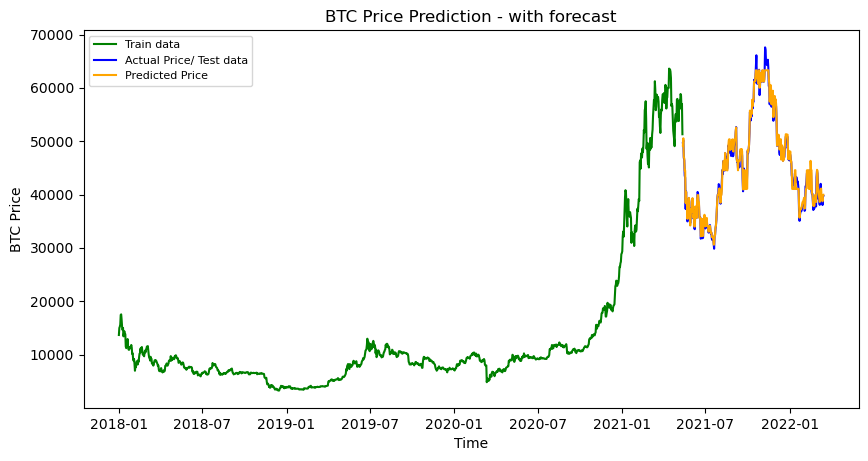

In [99]:
# plot results with train data

fore_series = pd.Series(y_pred, index=X_test.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

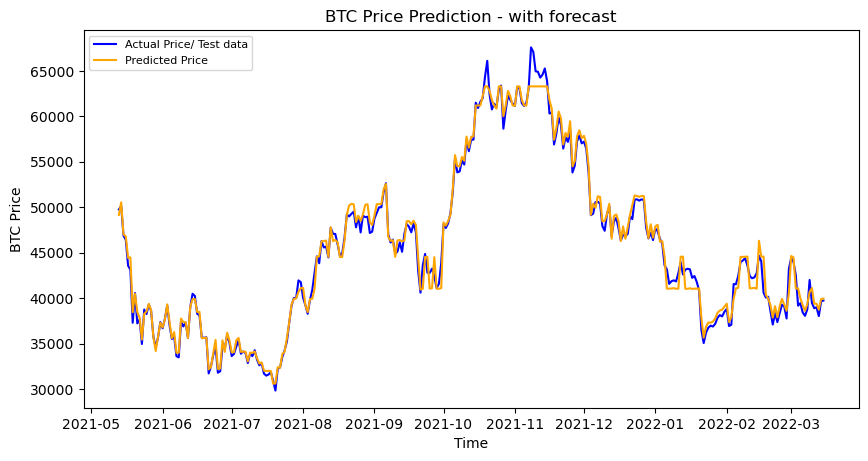

In [100]:
# plot results predictions and test data - zoom-in results

plt.figure(figsize=(10,5), dpi=100)
plt.plot(y_test, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 6.2. XGBRegressor  =>  data start from 2021-01-01

In [101]:
# copy data starting from 2021-01-01 and replace NaN values to 0

df_boost = btc_df_1.fillna(0).iloc[3821:]
df_boost.head()

open          high           low         close  \
time_close                                                           
2021-01-01  28966.955876  29568.278732  28812.981788  29344.673831   
2021-01-02  29362.566274  33099.708801  29069.538930  32072.078133   
2021-01-03  32144.223708  34566.831278  32070.588150  33048.027784   
2021-01-04  33002.191893  33622.499276  29297.126804  32084.607546   
2021-01-05  32096.860729  34473.824821  30302.159251  34105.463383   

              market_cap        volume  
time_close                              
2021-01-01  5.454546e+11  2.939528e+10  
2021-01-02  5.961821e+11  5.061019e+10  
2021-01-03  6.143566e+11  6.001208e+10  
2021-01-04  5.964811e+11  6.533459e+10  
2021-01-05  6.340841e+11  6.028160e+10

In [102]:
# create additional features from the date
# make index to datetime again

df_boost["date"] = pd.to_datetime(df_boost.index)

df_boost["hour"] = df_boost["date"].dt.hour
df_boost["day_of_week"] = df_boost["date"].dt.dayofweek
df_boost["quarter"] = df_boost["date"].dt.quarter
df_boost["month"] = df_boost["date"].dt.month
df_boost["year"] = df_boost["date"].dt.year
df_boost["day_of_year"] = df_boost["date"].dt.dayofyear
df_boost["day_of_month"] = df_boost["date"].dt.day
df_boost["week_of_year"] = df_boost["date"].dt.weekofyear

In [103]:
# define X and y

X = df_boost[["open" ,"high", "low", "market_cap", "volume", 
              "hour", "day_of_week", "quarter", "month", "year", "day_of_year", "day_of_month", "week_of_year"]]
y = df_boost["close"]

In [104]:
len(X), (len(y))

(439, 439)

In [105]:
# train, test, split the data
# train = 0.8*data
# test  = 0.2*data

size = int(len(X)*0.8)

X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]

In [106]:
X_train

open          high           low    market_cap  \
time_close                                                           
2021-01-01  28966.955876  29568.278732  28812.981788  5.454546e+11   
2021-01-02  29362.566274  33099.708801  29069.538930  5.961821e+11   
2021-01-03  32144.223708  34566.831278  32070.588150  6.143566e+11   
2021-01-04  33002.191893  33622.499276  29297.126804  5.964811e+11   
2021-01-05  32096.860729  34473.824821  30302.159251  6.340841e+11   
...                  ...           ...           ...           ...   
2021-12-13  50088.045922  50156.720167  46281.558961  8.851867e+11   
2021-12-14  46810.447305  48614.335495  46568.619481  9.154176e+11   
2021-12-15  48430.025626  49450.106613  46815.091526  9.231516e+11   
2021-12-16  48899.010032  49349.000983  47654.334136  9.017375e+11   
2021-12-17  47666.563405  47959.776763  45918.092142  8.760476e+11   

                  volume  hour  day_of_week  quarter  month  year  \
time_close                                                          
2021-01-01  2.939528e+10     0            4        1      1  2021   
2021-01-02  5.061019e+10     0            5        1      1  2021   
2021-01-03  6.001208e+10     0            6        1      1  2021   
2021-01-04  6.533459e+10     0            0        1      1  2021   
2021-01-05  6.028160e+10     0            1        1      1  2021   
...                  ...   ...          ...      ...    ...   ...   
2021-12-13  3.691581e+10     0            0        4     12  2021   
2021-12-14  3.709631e+10     0            1        4     12  2021   
2021-12-15  3.974334e+10     0            2        4     12  2021   
2021-12-16  3.042040e+10     0            3        4     12  2021   
2021-12-17  3.854192e+10     0            4        4     12  2021   

            day_of_year  day_of_month  week_of_year  
time_close                                           
2021-01-01            1             1            53  
2021-01-02            2             2            53  
2021-01-03            3             3            53  
2021-01-04            4             4             1  
2021-01-05            5             5             1  
...                 ...           ...           ...  
2021-12-13          347            13            50  
2021-12-14          348            14            50  
2021-12-15          349            15            50  
2021-12-16          350            16            50  
2021-12-17          351            17            50  

[351 rows x 13 columns]

In [107]:
# GridSearchCV - by convention - always tries to maximize its score so loss function was determined by 
# "make_scorer" with "greater_is_better" parameter set to False.

scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [108]:
%%time

# fisrt try of evauating best params for XGBRegressor     

model = XGBRegressor(objective ='reg:squarederror',
                     booster='gbtree',             # Specify which booster to use: gbtree, gblinear or dart.
                     subsample=0.9,                # Subsample ratio of the training instance.
                     colsample_bytree=0.5)         # Subsample ratio of columns when constructing each tree.

param_grid = {
    'n_estimators':  [200, 300, 500],              # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    'learning_rate': [0.01, 0.06, 0.1]             # Boosting learning rate (xgb's "eta")
}

gscv = GridSearchCV(model, 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring=scorer)

gscv.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)], 
         early_stopping_rounds=20)


y_pred = gscv.best_estimator_.predict(X_test)

# print performance
rmse_XGB_2 = mean_squared_error(y_test, y_pred, squared=False)
print(model.__class__.__name__, rmse_XGB_2)

[0]	validation_0-rmse:48019.96484	validation_1-rmse:41842.21094
[1]	validation_0-rmse:47546.29688	validation_1-rmse:41444.66016
[2]	validation_0-rmse:47077.55078	validation_1-rmse:41030.17578
[3]	validation_0-rmse:46612.42578	validation_1-rmse:40645.86719
[4]	validation_0-rmse:46152.89844	validation_1-rmse:40264.35156
[5]	validation_0-rmse:45697.22656	validation_1-rmse:39882.80078
[6]	validation_0-rmse:45245.69922	validation_1-rmse:39508.49609
[7]	validation_0-rmse:44798.72656	validation_1-rmse:39139.24609
[8]	validation_0-rmse:44357.72656	validation_1-rmse:38757.54297
[9]	validation_0-rmse:43920.52344	validation_1-rmse:38379.47656
[10]	validation_0-rmse:43487.59766	validation_1-rmse:37994.08203
[11]	validation_0-rmse:43058.78125	validation_1-rmse:37618.86328
[12]	validation_0-rmse:42633.39062	validation_1-rmse:37268.38672
[13]	validation_0-rmse:42212.19922	validation_1-rmse:36926.32422
[14]	validation_0-rmse:41796.37891	validation_1-rmse:36556.64453
[15]	validation_0-rmse:41383.32812	

[126]	validation_0-rmse:13805.11523	validation_1-rmse:11940.37695
[127]	validation_0-rmse:13669.45215	validation_1-rmse:11818.72656
[128]	validation_0-rmse:13535.74902	validation_1-rmse:11699.70801
[129]	validation_0-rmse:13401.51269	validation_1-rmse:11550.41992
[130]	validation_0-rmse:13270.10644	validation_1-rmse:11432.49316
[131]	validation_0-rmse:13140.06250	validation_1-rmse:11317.30078
[132]	validation_0-rmse:13011.28418	validation_1-rmse:11202.12988
[133]	validation_0-rmse:12883.87598	validation_1-rmse:11090.82617
[134]	validation_0-rmse:12757.64844	validation_1-rmse:10973.43652
[135]	validation_0-rmse:12632.29492	validation_1-rmse:10860.96094
[136]	validation_0-rmse:12508.33301	validation_1-rmse:10747.32617
[137]	validation_0-rmse:12385.58008	validation_1-rmse:10637.51465
[138]	validation_0-rmse:12264.59473	validation_1-rmse:10528.85156
[139]	validation_0-rmse:12144.09082	validation_1-rmse:10416.95117
[140]	validation_0-rmse:12024.99023	validation_1-rmse:10310.25391
[141]	vali

[53]	validation_0-rmse:28444.37695	validation_1-rmse:25051.53125
[54]	validation_0-rmse:28164.18164	validation_1-rmse:24805.85742
[55]	validation_0-rmse:27888.13672	validation_1-rmse:24559.51758
[56]	validation_0-rmse:27613.68555	validation_1-rmse:24321.94922
[57]	validation_0-rmse:27342.59766	validation_1-rmse:24096.01758
[58]	validation_0-rmse:27074.12695	validation_1-rmse:23862.51953
[59]	validation_0-rmse:26808.58008	validation_1-rmse:23624.21484
[60]	validation_0-rmse:26545.04297	validation_1-rmse:23391.49219
[61]	validation_0-rmse:26284.11133	validation_1-rmse:23163.77148
[62]	validation_0-rmse:26025.49414	validation_1-rmse:22931.50391
[63]	validation_0-rmse:25770.64453	validation_1-rmse:22706.60156
[64]	validation_0-rmse:25518.83594	validation_1-rmse:22480.49414
[65]	validation_0-rmse:25269.23242	validation_1-rmse:22273.36914
[66]	validation_0-rmse:25021.08984	validation_1-rmse:22057.49609
[67]	validation_0-rmse:24781.95508	validation_1-rmse:21859.15820
[68]	validation_0-rmse:24

[179]	validation_0-rmse:8279.63574	validation_1-rmse:7101.13721
[180]	validation_0-rmse:8199.25586	validation_1-rmse:7028.56445
[181]	validation_0-rmse:8120.06934	validation_1-rmse:6958.35303
[182]	validation_0-rmse:8041.20752	validation_1-rmse:6889.29541
[183]	validation_0-rmse:7963.51562	validation_1-rmse:6821.20947
[184]	validation_0-rmse:7886.95068	validation_1-rmse:6754.42822
[185]	validation_0-rmse:7810.55859	validation_1-rmse:6687.50879
[186]	validation_0-rmse:7735.14453	validation_1-rmse:6620.18115
[187]	validation_0-rmse:7660.64209	validation_1-rmse:6552.25342
[188]	validation_0-rmse:7586.73535	validation_1-rmse:6486.06641
[189]	validation_0-rmse:7513.41504	validation_1-rmse:6419.53418
[190]	validation_0-rmse:7440.86328	validation_1-rmse:6357.03467
[191]	validation_0-rmse:7368.78174	validation_1-rmse:6293.25147
[192]	validation_0-rmse:7297.64111	validation_1-rmse:6231.57910
[193]	validation_0-rmse:7227.49951	validation_1-rmse:6170.70996
[194]	validation_0-rmse:7158.16016	valid

[106]	validation_0-rmse:16901.36133	validation_1-rmse:14757.19238
[107]	validation_0-rmse:16737.02344	validation_1-rmse:14608.47656
[108]	validation_0-rmse:16573.92383	validation_1-rmse:14460.66992
[109]	validation_0-rmse:16412.37109	validation_1-rmse:14314.70215
[110]	validation_0-rmse:16253.29492	validation_1-rmse:14173.31445
[111]	validation_0-rmse:16095.70703	validation_1-rmse:14029.18652
[112]	validation_0-rmse:15938.55957	validation_1-rmse:13891.15723
[113]	validation_0-rmse:15782.98633	validation_1-rmse:13751.61719
[114]	validation_0-rmse:15630.47266	validation_1-rmse:13616.22656
[115]	validation_0-rmse:15478.53711	validation_1-rmse:13483.26856
[116]	validation_0-rmse:15331.78418	validation_1-rmse:13341.94922
[117]	validation_0-rmse:15183.42383	validation_1-rmse:13210.94629
[118]	validation_0-rmse:15036.32129	validation_1-rmse:13081.75195
[119]	validation_0-rmse:14890.28906	validation_1-rmse:12956.76269
[120]	validation_0-rmse:14746.45898	validation_1-rmse:12828.21680
[121]	vali

[33]	validation_0-rmse:34620.12109	validation_1-rmse:30562.18164
[34]	validation_0-rmse:34278.85547	validation_1-rmse:30262.58203
[35]	validation_0-rmse:33940.80469	validation_1-rmse:29956.41016
[36]	validation_0-rmse:33607.05078	validation_1-rmse:29662.91602
[37]	validation_0-rmse:33276.81641	validation_1-rmse:29367.87695
[38]	validation_0-rmse:32949.92969	validation_1-rmse:29078.14648
[39]	validation_0-rmse:32625.75000	validation_1-rmse:28788.98828
[40]	validation_0-rmse:32304.30273	validation_1-rmse:28519.72266
[41]	validation_0-rmse:31986.98242	validation_1-rmse:28233.68555
[42]	validation_0-rmse:31672.97266	validation_1-rmse:27950.72070
[43]	validation_0-rmse:31361.30469	validation_1-rmse:27667.07227
[44]	validation_0-rmse:31052.23242	validation_1-rmse:27393.52148
[45]	validation_0-rmse:30746.11719	validation_1-rmse:27128.33789
[46]	validation_0-rmse:30442.58398	validation_1-rmse:26866.98047
[47]	validation_0-rmse:30144.28711	validation_1-rmse:26598.63672
[48]	validation_0-rmse:29

[159]	validation_0-rmse:10022.87305	validation_1-rmse:8608.91016
[160]	validation_0-rmse:9924.68164	validation_1-rmse:8519.60352
[161]	validation_0-rmse:9827.78418	validation_1-rmse:8430.50098
[162]	validation_0-rmse:9732.57617	validation_1-rmse:8346.79590
[163]	validation_0-rmse:9640.31250	validation_1-rmse:8256.33594
[164]	validation_0-rmse:9546.01367	validation_1-rmse:8170.27246
[165]	validation_0-rmse:9453.23926	validation_1-rmse:8086.66162
[166]	validation_0-rmse:9361.09180	validation_1-rmse:8005.75147
[167]	validation_0-rmse:9270.31348	validation_1-rmse:7921.75293
[168]	validation_0-rmse:9180.50098	validation_1-rmse:7843.37451
[169]	validation_0-rmse:9091.03613	validation_1-rmse:7763.42627
[170]	validation_0-rmse:9002.30371	validation_1-rmse:7681.87158
[171]	validation_0-rmse:8914.53613	validation_1-rmse:7604.30859
[172]	validation_0-rmse:8827.24707	validation_1-rmse:7526.46533
[173]	validation_0-rmse:8741.16211	validation_1-rmse:7449.05811
[174]	validation_0-rmse:8656.43066	vali

[86]	validation_0-rmse:20530.26172	validation_1-rmse:17902.06055
[87]	validation_0-rmse:20328.15039	validation_1-rmse:17718.50977
[88]	validation_0-rmse:20129.07031	validation_1-rmse:17541.76562
[89]	validation_0-rmse:19931.56445	validation_1-rmse:17371.67383
[90]	validation_0-rmse:19736.16211	validation_1-rmse:17193.87305
[91]	validation_0-rmse:19542.56445	validation_1-rmse:17028.25000
[92]	validation_0-rmse:19350.44531	validation_1-rmse:16851.06836
[93]	validation_0-rmse:19159.53320	validation_1-rmse:16679.76953
[94]	validation_0-rmse:18971.53711	validation_1-rmse:16513.63867
[95]	validation_0-rmse:18787.74414	validation_1-rmse:16336.21289
[96]	validation_0-rmse:18603.74609	validation_1-rmse:16180.57812
[97]	validation_0-rmse:18421.92188	validation_1-rmse:16020.98731
[98]	validation_0-rmse:18240.96289	validation_1-rmse:15854.52734
[99]	validation_0-rmse:18062.05664	validation_1-rmse:15694.75879
[100]	validation_0-rmse:17884.04883	validation_1-rmse:15535.26758
[101]	validation_0-rmse:

[13]	validation_0-rmse:42205.91406	validation_1-rmse:36872.76172
[14]	validation_0-rmse:41789.28125	validation_1-rmse:36515.39062
[15]	validation_0-rmse:41377.21484	validation_1-rmse:36175.26562
[16]	validation_0-rmse:40967.65234	validation_1-rmse:35812.97266
[17]	validation_0-rmse:40562.46484	validation_1-rmse:35474.42969
[18]	validation_0-rmse:40161.55859	validation_1-rmse:35139.75391
[19]	validation_0-rmse:39765.24609	validation_1-rmse:34787.77734
[20]	validation_0-rmse:39371.46484	validation_1-rmse:34458.70312
[21]	validation_0-rmse:38983.07812	validation_1-rmse:34112.82422
[22]	validation_0-rmse:38598.01953	validation_1-rmse:33770.37500
[23]	validation_0-rmse:38216.17188	validation_1-rmse:33453.30859
[24]	validation_0-rmse:37837.64062	validation_1-rmse:33135.48828
[25]	validation_0-rmse:37464.21094	validation_1-rmse:32803.79297
[26]	validation_0-rmse:37095.25391	validation_1-rmse:32485.66211
[27]	validation_0-rmse:36730.80469	validation_1-rmse:32171.26367
[28]	validation_0-rmse:36

[139]	validation_0-rmse:12150.55176	validation_1-rmse:10410.04102
[140]	validation_0-rmse:12032.02832	validation_1-rmse:10306.04688
[141]	validation_0-rmse:11914.20117	validation_1-rmse:10200.93848
[142]	validation_0-rmse:11797.33008	validation_1-rmse:10096.46582
[143]	validation_0-rmse:11682.19629	validation_1-rmse:9991.53418
[144]	validation_0-rmse:11568.47559	validation_1-rmse:9888.02539
[145]	validation_0-rmse:11455.78906	validation_1-rmse:9789.33887
[146]	validation_0-rmse:11343.67188	validation_1-rmse:9692.47754
[147]	validation_0-rmse:11233.34570	validation_1-rmse:9597.37109
[148]	validation_0-rmse:11123.78613	validation_1-rmse:9499.34766
[149]	validation_0-rmse:11014.58691	validation_1-rmse:9398.65137
[150]	validation_0-rmse:10907.20410	validation_1-rmse:9301.53320
[151]	validation_0-rmse:10800.16602	validation_1-rmse:9205.82422
[152]	validation_0-rmse:10694.07129	validation_1-rmse:9111.35547
[153]	validation_0-rmse:10590.13379	validation_1-rmse:9018.85742
[154]	validation_0-rm

[66]	validation_0-rmse:25024.84961	validation_1-rmse:22209.12695
[67]	validation_0-rmse:24780.96289	validation_1-rmse:21972.00195
[68]	validation_0-rmse:24537.62109	validation_1-rmse:21759.90430
[69]	validation_0-rmse:24296.34180	validation_1-rmse:21541.87500
[70]	validation_0-rmse:24057.22070	validation_1-rmse:21332.74219
[71]	validation_0-rmse:23820.31836	validation_1-rmse:21118.83008
[72]	validation_0-rmse:23587.71875	validation_1-rmse:20909.00000
[73]	validation_0-rmse:23356.37109	validation_1-rmse:20698.99023
[74]	validation_0-rmse:23126.01562	validation_1-rmse:20486.14648
[75]	validation_0-rmse:22898.70508	validation_1-rmse:20278.19727
[76]	validation_0-rmse:22673.81836	validation_1-rmse:20080.09570
[77]	validation_0-rmse:22450.44727	validation_1-rmse:19878.23633
[78]	validation_0-rmse:22229.06836	validation_1-rmse:19672.16016
[79]	validation_0-rmse:22010.81250	validation_1-rmse:19473.56836
[80]	validation_0-rmse:21794.22461	validation_1-rmse:19277.84375
[81]	validation_0-rmse:21

[192]	validation_0-rmse:7257.19482	validation_1-rmse:6232.50000
[193]	validation_0-rmse:7186.88428	validation_1-rmse:6170.83154
[194]	validation_0-rmse:7117.35449	validation_1-rmse:6109.81592
[195]	validation_0-rmse:7048.07031	validation_1-rmse:6047.91992
[196]	validation_0-rmse:6979.97705	validation_1-rmse:5988.34375
[197]	validation_0-rmse:6911.99658	validation_1-rmse:5927.19727
[198]	validation_0-rmse:6844.80518	validation_1-rmse:5867.47217
[199]	validation_0-rmse:6778.42334	validation_1-rmse:5808.02393
[0]	validation_0-rmse:48022.95312	validation_1-rmse:41851.85938
[1]	validation_0-rmse:47551.21484	validation_1-rmse:41465.75391
[2]	validation_0-rmse:47085.89844	validation_1-rmse:41089.54688
[3]	validation_0-rmse:46622.88672	validation_1-rmse:40714.89062
[4]	validation_0-rmse:46164.44141	validation_1-rmse:40341.21484
[5]	validation_0-rmse:45711.15625	validation_1-rmse:39974.18359
[6]	validation_0-rmse:45261.51172	validation_1-rmse:39603.55469
[7]	validation_0-rmse:44817.37500	valida

[119]	validation_0-rmse:14852.77441	validation_1-rmse:13161.23242
[120]	validation_0-rmse:14708.30664	validation_1-rmse:13031.60840
[121]	validation_0-rmse:14564.06152	validation_1-rmse:12901.25488
[122]	validation_0-rmse:14421.38281	validation_1-rmse:12770.18164
[123]	validation_0-rmse:14280.66797	validation_1-rmse:12642.83594
[124]	validation_0-rmse:14141.25586	validation_1-rmse:12518.52539
[125]	validation_0-rmse:14003.46582	validation_1-rmse:12401.16602
[126]	validation_0-rmse:13865.31250	validation_1-rmse:12272.15625
[127]	validation_0-rmse:13730.20410	validation_1-rmse:12149.20801
[128]	validation_0-rmse:13595.85938	validation_1-rmse:12029.81445
[129]	validation_0-rmse:13462.66699	validation_1-rmse:11909.93555
[130]	validation_0-rmse:13329.70801	validation_1-rmse:11785.66211
[131]	validation_0-rmse:13199.49609	validation_1-rmse:11669.49609
[132]	validation_0-rmse:13069.63769	validation_1-rmse:11548.67090
[133]	validation_0-rmse:12941.55273	validation_1-rmse:11432.86133
[134]	vali

[46]	validation_0-rmse:30669.43359	validation_1-rmse:26824.13867
[47]	validation_0-rmse:30373.74609	validation_1-rmse:26560.16406
[48]	validation_0-rmse:30080.51172	validation_1-rmse:26303.65625
[49]	validation_0-rmse:29797.06055	validation_1-rmse:26029.62305
[50]	validation_0-rmse:29509.16602	validation_1-rmse:25774.41797
[51]	validation_0-rmse:29223.70898	validation_1-rmse:25524.51953
[52]	validation_0-rmse:28942.22070	validation_1-rmse:25273.75586
[53]	validation_0-rmse:28663.01172	validation_1-rmse:25023.56055
[54]	validation_0-rmse:28385.82031	validation_1-rmse:24773.64062
[55]	validation_0-rmse:28111.51953	validation_1-rmse:24527.16992
[56]	validation_0-rmse:27840.87500	validation_1-rmse:24282.88672
[57]	validation_0-rmse:27572.70117	validation_1-rmse:24043.03125
[58]	validation_0-rmse:27308.82617	validation_1-rmse:23818.39844
[59]	validation_0-rmse:27044.84180	validation_1-rmse:23579.93359
[60]	validation_0-rmse:26783.77734	validation_1-rmse:23345.19141
[61]	validation_0-rmse:26

[172]	validation_0-rmse:9222.85449	validation_1-rmse:7598.30762
[173]	validation_0-rmse:9135.21191	validation_1-rmse:7521.38184
[174]	validation_0-rmse:9049.77637	validation_1-rmse:7446.99121
[175]	validation_0-rmse:8964.08496	validation_1-rmse:7371.52490
[176]	validation_0-rmse:8878.74707	validation_1-rmse:7296.88135
[177]	validation_0-rmse:8796.39356	validation_1-rmse:7223.70703
[178]	validation_0-rmse:8714.12012	validation_1-rmse:7154.10254
[179]	validation_0-rmse:8631.90625	validation_1-rmse:7084.58154
[180]	validation_0-rmse:8550.57715	validation_1-rmse:7014.80615
[181]	validation_0-rmse:8470.11328	validation_1-rmse:6946.79199
[182]	validation_0-rmse:8390.33203	validation_1-rmse:6878.07373
[183]	validation_0-rmse:8310.79004	validation_1-rmse:6808.23193
[184]	validation_0-rmse:8233.86426	validation_1-rmse:6737.63379
[185]	validation_0-rmse:8156.64795	validation_1-rmse:6670.82373
[186]	validation_0-rmse:8081.24951	validation_1-rmse:6606.17188
[187]	validation_0-rmse:8006.98047	valid

[99]	validation_0-rmse:18057.49414	validation_1-rmse:15774.78613
[100]	validation_0-rmse:17879.97266	validation_1-rmse:15615.52734
[101]	validation_0-rmse:17704.31836	validation_1-rmse:15460.91211
[102]	validation_0-rmse:17530.99023	validation_1-rmse:15303.88574
[103]	validation_0-rmse:17358.87500	validation_1-rmse:15151.45117
[104]	validation_0-rmse:17188.92969	validation_1-rmse:14994.09961
[105]	validation_0-rmse:17019.91992	validation_1-rmse:14842.97949
[106]	validation_0-rmse:16852.96289	validation_1-rmse:14690.04590
[107]	validation_0-rmse:16687.04492	validation_1-rmse:14539.16894
[108]	validation_0-rmse:16522.89453	validation_1-rmse:14392.07519
[109]	validation_0-rmse:16360.18164	validation_1-rmse:14246.75977
[110]	validation_0-rmse:16199.93652	validation_1-rmse:14105.24121
[111]	validation_0-rmse:16041.13574	validation_1-rmse:13960.84082
[112]	validation_0-rmse:15884.05762	validation_1-rmse:13823.21484
[113]	validation_0-rmse:15728.35547	validation_1-rmse:13680.42090
[114]	valid

[34]	validation_0-rmse:34278.85547	validation_1-rmse:30262.58203
[35]	validation_0-rmse:33940.80469	validation_1-rmse:29956.41016
[36]	validation_0-rmse:33607.05078	validation_1-rmse:29662.91602
[37]	validation_0-rmse:33276.81641	validation_1-rmse:29367.87695
[38]	validation_0-rmse:32949.92969	validation_1-rmse:29078.14648
[39]	validation_0-rmse:32625.75000	validation_1-rmse:28788.98828
[40]	validation_0-rmse:32304.30273	validation_1-rmse:28519.72266
[41]	validation_0-rmse:31986.98242	validation_1-rmse:28233.68555
[42]	validation_0-rmse:31672.97266	validation_1-rmse:27950.72070
[43]	validation_0-rmse:31361.30469	validation_1-rmse:27667.07227
[44]	validation_0-rmse:31052.23242	validation_1-rmse:27393.52148
[45]	validation_0-rmse:30746.11719	validation_1-rmse:27128.33789
[46]	validation_0-rmse:30442.58398	validation_1-rmse:26866.98047
[47]	validation_0-rmse:30144.28711	validation_1-rmse:26598.63672
[48]	validation_0-rmse:29847.59961	validation_1-rmse:26338.56055
[49]	validation_0-rmse:29

[159]	validation_0-rmse:10022.87305	validation_1-rmse:8608.91016
[160]	validation_0-rmse:9924.68164	validation_1-rmse:8519.60352
[161]	validation_0-rmse:9827.78418	validation_1-rmse:8430.50098
[162]	validation_0-rmse:9732.57617	validation_1-rmse:8346.79590
[163]	validation_0-rmse:9640.31250	validation_1-rmse:8256.33594
[164]	validation_0-rmse:9546.01367	validation_1-rmse:8170.27246
[165]	validation_0-rmse:9453.23926	validation_1-rmse:8086.66162
[166]	validation_0-rmse:9361.09180	validation_1-rmse:8005.75147
[167]	validation_0-rmse:9270.31348	validation_1-rmse:7921.75293
[168]	validation_0-rmse:9180.50098	validation_1-rmse:7843.37451
[169]	validation_0-rmse:9091.03613	validation_1-rmse:7763.42627
[170]	validation_0-rmse:9002.30371	validation_1-rmse:7681.87158
[171]	validation_0-rmse:8914.53613	validation_1-rmse:7604.30859
[172]	validation_0-rmse:8827.24707	validation_1-rmse:7526.46533
[173]	validation_0-rmse:8741.16211	validation_1-rmse:7449.05811
[174]	validation_0-rmse:8656.43066	vali

[287]	validation_0-rmse:2904.44556	validation_1-rmse:2299.42139
[288]	validation_0-rmse:2876.86914	validation_1-rmse:2276.07300
[289]	validation_0-rmse:2849.77979	validation_1-rmse:2252.22778
[290]	validation_0-rmse:2823.23169	validation_1-rmse:2230.04394
[291]	validation_0-rmse:2796.42017	validation_1-rmse:2207.14697
[292]	validation_0-rmse:2769.96069	validation_1-rmse:2184.61938
[293]	validation_0-rmse:2743.95703	validation_1-rmse:2163.38525
[294]	validation_0-rmse:2718.24512	validation_1-rmse:2141.62598
[295]	validation_0-rmse:2693.48633	validation_1-rmse:2128.75439
[296]	validation_0-rmse:2668.29688	validation_1-rmse:2107.85864
[297]	validation_0-rmse:2643.39722	validation_1-rmse:2087.01318
[298]	validation_0-rmse:2618.54858	validation_1-rmse:2065.89429
[299]	validation_0-rmse:2594.16870	validation_1-rmse:2045.03162
[0]	validation_0-rmse:48021.42969	validation_1-rmse:41820.03906
[1]	validation_0-rmse:47547.94922	validation_1-rmse:41407.90234
[2]	validation_0-rmse:47078.67969	valida

[114]	validation_0-rmse:15578.61816	validation_1-rmse:13458.67188
[115]	validation_0-rmse:15426.74219	validation_1-rmse:13328.06152
[116]	validation_0-rmse:15277.95019	validation_1-rmse:13185.06250
[117]	validation_0-rmse:15128.75293	validation_1-rmse:13053.71289
[118]	validation_0-rmse:14980.24805	validation_1-rmse:12920.41992
[119]	validation_0-rmse:14834.18848	validation_1-rmse:12794.92383
[120]	validation_0-rmse:14688.03125	validation_1-rmse:12665.02734
[121]	validation_0-rmse:14544.01172	validation_1-rmse:12536.15137
[122]	validation_0-rmse:14400.48047	validation_1-rmse:12403.74023
[123]	validation_0-rmse:14259.81836	validation_1-rmse:12279.15332
[124]	validation_0-rmse:14119.54590	validation_1-rmse:12150.61719
[125]	validation_0-rmse:13980.70898	validation_1-rmse:12024.75879
[126]	validation_0-rmse:13843.03613	validation_1-rmse:11901.90430
[127]	validation_0-rmse:13708.68066	validation_1-rmse:11784.64648
[128]	validation_0-rmse:13573.73438	validation_1-rmse:11663.86719
[129]	vali

[55]	validation_0-rmse:27826.01172	validation_1-rmse:24419.13281
[56]	validation_0-rmse:27551.13086	validation_1-rmse:24184.62305
[57]	validation_0-rmse:27280.15625	validation_1-rmse:23946.99023
[58]	validation_0-rmse:27011.94727	validation_1-rmse:23713.94531
[59]	validation_0-rmse:26746.10547	validation_1-rmse:23472.50391
[60]	validation_0-rmse:26483.36328	validation_1-rmse:23246.49219
[61]	validation_0-rmse:26222.33789	validation_1-rmse:23016.20508
[62]	validation_0-rmse:25964.66406	validation_1-rmse:22781.75000
[63]	validation_0-rmse:25709.45312	validation_1-rmse:22556.62500
[64]	validation_0-rmse:25456.86523	validation_1-rmse:22336.43555
[65]	validation_0-rmse:25206.59570	validation_1-rmse:22127.02344
[66]	validation_0-rmse:24957.46094	validation_1-rmse:21900.32031
[67]	validation_0-rmse:24709.65820	validation_1-rmse:21666.20312
[68]	validation_0-rmse:24466.06055	validation_1-rmse:21450.23047
[69]	validation_0-rmse:24224.43555	validation_1-rmse:21234.19727
[70]	validation_0-rmse:23

[181]	validation_0-rmse:8046.48779	validation_1-rmse:6749.09228
[182]	validation_0-rmse:7968.45654	validation_1-rmse:6682.03369
[183]	validation_0-rmse:7890.71924	validation_1-rmse:6613.60107
[184]	validation_0-rmse:7813.61914	validation_1-rmse:6546.72607
[185]	validation_0-rmse:7737.79541	validation_1-rmse:6481.30566
[186]	validation_0-rmse:7662.77832	validation_1-rmse:6416.86914
[187]	validation_0-rmse:7588.37744	validation_1-rmse:6351.78320
[188]	validation_0-rmse:7514.57080	validation_1-rmse:6283.84766
[189]	validation_0-rmse:7441.18750	validation_1-rmse:6221.03418
[190]	validation_0-rmse:7368.87158	validation_1-rmse:6159.71240
[191]	validation_0-rmse:7296.91455	validation_1-rmse:6097.84766
[192]	validation_0-rmse:7225.66553	validation_1-rmse:6033.15088
[193]	validation_0-rmse:7155.16797	validation_1-rmse:5971.86865
[194]	validation_0-rmse:7085.54346	validation_1-rmse:5910.85498
[195]	validation_0-rmse:7016.33936	validation_1-rmse:5846.87598
[196]	validation_0-rmse:6948.56201	valid

[10]	validation_0-rmse:43509.02344	validation_1-rmse:38133.40234
[11]	validation_0-rmse:43081.76953	validation_1-rmse:37778.83203
[12]	validation_0-rmse:42657.42188	validation_1-rmse:37409.70703
[13]	validation_0-rmse:42240.62891	validation_1-rmse:37051.99219
[14]	validation_0-rmse:41825.24219	validation_1-rmse:36717.49219
[15]	validation_0-rmse:41414.95312	validation_1-rmse:36378.26562
[16]	validation_0-rmse:41007.55469	validation_1-rmse:36023.38281
[17]	validation_0-rmse:40604.87500	validation_1-rmse:35689.07422
[18]	validation_0-rmse:40206.30859	validation_1-rmse:35361.89844
[19]	validation_0-rmse:39811.33984	validation_1-rmse:35036.82422
[20]	validation_0-rmse:39419.44531	validation_1-rmse:34714.75391
[21]	validation_0-rmse:39031.64062	validation_1-rmse:34376.31641
[22]	validation_0-rmse:38648.10156	validation_1-rmse:34063.15234
[23]	validation_0-rmse:38268.42969	validation_1-rmse:33753.09766
[24]	validation_0-rmse:37891.90234	validation_1-rmse:33442.79297
[25]	validation_0-rmse:37

[136]	validation_0-rmse:12556.70312	validation_1-rmse:10977.64356
[137]	validation_0-rmse:12434.40039	validation_1-rmse:10868.51367
[138]	validation_0-rmse:12312.93848	validation_1-rmse:10757.89258
[139]	validation_0-rmse:12192.25391	validation_1-rmse:10646.14941
[140]	validation_0-rmse:12073.64160	validation_1-rmse:10542.93164
[141]	validation_0-rmse:11955.78613	validation_1-rmse:10437.99219
[142]	validation_0-rmse:11839.10156	validation_1-rmse:10336.08008
[143]	validation_0-rmse:11724.33496	validation_1-rmse:10231.70508
[144]	validation_0-rmse:11611.46289	validation_1-rmse:10130.23633
[145]	validation_0-rmse:11498.02344	validation_1-rmse:10026.28516
[146]	validation_0-rmse:11385.61426	validation_1-rmse:9927.72070
[147]	validation_0-rmse:11274.80957	validation_1-rmse:9830.25977
[148]	validation_0-rmse:11164.42676	validation_1-rmse:9735.75098
[149]	validation_0-rmse:11055.74316	validation_1-rmse:9637.01269
[150]	validation_0-rmse:10947.86035	validation_1-rmse:9539.00391
[151]	validatio

[264]	validation_0-rmse:3610.30615	validation_1-rmse:3003.07739
[265]	validation_0-rmse:3575.52100	validation_1-rmse:2972.12134
[266]	validation_0-rmse:3541.88794	validation_1-rmse:2943.01392
[267]	validation_0-rmse:3508.48657	validation_1-rmse:2914.31201
[268]	validation_0-rmse:3474.87695	validation_1-rmse:2884.51416
[269]	validation_0-rmse:3441.63672	validation_1-rmse:2855.51562
[270]	validation_0-rmse:3408.95532	validation_1-rmse:2827.34961
[271]	validation_0-rmse:3376.25708	validation_1-rmse:2798.12988
[272]	validation_0-rmse:3344.25366	validation_1-rmse:2769.95483
[273]	validation_0-rmse:3312.41894	validation_1-rmse:2742.31592
[274]	validation_0-rmse:3280.77051	validation_1-rmse:2714.60205
[275]	validation_0-rmse:3249.47363	validation_1-rmse:2687.01733
[276]	validation_0-rmse:3218.34277	validation_1-rmse:2659.84790
[277]	validation_0-rmse:3187.89404	validation_1-rmse:2634.24048
[278]	validation_0-rmse:3157.62085	validation_1-rmse:2607.95312
[279]	validation_0-rmse:3127.85644	valid

[91]	validation_0-rmse:19562.99023	validation_1-rmse:17391.56836
[92]	validation_0-rmse:19371.24414	validation_1-rmse:17217.73242
[93]	validation_0-rmse:19181.67188	validation_1-rmse:17047.08398
[94]	validation_0-rmse:18993.28711	validation_1-rmse:16878.16211
[95]	validation_0-rmse:18806.82812	validation_1-rmse:16699.91602
[96]	validation_0-rmse:18623.00000	validation_1-rmse:16538.61523
[97]	validation_0-rmse:18440.33203	validation_1-rmse:16378.95703
[98]	validation_0-rmse:18259.86133	validation_1-rmse:16217.66894
[99]	validation_0-rmse:18080.61523	validation_1-rmse:16055.25098
[100]	validation_0-rmse:17902.52148	validation_1-rmse:15889.53906
[101]	validation_0-rmse:17727.29883	validation_1-rmse:15733.05176
[102]	validation_0-rmse:17553.12305	validation_1-rmse:15575.63672
[103]	validation_0-rmse:17381.18750	validation_1-rmse:15423.19922
[104]	validation_0-rmse:17210.70312	validation_1-rmse:15266.48926
[105]	validation_0-rmse:17042.11523	validation_1-rmse:15113.44043
[106]	validation_0-

[217]	validation_0-rmse:5690.03223	validation_1-rmse:4908.89258
[218]	validation_0-rmse:5635.02637	validation_1-rmse:4858.61914
[219]	validation_0-rmse:5580.70850	validation_1-rmse:4811.74756
[220]	validation_0-rmse:5526.55273	validation_1-rmse:4762.50342
[221]	validation_0-rmse:5472.65478	validation_1-rmse:4712.62451
[222]	validation_0-rmse:5419.40723	validation_1-rmse:4665.06055
[223]	validation_0-rmse:5367.17920	validation_1-rmse:4619.44873
[224]	validation_0-rmse:5315.31201	validation_1-rmse:4573.11914
[225]	validation_0-rmse:5263.68066	validation_1-rmse:4526.86426
[226]	validation_0-rmse:5212.81006	validation_1-rmse:4480.07910
[227]	validation_0-rmse:5162.40772	validation_1-rmse:4436.60303
[228]	validation_0-rmse:5112.49023	validation_1-rmse:4392.44189
[229]	validation_0-rmse:5063.10938	validation_1-rmse:4347.40527
[230]	validation_0-rmse:5014.23682	validation_1-rmse:4303.54150
[231]	validation_0-rmse:4965.70215	validation_1-rmse:4260.01660
[232]	validation_0-rmse:4917.59912	valid

[45]	validation_0-rmse:30968.28711	validation_1-rmse:27096.99414
[46]	validation_0-rmse:30669.43359	validation_1-rmse:26824.13867
[47]	validation_0-rmse:30373.74609	validation_1-rmse:26560.16406
[48]	validation_0-rmse:30080.51172	validation_1-rmse:26303.65625
[49]	validation_0-rmse:29797.06055	validation_1-rmse:26029.62305
[50]	validation_0-rmse:29509.16602	validation_1-rmse:25774.41797
[51]	validation_0-rmse:29223.70898	validation_1-rmse:25524.51953
[52]	validation_0-rmse:28942.22070	validation_1-rmse:25273.75586
[53]	validation_0-rmse:28663.01172	validation_1-rmse:25023.56055
[54]	validation_0-rmse:28385.82031	validation_1-rmse:24773.64062
[55]	validation_0-rmse:28111.51953	validation_1-rmse:24527.16992
[56]	validation_0-rmse:27840.87500	validation_1-rmse:24282.88672
[57]	validation_0-rmse:27572.70117	validation_1-rmse:24043.03125
[58]	validation_0-rmse:27308.82617	validation_1-rmse:23818.39844
[59]	validation_0-rmse:27044.84180	validation_1-rmse:23579.93359
[60]	validation_0-rmse:26

[171]	validation_0-rmse:9311.37305	validation_1-rmse:7675.85791
[172]	validation_0-rmse:9222.85449	validation_1-rmse:7598.30762
[173]	validation_0-rmse:9135.21191	validation_1-rmse:7521.38184
[174]	validation_0-rmse:9049.77637	validation_1-rmse:7446.99121
[175]	validation_0-rmse:8964.08496	validation_1-rmse:7371.52490
[176]	validation_0-rmse:8878.74707	validation_1-rmse:7296.88135
[177]	validation_0-rmse:8796.39356	validation_1-rmse:7223.70703
[178]	validation_0-rmse:8714.12012	validation_1-rmse:7154.10254
[179]	validation_0-rmse:8631.90625	validation_1-rmse:7084.58154
[180]	validation_0-rmse:8550.57715	validation_1-rmse:7014.80615
[181]	validation_0-rmse:8470.11328	validation_1-rmse:6946.79199
[182]	validation_0-rmse:8390.33203	validation_1-rmse:6878.07373
[183]	validation_0-rmse:8310.79004	validation_1-rmse:6808.23193
[184]	validation_0-rmse:8233.86426	validation_1-rmse:6737.63379
[185]	validation_0-rmse:8156.64795	validation_1-rmse:6670.82373
[186]	validation_0-rmse:8081.24951	valid

[0]	validation_0-rmse:48021.46484	validation_1-rmse:41824.82031
[1]	validation_0-rmse:47548.32031	validation_1-rmse:41417.60938
[2]	validation_0-rmse:47079.51953	validation_1-rmse:41015.19531
[3]	validation_0-rmse:46616.82812	validation_1-rmse:40634.58984
[4]	validation_0-rmse:46158.03125	validation_1-rmse:40238.35156
[5]	validation_0-rmse:45704.10547	validation_1-rmse:39844.83203
[6]	validation_0-rmse:45253.92969	validation_1-rmse:39453.44141
[7]	validation_0-rmse:44808.92578	validation_1-rmse:39085.02344
[8]	validation_0-rmse:44367.42578	validation_1-rmse:38719.81250
[9]	validation_0-rmse:43930.70703	validation_1-rmse:38353.76953
[10]	validation_0-rmse:43497.84375	validation_1-rmse:38001.42188
[11]	validation_0-rmse:43069.87500	validation_1-rmse:37646.76562
[12]	validation_0-rmse:42645.55078	validation_1-rmse:37275.72656
[13]	validation_0-rmse:42226.44141	validation_1-rmse:36936.70312
[14]	validation_0-rmse:41810.49219	validation_1-rmse:36578.62500
[15]	validation_0-rmse:41399.33203	

[126]	validation_0-rmse:13838.53809	validation_1-rmse:12002.61523
[127]	validation_0-rmse:13703.40234	validation_1-rmse:11882.73340
[128]	validation_0-rmse:13568.87793	validation_1-rmse:11765.02246
[129]	validation_0-rmse:13435.37207	validation_1-rmse:11647.10938
[130]	validation_0-rmse:13303.32227	validation_1-rmse:11526.32129
[131]	validation_0-rmse:13173.26660	validation_1-rmse:11411.51269
[132]	validation_0-rmse:13044.34668	validation_1-rmse:11301.40039
[133]	validation_0-rmse:12916.93848	validation_1-rmse:11187.45703
[134]	validation_0-rmse:12790.19043	validation_1-rmse:11071.23828
[135]	validation_0-rmse:12665.16894	validation_1-rmse:10961.02930
[136]	validation_0-rmse:12541.99316	validation_1-rmse:10847.02344
[137]	validation_0-rmse:12419.67090	validation_1-rmse:10739.57812
[138]	validation_0-rmse:12297.90723	validation_1-rmse:10629.86426
[139]	validation_0-rmse:12177.69824	validation_1-rmse:10523.75879
[140]	validation_0-rmse:12058.95703	validation_1-rmse:10420.25879
[141]	vali

[254]	validation_0-rmse:3949.19287	validation_1-rmse:3231.65332
[255]	validation_0-rmse:3910.69946	validation_1-rmse:3198.35522
[256]	validation_0-rmse:3873.22241	validation_1-rmse:3165.77246
[257]	validation_0-rmse:3836.27197	validation_1-rmse:3134.81982
[258]	validation_0-rmse:3799.52466	validation_1-rmse:3102.85596
[259]	validation_0-rmse:3762.91748	validation_1-rmse:3071.01343
[260]	validation_0-rmse:3726.21191	validation_1-rmse:3038.94116
[261]	validation_0-rmse:3689.95093	validation_1-rmse:3007.48560
[262]	validation_0-rmse:3654.10669	validation_1-rmse:2976.55249
[263]	validation_0-rmse:3619.12598	validation_1-rmse:2947.18359
[264]	validation_0-rmse:3584.39893	validation_1-rmse:2916.96240
[265]	validation_0-rmse:3549.99145	validation_1-rmse:2886.48144
[266]	validation_0-rmse:3515.62598	validation_1-rmse:2858.63672
[267]	validation_0-rmse:3482.23193	validation_1-rmse:2829.91821
[268]	validation_0-rmse:3448.70093	validation_1-rmse:2802.22070
[269]	validation_0-rmse:3415.25977	valid

[81]	validation_0-rmse:21526.73438	validation_1-rmse:18861.81445
[82]	validation_0-rmse:21314.81641	validation_1-rmse:18673.30859
[83]	validation_0-rmse:21105.05078	validation_1-rmse:18480.66602
[84]	validation_0-rmse:20897.90820	validation_1-rmse:18290.93750
[85]	validation_0-rmse:20692.32031	validation_1-rmse:18110.24805
[86]	validation_0-rmse:20488.41992	validation_1-rmse:17920.37305
[87]	validation_0-rmse:20287.09180	validation_1-rmse:17737.85742
[88]	validation_0-rmse:20088.23828	validation_1-rmse:17563.53320
[89]	validation_0-rmse:19891.08594	validation_1-rmse:17388.95117
[90]	validation_0-rmse:19694.43359	validation_1-rmse:17205.02344
[91]	validation_0-rmse:19501.68164	validation_1-rmse:17031.31055
[92]	validation_0-rmse:19310.42188	validation_1-rmse:16860.72852
[93]	validation_0-rmse:19120.83594	validation_1-rmse:16692.64062
[94]	validation_0-rmse:18932.76953	validation_1-rmse:16521.68750
[95]	validation_0-rmse:18747.73242	validation_1-rmse:16362.73535
[96]	validation_0-rmse:18

[208]	validation_0-rmse:6163.64893	validation_1-rmse:5057.68262
[209]	validation_0-rmse:6104.03564	validation_1-rmse:5005.09082
[210]	validation_0-rmse:6044.81152	validation_1-rmse:4952.67969
[211]	validation_0-rmse:5985.76465	validation_1-rmse:4901.42480
[212]	validation_0-rmse:5927.74365	validation_1-rmse:4848.05811
[213]	validation_0-rmse:5869.63232	validation_1-rmse:4798.58594
[214]	validation_0-rmse:5812.22559	validation_1-rmse:4747.53955
[215]	validation_0-rmse:5755.62305	validation_1-rmse:4697.50439
[216]	validation_0-rmse:5699.69629	validation_1-rmse:4649.72559
[217]	validation_0-rmse:5644.22461	validation_1-rmse:4600.70654
[218]	validation_0-rmse:5589.33936	validation_1-rmse:4551.65625
[219]	validation_0-rmse:5535.10791	validation_1-rmse:4503.28223
[220]	validation_0-rmse:5481.22656	validation_1-rmse:4456.79102
[221]	validation_0-rmse:5428.01758	validation_1-rmse:4411.70410
[222]	validation_0-rmse:5375.64355	validation_1-rmse:4365.26270
[223]	validation_0-rmse:5323.35791	valid

[337]	validation_0-rmse:1800.12622	validation_1-rmse:1364.40466
[338]	validation_0-rmse:1784.13745	validation_1-rmse:1354.72339
[339]	validation_0-rmse:1768.01001	validation_1-rmse:1343.16040
[340]	validation_0-rmse:1752.08496	validation_1-rmse:1332.96704
[341]	validation_0-rmse:1736.38672	validation_1-rmse:1321.08276
[342]	validation_0-rmse:1720.89429	validation_1-rmse:1309.35413
[343]	validation_0-rmse:1705.89795	validation_1-rmse:1297.66260
[344]	validation_0-rmse:1690.60779	validation_1-rmse:1285.69128
[345]	validation_0-rmse:1675.38062	validation_1-rmse:1275.04028
[346]	validation_0-rmse:1660.26099	validation_1-rmse:1264.45960
[347]	validation_0-rmse:1645.72974	validation_1-rmse:1254.07324
[348]	validation_0-rmse:1631.25964	validation_1-rmse:1245.67249
[349]	validation_0-rmse:1616.33044	validation_1-rmse:1235.00708
[350]	validation_0-rmse:1601.96582	validation_1-rmse:1227.98547
[351]	validation_0-rmse:1587.55957	validation_1-rmse:1217.34644
[352]	validation_0-rmse:1573.49500	valid

[468]	validation_0-rmse:643.33344	validation_1-rmse:779.44354
[469]	validation_0-rmse:639.31079	validation_1-rmse:779.39087
[470]	validation_0-rmse:634.87421	validation_1-rmse:778.20660
[471]	validation_0-rmse:630.68005	validation_1-rmse:776.98132
[472]	validation_0-rmse:626.34796	validation_1-rmse:775.41229
[473]	validation_0-rmse:622.78613	validation_1-rmse:774.55457
[474]	validation_0-rmse:618.97180	validation_1-rmse:773.33624
[475]	validation_0-rmse:615.18878	validation_1-rmse:771.79901
[476]	validation_0-rmse:611.18213	validation_1-rmse:769.46881
[477]	validation_0-rmse:607.03137	validation_1-rmse:767.84998
[478]	validation_0-rmse:603.40015	validation_1-rmse:766.62750
[479]	validation_0-rmse:599.91943	validation_1-rmse:764.78882
[480]	validation_0-rmse:596.63226	validation_1-rmse:764.55139
[481]	validation_0-rmse:593.18439	validation_1-rmse:763.61200
[482]	validation_0-rmse:589.68854	validation_1-rmse:762.76141
[483]	validation_0-rmse:586.32074	validation_1-rmse:762.48804
[484]	va

[96]	validation_0-rmse:18637.36719	validation_1-rmse:16391.39648
[97]	validation_0-rmse:18453.82617	validation_1-rmse:16230.10938
[98]	validation_0-rmse:18273.36523	validation_1-rmse:16077.47949
[99]	validation_0-rmse:18094.77930	validation_1-rmse:15916.24316
[100]	validation_0-rmse:17918.01953	validation_1-rmse:15755.46094
[101]	validation_0-rmse:17742.40820	validation_1-rmse:15593.44922
[102]	validation_0-rmse:17569.33008	validation_1-rmse:15434.58887
[103]	validation_0-rmse:17397.55078	validation_1-rmse:15281.94629
[104]	validation_0-rmse:17227.14648	validation_1-rmse:15124.39941
[105]	validation_0-rmse:17058.87305	validation_1-rmse:14973.75000
[106]	validation_0-rmse:16892.66406	validation_1-rmse:14821.32617
[107]	validation_0-rmse:16727.53320	validation_1-rmse:14673.65723
[108]	validation_0-rmse:16563.92383	validation_1-rmse:14526.09473
[109]	validation_0-rmse:16403.17773	validation_1-rmse:14379.17871
[110]	validation_0-rmse:16243.13184	validation_1-rmse:14238.83789
[111]	validati

[223]	validation_0-rmse:5409.56836	validation_1-rmse:4546.73730
[224]	validation_0-rmse:5357.71533	validation_1-rmse:4500.90234
[225]	validation_0-rmse:5306.29639	validation_1-rmse:4453.89746
[226]	validation_0-rmse:5255.65137	validation_1-rmse:4410.05469
[227]	validation_0-rmse:5205.13232	validation_1-rmse:4366.31103
[228]	validation_0-rmse:5155.35547	validation_1-rmse:4322.17236
[229]	validation_0-rmse:5106.05127	validation_1-rmse:4278.18506
[230]	validation_0-rmse:5057.17676	validation_1-rmse:4234.99853
[231]	validation_0-rmse:5008.60693	validation_1-rmse:4191.97656
[232]	validation_0-rmse:4960.69678	validation_1-rmse:4149.22754
[233]	validation_0-rmse:4913.36279	validation_1-rmse:4107.27783
[234]	validation_0-rmse:4866.34619	validation_1-rmse:4065.58325
[235]	validation_0-rmse:4819.91455	validation_1-rmse:4024.54077
[236]	validation_0-rmse:4773.97363	validation_1-rmse:3985.90845
[237]	validation_0-rmse:4728.58936	validation_1-rmse:3943.76465
[238]	validation_0-rmse:4683.40039	valid

[352]	validation_0-rmse:1648.47729	validation_1-rmse:1326.38379
[353]	validation_0-rmse:1634.57959	validation_1-rmse:1315.43933
[354]	validation_0-rmse:1620.64197	validation_1-rmse:1305.04260
[355]	validation_0-rmse:1606.89831	validation_1-rmse:1296.38635
[356]	validation_0-rmse:1593.57910	validation_1-rmse:1288.15149
[357]	validation_0-rmse:1580.23169	validation_1-rmse:1277.10669
[358]	validation_0-rmse:1566.64087	validation_1-rmse:1266.75061
[359]	validation_0-rmse:1553.24866	validation_1-rmse:1256.76941
[360]	validation_0-rmse:1540.15710	validation_1-rmse:1247.06567
[361]	validation_0-rmse:1527.11035	validation_1-rmse:1236.87256
[362]	validation_0-rmse:1514.23206	validation_1-rmse:1227.24768
[363]	validation_0-rmse:1501.53650	validation_1-rmse:1217.26977
[364]	validation_0-rmse:1488.94287	validation_1-rmse:1208.05078
[365]	validation_0-rmse:1476.79419	validation_1-rmse:1198.87219
[366]	validation_0-rmse:1464.66248	validation_1-rmse:1189.70264
[367]	validation_0-rmse:1452.47656	valid

[482]	validation_0-rmse:643.11444	validation_1-rmse:711.29352
[483]	validation_0-rmse:639.44202	validation_1-rmse:709.89386
[484]	validation_0-rmse:636.08740	validation_1-rmse:708.82843
[485]	validation_0-rmse:632.67413	validation_1-rmse:708.10529
[486]	validation_0-rmse:628.76257	validation_1-rmse:705.47662
[487]	validation_0-rmse:625.37244	validation_1-rmse:704.63666
[488]	validation_0-rmse:622.12970	validation_1-rmse:703.85956
[489]	validation_0-rmse:618.91687	validation_1-rmse:702.98401
[490]	validation_0-rmse:615.88489	validation_1-rmse:702.07568
[491]	validation_0-rmse:612.55279	validation_1-rmse:701.19452
[492]	validation_0-rmse:608.91785	validation_1-rmse:700.23108
[493]	validation_0-rmse:605.76495	validation_1-rmse:699.11237
[494]	validation_0-rmse:602.62891	validation_1-rmse:698.26837
[495]	validation_0-rmse:599.31244	validation_1-rmse:697.21283
[496]	validation_0-rmse:596.26459	validation_1-rmse:696.56390
[497]	validation_0-rmse:593.21130	validation_1-rmse:695.74640
[498]	va

[109]	validation_0-rmse:16412.37109	validation_1-rmse:14314.70215
[110]	validation_0-rmse:16253.29492	validation_1-rmse:14173.31445
[111]	validation_0-rmse:16095.70703	validation_1-rmse:14029.18652
[112]	validation_0-rmse:15938.55957	validation_1-rmse:13891.15723
[113]	validation_0-rmse:15782.98633	validation_1-rmse:13751.61719
[114]	validation_0-rmse:15630.47266	validation_1-rmse:13616.22656
[115]	validation_0-rmse:15478.53711	validation_1-rmse:13483.26856
[116]	validation_0-rmse:15331.78418	validation_1-rmse:13341.94922
[117]	validation_0-rmse:15183.42383	validation_1-rmse:13210.94629
[118]	validation_0-rmse:15036.32129	validation_1-rmse:13081.75195
[119]	validation_0-rmse:14890.28906	validation_1-rmse:12956.76269
[120]	validation_0-rmse:14746.45898	validation_1-rmse:12828.21680
[121]	validation_0-rmse:14603.23242	validation_1-rmse:12698.85644
[122]	validation_0-rmse:14460.20606	validation_1-rmse:12566.84375
[123]	validation_0-rmse:14320.08887	validation_1-rmse:12439.79394
[124]	vali

[236]	validation_0-rmse:4791.93066	validation_1-rmse:3949.29712
[237]	validation_0-rmse:4746.85400	validation_1-rmse:3909.64404
[238]	validation_0-rmse:4701.55664	validation_1-rmse:3869.14917
[239]	validation_0-rmse:4657.20264	validation_1-rmse:3829.53613
[240]	validation_0-rmse:4612.65869	validation_1-rmse:3789.90332
[241]	validation_0-rmse:4569.61572	validation_1-rmse:3752.64331
[242]	validation_0-rmse:4525.98828	validation_1-rmse:3714.29077
[243]	validation_0-rmse:4483.29053	validation_1-rmse:3676.44165
[244]	validation_0-rmse:4440.66748	validation_1-rmse:3638.74585
[245]	validation_0-rmse:4398.69482	validation_1-rmse:3601.33716
[246]	validation_0-rmse:4356.91748	validation_1-rmse:3564.60156
[247]	validation_0-rmse:4315.56982	validation_1-rmse:3528.79443
[248]	validation_0-rmse:4274.65625	validation_1-rmse:3492.91772
[249]	validation_0-rmse:4234.17188	validation_1-rmse:3457.45288
[250]	validation_0-rmse:4193.91162	validation_1-rmse:3421.50977
[251]	validation_0-rmse:4154.15137	valid

[365]	validation_0-rmse:1476.58435	validation_1-rmse:1174.43274
[366]	validation_0-rmse:1464.36658	validation_1-rmse:1168.06103
[367]	validation_0-rmse:1452.27600	validation_1-rmse:1159.06335
[368]	validation_0-rmse:1440.51587	validation_1-rmse:1150.95459
[369]	validation_0-rmse:1428.37683	validation_1-rmse:1141.95251
[370]	validation_0-rmse:1416.22327	validation_1-rmse:1132.02844
[371]	validation_0-rmse:1404.29370	validation_1-rmse:1125.29675
[372]	validation_0-rmse:1392.57861	validation_1-rmse:1116.99036
[373]	validation_0-rmse:1381.24536	validation_1-rmse:1111.07300
[374]	validation_0-rmse:1369.54468	validation_1-rmse:1103.11023
[375]	validation_0-rmse:1358.29688	validation_1-rmse:1095.06238
[376]	validation_0-rmse:1347.32019	validation_1-rmse:1086.89941
[377]	validation_0-rmse:1335.94360	validation_1-rmse:1078.21143
[378]	validation_0-rmse:1324.74243	validation_1-rmse:1071.08191
[379]	validation_0-rmse:1313.70483	validation_1-rmse:1064.27905
[380]	validation_0-rmse:1302.90234	valid

[496]	validation_0-rmse:573.52661	validation_1-rmse:688.15784
[497]	validation_0-rmse:570.19202	validation_1-rmse:687.71832
[498]	validation_0-rmse:566.71045	validation_1-rmse:685.94891
[499]	validation_0-rmse:563.80371	validation_1-rmse:684.70343
[0]	validation_0-rmse:48021.16406	validation_1-rmse:41842.77734
[1]	validation_0-rmse:47546.41797	validation_1-rmse:41459.41797
[2]	validation_0-rmse:47076.10938	validation_1-rmse:41079.83203
[3]	validation_0-rmse:46610.60938	validation_1-rmse:40675.87500
[4]	validation_0-rmse:46151.17969	validation_1-rmse:40301.66016
[5]	validation_0-rmse:45695.44141	validation_1-rmse:39909.23828
[6]	validation_0-rmse:45243.83594	validation_1-rmse:39519.10938
[7]	validation_0-rmse:44797.83984	validation_1-rmse:39148.73047
[8]	validation_0-rmse:44355.74609	validation_1-rmse:38768.93750
[9]	validation_0-rmse:43918.10547	validation_1-rmse:38404.75781
[10]	validation_0-rmse:43483.85156	validation_1-rmse:38047.68750
[11]	validation_0-rmse:43054.78125	validation_1

[123]	validation_0-rmse:14264.61719	validation_1-rmse:12414.18457
[124]	validation_0-rmse:14125.84961	validation_1-rmse:12291.99121
[125]	validation_0-rmse:13988.21777	validation_1-rmse:12170.08594
[126]	validation_0-rmse:13851.50781	validation_1-rmse:12043.05762
[127]	validation_0-rmse:13715.92773	validation_1-rmse:11921.38086
[128]	validation_0-rmse:13581.31152	validation_1-rmse:11802.28418
[129]	validation_0-rmse:13447.24707	validation_1-rmse:11683.53809
[130]	validation_0-rmse:13316.07715	validation_1-rmse:11567.12402
[131]	validation_0-rmse:13185.79981	validation_1-rmse:11451.64160
[132]	validation_0-rmse:13057.19824	validation_1-rmse:11332.22168
[133]	validation_0-rmse:12929.49219	validation_1-rmse:11215.27539
[134]	validation_0-rmse:12803.12012	validation_1-rmse:11101.63769
[135]	validation_0-rmse:12677.39062	validation_1-rmse:10990.68066
[136]	validation_0-rmse:12553.23047	validation_1-rmse:10881.34082
[137]	validation_0-rmse:12430.44434	validation_1-rmse:10772.84961
[138]	vali

[251]	validation_0-rmse:4095.42969	validation_1-rmse:3325.58936
[252]	validation_0-rmse:4056.19531	validation_1-rmse:3290.66309
[253]	validation_0-rmse:4017.22559	validation_1-rmse:3256.60938
[254]	validation_0-rmse:3978.77710	validation_1-rmse:3222.78076
[255]	validation_0-rmse:3940.56250	validation_1-rmse:3189.30957
[256]	validation_0-rmse:3903.23657	validation_1-rmse:3156.67017
[257]	validation_0-rmse:3865.95361	validation_1-rmse:3124.32642
[258]	validation_0-rmse:3829.48828	validation_1-rmse:3093.05444
[259]	validation_0-rmse:3792.56982	validation_1-rmse:3061.55249
[260]	validation_0-rmse:3756.25244	validation_1-rmse:3029.84424
[261]	validation_0-rmse:3720.18335	validation_1-rmse:2997.44580
[262]	validation_0-rmse:3684.39673	validation_1-rmse:2965.98389
[263]	validation_0-rmse:3649.06860	validation_1-rmse:2936.21558
[264]	validation_0-rmse:3614.12085	validation_1-rmse:2905.68604
[265]	validation_0-rmse:3579.36645	validation_1-rmse:2875.77808
[266]	validation_0-rmse:3545.65942	valid

[380]	validation_0-rmse:1260.89319	validation_1-rmse:1047.89978
[381]	validation_0-rmse:1250.90991	validation_1-rmse:1042.71655
[382]	validation_0-rmse:1240.92419	validation_1-rmse:1036.62024
[383]	validation_0-rmse:1230.63818	validation_1-rmse:1028.71094
[384]	validation_0-rmse:1220.43237	validation_1-rmse:1022.85101
[385]	validation_0-rmse:1210.21350	validation_1-rmse:1016.58960
[386]	validation_0-rmse:1200.15417	validation_1-rmse:1009.00946
[387]	validation_0-rmse:1190.20764	validation_1-rmse:1002.93671
[388]	validation_0-rmse:1180.37317	validation_1-rmse:996.69922
[389]	validation_0-rmse:1170.94312	validation_1-rmse:990.88196
[390]	validation_0-rmse:1161.33423	validation_1-rmse:983.89868
[391]	validation_0-rmse:1152.24023	validation_1-rmse:978.32251
[392]	validation_0-rmse:1142.88171	validation_1-rmse:973.15167
[393]	validation_0-rmse:1133.43897	validation_1-rmse:969.63019
[394]	validation_0-rmse:1124.39307	validation_1-rmse:964.47955
[395]	validation_0-rmse:1115.19836	validation_1

[12]	validation_0-rmse:42641.95703	validation_1-rmse:37230.17578
[13]	validation_0-rmse:42223.64844	validation_1-rmse:36865.62500
[14]	validation_0-rmse:41807.90625	validation_1-rmse:36529.73438
[15]	validation_0-rmse:41397.85938	validation_1-rmse:36195.80469
[16]	validation_0-rmse:40990.15234	validation_1-rmse:35829.47656
[17]	validation_0-rmse:40585.95703	validation_1-rmse:35472.64453
[18]	validation_0-rmse:40186.53906	validation_1-rmse:35141.43750
[19]	validation_0-rmse:39790.79688	validation_1-rmse:34812.27734
[20]	validation_0-rmse:39399.25781	validation_1-rmse:34458.84766
[21]	validation_0-rmse:39011.18750	validation_1-rmse:34109.61328
[22]	validation_0-rmse:38626.52344	validation_1-rmse:33771.29297
[23]	validation_0-rmse:38246.37891	validation_1-rmse:33458.18750
[24]	validation_0-rmse:37869.85156	validation_1-rmse:33145.10938
[25]	validation_0-rmse:37497.14453	validation_1-rmse:32810.76562
[26]	validation_0-rmse:37128.65625	validation_1-rmse:32489.49609
[27]	validation_0-rmse:36

[137]	validation_0-rmse:12422.61328	validation_1-rmse:10642.08691
[138]	validation_0-rmse:12301.14160	validation_1-rmse:10533.72070
[139]	validation_0-rmse:12180.28809	validation_1-rmse:10425.67969
[140]	validation_0-rmse:12060.86523	validation_1-rmse:10320.87305
[141]	validation_0-rmse:11942.95312	validation_1-rmse:10212.06152
[142]	validation_0-rmse:11826.25000	validation_1-rmse:10108.24219
[143]	validation_0-rmse:11710.14648	validation_1-rmse:10002.94141
[144]	validation_0-rmse:11596.79590	validation_1-rmse:9899.00488
[145]	validation_0-rmse:11483.42383	validation_1-rmse:9800.70117
[146]	validation_0-rmse:11370.32519	validation_1-rmse:9696.21582
[147]	validation_0-rmse:11259.47168	validation_1-rmse:9599.05859
[148]	validation_0-rmse:11149.52637	validation_1-rmse:9503.01758
[149]	validation_0-rmse:11040.30078	validation_1-rmse:9406.19336
[150]	validation_0-rmse:10932.35352	validation_1-rmse:9307.70019
[151]	validation_0-rmse:10825.40430	validation_1-rmse:9212.68164
[152]	validation_0

[265]	validation_0-rmse:3556.55273	validation_1-rmse:2790.14307
[266]	validation_0-rmse:3522.69653	validation_1-rmse:2759.64722
[267]	validation_0-rmse:3489.14575	validation_1-rmse:2729.75293
[268]	validation_0-rmse:3455.71484	validation_1-rmse:2700.93677
[269]	validation_0-rmse:3422.35034	validation_1-rmse:2672.17383
[270]	validation_0-rmse:3389.78076	validation_1-rmse:2645.05835
[271]	validation_0-rmse:3357.21582	validation_1-rmse:2616.60718
[272]	validation_0-rmse:3325.49390	validation_1-rmse:2589.25586
[273]	validation_0-rmse:3293.80640	validation_1-rmse:2561.82105
[274]	validation_0-rmse:3262.37744	validation_1-rmse:2535.43115
[275]	validation_0-rmse:3231.25513	validation_1-rmse:2507.98169
[276]	validation_0-rmse:3200.18799	validation_1-rmse:2480.97510
[277]	validation_0-rmse:3169.68872	validation_1-rmse:2456.43188
[278]	validation_0-rmse:3139.49756	validation_1-rmse:2430.39014
[279]	validation_0-rmse:3109.63428	validation_1-rmse:2405.41724
[280]	validation_0-rmse:3079.82397	valid

[394]	validation_0-rmse:1092.88159	validation_1-rmse:902.86035
[395]	validation_0-rmse:1083.56567	validation_1-rmse:897.73352
[396]	validation_0-rmse:1074.78076	validation_1-rmse:893.36096
[397]	validation_0-rmse:1065.81616	validation_1-rmse:888.90564
[398]	validation_0-rmse:1057.09656	validation_1-rmse:884.11310
[399]	validation_0-rmse:1048.10864	validation_1-rmse:878.31409
[400]	validation_0-rmse:1039.32519	validation_1-rmse:872.90887
[401]	validation_0-rmse:1031.04260	validation_1-rmse:868.50348
[402]	validation_0-rmse:1022.70136	validation_1-rmse:865.53064
[403]	validation_0-rmse:1014.50488	validation_1-rmse:861.57123
[404]	validation_0-rmse:1006.29797	validation_1-rmse:857.19714
[405]	validation_0-rmse:997.82165	validation_1-rmse:851.95306
[406]	validation_0-rmse:990.09875	validation_1-rmse:848.99976
[407]	validation_0-rmse:981.86548	validation_1-rmse:844.85992
[408]	validation_0-rmse:973.82825	validation_1-rmse:840.23236
[409]	validation_0-rmse:966.18310	validation_1-rmse:835.772

[25]	validation_0-rmse:37464.21094	validation_1-rmse:32803.79297
[26]	validation_0-rmse:37095.25391	validation_1-rmse:32485.66211
[27]	validation_0-rmse:36730.80469	validation_1-rmse:32171.26367
[28]	validation_0-rmse:36370.36328	validation_1-rmse:31859.24609
[29]	validation_0-rmse:36011.62109	validation_1-rmse:31565.48047
[30]	validation_0-rmse:35656.72656	validation_1-rmse:31266.65234
[31]	validation_0-rmse:35305.12109	validation_1-rmse:30961.70703
[32]	validation_0-rmse:34955.66016	validation_1-rmse:30676.43555
[33]	validation_0-rmse:34610.25781	validation_1-rmse:30372.28906
[34]	validation_0-rmse:34269.12109	validation_1-rmse:30067.80469
[35]	validation_0-rmse:33930.35938	validation_1-rmse:29784.13281
[36]	validation_0-rmse:33594.69922	validation_1-rmse:29485.49219
[37]	validation_0-rmse:33262.06250	validation_1-rmse:29213.95703
[38]	validation_0-rmse:32932.89453	validation_1-rmse:28936.77344
[39]	validation_0-rmse:32607.68359	validation_1-rmse:28649.82031
[40]	validation_0-rmse:32

[151]	validation_0-rmse:10800.16602	validation_1-rmse:9205.82422
[152]	validation_0-rmse:10694.07129	validation_1-rmse:9111.35547
[153]	validation_0-rmse:10590.13379	validation_1-rmse:9018.85742
[154]	validation_0-rmse:10486.44043	validation_1-rmse:8926.13769
[155]	validation_0-rmse:10384.05859	validation_1-rmse:8832.25586
[156]	validation_0-rmse:10282.02148	validation_1-rmse:8741.20898
[157]	validation_0-rmse:10182.20996	validation_1-rmse:8652.23731
[158]	validation_0-rmse:10082.48047	validation_1-rmse:8560.02539
[159]	validation_0-rmse:9984.57129	validation_1-rmse:8476.17871
[160]	validation_0-rmse:9886.66309	validation_1-rmse:8387.38281
[161]	validation_0-rmse:9789.91602	validation_1-rmse:8301.03125
[162]	validation_0-rmse:9694.50781	validation_1-rmse:8215.98340
[163]	validation_0-rmse:9600.28418	validation_1-rmse:8129.77100
[164]	validation_0-rmse:9506.13769	validation_1-rmse:8045.19141
[165]	validation_0-rmse:9413.47168	validation_1-rmse:7958.96436
[166]	validation_0-rmse:9321.453

[279]	validation_0-rmse:3111.55054	validation_1-rmse:2457.24145
[280]	validation_0-rmse:3081.84863	validation_1-rmse:2432.41968
[281]	validation_0-rmse:3052.61938	validation_1-rmse:2408.12012
[282]	validation_0-rmse:3023.69995	validation_1-rmse:2384.04565
[283]	validation_0-rmse:2994.76440	validation_1-rmse:2359.74609
[284]	validation_0-rmse:2966.14844	validation_1-rmse:2336.19165
[285]	validation_0-rmse:2937.76416	validation_1-rmse:2312.47730
[286]	validation_0-rmse:2910.38721	validation_1-rmse:2290.23853
[287]	validation_0-rmse:2882.89819	validation_1-rmse:2267.34033
[288]	validation_0-rmse:2855.45508	validation_1-rmse:2244.13428
[289]	validation_0-rmse:2828.38769	validation_1-rmse:2221.80737
[290]	validation_0-rmse:2801.93799	validation_1-rmse:2200.84058
[291]	validation_0-rmse:2775.46216	validation_1-rmse:2179.87793
[292]	validation_0-rmse:2749.44287	validation_1-rmse:2159.29248
[293]	validation_0-rmse:2723.32251	validation_1-rmse:2138.64502
[294]	validation_0-rmse:2697.75903	valid

[408]	validation_0-rmse:976.87176	validation_1-rmse:916.20660
[409]	validation_0-rmse:969.08966	validation_1-rmse:912.76904
[410]	validation_0-rmse:961.22717	validation_1-rmse:908.41052
[411]	validation_0-rmse:953.22022	validation_1-rmse:904.71887
[412]	validation_0-rmse:945.28583	validation_1-rmse:901.23761
[413]	validation_0-rmse:937.49512	validation_1-rmse:897.88471
[414]	validation_0-rmse:930.06561	validation_1-rmse:895.25507
[415]	validation_0-rmse:922.42682	validation_1-rmse:891.80261
[416]	validation_0-rmse:914.68341	validation_1-rmse:888.23364
[417]	validation_0-rmse:907.54205	validation_1-rmse:884.50037
[418]	validation_0-rmse:900.48401	validation_1-rmse:882.88110
[419]	validation_0-rmse:893.36548	validation_1-rmse:880.09912
[420]	validation_0-rmse:886.46692	validation_1-rmse:877.18408
[421]	validation_0-rmse:879.69183	validation_1-rmse:873.79175
[422]	validation_0-rmse:872.49365	validation_1-rmse:871.05054
[423]	validation_0-rmse:865.62048	validation_1-rmse:868.57709
[424]	va

[39]	validation_0-rmse:32669.18945	validation_1-rmse:28950.81445
[40]	validation_0-rmse:32349.14062	validation_1-rmse:28682.42969
[41]	validation_0-rmse:32030.06445	validation_1-rmse:28400.99219
[42]	validation_0-rmse:31714.59180	validation_1-rmse:28118.23047
[43]	validation_0-rmse:31402.22656	validation_1-rmse:27841.51758
[44]	validation_0-rmse:31093.32812	validation_1-rmse:27567.12305
[45]	validation_0-rmse:30788.93945	validation_1-rmse:27309.22461
[46]	validation_0-rmse:30487.40039	validation_1-rmse:27038.60352
[47]	validation_0-rmse:30186.33398	validation_1-rmse:26765.86719
[48]	validation_0-rmse:29890.68945	validation_1-rmse:26517.82031
[49]	validation_0-rmse:29599.97461	validation_1-rmse:26235.88672
[50]	validation_0-rmse:29308.07031	validation_1-rmse:25971.63281
[51]	validation_0-rmse:29019.88086	validation_1-rmse:25721.73047
[52]	validation_0-rmse:28735.82031	validation_1-rmse:25486.71484
[53]	validation_0-rmse:28452.71680	validation_1-rmse:25233.94727
[54]	validation_0-rmse:28

[165]	validation_0-rmse:9451.82324	validation_1-rmse:8198.74902
[166]	validation_0-rmse:9359.56152	validation_1-rmse:8115.15527
[167]	validation_0-rmse:9268.49707	validation_1-rmse:8032.19629
[168]	validation_0-rmse:9178.47852	validation_1-rmse:7953.75684
[169]	validation_0-rmse:9089.07422	validation_1-rmse:7872.86182
[170]	validation_0-rmse:9000.48633	validation_1-rmse:7793.52344
[171]	validation_0-rmse:8912.56152	validation_1-rmse:7713.92383
[172]	validation_0-rmse:8825.55957	validation_1-rmse:7635.85254
[173]	validation_0-rmse:8739.38672	validation_1-rmse:7557.85303
[174]	validation_0-rmse:8653.81738	validation_1-rmse:7479.45264
[175]	validation_0-rmse:8569.19434	validation_1-rmse:7403.21533
[176]	validation_0-rmse:8485.61426	validation_1-rmse:7327.64551
[177]	validation_0-rmse:8402.86328	validation_1-rmse:7251.29297
[178]	validation_0-rmse:8320.70410	validation_1-rmse:7175.54785
[179]	validation_0-rmse:8240.01465	validation_1-rmse:7107.07861
[180]	validation_0-rmse:8159.69092	valid

[294]	validation_0-rmse:2712.94678	validation_1-rmse:2226.93018
[295]	validation_0-rmse:2687.65161	validation_1-rmse:2206.37866
[296]	validation_0-rmse:2662.70459	validation_1-rmse:2185.85376
[297]	validation_0-rmse:2637.75562	validation_1-rmse:2164.19995
[298]	validation_0-rmse:2613.02002	validation_1-rmse:2143.64014
[299]	validation_0-rmse:2588.62012	validation_1-rmse:2123.06665
[300]	validation_0-rmse:2564.21460	validation_1-rmse:2102.08545
[301]	validation_0-rmse:2540.05029	validation_1-rmse:2081.65991
[302]	validation_0-rmse:2516.37402	validation_1-rmse:2061.46167
[303]	validation_0-rmse:2492.93750	validation_1-rmse:2041.48926
[304]	validation_0-rmse:2469.48242	validation_1-rmse:2023.33655
[305]	validation_0-rmse:2446.57935	validation_1-rmse:2004.19519
[306]	validation_0-rmse:2423.60889	validation_1-rmse:1984.82031
[307]	validation_0-rmse:2401.27832	validation_1-rmse:1966.82422
[308]	validation_0-rmse:2378.86719	validation_1-rmse:1949.19568
[309]	validation_0-rmse:2356.57129	valid

[423]	validation_0-rmse:875.56708	validation_1-rmse:918.24200
[424]	validation_0-rmse:868.67828	validation_1-rmse:915.15717
[425]	validation_0-rmse:862.05157	validation_1-rmse:911.38599
[426]	validation_0-rmse:855.45184	validation_1-rmse:908.69330
[427]	validation_0-rmse:848.89301	validation_1-rmse:905.27387
[428]	validation_0-rmse:842.43677	validation_1-rmse:902.99811
[429]	validation_0-rmse:836.15851	validation_1-rmse:900.75543
[430]	validation_0-rmse:830.01550	validation_1-rmse:899.44885
[431]	validation_0-rmse:823.87402	validation_1-rmse:896.82941
[432]	validation_0-rmse:817.48114	validation_1-rmse:894.33148
[433]	validation_0-rmse:811.42712	validation_1-rmse:891.06024
[434]	validation_0-rmse:805.32172	validation_1-rmse:888.19665
[435]	validation_0-rmse:799.35834	validation_1-rmse:885.92456
[436]	validation_0-rmse:793.42847	validation_1-rmse:884.13098
[437]	validation_0-rmse:787.42645	validation_1-rmse:881.68133
[438]	validation_0-rmse:781.41931	validation_1-rmse:877.89569
[439]	va

[53]	validation_0-rmse:28460.38672	validation_1-rmse:25309.92188
[54]	validation_0-rmse:28181.48633	validation_1-rmse:25059.14844
[55]	validation_0-rmse:27905.51758	validation_1-rmse:24815.49414
[56]	validation_0-rmse:27629.80078	validation_1-rmse:24569.11914
[57]	validation_0-rmse:27358.38867	validation_1-rmse:24333.12500
[58]	validation_0-rmse:27091.04102	validation_1-rmse:24111.92578
[59]	validation_0-rmse:26825.02734	validation_1-rmse:23872.50195
[60]	validation_0-rmse:26561.60938	validation_1-rmse:23636.22070
[61]	validation_0-rmse:26299.68945	validation_1-rmse:23399.66797
[62]	validation_0-rmse:26040.75195	validation_1-rmse:23166.35547
[63]	validation_0-rmse:25783.46680	validation_1-rmse:22933.62891
[64]	validation_0-rmse:25529.37695	validation_1-rmse:22700.71484
[65]	validation_0-rmse:25280.17578	validation_1-rmse:22494.32617
[66]	validation_0-rmse:25030.50586	validation_1-rmse:22265.52930
[67]	validation_0-rmse:24785.07227	validation_1-rmse:22027.25977
[68]	validation_0-rmse:24

[179]	validation_0-rmse:8244.19727	validation_1-rmse:7198.09668
[180]	validation_0-rmse:8163.69727	validation_1-rmse:7125.28906
[181]	validation_0-rmse:8084.07568	validation_1-rmse:7052.75635
[182]	validation_0-rmse:8005.37549	validation_1-rmse:6983.52539
[183]	validation_0-rmse:7927.24902	validation_1-rmse:6912.55371
[184]	validation_0-rmse:7850.00781	validation_1-rmse:6842.47949
[185]	validation_0-rmse:7773.61670	validation_1-rmse:6775.91553
[186]	validation_0-rmse:7698.07178	validation_1-rmse:6709.84961
[187]	validation_0-rmse:7623.02100	validation_1-rmse:6639.93164
[188]	validation_0-rmse:7549.18848	validation_1-rmse:6572.65869
[189]	validation_0-rmse:7475.58594	validation_1-rmse:6507.55322
[190]	validation_0-rmse:7402.93945	validation_1-rmse:6444.64990
[191]	validation_0-rmse:7330.72022	validation_1-rmse:6378.58398
[192]	validation_0-rmse:7258.95264	validation_1-rmse:6312.20898
[193]	validation_0-rmse:7188.52588	validation_1-rmse:6250.20215
[194]	validation_0-rmse:7118.93018	valid

[308]	validation_0-rmse:2379.61133	validation_1-rmse:1985.36157
[309]	validation_0-rmse:2357.40210	validation_1-rmse:1967.60327
[310]	validation_0-rmse:2335.34351	validation_1-rmse:1948.41821
[311]	validation_0-rmse:2314.12695	validation_1-rmse:1931.42749
[312]	validation_0-rmse:2293.06274	validation_1-rmse:1914.42578
[313]	validation_0-rmse:2271.52588	validation_1-rmse:1895.80481
[314]	validation_0-rmse:2250.36963	validation_1-rmse:1877.53345
[315]	validation_0-rmse:2229.46655	validation_1-rmse:1859.50159
[316]	validation_0-rmse:2208.66821	validation_1-rmse:1841.81323
[317]	validation_0-rmse:2188.13721	validation_1-rmse:1824.24890
[318]	validation_0-rmse:2167.99976	validation_1-rmse:1807.80615
[319]	validation_0-rmse:2148.10962	validation_1-rmse:1791.97327
[320]	validation_0-rmse:2128.44482	validation_1-rmse:1775.07812
[321]	validation_0-rmse:2108.80884	validation_1-rmse:1758.89416
[322]	validation_0-rmse:2089.20703	validation_1-rmse:1742.30139
[323]	validation_0-rmse:2069.96777	valid

[438]	validation_0-rmse:789.00555	validation_1-rmse:822.63135
[439]	validation_0-rmse:783.27918	validation_1-rmse:818.94775
[440]	validation_0-rmse:777.92181	validation_1-rmse:816.63910
[441]	validation_0-rmse:772.38739	validation_1-rmse:813.50708
[442]	validation_0-rmse:766.96942	validation_1-rmse:812.20886
[443]	validation_0-rmse:761.59851	validation_1-rmse:810.29224
[444]	validation_0-rmse:756.17120	validation_1-rmse:807.63538
[445]	validation_0-rmse:750.84680	validation_1-rmse:805.38544
[446]	validation_0-rmse:745.35040	validation_1-rmse:801.87500
[447]	validation_0-rmse:740.04932	validation_1-rmse:799.65656
[448]	validation_0-rmse:735.06867	validation_1-rmse:797.70038
[449]	validation_0-rmse:729.90033	validation_1-rmse:796.12555
[450]	validation_0-rmse:725.00769	validation_1-rmse:793.56195
[451]	validation_0-rmse:720.26843	validation_1-rmse:791.97437
[452]	validation_0-rmse:715.67511	validation_1-rmse:790.43732
[453]	validation_0-rmse:710.84979	validation_1-rmse:789.06537
[454]	va

[68]	validation_0-rmse:24800.78516	validation_1-rmse:21577.18945
[69]	validation_0-rmse:24560.93945	validation_1-rmse:21361.56836
[70]	validation_0-rmse:24324.68945	validation_1-rmse:21155.33789
[71]	validation_0-rmse:24091.72266	validation_1-rmse:20940.89062
[72]	validation_0-rmse:23861.04492	validation_1-rmse:20730.76758
[73]	validation_0-rmse:23631.08789	validation_1-rmse:20524.06250
[74]	validation_0-rmse:23403.19336	validation_1-rmse:20318.78906
[75]	validation_0-rmse:23179.80078	validation_1-rmse:20115.37109
[76]	validation_0-rmse:22956.87305	validation_1-rmse:19920.96484
[77]	validation_0-rmse:22738.57227	validation_1-rmse:19717.74805
[78]	validation_0-rmse:22521.96680	validation_1-rmse:19520.55078
[79]	validation_0-rmse:22308.83203	validation_1-rmse:19321.16797
[80]	validation_0-rmse:22093.84766	validation_1-rmse:19127.22266
[81]	validation_0-rmse:21881.30078	validation_1-rmse:18932.70898
[82]	validation_0-rmse:21671.96094	validation_1-rmse:18746.43945
[83]	validation_0-rmse:21

[194]	validation_0-rmse:7493.96631	validation_1-rmse:6093.98340
[195]	validation_0-rmse:7423.04395	validation_1-rmse:6033.62109
[196]	validation_0-rmse:7353.66797	validation_1-rmse:5973.86719
[197]	validation_0-rmse:7287.61865	validation_1-rmse:5912.39648
[198]	validation_0-rmse:7218.47168	validation_1-rmse:5852.61279
[199]	validation_0-rmse:7150.03027	validation_1-rmse:5793.19531
[200]	validation_0-rmse:7082.25732	validation_1-rmse:5734.49365
[201]	validation_0-rmse:7017.92334	validation_1-rmse:5676.28369
[202]	validation_0-rmse:6953.98877	validation_1-rmse:5618.54785
[203]	validation_0-rmse:6887.68018	validation_1-rmse:5561.40869
[204]	validation_0-rmse:6822.12061	validation_1-rmse:5503.62305
[205]	validation_0-rmse:6758.12891	validation_1-rmse:5447.54150
[206]	validation_0-rmse:6696.02734	validation_1-rmse:5392.14551
[207]	validation_0-rmse:6632.31982	validation_1-rmse:5337.51855
[208]	validation_0-rmse:6569.93213	validation_1-rmse:5283.55615
[209]	validation_0-rmse:6507.64551	valid

[323]	validation_0-rmse:2317.54932	validation_1-rmse:1703.60034
[324]	validation_0-rmse:2299.97900	validation_1-rmse:1695.31555
[325]	validation_0-rmse:2279.79639	validation_1-rmse:1680.44665
[326]	validation_0-rmse:2259.79199	validation_1-rmse:1665.01660
[327]	validation_0-rmse:2240.65527	validation_1-rmse:1649.35657
[328]	validation_0-rmse:2221.10181	validation_1-rmse:1635.20630
[329]	validation_0-rmse:2201.65625	validation_1-rmse:1621.53210
[330]	validation_0-rmse:2182.43237	validation_1-rmse:1606.69385
[331]	validation_0-rmse:2163.41553	validation_1-rmse:1592.06604
[332]	validation_0-rmse:2145.57373	validation_1-rmse:1578.09766
[333]	validation_0-rmse:2127.53418	validation_1-rmse:1564.40527
[334]	validation_0-rmse:2110.92334	validation_1-rmse:1551.25830
[335]	validation_0-rmse:2093.53003	validation_1-rmse:1537.95227
[336]	validation_0-rmse:2075.33130	validation_1-rmse:1525.06750
[337]	validation_0-rmse:2057.37476	validation_1-rmse:1512.25293
[338]	validation_0-rmse:2040.19116	valid

[452]	validation_0-rmse:878.76086	validation_1-rmse:798.34033
[453]	validation_0-rmse:874.16534	validation_1-rmse:796.14728
[454]	validation_0-rmse:869.17816	validation_1-rmse:793.78204
[455]	validation_0-rmse:863.30841	validation_1-rmse:791.18805
[456]	validation_0-rmse:858.38965	validation_1-rmse:789.34979
[457]	validation_0-rmse:852.83331	validation_1-rmse:787.83991
[458]	validation_0-rmse:847.78332	validation_1-rmse:786.65363
[459]	validation_0-rmse:843.19824	validation_1-rmse:786.11475
[460]	validation_0-rmse:839.20984	validation_1-rmse:784.82190
[461]	validation_0-rmse:834.27441	validation_1-rmse:783.36938
[462]	validation_0-rmse:828.66779	validation_1-rmse:780.10614
[463]	validation_0-rmse:824.27216	validation_1-rmse:779.07696
[464]	validation_0-rmse:819.83209	validation_1-rmse:778.45374
[465]	validation_0-rmse:814.73871	validation_1-rmse:776.71820
[466]	validation_0-rmse:809.58173	validation_1-rmse:775.13867
[467]	validation_0-rmse:804.89624	validation_1-rmse:774.32941
[468]	va

[81]	validation_0-rmse:21566.06836	validation_1-rmse:18875.30859
[82]	validation_0-rmse:21354.11914	validation_1-rmse:18694.89844
[83]	validation_0-rmse:21143.92969	validation_1-rmse:18503.16211
[84]	validation_0-rmse:20937.24414	validation_1-rmse:18315.59766
[85]	validation_0-rmse:20731.85352	validation_1-rmse:18131.99609
[86]	validation_0-rmse:20528.44336	validation_1-rmse:17947.79297
[87]	validation_0-rmse:20327.04492	validation_1-rmse:17775.44531
[88]	validation_0-rmse:20127.71875	validation_1-rmse:17595.08203
[89]	validation_0-rmse:19930.62695	validation_1-rmse:17422.91211
[90]	validation_0-rmse:19735.66406	validation_1-rmse:17248.52930
[91]	validation_0-rmse:19542.34375	validation_1-rmse:17080.20508
[92]	validation_0-rmse:19350.50586	validation_1-rmse:16908.44336
[93]	validation_0-rmse:19160.49609	validation_1-rmse:16738.62305
[94]	validation_0-rmse:18972.28711	validation_1-rmse:16573.17578
[95]	validation_0-rmse:18783.37500	validation_1-rmse:16412.86719
[96]	validation_0-rmse:18

[208]	validation_0-rmse:6184.11426	validation_1-rmse:5181.63232
[209]	validation_0-rmse:6123.91162	validation_1-rmse:5128.69238
[210]	validation_0-rmse:6064.43213	validation_1-rmse:5075.57520
[211]	validation_0-rmse:6005.22949	validation_1-rmse:5026.16504
[212]	validation_0-rmse:5946.64502	validation_1-rmse:4974.33057
[213]	validation_0-rmse:5889.06201	validation_1-rmse:4923.89355
[214]	validation_0-rmse:5832.08691	validation_1-rmse:4873.18945
[215]	validation_0-rmse:5775.12598	validation_1-rmse:4822.28027
[216]	validation_0-rmse:5718.65674	validation_1-rmse:4774.67432
[217]	validation_0-rmse:5662.79932	validation_1-rmse:4725.82471
[218]	validation_0-rmse:5607.88477	validation_1-rmse:4675.99902
[219]	validation_0-rmse:5553.31445	validation_1-rmse:4627.99609
[220]	validation_0-rmse:5499.34228	validation_1-rmse:4581.71387
[221]	validation_0-rmse:5445.57178	validation_1-rmse:4535.60400
[222]	validation_0-rmse:5392.40039	validation_1-rmse:4489.39355
[223]	validation_0-rmse:5339.86572	valid

[336]	validation_0-rmse:1795.27563	validation_1-rmse:1430.03638
[337]	validation_0-rmse:1778.47937	validation_1-rmse:1416.77210
[338]	validation_0-rmse:1761.94727	validation_1-rmse:1404.83972
[339]	validation_0-rmse:1745.69214	validation_1-rmse:1391.84985
[340]	validation_0-rmse:1729.41711	validation_1-rmse:1379.10034
[341]	validation_0-rmse:1713.29541	validation_1-rmse:1366.61133
[342]	validation_0-rmse:1697.14795	validation_1-rmse:1354.10889
[343]	validation_0-rmse:1681.32019	validation_1-rmse:1342.00574
[344]	validation_0-rmse:1665.64807	validation_1-rmse:1330.96948
[345]	validation_0-rmse:1650.72559	validation_1-rmse:1319.61890
[346]	validation_0-rmse:1635.56982	validation_1-rmse:1308.89490
[347]	validation_0-rmse:1620.26672	validation_1-rmse:1298.20911
[348]	validation_0-rmse:1605.49390	validation_1-rmse:1289.24878
[349]	validation_0-rmse:1590.85523	validation_1-rmse:1278.97864
[350]	validation_0-rmse:1576.18323	validation_1-rmse:1268.41516
[351]	validation_0-rmse:1561.94275	valid

[467]	validation_0-rmse:614.24744	validation_1-rmse:764.11597
[468]	validation_0-rmse:610.15582	validation_1-rmse:762.39764
[469]	validation_0-rmse:606.14539	validation_1-rmse:761.73273
[470]	validation_0-rmse:602.10205	validation_1-rmse:760.13959
[471]	validation_0-rmse:598.10406	validation_1-rmse:759.14392
[472]	validation_0-rmse:594.31720	validation_1-rmse:758.66480
[473]	validation_0-rmse:590.87164	validation_1-rmse:757.76617
[474]	validation_0-rmse:587.53680	validation_1-rmse:757.36585
[475]	validation_0-rmse:584.12665	validation_1-rmse:756.86224
[476]	validation_0-rmse:580.20880	validation_1-rmse:756.16559
[477]	validation_0-rmse:576.93707	validation_1-rmse:755.62683
[478]	validation_0-rmse:573.55383	validation_1-rmse:755.55743
[479]	validation_0-rmse:569.98450	validation_1-rmse:755.07861
[480]	validation_0-rmse:566.49255	validation_1-rmse:753.54779
[481]	validation_0-rmse:563.02978	validation_1-rmse:753.10406
[482]	validation_0-rmse:559.55127	validation_1-rmse:752.68030
[483]	va

[98]	validation_0-rmse:376.43314	validation_1-rmse:624.19836
[99]	validation_0-rmse:370.03424	validation_1-rmse:623.03882
[100]	validation_0-rmse:363.05478	validation_1-rmse:622.76239
[101]	validation_0-rmse:358.30453	validation_1-rmse:620.24725
[102]	validation_0-rmse:353.36508	validation_1-rmse:619.73584
[103]	validation_0-rmse:349.22406	validation_1-rmse:615.85846
[104]	validation_0-rmse:345.81686	validation_1-rmse:614.19379
[105]	validation_0-rmse:343.26727	validation_1-rmse:613.13995
[106]	validation_0-rmse:339.91138	validation_1-rmse:613.60712
[107]	validation_0-rmse:335.75092	validation_1-rmse:611.86896
[108]	validation_0-rmse:332.03790	validation_1-rmse:608.98871
[109]	validation_0-rmse:329.32010	validation_1-rmse:608.20288
[110]	validation_0-rmse:326.40485	validation_1-rmse:608.04810
[111]	validation_0-rmse:323.81915	validation_1-rmse:608.25702
[112]	validation_0-rmse:319.44263	validation_1-rmse:608.21313
[113]	validation_0-rmse:316.01364	validation_1-rmse:608.96265
[114]	vali

[30]	validation_0-rmse:7446.42480	validation_1-rmse:6406.34082
[31]	validation_0-rmse:7014.82764	validation_1-rmse:6026.57422
[32]	validation_0-rmse:6608.81885	validation_1-rmse:5668.23779
[33]	validation_0-rmse:6224.33008	validation_1-rmse:5326.24072
[34]	validation_0-rmse:5863.98145	validation_1-rmse:5003.26611
[35]	validation_0-rmse:5525.67773	validation_1-rmse:4692.85840
[36]	validation_0-rmse:5208.55518	validation_1-rmse:4421.33057
[37]	validation_0-rmse:4909.26953	validation_1-rmse:4157.30322
[38]	validation_0-rmse:4627.83301	validation_1-rmse:3905.55762
[39]	validation_0-rmse:4362.26025	validation_1-rmse:3663.48560
[40]	validation_0-rmse:4112.93994	validation_1-rmse:3431.01050
[41]	validation_0-rmse:3878.11743	validation_1-rmse:3222.13379
[42]	validation_0-rmse:3657.48096	validation_1-rmse:3018.66382
[43]	validation_0-rmse:3450.66113	validation_1-rmse:2833.81860
[44]	validation_0-rmse:3255.71973	validation_1-rmse:2659.44946
[45]	validation_0-rmse:3072.86231	validation_1-rmse:249

[25]	validation_0-rmse:10047.96582	validation_1-rmse:8643.80566
[26]	validation_0-rmse:9463.28125	validation_1-rmse:8125.86475
[27]	validation_0-rmse:8913.67773	validation_1-rmse:7639.26758
[28]	validation_0-rmse:8394.86426	validation_1-rmse:7189.84522
[29]	validation_0-rmse:7908.15478	validation_1-rmse:6769.87695
[30]	validation_0-rmse:7451.36182	validation_1-rmse:6362.93652
[31]	validation_0-rmse:7020.68359	validation_1-rmse:5984.30518
[32]	validation_0-rmse:6615.15332	validation_1-rmse:5625.55908
[33]	validation_0-rmse:6230.63281	validation_1-rmse:5281.86816
[34]	validation_0-rmse:5864.99316	validation_1-rmse:4964.33105
[35]	validation_0-rmse:5527.90918	validation_1-rmse:4657.17578
[36]	validation_0-rmse:5205.78516	validation_1-rmse:4385.94189
[37]	validation_0-rmse:4904.58008	validation_1-rmse:4128.41260
[38]	validation_0-rmse:4622.45410	validation_1-rmse:3870.47656
[39]	validation_0-rmse:4355.43506	validation_1-rmse:3646.90112
[40]	validation_0-rmse:4106.27930	validation_1-rmse:34

[158]	validation_0-rmse:234.16672	validation_1-rmse:588.19739
[159]	validation_0-rmse:232.98520	validation_1-rmse:588.05389
[160]	validation_0-rmse:231.68870	validation_1-rmse:586.29065
[161]	validation_0-rmse:231.22287	validation_1-rmse:585.80652
[162]	validation_0-rmse:229.88550	validation_1-rmse:583.89642
[163]	validation_0-rmse:229.62501	validation_1-rmse:584.24213
[164]	validation_0-rmse:228.85747	validation_1-rmse:583.78308
[165]	validation_0-rmse:228.24690	validation_1-rmse:582.94556
[166]	validation_0-rmse:227.51395	validation_1-rmse:582.01599
[167]	validation_0-rmse:227.19185	validation_1-rmse:581.35449
[168]	validation_0-rmse:226.61887	validation_1-rmse:580.58551
[169]	validation_0-rmse:225.08476	validation_1-rmse:579.90448
[170]	validation_0-rmse:224.85522	validation_1-rmse:579.75440
[171]	validation_0-rmse:223.94054	validation_1-rmse:579.68549
[172]	validation_0-rmse:223.04523	validation_1-rmse:579.62262
[173]	validation_0-rmse:222.27879	validation_1-rmse:579.56976
[174]	va

[89]	validation_0-rmse:452.97531	validation_1-rmse:608.95740
[90]	validation_0-rmse:444.46951	validation_1-rmse:608.34528
[91]	validation_0-rmse:436.27478	validation_1-rmse:606.95026
[92]	validation_0-rmse:428.38510	validation_1-rmse:607.31519
[93]	validation_0-rmse:420.99908	validation_1-rmse:607.86420
[94]	validation_0-rmse:414.10150	validation_1-rmse:608.01001
[95]	validation_0-rmse:407.72855	validation_1-rmse:607.67523
[96]	validation_0-rmse:403.09259	validation_1-rmse:608.71777
[97]	validation_0-rmse:397.40042	validation_1-rmse:609.22235
[98]	validation_0-rmse:393.36932	validation_1-rmse:609.67126
[99]	validation_0-rmse:387.23627	validation_1-rmse:608.14380
[100]	validation_0-rmse:382.64819	validation_1-rmse:609.30395
[101]	validation_0-rmse:378.34177	validation_1-rmse:609.39838
[102]	validation_0-rmse:374.63565	validation_1-rmse:610.61871
[103]	validation_0-rmse:371.45776	validation_1-rmse:611.65436
[104]	validation_0-rmse:368.70148	validation_1-rmse:611.83966
[0]	validation_0-rm

[9]	validation_0-rmse:26326.22852	validation_1-rmse:23181.82812
[10]	validation_0-rmse:24775.67383	validation_1-rmse:21828.63086
[11]	validation_0-rmse:23314.58984	validation_1-rmse:20526.66211
[12]	validation_0-rmse:21935.97656	validation_1-rmse:19265.37109
[13]	validation_0-rmse:20650.40430	validation_1-rmse:18127.82031
[14]	validation_0-rmse:19431.58398	validation_1-rmse:17051.99023
[15]	validation_0-rmse:18287.51758	validation_1-rmse:15998.54590
[16]	validation_0-rmse:17206.66797	validation_1-rmse:15021.25586
[17]	validation_0-rmse:16192.98047	validation_1-rmse:14142.88281
[18]	validation_0-rmse:15247.29688	validation_1-rmse:13310.51172
[19]	validation_0-rmse:14349.45019	validation_1-rmse:12483.34473
[20]	validation_0-rmse:13505.17090	validation_1-rmse:11700.48731
[21]	validation_0-rmse:12709.84961	validation_1-rmse:10997.90625
[22]	validation_0-rmse:11957.66894	validation_1-rmse:10330.06641
[23]	validation_0-rmse:11258.05957	validation_1-rmse:9704.38672
[24]	validation_0-rmse:1059

[27]	validation_0-rmse:8862.90430	validation_1-rmse:7703.37402
[28]	validation_0-rmse:8341.75781	validation_1-rmse:7217.59619
[29]	validation_0-rmse:7855.51025	validation_1-rmse:6800.01807
[30]	validation_0-rmse:7393.00635	validation_1-rmse:6376.35059
[31]	validation_0-rmse:6964.41895	validation_1-rmse:5993.96875
[32]	validation_0-rmse:6558.10498	validation_1-rmse:5639.74609
[33]	validation_0-rmse:6173.16406	validation_1-rmse:5294.67432
[34]	validation_0-rmse:5812.21875	validation_1-rmse:4967.64648
[35]	validation_0-rmse:5473.53809	validation_1-rmse:4659.90967
[36]	validation_0-rmse:5154.43262	validation_1-rmse:4371.80273
[37]	validation_0-rmse:4854.80518	validation_1-rmse:4111.42334
[38]	validation_0-rmse:4572.72559	validation_1-rmse:3854.51929
[39]	validation_0-rmse:4305.79883	validation_1-rmse:3613.87183
[40]	validation_0-rmse:4058.82349	validation_1-rmse:3396.19849
[41]	validation_0-rmse:3822.20117	validation_1-rmse:3184.74463
[42]	validation_0-rmse:3599.92310	validation_1-rmse:298

[52]	validation_0-rmse:2017.81470	validation_1-rmse:1705.32507
[53]	validation_0-rmse:1906.21362	validation_1-rmse:1613.17590
[54]	validation_0-rmse:1799.96521	validation_1-rmse:1531.50073
[55]	validation_0-rmse:1700.55994	validation_1-rmse:1455.07385
[56]	validation_0-rmse:1608.56384	validation_1-rmse:1390.04688
[57]	validation_0-rmse:1523.47766	validation_1-rmse:1323.00391
[58]	validation_0-rmse:1444.42835	validation_1-rmse:1267.33460
[59]	validation_0-rmse:1368.92322	validation_1-rmse:1212.04150
[60]	validation_0-rmse:1298.33460	validation_1-rmse:1154.90198
[61]	validation_0-rmse:1231.10059	validation_1-rmse:1110.73096
[62]	validation_0-rmse:1168.00147	validation_1-rmse:1066.09875
[63]	validation_0-rmse:1109.71826	validation_1-rmse:1028.27661
[64]	validation_0-rmse:1053.61414	validation_1-rmse:994.61816
[65]	validation_0-rmse:1004.97620	validation_1-rmse:967.52631
[66]	validation_0-rmse:956.25684	validation_1-rmse:931.73602
[67]	validation_0-rmse:912.51977	validation_1-rmse:913.2545

[185]	validation_0-rmse:195.05014	validation_1-rmse:661.79724
[186]	validation_0-rmse:194.68332	validation_1-rmse:661.56757
[187]	validation_0-rmse:194.48259	validation_1-rmse:661.59418
[188]	validation_0-rmse:194.21628	validation_1-rmse:661.63068
[189]	validation_0-rmse:193.92506	validation_1-rmse:661.83276
[190]	validation_0-rmse:193.55721	validation_1-rmse:661.32837
[191]	validation_0-rmse:193.02124	validation_1-rmse:661.01172
[192]	validation_0-rmse:192.61974	validation_1-rmse:660.96173
[193]	validation_0-rmse:192.14208	validation_1-rmse:661.43488
[194]	validation_0-rmse:192.00983	validation_1-rmse:661.61060
[195]	validation_0-rmse:191.73280	validation_1-rmse:661.60547
[196]	validation_0-rmse:191.22610	validation_1-rmse:661.46606
[197]	validation_0-rmse:191.06914	validation_1-rmse:661.45416
[198]	validation_0-rmse:190.22099	validation_1-rmse:659.79626
[199]	validation_0-rmse:189.86934	validation_1-rmse:659.91113
[0]	validation_0-rmse:45667.82031	validation_1-rmse:39861.44141
[1]	va

[0]	validation_0-rmse:45634.35938	validation_1-rmse:39758.31250
[1]	validation_0-rmse:42937.38672	validation_1-rmse:37523.93750
[2]	validation_0-rmse:40398.89062	validation_1-rmse:35339.93359
[3]	validation_0-rmse:38020.48047	validation_1-rmse:33352.32422
[4]	validation_0-rmse:35777.53906	validation_1-rmse:31387.60742
[5]	validation_0-rmse:33670.62891	validation_1-rmse:29579.06250
[6]	validation_0-rmse:31686.16016	validation_1-rmse:27862.18945
[7]	validation_0-rmse:29815.45117	validation_1-rmse:26177.95508
[8]	validation_0-rmse:28053.15820	validation_1-rmse:24694.35547
[9]	validation_0-rmse:26403.37891	validation_1-rmse:23224.90430
[10]	validation_0-rmse:24848.47852	validation_1-rmse:21850.35938
[11]	validation_0-rmse:23382.74609	validation_1-rmse:20525.45508
[12]	validation_0-rmse:22002.44727	validation_1-rmse:19278.91406
[13]	validation_0-rmse:20710.24805	validation_1-rmse:18149.57617
[14]	validation_0-rmse:19490.79297	validation_1-rmse:17088.26758
[15]	validation_0-rmse:18343.78320	

[27]	validation_0-rmse:8866.41797	validation_1-rmse:7550.81787
[28]	validation_0-rmse:8348.97461	validation_1-rmse:7090.23975
[29]	validation_0-rmse:7861.50439	validation_1-rmse:6661.21387
[30]	validation_0-rmse:7403.00537	validation_1-rmse:6247.90234
[31]	validation_0-rmse:6973.07715	validation_1-rmse:5861.75098
[32]	validation_0-rmse:6569.45361	validation_1-rmse:5511.82764
[33]	validation_0-rmse:6190.77246	validation_1-rmse:5178.65039
[34]	validation_0-rmse:5832.67871	validation_1-rmse:4855.38281
[35]	validation_0-rmse:5495.49268	validation_1-rmse:4568.92041
[36]	validation_0-rmse:5179.67480	validation_1-rmse:4284.27002
[37]	validation_0-rmse:4885.02197	validation_1-rmse:4016.68774
[38]	validation_0-rmse:4604.44629	validation_1-rmse:3776.86108
[39]	validation_0-rmse:4340.34522	validation_1-rmse:3547.00342
[40]	validation_0-rmse:4090.10596	validation_1-rmse:3324.15308
[41]	validation_0-rmse:3855.62134	validation_1-rmse:3114.80957
[42]	validation_0-rmse:3636.98975	validation_1-rmse:292

[160]	validation_0-rmse:256.60989	validation_1-rmse:594.34503
[161]	validation_0-rmse:256.27353	validation_1-rmse:595.12524
[162]	validation_0-rmse:255.72748	validation_1-rmse:594.78522
[163]	validation_0-rmse:254.76785	validation_1-rmse:593.47888
[164]	validation_0-rmse:254.01289	validation_1-rmse:593.48261
[165]	validation_0-rmse:253.29709	validation_1-rmse:593.54096
[166]	validation_0-rmse:252.81735	validation_1-rmse:593.42419
[167]	validation_0-rmse:252.01683	validation_1-rmse:592.82159
[168]	validation_0-rmse:250.71117	validation_1-rmse:590.82043
[169]	validation_0-rmse:250.09723	validation_1-rmse:590.43573
[170]	validation_0-rmse:249.88124	validation_1-rmse:590.69763
[171]	validation_0-rmse:248.83421	validation_1-rmse:590.98035
[172]	validation_0-rmse:248.05306	validation_1-rmse:590.97638
[173]	validation_0-rmse:247.73702	validation_1-rmse:591.19232
[174]	validation_0-rmse:246.55698	validation_1-rmse:590.31433
[175]	validation_0-rmse:245.87958	validation_1-rmse:591.29297
[176]	va

[293]	validation_0-rmse:221.84637	validation_1-rmse:569.07989
[294]	validation_0-rmse:221.77289	validation_1-rmse:569.12836
[295]	validation_0-rmse:221.74381	validation_1-rmse:569.11804
[296]	validation_0-rmse:221.65541	validation_1-rmse:568.43884
[297]	validation_0-rmse:221.49005	validation_1-rmse:568.16852
[298]	validation_0-rmse:221.44121	validation_1-rmse:568.08429
[299]	validation_0-rmse:221.39031	validation_1-rmse:567.94061
[0]	validation_0-rmse:45641.40625	validation_1-rmse:39901.91016
[1]	validation_0-rmse:42940.39453	validation_1-rmse:37724.87891
[2]	validation_0-rmse:40399.00781	validation_1-rmse:35533.65234
[3]	validation_0-rmse:38008.92578	validation_1-rmse:33413.94922
[4]	validation_0-rmse:35759.21875	validation_1-rmse:31481.88867
[5]	validation_0-rmse:33648.54688	validation_1-rmse:29725.29492
[6]	validation_0-rmse:31658.83008	validation_1-rmse:27995.31836
[7]	validation_0-rmse:29799.33398	validation_1-rmse:26332.60547
[8]	validation_0-rmse:28046.57812	validation_1-rmse:24

[125]	validation_0-rmse:272.26804	validation_1-rmse:586.60821
[126]	validation_0-rmse:269.78046	validation_1-rmse:586.88593
[127]	validation_0-rmse:268.82996	validation_1-rmse:587.09247
[128]	validation_0-rmse:266.76605	validation_1-rmse:587.04571
[129]	validation_0-rmse:264.91370	validation_1-rmse:587.43317
[130]	validation_0-rmse:262.84842	validation_1-rmse:586.65301
[131]	validation_0-rmse:262.00275	validation_1-rmse:586.86993
[132]	validation_0-rmse:260.94855	validation_1-rmse:586.78625
[133]	validation_0-rmse:259.69656	validation_1-rmse:585.40271
[134]	validation_0-rmse:258.23230	validation_1-rmse:586.65381
[135]	validation_0-rmse:256.54468	validation_1-rmse:586.64179
[136]	validation_0-rmse:255.51044	validation_1-rmse:586.91266
[0]	validation_0-rmse:45640.44922	validation_1-rmse:39859.13281
[1]	validation_0-rmse:42944.66406	validation_1-rmse:37676.44922
[2]	validation_0-rmse:40405.74609	validation_1-rmse:35537.37109
[3]	validation_0-rmse:38016.96094	validation_1-rmse:33442.36719


[120]	validation_0-rmse:278.98941	validation_1-rmse:594.34320
[121]	validation_0-rmse:277.08731	validation_1-rmse:594.57098
[122]	validation_0-rmse:275.99289	validation_1-rmse:595.38751
[123]	validation_0-rmse:273.96137	validation_1-rmse:594.65710
[124]	validation_0-rmse:272.88779	validation_1-rmse:594.77612
[125]	validation_0-rmse:271.21997	validation_1-rmse:594.25940
[126]	validation_0-rmse:269.76090	validation_1-rmse:594.79474
[127]	validation_0-rmse:268.11319	validation_1-rmse:594.43829
[128]	validation_0-rmse:266.24454	validation_1-rmse:594.69696
[129]	validation_0-rmse:265.34253	validation_1-rmse:595.17474
[130]	validation_0-rmse:263.54453	validation_1-rmse:593.08899
[131]	validation_0-rmse:262.59189	validation_1-rmse:592.64502
[132]	validation_0-rmse:261.22064	validation_1-rmse:592.70544
[133]	validation_0-rmse:259.50784	validation_1-rmse:592.78424
[134]	validation_0-rmse:257.90808	validation_1-rmse:593.24908
[135]	validation_0-rmse:257.02887	validation_1-rmse:592.51776
[136]	va

[253]	validation_0-rmse:200.42256	validation_1-rmse:566.42651
[254]	validation_0-rmse:200.13443	validation_1-rmse:566.40411
[255]	validation_0-rmse:199.87935	validation_1-rmse:565.68701
[256]	validation_0-rmse:199.84878	validation_1-rmse:565.67987
[257]	validation_0-rmse:199.78694	validation_1-rmse:565.79571
[258]	validation_0-rmse:199.73442	validation_1-rmse:565.85339
[259]	validation_0-rmse:199.68550	validation_1-rmse:565.81830
[260]	validation_0-rmse:199.36678	validation_1-rmse:565.83191
[261]	validation_0-rmse:199.07964	validation_1-rmse:565.72961
[262]	validation_0-rmse:198.97472	validation_1-rmse:565.63843
[263]	validation_0-rmse:198.94423	validation_1-rmse:565.59228
[264]	validation_0-rmse:198.75481	validation_1-rmse:565.62537
[265]	validation_0-rmse:198.62880	validation_1-rmse:565.59845
[266]	validation_0-rmse:198.55962	validation_1-rmse:565.91455
[0]	validation_0-rmse:45632.65234	validation_1-rmse:39866.26172
[1]	validation_0-rmse:42928.73438	validation_1-rmse:37682.40234
[2]	

[13]	validation_0-rmse:20699.72656	validation_1-rmse:18183.22852
[14]	validation_0-rmse:19482.58398	validation_1-rmse:17106.76953
[15]	validation_0-rmse:18338.22461	validation_1-rmse:16054.97363
[16]	validation_0-rmse:17260.00781	validation_1-rmse:15079.18066
[17]	validation_0-rmse:16243.07519	validation_1-rmse:14159.22266
[18]	validation_0-rmse:15291.81738	validation_1-rmse:13275.16406
[19]	validation_0-rmse:14389.90527	validation_1-rmse:12437.16992
[20]	validation_0-rmse:13546.02637	validation_1-rmse:11663.57519
[21]	validation_0-rmse:12742.67285	validation_1-rmse:10939.02441
[22]	validation_0-rmse:11993.71387	validation_1-rmse:10271.82129
[23]	validation_0-rmse:11290.56934	validation_1-rmse:9655.25977
[24]	validation_0-rmse:10625.15918	validation_1-rmse:9068.45606
[25]	validation_0-rmse:9996.37500	validation_1-rmse:8505.29297
[26]	validation_0-rmse:9411.55078	validation_1-rmse:7987.67773
[27]	validation_0-rmse:8861.69727	validation_1-rmse:7505.10205
[28]	validation_0-rmse:8342.99512

[39]	validation_0-rmse:4312.84717	validation_1-rmse:3530.10107
[40]	validation_0-rmse:4066.59106	validation_1-rmse:3315.33545
[41]	validation_0-rmse:3831.74341	validation_1-rmse:3113.90039
[42]	validation_0-rmse:3611.27588	validation_1-rmse:2916.23828
[43]	validation_0-rmse:3404.53223	validation_1-rmse:2729.18945
[44]	validation_0-rmse:3210.67847	validation_1-rmse:2565.66260
[45]	validation_0-rmse:3029.34009	validation_1-rmse:2412.27051
[46]	validation_0-rmse:2858.72217	validation_1-rmse:2262.93311
[47]	validation_0-rmse:2697.63110	validation_1-rmse:2128.03955
[48]	validation_0-rmse:2548.44434	validation_1-rmse:2001.13550
[49]	validation_0-rmse:2406.60425	validation_1-rmse:1898.22864
[50]	validation_0-rmse:2271.37280	validation_1-rmse:1790.25806
[51]	validation_0-rmse:2145.93433	validation_1-rmse:1687.70789
[52]	validation_0-rmse:2029.14771	validation_1-rmse:1592.30432
[53]	validation_0-rmse:1920.19959	validation_1-rmse:1502.16809
[54]	validation_0-rmse:1814.11621	validation_1-rmse:142

[56]	validation_0-rmse:1605.07044	validation_1-rmse:1279.11865
[57]	validation_0-rmse:1520.11951	validation_1-rmse:1213.75842
[58]	validation_0-rmse:1440.00794	validation_1-rmse:1145.32483
[59]	validation_0-rmse:1364.46057	validation_1-rmse:1091.63208
[60]	validation_0-rmse:1292.22534	validation_1-rmse:1034.23023
[61]	validation_0-rmse:1225.77222	validation_1-rmse:987.71435
[62]	validation_0-rmse:1162.48975	validation_1-rmse:939.92963
[63]	validation_0-rmse:1104.90344	validation_1-rmse:898.62653
[64]	validation_0-rmse:1048.51501	validation_1-rmse:860.03607
[65]	validation_0-rmse:1000.58972	validation_1-rmse:828.04858
[66]	validation_0-rmse:952.70624	validation_1-rmse:792.80981
[67]	validation_0-rmse:908.57776	validation_1-rmse:773.28766
[68]	validation_0-rmse:866.26874	validation_1-rmse:750.09582
[69]	validation_0-rmse:825.80542	validation_1-rmse:732.37610
[70]	validation_0-rmse:789.33148	validation_1-rmse:714.45697
[71]	validation_0-rmse:754.00031	validation_1-rmse:696.04834
[72]	vali

[82]	validation_0-rmse:495.22812	validation_1-rmse:720.32019
[83]	validation_0-rmse:479.20560	validation_1-rmse:715.21881
[84]	validation_0-rmse:463.14658	validation_1-rmse:709.09906
[85]	validation_0-rmse:449.49023	validation_1-rmse:706.10346
[86]	validation_0-rmse:435.99881	validation_1-rmse:705.39105
[87]	validation_0-rmse:424.94961	validation_1-rmse:702.83850
[88]	validation_0-rmse:414.60095	validation_1-rmse:701.30035
[89]	validation_0-rmse:403.68640	validation_1-rmse:699.67810
[90]	validation_0-rmse:394.14938	validation_1-rmse:697.71844
[91]	validation_0-rmse:385.35465	validation_1-rmse:697.53204
[92]	validation_0-rmse:374.80698	validation_1-rmse:690.14465
[93]	validation_0-rmse:366.68384	validation_1-rmse:688.37293
[94]	validation_0-rmse:358.77020	validation_1-rmse:687.74371
[95]	validation_0-rmse:351.63681	validation_1-rmse:688.57727
[96]	validation_0-rmse:344.98346	validation_1-rmse:687.22595
[97]	validation_0-rmse:338.27539	validation_1-rmse:683.65686
[98]	validation_0-rmse:3

[215]	validation_0-rmse:186.25699	validation_1-rmse:660.06372
[216]	validation_0-rmse:186.08234	validation_1-rmse:659.71973
[217]	validation_0-rmse:185.98157	validation_1-rmse:659.08234
[218]	validation_0-rmse:185.73961	validation_1-rmse:658.89471
[219]	validation_0-rmse:185.34337	validation_1-rmse:658.90387
[220]	validation_0-rmse:184.93262	validation_1-rmse:657.78082
[221]	validation_0-rmse:184.73099	validation_1-rmse:657.34064
[222]	validation_0-rmse:184.20102	validation_1-rmse:657.26111
[223]	validation_0-rmse:183.98067	validation_1-rmse:657.48193
[224]	validation_0-rmse:183.90897	validation_1-rmse:657.39648
[225]	validation_0-rmse:183.67461	validation_1-rmse:657.35834
[226]	validation_0-rmse:183.52261	validation_1-rmse:657.41699
[227]	validation_0-rmse:183.46538	validation_1-rmse:657.43353
[228]	validation_0-rmse:183.35544	validation_1-rmse:657.54828
[229]	validation_0-rmse:183.09499	validation_1-rmse:657.64050
[230]	validation_0-rmse:183.05507	validation_1-rmse:658.03052
[231]	va

[46]	validation_0-rmse:3105.30395	validation_1-rmse:2345.34009
[47]	validation_0-rmse:2944.27759	validation_1-rmse:2211.51807
[48]	validation_0-rmse:2790.74097	validation_1-rmse:2084.45190
[49]	validation_0-rmse:2646.66260	validation_1-rmse:1978.37744
[50]	validation_0-rmse:2505.18359	validation_1-rmse:1860.50903
[51]	validation_0-rmse:2375.72363	validation_1-rmse:1753.75208
[52]	validation_0-rmse:2259.37354	validation_1-rmse:1656.89490
[53]	validation_0-rmse:2138.88037	validation_1-rmse:1557.43860
[54]	validation_0-rmse:2023.59729	validation_1-rmse:1474.20764
[55]	validation_0-rmse:1919.47656	validation_1-rmse:1397.10596
[56]	validation_0-rmse:1825.06262	validation_1-rmse:1316.20129
[57]	validation_0-rmse:1738.50574	validation_1-rmse:1246.75415
[58]	validation_0-rmse:1657.70361	validation_1-rmse:1184.80164
[59]	validation_0-rmse:1575.59045	validation_1-rmse:1137.13171
[60]	validation_0-rmse:1497.88867	validation_1-rmse:1086.16589
[61]	validation_0-rmse:1429.61853	validation_1-rmse:103

[62]	validation_0-rmse:1162.25134	validation_1-rmse:889.42151
[63]	validation_0-rmse:1103.82007	validation_1-rmse:850.60333
[64]	validation_0-rmse:1047.33081	validation_1-rmse:819.68219
[65]	validation_0-rmse:992.98901	validation_1-rmse:779.90741
[66]	validation_0-rmse:945.94714	validation_1-rmse:750.13886
[67]	validation_0-rmse:903.77850	validation_1-rmse:732.25189
[68]	validation_0-rmse:861.40076	validation_1-rmse:711.81537
[69]	validation_0-rmse:822.52380	validation_1-rmse:698.11261
[70]	validation_0-rmse:786.37903	validation_1-rmse:686.45746
[71]	validation_0-rmse:752.09039	validation_1-rmse:673.92511
[72]	validation_0-rmse:720.79620	validation_1-rmse:664.27368
[73]	validation_0-rmse:689.74603	validation_1-rmse:653.84973
[74]	validation_0-rmse:661.97876	validation_1-rmse:646.53821
[75]	validation_0-rmse:636.94312	validation_1-rmse:646.17114
[76]	validation_0-rmse:613.71545	validation_1-rmse:642.03503
[77]	validation_0-rmse:591.37769	validation_1-rmse:639.40070
[78]	validation_0-rms

[88]	validation_0-rmse:459.50803	validation_1-rmse:637.36639
[89]	validation_0-rmse:447.85062	validation_1-rmse:634.52051
[90]	validation_0-rmse:437.65598	validation_1-rmse:632.04639
[91]	validation_0-rmse:429.55911	validation_1-rmse:628.86908
[92]	validation_0-rmse:420.53470	validation_1-rmse:627.62958
[93]	validation_0-rmse:411.42722	validation_1-rmse:626.22211
[94]	validation_0-rmse:403.36734	validation_1-rmse:624.56586
[95]	validation_0-rmse:396.27707	validation_1-rmse:624.97754
[96]	validation_0-rmse:389.25003	validation_1-rmse:624.49500
[97]	validation_0-rmse:382.20682	validation_1-rmse:624.75928
[98]	validation_0-rmse:376.43314	validation_1-rmse:624.19836
[99]	validation_0-rmse:370.03424	validation_1-rmse:623.03882
[100]	validation_0-rmse:363.05478	validation_1-rmse:622.76239
[101]	validation_0-rmse:358.30453	validation_1-rmse:620.24725
[102]	validation_0-rmse:353.36508	validation_1-rmse:619.73584
[103]	validation_0-rmse:349.22406	validation_1-rmse:615.85846
[104]	validation_0-r

[221]	validation_0-rmse:230.14337	validation_1-rmse:576.54706
[222]	validation_0-rmse:229.95752	validation_1-rmse:576.74414
[223]	validation_0-rmse:229.48598	validation_1-rmse:575.56732
[224]	validation_0-rmse:229.03476	validation_1-rmse:575.65338
[225]	validation_0-rmse:228.59740	validation_1-rmse:575.21820
[226]	validation_0-rmse:228.60184	validation_1-rmse:575.14526
[227]	validation_0-rmse:228.46275	validation_1-rmse:574.99683
[228]	validation_0-rmse:228.29547	validation_1-rmse:575.16693
[229]	validation_0-rmse:228.10915	validation_1-rmse:575.01410
[230]	validation_0-rmse:227.99911	validation_1-rmse:574.95483
[231]	validation_0-rmse:227.91412	validation_1-rmse:575.16540
[232]	validation_0-rmse:227.75944	validation_1-rmse:575.32202
[233]	validation_0-rmse:227.54834	validation_1-rmse:575.48560
[234]	validation_0-rmse:227.44179	validation_1-rmse:575.39874
[235]	validation_0-rmse:227.41492	validation_1-rmse:575.39770
[236]	validation_0-rmse:227.30510	validation_1-rmse:575.64807
[237]	va

[354]	validation_0-rmse:219.98825	validation_1-rmse:566.22803
[355]	validation_0-rmse:219.98320	validation_1-rmse:566.24133
[356]	validation_0-rmse:219.97638	validation_1-rmse:566.23798
[357]	validation_0-rmse:219.95293	validation_1-rmse:566.16846
[358]	validation_0-rmse:219.95970	validation_1-rmse:566.15949
[359]	validation_0-rmse:219.94479	validation_1-rmse:565.81799
[360]	validation_0-rmse:219.93292	validation_1-rmse:565.80231
[361]	validation_0-rmse:219.91208	validation_1-rmse:565.71338
[362]	validation_0-rmse:219.93628	validation_1-rmse:565.62488
[363]	validation_0-rmse:219.89938	validation_1-rmse:565.66785
[364]	validation_0-rmse:219.93553	validation_1-rmse:565.51483
[365]	validation_0-rmse:219.92506	validation_1-rmse:565.63055
[366]	validation_0-rmse:219.89751	validation_1-rmse:565.61523
[367]	validation_0-rmse:219.87253	validation_1-rmse:565.41821
[368]	validation_0-rmse:219.86531	validation_1-rmse:565.36816
[369]	validation_0-rmse:219.80089	validation_1-rmse:564.96551
[370]	va

[59]	validation_0-rmse:1430.46802	validation_1-rmse:1127.08630
[60]	validation_0-rmse:1359.18982	validation_1-rmse:1073.37146
[61]	validation_0-rmse:1291.24609	validation_1-rmse:1031.83875
[62]	validation_0-rmse:1228.43872	validation_1-rmse:985.75128
[63]	validation_0-rmse:1170.46313	validation_1-rmse:955.74438
[64]	validation_0-rmse:1115.00183	validation_1-rmse:916.65179
[65]	validation_0-rmse:1067.10779	validation_1-rmse:890.21594
[66]	validation_0-rmse:1017.30493	validation_1-rmse:868.05774
[67]	validation_0-rmse:972.10901	validation_1-rmse:845.26202
[68]	validation_0-rmse:930.27936	validation_1-rmse:821.74756
[69]	validation_0-rmse:888.42450	validation_1-rmse:796.63666
[70]	validation_0-rmse:851.64710	validation_1-rmse:776.93439
[71]	validation_0-rmse:815.87909	validation_1-rmse:752.76172
[72]	validation_0-rmse:784.83099	validation_1-rmse:741.40594
[73]	validation_0-rmse:752.16498	validation_1-rmse:723.35797
[74]	validation_0-rmse:721.62610	validation_1-rmse:712.45068
[75]	validati

[54]	validation_0-rmse:1840.76990	validation_1-rmse:1493.93201
[55]	validation_0-rmse:1741.26624	validation_1-rmse:1416.88904
[56]	validation_0-rmse:1649.62476	validation_1-rmse:1340.93726
[57]	validation_0-rmse:1564.13953	validation_1-rmse:1273.80310
[58]	validation_0-rmse:1483.08972	validation_1-rmse:1210.76172
[59]	validation_0-rmse:1406.05188	validation_1-rmse:1155.34729
[60]	validation_0-rmse:1336.44519	validation_1-rmse:1103.28943
[61]	validation_0-rmse:1269.39771	validation_1-rmse:1060.28088
[62]	validation_0-rmse:1206.01099	validation_1-rmse:1014.74109
[63]	validation_0-rmse:1147.45386	validation_1-rmse:974.94495
[64]	validation_0-rmse:1089.91577	validation_1-rmse:939.58728
[65]	validation_0-rmse:1040.59863	validation_1-rmse:906.33728
[66]	validation_0-rmse:992.59625	validation_1-rmse:880.58197
[67]	validation_0-rmse:947.77893	validation_1-rmse:852.06299
[68]	validation_0-rmse:904.67596	validation_1-rmse:827.69641
[69]	validation_0-rmse:863.80585	validation_1-rmse:802.09875
[70

[186]	validation_0-rmse:217.02429	validation_1-rmse:576.83447
[187]	validation_0-rmse:216.66988	validation_1-rmse:576.97772
[188]	validation_0-rmse:216.11350	validation_1-rmse:576.55835
[189]	validation_0-rmse:215.87723	validation_1-rmse:576.34747
[190]	validation_0-rmse:215.62264	validation_1-rmse:576.03619
[191]	validation_0-rmse:214.89815	validation_1-rmse:574.63886
[192]	validation_0-rmse:214.24794	validation_1-rmse:574.76630
[193]	validation_0-rmse:214.04039	validation_1-rmse:574.73523
[194]	validation_0-rmse:213.76968	validation_1-rmse:574.44977
[195]	validation_0-rmse:213.02943	validation_1-rmse:574.40460
[196]	validation_0-rmse:212.83951	validation_1-rmse:574.38238
[197]	validation_0-rmse:212.45329	validation_1-rmse:574.76410
[198]	validation_0-rmse:211.92920	validation_1-rmse:572.63763
[199]	validation_0-rmse:211.47141	validation_1-rmse:572.29321
[200]	validation_0-rmse:211.16548	validation_1-rmse:572.62280
[201]	validation_0-rmse:210.86780	validation_1-rmse:572.30859
[202]	va

[51]	validation_0-rmse:2142.40576	validation_1-rmse:1658.84448
[52]	validation_0-rmse:2025.89197	validation_1-rmse:1558.29529
[53]	validation_0-rmse:1914.91602	validation_1-rmse:1466.36597
[54]	validation_0-rmse:1809.31189	validation_1-rmse:1378.93799
[55]	validation_0-rmse:1710.92627	validation_1-rmse:1302.93726
[56]	validation_0-rmse:1619.49670	validation_1-rmse:1224.11438
[57]	validation_0-rmse:1534.72632	validation_1-rmse:1157.87647
[58]	validation_0-rmse:1456.07227	validation_1-rmse:1097.58960
[59]	validation_0-rmse:1380.13953	validation_1-rmse:1044.25549
[60]	validation_0-rmse:1310.03308	validation_1-rmse:998.14258
[61]	validation_0-rmse:1244.58496	validation_1-rmse:957.50738
[62]	validation_0-rmse:1183.13611	validation_1-rmse:915.97003
[63]	validation_0-rmse:1125.43262	validation_1-rmse:874.12647
[64]	validation_0-rmse:1070.09656	validation_1-rmse:847.82312
[65]	validation_0-rmse:1022.52637	validation_1-rmse:816.15051
[66]	validation_0-rmse:975.18231	validation_1-rmse:796.85754


[79]	validation_0-rmse:560.92413	validation_1-rmse:637.21716
[80]	validation_0-rmse:540.75989	validation_1-rmse:625.92761
[81]	validation_0-rmse:521.81281	validation_1-rmse:620.14716
[82]	validation_0-rmse:505.87738	validation_1-rmse:618.64996
[83]	validation_0-rmse:488.99811	validation_1-rmse:611.38489
[84]	validation_0-rmse:473.97360	validation_1-rmse:605.18597
[85]	validation_0-rmse:460.81720	validation_1-rmse:605.00677
[86]	validation_0-rmse:447.98184	validation_1-rmse:605.19922
[87]	validation_0-rmse:436.06857	validation_1-rmse:612.32086
[88]	validation_0-rmse:426.09515	validation_1-rmse:612.11932
[89]	validation_0-rmse:416.41028	validation_1-rmse:612.59412
[90]	validation_0-rmse:407.14246	validation_1-rmse:614.15301
[91]	validation_0-rmse:398.97452	validation_1-rmse:612.82349
[92]	validation_0-rmse:389.48901	validation_1-rmse:614.06299
[93]	validation_0-rmse:380.66049	validation_1-rmse:615.02795
[94]	validation_0-rmse:373.71082	validation_1-rmse:616.30774
[95]	validation_0-rmse:3

[105]	validation_0-rmse:291.68439	validation_1-rmse:664.29608
[106]	validation_0-rmse:287.21738	validation_1-rmse:662.91980
[107]	validation_0-rmse:283.10275	validation_1-rmse:660.76446
[108]	validation_0-rmse:278.64636	validation_1-rmse:660.92664
[109]	validation_0-rmse:275.03265	validation_1-rmse:661.77210
[110]	validation_0-rmse:270.55512	validation_1-rmse:662.36816
[111]	validation_0-rmse:267.35199	validation_1-rmse:662.48865
[112]	validation_0-rmse:263.83273	validation_1-rmse:659.54761
[113]	validation_0-rmse:260.50070	validation_1-rmse:660.13916
[0]	validation_0-rmse:45645.16016	validation_1-rmse:39911.15625
[1]	validation_0-rmse:42949.23828	validation_1-rmse:37687.69141
[2]	validation_0-rmse:40412.66016	validation_1-rmse:35648.66016
[3]	validation_0-rmse:38024.05469	validation_1-rmse:33561.22266
[4]	validation_0-rmse:35778.03906	validation_1-rmse:31673.69727
[5]	validation_0-rmse:33668.60156	validation_1-rmse:29810.64453
[6]	validation_0-rmse:31682.81055	validation_1-rmse:28089.

[15]	validation_0-rmse:18347.97656	validation_1-rmse:16387.84766
[16]	validation_0-rmse:17266.50781	validation_1-rmse:15415.18359
[17]	validation_0-rmse:16247.81836	validation_1-rmse:14472.59375
[18]	validation_0-rmse:15296.56934	validation_1-rmse:13657.29590
[19]	validation_0-rmse:14398.39844	validation_1-rmse:12827.83008
[20]	validation_0-rmse:13553.45019	validation_1-rmse:12050.77637
[21]	validation_0-rmse:12754.02637	validation_1-rmse:11329.59375
[22]	validation_0-rmse:12006.19141	validation_1-rmse:10653.80762
[23]	validation_0-rmse:11301.91699	validation_1-rmse:10035.13965
[24]	validation_0-rmse:10632.98340	validation_1-rmse:9414.12598
[25]	validation_0-rmse:10007.17578	validation_1-rmse:8845.71777
[26]	validation_0-rmse:9420.66992	validation_1-rmse:8328.74902
[27]	validation_0-rmse:8869.92969	validation_1-rmse:7827.73730
[28]	validation_0-rmse:8348.26953	validation_1-rmse:7333.65820
[29]	validation_0-rmse:7863.20557	validation_1-rmse:6899.21826
[30]	validation_0-rmse:7400.88721	v

[146]	validation_0-rmse:222.66710	validation_1-rmse:674.36505
[147]	validation_0-rmse:221.51135	validation_1-rmse:673.08758
[148]	validation_0-rmse:220.23204	validation_1-rmse:671.60779
[149]	validation_0-rmse:219.44130	validation_1-rmse:671.10022
[150]	validation_0-rmse:218.47932	validation_1-rmse:670.56006
[151]	validation_0-rmse:217.71980	validation_1-rmse:670.46216
[152]	validation_0-rmse:216.51448	validation_1-rmse:670.08466
[153]	validation_0-rmse:216.04840	validation_1-rmse:670.09912
[154]	validation_0-rmse:214.96988	validation_1-rmse:668.41583
[155]	validation_0-rmse:214.19780	validation_1-rmse:669.19250
[156]	validation_0-rmse:213.20532	validation_1-rmse:669.23785
[157]	validation_0-rmse:212.81642	validation_1-rmse:669.31342
[158]	validation_0-rmse:211.37373	validation_1-rmse:668.85858
[159]	validation_0-rmse:210.37122	validation_1-rmse:670.53485
[160]	validation_0-rmse:209.54578	validation_1-rmse:669.22418
[161]	validation_0-rmse:208.64441	validation_1-rmse:667.90680
[162]	va

[279]	validation_0-rmse:177.23134	validation_1-rmse:655.22125
[280]	validation_0-rmse:177.16203	validation_1-rmse:654.93500
[281]	validation_0-rmse:176.96428	validation_1-rmse:654.77411
[282]	validation_0-rmse:176.90422	validation_1-rmse:654.69269
[283]	validation_0-rmse:176.86273	validation_1-rmse:654.66833
[284]	validation_0-rmse:176.84847	validation_1-rmse:654.68848
[285]	validation_0-rmse:176.83432	validation_1-rmse:654.67133
[286]	validation_0-rmse:176.69273	validation_1-rmse:654.78558
[287]	validation_0-rmse:176.73990	validation_1-rmse:654.65308
[288]	validation_0-rmse:176.61302	validation_1-rmse:654.39197
[289]	validation_0-rmse:176.34528	validation_1-rmse:654.40985
[290]	validation_0-rmse:176.33423	validation_1-rmse:654.38068
[291]	validation_0-rmse:176.31383	validation_1-rmse:654.41077
[292]	validation_0-rmse:176.21074	validation_1-rmse:654.40131
[293]	validation_0-rmse:176.08324	validation_1-rmse:653.84186
[294]	validation_0-rmse:176.06328	validation_1-rmse:653.84766
[295]	va

[412]	validation_0-rmse:173.71999	validation_1-rmse:650.68536
[413]	validation_0-rmse:173.70683	validation_1-rmse:650.66840
[414]	validation_0-rmse:173.72183	validation_1-rmse:650.68195
[415]	validation_0-rmse:173.71945	validation_1-rmse:650.66949
[416]	validation_0-rmse:173.68181	validation_1-rmse:650.65704
[417]	validation_0-rmse:173.62952	validation_1-rmse:650.63812
[418]	validation_0-rmse:173.63779	validation_1-rmse:650.65161
[419]	validation_0-rmse:173.62547	validation_1-rmse:650.63147
[420]	validation_0-rmse:173.62244	validation_1-rmse:650.65076
[421]	validation_0-rmse:173.62418	validation_1-rmse:650.66437
[422]	validation_0-rmse:173.58287	validation_1-rmse:650.63428
[423]	validation_0-rmse:173.59503	validation_1-rmse:650.66248
[424]	validation_0-rmse:173.59615	validation_1-rmse:650.65466
[425]	validation_0-rmse:173.59766	validation_1-rmse:650.62384
[426]	validation_0-rmse:173.59544	validation_1-rmse:650.62079
[427]	validation_0-rmse:173.59358	validation_1-rmse:650.61908
[428]	va

[43]	validation_0-rmse:3677.83472	validation_1-rmse:2830.51318
[44]	validation_0-rmse:3470.78198	validation_1-rmse:2655.09229
[45]	validation_0-rmse:3287.12842	validation_1-rmse:2496.81714
[46]	validation_0-rmse:3105.30395	validation_1-rmse:2345.34009
[47]	validation_0-rmse:2944.27759	validation_1-rmse:2211.51807
[48]	validation_0-rmse:2790.74097	validation_1-rmse:2084.45190
[49]	validation_0-rmse:2646.66260	validation_1-rmse:1978.37744
[50]	validation_0-rmse:2505.18359	validation_1-rmse:1860.50903
[51]	validation_0-rmse:2375.72363	validation_1-rmse:1753.75208
[52]	validation_0-rmse:2259.37354	validation_1-rmse:1656.89490
[53]	validation_0-rmse:2138.88037	validation_1-rmse:1557.43860
[54]	validation_0-rmse:2023.59729	validation_1-rmse:1474.20764
[55]	validation_0-rmse:1919.47656	validation_1-rmse:1397.10596
[56]	validation_0-rmse:1825.06262	validation_1-rmse:1316.20129
[57]	validation_0-rmse:1738.50574	validation_1-rmse:1246.75415
[58]	validation_0-rmse:1657.70361	validation_1-rmse:118

[60]	validation_0-rmse:1293.61084	validation_1-rmse:973.30981
[61]	validation_0-rmse:1226.15540	validation_1-rmse:930.25348
[62]	validation_0-rmse:1162.25134	validation_1-rmse:889.42151
[63]	validation_0-rmse:1103.82007	validation_1-rmse:850.60333
[64]	validation_0-rmse:1047.33081	validation_1-rmse:819.68219
[65]	validation_0-rmse:992.98901	validation_1-rmse:779.90741
[66]	validation_0-rmse:945.94714	validation_1-rmse:750.13886
[67]	validation_0-rmse:903.77850	validation_1-rmse:732.25189
[68]	validation_0-rmse:861.40076	validation_1-rmse:711.81537
[69]	validation_0-rmse:822.52380	validation_1-rmse:698.11261
[70]	validation_0-rmse:786.37903	validation_1-rmse:686.45746
[71]	validation_0-rmse:752.09039	validation_1-rmse:673.92511
[72]	validation_0-rmse:720.79620	validation_1-rmse:664.27368
[73]	validation_0-rmse:689.74603	validation_1-rmse:653.84973
[74]	validation_0-rmse:661.97876	validation_1-rmse:646.53821
[75]	validation_0-rmse:636.94312	validation_1-rmse:646.17114
[76]	validation_0-r

[16]	validation_0-rmse:8424.42090	validation_1-rmse:7275.93457
[17]	validation_0-rmse:7610.98242	validation_1-rmse:6533.05713
[18]	validation_0-rmse:6879.83301	validation_1-rmse:5852.18750
[19]	validation_0-rmse:6217.66406	validation_1-rmse:5256.10107
[20]	validation_0-rmse:5620.03809	validation_1-rmse:4707.26172
[21]	validation_0-rmse:5079.57617	validation_1-rmse:4222.04248
[22]	validation_0-rmse:4592.83545	validation_1-rmse:3792.33765
[23]	validation_0-rmse:4154.10986	validation_1-rmse:3405.77783
[24]	validation_0-rmse:3759.71436	validation_1-rmse:3059.83325
[25]	validation_0-rmse:3402.11572	validation_1-rmse:2736.81592
[26]	validation_0-rmse:3083.49780	validation_1-rmse:2461.05688
[27]	validation_0-rmse:2796.87891	validation_1-rmse:2210.57593
[28]	validation_0-rmse:2540.43286	validation_1-rmse:1988.24768
[29]	validation_0-rmse:2310.48950	validation_1-rmse:1791.52759
[30]	validation_0-rmse:2101.03223	validation_1-rmse:1613.93481
[31]	validation_0-rmse:1915.67444	validation_1-rmse:148

[72]	validation_0-rmse:300.41382	validation_1-rmse:600.78131
[73]	validation_0-rmse:296.43555	validation_1-rmse:597.74475
[74]	validation_0-rmse:293.34106	validation_1-rmse:598.62079
[75]	validation_0-rmse:291.25531	validation_1-rmse:600.47546
[76]	validation_0-rmse:289.18463	validation_1-rmse:600.82849
[77]	validation_0-rmse:286.73309	validation_1-rmse:601.35638
[78]	validation_0-rmse:284.75058	validation_1-rmse:601.68012
[79]	validation_0-rmse:282.29132	validation_1-rmse:601.51532
[80]	validation_0-rmse:276.88473	validation_1-rmse:597.22235
[81]	validation_0-rmse:275.54837	validation_1-rmse:597.35107
[82]	validation_0-rmse:272.50284	validation_1-rmse:597.28210
[83]	validation_0-rmse:270.39477	validation_1-rmse:597.26434
[84]	validation_0-rmse:269.30975	validation_1-rmse:597.39404
[85]	validation_0-rmse:266.42801	validation_1-rmse:597.63275
[86]	validation_0-rmse:264.23935	validation_1-rmse:598.87579
[87]	validation_0-rmse:261.98648	validation_1-rmse:599.67456
[88]	validation_0-rmse:2

[5]	validation_0-rmse:26024.40039	validation_1-rmse:22947.46875
[6]	validation_0-rmse:23449.68359	validation_1-rmse:20641.30078
[7]	validation_0-rmse:21152.67578	validation_1-rmse:18579.07422
[8]	validation_0-rmse:19082.76367	validation_1-rmse:16751.33594
[9]	validation_0-rmse:17200.94336	validation_1-rmse:15075.10449
[10]	validation_0-rmse:15512.17676	validation_1-rmse:13553.70508
[11]	validation_0-rmse:13987.36816	validation_1-rmse:12193.74414
[12]	validation_0-rmse:12615.17481	validation_1-rmse:10950.57422
[13]	validation_0-rmse:11385.01562	validation_1-rmse:9810.76269
[14]	validation_0-rmse:10268.31055	validation_1-rmse:8831.13965
[15]	validation_0-rmse:9264.86133	validation_1-rmse:7929.68213
[16]	validation_0-rmse:8360.13867	validation_1-rmse:7118.45557
[17]	validation_0-rmse:7548.44775	validation_1-rmse:6388.86426
[18]	validation_0-rmse:6812.92529	validation_1-rmse:5734.86182
[19]	validation_0-rmse:6151.44775	validation_1-rmse:5132.10352
[20]	validation_0-rmse:5555.33252	validati

[0]	validation_0-rmse:43706.25391	validation_1-rmse:38266.34766
[1]	validation_0-rmse:39393.03125	validation_1-rmse:34535.28125
[2]	validation_0-rmse:35489.60547	validation_1-rmse:31352.61133
[3]	validation_0-rmse:31986.43164	validation_1-rmse:28268.24219
[4]	validation_0-rmse:28822.60742	validation_1-rmse:25584.84961
[5]	validation_0-rmse:25979.64062	validation_1-rmse:23024.24609
[6]	validation_0-rmse:23422.85742	validation_1-rmse:20740.83398
[7]	validation_0-rmse:21122.20898	validation_1-rmse:18653.55469
[8]	validation_0-rmse:19044.67969	validation_1-rmse:16818.20117
[9]	validation_0-rmse:17173.31445	validation_1-rmse:15072.75293
[10]	validation_0-rmse:15499.08496	validation_1-rmse:13560.42481
[11]	validation_0-rmse:13979.27246	validation_1-rmse:12233.46191
[12]	validation_0-rmse:12608.31543	validation_1-rmse:10960.94043
[13]	validation_0-rmse:11380.67188	validation_1-rmse:9861.10742
[14]	validation_0-rmse:10272.22754	validation_1-rmse:8887.08008
[15]	validation_0-rmse:9267.20410	val

[51]	validation_0-rmse:417.12216	validation_1-rmse:573.74951
[52]	validation_0-rmse:400.73584	validation_1-rmse:576.62750
[53]	validation_0-rmse:385.81546	validation_1-rmse:576.85077
[54]	validation_0-rmse:373.15299	validation_1-rmse:577.36212
[55]	validation_0-rmse:359.21384	validation_1-rmse:576.89050
[56]	validation_0-rmse:349.83783	validation_1-rmse:579.95062
[57]	validation_0-rmse:337.78528	validation_1-rmse:583.37378
[58]	validation_0-rmse:330.60187	validation_1-rmse:583.83673
[59]	validation_0-rmse:323.84232	validation_1-rmse:588.28546
[60]	validation_0-rmse:315.57465	validation_1-rmse:590.00720
[61]	validation_0-rmse:310.85709	validation_1-rmse:592.17505
[62]	validation_0-rmse:305.00287	validation_1-rmse:593.84161
[63]	validation_0-rmse:299.90787	validation_1-rmse:594.88281
[64]	validation_0-rmse:294.59622	validation_1-rmse:596.45435
[65]	validation_0-rmse:291.27936	validation_1-rmse:598.81226
[66]	validation_0-rmse:286.28812	validation_1-rmse:602.74432
[67]	validation_0-rmse:2

[36]	validation_0-rmse:1392.35535	validation_1-rmse:887.15930
[37]	validation_0-rmse:1288.22790	validation_1-rmse:810.40112
[38]	validation_0-rmse:1201.51929	validation_1-rmse:745.15131
[39]	validation_0-rmse:1113.97595	validation_1-rmse:698.67145
[40]	validation_0-rmse:1039.63989	validation_1-rmse:660.12561
[41]	validation_0-rmse:965.46826	validation_1-rmse:624.05096
[42]	validation_0-rmse:897.71472	validation_1-rmse:594.96558
[43]	validation_0-rmse:847.58221	validation_1-rmse:579.01538
[44]	validation_0-rmse:794.73578	validation_1-rmse:564.65125
[45]	validation_0-rmse:749.52362	validation_1-rmse:559.11456
[46]	validation_0-rmse:708.55286	validation_1-rmse:553.70953
[47]	validation_0-rmse:678.16974	validation_1-rmse:551.80737
[48]	validation_0-rmse:642.12622	validation_1-rmse:549.44452
[49]	validation_0-rmse:620.46112	validation_1-rmse:551.10162
[50]	validation_0-rmse:593.54236	validation_1-rmse:546.66626
[51]	validation_0-rmse:570.18897	validation_1-rmse:547.99438
[52]	validation_0-r

[29]	validation_0-rmse:2280.12964	validation_1-rmse:1781.65137
[30]	validation_0-rmse:2071.55078	validation_1-rmse:1576.67285
[31]	validation_0-rmse:1888.02551	validation_1-rmse:1410.48291
[32]	validation_0-rmse:1721.55762	validation_1-rmse:1272.77966
[33]	validation_0-rmse:1573.55420	validation_1-rmse:1160.46863
[34]	validation_0-rmse:1435.68787	validation_1-rmse:1050.26794
[35]	validation_0-rmse:1316.13415	validation_1-rmse:966.45551
[36]	validation_0-rmse:1208.80176	validation_1-rmse:903.80652
[37]	validation_0-rmse:1117.35352	validation_1-rmse:860.09424
[38]	validation_0-rmse:1027.63855	validation_1-rmse:802.20416
[39]	validation_0-rmse:951.04102	validation_1-rmse:753.67322
[40]	validation_0-rmse:880.48285	validation_1-rmse:727.80798
[41]	validation_0-rmse:813.85803	validation_1-rmse:688.77820
[42]	validation_0-rmse:757.76709	validation_1-rmse:677.16467
[43]	validation_0-rmse:705.10645	validation_1-rmse:653.03046
[44]	validation_0-rmse:660.50787	validation_1-rmse:638.16895
[45]	val

[14]	validation_0-rmse:10332.06348	validation_1-rmse:8971.58984
[15]	validation_0-rmse:9333.45410	validation_1-rmse:8087.46826
[16]	validation_0-rmse:8434.53711	validation_1-rmse:7293.57129
[17]	validation_0-rmse:7620.28516	validation_1-rmse:6547.82568
[18]	validation_0-rmse:6884.17334	validation_1-rmse:5894.22900
[19]	validation_0-rmse:6222.26172	validation_1-rmse:5290.21533
[20]	validation_0-rmse:5625.36377	validation_1-rmse:4750.45264
[21]	validation_0-rmse:5084.07910	validation_1-rmse:4271.50537
[22]	validation_0-rmse:4596.57275	validation_1-rmse:3841.86255
[23]	validation_0-rmse:4158.75488	validation_1-rmse:3464.93115
[24]	validation_0-rmse:3764.16016	validation_1-rmse:3116.88037
[25]	validation_0-rmse:3405.44067	validation_1-rmse:2796.11304
[26]	validation_0-rmse:3086.97290	validation_1-rmse:2512.76733
[27]	validation_0-rmse:2800.66162	validation_1-rmse:2259.92847
[28]	validation_0-rmse:2544.12158	validation_1-rmse:2045.80640
[29]	validation_0-rmse:2315.17163	validation_1-rmse:18

[146]	validation_0-rmse:219.39574	validation_1-rmse:583.21375
[147]	validation_0-rmse:219.23943	validation_1-rmse:582.62091
[148]	validation_0-rmse:218.88917	validation_1-rmse:583.08923
[149]	validation_0-rmse:218.67955	validation_1-rmse:581.79810
[150]	validation_0-rmse:218.43617	validation_1-rmse:581.20404
[151]	validation_0-rmse:217.91231	validation_1-rmse:581.00037
[152]	validation_0-rmse:217.75508	validation_1-rmse:580.47968
[153]	validation_0-rmse:217.64365	validation_1-rmse:580.42224
[154]	validation_0-rmse:217.54195	validation_1-rmse:579.91156
[155]	validation_0-rmse:217.45694	validation_1-rmse:580.15021
[156]	validation_0-rmse:216.99966	validation_1-rmse:580.22815
[157]	validation_0-rmse:216.92197	validation_1-rmse:580.28137
[158]	validation_0-rmse:216.77100	validation_1-rmse:579.98737
[159]	validation_0-rmse:216.58797	validation_1-rmse:579.86755
[160]	validation_0-rmse:216.41295	validation_1-rmse:578.79492
[161]	validation_0-rmse:215.94665	validation_1-rmse:578.84705
[162]	va

[278]	validation_0-rmse:211.30513	validation_1-rmse:575.31726
[279]	validation_0-rmse:211.30989	validation_1-rmse:575.27698
[280]	validation_0-rmse:211.30313	validation_1-rmse:575.34168
[281]	validation_0-rmse:211.29987	validation_1-rmse:575.22113
[282]	validation_0-rmse:211.29118	validation_1-rmse:575.26239
[283]	validation_0-rmse:211.27391	validation_1-rmse:575.23907
[284]	validation_0-rmse:211.22923	validation_1-rmse:575.23865
[285]	validation_0-rmse:211.22794	validation_1-rmse:575.29785
[286]	validation_0-rmse:211.22433	validation_1-rmse:575.31598
[287]	validation_0-rmse:211.22418	validation_1-rmse:575.32611
[288]	validation_0-rmse:211.22624	validation_1-rmse:575.32458
[289]	validation_0-rmse:211.19856	validation_1-rmse:575.30633
[290]	validation_0-rmse:211.19435	validation_1-rmse:575.28766
[291]	validation_0-rmse:211.18065	validation_1-rmse:575.29205
[292]	validation_0-rmse:211.17831	validation_1-rmse:575.30780
[293]	validation_0-rmse:211.12953	validation_1-rmse:575.30463
[294]	va

[39]	validation_0-rmse:921.27722	validation_1-rmse:651.04205
[40]	validation_0-rmse:853.56812	validation_1-rmse:620.10315
[41]	validation_0-rmse:789.45837	validation_1-rmse:598.43170
[42]	validation_0-rmse:731.51874	validation_1-rmse:588.15942
[43]	validation_0-rmse:683.09857	validation_1-rmse:583.48401
[44]	validation_0-rmse:639.07758	validation_1-rmse:580.35852
[45]	validation_0-rmse:600.95294	validation_1-rmse:579.39441
[46]	validation_0-rmse:565.70142	validation_1-rmse:579.93994
[47]	validation_0-rmse:533.02783	validation_1-rmse:580.32550
[48]	validation_0-rmse:507.31525	validation_1-rmse:586.80371
[49]	validation_0-rmse:481.93332	validation_1-rmse:591.31415
[50]	validation_0-rmse:456.60901	validation_1-rmse:591.06750
[51]	validation_0-rmse:437.48337	validation_1-rmse:596.45636
[52]	validation_0-rmse:420.48355	validation_1-rmse:599.80243
[53]	validation_0-rmse:404.80231	validation_1-rmse:605.91620
[54]	validation_0-rmse:389.97421	validation_1-rmse:610.58710
[55]	validation_0-rmse:3

[24]	validation_0-rmse:3707.24536	validation_1-rmse:3107.60815
[25]	validation_0-rmse:3347.88135	validation_1-rmse:2782.24683
[26]	validation_0-rmse:3030.03198	validation_1-rmse:2505.74097
[27]	validation_0-rmse:2742.00171	validation_1-rmse:2254.76880
[28]	validation_0-rmse:2485.01587	validation_1-rmse:2022.59082
[29]	validation_0-rmse:2252.50586	validation_1-rmse:1822.08032
[30]	validation_0-rmse:2040.80310	validation_1-rmse:1627.98254
[31]	validation_0-rmse:1854.86426	validation_1-rmse:1473.12244
[32]	validation_0-rmse:1688.49121	validation_1-rmse:1334.17481
[33]	validation_0-rmse:1534.78015	validation_1-rmse:1216.61597
[34]	validation_0-rmse:1395.42505	validation_1-rmse:1111.02026
[35]	validation_0-rmse:1275.44849	validation_1-rmse:1022.75848
[36]	validation_0-rmse:1166.94470	validation_1-rmse:946.33130
[37]	validation_0-rmse:1070.35803	validation_1-rmse:875.61420
[38]	validation_0-rmse:983.50641	validation_1-rmse:813.13019
[39]	validation_0-rmse:903.45227	validation_1-rmse:753.6702

[8]	validation_0-rmse:19405.85352	validation_1-rmse:16765.13086
[9]	validation_0-rmse:17555.94531	validation_1-rmse:15113.18555
[10]	validation_0-rmse:15897.73535	validation_1-rmse:13585.48242
[11]	validation_0-rmse:14393.48828	validation_1-rmse:12191.40820
[12]	validation_0-rmse:13016.69824	validation_1-rmse:10959.05469
[13]	validation_0-rmse:11793.19629	validation_1-rmse:9890.53613
[14]	validation_0-rmse:10668.86816	validation_1-rmse:8915.02734
[15]	validation_0-rmse:9665.59180	validation_1-rmse:8035.79688
[16]	validation_0-rmse:8761.56152	validation_1-rmse:7188.77783
[17]	validation_0-rmse:7941.06103	validation_1-rmse:6454.17432
[18]	validation_0-rmse:7216.74805	validation_1-rmse:5780.33496
[19]	validation_0-rmse:6561.96631	validation_1-rmse:5210.85889
[20]	validation_0-rmse:5940.05615	validation_1-rmse:4673.20654
[21]	validation_0-rmse:5376.75635	validation_1-rmse:4203.66846
[22]	validation_0-rmse:4872.78467	validation_1-rmse:3774.16602
[23]	validation_0-rmse:4433.07471	validation_

[0]	validation_0-rmse:43710.48828	validation_1-rmse:38279.49609
[1]	validation_0-rmse:39400.82031	validation_1-rmse:34652.46094
[2]	validation_0-rmse:35518.68359	validation_1-rmse:31158.99609
[3]	validation_0-rmse:32015.50000	validation_1-rmse:28236.86133
[4]	validation_0-rmse:28870.58398	validation_1-rmse:25478.55273
[5]	validation_0-rmse:26034.31250	validation_1-rmse:22947.08008
[6]	validation_0-rmse:23475.43750	validation_1-rmse:20600.25195
[7]	validation_0-rmse:21178.92188	validation_1-rmse:18580.26562
[8]	validation_0-rmse:19102.85742	validation_1-rmse:16741.40234
[9]	validation_0-rmse:17228.05273	validation_1-rmse:15094.38965
[10]	validation_0-rmse:15540.44727	validation_1-rmse:13570.00488
[11]	validation_0-rmse:14007.38477	validation_1-rmse:12137.99219
[12]	validation_0-rmse:12633.72852	validation_1-rmse:10917.83789
[13]	validation_0-rmse:11399.35254	validation_1-rmse:9857.19922
[14]	validation_0-rmse:10284.65430	validation_1-rmse:8859.68066
[15]	validation_0-rmse:9281.68262	val

[60]	validation_0-rmse:345.83575	validation_1-rmse:633.65869
[61]	validation_0-rmse:340.21841	validation_1-rmse:635.26141
[62]	validation_0-rmse:333.47217	validation_1-rmse:636.81885
[63]	validation_0-rmse:326.03336	validation_1-rmse:636.34637
[64]	validation_0-rmse:320.66193	validation_1-rmse:637.18457
[65]	validation_0-rmse:314.35657	validation_1-rmse:635.77014
[66]	validation_0-rmse:307.96393	validation_1-rmse:639.55768
[67]	validation_0-rmse:302.02686	validation_1-rmse:638.26794
[68]	validation_0-rmse:297.94311	validation_1-rmse:638.98755
[69]	validation_0-rmse:294.46713	validation_1-rmse:639.88251
[70]	validation_0-rmse:292.16357	validation_1-rmse:640.17413
[71]	validation_0-rmse:289.22553	validation_1-rmse:640.74689
[72]	validation_0-rmse:285.00998	validation_1-rmse:639.12323
[73]	validation_0-rmse:280.41537	validation_1-rmse:638.91589
[74]	validation_0-rmse:276.96878	validation_1-rmse:638.60272
[75]	validation_0-rmse:274.85034	validation_1-rmse:638.87085
[0]	validation_0-rmse:43

[116]	validation_0-rmse:232.11198	validation_1-rmse:587.14374
[117]	validation_0-rmse:231.43852	validation_1-rmse:586.93719
[118]	validation_0-rmse:231.09106	validation_1-rmse:586.78241
[119]	validation_0-rmse:230.65598	validation_1-rmse:586.70471
[120]	validation_0-rmse:229.40401	validation_1-rmse:585.77448
[121]	validation_0-rmse:228.20895	validation_1-rmse:585.84992
[122]	validation_0-rmse:227.68263	validation_1-rmse:585.62256
[123]	validation_0-rmse:227.03162	validation_1-rmse:585.84869
[124]	validation_0-rmse:226.93684	validation_1-rmse:586.17139
[125]	validation_0-rmse:226.87154	validation_1-rmse:585.59839
[126]	validation_0-rmse:226.33780	validation_1-rmse:585.78351
[127]	validation_0-rmse:226.17986	validation_1-rmse:585.88611
[128]	validation_0-rmse:225.77925	validation_1-rmse:585.42804
[129]	validation_0-rmse:225.55110	validation_1-rmse:585.45129
[130]	validation_0-rmse:225.07202	validation_1-rmse:583.28998
[131]	validation_0-rmse:224.75783	validation_1-rmse:583.25629
[132]	va

[249]	validation_0-rmse:211.67201	validation_1-rmse:576.26080
[250]	validation_0-rmse:211.64020	validation_1-rmse:576.13989
[251]	validation_0-rmse:211.60458	validation_1-rmse:576.17468
[252]	validation_0-rmse:211.60158	validation_1-rmse:576.16156
[253]	validation_0-rmse:211.59389	validation_1-rmse:576.12463
[254]	validation_0-rmse:211.58832	validation_1-rmse:576.06152
[255]	validation_0-rmse:211.58844	validation_1-rmse:576.01392
[256]	validation_0-rmse:211.58292	validation_1-rmse:575.96606
[257]	validation_0-rmse:211.55255	validation_1-rmse:575.94128
[258]	validation_0-rmse:211.51468	validation_1-rmse:575.91266
[259]	validation_0-rmse:211.51253	validation_1-rmse:575.90192
[260]	validation_0-rmse:211.50371	validation_1-rmse:575.69977
[261]	validation_0-rmse:211.49905	validation_1-rmse:575.72076
[262]	validation_0-rmse:211.49707	validation_1-rmse:575.68964
[263]	validation_0-rmse:211.40692	validation_1-rmse:575.71173
[264]	validation_0-rmse:211.39825	validation_1-rmse:575.72259
[265]	va

[9]	validation_0-rmse:17247.42188	validation_1-rmse:14837.61914
[10]	validation_0-rmse:15550.14258	validation_1-rmse:13275.54004
[11]	validation_0-rmse:14034.19141	validation_1-rmse:11900.29981
[12]	validation_0-rmse:12649.14453	validation_1-rmse:10664.75098
[13]	validation_0-rmse:11412.21387	validation_1-rmse:9577.17773
[14]	validation_0-rmse:10299.16113	validation_1-rmse:8604.59570
[15]	validation_0-rmse:9296.18945	validation_1-rmse:7726.76074
[16]	validation_0-rmse:8382.43262	validation_1-rmse:6914.41406
[17]	validation_0-rmse:7566.64160	validation_1-rmse:6216.34863
[18]	validation_0-rmse:6836.77539	validation_1-rmse:5582.11230
[19]	validation_0-rmse:6175.11670	validation_1-rmse:4972.40527
[20]	validation_0-rmse:5580.21680	validation_1-rmse:4426.94824
[21]	validation_0-rmse:5038.86035	validation_1-rmse:3969.72730
[22]	validation_0-rmse:4552.31836	validation_1-rmse:3542.21533
[23]	validation_0-rmse:4116.60742	validation_1-rmse:3167.55640
[24]	validation_0-rmse:3721.03467	validation_1

[74]	validation_0-rmse:238.76666	validation_1-rmse:579.45960
[75]	validation_0-rmse:236.97389	validation_1-rmse:580.69177
[76]	validation_0-rmse:234.40018	validation_1-rmse:582.09106
[77]	validation_0-rmse:232.52870	validation_1-rmse:582.73547
[78]	validation_0-rmse:229.55141	validation_1-rmse:583.24744
[79]	validation_0-rmse:225.99112	validation_1-rmse:581.99774
[80]	validation_0-rmse:222.13171	validation_1-rmse:581.92804
[0]	validation_0-rmse:43743.16406	validation_1-rmse:38360.30469
[1]	validation_0-rmse:39439.28906	validation_1-rmse:34811.71094
[2]	validation_0-rmse:35560.74609	validation_1-rmse:31695.28516
[3]	validation_0-rmse:32054.24609	validation_1-rmse:28601.50195
[4]	validation_0-rmse:28907.67188	validation_1-rmse:25799.35156
[5]	validation_0-rmse:26065.31641	validation_1-rmse:23268.81836
[6]	validation_0-rmse:23493.65625	validation_1-rmse:20880.77539
[7]	validation_0-rmse:21187.00000	validation_1-rmse:18795.71094
[8]	validation_0-rmse:19107.34570	validation_1-rmse:16975.005

[53]	validation_0-rmse:405.91760	validation_1-rmse:592.24554
[54]	validation_0-rmse:392.54944	validation_1-rmse:591.60016
[55]	validation_0-rmse:378.46936	validation_1-rmse:591.30225
[56]	validation_0-rmse:368.95218	validation_1-rmse:589.12286
[57]	validation_0-rmse:357.62616	validation_1-rmse:590.42493
[58]	validation_0-rmse:349.35376	validation_1-rmse:592.09448
[59]	validation_0-rmse:342.43845	validation_1-rmse:592.70978
[60]	validation_0-rmse:335.70486	validation_1-rmse:592.66821
[61]	validation_0-rmse:327.31961	validation_1-rmse:592.70355
[62]	validation_0-rmse:321.84888	validation_1-rmse:593.25525
[63]	validation_0-rmse:316.78030	validation_1-rmse:589.28473
[64]	validation_0-rmse:310.47012	validation_1-rmse:590.38635
[65]	validation_0-rmse:307.41968	validation_1-rmse:593.04858
[66]	validation_0-rmse:301.81934	validation_1-rmse:593.33533
[67]	validation_0-rmse:296.97720	validation_1-rmse:592.40613
[68]	validation_0-rmse:294.10840	validation_1-rmse:593.62329
[69]	validation_0-rmse:2

[38]	validation_0-rmse:1009.52362	validation_1-rmse:707.59149
[39]	validation_0-rmse:931.99011	validation_1-rmse:673.04016
[40]	validation_0-rmse:862.78565	validation_1-rmse:638.74939
[41]	validation_0-rmse:798.35468	validation_1-rmse:619.91956
[42]	validation_0-rmse:740.18292	validation_1-rmse:598.39966
[43]	validation_0-rmse:689.69690	validation_1-rmse:585.72821
[44]	validation_0-rmse:644.58685	validation_1-rmse:581.51306
[45]	validation_0-rmse:602.41065	validation_1-rmse:575.58972
[46]	validation_0-rmse:563.16290	validation_1-rmse:576.91107
[47]	validation_0-rmse:528.79254	validation_1-rmse:569.26801
[48]	validation_0-rmse:500.65253	validation_1-rmse:567.89166
[49]	validation_0-rmse:474.89240	validation_1-rmse:566.58130
[50]	validation_0-rmse:449.68109	validation_1-rmse:570.99371
[51]	validation_0-rmse:429.32471	validation_1-rmse:572.72510
[52]	validation_0-rmse:414.30728	validation_1-rmse:576.29822
[53]	validation_0-rmse:399.03302	validation_1-rmse:578.01453
[54]	validation_0-rmse:

[101]	validation_0-rmse:282.09659	validation_1-rmse:719.50891
[102]	validation_0-rmse:276.65454	validation_1-rmse:720.13452
[103]	validation_0-rmse:270.56317	validation_1-rmse:715.67145
[104]	validation_0-rmse:265.78595	validation_1-rmse:714.97833
[105]	validation_0-rmse:261.57593	validation_1-rmse:715.49646
[106]	validation_0-rmse:257.72861	validation_1-rmse:714.94958
[107]	validation_0-rmse:253.09470	validation_1-rmse:715.37512
[108]	validation_0-rmse:247.02397	validation_1-rmse:714.39166
[109]	validation_0-rmse:243.00328	validation_1-rmse:722.19202
[110]	validation_0-rmse:238.22377	validation_1-rmse:721.64435
[111]	validation_0-rmse:235.12012	validation_1-rmse:723.73016
[112]	validation_0-rmse:231.53744	validation_1-rmse:725.15857
[113]	validation_0-rmse:227.64685	validation_1-rmse:725.12897
[114]	validation_0-rmse:223.11081	validation_1-rmse:723.86859
[115]	validation_0-rmse:220.83392	validation_1-rmse:722.93457
[116]	validation_0-rmse:217.26573	validation_1-rmse:721.13904
[117]	va

In [109]:
# show best params

gscv.best_params_

{'learning_rate': 0.06, 'n_estimators': 500}

In [110]:
# show best estimator

gscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.06, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
%%time

# second try of evauating best params for XGBRegressor
# pass previously evauated best params to second try with nex params to evaluate.

model = XGBRegressor(**gscv.best_params_)

param_grid = {
    'max_depth':        [10, 15, 20, 40, 80],                   # Maximum tree depth for base learners.
    'min_child_weight': [0.0000001, 0.000001, 0.00001, 0.0001]  # Minimum sum of instance weight (hessian) needed in a child.
}

gscv = GridSearchCV(model, 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring=scorer)

gscv.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)], 
         early_stopping_rounds=20)


y_pred = gscv.best_estimator_.predict(X_test)

# print performance
rmse_XGB_2 = mean_squared_error(y_test, y_pred, squared=False)
print(model.__class__.__name__, rmse_XGB_2)

[0]	validation_0-rmse:45628.12891	validation_1-rmse:39718.20703
[1]	validation_0-rmse:42927.94141	validation_1-rmse:37320.14844
[2]	validation_0-rmse:40378.76172	validation_1-rmse:35217.33984
[3]	validation_0-rmse:37982.96484	validation_1-rmse:33219.89062
[4]	validation_0-rmse:35736.64062	validation_1-rmse:31240.61523
[5]	validation_0-rmse:33624.01562	validation_1-rmse:29342.63086
[6]	validation_0-rmse:31631.10156	validation_1-rmse:27682.33789
[7]	validation_0-rmse:29757.50586	validation_1-rmse:26081.71875
[8]	validation_0-rmse:27998.86133	validation_1-rmse:24493.88672
[9]	validation_0-rmse:26344.57227	validation_1-rmse:23017.14648
[10]	validation_0-rmse:24788.33594	validation_1-rmse:21628.87305
[11]	validation_0-rmse:23323.17383	validation_1-rmse:20305.58984
[12]	validation_0-rmse:21946.32422	validation_1-rmse:19080.39648
[13]	validation_0-rmse:20649.75977	validation_1-rmse:17946.52734
[14]	validation_0-rmse:19430.92383	validation_1-rmse:16814.23828
[15]	validation_0-rmse:18282.76758	

[37]	validation_0-rmse:4860.48682	validation_1-rmse:3829.76709
[38]	validation_0-rmse:4578.38672	validation_1-rmse:3571.88135
[39]	validation_0-rmse:4312.38135	validation_1-rmse:3339.26709
[40]	validation_0-rmse:4062.37231	validation_1-rmse:3118.64770
[41]	validation_0-rmse:3827.46191	validation_1-rmse:2908.92090
[42]	validation_0-rmse:3606.19678	validation_1-rmse:2712.19995
[43]	validation_0-rmse:3397.91260	validation_1-rmse:2525.13916
[44]	validation_0-rmse:3202.14282	validation_1-rmse:2350.36060
[45]	validation_0-rmse:3017.98071	validation_1-rmse:2183.91480
[46]	validation_0-rmse:2845.45752	validation_1-rmse:2030.87122
[47]	validation_0-rmse:2682.58838	validation_1-rmse:1885.37024
[48]	validation_0-rmse:2528.96143	validation_1-rmse:1748.19165
[49]	validation_0-rmse:2384.75439	validation_1-rmse:1617.95007
[50]	validation_0-rmse:2249.06470	validation_1-rmse:1497.00720
[51]	validation_0-rmse:2121.68262	validation_1-rmse:1380.20337
[52]	validation_0-rmse:2001.95874	validation_1-rmse:127

[73]	validation_0-rmse:643.49341	validation_1-rmse:179.04224
[74]	validation_0-rmse:611.79169	validation_1-rmse:182.48431
[75]	validation_0-rmse:582.47315	validation_1-rmse:190.14877
[76]	validation_0-rmse:554.62384	validation_1-rmse:197.47203
[77]	validation_0-rmse:528.66046	validation_1-rmse:209.69334
[78]	validation_0-rmse:504.41235	validation_1-rmse:220.52171
[79]	validation_0-rmse:481.18524	validation_1-rmse:232.21077
[80]	validation_0-rmse:459.22040	validation_1-rmse:242.91347
[81]	validation_0-rmse:438.75980	validation_1-rmse:255.10036
[82]	validation_0-rmse:419.56638	validation_1-rmse:268.94913
[83]	validation_0-rmse:401.52554	validation_1-rmse:281.68777
[84]	validation_0-rmse:384.59567	validation_1-rmse:293.51150
[85]	validation_0-rmse:368.63211	validation_1-rmse:304.00259
[86]	validation_0-rmse:353.69290	validation_1-rmse:311.91580
[87]	validation_0-rmse:339.63730	validation_1-rmse:321.28674
[88]	validation_0-rmse:326.17496	validation_1-rmse:332.25732
[89]	validation_0-rmse:3

[15]	validation_0-rmse:18304.98828	validation_1-rmse:15746.27637
[16]	validation_0-rmse:17229.15820	validation_1-rmse:14796.16309
[17]	validation_0-rmse:16214.99414	validation_1-rmse:13887.77441
[18]	validation_0-rmse:15256.31738	validation_1-rmse:13047.59375
[19]	validation_0-rmse:14359.04981	validation_1-rmse:12246.97949
[20]	validation_0-rmse:13510.59863	validation_1-rmse:11459.40137
[21]	validation_0-rmse:12713.49902	validation_1-rmse:10736.13281
[22]	validation_0-rmse:11965.50684	validation_1-rmse:10066.18750
[23]	validation_0-rmse:11260.65039	validation_1-rmse:9454.32519
[24]	validation_0-rmse:10599.52637	validation_1-rmse:8869.00293
[25]	validation_0-rmse:9977.18555	validation_1-rmse:8315.22363
[26]	validation_0-rmse:9389.64551	validation_1-rmse:7769.49072
[27]	validation_0-rmse:8835.35840	validation_1-rmse:7277.28906
[28]	validation_0-rmse:8314.28418	validation_1-rmse:6793.66016
[29]	validation_0-rmse:7824.44678	validation_1-rmse:6362.10107
[30]	validation_0-rmse:7365.27051	val

[53]	validation_0-rmse:1842.86792	validation_1-rmse:1103.92151
[54]	validation_0-rmse:1736.85962	validation_1-rmse:1014.93500
[55]	validation_0-rmse:1636.94360	validation_1-rmse:925.54022
[56]	validation_0-rmse:1543.05127	validation_1-rmse:848.11719
[57]	validation_0-rmse:1454.69751	validation_1-rmse:774.59479
[58]	validation_0-rmse:1371.37695	validation_1-rmse:695.02582
[59]	validation_0-rmse:1292.93591	validation_1-rmse:631.81274
[60]	validation_0-rmse:1219.30493	validation_1-rmse:571.39160
[61]	validation_0-rmse:1149.87634	validation_1-rmse:517.13574
[62]	validation_0-rmse:1084.65820	validation_1-rmse:456.89740
[63]	validation_0-rmse:1023.62372	validation_1-rmse:407.88751
[64]	validation_0-rmse:965.97510	validation_1-rmse:371.78302
[65]	validation_0-rmse:911.70111	validation_1-rmse:333.76166
[66]	validation_0-rmse:860.64307	validation_1-rmse:292.48718
[67]	validation_0-rmse:812.61877	validation_1-rmse:261.70859
[68]	validation_0-rmse:767.43768	validation_1-rmse:233.79275
[69]	valida

[91]	validation_0-rmse:229.52307	validation_1-rmse:360.84253
[92]	validation_0-rmse:219.39327	validation_1-rmse:368.30878
[0]	validation_0-rmse:45636.08203	validation_1-rmse:39919.97266
[1]	validation_0-rmse:42940.23828	validation_1-rmse:37696.58594
[2]	validation_0-rmse:40406.55469	validation_1-rmse:35491.03906
[3]	validation_0-rmse:38017.42188	validation_1-rmse:33507.68750
[4]	validation_0-rmse:35770.49219	validation_1-rmse:31600.34180
[5]	validation_0-rmse:33661.82422	validation_1-rmse:29729.45898
[6]	validation_0-rmse:31665.75195	validation_1-rmse:28004.69531
[7]	validation_0-rmse:29797.35352	validation_1-rmse:26326.38281
[8]	validation_0-rmse:28030.84375	validation_1-rmse:24743.65820
[9]	validation_0-rmse:26381.02148	validation_1-rmse:23299.75391
[10]	validation_0-rmse:24818.35156	validation_1-rmse:21879.51367
[11]	validation_0-rmse:23353.64648	validation_1-rmse:20564.41406
[12]	validation_0-rmse:21971.01367	validation_1-rmse:19294.29883
[13]	validation_0-rmse:20674.32031	validati

[33]	validation_0-rmse:6462.57520	validation_1-rmse:4906.51562
[34]	validation_0-rmse:6100.06152	validation_1-rmse:4586.47314
[35]	validation_0-rmse:5748.25732	validation_1-rmse:4284.15918
[36]	validation_0-rmse:5428.99170	validation_1-rmse:4004.34521
[37]	validation_0-rmse:5116.38281	validation_1-rmse:3738.14404
[38]	validation_0-rmse:4822.14697	validation_1-rmse:3484.63696
[39]	validation_0-rmse:4554.11572	validation_1-rmse:3247.11719
[40]	validation_0-rmse:4302.21436	validation_1-rmse:3023.95215
[41]	validation_0-rmse:4065.06250	validation_1-rmse:2815.06226
[42]	validation_0-rmse:3835.83179	validation_1-rmse:2619.76440
[43]	validation_0-rmse:3625.77734	validation_1-rmse:2436.15967
[44]	validation_0-rmse:3423.88672	validation_1-rmse:2257.11206
[45]	validation_0-rmse:3236.88623	validation_1-rmse:2097.78149
[46]	validation_0-rmse:3057.44116	validation_1-rmse:1942.37573
[47]	validation_0-rmse:2887.54736	validation_1-rmse:1795.63294
[48]	validation_0-rmse:2728.24170	validation_1-rmse:165

[72]	validation_0-rmse:593.17841	validation_1-rmse:149.71530
[73]	validation_0-rmse:560.73096	validation_1-rmse:147.05606
[74]	validation_0-rmse:530.21668	validation_1-rmse:148.64809
[75]	validation_0-rmse:501.67139	validation_1-rmse:154.69522
[76]	validation_0-rmse:474.96317	validation_1-rmse:162.24985
[77]	validation_0-rmse:449.97150	validation_1-rmse:173.51126
[78]	validation_0-rmse:426.58612	validation_1-rmse:187.12473
[79]	validation_0-rmse:404.75009	validation_1-rmse:201.53896
[80]	validation_0-rmse:384.13590	validation_1-rmse:216.68094
[81]	validation_0-rmse:365.08551	validation_1-rmse:229.05118
[82]	validation_0-rmse:347.29172	validation_1-rmse:239.55240
[83]	validation_0-rmse:330.73257	validation_1-rmse:253.74295
[84]	validation_0-rmse:315.36362	validation_1-rmse:263.71411
[85]	validation_0-rmse:300.84979	validation_1-rmse:273.65140
[86]	validation_0-rmse:287.34933	validation_1-rmse:283.37512
[87]	validation_0-rmse:274.94775	validation_1-rmse:295.37180
[88]	validation_0-rmse:2

[16]	validation_0-rmse:17244.59375	validation_1-rmse:14952.09863
[17]	validation_0-rmse:16228.56641	validation_1-rmse:14017.56055
[18]	validation_0-rmse:15276.27734	validation_1-rmse:13167.52344
[19]	validation_0-rmse:14378.66602	validation_1-rmse:12367.55566
[20]	validation_0-rmse:13536.97656	validation_1-rmse:11607.54590
[21]	validation_0-rmse:12740.42871	validation_1-rmse:10897.67871
[22]	validation_0-rmse:11992.98828	validation_1-rmse:10232.84082
[23]	validation_0-rmse:11289.58398	validation_1-rmse:9610.34961
[24]	validation_0-rmse:10628.16016	validation_1-rmse:9008.26269
[25]	validation_0-rmse:10005.05859	validation_1-rmse:8431.33008
[26]	validation_0-rmse:9419.74219	validation_1-rmse:7896.24072
[27]	validation_0-rmse:8867.85352	validation_1-rmse:7403.99707
[28]	validation_0-rmse:8349.23047	validation_1-rmse:6946.79639
[29]	validation_0-rmse:7860.30420	validation_1-rmse:6508.27783
[30]	validation_0-rmse:7400.37012	validation_1-rmse:6100.14746
[31]	validation_0-rmse:6967.81152	vali

[51]	validation_0-rmse:2149.35156	validation_1-rmse:1313.15198
[52]	validation_0-rmse:2028.66809	validation_1-rmse:1205.80859
[53]	validation_0-rmse:1914.90210	validation_1-rmse:1110.11450
[54]	validation_0-rmse:1808.41565	validation_1-rmse:1020.46118
[55]	validation_0-rmse:1707.36365	validation_1-rmse:935.89294
[56]	validation_0-rmse:1612.32910	validation_1-rmse:857.24628
[57]	validation_0-rmse:1522.81763	validation_1-rmse:782.72424
[58]	validation_0-rmse:1439.00024	validation_1-rmse:713.47504
[59]	validation_0-rmse:1360.08679	validation_1-rmse:641.51654
[60]	validation_0-rmse:1286.43042	validation_1-rmse:579.62720
[61]	validation_0-rmse:1216.05615	validation_1-rmse:524.03760
[62]	validation_0-rmse:1150.58398	validation_1-rmse:472.38586
[63]	validation_0-rmse:1088.20312	validation_1-rmse:418.02286
[64]	validation_0-rmse:1030.88904	validation_1-rmse:377.20932
[65]	validation_0-rmse:977.10370	validation_1-rmse:340.13074
[66]	validation_0-rmse:925.38531	validation_1-rmse:297.02368
[67]	v

[90]	validation_0-rmse:253.64340	validation_1-rmse:303.03546
[91]	validation_0-rmse:242.77747	validation_1-rmse:309.95627
[92]	validation_0-rmse:232.58581	validation_1-rmse:318.83786
[93]	validation_0-rmse:223.11008	validation_1-rmse:326.46436
[94]	validation_0-rmse:213.99504	validation_1-rmse:334.30270
[95]	validation_0-rmse:205.11427	validation_1-rmse:341.73941
[0]	validation_0-rmse:45625.45312	validation_1-rmse:39725.64453
[1]	validation_0-rmse:42925.42578	validation_1-rmse:37345.05078
[2]	validation_0-rmse:40385.65234	validation_1-rmse:35240.19531
[3]	validation_0-rmse:37997.96484	validation_1-rmse:33101.57031
[4]	validation_0-rmse:35746.17969	validation_1-rmse:31149.80469
[5]	validation_0-rmse:33637.36328	validation_1-rmse:29266.99805
[6]	validation_0-rmse:31650.27539	validation_1-rmse:27598.01758
[7]	validation_0-rmse:29786.24609	validation_1-rmse:25959.82227
[8]	validation_0-rmse:28029.50195	validation_1-rmse:24367.16992
[9]	validation_0-rmse:26376.44922	validation_1-rmse:22964.

[31]	validation_0-rmse:6909.85986	validation_1-rmse:5533.10205
[32]	validation_0-rmse:6504.33496	validation_1-rmse:5179.51855
[33]	validation_0-rmse:6122.69580	validation_1-rmse:4846.17041
[34]	validation_0-rmse:5762.25586	validation_1-rmse:4538.75195
[35]	validation_0-rmse:5425.59228	validation_1-rmse:4234.46143
[36]	validation_0-rmse:5106.80176	validation_1-rmse:3958.72095
[37]	validation_0-rmse:4808.02295	validation_1-rmse:3697.63428
[38]	validation_0-rmse:4526.54053	validation_1-rmse:3439.00049
[39]	validation_0-rmse:4261.10693	validation_1-rmse:3211.17700
[40]	validation_0-rmse:4011.28320	validation_1-rmse:2980.25708
[41]	validation_0-rmse:3776.58740	validation_1-rmse:2767.30981
[42]	validation_0-rmse:3556.11133	validation_1-rmse:2575.08057
[43]	validation_0-rmse:3349.49829	validation_1-rmse:2389.59399
[44]	validation_0-rmse:3153.62671	validation_1-rmse:2225.78442
[45]	validation_0-rmse:2969.61377	validation_1-rmse:2068.44507
[46]	validation_0-rmse:2797.60400	validation_1-rmse:192

[68]	validation_0-rmse:769.73456	validation_1-rmse:280.42188
[69]	validation_0-rmse:727.09582	validation_1-rmse:260.83749
[70]	validation_0-rmse:686.85370	validation_1-rmse:247.25859
[71]	validation_0-rmse:648.99286	validation_1-rmse:237.87184
[72]	validation_0-rmse:613.38623	validation_1-rmse:232.36066
[73]	validation_0-rmse:580.11316	validation_1-rmse:229.79271
[74]	validation_0-rmse:548.56128	validation_1-rmse:230.14429
[75]	validation_0-rmse:518.95782	validation_1-rmse:233.00772
[76]	validation_0-rmse:491.18369	validation_1-rmse:237.56632
[77]	validation_0-rmse:465.17575	validation_1-rmse:243.59523
[78]	validation_0-rmse:440.71991	validation_1-rmse:251.76781
[79]	validation_0-rmse:417.67563	validation_1-rmse:259.65869
[80]	validation_0-rmse:395.81513	validation_1-rmse:268.27014
[81]	validation_0-rmse:375.41129	validation_1-rmse:277.88208
[82]	validation_0-rmse:356.32596	validation_1-rmse:286.39795
[83]	validation_0-rmse:338.48218	validation_1-rmse:297.63049
[84]	validation_0-rmse:3

[14]	validation_0-rmse:19773.34961	validation_1-rmse:16791.76953
[15]	validation_0-rmse:18636.01367	validation_1-rmse:15752.25195
[16]	validation_0-rmse:17562.66992	validation_1-rmse:14789.19727
[17]	validation_0-rmse:16554.87305	validation_1-rmse:13907.16602
[18]	validation_0-rmse:15600.88672	validation_1-rmse:13046.41211
[19]	validation_0-rmse:14707.69531	validation_1-rmse:12243.72656
[20]	validation_0-rmse:13874.52051	validation_1-rmse:11483.01758
[21]	validation_0-rmse:13077.28320	validation_1-rmse:10773.70410
[22]	validation_0-rmse:12325.62109	validation_1-rmse:10103.19727
[23]	validation_0-rmse:11627.90527	validation_1-rmse:9477.77148
[24]	validation_0-rmse:10959.20215	validation_1-rmse:8879.57519
[25]	validation_0-rmse:10338.02051	validation_1-rmse:8330.99316
[26]	validation_0-rmse:9745.29102	validation_1-rmse:7804.06543
[27]	validation_0-rmse:9186.17383	validation_1-rmse:7310.84033
[28]	validation_0-rmse:8660.24512	validation_1-rmse:6845.96191
[29]	validation_0-rmse:8176.04492	

[53]	validation_0-rmse:1825.34973	validation_1-rmse:1125.06287
[54]	validation_0-rmse:1717.74072	validation_1-rmse:1029.90234
[55]	validation_0-rmse:1616.37854	validation_1-rmse:944.15430
[56]	validation_0-rmse:1521.37610	validation_1-rmse:859.21790
[57]	validation_0-rmse:1431.75964	validation_1-rmse:783.62707
[58]	validation_0-rmse:1348.02222	validation_1-rmse:715.78082
[59]	validation_0-rmse:1270.15649	validation_1-rmse:643.76862
[60]	validation_0-rmse:1196.43835	validation_1-rmse:582.07239
[61]	validation_0-rmse:1126.70019	validation_1-rmse:524.37549
[62]	validation_0-rmse:1062.06030	validation_1-rmse:462.66348
[63]	validation_0-rmse:1001.10626	validation_1-rmse:405.47510
[64]	validation_0-rmse:943.84747	validation_1-rmse:360.27072
[65]	validation_0-rmse:889.72949	validation_1-rmse:318.45486
[66]	validation_0-rmse:838.87054	validation_1-rmse:279.37351
[67]	validation_0-rmse:791.38745	validation_1-rmse:246.12157
[68]	validation_0-rmse:746.51904	validation_1-rmse:216.10953
[69]	valida

[92]	validation_0-rmse:244.82854	validation_1-rmse:359.55368
[93]	validation_0-rmse:235.81006	validation_1-rmse:364.93817
[0]	validation_0-rmse:45630.37109	validation_1-rmse:39749.11719
[1]	validation_0-rmse:42931.29688	validation_1-rmse:37416.26953
[2]	validation_0-rmse:40394.13672	validation_1-rmse:35180.46875
[3]	validation_0-rmse:38005.51562	validation_1-rmse:33226.86328
[4]	validation_0-rmse:35755.48438	validation_1-rmse:31275.49219
[5]	validation_0-rmse:33646.98438	validation_1-rmse:29406.76758
[6]	validation_0-rmse:31655.72852	validation_1-rmse:27735.35547
[7]	validation_0-rmse:29789.38086	validation_1-rmse:26067.78125
[8]	validation_0-rmse:28026.38281	validation_1-rmse:24505.00977
[9]	validation_0-rmse:26375.91797	validation_1-rmse:23051.67383
[10]	validation_0-rmse:24817.16211	validation_1-rmse:21670.02734
[11]	validation_0-rmse:23355.94336	validation_1-rmse:20355.11133
[12]	validation_0-rmse:21982.11133	validation_1-rmse:19123.33594
[13]	validation_0-rmse:20685.02734	validati

[33]	validation_0-rmse:6211.42334	validation_1-rmse:4910.32275
[34]	validation_0-rmse:5851.58936	validation_1-rmse:4584.35986
[35]	validation_0-rmse:5512.46728	validation_1-rmse:4280.58545
[36]	validation_0-rmse:5190.70068	validation_1-rmse:4005.94800
[37]	validation_0-rmse:4890.70996	validation_1-rmse:3742.64356
[38]	validation_0-rmse:4608.46094	validation_1-rmse:3486.93335
[39]	validation_0-rmse:4343.94482	validation_1-rmse:3250.65552
[40]	validation_0-rmse:4093.64502	validation_1-rmse:3028.20996
[41]	validation_0-rmse:3859.25928	validation_1-rmse:2814.62598
[42]	validation_0-rmse:3637.33618	validation_1-rmse:2617.87720
[43]	validation_0-rmse:3428.56372	validation_1-rmse:2431.03198
[44]	validation_0-rmse:3234.06689	validation_1-rmse:2264.09302
[45]	validation_0-rmse:3049.15698	validation_1-rmse:2101.30664
[46]	validation_0-rmse:2875.48682	validation_1-rmse:1950.16699
[47]	validation_0-rmse:2711.81372	validation_1-rmse:1804.69336
[48]	validation_0-rmse:2559.13184	validation_1-rmse:167

[71]	validation_0-rmse:665.31628	validation_1-rmse:212.64262
[72]	validation_0-rmse:629.56036	validation_1-rmse:199.74358
[73]	validation_0-rmse:595.89349	validation_1-rmse:195.86183
[74]	validation_0-rmse:564.25006	validation_1-rmse:192.04623
[75]	validation_0-rmse:534.53180	validation_1-rmse:191.90999
[76]	validation_0-rmse:506.61282	validation_1-rmse:192.41052
[77]	validation_0-rmse:480.13351	validation_1-rmse:193.98924
[78]	validation_0-rmse:455.52051	validation_1-rmse:199.02686
[79]	validation_0-rmse:432.21353	validation_1-rmse:206.78160
[80]	validation_0-rmse:410.26483	validation_1-rmse:215.63101
[81]	validation_0-rmse:389.84421	validation_1-rmse:225.43791
[82]	validation_0-rmse:370.20371	validation_1-rmse:235.40749
[83]	validation_0-rmse:352.23245	validation_1-rmse:245.41332
[84]	validation_0-rmse:335.14984	validation_1-rmse:254.41525
[85]	validation_0-rmse:319.27280	validation_1-rmse:261.94144
[86]	validation_0-rmse:304.32422	validation_1-rmse:270.91879
[87]	validation_0-rmse:2

[14]	validation_0-rmse:19405.81836	validation_1-rmse:16723.83789
[15]	validation_0-rmse:18261.61328	validation_1-rmse:15697.21973
[16]	validation_0-rmse:17181.32617	validation_1-rmse:14701.71973
[17]	validation_0-rmse:16167.82227	validation_1-rmse:13790.67090
[18]	validation_0-rmse:15212.96191	validation_1-rmse:12949.24512
[19]	validation_0-rmse:14315.01367	validation_1-rmse:12121.36231
[20]	validation_0-rmse:13470.24316	validation_1-rmse:11373.29492
[21]	validation_0-rmse:12676.46289	validation_1-rmse:10659.94238
[22]	validation_0-rmse:11928.43652	validation_1-rmse:10011.74316
[23]	validation_0-rmse:11223.83496	validation_1-rmse:9389.39356
[24]	validation_0-rmse:10562.70606	validation_1-rmse:8790.95508
[25]	validation_0-rmse:9941.95703	validation_1-rmse:8241.43848
[26]	validation_0-rmse:9354.80371	validation_1-rmse:7710.70215
[27]	validation_0-rmse:8803.67188	validation_1-rmse:7229.64990
[28]	validation_0-rmse:8287.46973	validation_1-rmse:6757.00391
[29]	validation_0-rmse:7800.87891	v

[51]	validation_0-rmse:2080.20264	validation_1-rmse:1354.71362
[52]	validation_0-rmse:1959.40796	validation_1-rmse:1246.10901
[53]	validation_0-rmse:1846.87219	validation_1-rmse:1148.29199
[54]	validation_0-rmse:1740.63648	validation_1-rmse:1050.03406
[55]	validation_0-rmse:1640.89233	validation_1-rmse:959.37457
[56]	validation_0-rmse:1546.79114	validation_1-rmse:875.50476
[57]	validation_0-rmse:1458.29443	validation_1-rmse:797.29944
[58]	validation_0-rmse:1374.78540	validation_1-rmse:728.80713
[59]	validation_0-rmse:1296.42700	validation_1-rmse:660.73712
[60]	validation_0-rmse:1222.89929	validation_1-rmse:592.50623
[61]	validation_0-rmse:1153.52417	validation_1-rmse:534.51642
[62]	validation_0-rmse:1088.14038	validation_1-rmse:485.30142
[63]	validation_0-rmse:1026.60974	validation_1-rmse:438.55243
[64]	validation_0-rmse:969.00793	validation_1-rmse:398.76733
[65]	validation_0-rmse:914.52521	validation_1-rmse:362.35626
[66]	validation_0-rmse:863.26794	validation_1-rmse:332.72583
[67]	va

[90]	validation_0-rmse:236.83369	validation_1-rmse:352.93082
[91]	validation_0-rmse:226.01811	validation_1-rmse:361.32138
[92]	validation_0-rmse:215.90793	validation_1-rmse:367.62149
[0]	validation_0-rmse:45659.23438	validation_1-rmse:39854.58984
[1]	validation_0-rmse:42988.91406	validation_1-rmse:37605.19531
[2]	validation_0-rmse:40478.92188	validation_1-rmse:35425.53906
[3]	validation_0-rmse:38115.92578	validation_1-rmse:33339.47266
[4]	validation_0-rmse:35896.21875	validation_1-rmse:31363.16406
[5]	validation_0-rmse:33802.58203	validation_1-rmse:29511.64844
[6]	validation_0-rmse:31835.08789	validation_1-rmse:27746.88086
[7]	validation_0-rmse:29981.68750	validation_1-rmse:26089.07422
[8]	validation_0-rmse:28244.64648	validation_1-rmse:24489.46680
[9]	validation_0-rmse:26604.25977	validation_1-rmse:23012.63672
[10]	validation_0-rmse:25068.26172	validation_1-rmse:21605.82617
[11]	validation_0-rmse:23616.24023	validation_1-rmse:20298.16406
[12]	validation_0-rmse:22249.22852	validation_1

[35]	validation_0-rmse:5435.16455	validation_1-rmse:4315.13037
[36]	validation_0-rmse:5116.03027	validation_1-rmse:4030.16846
[37]	validation_0-rmse:4815.13477	validation_1-rmse:3765.47290
[38]	validation_0-rmse:4532.50049	validation_1-rmse:3519.34082
[39]	validation_0-rmse:4265.87842	validation_1-rmse:3284.18335
[40]	validation_0-rmse:4015.36938	validation_1-rmse:3060.76074
[41]	validation_0-rmse:3779.57397	validation_1-rmse:2847.55493
[42]	validation_0-rmse:3558.36597	validation_1-rmse:2648.59888
[43]	validation_0-rmse:3348.40479	validation_1-rmse:2462.47021
[44]	validation_0-rmse:3150.89331	validation_1-rmse:2288.56812
[45]	validation_0-rmse:2966.79468	validation_1-rmse:2127.39331
[46]	validation_0-rmse:2791.77124	validation_1-rmse:1973.28308
[47]	validation_0-rmse:2627.11792	validation_1-rmse:1827.24890
[48]	validation_0-rmse:2472.79272	validation_1-rmse:1694.13843
[49]	validation_0-rmse:2327.50562	validation_1-rmse:1562.94739
[50]	validation_0-rmse:2190.01099	validation_1-rmse:144

[72]	validation_0-rmse:631.26599	validation_1-rmse:174.11725
[73]	validation_0-rmse:598.08862	validation_1-rmse:170.70155
[74]	validation_0-rmse:567.02728	validation_1-rmse:171.82623
[75]	validation_0-rmse:537.79547	validation_1-rmse:177.48169
[76]	validation_0-rmse:510.31165	validation_1-rmse:184.80911
[77]	validation_0-rmse:484.55566	validation_1-rmse:194.53676
[78]	validation_0-rmse:460.40402	validation_1-rmse:204.76653
[79]	validation_0-rmse:437.78891	validation_1-rmse:216.59529
[80]	validation_0-rmse:416.41232	validation_1-rmse:229.00526
[81]	validation_0-rmse:396.31921	validation_1-rmse:240.02481
[82]	validation_0-rmse:377.61273	validation_1-rmse:252.55426
[83]	validation_0-rmse:360.16693	validation_1-rmse:264.86063
[84]	validation_0-rmse:343.70490	validation_1-rmse:276.77216
[85]	validation_0-rmse:328.34140	validation_1-rmse:288.31332
[86]	validation_0-rmse:313.85541	validation_1-rmse:299.75391
[87]	validation_0-rmse:300.41739	validation_1-rmse:311.41125
[88]	validation_0-rmse:2

[15]	validation_0-rmse:18338.87891	validation_1-rmse:15766.37305
[16]	validation_0-rmse:17267.22461	validation_1-rmse:14800.73535
[17]	validation_0-rmse:16260.04199	validation_1-rmse:13891.86719
[18]	validation_0-rmse:15303.89844	validation_1-rmse:13041.38477
[19]	validation_0-rmse:14409.90137	validation_1-rmse:12237.49219
[20]	validation_0-rmse:13568.96387	validation_1-rmse:11479.76660
[21]	validation_0-rmse:12778.70703	validation_1-rmse:10766.98633
[22]	validation_0-rmse:12028.49902	validation_1-rmse:10093.27539
[23]	validation_0-rmse:11321.43652	validation_1-rmse:9471.76172
[24]	validation_0-rmse:10660.68652	validation_1-rmse:8878.35352
[25]	validation_0-rmse:10039.40137	validation_1-rmse:8320.16309
[26]	validation_0-rmse:9453.54785	validation_1-rmse:7780.17139
[27]	validation_0-rmse:8899.53418	validation_1-rmse:7301.44873
[28]	validation_0-rmse:8384.82617	validation_1-rmse:6843.02051
[29]	validation_0-rmse:7895.40723	validation_1-rmse:6407.82715
[30]	validation_0-rmse:7435.35547	va

[52]	validation_0-rmse:1983.02502	validation_1-rmse:1239.45251
[53]	validation_0-rmse:1869.70483	validation_1-rmse:1139.20007
[54]	validation_0-rmse:1762.94409	validation_1-rmse:1049.38550
[55]	validation_0-rmse:1663.21777	validation_1-rmse:960.72662
[56]	validation_0-rmse:1568.55542	validation_1-rmse:880.62592
[57]	validation_0-rmse:1479.51856	validation_1-rmse:805.57343
[58]	validation_0-rmse:1396.29919	validation_1-rmse:735.09924
[59]	validation_0-rmse:1317.23157	validation_1-rmse:671.18018
[60]	validation_0-rmse:1243.03735	validation_1-rmse:610.82849
[61]	validation_0-rmse:1173.06458	validation_1-rmse:555.11237
[62]	validation_0-rmse:1107.11072	validation_1-rmse:503.11557
[63]	validation_0-rmse:1045.34314	validation_1-rmse:453.78598
[64]	validation_0-rmse:986.78998	validation_1-rmse:409.42407
[65]	validation_0-rmse:931.79114	validation_1-rmse:368.18051
[66]	validation_0-rmse:880.64362	validation_1-rmse:324.02020
[67]	validation_0-rmse:832.30920	validation_1-rmse:292.97778
[68]	vali

[88]	validation_0-rmse:257.63180	validation_1-rmse:344.17621
[89]	validation_0-rmse:245.27220	validation_1-rmse:350.96512
[90]	validation_0-rmse:233.70093	validation_1-rmse:359.83859
[91]	validation_0-rmse:222.75972	validation_1-rmse:368.22119
[92]	validation_0-rmse:212.39635	validation_1-rmse:377.12930
[0]	validation_0-rmse:45624.57422	validation_1-rmse:39705.05469
[1]	validation_0-rmse:42910.48047	validation_1-rmse:37451.05078
[2]	validation_0-rmse:40365.81250	validation_1-rmse:35209.39844
[3]	validation_0-rmse:37966.07812	validation_1-rmse:33224.98047
[4]	validation_0-rmse:35714.98438	validation_1-rmse:31257.14062
[5]	validation_0-rmse:33592.95312	validation_1-rmse:29477.66992
[6]	validation_0-rmse:31602.14844	validation_1-rmse:27663.67188
[7]	validation_0-rmse:29727.22461	validation_1-rmse:25990.68555
[8]	validation_0-rmse:27971.90234	validation_1-rmse:24460.82422
[9]	validation_0-rmse:26313.99609	validation_1-rmse:22974.32422
[10]	validation_0-rmse:24757.58203	validation_1-rmse:21

[33]	validation_0-rmse:6142.64258	validation_1-rmse:4973.35547
[34]	validation_0-rmse:5782.08838	validation_1-rmse:4654.49902
[35]	validation_0-rmse:5442.55322	validation_1-rmse:4357.11279
[36]	validation_0-rmse:5123.41553	validation_1-rmse:4076.38159
[37]	validation_0-rmse:4822.98096	validation_1-rmse:3809.09058
[38]	validation_0-rmse:4540.81055	validation_1-rmse:3554.73804
[39]	validation_0-rmse:4274.71533	validation_1-rmse:3316.33960
[40]	validation_0-rmse:4025.21216	validation_1-rmse:3088.07422
[41]	validation_0-rmse:3789.64966	validation_1-rmse:2878.83447
[42]	validation_0-rmse:3568.99463	validation_1-rmse:2687.31372
[43]	validation_0-rmse:3360.41894	validation_1-rmse:2501.84399
[44]	validation_0-rmse:3164.75391	validation_1-rmse:2325.51733
[45]	validation_0-rmse:2980.21118	validation_1-rmse:2156.35644
[46]	validation_0-rmse:2806.50366	validation_1-rmse:2001.09009
[47]	validation_0-rmse:2643.13599	validation_1-rmse:1856.02637
[48]	validation_0-rmse:2489.27466	validation_1-rmse:171

[71]	validation_0-rmse:640.57880	validation_1-rmse:225.65801
[72]	validation_0-rmse:605.81940	validation_1-rmse:218.06136
[73]	validation_0-rmse:573.10901	validation_1-rmse:214.49940
[74]	validation_0-rmse:542.01624	validation_1-rmse:214.72632
[75]	validation_0-rmse:512.61188	validation_1-rmse:217.26708
[76]	validation_0-rmse:484.98560	validation_1-rmse:221.35968
[77]	validation_0-rmse:459.23596	validation_1-rmse:229.82231
[78]	validation_0-rmse:434.90362	validation_1-rmse:238.93576
[79]	validation_0-rmse:411.89127	validation_1-rmse:248.10960
[80]	validation_0-rmse:390.32837	validation_1-rmse:258.25488
[81]	validation_0-rmse:370.42596	validation_1-rmse:269.80106
[82]	validation_0-rmse:351.60141	validation_1-rmse:277.77866
[83]	validation_0-rmse:333.70734	validation_1-rmse:286.60846
[84]	validation_0-rmse:317.20654	validation_1-rmse:298.30685
[85]	validation_0-rmse:301.58875	validation_1-rmse:306.51562
[86]	validation_0-rmse:286.93106	validation_1-rmse:316.77414
[87]	validation_0-rmse:2

[15]	validation_0-rmse:18305.99023	validation_1-rmse:15813.36231
[16]	validation_0-rmse:17226.43945	validation_1-rmse:14850.45410
[17]	validation_0-rmse:16208.06738	validation_1-rmse:13922.80859
[18]	validation_0-rmse:15252.42481	validation_1-rmse:13063.07910
[19]	validation_0-rmse:14353.07910	validation_1-rmse:12259.40723
[20]	validation_0-rmse:13507.57031	validation_1-rmse:11494.99707
[21]	validation_0-rmse:12708.97461	validation_1-rmse:10797.41309
[22]	validation_0-rmse:11958.31445	validation_1-rmse:10128.38672
[23]	validation_0-rmse:11254.31152	validation_1-rmse:9500.55762
[24]	validation_0-rmse:10591.38867	validation_1-rmse:8911.99414
[25]	validation_0-rmse:9968.44629	validation_1-rmse:8358.14356
[26]	validation_0-rmse:9383.11035	validation_1-rmse:7824.53662
[27]	validation_0-rmse:8830.50488	validation_1-rmse:7342.58447
[28]	validation_0-rmse:8310.40625	validation_1-rmse:6876.21338
[29]	validation_0-rmse:7821.02930	validation_1-rmse:6437.52686
[30]	validation_0-rmse:7361.73584	val

[52]	validation_0-rmse:1975.46802	validation_1-rmse:1222.47546
[53]	validation_0-rmse:1862.37097	validation_1-rmse:1128.06323
[54]	validation_0-rmse:1756.15039	validation_1-rmse:1026.89221
[55]	validation_0-rmse:1656.19287	validation_1-rmse:944.75531
[56]	validation_0-rmse:1562.02991	validation_1-rmse:864.55518
[57]	validation_0-rmse:1473.78687	validation_1-rmse:789.96759
[58]	validation_0-rmse:1390.60876	validation_1-rmse:717.60614
[59]	validation_0-rmse:1312.22302	validation_1-rmse:641.38208
[60]	validation_0-rmse:1238.44373	validation_1-rmse:580.54993
[61]	validation_0-rmse:1169.01367	validation_1-rmse:523.54291
[62]	validation_0-rmse:1103.78601	validation_1-rmse:471.35214
[63]	validation_0-rmse:1042.41980	validation_1-rmse:423.24881
[64]	validation_0-rmse:984.66528	validation_1-rmse:378.01376
[65]	validation_0-rmse:930.41931	validation_1-rmse:335.19278
[66]	validation_0-rmse:879.44012	validation_1-rmse:292.33673
[67]	validation_0-rmse:831.43524	validation_1-rmse:261.55237
[68]	vali

[91]	validation_0-rmse:263.49167	validation_1-rmse:313.02508
[92]	validation_0-rmse:252.89027	validation_1-rmse:322.72461
[93]	validation_0-rmse:243.98080	validation_1-rmse:328.95895
[94]	validation_0-rmse:234.42296	validation_1-rmse:337.76248
[0]	validation_0-rmse:45630.64453	validation_1-rmse:39882.41016
[1]	validation_0-rmse:42932.54297	validation_1-rmse:37641.16016
[2]	validation_0-rmse:40393.21484	validation_1-rmse:35495.34375
[3]	validation_0-rmse:38004.48438	validation_1-rmse:33402.93359
[4]	validation_0-rmse:35757.36719	validation_1-rmse:31454.83789
[5]	validation_0-rmse:33644.08594	validation_1-rmse:29583.02539
[6]	validation_0-rmse:31655.00195	validation_1-rmse:27792.41602
[7]	validation_0-rmse:29788.07422	validation_1-rmse:26121.58203
[8]	validation_0-rmse:28032.58594	validation_1-rmse:24553.54102
[9]	validation_0-rmse:26376.90234	validation_1-rmse:23049.97070
[10]	validation_0-rmse:24823.61523	validation_1-rmse:21652.18945
[11]	validation_0-rmse:23357.60742	validation_1-rms

[33]	validation_0-rmse:6160.34424	validation_1-rmse:4941.68164
[34]	validation_0-rmse:5801.88867	validation_1-rmse:4635.41846
[35]	validation_0-rmse:5462.32910	validation_1-rmse:4329.02978
[36]	validation_0-rmse:5142.98145	validation_1-rmse:4047.23169
[37]	validation_0-rmse:4843.49316	validation_1-rmse:3780.01001
[38]	validation_0-rmse:4560.37451	validation_1-rmse:3529.73120
[39]	validation_0-rmse:4294.70898	validation_1-rmse:3291.95117
[40]	validation_0-rmse:4045.90137	validation_1-rmse:3075.01562
[41]	validation_0-rmse:3810.37598	validation_1-rmse:2866.85815
[42]	validation_0-rmse:3589.01465	validation_1-rmse:2668.29077
[43]	validation_0-rmse:3380.63110	validation_1-rmse:2478.84106
[44]	validation_0-rmse:3184.72583	validation_1-rmse:2302.28882
[45]	validation_0-rmse:3000.84668	validation_1-rmse:2141.25855
[46]	validation_0-rmse:2827.39722	validation_1-rmse:1986.70117
[47]	validation_0-rmse:2664.04761	validation_1-rmse:1842.45117
[48]	validation_0-rmse:2510.89941	validation_1-rmse:170

[68]	validation_0-rmse:764.58038	validation_1-rmse:238.68234
[69]	validation_0-rmse:721.69318	validation_1-rmse:219.81932
[70]	validation_0-rmse:681.43585	validation_1-rmse:205.23239
[71]	validation_0-rmse:643.53156	validation_1-rmse:198.11606
[72]	validation_0-rmse:607.87604	validation_1-rmse:193.83429
[73]	validation_0-rmse:574.34204	validation_1-rmse:193.71841
[74]	validation_0-rmse:542.85126	validation_1-rmse:197.14905
[75]	validation_0-rmse:513.31097	validation_1-rmse:205.13919
[76]	validation_0-rmse:485.57129	validation_1-rmse:213.97672
[77]	validation_0-rmse:459.38910	validation_1-rmse:222.49533
[78]	validation_0-rmse:434.73419	validation_1-rmse:232.00465
[79]	validation_0-rmse:411.68155	validation_1-rmse:243.86485
[80]	validation_0-rmse:390.00992	validation_1-rmse:256.53805
[81]	validation_0-rmse:369.49002	validation_1-rmse:266.53897
[82]	validation_0-rmse:350.35992	validation_1-rmse:279.14920
[83]	validation_0-rmse:332.41107	validation_1-rmse:290.79166
[84]	validation_0-rmse:3

[14]	validation_0-rmse:19445.49023	validation_1-rmse:16959.76367
[15]	validation_0-rmse:18298.37500	validation_1-rmse:15918.25293
[16]	validation_0-rmse:17216.72852	validation_1-rmse:14963.08203
[17]	validation_0-rmse:16201.74902	validation_1-rmse:14037.63574
[18]	validation_0-rmse:15248.92481	validation_1-rmse:13173.74805
[19]	validation_0-rmse:14346.72754	validation_1-rmse:12340.27832
[20]	validation_0-rmse:13501.72168	validation_1-rmse:11583.00000
[21]	validation_0-rmse:12706.86133	validation_1-rmse:10871.41406
[22]	validation_0-rmse:11959.65039	validation_1-rmse:10210.59375
[23]	validation_0-rmse:11256.13867	validation_1-rmse:9582.54102
[24]	validation_0-rmse:10591.33594	validation_1-rmse:8999.50391
[25]	validation_0-rmse:9969.29883	validation_1-rmse:8426.46484
[26]	validation_0-rmse:9385.16699	validation_1-rmse:7889.33350
[27]	validation_0-rmse:8830.58106	validation_1-rmse:7395.18311
[28]	validation_0-rmse:8311.41504	validation_1-rmse:6927.35986
[29]	validation_0-rmse:7823.14551	v

[52]	validation_0-rmse:1948.45898	validation_1-rmse:1258.87769
[53]	validation_0-rmse:1835.77441	validation_1-rmse:1160.61438
[54]	validation_0-rmse:1728.98364	validation_1-rmse:1064.82080
[55]	validation_0-rmse:1629.19458	validation_1-rmse:979.83148
[56]	validation_0-rmse:1535.47925	validation_1-rmse:892.89954
[57]	validation_0-rmse:1447.07727	validation_1-rmse:810.80164
[58]	validation_0-rmse:1364.02417	validation_1-rmse:743.64825
[59]	validation_0-rmse:1286.18335	validation_1-rmse:669.93957
[60]	validation_0-rmse:1212.64880	validation_1-rmse:611.56281
[61]	validation_0-rmse:1143.53394	validation_1-rmse:558.08667
[62]	validation_0-rmse:1078.42407	validation_1-rmse:500.73120
[63]	validation_0-rmse:1016.75311	validation_1-rmse:455.02499
[64]	validation_0-rmse:959.33734	validation_1-rmse:405.26187
[65]	validation_0-rmse:904.75952	validation_1-rmse:367.79721
[66]	validation_0-rmse:853.44397	validation_1-rmse:333.61252
[67]	validation_0-rmse:805.57678	validation_1-rmse:299.91483
[68]	vali

[91]	validation_0-rmse:395.26578	validation_1-rmse:353.81439
[92]	validation_0-rmse:384.99676	validation_1-rmse:361.94959
[0]	validation_0-rmse:45629.47266	validation_1-rmse:39750.88672
[1]	validation_0-rmse:42930.63281	validation_1-rmse:37536.01953
[2]	validation_0-rmse:40392.73047	validation_1-rmse:35431.26953
[3]	validation_0-rmse:38004.30469	validation_1-rmse:33314.65234
[4]	validation_0-rmse:35759.96094	validation_1-rmse:31358.36719
[5]	validation_0-rmse:33646.73828	validation_1-rmse:29491.22852
[6]	validation_0-rmse:31657.40430	validation_1-rmse:27763.03320
[7]	validation_0-rmse:29785.00195	validation_1-rmse:26090.58203
[8]	validation_0-rmse:28026.66406	validation_1-rmse:24515.12891
[9]	validation_0-rmse:26371.37305	validation_1-rmse:23037.93555
[10]	validation_0-rmse:24812.21289	validation_1-rmse:21648.41602
[11]	validation_0-rmse:23348.46094	validation_1-rmse:20348.06250
[12]	validation_0-rmse:21969.86914	validation_1-rmse:19091.39844
[13]	validation_0-rmse:20674.13672	validati

[35]	validation_0-rmse:5448.00586	validation_1-rmse:4256.18848
[36]	validation_0-rmse:5130.09375	validation_1-rmse:3979.75562
[37]	validation_0-rmse:4831.03174	validation_1-rmse:3715.46069
[38]	validation_0-rmse:4548.61621	validation_1-rmse:3464.22510
[39]	validation_0-rmse:4283.55420	validation_1-rmse:3237.67798
[40]	validation_0-rmse:4034.29541	validation_1-rmse:3011.88721
[41]	validation_0-rmse:3799.28955	validation_1-rmse:2801.43164
[42]	validation_0-rmse:3578.62646	validation_1-rmse:2608.73169
[43]	validation_0-rmse:3371.05151	validation_1-rmse:2427.99463
[44]	validation_0-rmse:3175.52124	validation_1-rmse:2260.59839
[45]	validation_0-rmse:2991.09473	validation_1-rmse:2093.09595
[46]	validation_0-rmse:2818.32397	validation_1-rmse:1944.04138
[47]	validation_0-rmse:2655.64404	validation_1-rmse:1795.95325
[48]	validation_0-rmse:2502.50903	validation_1-rmse:1665.80396
[49]	validation_0-rmse:2358.45044	validation_1-rmse:1545.46411
[50]	validation_0-rmse:2222.77930	validation_1-rmse:143

[72]	validation_0-rmse:646.01489	validation_1-rmse:186.33026
[73]	validation_0-rmse:612.57709	validation_1-rmse:178.03011
[74]	validation_0-rmse:581.39020	validation_1-rmse:173.33409
[75]	validation_0-rmse:551.84430	validation_1-rmse:173.16461
[76]	validation_0-rmse:524.28742	validation_1-rmse:175.58653
[77]	validation_0-rmse:498.19516	validation_1-rmse:181.15921
[78]	validation_0-rmse:473.68240	validation_1-rmse:188.88101
[79]	validation_0-rmse:450.71869	validation_1-rmse:196.52576
[80]	validation_0-rmse:429.14600	validation_1-rmse:206.58478
[81]	validation_0-rmse:408.95157	validation_1-rmse:216.84485
[82]	validation_0-rmse:389.18869	validation_1-rmse:229.75729
[83]	validation_0-rmse:371.33218	validation_1-rmse:241.00140
[84]	validation_0-rmse:354.40790	validation_1-rmse:253.14192
[85]	validation_0-rmse:338.62854	validation_1-rmse:263.81274
[86]	validation_0-rmse:323.92496	validation_1-rmse:273.98343
[87]	validation_0-rmse:310.19308	validation_1-rmse:282.20514
[88]	validation_0-rmse:2

[14]	validation_0-rmse:19451.07227	validation_1-rmse:16891.73047
[15]	validation_0-rmse:18311.07422	validation_1-rmse:15867.49121
[16]	validation_0-rmse:17234.10547	validation_1-rmse:14901.68945
[17]	validation_0-rmse:16219.74316	validation_1-rmse:13988.54981
[18]	validation_0-rmse:15268.47754	validation_1-rmse:13138.16016
[19]	validation_0-rmse:14363.58301	validation_1-rmse:12328.09961
[20]	validation_0-rmse:13518.62891	validation_1-rmse:11550.56445
[21]	validation_0-rmse:12727.25098	validation_1-rmse:10849.66504
[22]	validation_0-rmse:11977.47852	validation_1-rmse:10170.00879
[23]	validation_0-rmse:11272.32812	validation_1-rmse:9537.74219
[24]	validation_0-rmse:10609.11719	validation_1-rmse:8949.65430
[25]	validation_0-rmse:9986.56445	validation_1-rmse:8384.73242
[26]	validation_0-rmse:9399.57129	validation_1-rmse:7855.52881
[27]	validation_0-rmse:8847.64941	validation_1-rmse:7354.96777
[28]	validation_0-rmse:8331.06152	validation_1-rmse:6895.21924
[29]	validation_0-rmse:7841.95850	v

[49]	validation_0-rmse:2343.12109	validation_1-rmse:1510.17090
[50]	validation_0-rmse:2207.11279	validation_1-rmse:1395.88879
[51]	validation_0-rmse:2079.58691	validation_1-rmse:1283.32874
[52]	validation_0-rmse:1959.05310	validation_1-rmse:1183.45727
[53]	validation_0-rmse:1846.25183	validation_1-rmse:1089.03979
[54]	validation_0-rmse:1739.47986	validation_1-rmse:1001.20917
[55]	validation_0-rmse:1639.29248	validation_1-rmse:919.21728
[56]	validation_0-rmse:1544.79858	validation_1-rmse:842.02692
[57]	validation_0-rmse:1456.28516	validation_1-rmse:761.25726
[58]	validation_0-rmse:1372.64539	validation_1-rmse:694.37567
[59]	validation_0-rmse:1293.80688	validation_1-rmse:630.65478
[60]	validation_0-rmse:1219.87939	validation_1-rmse:569.28851
[61]	validation_0-rmse:1150.14600	validation_1-rmse:514.92279
[62]	validation_0-rmse:1084.64038	validation_1-rmse:465.87701
[85]	validation_0-rmse:472.22333	validation_1-rmse:302.01150
[86]	validation_0-rmse:456.90445	validation_1-rmse:309.31378
[87]

[15]	validation_0-rmse:18282.76758	validation_1-rmse:15770.56836
[16]	validation_0-rmse:17206.12109	validation_1-rmse:14813.13281
[17]	validation_0-rmse:16193.66406	validation_1-rmse:13903.75391
[18]	validation_0-rmse:15240.94531	validation_1-rmse:13041.33691
[19]	validation_0-rmse:14340.33008	validation_1-rmse:12215.92188
[20]	validation_0-rmse:13494.12109	validation_1-rmse:11455.42188
[21]	validation_0-rmse:12700.30762	validation_1-rmse:10744.68555
[22]	validation_0-rmse:11953.56250	validation_1-rmse:10069.72852
[23]	validation_0-rmse:11251.69531	validation_1-rmse:9438.83008
[24]	validation_0-rmse:10588.64356	validation_1-rmse:8849.44824
[25]	validation_0-rmse:9966.94238	validation_1-rmse:8285.26074
[26]	validation_0-rmse:9381.71094	validation_1-rmse:7771.54199
[27]	validation_0-rmse:8830.89941	validation_1-rmse:7257.27148
[28]	validation_0-rmse:8311.61914	validation_1-rmse:6793.65625
[29]	validation_0-rmse:7824.25293	validation_1-rmse:6369.21045
[30]	validation_0-rmse:7365.20020	val

[53]	validation_0-rmse:1889.01013	validation_1-rmse:1174.66113
[54]	validation_0-rmse:1782.84033	validation_1-rmse:1080.01904
[55]	validation_0-rmse:1682.73218	validation_1-rmse:995.60974
[56]	validation_0-rmse:1588.74744	validation_1-rmse:915.61566
[57]	validation_0-rmse:1498.68091	validation_1-rmse:837.54016
[58]	validation_0-rmse:1413.77783	validation_1-rmse:764.35126
[59]	validation_0-rmse:1334.19275	validation_1-rmse:691.40204
[60]	validation_0-rmse:1259.44531	validation_1-rmse:630.46014
[61]	validation_0-rmse:1189.11658	validation_1-rmse:573.59460
[62]	validation_0-rmse:1123.94177	validation_1-rmse:519.69354
[63]	validation_0-rmse:1061.28064	validation_1-rmse:464.26587
[64]	validation_0-rmse:1002.42371	validation_1-rmse:418.89984
[65]	validation_0-rmse:947.19690	validation_1-rmse:376.71258
[66]	validation_0-rmse:896.11835	validation_1-rmse:337.71439
[67]	validation_0-rmse:847.14148	validation_1-rmse:298.23438
[68]	validation_0-rmse:801.66931	validation_1-rmse:266.73511
[69]	valid

[89]	validation_0-rmse:313.50046	validation_1-rmse:342.29889
[90]	validation_0-rmse:301.91724	validation_1-rmse:350.85751
[91]	validation_0-rmse:291.08655	validation_1-rmse:359.46921
[92]	validation_0-rmse:280.94354	validation_1-rmse:368.65390
[0]	validation_0-rmse:45621.51172	validation_1-rmse:39753.49219
[1]	validation_0-rmse:42917.14844	validation_1-rmse:37545.41797
[2]	validation_0-rmse:40374.05859	validation_1-rmse:35447.02344
[3]	validation_0-rmse:37985.96484	validation_1-rmse:33338.47656
[4]	validation_0-rmse:35740.68750	validation_1-rmse:31458.33594
[5]	validation_0-rmse:33628.75391	validation_1-rmse:29579.14258
[6]	validation_0-rmse:31633.26562	validation_1-rmse:27845.96484
[7]	validation_0-rmse:29757.70703	validation_1-rmse:26177.99609
[8]	validation_0-rmse:28004.77344	validation_1-rmse:24599.74023
[9]	validation_0-rmse:26356.25195	validation_1-rmse:23126.50781
[10]	validation_0-rmse:24793.64258	validation_1-rmse:21707.58008
[11]	validation_0-rmse:23335.40820	validation_1-rms

[3]	validation_0-rmse:38017.42188	validation_1-rmse:33507.68750
[4]	validation_0-rmse:35770.49219	validation_1-rmse:31600.34180
[5]	validation_0-rmse:33661.82422	validation_1-rmse:29729.45898
[6]	validation_0-rmse:31665.75195	validation_1-rmse:28004.69531
[7]	validation_0-rmse:29797.35352	validation_1-rmse:26326.38281
[8]	validation_0-rmse:28030.84375	validation_1-rmse:24743.65820
[9]	validation_0-rmse:26381.02148	validation_1-rmse:23299.75391
[10]	validation_0-rmse:24818.35156	validation_1-rmse:21879.51367
[11]	validation_0-rmse:23353.64648	validation_1-rmse:20564.41406
[12]	validation_0-rmse:21971.01367	validation_1-rmse:19294.29883
[13]	validation_0-rmse:20674.32031	validation_1-rmse:18130.00391
[14]	validation_0-rmse:19456.09961	validation_1-rmse:17035.26758
[15]	validation_0-rmse:18302.28516	validation_1-rmse:15954.77148
[16]	validation_0-rmse:17223.84961	validation_1-rmse:14987.84277
[17]	validation_0-rmse:16207.81445	validation_1-rmse:14064.59180
[18]	validation_0-rmse:15252.304

[39]	validation_0-rmse:4554.11572	validation_1-rmse:3247.11719
[40]	validation_0-rmse:4302.21436	validation_1-rmse:3023.95215
[41]	validation_0-rmse:4065.06250	validation_1-rmse:2815.06226
[42]	validation_0-rmse:3835.83179	validation_1-rmse:2619.76440
[43]	validation_0-rmse:3625.77734	validation_1-rmse:2436.15967
[44]	validation_0-rmse:3423.88672	validation_1-rmse:2257.11206
[45]	validation_0-rmse:3236.88623	validation_1-rmse:2097.78149
[46]	validation_0-rmse:3057.44116	validation_1-rmse:1942.37573
[47]	validation_0-rmse:2887.54736	validation_1-rmse:1795.63294
[48]	validation_0-rmse:2728.24170	validation_1-rmse:1658.14783
[49]	validation_0-rmse:2578.40918	validation_1-rmse:1528.99622
[50]	validation_0-rmse:2437.89551	validation_1-rmse:1407.04224
[51]	validation_0-rmse:2305.12988	validation_1-rmse:1296.37219
[52]	validation_0-rmse:2180.08691	validation_1-rmse:1193.83154
[53]	validation_0-rmse:2062.92603	validation_1-rmse:1097.98547
[54]	validation_0-rmse:1952.20593	validation_1-rmse:100

[78]	validation_0-rmse:426.58612	validation_1-rmse:187.12473
[79]	validation_0-rmse:404.75009	validation_1-rmse:201.53896
[80]	validation_0-rmse:384.13590	validation_1-rmse:216.68094
[81]	validation_0-rmse:365.08551	validation_1-rmse:229.05118
[82]	validation_0-rmse:347.29172	validation_1-rmse:239.55240
[83]	validation_0-rmse:330.73257	validation_1-rmse:253.74295
[84]	validation_0-rmse:315.36362	validation_1-rmse:263.71411
[85]	validation_0-rmse:300.84979	validation_1-rmse:273.65140
[86]	validation_0-rmse:287.34933	validation_1-rmse:283.37512
[87]	validation_0-rmse:274.94775	validation_1-rmse:295.37180
[88]	validation_0-rmse:263.53345	validation_1-rmse:306.10779
[89]	validation_0-rmse:252.97731	validation_1-rmse:314.20688
[90]	validation_0-rmse:243.02373	validation_1-rmse:322.80237
[91]	validation_0-rmse:233.57515	validation_1-rmse:330.90399
[92]	validation_0-rmse:225.00970	validation_1-rmse:338.19852
[0]	validation_0-rmse:45628.12891	validation_1-rmse:39718.20703
[1]	validation_0-rmse

[22]	validation_0-rmse:11992.98828	validation_1-rmse:10232.84082
[23]	validation_0-rmse:11289.58398	validation_1-rmse:9610.34961
[24]	validation_0-rmse:10628.16016	validation_1-rmse:9008.26269
[25]	validation_0-rmse:10005.05859	validation_1-rmse:8431.33008
[26]	validation_0-rmse:9419.74219	validation_1-rmse:7896.24072
[27]	validation_0-rmse:8867.85352	validation_1-rmse:7403.99707
[28]	validation_0-rmse:8349.23047	validation_1-rmse:6946.79639
[29]	validation_0-rmse:7860.30420	validation_1-rmse:6508.27783
[30]	validation_0-rmse:7400.37012	validation_1-rmse:6100.14746
[31]	validation_0-rmse:6967.81152	validation_1-rmse:5710.47461
[32]	validation_0-rmse:6561.43555	validation_1-rmse:5352.23682
[33]	validation_0-rmse:6178.29248	validation_1-rmse:5010.16699
[34]	validation_0-rmse:5818.72412	validation_1-rmse:4678.76416
[0]	validation_0-rmse:45636.59375	validation_1-rmse:39908.50781
[1]	validation_0-rmse:42937.70703	validation_1-rmse:37674.60156
[2]	validation_0-rmse:40397.85938	validation_1-r

[23]	validation_0-rmse:11256.21191	validation_1-rmse:9636.04102
[24]	validation_0-rmse:10590.18848	validation_1-rmse:9019.13086
[25]	validation_0-rmse:9966.93652	validation_1-rmse:8446.89062
[26]	validation_0-rmse:9379.15625	validation_1-rmse:7915.98340
[27]	validation_0-rmse:8829.99023	validation_1-rmse:7430.19922
[28]	validation_0-rmse:8307.35156	validation_1-rmse:6942.38379
[29]	validation_0-rmse:7819.36182	validation_1-rmse:6496.10498
[30]	validation_0-rmse:7358.17920	validation_1-rmse:6081.31348
[31]	validation_0-rmse:6925.79443	validation_1-rmse:5704.27881
[32]	validation_0-rmse:6517.93506	validation_1-rmse:5333.20508
[33]	validation_0-rmse:6134.80762	validation_1-rmse:4979.73633
[34]	validation_0-rmse:5774.51221	validation_1-rmse:4673.22949
[35]	validation_0-rmse:5434.11133	validation_1-rmse:4372.76318
[36]	validation_0-rmse:5114.53027	validation_1-rmse:4085.65649
[37]	validation_0-rmse:4813.64209	validation_1-rmse:3817.90503
[38]	validation_0-rmse:4531.25000	validation_1-rmse:3

[61]	validation_0-rmse:1343.13062	validation_1-rmse:509.95117
[62]	validation_0-rmse:1275.10974	validation_1-rmse:459.14212
[63]	validation_0-rmse:1211.32312	validation_1-rmse:413.10001
[64]	validation_0-rmse:1151.12817	validation_1-rmse:364.64673
[65]	validation_0-rmse:1094.79102	validation_1-rmse:325.53964
[66]	validation_0-rmse:1041.68213	validation_1-rmse:290.36194
[67]	validation_0-rmse:991.95685	validation_1-rmse:262.78729
[68]	validation_0-rmse:944.82910	validation_1-rmse:236.69060
[69]	validation_0-rmse:900.80011	validation_1-rmse:212.62228
[70]	validation_0-rmse:859.28516	validation_1-rmse:200.74078
[71]	validation_0-rmse:821.46997	validation_1-rmse:191.36067
[72]	validation_0-rmse:785.10797	validation_1-rmse:186.16209
[73]	validation_0-rmse:751.87830	validation_1-rmse:186.67613
[74]	validation_0-rmse:720.78546	validation_1-rmse:190.89716
[75]	validation_0-rmse:691.71466	validation_1-rmse:196.10107
[76]	validation_0-rmse:662.77777	validation_1-rmse:204.19887
[77]	validation_0-

[8]	validation_0-rmse:27998.86133	validation_1-rmse:24493.88672
[9]	validation_0-rmse:26344.57227	validation_1-rmse:23017.14648
[10]	validation_0-rmse:24788.33594	validation_1-rmse:21628.87305
[11]	validation_0-rmse:23323.17383	validation_1-rmse:20305.58984
[12]	validation_0-rmse:21946.32422	validation_1-rmse:19080.39648
[13]	validation_0-rmse:20649.75977	validation_1-rmse:17946.52734
[14]	validation_0-rmse:19430.92383	validation_1-rmse:16814.23828
[15]	validation_0-rmse:18282.76758	validation_1-rmse:15770.56836
[16]	validation_0-rmse:17206.12109	validation_1-rmse:14813.13281
[17]	validation_0-rmse:16193.66406	validation_1-rmse:13903.75391
[18]	validation_0-rmse:15240.94531	validation_1-rmse:13041.33691
[19]	validation_0-rmse:14340.33008	validation_1-rmse:12215.92188
[20]	validation_0-rmse:13494.12109	validation_1-rmse:11455.42188
[21]	validation_0-rmse:12700.30762	validation_1-rmse:10744.68555
[22]	validation_0-rmse:11953.56250	validation_1-rmse:10069.72852
[23]	validation_0-rmse:1125

[52]	validation_0-rmse:1975.46802	validation_1-rmse:1222.47546
[53]	validation_0-rmse:1862.37097	validation_1-rmse:1128.06323
[54]	validation_0-rmse:1756.15039	validation_1-rmse:1026.89221
[55]	validation_0-rmse:1656.19287	validation_1-rmse:944.75531
[56]	validation_0-rmse:1562.02991	validation_1-rmse:864.55518
[57]	validation_0-rmse:1473.78687	validation_1-rmse:789.96759
[58]	validation_0-rmse:1390.60876	validation_1-rmse:717.60614
[59]	validation_0-rmse:1312.22302	validation_1-rmse:641.38208
[60]	validation_0-rmse:1238.44373	validation_1-rmse:580.54993
[61]	validation_0-rmse:1169.01367	validation_1-rmse:523.54291
[62]	validation_0-rmse:1103.78601	validation_1-rmse:471.35214
[63]	validation_0-rmse:1042.41980	validation_1-rmse:423.24881
[64]	validation_0-rmse:984.66528	validation_1-rmse:378.01376
[65]	validation_0-rmse:930.41931	validation_1-rmse:335.19278
[66]	validation_0-rmse:879.44012	validation_1-rmse:292.33673
[67]	validation_0-rmse:831.43524	validation_1-rmse:261.55237
[68]	vali

[90]	validation_0-rmse:274.05557	validation_1-rmse:305.12088
[91]	validation_0-rmse:263.49167	validation_1-rmse:313.02508
[92]	validation_0-rmse:252.89027	validation_1-rmse:322.72461
[93]	validation_0-rmse:243.98080	validation_1-rmse:328.95895
[94]	validation_0-rmse:234.42296	validation_1-rmse:337.76248
[0]	validation_0-rmse:45630.64453	validation_1-rmse:39882.41016
[1]	validation_0-rmse:42932.54297	validation_1-rmse:37641.16016
[2]	validation_0-rmse:40393.21484	validation_1-rmse:35495.34375
[3]	validation_0-rmse:38004.48438	validation_1-rmse:33402.93359
[4]	validation_0-rmse:35757.36719	validation_1-rmse:31454.83789
[5]	validation_0-rmse:33644.08594	validation_1-rmse:29583.02539
[6]	validation_0-rmse:31655.00195	validation_1-rmse:27792.41602
[7]	validation_0-rmse:29788.07422	validation_1-rmse:26121.58203
[8]	validation_0-rmse:28032.58594	validation_1-rmse:24553.54102
[9]	validation_0-rmse:26376.90234	validation_1-rmse:23049.97070
[10]	validation_0-rmse:24823.61523	validation_1-rmse:21

[32]	validation_0-rmse:6543.25635	validation_1-rmse:5295.73389
[33]	validation_0-rmse:6160.34424	validation_1-rmse:4941.68164
[34]	validation_0-rmse:5801.88867	validation_1-rmse:4635.41846
[35]	validation_0-rmse:5462.32910	validation_1-rmse:4329.02978
[36]	validation_0-rmse:5142.98145	validation_1-rmse:4047.23169
[37]	validation_0-rmse:4843.49316	validation_1-rmse:3780.01001
[38]	validation_0-rmse:4560.37451	validation_1-rmse:3529.73120
[39]	validation_0-rmse:4294.70898	validation_1-rmse:3291.95117
[40]	validation_0-rmse:4045.90137	validation_1-rmse:3075.01562
[41]	validation_0-rmse:3810.37598	validation_1-rmse:2866.85815
[42]	validation_0-rmse:3589.01465	validation_1-rmse:2668.29077
[43]	validation_0-rmse:3380.63110	validation_1-rmse:2478.84106
[44]	validation_0-rmse:3184.72583	validation_1-rmse:2302.28882
[45]	validation_0-rmse:3000.84668	validation_1-rmse:2141.25855
[46]	validation_0-rmse:2827.39722	validation_1-rmse:1986.70117
[47]	validation_0-rmse:2664.04761	validation_1-rmse:184

[68]	validation_0-rmse:764.58038	validation_1-rmse:238.68234
[69]	validation_0-rmse:721.69318	validation_1-rmse:219.81932
[70]	validation_0-rmse:681.43585	validation_1-rmse:205.23239
[71]	validation_0-rmse:643.53156	validation_1-rmse:198.11606
[72]	validation_0-rmse:607.87604	validation_1-rmse:193.83429
[73]	validation_0-rmse:574.34204	validation_1-rmse:193.71841
[74]	validation_0-rmse:542.85126	validation_1-rmse:197.14905
[75]	validation_0-rmse:513.31097	validation_1-rmse:205.13919
[76]	validation_0-rmse:485.57129	validation_1-rmse:213.97672
[77]	validation_0-rmse:459.38910	validation_1-rmse:222.49533
[78]	validation_0-rmse:434.73419	validation_1-rmse:232.00465
[79]	validation_0-rmse:411.68155	validation_1-rmse:243.86485
[80]	validation_0-rmse:390.00992	validation_1-rmse:256.53805
[81]	validation_0-rmse:369.49002	validation_1-rmse:266.53897
[82]	validation_0-rmse:350.35992	validation_1-rmse:279.14920
[83]	validation_0-rmse:332.41107	validation_1-rmse:290.79166
[85]	validation_0-rmse:3

[13]	validation_0-rmse:20674.13672	validation_1-rmse:17919.99219
[14]	validation_0-rmse:19454.85938	validation_1-rmse:16841.64062
[15]	validation_0-rmse:18305.99023	validation_1-rmse:15813.36231
[16]	validation_0-rmse:17226.43945	validation_1-rmse:14850.45410
[17]	validation_0-rmse:16208.06738	validation_1-rmse:13922.80859
[18]	validation_0-rmse:15252.42481	validation_1-rmse:13063.07910
[19]	validation_0-rmse:14353.07910	validation_1-rmse:12259.40723
[20]	validation_0-rmse:13507.57031	validation_1-rmse:11494.99707
[21]	validation_0-rmse:12708.97461	validation_1-rmse:10797.41309
[22]	validation_0-rmse:11958.31445	validation_1-rmse:10128.38672
[23]	validation_0-rmse:11254.31152	validation_1-rmse:9500.55762
[24]	validation_0-rmse:10591.38867	validation_1-rmse:8911.99414
[25]	validation_0-rmse:9968.44629	validation_1-rmse:8358.14356
[26]	validation_0-rmse:9383.11035	validation_1-rmse:7824.53662
[27]	validation_0-rmse:8830.50488	validation_1-rmse:7342.58447
[28]	validation_0-rmse:8310.40625

[51]	validation_0-rmse:2095.55200	validation_1-rmse:1322.85681
[52]	validation_0-rmse:1975.46802	validation_1-rmse:1222.47546
[53]	validation_0-rmse:1862.37097	validation_1-rmse:1128.06323
[54]	validation_0-rmse:1756.15039	validation_1-rmse:1026.89221
[55]	validation_0-rmse:1656.19287	validation_1-rmse:944.75531
[56]	validation_0-rmse:1562.02991	validation_1-rmse:864.55518
[57]	validation_0-rmse:1473.78687	validation_1-rmse:789.96759
[58]	validation_0-rmse:1390.60876	validation_1-rmse:717.60614
[59]	validation_0-rmse:1312.22302	validation_1-rmse:641.38208
[60]	validation_0-rmse:1238.44373	validation_1-rmse:580.54993
[61]	validation_0-rmse:1169.01367	validation_1-rmse:523.54291
[62]	validation_0-rmse:1103.78601	validation_1-rmse:471.35214
[63]	validation_0-rmse:1042.41980	validation_1-rmse:423.24881
[64]	validation_0-rmse:984.66528	validation_1-rmse:378.01376
[65]	validation_0-rmse:930.41931	validation_1-rmse:335.19278
[66]	validation_0-rmse:879.44012	validation_1-rmse:292.33673
[67]	va

[90]	validation_0-rmse:274.05557	validation_1-rmse:305.12088
[91]	validation_0-rmse:263.49167	validation_1-rmse:313.02508
[92]	validation_0-rmse:252.89027	validation_1-rmse:322.72461
[93]	validation_0-rmse:243.98080	validation_1-rmse:328.95895
[94]	validation_0-rmse:234.42296	validation_1-rmse:337.76248
[95]	validation_0-rmse:226.57584	validation_1-rmse:345.90537
[0]	validation_0-rmse:45630.64453	validation_1-rmse:39882.41016
[1]	validation_0-rmse:42932.54297	validation_1-rmse:37641.16016
[2]	validation_0-rmse:40393.21484	validation_1-rmse:35495.34375
[3]	validation_0-rmse:38004.48438	validation_1-rmse:33402.93359
[4]	validation_0-rmse:35757.36719	validation_1-rmse:31454.83789
[5]	validation_0-rmse:33644.08594	validation_1-rmse:29583.02539
[6]	validation_0-rmse:31655.00195	validation_1-rmse:27792.41602
[7]	validation_0-rmse:29788.07422	validation_1-rmse:26121.58203
[8]	validation_0-rmse:28032.58594	validation_1-rmse:24553.54102
[9]	validation_0-rmse:26376.90234	validation_1-rmse:23049.

[31]	validation_0-rmse:6948.58496	validation_1-rmse:5655.74658
[32]	validation_0-rmse:6543.25635	validation_1-rmse:5295.73389
[33]	validation_0-rmse:6160.34424	validation_1-rmse:4941.68164
[34]	validation_0-rmse:5801.88867	validation_1-rmse:4635.41846
[35]	validation_0-rmse:5462.32910	validation_1-rmse:4329.02978
[36]	validation_0-rmse:5142.98145	validation_1-rmse:4047.23169
[37]	validation_0-rmse:4843.49316	validation_1-rmse:3780.01001
[38]	validation_0-rmse:4560.37451	validation_1-rmse:3529.73120
[39]	validation_0-rmse:4294.70898	validation_1-rmse:3291.95117
[40]	validation_0-rmse:4045.90137	validation_1-rmse:3075.01562
[41]	validation_0-rmse:3810.37598	validation_1-rmse:2866.85815
[42]	validation_0-rmse:3589.01465	validation_1-rmse:2668.29077
[43]	validation_0-rmse:3380.63110	validation_1-rmse:2478.84106
[44]	validation_0-rmse:3184.72583	validation_1-rmse:2302.28882
[45]	validation_0-rmse:3000.84668	validation_1-rmse:2141.25855
[46]	validation_0-rmse:2827.39722	validation_1-rmse:198

[66]	validation_0-rmse:858.58002	validation_1-rmse:294.98099
[67]	validation_0-rmse:810.10687	validation_1-rmse:264.72714
[68]	validation_0-rmse:764.58038	validation_1-rmse:238.68234
[69]	validation_0-rmse:721.69318	validation_1-rmse:219.81932
[70]	validation_0-rmse:681.43585	validation_1-rmse:205.23239
[71]	validation_0-rmse:643.53156	validation_1-rmse:198.11606
[72]	validation_0-rmse:607.87604	validation_1-rmse:193.83429
[73]	validation_0-rmse:574.34204	validation_1-rmse:193.71841
[74]	validation_0-rmse:542.85126	validation_1-rmse:197.14905
[75]	validation_0-rmse:513.31097	validation_1-rmse:205.13919
[76]	validation_0-rmse:485.57129	validation_1-rmse:213.97672
[77]	validation_0-rmse:459.38910	validation_1-rmse:222.49533
[78]	validation_0-rmse:434.73419	validation_1-rmse:232.00465
[79]	validation_0-rmse:411.68155	validation_1-rmse:243.86485
[80]	validation_0-rmse:390.00992	validation_1-rmse:256.53805
[81]	validation_0-rmse:369.49002	validation_1-rmse:266.53897
[82]	validation_0-rmse:3

[10]	validation_0-rmse:24817.09570	validation_1-rmse:21812.27734
[11]	validation_0-rmse:23350.09180	validation_1-rmse:20494.07812
[12]	validation_0-rmse:21969.02930	validation_1-rmse:19256.25000
[13]	validation_0-rmse:20668.24219	validation_1-rmse:18065.08594
[14]	validation_0-rmse:19445.49023	validation_1-rmse:16959.76367
[15]	validation_0-rmse:18298.37500	validation_1-rmse:15918.25293
[16]	validation_0-rmse:17216.72852	validation_1-rmse:14963.08203
[17]	validation_0-rmse:16201.74902	validation_1-rmse:14037.63574
[18]	validation_0-rmse:15248.92481	validation_1-rmse:13173.74805
[19]	validation_0-rmse:14346.72754	validation_1-rmse:12340.27832
[20]	validation_0-rmse:13501.72168	validation_1-rmse:11583.00000
[21]	validation_0-rmse:12706.86133	validation_1-rmse:10871.41406
[22]	validation_0-rmse:11959.65039	validation_1-rmse:10210.59375
[23]	validation_0-rmse:11256.13867	validation_1-rmse:9582.54102
[24]	validation_0-rmse:10591.33594	validation_1-rmse:8999.50391
[25]	validation_0-rmse:9969

[47]	validation_0-rmse:2631.39185	validation_1-rmse:1868.94202
[48]	validation_0-rmse:2478.04443	validation_1-rmse:1736.22778
[49]	validation_0-rmse:2333.44800	validation_1-rmse:1606.28894
[50]	validation_0-rmse:2196.99341	validation_1-rmse:1483.23242
[51]	validation_0-rmse:2069.15796	validation_1-rmse:1368.23450
[52]	validation_0-rmse:1948.45898	validation_1-rmse:1258.87769
[53]	validation_0-rmse:1835.77441	validation_1-rmse:1160.61438
[54]	validation_0-rmse:1728.98364	validation_1-rmse:1064.82080
[55]	validation_0-rmse:1629.19458	validation_1-rmse:979.83148
[56]	validation_0-rmse:1535.47925	validation_1-rmse:892.89954
[57]	validation_0-rmse:1447.07727	validation_1-rmse:810.80164
[58]	validation_0-rmse:1364.02417	validation_1-rmse:743.64825
[59]	validation_0-rmse:1286.18335	validation_1-rmse:669.93957
[60]	validation_0-rmse:1212.64880	validation_1-rmse:611.56281
[61]	validation_0-rmse:1143.53394	validation_1-rmse:558.08667
[62]	validation_0-rmse:1078.42407	validation_1-rmse:500.73120


[86]	validation_0-rmse:456.90445	validation_1-rmse:309.31378
[87]	validation_0-rmse:443.79913	validation_1-rmse:320.28873
[88]	validation_0-rmse:430.29273	validation_1-rmse:327.41763
[89]	validation_0-rmse:417.82092	validation_1-rmse:336.74988
[90]	validation_0-rmse:406.13223	validation_1-rmse:345.41812
[91]	validation_0-rmse:395.26578	validation_1-rmse:353.81439
[92]	validation_0-rmse:384.99676	validation_1-rmse:361.94959
[0]	validation_0-rmse:45629.47266	validation_1-rmse:39750.88672
[1]	validation_0-rmse:42930.63281	validation_1-rmse:37536.01953
[2]	validation_0-rmse:40392.73047	validation_1-rmse:35431.26953
[3]	validation_0-rmse:38004.30469	validation_1-rmse:33314.65234
[4]	validation_0-rmse:35759.96094	validation_1-rmse:31358.36719
[5]	validation_0-rmse:33646.73828	validation_1-rmse:29491.22852
[6]	validation_0-rmse:31657.40430	validation_1-rmse:27763.03320
[7]	validation_0-rmse:29785.00195	validation_1-rmse:26090.58203
[8]	validation_0-rmse:28026.66406	validation_1-rmse:24515.128

[31]	validation_0-rmse:6933.62988	validation_1-rmse:5591.19482
[32]	validation_0-rmse:6527.61328	validation_1-rmse:5221.05664
[33]	validation_0-rmse:6145.60645	validation_1-rmse:4885.39600
[34]	validation_0-rmse:5786.27393	validation_1-rmse:4566.35596
[35]	validation_0-rmse:5448.00586	validation_1-rmse:4256.18848
[36]	validation_0-rmse:5130.09375	validation_1-rmse:3979.75562
[37]	validation_0-rmse:4831.03174	validation_1-rmse:3715.46069
[38]	validation_0-rmse:4548.61621	validation_1-rmse:3464.22510
[39]	validation_0-rmse:4283.55420	validation_1-rmse:3237.67798
[40]	validation_0-rmse:4034.29541	validation_1-rmse:3011.88721
[41]	validation_0-rmse:3799.28955	validation_1-rmse:2801.43164
[42]	validation_0-rmse:3578.62646	validation_1-rmse:2608.73169
[43]	validation_0-rmse:3371.05151	validation_1-rmse:2427.99463
[44]	validation_0-rmse:3175.52124	validation_1-rmse:2260.59839
[45]	validation_0-rmse:2991.09473	validation_1-rmse:2093.09595
[46]	validation_0-rmse:2818.32397	validation_1-rmse:194

[68]	validation_0-rmse:801.66931	validation_1-rmse:266.73511
[69]	validation_0-rmse:759.00440	validation_1-rmse:241.03409
[70]	validation_0-rmse:719.04596	validation_1-rmse:218.26891
[71]	validation_0-rmse:681.32025	validation_1-rmse:200.17783
[72]	validation_0-rmse:646.01489	validation_1-rmse:186.33026
[73]	validation_0-rmse:612.57709	validation_1-rmse:178.03011
[74]	validation_0-rmse:581.39020	validation_1-rmse:173.33409
[75]	validation_0-rmse:551.84430	validation_1-rmse:173.16461
[76]	validation_0-rmse:524.28742	validation_1-rmse:175.58653
[77]	validation_0-rmse:498.19516	validation_1-rmse:181.15921
[78]	validation_0-rmse:473.68240	validation_1-rmse:188.88101
[79]	validation_0-rmse:450.71869	validation_1-rmse:196.52576
[80]	validation_0-rmse:429.14600	validation_1-rmse:206.58478
[81]	validation_0-rmse:408.95157	validation_1-rmse:216.84485
[82]	validation_0-rmse:389.18869	validation_1-rmse:229.75729
[83]	validation_0-rmse:371.33218	validation_1-rmse:241.00140
[84]	validation_0-rmse:3

[11]	validation_0-rmse:23335.40820	validation_1-rmse:20398.43164
[12]	validation_0-rmse:21957.19141	validation_1-rmse:19150.31250
[13]	validation_0-rmse:20666.43750	validation_1-rmse:17992.98828
[14]	validation_0-rmse:19451.07227	validation_1-rmse:16891.73047
[15]	validation_0-rmse:18311.07422	validation_1-rmse:15867.49121
[16]	validation_0-rmse:17234.10547	validation_1-rmse:14901.68945
[17]	validation_0-rmse:16219.74316	validation_1-rmse:13988.54981
[18]	validation_0-rmse:15268.47754	validation_1-rmse:13138.16016
[19]	validation_0-rmse:14363.58301	validation_1-rmse:12328.09961
[20]	validation_0-rmse:13518.62891	validation_1-rmse:11550.56445
[21]	validation_0-rmse:12727.25098	validation_1-rmse:10849.66504
[22]	validation_0-rmse:11977.47852	validation_1-rmse:10170.00879
[23]	validation_0-rmse:11272.32812	validation_1-rmse:9537.74219
[24]	validation_0-rmse:10609.11719	validation_1-rmse:8949.65430
[25]	validation_0-rmse:9986.56445	validation_1-rmse:8384.73242
[26]	validation_0-rmse:9399.5

[47]	validation_0-rmse:2641.56299	validation_1-rmse:1774.15955
[48]	validation_0-rmse:2487.37817	validation_1-rmse:1635.51965
[49]	validation_0-rmse:2343.12109	validation_1-rmse:1510.17090
[50]	validation_0-rmse:2207.11279	validation_1-rmse:1395.88879
[51]	validation_0-rmse:2079.58691	validation_1-rmse:1283.32874
[52]	validation_0-rmse:1959.05310	validation_1-rmse:1183.45727
[53]	validation_0-rmse:1846.25183	validation_1-rmse:1089.03979
[54]	validation_0-rmse:1739.47986	validation_1-rmse:1001.20917
[55]	validation_0-rmse:1639.29248	validation_1-rmse:919.21728
[56]	validation_0-rmse:1544.79858	validation_1-rmse:842.02692
[57]	validation_0-rmse:1456.28516	validation_1-rmse:761.25726
[58]	validation_0-rmse:1372.64539	validation_1-rmse:694.37567
[59]	validation_0-rmse:1293.80688	validation_1-rmse:630.65478
[60]	validation_0-rmse:1219.87939	validation_1-rmse:569.28851
[61]	validation_0-rmse:1150.14600	validation_1-rmse:514.92279
[62]	validation_0-rmse:1084.64038	validation_1-rmse:465.87701


[85]	validation_0-rmse:308.08893	validation_1-rmse:282.09885
[86]	validation_0-rmse:293.53870	validation_1-rmse:293.06140
[87]	validation_0-rmse:279.93927	validation_1-rmse:303.97842
[88]	validation_0-rmse:267.08511	validation_1-rmse:312.49854
[89]	validation_0-rmse:255.07594	validation_1-rmse:322.41812
[90]	validation_0-rmse:243.81635	validation_1-rmse:329.98520
[91]	validation_0-rmse:233.14771	validation_1-rmse:335.97568
[92]	validation_0-rmse:223.19582	validation_1-rmse:341.69736
[0]	validation_0-rmse:45636.59375	validation_1-rmse:39908.50781
[1]	validation_0-rmse:42937.70703	validation_1-rmse:37674.60156
[2]	validation_0-rmse:40397.85938	validation_1-rmse:35463.86719
[3]	validation_0-rmse:38011.39453	validation_1-rmse:33491.22266
[4]	validation_0-rmse:35765.32422	validation_1-rmse:31488.43750
[5]	validation_0-rmse:33654.02734	validation_1-rmse:29717.26367
[6]	validation_0-rmse:31662.22461	validation_1-rmse:27991.28125
[7]	validation_0-rmse:29791.85938	validation_1-rmse:26316.78320


[29]	validation_0-rmse:7819.36182	validation_1-rmse:6496.10498
[30]	validation_0-rmse:7358.17920	validation_1-rmse:6081.31348
[31]	validation_0-rmse:6925.79443	validation_1-rmse:5704.27881
[32]	validation_0-rmse:6517.93506	validation_1-rmse:5333.20508
[33]	validation_0-rmse:6134.80762	validation_1-rmse:4979.73633
[34]	validation_0-rmse:5774.51221	validation_1-rmse:4673.22949
[35]	validation_0-rmse:5434.11133	validation_1-rmse:4372.76318
[36]	validation_0-rmse:5114.53027	validation_1-rmse:4085.65649
[37]	validation_0-rmse:4813.64209	validation_1-rmse:3817.90503
[38]	validation_0-rmse:4531.25000	validation_1-rmse:3561.33325
[39]	validation_0-rmse:4266.18115	validation_1-rmse:3330.08789
[40]	validation_0-rmse:4015.55786	validation_1-rmse:3107.89551
[41]	validation_0-rmse:3779.67725	validation_1-rmse:2898.03735
[42]	validation_0-rmse:3557.91162	validation_1-rmse:2701.54492
[43]	validation_0-rmse:3349.19165	validation_1-rmse:2514.15747
[44]	validation_0-rmse:3152.93579	validation_1-rmse:233

[66]	validation_0-rmse:1041.68213	validation_1-rmse:290.36194
[67]	validation_0-rmse:991.95685	validation_1-rmse:262.78729
[68]	validation_0-rmse:944.82910	validation_1-rmse:236.69060
[69]	validation_0-rmse:900.80011	validation_1-rmse:212.62228
[70]	validation_0-rmse:859.28516	validation_1-rmse:200.74078
[71]	validation_0-rmse:821.46997	validation_1-rmse:191.36067
[72]	validation_0-rmse:785.10797	validation_1-rmse:186.16209
[73]	validation_0-rmse:751.87830	validation_1-rmse:186.67613
[74]	validation_0-rmse:720.78546	validation_1-rmse:190.89716
[75]	validation_0-rmse:691.71466	validation_1-rmse:196.10107
[76]	validation_0-rmse:662.77777	validation_1-rmse:204.19887
[77]	validation_0-rmse:637.19757	validation_1-rmse:213.69308
[78]	validation_0-rmse:611.70355	validation_1-rmse:226.06346
[79]	validation_0-rmse:587.80243	validation_1-rmse:235.32492
[80]	validation_0-rmse:565.39026	validation_1-rmse:246.14973
[81]	validation_0-rmse:544.35675	validation_1-rmse:258.36539
[82]	validation_0-rmse:

[12]	validation_0-rmse:21946.32422	validation_1-rmse:19080.39648
[13]	validation_0-rmse:20649.75977	validation_1-rmse:17946.52734
[14]	validation_0-rmse:19430.92383	validation_1-rmse:16814.23828
[15]	validation_0-rmse:18282.76758	validation_1-rmse:15770.56836
[16]	validation_0-rmse:17206.12109	validation_1-rmse:14813.13281
[17]	validation_0-rmse:16193.66406	validation_1-rmse:13903.75391
[18]	validation_0-rmse:15240.94531	validation_1-rmse:13041.33691
[19]	validation_0-rmse:14340.33008	validation_1-rmse:12215.92188
[20]	validation_0-rmse:13494.12109	validation_1-rmse:11455.42188
[21]	validation_0-rmse:12700.30762	validation_1-rmse:10744.68555
[22]	validation_0-rmse:11953.56250	validation_1-rmse:10069.72852
[23]	validation_0-rmse:11251.69531	validation_1-rmse:9438.83008
[24]	validation_0-rmse:10588.64356	validation_1-rmse:8849.44824
[25]	validation_0-rmse:9966.94238	validation_1-rmse:8285.26074
[26]	validation_0-rmse:9381.71094	validation_1-rmse:7771.54199
[27]	validation_0-rmse:8830.899

[49]	validation_0-rmse:2384.75439	validation_1-rmse:1617.95007
[50]	validation_0-rmse:2249.06470	validation_1-rmse:1497.00720
[51]	validation_0-rmse:2121.68262	validation_1-rmse:1380.20337
[52]	validation_0-rmse:2001.95874	validation_1-rmse:1276.40991
[53]	validation_0-rmse:1889.01013	validation_1-rmse:1174.66113
[54]	validation_0-rmse:1782.84033	validation_1-rmse:1080.01904
[55]	validation_0-rmse:1682.73218	validation_1-rmse:995.60974
[56]	validation_0-rmse:1588.74744	validation_1-rmse:915.61566
[57]	validation_0-rmse:1498.68091	validation_1-rmse:837.54016
[58]	validation_0-rmse:1413.77783	validation_1-rmse:764.35126
[59]	validation_0-rmse:1334.19275	validation_1-rmse:691.40204
[60]	validation_0-rmse:1259.44531	validation_1-rmse:630.46014
[61]	validation_0-rmse:1189.11658	validation_1-rmse:573.59460
[62]	validation_0-rmse:1123.94177	validation_1-rmse:519.69354
[63]	validation_0-rmse:1061.28064	validation_1-rmse:464.26587
[64]	validation_0-rmse:1002.42371	validation_1-rmse:418.89984
[6

[85]	validation_0-rmse:368.63211	validation_1-rmse:304.00259
[86]	validation_0-rmse:353.69290	validation_1-rmse:311.91580
[87]	validation_0-rmse:339.63730	validation_1-rmse:321.28674
[88]	validation_0-rmse:326.17496	validation_1-rmse:332.25732
[89]	validation_0-rmse:313.50046	validation_1-rmse:342.29889
[90]	validation_0-rmse:301.91724	validation_1-rmse:350.85751
[91]	validation_0-rmse:291.08655	validation_1-rmse:359.46921
[92]	validation_0-rmse:280.94354	validation_1-rmse:368.65390
[93]	validation_0-rmse:271.33853	validation_1-rmse:372.49982
[0]	validation_0-rmse:45621.51172	validation_1-rmse:39753.49219
[1]	validation_0-rmse:42917.14844	validation_1-rmse:37545.41797
[2]	validation_0-rmse:40374.05859	validation_1-rmse:35447.02344
[3]	validation_0-rmse:37985.96484	validation_1-rmse:33338.47656
[4]	validation_0-rmse:35740.68750	validation_1-rmse:31458.33594
[5]	validation_0-rmse:33628.75391	validation_1-rmse:29579.14258
[6]	validation_0-rmse:31633.26562	validation_1-rmse:27845.96484
[7]

[26]	validation_0-rmse:9389.64551	validation_1-rmse:7769.49072
[27]	validation_0-rmse:8835.35840	validation_1-rmse:7277.28906
[28]	validation_0-rmse:8314.28418	validation_1-rmse:6793.66016
[29]	validation_0-rmse:7824.44678	validation_1-rmse:6362.10107
[30]	validation_0-rmse:7365.27051	validation_1-rmse:5953.89258
[31]	validation_0-rmse:6933.03125	validation_1-rmse:5567.75684
[32]	validation_0-rmse:6524.24951	validation_1-rmse:5202.58301
[33]	validation_0-rmse:6142.22022	validation_1-rmse:4865.01074
[34]	validation_0-rmse:5781.94775	validation_1-rmse:4544.31592
[35]	validation_0-rmse:5443.34912	validation_1-rmse:4244.14746
[36]	validation_0-rmse:5125.32178	validation_1-rmse:3962.34814
[37]	validation_0-rmse:4825.38037	validation_1-rmse:3694.63208
[38]	validation_0-rmse:4541.47559	validation_1-rmse:3443.77710
[39]	validation_0-rmse:4275.95068	validation_1-rmse:3206.72974
[40]	validation_0-rmse:4024.54126	validation_1-rmse:2978.21045
[41]	validation_0-rmse:3789.69995	validation_1-rmse:277

[63]	validation_0-rmse:1023.62372	validation_1-rmse:407.88751
[64]	validation_0-rmse:965.97510	validation_1-rmse:371.78302
[65]	validation_0-rmse:911.70111	validation_1-rmse:333.76166
[66]	validation_0-rmse:860.64307	validation_1-rmse:292.48718
[67]	validation_0-rmse:812.61877	validation_1-rmse:261.70859
[68]	validation_0-rmse:767.43768	validation_1-rmse:233.79275
[69]	validation_0-rmse:724.92773	validation_1-rmse:211.66956
[70]	validation_0-rmse:685.18488	validation_1-rmse:193.46408
[71]	validation_0-rmse:647.64978	validation_1-rmse:182.67792
[72]	validation_0-rmse:612.34650	validation_1-rmse:175.98969
[73]	validation_0-rmse:579.11371	validation_1-rmse:173.36076
[74]	validation_0-rmse:547.92212	validation_1-rmse:175.99519
[75]	validation_0-rmse:518.62195	validation_1-rmse:180.73979
[76]	validation_0-rmse:491.08484	validation_1-rmse:187.39844
[77]	validation_0-rmse:465.19000	validation_1-rmse:197.63119
[78]	validation_0-rmse:440.88403	validation_1-rmse:208.19814
[79]	validation_0-rmse:

[9]	validation_0-rmse:26381.02148	validation_1-rmse:23299.75391
[10]	validation_0-rmse:24818.35156	validation_1-rmse:21879.51367
[11]	validation_0-rmse:23353.64648	validation_1-rmse:20564.41406
[12]	validation_0-rmse:21971.01367	validation_1-rmse:19294.29883
[13]	validation_0-rmse:20674.32031	validation_1-rmse:18130.00391
[14]	validation_0-rmse:19456.09961	validation_1-rmse:17035.26758
[15]	validation_0-rmse:18302.28516	validation_1-rmse:15954.77148
[16]	validation_0-rmse:17223.84961	validation_1-rmse:14987.84277
[17]	validation_0-rmse:16207.81445	validation_1-rmse:14064.59180
[18]	validation_0-rmse:15252.30469	validation_1-rmse:13193.64648
[19]	validation_0-rmse:14353.91797	validation_1-rmse:12419.97656
[20]	validation_0-rmse:13506.78320	validation_1-rmse:11650.86816
[21]	validation_0-rmse:12712.65820	validation_1-rmse:10942.73242
[22]	validation_0-rmse:11962.19141	validation_1-rmse:10267.81250
[23]	validation_0-rmse:11256.21191	validation_1-rmse:9636.04102
[24]	validation_0-rmse:1059

[47]	validation_0-rmse:2887.54736	validation_1-rmse:1795.63294
[48]	validation_0-rmse:2728.24170	validation_1-rmse:1658.14783
[49]	validation_0-rmse:2578.40918	validation_1-rmse:1528.99622
[50]	validation_0-rmse:2437.89551	validation_1-rmse:1407.04224
[51]	validation_0-rmse:2305.12988	validation_1-rmse:1296.37219
[52]	validation_0-rmse:2180.08691	validation_1-rmse:1193.83154
[53]	validation_0-rmse:2062.92603	validation_1-rmse:1097.98547
[54]	validation_0-rmse:1952.20593	validation_1-rmse:1000.36664
[55]	validation_0-rmse:1848.24683	validation_1-rmse:908.98724
[56]	validation_0-rmse:1750.29919	validation_1-rmse:828.99579
[57]	validation_0-rmse:1660.75708	validation_1-rmse:755.95752
[58]	validation_0-rmse:1574.67993	validation_1-rmse:688.44891
[59]	validation_0-rmse:1493.54785	validation_1-rmse:625.34552
[60]	validation_0-rmse:1416.66333	validation_1-rmse:566.71753
[61]	validation_0-rmse:1343.13062	validation_1-rmse:509.95117
[62]	validation_0-rmse:1275.10974	validation_1-rmse:459.14212


[86]	validation_0-rmse:287.34933	validation_1-rmse:283.37512
[87]	validation_0-rmse:274.94775	validation_1-rmse:295.37180
[88]	validation_0-rmse:263.53345	validation_1-rmse:306.10779
[89]	validation_0-rmse:252.97731	validation_1-rmse:314.20688
[90]	validation_0-rmse:243.02373	validation_1-rmse:322.80237
[91]	validation_0-rmse:233.57515	validation_1-rmse:330.90399
[92]	validation_0-rmse:225.00970	validation_1-rmse:338.19852
[93]	validation_0-rmse:217.01294	validation_1-rmse:346.11652
[0]	validation_0-rmse:45628.12891	validation_1-rmse:39718.20703
[1]	validation_0-rmse:42927.94141	validation_1-rmse:37320.14844
[2]	validation_0-rmse:40378.76172	validation_1-rmse:35217.33984
[3]	validation_0-rmse:37982.96484	validation_1-rmse:33219.89062
[4]	validation_0-rmse:35736.64062	validation_1-rmse:31240.61523
[5]	validation_0-rmse:33624.01562	validation_1-rmse:29342.63086
[6]	validation_0-rmse:31631.10156	validation_1-rmse:27682.33789
[7]	validation_0-rmse:29757.50586	validation_1-rmse:26081.71875


[30]	validation_0-rmse:7400.37012	validation_1-rmse:6100.14746
[31]	validation_0-rmse:6967.81152	validation_1-rmse:5710.47461
[32]	validation_0-rmse:6561.43555	validation_1-rmse:5352.23682
[33]	validation_0-rmse:6178.29248	validation_1-rmse:5010.16699
[34]	validation_0-rmse:5818.72412	validation_1-rmse:4678.76416
[35]	validation_0-rmse:5479.73486	validation_1-rmse:4383.95020
[36]	validation_0-rmse:5160.87647	validation_1-rmse:4098.03320
[37]	validation_0-rmse:4860.48682	validation_1-rmse:3829.76709
[38]	validation_0-rmse:4578.38672	validation_1-rmse:3571.88135
[39]	validation_0-rmse:4312.38135	validation_1-rmse:3339.26709
[40]	validation_0-rmse:4062.37231	validation_1-rmse:3118.64770
[41]	validation_0-rmse:3827.46191	validation_1-rmse:2908.92090
[42]	validation_0-rmse:3606.19678	validation_1-rmse:2712.19995
[43]	validation_0-rmse:3397.91260	validation_1-rmse:2525.13916
[44]	validation_0-rmse:3202.14282	validation_1-rmse:2350.36060
[45]	validation_0-rmse:3017.98071	validation_1-rmse:218

[66]	validation_0-rmse:925.38531	validation_1-rmse:297.02368
[67]	validation_0-rmse:877.14838	validation_1-rmse:265.24347
[68]	validation_0-rmse:832.18665	validation_1-rmse:238.92682
[69]	validation_0-rmse:789.85638	validation_1-rmse:217.12436
[70]	validation_0-rmse:749.19568	validation_1-rmse:199.87360
[71]	validation_0-rmse:711.87738	validation_1-rmse:188.82880
[72]	validation_0-rmse:676.49243	validation_1-rmse:181.25879
[73]	validation_0-rmse:643.49341	validation_1-rmse:179.04224
[74]	validation_0-rmse:611.79169	validation_1-rmse:182.48431
[75]	validation_0-rmse:582.47315	validation_1-rmse:190.14877
[76]	validation_0-rmse:554.62384	validation_1-rmse:197.47203
[77]	validation_0-rmse:528.66046	validation_1-rmse:209.69334
[78]	validation_0-rmse:504.41235	validation_1-rmse:220.52171
[79]	validation_0-rmse:481.18524	validation_1-rmse:232.21077
[80]	validation_0-rmse:459.22040	validation_1-rmse:242.91347
[81]	validation_0-rmse:438.75980	validation_1-rmse:255.10036
[82]	validation_0-rmse:4

[8]	validation_0-rmse:28029.50195	validation_1-rmse:24367.16992
[9]	validation_0-rmse:26376.44922	validation_1-rmse:22964.18750
[10]	validation_0-rmse:24812.97461	validation_1-rmse:21565.83984
[11]	validation_0-rmse:23351.26758	validation_1-rmse:20296.58594
[12]	validation_0-rmse:21969.38672	validation_1-rmse:19018.84375
[13]	validation_0-rmse:20672.90234	validation_1-rmse:17858.09375
[14]	validation_0-rmse:19457.29102	validation_1-rmse:16784.91797
[15]	validation_0-rmse:18304.98828	validation_1-rmse:15746.27637
[16]	validation_0-rmse:17229.15820	validation_1-rmse:14796.16309
[17]	validation_0-rmse:16214.99414	validation_1-rmse:13887.77441
[18]	validation_0-rmse:15256.31738	validation_1-rmse:13047.59375
[19]	validation_0-rmse:14359.04981	validation_1-rmse:12246.97949
[20]	validation_0-rmse:13510.59863	validation_1-rmse:11459.40137
[21]	validation_0-rmse:12713.49902	validation_1-rmse:10736.13281
[22]	validation_0-rmse:11965.50684	validation_1-rmse:10066.18750
[23]	validation_0-rmse:1126

[46]	validation_0-rmse:2797.60400	validation_1-rmse:1920.60864
[47]	validation_0-rmse:2635.10474	validation_1-rmse:1784.51074
[48]	validation_0-rmse:2482.26001	validation_1-rmse:1646.32898
[49]	validation_0-rmse:2337.95410	validation_1-rmse:1524.76550
[50]	validation_0-rmse:2202.49756	validation_1-rmse:1407.52637
[51]	validation_0-rmse:2075.66138	validation_1-rmse:1299.96912
[52]	validation_0-rmse:1955.82068	validation_1-rmse:1198.42017
[53]	validation_0-rmse:1842.86792	validation_1-rmse:1103.92151
[54]	validation_0-rmse:1736.85962	validation_1-rmse:1014.93500
[55]	validation_0-rmse:1636.94360	validation_1-rmse:925.54022
[56]	validation_0-rmse:1543.05127	validation_1-rmse:848.11719
[57]	validation_0-rmse:1454.69751	validation_1-rmse:774.59479
[58]	validation_0-rmse:1371.37695	validation_1-rmse:695.02582
[59]	validation_0-rmse:1292.93591	validation_1-rmse:631.81274
[60]	validation_0-rmse:1219.30493	validation_1-rmse:571.39160
[61]	validation_0-rmse:1149.87634	validation_1-rmse:517.13574

[85]	validation_0-rmse:305.79825	validation_1-rmse:316.48321
[86]	validation_0-rmse:290.99576	validation_1-rmse:325.73044
[87]	validation_0-rmse:276.94974	validation_1-rmse:333.75116
[88]	validation_0-rmse:263.91901	validation_1-rmse:342.39087
[89]	validation_0-rmse:251.70116	validation_1-rmse:347.86737
[90]	validation_0-rmse:240.25450	validation_1-rmse:353.26059
[91]	validation_0-rmse:229.52307	validation_1-rmse:360.84253
[92]	validation_0-rmse:219.39327	validation_1-rmse:368.30878
[0]	validation_0-rmse:45636.08203	validation_1-rmse:39919.97266
[1]	validation_0-rmse:42940.23828	validation_1-rmse:37696.58594
[2]	validation_0-rmse:40406.55469	validation_1-rmse:35491.03906
[3]	validation_0-rmse:38017.42188	validation_1-rmse:33507.68750
[4]	validation_0-rmse:35770.49219	validation_1-rmse:31600.34180
[5]	validation_0-rmse:33661.82422	validation_1-rmse:29729.45898
[6]	validation_0-rmse:31665.75195	validation_1-rmse:28004.69531
[7]	validation_0-rmse:29797.35352	validation_1-rmse:26326.38281


[30]	validation_0-rmse:7709.33936	validation_1-rmse:5993.07129
[31]	validation_0-rmse:7276.16602	validation_1-rmse:5616.73779
[32]	validation_0-rmse:6858.56592	validation_1-rmse:5253.37598
[33]	validation_0-rmse:6462.57520	validation_1-rmse:4906.51562
[34]	validation_0-rmse:6100.06152	validation_1-rmse:4586.47314
[35]	validation_0-rmse:5748.25732	validation_1-rmse:4284.15918
[36]	validation_0-rmse:5428.99170	validation_1-rmse:4004.34521
[37]	validation_0-rmse:5116.38281	validation_1-rmse:3738.14404
[38]	validation_0-rmse:4822.14697	validation_1-rmse:3484.63696
[39]	validation_0-rmse:4554.11572	validation_1-rmse:3247.11719
[40]	validation_0-rmse:4302.21436	validation_1-rmse:3023.95215
[41]	validation_0-rmse:4065.06250	validation_1-rmse:2815.06226
[42]	validation_0-rmse:3835.83179	validation_1-rmse:2619.76440
[43]	validation_0-rmse:3625.77734	validation_1-rmse:2436.15967
[44]	validation_0-rmse:3423.88672	validation_1-rmse:2257.11206
[45]	validation_0-rmse:3236.88623	validation_1-rmse:209

[69]	validation_0-rmse:704.34998	validation_1-rmse:190.44008
[70]	validation_0-rmse:664.80402	validation_1-rmse:170.11998
[71]	validation_0-rmse:627.86603	validation_1-rmse:156.83736
[72]	validation_0-rmse:593.17841	validation_1-rmse:149.71530
[73]	validation_0-rmse:560.73096	validation_1-rmse:147.05606
[74]	validation_0-rmse:530.21668	validation_1-rmse:148.64809
[75]	validation_0-rmse:501.67139	validation_1-rmse:154.69522
[76]	validation_0-rmse:474.96317	validation_1-rmse:162.24985
[77]	validation_0-rmse:449.97150	validation_1-rmse:173.51126
[78]	validation_0-rmse:426.58612	validation_1-rmse:187.12473
[79]	validation_0-rmse:404.75009	validation_1-rmse:201.53896
[80]	validation_0-rmse:384.13590	validation_1-rmse:216.68094
[81]	validation_0-rmse:365.08551	validation_1-rmse:229.05118
[82]	validation_0-rmse:347.29172	validation_1-rmse:239.55240
[83]	validation_0-rmse:330.73257	validation_1-rmse:253.74295
[84]	validation_0-rmse:315.36362	validation_1-rmse:263.71411
[85]	validation_0-rmse:3

[13]	validation_0-rmse:20685.02734	validation_1-rmse:17981.17383
[14]	validation_0-rmse:19469.20508	validation_1-rmse:16905.78906
[15]	validation_0-rmse:18321.58594	validation_1-rmse:15910.58398
[16]	validation_0-rmse:17244.59375	validation_1-rmse:14952.09863
[17]	validation_0-rmse:16228.56641	validation_1-rmse:14017.56055
[18]	validation_0-rmse:15276.27734	validation_1-rmse:13167.52344
[19]	validation_0-rmse:14378.66602	validation_1-rmse:12367.55566
[20]	validation_0-rmse:13536.97656	validation_1-rmse:11607.54590
[21]	validation_0-rmse:12740.42871	validation_1-rmse:10897.67871
[22]	validation_0-rmse:11992.98828	validation_1-rmse:10232.84082
[23]	validation_0-rmse:11289.58398	validation_1-rmse:9610.34961
[24]	validation_0-rmse:10628.16016	validation_1-rmse:9008.26269
[25]	validation_0-rmse:10005.05859	validation_1-rmse:8431.33008
[26]	validation_0-rmse:9419.74219	validation_1-rmse:7896.24072
[27]	validation_0-rmse:8867.85352	validation_1-rmse:7403.99707
[28]	validation_0-rmse:8349.2304

[48]	validation_0-rmse:2559.13184	validation_1-rmse:1671.31421
[49]	validation_0-rmse:2414.23315	validation_1-rmse:1543.63135
[50]	validation_0-rmse:2277.63672	validation_1-rmse:1427.64648
[51]	validation_0-rmse:2149.35156	validation_1-rmse:1313.15198
[52]	validation_0-rmse:2028.66809	validation_1-rmse:1205.80859
[53]	validation_0-rmse:1914.90210	validation_1-rmse:1110.11450
[54]	validation_0-rmse:1808.41565	validation_1-rmse:1020.46118
[55]	validation_0-rmse:1707.36365	validation_1-rmse:935.89294
[56]	validation_0-rmse:1612.32910	validation_1-rmse:857.24628
[57]	validation_0-rmse:1522.81763	validation_1-rmse:782.72424
[58]	validation_0-rmse:1439.00024	validation_1-rmse:713.47504
[59]	validation_0-rmse:1360.08679	validation_1-rmse:641.51654
[60]	validation_0-rmse:1286.43042	validation_1-rmse:579.62720
[61]	validation_0-rmse:1216.05615	validation_1-rmse:524.03760
[62]	validation_0-rmse:1150.58398	validation_1-rmse:472.38586
[63]	validation_0-rmse:1088.20312	validation_1-rmse:418.02286
[

[86]	validation_0-rmse:304.32422	validation_1-rmse:270.91879
[87]	validation_0-rmse:290.39612	validation_1-rmse:281.08823
[88]	validation_0-rmse:277.30811	validation_1-rmse:291.03882
[89]	validation_0-rmse:265.13052	validation_1-rmse:297.22772
[90]	validation_0-rmse:253.61585	validation_1-rmse:302.95175
[91]	validation_0-rmse:242.74849	validation_1-rmse:309.88129
[92]	validation_0-rmse:232.62584	validation_1-rmse:318.85498
[93]	validation_0-rmse:223.12392	validation_1-rmse:326.48224
[94]	validation_0-rmse:214.00046	validation_1-rmse:334.32202
[0]	validation_0-rmse:45625.45312	validation_1-rmse:39725.64453
[1]	validation_0-rmse:42925.42578	validation_1-rmse:37345.05078
[2]	validation_0-rmse:40385.65234	validation_1-rmse:35240.19531
[3]	validation_0-rmse:37997.96484	validation_1-rmse:33101.57031
[4]	validation_0-rmse:35746.17969	validation_1-rmse:31149.80469
[5]	validation_0-rmse:33637.36328	validation_1-rmse:29266.99805
[6]	validation_0-rmse:31650.27539	validation_1-rmse:27598.01758
[7]

[29]	validation_0-rmse:7800.87891	validation_1-rmse:6328.54639
[30]	validation_0-rmse:7341.97022	validation_1-rmse:5932.58008
[31]	validation_0-rmse:6909.85986	validation_1-rmse:5533.10205
[32]	validation_0-rmse:6504.33496	validation_1-rmse:5179.51855
[33]	validation_0-rmse:6122.69580	validation_1-rmse:4846.17041
[34]	validation_0-rmse:5762.25586	validation_1-rmse:4538.75195
[35]	validation_0-rmse:5425.59228	validation_1-rmse:4234.46143
[36]	validation_0-rmse:5106.80176	validation_1-rmse:3958.72095
[37]	validation_0-rmse:4808.02295	validation_1-rmse:3697.63428
[38]	validation_0-rmse:4526.54053	validation_1-rmse:3439.00049
[39]	validation_0-rmse:4261.10693	validation_1-rmse:3211.17700
[40]	validation_0-rmse:4011.28320	validation_1-rmse:2980.25708
[41]	validation_0-rmse:3776.58740	validation_1-rmse:2767.30981
[42]	validation_0-rmse:3556.11133	validation_1-rmse:2575.08057
[43]	validation_0-rmse:3349.49829	validation_1-rmse:2389.59399
[44]	validation_0-rmse:3153.62671	validation_1-rmse:222

[66]	validation_0-rmse:863.26794	validation_1-rmse:332.72583
[67]	validation_0-rmse:814.92395	validation_1-rmse:303.66339
[68]	validation_0-rmse:769.73456	validation_1-rmse:280.42188
[69]	validation_0-rmse:727.09582	validation_1-rmse:260.83749
[70]	validation_0-rmse:686.85370	validation_1-rmse:247.25859
[71]	validation_0-rmse:648.99286	validation_1-rmse:237.87184
[72]	validation_0-rmse:613.38623	validation_1-rmse:232.36066
[73]	validation_0-rmse:580.11316	validation_1-rmse:229.79271
[74]	validation_0-rmse:548.56128	validation_1-rmse:230.14429
[75]	validation_0-rmse:518.95782	validation_1-rmse:233.00772
[76]	validation_0-rmse:491.18369	validation_1-rmse:237.56632
[77]	validation_0-rmse:465.17575	validation_1-rmse:243.59523
[78]	validation_0-rmse:440.71991	validation_1-rmse:251.76781
[79]	validation_0-rmse:417.67563	validation_1-rmse:259.65869
[80]	validation_0-rmse:395.81513	validation_1-rmse:268.27014
[81]	validation_0-rmse:375.41129	validation_1-rmse:277.88208
[82]	validation_0-rmse:3

[68]	validation_0-rmse:786.34186	validation_1-rmse:234.23540
[69]	validation_0-rmse:743.96191	validation_1-rmse:211.29486
[70]	validation_0-rmse:703.94922	validation_1-rmse:191.21655
[71]	validation_0-rmse:666.36243	validation_1-rmse:181.89212
[72]	validation_0-rmse:631.26599	validation_1-rmse:174.11725
[73]	validation_0-rmse:598.08862	validation_1-rmse:170.70155
[74]	validation_0-rmse:567.02728	validation_1-rmse:171.82623
[75]	validation_0-rmse:537.79547	validation_1-rmse:177.48169
[76]	validation_0-rmse:510.31165	validation_1-rmse:184.80911
[77]	validation_0-rmse:484.55566	validation_1-rmse:194.53676
[78]	validation_0-rmse:460.40402	validation_1-rmse:204.76653
[79]	validation_0-rmse:437.78891	validation_1-rmse:216.59529
[80]	validation_0-rmse:416.41232	validation_1-rmse:229.00526
[81]	validation_0-rmse:396.31921	validation_1-rmse:240.02481
[82]	validation_0-rmse:377.61273	validation_1-rmse:252.55426
[83]	validation_0-rmse:360.16693	validation_1-rmse:264.86063
[84]	validation_0-rmse:3

[10]	validation_0-rmse:24823.61523	validation_1-rmse:21652.18945
[11]	validation_0-rmse:23357.60742	validation_1-rmse:20311.23828
[12]	validation_0-rmse:21986.92773	validation_1-rmse:19071.21484
[13]	validation_0-rmse:20697.38477	validation_1-rmse:17902.62109
[14]	validation_0-rmse:19478.07031	validation_1-rmse:16793.97852
[15]	validation_0-rmse:18338.87891	validation_1-rmse:15766.37305
[16]	validation_0-rmse:17267.22461	validation_1-rmse:14800.73535
[17]	validation_0-rmse:16260.04199	validation_1-rmse:13891.86719
[18]	validation_0-rmse:15303.89844	validation_1-rmse:13041.38477
[19]	validation_0-rmse:14409.90137	validation_1-rmse:12237.49219
[20]	validation_0-rmse:13568.96387	validation_1-rmse:11479.76660
[21]	validation_0-rmse:12778.70703	validation_1-rmse:10766.98633
[22]	validation_0-rmse:12028.49902	validation_1-rmse:10093.27539
[23]	validation_0-rmse:11321.43652	validation_1-rmse:9471.76172
[24]	validation_0-rmse:10660.68652	validation_1-rmse:8878.35352
[25]	validation_0-rmse:1003

[48]	validation_0-rmse:2510.89941	validation_1-rmse:1704.38330
[49]	validation_0-rmse:2366.82788	validation_1-rmse:1574.52539
[50]	validation_0-rmse:2230.46240	validation_1-rmse:1457.94861
[51]	validation_0-rmse:2102.95996	validation_1-rmse:1343.25732
[52]	validation_0-rmse:1983.02502	validation_1-rmse:1239.45251
[53]	validation_0-rmse:1869.70483	validation_1-rmse:1139.20007
[54]	validation_0-rmse:1762.94409	validation_1-rmse:1049.38550
[55]	validation_0-rmse:1663.21777	validation_1-rmse:960.72662
[56]	validation_0-rmse:1568.55542	validation_1-rmse:880.62592
[57]	validation_0-rmse:1479.51856	validation_1-rmse:805.57343
[58]	validation_0-rmse:1396.29919	validation_1-rmse:735.09924
[59]	validation_0-rmse:1317.23157	validation_1-rmse:671.18018
[60]	validation_0-rmse:1243.03735	validation_1-rmse:610.82849
[61]	validation_0-rmse:1173.06458	validation_1-rmse:555.11237
[62]	validation_0-rmse:1107.11072	validation_1-rmse:503.11557
[63]	validation_0-rmse:1045.34314	validation_1-rmse:453.78598
[

[40]	validation_0-rmse:4024.54126	validation_1-rmse:2978.21045
[41]	validation_0-rmse:3789.69995	validation_1-rmse:2771.07519
[42]	validation_0-rmse:3567.51416	validation_1-rmse:2575.53564
[43]	validation_0-rmse:3359.31299	validation_1-rmse:2393.79077
[44]	validation_0-rmse:3163.77661	validation_1-rmse:2222.54248
[45]	validation_0-rmse:2979.26343	validation_1-rmse:2066.20288
[46]	validation_0-rmse:2804.93384	validation_1-rmse:1912.58801
[47]	validation_0-rmse:2641.56299	validation_1-rmse:1774.15955
[48]	validation_0-rmse:2487.37817	validation_1-rmse:1635.51965
[49]	validation_0-rmse:2343.12109	validation_1-rmse:1510.17090
[50]	validation_0-rmse:2207.11279	validation_1-rmse:1395.88879
[51]	validation_0-rmse:2079.58691	validation_1-rmse:1283.32874
[52]	validation_0-rmse:1959.05310	validation_1-rmse:1183.45727
[53]	validation_0-rmse:1846.25183	validation_1-rmse:1089.03979
[54]	validation_0-rmse:1739.47986	validation_1-rmse:1001.20917
[55]	validation_0-rmse:1639.29248	validation_1-rmse:919

[78]	validation_0-rmse:440.88403	validation_1-rmse:208.19814
[79]	validation_0-rmse:418.07520	validation_1-rmse:221.06784
[80]	validation_0-rmse:396.58234	validation_1-rmse:231.59825
[81]	validation_0-rmse:376.48843	validation_1-rmse:240.43176
[82]	validation_0-rmse:357.67361	validation_1-rmse:253.20872
[83]	validation_0-rmse:340.09918	validation_1-rmse:261.53052
[84]	validation_0-rmse:323.54355	validation_1-rmse:273.79553
[85]	validation_0-rmse:308.08893	validation_1-rmse:282.09885
[86]	validation_0-rmse:293.53870	validation_1-rmse:293.06140
[87]	validation_0-rmse:279.93927	validation_1-rmse:303.97842
[88]	validation_0-rmse:267.08511	validation_1-rmse:312.49854
[89]	validation_0-rmse:255.07594	validation_1-rmse:322.41812
[90]	validation_0-rmse:243.81635	validation_1-rmse:329.98520
[91]	validation_0-rmse:233.14771	validation_1-rmse:335.97568
[92]	validation_0-rmse:223.19582	validation_1-rmse:341.69736
[93]	validation_0-rmse:213.86246	validation_1-rmse:347.04376
[0]	validation_0-rmse:45

[22]	validation_0-rmse:11962.19141	validation_1-rmse:10267.81250
[23]	validation_0-rmse:11256.21191	validation_1-rmse:9636.04102
[24]	validation_0-rmse:10590.18848	validation_1-rmse:9019.13086
[25]	validation_0-rmse:9966.93652	validation_1-rmse:8446.89062
[26]	validation_0-rmse:9379.15625	validation_1-rmse:7915.98340
[27]	validation_0-rmse:8829.99023	validation_1-rmse:7430.19922
[28]	validation_0-rmse:8307.35156	validation_1-rmse:6942.38379
[29]	validation_0-rmse:7819.36182	validation_1-rmse:6496.10498
[30]	validation_0-rmse:7358.17920	validation_1-rmse:6081.31348
[31]	validation_0-rmse:6925.79443	validation_1-rmse:5704.27881
[32]	validation_0-rmse:6517.93506	validation_1-rmse:5333.20508
[33]	validation_0-rmse:6134.80762	validation_1-rmse:4979.73633
[34]	validation_0-rmse:5774.51221	validation_1-rmse:4673.22949
[35]	validation_0-rmse:5434.11133	validation_1-rmse:4372.76318
[36]	validation_0-rmse:5114.53027	validation_1-rmse:4085.65649
[37]	validation_0-rmse:4813.64209	validation_1-rmse

[60]	validation_0-rmse:1416.66333	validation_1-rmse:566.71753
[61]	validation_0-rmse:1343.13062	validation_1-rmse:509.95117
[62]	validation_0-rmse:1275.10974	validation_1-rmse:459.14212
[63]	validation_0-rmse:1211.32312	validation_1-rmse:413.10001
[64]	validation_0-rmse:1151.12817	validation_1-rmse:364.64673
[65]	validation_0-rmse:1094.79102	validation_1-rmse:325.53964
[66]	validation_0-rmse:1041.68213	validation_1-rmse:290.36194
[67]	validation_0-rmse:991.95685	validation_1-rmse:262.78729
[68]	validation_0-rmse:944.82910	validation_1-rmse:236.69060
[69]	validation_0-rmse:900.80011	validation_1-rmse:212.62228
[70]	validation_0-rmse:859.28516	validation_1-rmse:200.74078
[71]	validation_0-rmse:821.46997	validation_1-rmse:191.36067
[72]	validation_0-rmse:785.10797	validation_1-rmse:186.16209
[73]	validation_0-rmse:751.87830	validation_1-rmse:186.67613
[74]	validation_0-rmse:720.78546	validation_1-rmse:190.89716
[75]	validation_0-rmse:691.71466	validation_1-rmse:196.10107
[76]	validation_0

[6]	validation_0-rmse:31631.10156	validation_1-rmse:27682.33789
[7]	validation_0-rmse:29757.50586	validation_1-rmse:26081.71875
[8]	validation_0-rmse:27998.86133	validation_1-rmse:24493.88672
[9]	validation_0-rmse:26344.57227	validation_1-rmse:23017.14648
[10]	validation_0-rmse:24788.33594	validation_1-rmse:21628.87305
[11]	validation_0-rmse:23323.17383	validation_1-rmse:20305.58984
[12]	validation_0-rmse:21946.32422	validation_1-rmse:19080.39648
[13]	validation_0-rmse:20649.75977	validation_1-rmse:17946.52734
[14]	validation_0-rmse:19430.92383	validation_1-rmse:16814.23828
[15]	validation_0-rmse:18282.76758	validation_1-rmse:15770.56836
[16]	validation_0-rmse:17206.12109	validation_1-rmse:14813.13281
[17]	validation_0-rmse:16193.66406	validation_1-rmse:13903.75391
[18]	validation_0-rmse:15240.94531	validation_1-rmse:13041.33691
[19]	validation_0-rmse:14340.33008	validation_1-rmse:12215.92188
[20]	validation_0-rmse:13494.12109	validation_1-rmse:11455.42188
[21]	validation_0-rmse:12700.

[43]	validation_0-rmse:3397.91260	validation_1-rmse:2525.13916
[44]	validation_0-rmse:3202.14282	validation_1-rmse:2350.36060
[45]	validation_0-rmse:3017.98071	validation_1-rmse:2183.91480
[46]	validation_0-rmse:2845.45752	validation_1-rmse:2030.87122
[47]	validation_0-rmse:2682.58838	validation_1-rmse:1885.37024
[48]	validation_0-rmse:2528.96143	validation_1-rmse:1748.19165
[49]	validation_0-rmse:2384.75439	validation_1-rmse:1617.95007
[50]	validation_0-rmse:2249.06470	validation_1-rmse:1497.00720
[51]	validation_0-rmse:2121.68262	validation_1-rmse:1380.20337
[52]	validation_0-rmse:2001.95874	validation_1-rmse:1276.40991
[53]	validation_0-rmse:1889.01013	validation_1-rmse:1174.66113
[54]	validation_0-rmse:1782.84033	validation_1-rmse:1080.01904
[55]	validation_0-rmse:1682.73218	validation_1-rmse:995.60974
[56]	validation_0-rmse:1588.74744	validation_1-rmse:915.61566
[57]	validation_0-rmse:1498.68091	validation_1-rmse:837.54016
[58]	validation_0-rmse:1413.77783	validation_1-rmse:764.35

[79]	validation_0-rmse:481.18524	validation_1-rmse:232.21077
[80]	validation_0-rmse:459.22040	validation_1-rmse:242.91347
[81]	validation_0-rmse:438.75980	validation_1-rmse:255.10036
[82]	validation_0-rmse:419.56638	validation_1-rmse:268.94913
[83]	validation_0-rmse:401.52554	validation_1-rmse:281.68777
[84]	validation_0-rmse:384.59567	validation_1-rmse:293.51150
[85]	validation_0-rmse:368.63211	validation_1-rmse:304.00259
[86]	validation_0-rmse:353.69290	validation_1-rmse:311.91580
[87]	validation_0-rmse:339.63730	validation_1-rmse:321.28674
[88]	validation_0-rmse:326.17496	validation_1-rmse:332.25732
[89]	validation_0-rmse:313.50046	validation_1-rmse:342.29889
[90]	validation_0-rmse:301.91724	validation_1-rmse:350.85751
[91]	validation_0-rmse:291.08655	validation_1-rmse:359.46921
[92]	validation_0-rmse:280.94354	validation_1-rmse:368.65390
[0]	validation_0-rmse:45621.51172	validation_1-rmse:39753.49219
[1]	validation_0-rmse:42917.14844	validation_1-rmse:37545.41797
[2]	validation_0-r

[21]	validation_0-rmse:12713.49902	validation_1-rmse:10736.13281
[22]	validation_0-rmse:11965.50684	validation_1-rmse:10066.18750
[23]	validation_0-rmse:11260.65039	validation_1-rmse:9454.32519
[24]	validation_0-rmse:10599.52637	validation_1-rmse:8869.00293
[25]	validation_0-rmse:9977.18555	validation_1-rmse:8315.22363
[26]	validation_0-rmse:9389.64551	validation_1-rmse:7769.49072
[27]	validation_0-rmse:8835.35840	validation_1-rmse:7277.28906
[28]	validation_0-rmse:8314.28418	validation_1-rmse:6793.66016
[29]	validation_0-rmse:7824.44678	validation_1-rmse:6362.10107
[30]	validation_0-rmse:7365.27051	validation_1-rmse:5953.89258
[31]	validation_0-rmse:6933.03125	validation_1-rmse:5567.75684
[32]	validation_0-rmse:6524.24951	validation_1-rmse:5202.58301
[33]	validation_0-rmse:6142.22022	validation_1-rmse:4865.01074
[34]	validation_0-rmse:5781.94775	validation_1-rmse:4544.31592
[35]	validation_0-rmse:5443.34912	validation_1-rmse:4244.14746
[36]	validation_0-rmse:5125.32178	validation_1-rm

[59]	validation_0-rmse:1292.93591	validation_1-rmse:631.81274
[60]	validation_0-rmse:1219.30493	validation_1-rmse:571.39160
[61]	validation_0-rmse:1149.87634	validation_1-rmse:517.13574
[62]	validation_0-rmse:1084.65820	validation_1-rmse:456.89740
[63]	validation_0-rmse:1023.62372	validation_1-rmse:407.88751
[64]	validation_0-rmse:965.97510	validation_1-rmse:371.78302
[65]	validation_0-rmse:911.70111	validation_1-rmse:333.76166
[66]	validation_0-rmse:860.64307	validation_1-rmse:292.48718
[67]	validation_0-rmse:812.61877	validation_1-rmse:261.70859
[68]	validation_0-rmse:767.43768	validation_1-rmse:233.79275
[69]	validation_0-rmse:724.92773	validation_1-rmse:211.66956
[70]	validation_0-rmse:685.18488	validation_1-rmse:193.46408
[71]	validation_0-rmse:647.64978	validation_1-rmse:182.67792
[72]	validation_0-rmse:612.34650	validation_1-rmse:175.98969
[73]	validation_0-rmse:579.11371	validation_1-rmse:173.36076
[74]	validation_0-rmse:547.92212	validation_1-rmse:175.99519
[75]	validation_0-r

[4]	validation_0-rmse:35770.49219	validation_1-rmse:31600.34180
[5]	validation_0-rmse:33661.82422	validation_1-rmse:29729.45898
[6]	validation_0-rmse:31665.75195	validation_1-rmse:28004.69531
[7]	validation_0-rmse:29797.35352	validation_1-rmse:26326.38281
[8]	validation_0-rmse:28030.84375	validation_1-rmse:24743.65820
[9]	validation_0-rmse:26381.02148	validation_1-rmse:23299.75391
[10]	validation_0-rmse:24818.35156	validation_1-rmse:21879.51367
[11]	validation_0-rmse:23353.64648	validation_1-rmse:20564.41406
[12]	validation_0-rmse:21971.01367	validation_1-rmse:19294.29883
[13]	validation_0-rmse:20674.32031	validation_1-rmse:18130.00391
[14]	validation_0-rmse:19456.09961	validation_1-rmse:17035.26758
[15]	validation_0-rmse:18302.28516	validation_1-rmse:15954.77148
[16]	validation_0-rmse:17223.84961	validation_1-rmse:14987.84277
[17]	validation_0-rmse:16207.81445	validation_1-rmse:14064.59180
[18]	validation_0-rmse:15252.30469	validation_1-rmse:13193.64648
[19]	validation_0-rmse:14353.91

[41]	validation_0-rmse:4065.06250	validation_1-rmse:2815.06226
[42]	validation_0-rmse:3835.83179	validation_1-rmse:2619.76440
[43]	validation_0-rmse:3625.77734	validation_1-rmse:2436.15967
[44]	validation_0-rmse:3423.88672	validation_1-rmse:2257.11206
[45]	validation_0-rmse:3236.88623	validation_1-rmse:2097.78149
[46]	validation_0-rmse:3057.44116	validation_1-rmse:1942.37573
[47]	validation_0-rmse:2887.54736	validation_1-rmse:1795.63294
[48]	validation_0-rmse:2728.24170	validation_1-rmse:1658.14783
[49]	validation_0-rmse:2578.40918	validation_1-rmse:1528.99622
[50]	validation_0-rmse:2437.89551	validation_1-rmse:1407.04224
[51]	validation_0-rmse:2305.12988	validation_1-rmse:1296.37219
[52]	validation_0-rmse:2180.08691	validation_1-rmse:1193.83154
[53]	validation_0-rmse:2062.92603	validation_1-rmse:1097.98547
[54]	validation_0-rmse:1952.20593	validation_1-rmse:1000.36664
[55]	validation_0-rmse:1848.24683	validation_1-rmse:908.98724
[56]	validation_0-rmse:1750.29919	validation_1-rmse:828.

[68]	validation_0-rmse:832.18665	validation_1-rmse:238.92682
[69]	validation_0-rmse:789.85638	validation_1-rmse:217.12436
[70]	validation_0-rmse:749.19568	validation_1-rmse:199.87360
[71]	validation_0-rmse:711.87738	validation_1-rmse:188.82880
[72]	validation_0-rmse:676.49243	validation_1-rmse:181.25879
[73]	validation_0-rmse:643.49341	validation_1-rmse:179.04224
[74]	validation_0-rmse:611.79169	validation_1-rmse:182.48431
[75]	validation_0-rmse:582.47315	validation_1-rmse:190.14877
[76]	validation_0-rmse:554.62384	validation_1-rmse:197.47203
[77]	validation_0-rmse:528.66046	validation_1-rmse:209.69334
[78]	validation_0-rmse:504.41235	validation_1-rmse:220.52171
[79]	validation_0-rmse:481.18524	validation_1-rmse:232.21077
[80]	validation_0-rmse:459.22040	validation_1-rmse:242.91347
[81]	validation_0-rmse:438.75980	validation_1-rmse:255.10036
[82]	validation_0-rmse:419.56638	validation_1-rmse:268.94913
[83]	validation_0-rmse:401.52554	validation_1-rmse:281.68777
[84]	validation_0-rmse:3

[11]	validation_0-rmse:23351.26758	validation_1-rmse:20296.58594
[12]	validation_0-rmse:21969.38672	validation_1-rmse:19018.84375
[13]	validation_0-rmse:20672.90234	validation_1-rmse:17858.09375
[14]	validation_0-rmse:19457.29102	validation_1-rmse:16784.91797
[15]	validation_0-rmse:18304.98828	validation_1-rmse:15746.27637
[16]	validation_0-rmse:17229.15820	validation_1-rmse:14796.16309
[17]	validation_0-rmse:16214.99414	validation_1-rmse:13887.77441
[18]	validation_0-rmse:15256.31738	validation_1-rmse:13047.59375
[19]	validation_0-rmse:14359.04981	validation_1-rmse:12246.97949
[20]	validation_0-rmse:13510.59863	validation_1-rmse:11459.40137
[21]	validation_0-rmse:12713.49902	validation_1-rmse:10736.13281
[22]	validation_0-rmse:11965.50684	validation_1-rmse:10066.18750
[23]	validation_0-rmse:11260.65039	validation_1-rmse:9454.32519
[24]	validation_0-rmse:10599.52637	validation_1-rmse:8869.00293
[25]	validation_0-rmse:9977.18555	validation_1-rmse:8315.22363
[26]	validation_0-rmse:9389.6

[49]	validation_0-rmse:2337.95410	validation_1-rmse:1524.76550
[50]	validation_0-rmse:2202.49756	validation_1-rmse:1407.52637
[51]	validation_0-rmse:2075.66138	validation_1-rmse:1299.96912
[52]	validation_0-rmse:1955.82068	validation_1-rmse:1198.42017
[53]	validation_0-rmse:1842.86792	validation_1-rmse:1103.92151
[54]	validation_0-rmse:1736.85962	validation_1-rmse:1014.93500
[55]	validation_0-rmse:1636.94360	validation_1-rmse:925.54022
[56]	validation_0-rmse:1543.05127	validation_1-rmse:848.11719
[57]	validation_0-rmse:1454.69751	validation_1-rmse:774.59479
[58]	validation_0-rmse:1371.37695	validation_1-rmse:695.02582
[59]	validation_0-rmse:1292.93591	validation_1-rmse:631.81274
[60]	validation_0-rmse:1219.30493	validation_1-rmse:571.39160
[61]	validation_0-rmse:1149.87634	validation_1-rmse:517.13574
[62]	validation_0-rmse:1084.65820	validation_1-rmse:456.89740
[63]	validation_0-rmse:1023.62372	validation_1-rmse:407.88751
[64]	validation_0-rmse:965.97510	validation_1-rmse:371.78302
[65

[19]	validation_0-rmse:14363.58301	validation_1-rmse:12328.09961
[20]	validation_0-rmse:13518.62891	validation_1-rmse:11550.56445
[21]	validation_0-rmse:12727.25098	validation_1-rmse:10849.66504
[22]	validation_0-rmse:11977.47852	validation_1-rmse:10170.00879
[23]	validation_0-rmse:11272.32812	validation_1-rmse:9537.74219
[24]	validation_0-rmse:10609.11719	validation_1-rmse:8949.65430
[25]	validation_0-rmse:9986.56445	validation_1-rmse:8384.73242
[26]	validation_0-rmse:9399.57129	validation_1-rmse:7855.52881
[27]	validation_0-rmse:8847.64941	validation_1-rmse:7354.96777
[28]	validation_0-rmse:8331.06152	validation_1-rmse:6895.21924
[29]	validation_0-rmse:7841.95850	validation_1-rmse:6457.32031
[30]	validation_0-rmse:7381.61084	validation_1-rmse:6041.29639
[31]	validation_0-rmse:6948.58496	validation_1-rmse:5655.74658
[32]	validation_0-rmse:6543.25635	validation_1-rmse:5295.73389
[33]	validation_0-rmse:6160.34424	validation_1-rmse:4941.68164
[34]	validation_0-rmse:5801.88867	validation_

[54]	validation_0-rmse:1739.47986	validation_1-rmse:1001.20917
[55]	validation_0-rmse:1639.29248	validation_1-rmse:919.21728
[56]	validation_0-rmse:1544.79858	validation_1-rmse:842.02692
[57]	validation_0-rmse:1456.28516	validation_1-rmse:761.25726
[58]	validation_0-rmse:1372.64539	validation_1-rmse:694.37567
[59]	validation_0-rmse:1293.80688	validation_1-rmse:630.65478
[60]	validation_0-rmse:1219.87939	validation_1-rmse:569.28851
[61]	validation_0-rmse:1150.14600	validation_1-rmse:514.92279
[62]	validation_0-rmse:1084.64038	validation_1-rmse:465.87701
[63]	validation_0-rmse:1022.76837	validation_1-rmse:418.11716
[64]	validation_0-rmse:964.85297	validation_1-rmse:368.48801
[65]	validation_0-rmse:910.08667	validation_1-rmse:329.18256
[66]	validation_0-rmse:858.58002	validation_1-rmse:294.98099
[67]	validation_0-rmse:810.10687	validation_1-rmse:264.72714
[68]	validation_0-rmse:764.58038	validation_1-rmse:238.68234
[69]	validation_0-rmse:721.69318	validation_1-rmse:219.81932
[70]	validati

[92]	validation_0-rmse:223.19582	validation_1-rmse:341.69736
[0]	validation_0-rmse:45636.59375	validation_1-rmse:39908.50781
[1]	validation_0-rmse:42937.70703	validation_1-rmse:37674.60156
[2]	validation_0-rmse:40397.85938	validation_1-rmse:35463.86719
[3]	validation_0-rmse:38011.39453	validation_1-rmse:33491.22266
[4]	validation_0-rmse:35765.32422	validation_1-rmse:31488.43750
[5]	validation_0-rmse:33654.02734	validation_1-rmse:29717.26367
[6]	validation_0-rmse:31662.22461	validation_1-rmse:27991.28125
[7]	validation_0-rmse:29791.85938	validation_1-rmse:26316.78320
[8]	validation_0-rmse:28033.34180	validation_1-rmse:24728.46680
[9]	validation_0-rmse:26378.07617	validation_1-rmse:23245.26953
[10]	validation_0-rmse:24817.09570	validation_1-rmse:21812.27734
[11]	validation_0-rmse:23350.09180	validation_1-rmse:20494.07812
[12]	validation_0-rmse:21969.02930	validation_1-rmse:19256.25000
[13]	validation_0-rmse:20668.24219	validation_1-rmse:18065.08594
[14]	validation_0-rmse:19445.49023	vali

[35]	validation_0-rmse:5434.11133	validation_1-rmse:4372.76318
[36]	validation_0-rmse:5114.53027	validation_1-rmse:4085.65649
[37]	validation_0-rmse:4813.64209	validation_1-rmse:3817.90503
[38]	validation_0-rmse:4531.25000	validation_1-rmse:3561.33325
[39]	validation_0-rmse:4266.18115	validation_1-rmse:3330.08789
[40]	validation_0-rmse:4015.55786	validation_1-rmse:3107.89551
[41]	validation_0-rmse:3779.67725	validation_1-rmse:2898.03735
[42]	validation_0-rmse:3557.91162	validation_1-rmse:2701.54492
[43]	validation_0-rmse:3349.19165	validation_1-rmse:2514.15747
[44]	validation_0-rmse:3152.93579	validation_1-rmse:2338.67700
[45]	validation_0-rmse:2968.78149	validation_1-rmse:2171.12476
[46]	validation_0-rmse:2795.04224	validation_1-rmse:2015.31287
[47]	validation_0-rmse:2631.39185	validation_1-rmse:1868.94202
[48]	validation_0-rmse:2478.04443	validation_1-rmse:1736.22778
[49]	validation_0-rmse:2333.44800	validation_1-rmse:1606.28894
[50]	validation_0-rmse:2196.99341	validation_1-rmse:148

[48]	validation_0-rmse:2472.79272	validation_1-rmse:1694.13843
[49]	validation_0-rmse:2327.50562	validation_1-rmse:1562.94739
[50]	validation_0-rmse:2190.01099	validation_1-rmse:1442.25525
[51]	validation_0-rmse:2060.57519	validation_1-rmse:1328.83813
[52]	validation_0-rmse:1939.53333	validation_1-rmse:1225.37305
[53]	validation_0-rmse:1825.34973	validation_1-rmse:1125.06287
[54]	validation_0-rmse:1717.74072	validation_1-rmse:1029.90234
[55]	validation_0-rmse:1616.37854	validation_1-rmse:944.15430
[56]	validation_0-rmse:1521.37610	validation_1-rmse:859.21790
[57]	validation_0-rmse:1431.75964	validation_1-rmse:783.62707
[58]	validation_0-rmse:1348.02222	validation_1-rmse:715.78082
[59]	validation_0-rmse:1270.15649	validation_1-rmse:643.76862
[60]	validation_0-rmse:1196.43835	validation_1-rmse:582.07239
[61]	validation_0-rmse:1126.70019	validation_1-rmse:524.37549
[62]	validation_0-rmse:1062.06030	validation_1-rmse:462.66348
[63]	validation_0-rmse:1001.10626	validation_1-rmse:405.47510
[

[86]	validation_0-rmse:286.53992	validation_1-rmse:293.49683
[87]	validation_0-rmse:272.14902	validation_1-rmse:302.10461
[88]	validation_0-rmse:258.56543	validation_1-rmse:312.03226
[89]	validation_0-rmse:245.82402	validation_1-rmse:322.31992
[90]	validation_0-rmse:233.86081	validation_1-rmse:330.22412
[91]	validation_0-rmse:222.52980	validation_1-rmse:338.60489
[92]	validation_0-rmse:211.78725	validation_1-rmse:344.01623
[93]	validation_0-rmse:201.59851	validation_1-rmse:349.29892
XGBRegressor 194.10026895780481
Wall time: 1min 22s


In [112]:
# show best params

gscv.best_params_

{'max_depth': 10, 'min_child_weight': 1e-07}

In [113]:
# show best estimator

gscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.06, max_delta_step=0,
             max_depth=10, min_child_weight=1e-07, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

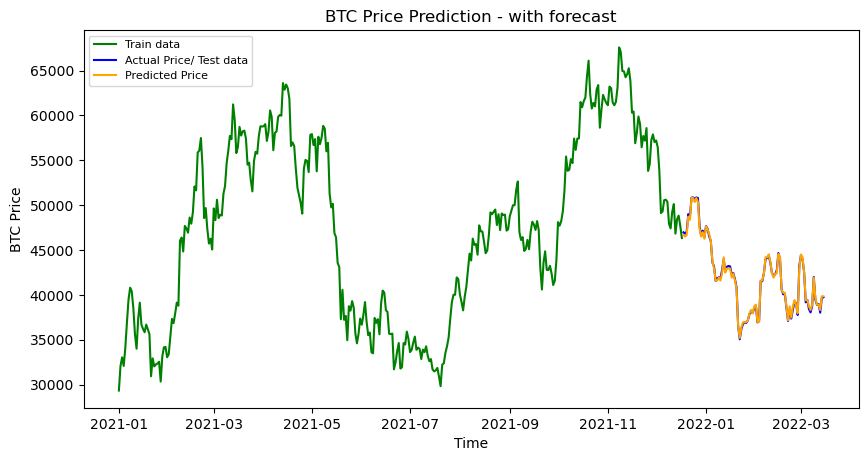

In [114]:
# plot results with train data

fore_series = pd.Series(y_pred, index=X_test.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

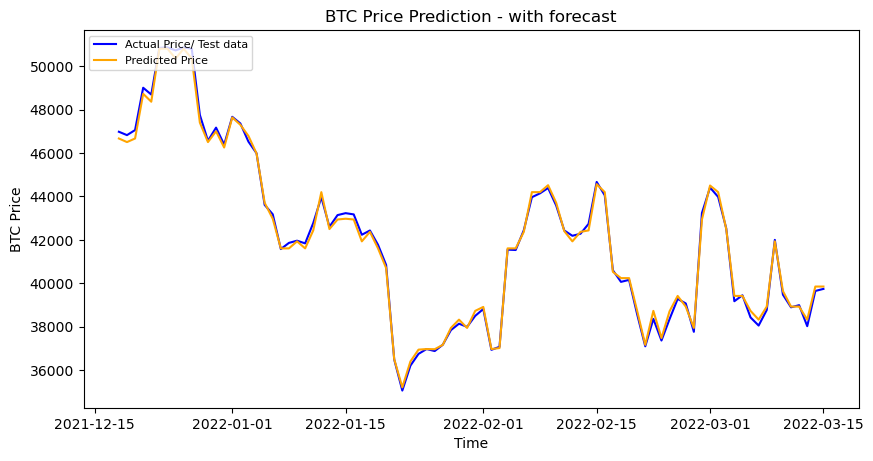

In [115]:
# plot results predictions and test data - zoom-in results

plt.figure(figsize=(10,5), dpi=100)
plt.plot(y_test, 'blue', label='Actual Price/ Test data')
plt.plot(fore_series, 'orange', label='Predicted Price')

plt.title('BTC Price Prediction - with forecast')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 6.3. XGBRegressor  =>  summary

Prediction of Bitcoin Price based on historical data was performed with XGBRegressor model with GridSearchCV for getting optimal parameters.

- In first try dataset was sliced, started from 2018-01-01.

- In second try dataset was sliced, started from 2021-01-01.

Every next optimalisation of pameters gave better reults and lower RMSE. Data set started from 2021-01-01 gave better result as for most recend data - better respresentation of curren situation. 

In addition RMSE of ARIMA no. 2 has been ploted below - to compare performecne in similar scale of the models.

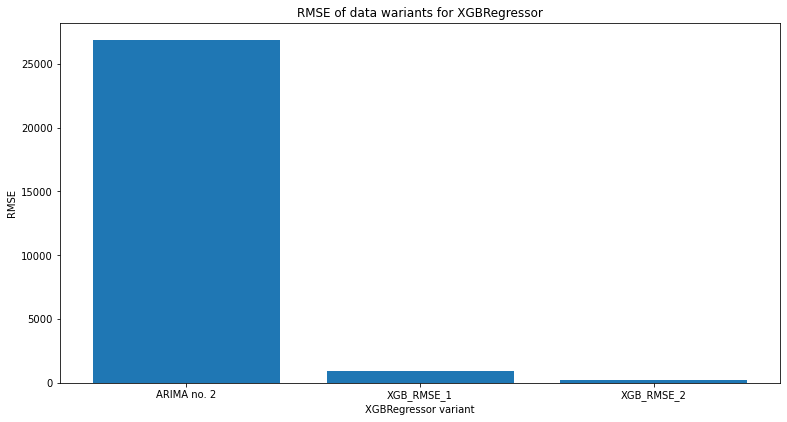

In [118]:
# plot for the RMSE's of data wariants for XGBRegressor

XGBRegressor_variant = ['ARIMA no. 2', 'XGB_RMSE_1', 'XGB_RMSE_2']
variables = [rmse_2, rmse_XGB_1, rmse_XGB_2]

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(XGBRegressor_variant, variables)

plt.xlabel('XGBRegressor variant')
plt.ylabel('RMSE')
plt.title('RMSE of data wariants for XGBRegressor')
plt.show()